In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e5)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/prox_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    if a.shape[1] == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [10]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [11]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)
    if len(V_grad_) == 1:
        return V_grad_[0]
    else:
        return V_grad_

In [53]:
def nabla_V_grad(a, b, x, y):
    n = len(x)
    y_hat = forward(a, b, x)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0)
    return np.matmul(M.T, x) / n    

In [55]:
nabla_V_grad(a, b, x_train, y_train).shape

(33, 50)

In [48]:
np.matmul(x_train, b.T).shape

(256, 33)

# Data

In [12]:
# Teacher Network
m_star = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [13]:
# Data with inputs on the sphere
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = forward(a_star, b_star, x_val)

In [14]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0
1.0000000000000002


We have
$$V[\mu](b) = \frac{1}{n} \sum_{i=1}^n (f(\mu;x_i) - y_i) \sigma(b^\top x_i).$$
In this setting, sampling the particles on the sphere yields
$$|V[\mu](b) - V[\nu](b)| \leq |\mu - \nu|_{TV},$$
and thus a Lipschitz constant for the gradient $V$ equal to $L=1$. 

## 1. $L^2(\tau)$ proximal algorithm: adding particles

In [15]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    new_b = np.random.normal(size=(1, INPUT_DIM))
    neuron_scale = np.linalg.norm(new_b, axis=1, ord=2)
    new_b = new_b / neuron_scale
    V = V_grad(a, b, x, y, new_b)
    new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [16]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    no_change_indexes = []

    for k in tqdm(range(N_STEPS)):
        if a.shape[1] > N_MAX_NEURONS:
            print('-----  BREAKING  -----')
            break
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]:
            no_change_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(no_change_indexes)

In [17]:
a, b, ms, train_losses_pop, penalized_train_losses_pop, val_losses, penalized_val_losses, no_change_indexes = \
        train(N_STEPS, x_train, y_train, x_val, y_val)

  0%|                                                                 | 0/150000 [00:00<?, ?it/s]

m at step 0 : 1
Train loss at step 0 : 0.40127
Validation loss at step 0 : 0.36946


  0%|                                                     | 236/150000 [00:00<01:57, 1270.64it/s]

m at step 100 : 59
Train loss at step 100 : 0.39004
Validation loss at step 100 : 0.35864
m at step 200 : 111
Train loss at step 200 : 0.38134
Validation loss at step 200 : 0.34999
m at step 300 : 163
Train loss at step 300 : 0.37175
Validation loss at step 300 : 0.34006


  0%|▏                                                    | 364/150000 [00:00<02:13, 1125.05it/s]

m at step 400 : 207
Train loss at step 400 : 0.36230
Validation loss at step 400 : 0.33117


  0%|▏                                                     | 479/150000 [00:00<03:11, 781.78it/s]

m at step 500 : 254
Train loss at step 500 : 0.35607
Validation loss at step 500 : 0.32533


  0%|▏                                                     | 569/150000 [00:00<03:57, 628.80it/s]

m at step 600 : 289
Train loss at step 600 : 0.35070
Validation loss at step 600 : 0.32013


  1%|▎                                                     | 779/150000 [00:01<04:09, 597.19it/s]

m at step 700 : 319
Train loss at step 700 : 0.34652
Validation loss at step 700 : 0.31616
m at step 800 : 349
Train loss at step 800 : 0.34367
Validation loss at step 800 : 0.31345


  1%|▎                                                     | 995/150000 [00:01<03:47, 655.30it/s]

m at step 900 : 369
Train loss at step 900 : 0.34098
Validation loss at step 900 : 0.31114
m at step 1,000 : 394
Train loss at step 1,000 : 0.33853
Validation loss at step 1,000 : 0.30856


  1%|▍                                                    | 1143/150000 [00:01<03:55, 633.38it/s]

m at step 1,100 : 416
Train loss at step 1,100 : 0.33628
Validation loss at step 1,100 : 0.30662
m at step 1,200 : 441
Train loss at step 1,200 : 0.33394
Validation loss at step 1,200 : 0.30439


  1%|▌                                                    | 1418/150000 [00:02<03:56, 627.63it/s]

m at step 1,300 : 463
Train loss at step 1,300 : 0.33195
Validation loss at step 1,300 : 0.30259
m at step 1,400 : 486
Train loss at step 1,400 : 0.32975
Validation loss at step 1,400 : 0.30028


  1%|▌                                                    | 1541/150000 [00:02<05:13, 474.25it/s]

m at step 1,500 : 511
Train loss at step 1,500 : 0.32684
Validation loss at step 1,500 : 0.29716


  1%|▌                                                    | 1677/150000 [00:02<06:27, 382.85it/s]

m at step 1,600 : 535
Train loss at step 1,600 : 0.32462
Validation loss at step 1,600 : 0.29495


  1%|▌                                                    | 1757/150000 [00:03<06:42, 367.85it/s]

m at step 1,700 : 552
Train loss at step 1,700 : 0.32296
Validation loss at step 1,700 : 0.29341


  1%|▋                                                    | 1896/150000 [00:03<05:49, 423.16it/s]

m at step 1,800 : 570
Train loss at step 1,800 : 0.32125
Validation loss at step 1,800 : 0.29199
m at step 1,900 : 584
Train loss at step 1,900 : 0.32023
Validation loss at step 1,900 : 0.29090


  1%|▋                                                    | 2082/150000 [00:03<05:40, 433.94it/s]

m at step 2,000 : 599
Train loss at step 2,000 : 0.31882
Validation loss at step 2,000 : 0.28964


  1%|▊                                                    | 2170/150000 [00:04<05:58, 411.89it/s]

m at step 2,100 : 610
Train loss at step 2,100 : 0.31700
Validation loss at step 2,100 : 0.28794


  1%|▊                                                    | 2212/150000 [00:04<06:35, 373.43it/s]

m at step 2,200 : 626
Train loss at step 2,200 : 0.31606
Validation loss at step 2,200 : 0.28709


  2%|▊                                                    | 2361/150000 [00:04<07:45, 317.05it/s]

m at step 2,300 : 638
Train loss at step 2,300 : 0.31519
Validation loss at step 2,300 : 0.28626


  2%|▉                                                    | 2478/150000 [00:05<07:15, 338.74it/s]

m at step 2,400 : 652
Train loss at step 2,400 : 0.31362
Validation loss at step 2,400 : 0.28474


  2%|▉                                                    | 2571/150000 [00:05<06:08, 399.63it/s]

m at step 2,500 : 664
Train loss at step 2,500 : 0.31289
Validation loss at step 2,500 : 0.28415


  2%|▉                                                    | 2660/150000 [00:05<05:47, 423.71it/s]

m at step 2,600 : 674
Train loss at step 2,600 : 0.31232
Validation loss at step 2,600 : 0.28369


  2%|▉                                                    | 2743/150000 [00:05<06:39, 368.90it/s]

m at step 2,700 : 688
Train loss at step 2,700 : 0.31145
Validation loss at step 2,700 : 0.28296


  2%|█                                                    | 2864/150000 [00:06<06:22, 384.68it/s]

m at step 2,800 : 700
Train loss at step 2,800 : 0.30973
Validation loss at step 2,800 : 0.28136


  2%|█                                                    | 2940/150000 [00:06<06:59, 350.26it/s]

m at step 2,900 : 716
Train loss at step 2,900 : 0.30788
Validation loss at step 2,900 : 0.27983


  2%|█                                                    | 3044/150000 [00:06<08:01, 304.94it/s]

m at step 3,000 : 726
Train loss at step 3,000 : 0.30720
Validation loss at step 3,000 : 0.27932


  2%|█                                                    | 3140/150000 [00:07<08:03, 303.52it/s]

m at step 3,100 : 737
Train loss at step 3,100 : 0.30642
Validation loss at step 3,100 : 0.27841


  2%|█▏                                                   | 3257/150000 [00:07<06:52, 355.37it/s]

m at step 3,200 : 745
Train loss at step 3,200 : 0.30580
Validation loss at step 3,200 : 0.27801


  2%|█▏                                                   | 3330/150000 [00:07<06:59, 349.30it/s]

m at step 3,300 : 754
Train loss at step 3,300 : 0.30471
Validation loss at step 3,300 : 0.27683


  2%|█▏                                                   | 3442/150000 [00:07<06:52, 355.61it/s]

m at step 3,400 : 762
Train loss at step 3,400 : 0.30418
Validation loss at step 3,400 : 0.27631


  2%|█▎                                                   | 3560/150000 [00:08<07:17, 334.67it/s]

m at step 3,500 : 766
Train loss at step 3,500 : 0.30393
Validation loss at step 3,500 : 0.27599


  2%|█▎                                                   | 3626/150000 [00:08<08:39, 281.78it/s]

m at step 3,600 : 777
Train loss at step 3,600 : 0.30246
Validation loss at step 3,600 : 0.27465


  2%|█▎                                                   | 3745/150000 [00:09<08:50, 275.69it/s]

m at step 3,700 : 788
Train loss at step 3,700 : 0.30176
Validation loss at step 3,700 : 0.27394


  3%|█▎                                                   | 3838/150000 [00:09<08:23, 290.29it/s]

m at step 3,800 : 797
Train loss at step 3,800 : 0.30117
Validation loss at step 3,800 : 0.27356


  3%|█▍                                                   | 3948/150000 [00:09<07:19, 332.68it/s]

m at step 3,900 : 805
Train loss at step 3,900 : 0.30095
Validation loss at step 3,900 : 0.27334


  3%|█▍                                                   | 4056/150000 [00:10<07:28, 325.06it/s]

m at step 4,000 : 814
Train loss at step 4,000 : 0.30055
Validation loss at step 4,000 : 0.27290


  3%|█▍                                                   | 4174/150000 [00:10<07:01, 345.65it/s]

m at step 4,100 : 819
Train loss at step 4,100 : 0.30009
Validation loss at step 4,100 : 0.27251


  3%|█▍                                                   | 4243/150000 [00:10<08:12, 295.93it/s]

m at step 4,200 : 821
Train loss at step 4,200 : 0.30006
Validation loss at step 4,200 : 0.27248


  3%|█▌                                                   | 4331/150000 [00:10<08:55, 271.84it/s]

m at step 4,300 : 823
Train loss at step 4,300 : 0.29978
Validation loss at step 4,300 : 0.27231


  3%|█▌                                                   | 4466/150000 [00:11<07:32, 321.36it/s]

m at step 4,400 : 833
Train loss at step 4,400 : 0.29919
Validation loss at step 4,400 : 0.27185


  3%|█▌                                                   | 4541/150000 [00:11<07:14, 334.49it/s]

m at step 4,500 : 838
Train loss at step 4,500 : 0.29874
Validation loss at step 4,500 : 0.27135


  3%|█▋                                                   | 4646/150000 [00:11<07:36, 318.37it/s]

m at step 4,600 : 847
Train loss at step 4,600 : 0.29818
Validation loss at step 4,600 : 0.27080


  3%|█▋                                                   | 4761/150000 [00:12<06:54, 350.51it/s]

m at step 4,700 : 850
Train loss at step 4,700 : 0.29788
Validation loss at step 4,700 : 0.27054


  3%|█▋                                                   | 4829/150000 [00:12<08:21, 289.20it/s]

m at step 4,800 : 853
Train loss at step 4,800 : 0.29768
Validation loss at step 4,800 : 0.27038


  3%|█▋                                                   | 4946/150000 [00:13<08:55, 270.85it/s]

m at step 4,900 : 859
Train loss at step 4,900 : 0.29750
Validation loss at step 4,900 : 0.27022


  3%|█▊                                                   | 5040/150000 [00:13<08:10, 295.27it/s]

m at step 5,000 : 862
Train loss at step 5,000 : 0.29725
Validation loss at step 5,000 : 0.26993


  3%|█▊                                                   | 5134/150000 [00:13<07:55, 304.71it/s]

m at step 5,100 : 868
Train loss at step 5,100 : 0.29651
Validation loss at step 5,100 : 0.26936


  4%|█▊                                                   | 5270/150000 [00:14<07:20, 328.23it/s]

m at step 5,200 : 875
Train loss at step 5,200 : 0.29616
Validation loss at step 5,200 : 0.26905


  4%|█▉                                                   | 5342/150000 [00:14<07:18, 329.77it/s]

m at step 5,300 : 878
Train loss at step 5,300 : 0.29586
Validation loss at step 5,300 : 0.26876


  4%|█▉                                                   | 5436/150000 [00:14<09:44, 247.21it/s]

m at step 5,400 : 882
Train loss at step 5,400 : 0.29572
Validation loss at step 5,400 : 0.26866


  4%|█▉                                                   | 5547/150000 [00:15<09:13, 261.05it/s]

m at step 5,500 : 889
Train loss at step 5,500 : 0.29539
Validation loss at step 5,500 : 0.26836


  4%|█▉                                                   | 5632/150000 [00:15<09:02, 266.18it/s]

m at step 5,600 : 894
Train loss at step 5,600 : 0.29522
Validation loss at step 5,600 : 0.26825


  4%|██                                                   | 5752/150000 [00:16<09:32, 252.04it/s]

m at step 5,700 : 899
Train loss at step 5,700 : 0.29492
Validation loss at step 5,700 : 0.26794


  4%|██                                                   | 5850/150000 [00:16<09:08, 263.04it/s]

m at step 5,800 : 901
Train loss at step 5,800 : 0.29486
Validation loss at step 5,800 : 0.26789


  4%|██                                                   | 5938/150000 [00:16<09:30, 252.39it/s]

m at step 5,900 : 909
Train loss at step 5,900 : 0.29427
Validation loss at step 5,900 : 0.26745


  4%|██▏                                                  | 6057/150000 [00:17<08:47, 272.63it/s]

m at step 6,000 : 910
Train loss at step 6,000 : 0.29405
Validation loss at step 6,000 : 0.26723


  4%|██▏                                                  | 6152/150000 [00:17<08:14, 291.03it/s]

m at step 6,100 : 914
Train loss at step 6,100 : 0.29372
Validation loss at step 6,100 : 0.26690


  4%|██▏                                                  | 6237/150000 [00:17<10:08, 236.31it/s]

m at step 6,200 : 921
Train loss at step 6,200 : 0.29332
Validation loss at step 6,200 : 0.26644


  4%|██▏                                                  | 6329/150000 [00:18<08:31, 281.12it/s]

m at step 6,300 : 927
Train loss at step 6,300 : 0.29294
Validation loss at step 6,300 : 0.26603


  4%|██▎                                                  | 6438/150000 [00:18<10:26, 228.99it/s]

m at step 6,400 : 934
Train loss at step 6,400 : 0.29256
Validation loss at step 6,400 : 0.26567


  4%|██▎                                                  | 6536/150000 [00:19<10:26, 228.84it/s]

m at step 6,500 : 941
Train loss at step 6,500 : 0.29206
Validation loss at step 6,500 : 0.26523


  4%|██▎                                                  | 6652/150000 [00:19<08:45, 272.67it/s]

m at step 6,600 : 945
Train loss at step 6,600 : 0.29196
Validation loss at step 6,600 : 0.26513


  4%|██▍                                                  | 6731/150000 [00:20<09:55, 240.68it/s]

m at step 6,700 : 949
Train loss at step 6,700 : 0.29174
Validation loss at step 6,700 : 0.26495


  5%|██▍                                                  | 6846/150000 [00:20<09:17, 256.93it/s]

m at step 6,800 : 956
Train loss at step 6,800 : 0.29107
Validation loss at step 6,800 : 0.26446


  5%|██▍                                                  | 6947/150000 [00:20<10:35, 225.11it/s]

m at step 6,900 : 959
Train loss at step 6,900 : 0.29100
Validation loss at step 6,900 : 0.26439


  5%|██▍                                                  | 7042/150000 [00:21<10:52, 219.15it/s]

m at step 7,000 : 964
Train loss at step 7,000 : 0.29073
Validation loss at step 7,000 : 0.26415


  5%|██▌                                                  | 7138/150000 [00:21<08:30, 279.59it/s]

m at step 7,100 : 969
Train loss at step 7,100 : 0.29044
Validation loss at step 7,100 : 0.26381


  5%|██▌                                                  | 7245/150000 [00:22<09:43, 244.75it/s]

m at step 7,200 : 973
Train loss at step 7,200 : 0.28986
Validation loss at step 7,200 : 0.26306


  5%|██▌                                                  | 7327/150000 [00:22<10:01, 237.00it/s]

m at step 7,300 : 982
Train loss at step 7,300 : 0.28917
Validation loss at step 7,300 : 0.26242


  5%|██▌                                                  | 7427/150000 [00:22<10:39, 222.98it/s]

m at step 7,400 : 986
Train loss at step 7,400 : 0.28888
Validation loss at step 7,400 : 0.26205


  5%|██▋                                                  | 7564/150000 [00:23<08:49, 268.89it/s]

m at step 7,500 : 993
Train loss at step 7,500 : 0.28816
Validation loss at step 7,500 : 0.26139


  5%|██▋                                                  | 7647/150000 [00:23<09:19, 254.51it/s]

m at step 7,600 : 996
Train loss at step 7,600 : 0.28798
Validation loss at step 7,600 : 0.26124


  5%|██▋                                                  | 7740/150000 [00:24<08:04, 293.70it/s]

m at step 7,700 : 999
Train loss at step 7,700 : 0.28780
Validation loss at step 7,700 : 0.26112


  5%|██▊                                                  | 7823/150000 [00:24<10:28, 226.39it/s]

m at step 7,800 : 1,003
Train loss at step 7,800 : 0.28744
Validation loss at step 7,800 : 0.26068


  5%|██▊                                                  | 7943/150000 [00:25<10:35, 223.41it/s]

m at step 7,900 : 1,006
Train loss at step 7,900 : 0.28729
Validation loss at step 7,900 : 0.26049


  5%|██▊                                                  | 8050/150000 [00:25<09:19, 253.68it/s]

m at step 8,000 : 1,009
Train loss at step 8,000 : 0.28658
Validation loss at step 8,000 : 0.26016


  5%|██▊                                                  | 8127/150000 [00:25<09:59, 236.50it/s]

m at step 8,100 : 1,013
Train loss at step 8,100 : 0.28654
Validation loss at step 8,100 : 0.26012


  5%|██▉                                                  | 8231/150000 [00:26<09:55, 237.93it/s]

m at step 8,200 : 1,014
Train loss at step 8,200 : 0.28644
Validation loss at step 8,200 : 0.26006


  6%|██▉                                                  | 8333/150000 [00:26<10:08, 232.91it/s]

m at step 8,300 : 1,017
Train loss at step 8,300 : 0.28637
Validation loss at step 8,300 : 0.25997


  6%|██▉                                                  | 8427/150000 [00:27<10:54, 216.18it/s]

m at step 8,400 : 1,021
Train loss at step 8,400 : 0.28609
Validation loss at step 8,400 : 0.25982


  6%|███                                                  | 8534/150000 [00:27<09:36, 245.44it/s]

m at step 8,500 : 1,026
Train loss at step 8,500 : 0.28596
Validation loss at step 8,500 : 0.25970


  6%|███                                                  | 8636/150000 [00:28<09:37, 244.75it/s]

m at step 8,600 : 1,031
Train loss at step 8,600 : 0.28553
Validation loss at step 8,600 : 0.25935


  6%|███                                                  | 8738/150000 [00:28<10:00, 235.14it/s]

m at step 8,700 : 1,034
Train loss at step 8,700 : 0.28509
Validation loss at step 8,700 : 0.25896


  6%|███                                                  | 8838/150000 [00:29<10:11, 230.79it/s]

m at step 8,800 : 1,040
Train loss at step 8,800 : 0.28495
Validation loss at step 8,800 : 0.25881


  6%|███▏                                                 | 8938/150000 [00:29<09:50, 238.81it/s]

m at step 8,900 : 1,045
Train loss at step 8,900 : 0.28477
Validation loss at step 8,900 : 0.25862


  6%|███▏                                                 | 9036/150000 [00:29<10:44, 218.57it/s]

m at step 9,000 : 1,049
Train loss at step 9,000 : 0.28462
Validation loss at step 9,000 : 0.25853


  6%|███▏                                                 | 9143/150000 [00:30<09:20, 251.24it/s]

m at step 9,100 : 1,051
Train loss at step 9,100 : 0.28453
Validation loss at step 9,100 : 0.25848


  6%|███▎                                                 | 9240/150000 [00:30<11:06, 211.17it/s]

m at step 9,200 : 1,053
Train loss at step 9,200 : 0.28449
Validation loss at step 9,200 : 0.25846


  6%|███▎                                                 | 9326/150000 [00:31<11:52, 197.44it/s]

m at step 9,300 : 1,057
Train loss at step 9,300 : 0.28439
Validation loss at step 9,300 : 0.25835


  6%|███▎                                                 | 9426/150000 [00:31<09:56, 235.75it/s]

m at step 9,400 : 1,062
Train loss at step 9,400 : 0.28409
Validation loss at step 9,400 : 0.25810


  6%|███▎                                                 | 9528/150000 [00:32<09:40, 242.08it/s]

m at step 9,500 : 1,069
Train loss at step 9,500 : 0.28363
Validation loss at step 9,500 : 0.25773


  6%|███▍                                                 | 9621/150000 [00:32<12:13, 191.39it/s]

m at step 9,600 : 1,071
Train loss at step 9,600 : 0.28359
Validation loss at step 9,600 : 0.25770


  6%|███▍                                                 | 9726/150000 [00:33<12:20, 189.51it/s]

m at step 9,700 : 1,071
Train loss at step 9,700 : 0.28359
Validation loss at step 9,700 : 0.25770


  7%|███▍                                                 | 9826/150000 [00:33<10:14, 228.21it/s]

m at step 9,800 : 1,072
Train loss at step 9,800 : 0.28356
Validation loss at step 9,800 : 0.25766


  7%|███▌                                                 | 9949/150000 [00:34<09:46, 238.74it/s]

m at step 9,900 : 1,072
Train loss at step 9,900 : 0.28356
Validation loss at step 9,900 : 0.25766


  7%|███▍                                                | 10019/150000 [00:34<11:35, 201.17it/s]

m at step 10,000 : 1,076
Train loss at step 10,000 : 0.28346
Validation loss at step 10,000 : 0.25756


  7%|███▌                                                | 10141/150000 [00:35<12:13, 190.77it/s]

m at step 10,100 : 1,081
Train loss at step 10,100 : 0.28336
Validation loss at step 10,100 : 0.25748


  7%|███▌                                                | 10239/150000 [00:35<10:33, 220.57it/s]

m at step 10,200 : 1,087
Train loss at step 10,200 : 0.28292
Validation loss at step 10,200 : 0.25696


  7%|███▌                                                | 10345/150000 [00:36<09:04, 256.43it/s]

m at step 10,300 : 1,091
Train loss at step 10,300 : 0.28260
Validation loss at step 10,300 : 0.25669


  7%|███▌                                                | 10419/150000 [00:36<11:05, 209.61it/s]

m at step 10,400 : 1,097
Train loss at step 10,400 : 0.28192
Validation loss at step 10,400 : 0.25596


  7%|███▋                                                | 10525/150000 [00:37<11:45, 197.72it/s]

m at step 10,500 : 1,099
Train loss at step 10,500 : 0.28180
Validation loss at step 10,500 : 0.25582


  7%|███▋                                                | 10646/150000 [00:37<09:46, 237.74it/s]

m at step 10,600 : 1,105
Train loss at step 10,600 : 0.28158
Validation loss at step 10,600 : 0.25565


  7%|███▋                                                | 10740/150000 [00:38<10:34, 219.41it/s]

m at step 10,700 : 1,111
Train loss at step 10,700 : 0.28103
Validation loss at step 10,700 : 0.25524


  7%|███▊                                                | 10825/150000 [00:38<12:47, 181.43it/s]

m at step 10,800 : 1,116
Train loss at step 10,800 : 0.28096
Validation loss at step 10,800 : 0.25517


  7%|███▊                                                | 10929/150000 [00:39<12:30, 185.32it/s]

m at step 10,900 : 1,116
Train loss at step 10,900 : 0.28096
Validation loss at step 10,900 : 0.25517


  7%|███▊                                                | 11033/150000 [00:39<09:32, 242.54it/s]

m at step 11,000 : 1,119
Train loss at step 11,000 : 0.28091
Validation loss at step 11,000 : 0.25512


  7%|███▊                                                | 11128/150000 [00:40<10:24, 222.40it/s]

m at step 11,100 : 1,124
Train loss at step 11,100 : 0.28078
Validation loss at step 11,100 : 0.25495


  7%|███▉                                                | 11218/150000 [00:40<11:51, 195.12it/s]

m at step 11,200 : 1,131
Train loss at step 11,200 : 0.28029
Validation loss at step 11,200 : 0.25466


  8%|███▉                                                | 11347/150000 [00:41<11:10, 206.82it/s]

m at step 11,300 : 1,135
Train loss at step 11,300 : 0.28019
Validation loss at step 11,300 : 0.25454


  8%|███▉                                                | 11429/150000 [00:41<09:19, 247.51it/s]

m at step 11,400 : 1,136
Train loss at step 11,400 : 0.28017
Validation loss at step 11,400 : 0.25453


  8%|███▉                                                | 11526/150000 [00:41<10:29, 220.05it/s]

m at step 11,500 : 1,139
Train loss at step 11,500 : 0.28006
Validation loss at step 11,500 : 0.25440


  8%|████                                                | 11622/150000 [00:42<10:58, 210.24it/s]

m at step 11,600 : 1,141
Train loss at step 11,600 : 0.27999
Validation loss at step 11,600 : 0.25431


  8%|████                                                | 11722/150000 [00:43<12:42, 181.38it/s]

m at step 11,700 : 1,145
Train loss at step 11,700 : 0.27984
Validation loss at step 11,700 : 0.25413


  8%|████                                                | 11832/150000 [00:43<10:44, 214.26it/s]

m at step 11,800 : 1,151
Train loss at step 11,800 : 0.27967
Validation loss at step 11,800 : 0.25399


  8%|████▏                                               | 11950/150000 [00:44<10:12, 225.49it/s]

m at step 11,900 : 1,153
Train loss at step 11,900 : 0.27963
Validation loss at step 11,900 : 0.25394


  8%|████▏                                               | 12020/150000 [00:44<11:32, 199.28it/s]

m at step 12,000 : 1,155
Train loss at step 12,000 : 0.27945
Validation loss at step 12,000 : 0.25371


  8%|████▏                                               | 12122/150000 [00:44<11:59, 191.75it/s]

m at step 12,100 : 1,159
Train loss at step 12,100 : 0.27934
Validation loss at step 12,100 : 0.25360


  8%|████▏                                               | 12249/150000 [00:45<09:53, 232.10it/s]

m at step 12,200 : 1,160
Train loss at step 12,200 : 0.27934
Validation loss at step 12,200 : 0.25360


  8%|████▎                                               | 12320/150000 [00:45<10:48, 212.44it/s]

m at step 12,300 : 1,163
Train loss at step 12,300 : 0.27923
Validation loss at step 12,300 : 0.25350


  8%|████▎                                               | 12439/150000 [00:46<11:06, 206.24it/s]

m at step 12,400 : 1,166
Train loss at step 12,400 : 0.27909
Validation loss at step 12,400 : 0.25338


  8%|████▎                                               | 12521/150000 [00:46<12:26, 184.28it/s]

m at step 12,500 : 1,169
Train loss at step 12,500 : 0.27897
Validation loss at step 12,500 : 0.25328


  8%|████▍                                               | 12626/150000 [00:47<11:26, 200.14it/s]

m at step 12,600 : 1,169
Train loss at step 12,600 : 0.27897
Validation loss at step 12,600 : 0.25328


  8%|████▍                                               | 12722/150000 [00:47<11:11, 204.29it/s]

m at step 12,700 : 1,169
Train loss at step 12,700 : 0.27897
Validation loss at step 12,700 : 0.25328


  9%|████▍                                               | 12839/150000 [00:48<11:02, 207.19it/s]

m at step 12,800 : 1,170
Train loss at step 12,800 : 0.27897
Validation loss at step 12,800 : 0.25328


  9%|████▍                                               | 12947/150000 [00:49<14:17, 159.82it/s]

m at step 12,900 : 1,171
Train loss at step 12,900 : 0.27893
Validation loss at step 12,900 : 0.25327


  9%|████▌                                               | 13035/150000 [00:49<13:35, 167.95it/s]

m at step 13,000 : 1,173
Train loss at step 13,000 : 0.27873
Validation loss at step 13,000 : 0.25307


  9%|████▌                                               | 13126/150000 [00:50<11:49, 192.81it/s]

m at step 13,100 : 1,175
Train loss at step 13,100 : 0.27848
Validation loss at step 13,100 : 0.25292


  9%|████▌                                               | 13219/150000 [00:51<14:24, 158.22it/s]

m at step 13,200 : 1,180
Train loss at step 13,200 : 0.27820
Validation loss at step 13,200 : 0.25277


  9%|████▌                                               | 13316/150000 [00:51<17:12, 132.42it/s]

m at step 13,300 : 1,182
Train loss at step 13,300 : 0.27815
Validation loss at step 13,300 : 0.25274


  9%|████▋                                               | 13445/150000 [00:52<09:53, 230.27it/s]

m at step 13,400 : 1,183
Train loss at step 13,400 : 0.27810
Validation loss at step 13,400 : 0.25269


  9%|████▋                                               | 13527/150000 [00:52<14:51, 153.05it/s]

m at step 13,500 : 1,187
Train loss at step 13,500 : 0.27785
Validation loss at step 13,500 : 0.25252


  9%|████▋                                               | 13624/150000 [00:53<12:31, 181.39it/s]

m at step 13,600 : 1,187
Train loss at step 13,600 : 0.27785
Validation loss at step 13,600 : 0.25252


  9%|████▊                                               | 13733/150000 [00:53<11:17, 201.26it/s]

m at step 13,700 : 1,190
Train loss at step 13,700 : 0.27774
Validation loss at step 13,700 : 0.25243


  9%|████▊                                               | 13823/150000 [00:54<11:21, 199.84it/s]

m at step 13,800 : 1,190
Train loss at step 13,800 : 0.27774
Validation loss at step 13,800 : 0.25243


  9%|████▊                                               | 13922/150000 [00:54<12:39, 179.29it/s]

m at step 13,900 : 1,192
Train loss at step 13,900 : 0.27760
Validation loss at step 13,900 : 0.25230


  9%|████▊                                               | 14030/150000 [00:55<10:39, 212.76it/s]

m at step 14,000 : 1,193
Train loss at step 14,000 : 0.27755
Validation loss at step 14,000 : 0.25224


  9%|████▉                                               | 14129/150000 [00:55<11:06, 203.72it/s]

m at step 14,100 : 1,194
Train loss at step 14,100 : 0.27737
Validation loss at step 14,100 : 0.25208


  9%|████▉                                               | 14239/150000 [00:56<11:28, 197.31it/s]

m at step 14,200 : 1,198
Train loss at step 14,200 : 0.27723
Validation loss at step 14,200 : 0.25201


 10%|████▉                                               | 14340/150000 [00:57<11:43, 192.95it/s]

m at step 14,300 : 1,199
Train loss at step 14,300 : 0.27719
Validation loss at step 14,300 : 0.25197


 10%|█████                                               | 14428/150000 [00:57<10:39, 212.02it/s]

m at step 14,400 : 1,200
Train loss at step 14,400 : 0.27717
Validation loss at step 14,400 : 0.25195


 10%|█████                                               | 14537/150000 [00:58<11:11, 201.79it/s]

m at step 14,500 : 1,202
Train loss at step 14,500 : 0.27708
Validation loss at step 14,500 : 0.25188


 10%|█████                                               | 14621/150000 [00:58<11:55, 189.13it/s]

m at step 14,600 : 1,204
Train loss at step 14,600 : 0.27689
Validation loss at step 14,600 : 0.25174


 10%|█████                                               | 14737/150000 [00:59<12:57, 173.98it/s]

m at step 14,700 : 1,207
Train loss at step 14,700 : 0.27679
Validation loss at step 14,700 : 0.25164


 10%|█████▏                                              | 14825/150000 [00:59<10:42, 210.49it/s]

m at step 14,800 : 1,209
Train loss at step 14,800 : 0.27671
Validation loss at step 14,800 : 0.25157


 10%|█████▏                                              | 14938/150000 [01:00<10:32, 213.40it/s]

m at step 14,900 : 1,211
Train loss at step 14,900 : 0.27667
Validation loss at step 14,900 : 0.25154


 10%|█████▏                                              | 15019/150000 [01:00<13:29, 166.81it/s]

m at step 15,000 : 1,214
Train loss at step 15,000 : 0.27657
Validation loss at step 15,000 : 0.25148


 10%|█████▏                                              | 15129/150000 [01:01<12:28, 180.17it/s]

m at step 15,100 : 1,218
Train loss at step 15,100 : 0.27645
Validation loss at step 15,100 : 0.25135


 10%|█████▎                                              | 15221/150000 [01:01<10:48, 207.77it/s]

m at step 15,200 : 1,221
Train loss at step 15,200 : 0.27638
Validation loss at step 15,200 : 0.25129


 10%|█████▎                                              | 15346/150000 [01:02<10:08, 221.43it/s]

m at step 15,300 : 1,222
Train loss at step 15,300 : 0.27631
Validation loss at step 15,300 : 0.25124


 10%|█████▎                                              | 15427/150000 [01:02<13:22, 167.75it/s]

m at step 15,400 : 1,226
Train loss at step 15,400 : 0.27596
Validation loss at step 15,400 : 0.25092


 10%|█████▍                                              | 15542/150000 [01:03<10:20, 216.71it/s]

m at step 15,500 : 1,228
Train loss at step 15,500 : 0.27587
Validation loss at step 15,500 : 0.25086


 10%|█████▍                                              | 15633/150000 [01:03<11:08, 201.06it/s]

m at step 15,600 : 1,230
Train loss at step 15,600 : 0.27573
Validation loss at step 15,600 : 0.25075


 10%|█████▍                                              | 15722/150000 [01:04<10:30, 212.99it/s]

m at step 15,700 : 1,231
Train loss at step 15,700 : 0.27563
Validation loss at step 15,700 : 0.25069


 11%|█████▍                                              | 15834/150000 [01:04<10:38, 210.12it/s]

m at step 15,800 : 1,233
Train loss at step 15,800 : 0.27559
Validation loss at step 15,800 : 0.25064


 11%|█████▌                                              | 15924/150000 [01:05<10:22, 215.27it/s]

m at step 15,900 : 1,234
Train loss at step 15,900 : 0.27556
Validation loss at step 15,900 : 0.25062


 11%|█████▌                                              | 16020/150000 [01:05<10:28, 213.18it/s]

m at step 16,000 : 1,236
Train loss at step 16,000 : 0.27540
Validation loss at step 16,000 : 0.25045


 11%|█████▌                                              | 16133/150000 [01:06<10:15, 217.45it/s]

m at step 16,100 : 1,237
Train loss at step 16,100 : 0.27535
Validation loss at step 16,100 : 0.25042


 11%|█████▋                                              | 16236/150000 [01:06<11:57, 186.46it/s]

m at step 16,200 : 1,239
Train loss at step 16,200 : 0.27521
Validation loss at step 16,200 : 0.25030


 11%|█████▋                                              | 16336/150000 [01:07<11:47, 188.94it/s]

m at step 16,300 : 1,242
Train loss at step 16,300 : 0.27506
Validation loss at step 16,300 : 0.25013


 11%|█████▋                                              | 16422/150000 [01:07<11:33, 192.54it/s]

m at step 16,400 : 1,248
Train loss at step 16,400 : 0.27467
Validation loss at step 16,400 : 0.24974


 11%|█████▋                                              | 16531/150000 [01:08<11:07, 200.05it/s]

m at step 16,500 : 1,249
Train loss at step 16,500 : 0.27445
Validation loss at step 16,500 : 0.24955


 11%|█████▊                                              | 16630/150000 [01:08<12:41, 175.13it/s]

m at step 16,600 : 1,252
Train loss at step 16,600 : 0.27441
Validation loss at step 16,600 : 0.24953


 11%|█████▊                                              | 16738/150000 [01:09<10:04, 220.39it/s]

m at step 16,700 : 1,255
Train loss at step 16,700 : 0.27418
Validation loss at step 16,700 : 0.24929


 11%|█████▊                                              | 16824/150000 [01:09<12:02, 184.25it/s]

m at step 16,800 : 1,257
Train loss at step 16,800 : 0.27408
Validation loss at step 16,800 : 0.24919


 11%|█████▊                                              | 16919/150000 [01:10<13:23, 165.70it/s]

m at step 16,900 : 1,258
Train loss at step 16,900 : 0.27407
Validation loss at step 16,900 : 0.24919


 11%|█████▉                                              | 17028/150000 [01:11<12:52, 172.10it/s]

m at step 17,000 : 1,260
Train loss at step 17,000 : 0.27395
Validation loss at step 17,000 : 0.24906


 11%|█████▉                                              | 17145/150000 [01:11<10:21, 213.60it/s]

m at step 17,100 : 1,261
Train loss at step 17,100 : 0.27393
Validation loss at step 17,100 : 0.24905


 11%|█████▉                                              | 17235/150000 [01:12<10:32, 209.98it/s]

m at step 17,200 : 1,265
Train loss at step 17,200 : 0.27362
Validation loss at step 17,200 : 0.24871


 12%|██████                                              | 17332/150000 [01:12<13:37, 162.25it/s]

m at step 17,300 : 1,267
Train loss at step 17,300 : 0.27351
Validation loss at step 17,300 : 0.24862


 12%|██████                                              | 17455/150000 [01:13<10:22, 212.80it/s]

m at step 17,400 : 1,271
Train loss at step 17,400 : 0.27325
Validation loss at step 17,400 : 0.24842


 12%|██████                                              | 17535/150000 [01:13<09:32, 231.25it/s]

m at step 17,500 : 1,274
Train loss at step 17,500 : 0.27306
Validation loss at step 17,500 : 0.24828


 12%|██████                                              | 17644/150000 [01:14<08:31, 258.67it/s]

m at step 17,600 : 1,274
Train loss at step 17,600 : 0.27306
Validation loss at step 17,600 : 0.24828


 12%|██████▏                                             | 17719/150000 [01:14<10:58, 200.77it/s]

m at step 17,700 : 1,275
Train loss at step 17,700 : 0.27303
Validation loss at step 17,700 : 0.24824


 12%|██████▏                                             | 17832/150000 [01:15<13:04, 168.39it/s]

m at step 17,800 : 1,279
Train loss at step 17,800 : 0.27263
Validation loss at step 17,800 : 0.24799


 12%|██████▏                                             | 17928/150000 [01:15<13:12, 166.72it/s]

m at step 17,900 : 1,280
Train loss at step 17,900 : 0.27255
Validation loss at step 17,900 : 0.24792


 12%|██████▎                                             | 18035/150000 [01:16<11:10, 196.68it/s]

m at step 18,000 : 1,281
Train loss at step 18,000 : 0.27253
Validation loss at step 18,000 : 0.24791


 12%|██████▎                                             | 18137/150000 [01:16<11:28, 191.55it/s]

m at step 18,100 : 1,282
Train loss at step 18,100 : 0.27252
Validation loss at step 18,100 : 0.24789


 12%|██████▎                                             | 18242/150000 [01:17<10:51, 202.10it/s]

m at step 18,200 : 1,282
Train loss at step 18,200 : 0.27252
Validation loss at step 18,200 : 0.24789


 12%|██████▎                                             | 18326/150000 [01:17<11:53, 184.51it/s]

m at step 18,300 : 1,284
Train loss at step 18,300 : 0.27245
Validation loss at step 18,300 : 0.24783


 12%|██████▍                                             | 18422/150000 [01:18<10:04, 217.68it/s]

m at step 18,400 : 1,285
Train loss at step 18,400 : 0.27243
Validation loss at step 18,400 : 0.24782


 12%|██████▍                                             | 18525/150000 [01:18<11:56, 183.49it/s]

m at step 18,500 : 1,285
Train loss at step 18,500 : 0.27243
Validation loss at step 18,500 : 0.24782


 12%|██████▍                                             | 18620/150000 [01:19<12:05, 181.09it/s]

m at step 18,600 : 1,288
Train loss at step 18,600 : 0.27235
Validation loss at step 18,600 : 0.24774


 12%|██████▍                                             | 18734/150000 [01:20<12:22, 176.72it/s]

m at step 18,700 : 1,290
Train loss at step 18,700 : 0.27218
Validation loss at step 18,700 : 0.24755


 13%|██████▌                                             | 18826/150000 [01:20<13:09, 166.08it/s]

m at step 18,800 : 1,291
Train loss at step 18,800 : 0.27213
Validation loss at step 18,800 : 0.24753


 13%|██████▌                                             | 18932/150000 [01:21<10:56, 199.59it/s]

m at step 18,900 : 1,291
Train loss at step 18,900 : 0.27213
Validation loss at step 18,900 : 0.24753


 13%|██████▌                                             | 19038/150000 [01:21<09:00, 242.13it/s]

m at step 19,000 : 1,291
Train loss at step 19,000 : 0.27213
Validation loss at step 19,000 : 0.24753


 13%|██████▋                                             | 19130/150000 [01:22<10:37, 205.35it/s]

m at step 19,100 : 1,295
Train loss at step 19,100 : 0.27196
Validation loss at step 19,100 : 0.24739


 13%|██████▋                                             | 19226/150000 [01:22<13:13, 164.79it/s]

m at step 19,200 : 1,299
Train loss at step 19,200 : 0.27173
Validation loss at step 19,200 : 0.24720


 13%|██████▋                                             | 19332/150000 [01:23<12:12, 178.44it/s]

m at step 19,300 : 1,299
Train loss at step 19,300 : 0.27173
Validation loss at step 19,300 : 0.24720


 13%|██████▋                                             | 19434/150000 [01:23<10:14, 212.46it/s]

m at step 19,400 : 1,301
Train loss at step 19,400 : 0.27165
Validation loss at step 19,400 : 0.24712


 13%|██████▊                                             | 19541/150000 [01:24<08:56, 243.12it/s]

m at step 19,500 : 1,301
Train loss at step 19,500 : 0.27165
Validation loss at step 19,500 : 0.24712


 13%|██████▊                                             | 19636/150000 [01:24<10:37, 204.59it/s]

m at step 19,600 : 1,301
Train loss at step 19,600 : 0.27165
Validation loss at step 19,600 : 0.24712


 13%|██████▊                                             | 19722/150000 [01:25<10:52, 199.80it/s]

m at step 19,700 : 1,302
Train loss at step 19,700 : 0.27159
Validation loss at step 19,700 : 0.24706


 13%|██████▊                                             | 19829/150000 [01:25<11:50, 183.29it/s]

m at step 19,800 : 1,304
Train loss at step 19,800 : 0.27153
Validation loss at step 19,800 : 0.24700


 13%|██████▉                                             | 19927/150000 [01:26<12:19, 175.84it/s]

m at step 19,900 : 1,304
Train loss at step 19,900 : 0.27153
Validation loss at step 19,900 : 0.24700


 13%|██████▉                                             | 20031/150000 [01:27<13:12, 163.94it/s]

m at step 20,000 : 1,306
Train loss at step 20,000 : 0.27140
Validation loss at step 20,000 : 0.24685


 13%|██████▉                                             | 20133/150000 [01:27<10:53, 198.68it/s]

m at step 20,100 : 1,306
Train loss at step 20,100 : 0.27140
Validation loss at step 20,100 : 0.24685


 13%|███████                                             | 20232/150000 [01:28<11:36, 186.33it/s]

m at step 20,200 : 1,309
Train loss at step 20,200 : 0.27132
Validation loss at step 20,200 : 0.24676


 14%|███████                                             | 20326/150000 [01:28<12:36, 171.35it/s]

m at step 20,300 : 1,311
Train loss at step 20,300 : 0.27120
Validation loss at step 20,300 : 0.24665


 14%|███████                                             | 20428/150000 [01:29<11:05, 194.67it/s]

m at step 20,400 : 1,312
Train loss at step 20,400 : 0.27116
Validation loss at step 20,400 : 0.24660


 14%|███████                                             | 20530/150000 [01:29<09:56, 216.88it/s]

m at step 20,500 : 1,312
Train loss at step 20,500 : 0.27116
Validation loss at step 20,500 : 0.24660


 14%|███████▏                                            | 20631/150000 [01:30<11:48, 182.61it/s]

m at step 20,600 : 1,314
Train loss at step 20,600 : 0.27113
Validation loss at step 20,600 : 0.24658


 14%|███████▏                                            | 20717/150000 [01:30<13:37, 158.24it/s]

m at step 20,700 : 1,315
Train loss at step 20,700 : 0.27095
Validation loss at step 20,700 : 0.24644


 14%|███████▏                                            | 20827/150000 [01:31<11:41, 184.09it/s]

m at step 20,800 : 1,316
Train loss at step 20,800 : 0.27094
Validation loss at step 20,800 : 0.24643


 14%|███████▎                                            | 20926/150000 [01:32<11:48, 182.13it/s]

m at step 20,900 : 1,318
Train loss at step 20,900 : 0.27078
Validation loss at step 20,900 : 0.24628


 14%|███████▎                                            | 21015/150000 [01:32<14:26, 148.80it/s]

m at step 21,000 : 1,319
Train loss at step 21,000 : 0.27077
Validation loss at step 21,000 : 0.24628


 14%|███████▎                                            | 21149/150000 [01:33<10:23, 206.76it/s]

m at step 21,100 : 1,321
Train loss at step 21,100 : 0.27066
Validation loss at step 21,100 : 0.24619


 14%|███████▎                                            | 21227/150000 [01:33<09:05, 236.22it/s]

m at step 21,200 : 1,322
Train loss at step 21,200 : 0.27059
Validation loss at step 21,200 : 0.24613


 14%|███████▍                                            | 21336/150000 [01:34<11:18, 189.65it/s]

m at step 21,300 : 1,323
Train loss at step 21,300 : 0.27058
Validation loss at step 21,300 : 0.24612


 14%|███████▍                                            | 21428/150000 [01:34<13:03, 164.06it/s]

m at step 21,400 : 1,325
Train loss at step 21,400 : 0.27040
Validation loss at step 21,400 : 0.24601


 14%|███████▍                                            | 21522/150000 [01:35<11:36, 184.39it/s]

m at step 21,500 : 1,326
Train loss at step 21,500 : 0.27029
Validation loss at step 21,500 : 0.24590


 14%|███████▍                                            | 21624/150000 [01:35<12:04, 177.29it/s]

m at step 21,600 : 1,328
Train loss at step 21,600 : 0.27012
Validation loss at step 21,600 : 0.24574


 14%|███████▌                                            | 21715/150000 [01:36<13:18, 160.74it/s]

m at step 21,700 : 1,329
Train loss at step 21,700 : 0.27011
Validation loss at step 21,700 : 0.24572


 15%|███████▌                                            | 21826/150000 [01:37<11:56, 178.92it/s]

m at step 21,800 : 1,331
Train loss at step 21,800 : 0.26996
Validation loss at step 21,800 : 0.24565


 15%|███████▌                                            | 21925/150000 [01:37<09:02, 236.05it/s]

m at step 21,900 : 1,331
Train loss at step 21,900 : 0.26996
Validation loss at step 21,900 : 0.24565


 15%|███████▋                                            | 22033/150000 [01:38<11:04, 192.46it/s]

m at step 22,000 : 1,334
Train loss at step 22,000 : 0.26995
Validation loss at step 22,000 : 0.24563


 15%|███████▋                                            | 22123/150000 [01:38<13:38, 156.32it/s]

m at step 22,100 : 1,334
Train loss at step 22,100 : 0.26995
Validation loss at step 22,100 : 0.24563


 15%|███████▋                                            | 22228/150000 [01:39<12:23, 171.84it/s]

m at step 22,200 : 1,334
Train loss at step 22,200 : 0.26995
Validation loss at step 22,200 : 0.24563


 15%|███████▋                                            | 22325/150000 [01:40<11:50, 179.62it/s]

m at step 22,300 : 1,335
Train loss at step 22,300 : 0.26993
Validation loss at step 22,300 : 0.24562


 15%|███████▊                                            | 22425/150000 [01:40<12:23, 171.62it/s]

m at step 22,400 : 1,336
Train loss at step 22,400 : 0.26971
Validation loss at step 22,400 : 0.24547


 15%|███████▊                                            | 22531/150000 [01:41<13:25, 158.19it/s]

m at step 22,500 : 1,337
Train loss at step 22,500 : 0.26970
Validation loss at step 22,500 : 0.24546


 15%|███████▊                                            | 22626/150000 [01:41<11:51, 179.14it/s]

m at step 22,600 : 1,340
Train loss at step 22,600 : 0.26942
Validation loss at step 22,600 : 0.24514


 15%|███████▉                                            | 22747/150000 [01:42<09:39, 219.45it/s]

m at step 22,700 : 1,342
Train loss at step 22,700 : 0.26919
Validation loss at step 22,700 : 0.24496


 15%|███████▉                                            | 22827/150000 [01:42<12:39, 167.53it/s]

m at step 22,800 : 1,344
Train loss at step 22,800 : 0.26897
Validation loss at step 22,800 : 0.24479


 15%|███████▉                                            | 22922/150000 [01:43<11:54, 177.90it/s]

m at step 22,900 : 1,345
Train loss at step 22,900 : 0.26897
Validation loss at step 22,900 : 0.24479


 15%|███████▉                                            | 23028/150000 [01:43<10:43, 197.37it/s]

m at step 23,000 : 1,346
Train loss at step 23,000 : 0.26891
Validation loss at step 23,000 : 0.24476


 15%|████████                                            | 23119/150000 [01:44<10:55, 193.43it/s]

m at step 23,100 : 1,346
Train loss at step 23,100 : 0.26891
Validation loss at step 23,100 : 0.24476


 15%|████████                                            | 23226/150000 [01:45<13:29, 156.65it/s]

m at step 23,200 : 1,347
Train loss at step 23,200 : 0.26887
Validation loss at step 23,200 : 0.24473


 16%|████████                                            | 23332/150000 [01:45<13:11, 159.94it/s]

m at step 23,300 : 1,347
Train loss at step 23,300 : 0.26887
Validation loss at step 23,300 : 0.24473


 16%|████████                                            | 23420/150000 [01:46<12:56, 163.07it/s]

m at step 23,400 : 1,348
Train loss at step 23,400 : 0.26882
Validation loss at step 23,400 : 0.24466


 16%|████████▏                                           | 23531/150000 [01:47<14:38, 143.88it/s]

m at step 23,500 : 1,348
Train loss at step 23,500 : 0.26882
Validation loss at step 23,500 : 0.24466


 16%|████████▏                                           | 23635/150000 [01:47<10:39, 197.71it/s]

m at step 23,600 : 1,349
Train loss at step 23,600 : 0.26882
Validation loss at step 23,600 : 0.24465


 16%|████████▏                                           | 23746/150000 [01:48<09:58, 210.85it/s]

m at step 23,700 : 1,352
Train loss at step 23,700 : 0.26866
Validation loss at step 23,700 : 0.24449


 16%|████████▎                                           | 23823/150000 [01:48<14:01, 150.02it/s]

m at step 23,800 : 1,353
Train loss at step 23,800 : 0.26856
Validation loss at step 23,800 : 0.24441


 16%|████████▎                                           | 23946/150000 [01:49<10:16, 204.45it/s]

m at step 23,900 : 1,355
Train loss at step 23,900 : 0.26841
Validation loss at step 23,900 : 0.24426


 16%|████████▎                                           | 24017/150000 [01:49<10:34, 198.51it/s]

m at step 24,000 : 1,355
Train loss at step 24,000 : 0.26841
Validation loss at step 24,000 : 0.24426


 16%|████████▎                                           | 24117/150000 [01:50<12:16, 170.88it/s]

m at step 24,100 : 1,357
Train loss at step 24,100 : 0.26830
Validation loss at step 24,100 : 0.24412


 16%|████████▍                                           | 24221/150000 [01:51<14:43, 142.34it/s]

m at step 24,200 : 1,359
Train loss at step 24,200 : 0.26818
Validation loss at step 24,200 : 0.24399


 16%|████████▍                                           | 24332/150000 [01:51<12:15, 170.89it/s]

m at step 24,300 : 1,359
Train loss at step 24,300 : 0.26818
Validation loss at step 24,300 : 0.24399


 16%|████████▍                                           | 24422/150000 [01:52<10:27, 200.26it/s]

m at step 24,400 : 1,361
Train loss at step 24,400 : 0.26817
Validation loss at step 24,400 : 0.24398


 16%|████████▌                                           | 24529/150000 [01:52<14:23, 145.33it/s]

m at step 24,500 : 1,362
Train loss at step 24,500 : 0.26805
Validation loss at step 24,500 : 0.24384


 16%|████████▌                                           | 24632/150000 [01:53<11:53, 175.59it/s]

m at step 24,600 : 1,363
Train loss at step 24,600 : 0.26781
Validation loss at step 24,600 : 0.24382


 16%|████████▌                                           | 24727/150000 [01:54<11:09, 187.12it/s]

m at step 24,700 : 1,364
Train loss at step 24,700 : 0.26754
Validation loss at step 24,700 : 0.24361


 17%|████████▌                                           | 24821/150000 [01:54<13:49, 150.96it/s]

m at step 24,800 : 1,364
Train loss at step 24,800 : 0.26754
Validation loss at step 24,800 : 0.24361


 17%|████████▋                                           | 24940/150000 [01:55<12:13, 170.56it/s]

m at step 24,900 : 1,368
Train loss at step 24,900 : 0.26738
Validation loss at step 24,900 : 0.24343


 17%|████████▋                                           | 25037/150000 [01:56<11:35, 179.61it/s]

m at step 25,000 : 1,369
Train loss at step 25,000 : 0.26737
Validation loss at step 25,000 : 0.24342


 17%|████████▋                                           | 25132/150000 [01:56<12:42, 163.76it/s]

m at step 25,100 : 1,370
Train loss at step 25,100 : 0.26733
Validation loss at step 25,100 : 0.24340


 17%|████████▋                                           | 25231/150000 [01:57<13:43, 151.45it/s]

m at step 25,200 : 1,370
Train loss at step 25,200 : 0.26733
Validation loss at step 25,200 : 0.24340


 17%|████████▊                                           | 25333/150000 [01:57<11:29, 180.84it/s]

m at step 25,300 : 1,372
Train loss at step 25,300 : 0.26706
Validation loss at step 25,300 : 0.24312


 17%|████████▊                                           | 25435/150000 [01:58<11:19, 183.36it/s]

m at step 25,400 : 1,372
Train loss at step 25,400 : 0.26706
Validation loss at step 25,400 : 0.24312


 17%|████████▊                                           | 25524/150000 [01:58<13:23, 154.82it/s]

m at step 25,500 : 1,374
Train loss at step 25,500 : 0.26700
Validation loss at step 25,500 : 0.24307


 17%|████████▉                                           | 25628/150000 [01:59<12:23, 167.26it/s]

m at step 25,600 : 1,376
Train loss at step 25,600 : 0.26693
Validation loss at step 25,600 : 0.24305


 17%|████████▉                                           | 25743/150000 [02:00<10:44, 192.76it/s]

m at step 25,700 : 1,380
Train loss at step 25,700 : 0.26680
Validation loss at step 25,700 : 0.24290


 17%|████████▉                                           | 25835/150000 [02:00<12:53, 160.42it/s]

m at step 25,800 : 1,382
Train loss at step 25,800 : 0.26668
Validation loss at step 25,800 : 0.24279


 17%|████████▉                                           | 25921/150000 [02:01<12:45, 162.10it/s]

m at step 25,900 : 1,384
Train loss at step 25,900 : 0.26646
Validation loss at step 25,900 : 0.24260


 17%|█████████                                           | 26025/150000 [02:02<12:53, 160.23it/s]

m at step 26,000 : 1,386
Train loss at step 26,000 : 0.26641
Validation loss at step 26,000 : 0.24256


 17%|█████████                                           | 26125/150000 [02:02<14:56, 138.19it/s]

m at step 26,100 : 1,387
Train loss at step 26,100 : 0.26630
Validation loss at step 26,100 : 0.24244


 17%|█████████                                           | 26221/150000 [02:03<13:01, 158.33it/s]

m at step 26,200 : 1,387
Train loss at step 26,200 : 0.26630
Validation loss at step 26,200 : 0.24244


 18%|█████████                                           | 26320/150000 [02:03<12:00, 171.56it/s]

m at step 26,300 : 1,390
Train loss at step 26,300 : 0.26619
Validation loss at step 26,300 : 0.24238


 18%|█████████▏                                          | 26420/150000 [02:04<12:04, 170.64it/s]

m at step 26,400 : 1,392
Train loss at step 26,400 : 0.26609
Validation loss at step 26,400 : 0.24230


 18%|█████████▏                                          | 26521/150000 [02:05<13:52, 148.40it/s]

m at step 26,500 : 1,395
Train loss at step 26,500 : 0.26591
Validation loss at step 26,500 : 0.24214


 18%|█████████▏                                          | 26634/150000 [02:05<11:51, 173.30it/s]

m at step 26,600 : 1,398
Train loss at step 26,600 : 0.26578
Validation loss at step 26,600 : 0.24201


 18%|█████████▎                                          | 26731/150000 [02:06<11:16, 182.33it/s]

m at step 26,700 : 1,399
Train loss at step 26,700 : 0.26576
Validation loss at step 26,700 : 0.24199


 18%|█████████▎                                          | 26820/150000 [02:06<13:03, 157.12it/s]

m at step 26,800 : 1,399
Train loss at step 26,800 : 0.26576
Validation loss at step 26,800 : 0.24199


 18%|█████████▎                                          | 26933/150000 [02:07<10:56, 187.42it/s]

m at step 26,900 : 1,399
Train loss at step 26,900 : 0.26576
Validation loss at step 26,900 : 0.24199


 18%|█████████▎                                          | 27031/150000 [02:08<10:54, 187.92it/s]

m at step 27,000 : 1,399
Train loss at step 27,000 : 0.26576
Validation loss at step 27,000 : 0.24199


 18%|█████████▍                                          | 27125/150000 [02:08<13:43, 149.26it/s]

m at step 27,100 : 1,401
Train loss at step 27,100 : 0.26572
Validation loss at step 27,100 : 0.24198


 18%|█████████▍                                          | 27225/150000 [02:09<12:43, 160.73it/s]

m at step 27,200 : 1,402
Train loss at step 27,200 : 0.26570
Validation loss at step 27,200 : 0.24197


 18%|█████████▍                                          | 27320/150000 [02:09<11:54, 171.80it/s]

m at step 27,300 : 1,403
Train loss at step 27,300 : 0.26570
Validation loss at step 27,300 : 0.24197


 18%|█████████▌                                          | 27429/150000 [02:10<12:45, 160.04it/s]

m at step 27,400 : 1,407
Train loss at step 27,400 : 0.26533
Validation loss at step 27,400 : 0.24152


 18%|█████████▌                                          | 27531/150000 [02:11<12:57, 157.55it/s]

m at step 27,500 : 1,407
Train loss at step 27,500 : 0.26533
Validation loss at step 27,500 : 0.24152


 18%|█████████▌                                          | 27633/150000 [02:11<11:06, 183.52it/s]

m at step 27,600 : 1,408
Train loss at step 27,600 : 0.26530
Validation loss at step 27,600 : 0.24149


 18%|█████████▌                                          | 27734/150000 [02:12<10:48, 188.46it/s]

m at step 27,700 : 1,408
Train loss at step 27,700 : 0.26530
Validation loss at step 27,700 : 0.24149


 19%|█████████▋                                          | 27821/150000 [02:12<13:26, 151.54it/s]

m at step 27,800 : 1,409
Train loss at step 27,800 : 0.26530
Validation loss at step 27,800 : 0.24149


 19%|█████████▋                                          | 27927/150000 [02:13<11:31, 176.65it/s]

m at step 27,900 : 1,410
Train loss at step 27,900 : 0.26522
Validation loss at step 27,900 : 0.24142


 19%|█████████▋                                          | 28034/150000 [02:14<12:00, 169.27it/s]

m at step 28,000 : 1,410
Train loss at step 28,000 : 0.26522
Validation loss at step 28,000 : 0.24142


 19%|█████████▋                                          | 28119/150000 [02:14<13:22, 151.85it/s]

m at step 28,100 : 1,412
Train loss at step 28,100 : 0.26511
Validation loss at step 28,100 : 0.24129


 19%|█████████▊                                          | 28230/150000 [02:15<11:15, 180.27it/s]

m at step 28,200 : 1,414
Train loss at step 28,200 : 0.26498
Validation loss at step 28,200 : 0.24125


 19%|█████████▊                                          | 28324/150000 [02:16<12:26, 162.94it/s]

m at step 28,300 : 1,414
Train loss at step 28,300 : 0.26498
Validation loss at step 28,300 : 0.24125


 19%|█████████▊                                          | 28419/150000 [02:16<14:49, 136.75it/s]

m at step 28,400 : 1,415
Train loss at step 28,400 : 0.26487
Validation loss at step 28,400 : 0.24111


 19%|█████████▉                                          | 28534/150000 [02:17<12:19, 164.25it/s]

m at step 28,500 : 1,416
Train loss at step 28,500 : 0.26472
Validation loss at step 28,500 : 0.24103


 19%|█████████▉                                          | 28624/150000 [02:18<11:49, 170.99it/s]

m at step 28,600 : 1,417
Train loss at step 28,600 : 0.26472
Validation loss at step 28,600 : 0.24102


 19%|█████████▉                                          | 28724/150000 [02:18<13:55, 145.10it/s]

m at step 28,700 : 1,418
Train loss at step 28,700 : 0.26471
Validation loss at step 28,700 : 0.24101


 19%|█████████▉                                          | 28838/150000 [02:19<10:15, 196.74it/s]

m at step 28,800 : 1,419
Train loss at step 28,800 : 0.26460
Validation loss at step 28,800 : 0.24096


 19%|██████████                                          | 28935/150000 [02:20<11:26, 176.28it/s]

m at step 28,900 : 1,421
Train loss at step 28,900 : 0.26441
Validation loss at step 28,900 : 0.24077


 19%|██████████                                          | 29022/150000 [02:20<14:48, 136.17it/s]

m at step 29,000 : 1,423
Train loss at step 29,000 : 0.26435
Validation loss at step 29,000 : 0.24075


 19%|██████████                                          | 29133/150000 [02:21<12:41, 158.66it/s]

m at step 29,100 : 1,425
Train loss at step 29,100 : 0.26424
Validation loss at step 29,100 : 0.24065


 19%|██████████▏                                         | 29226/150000 [02:22<11:28, 175.53it/s]

m at step 29,200 : 1,426
Train loss at step 29,200 : 0.26424
Validation loss at step 29,200 : 0.24065


 20%|██████████▏                                         | 29323/150000 [02:22<12:13, 164.47it/s]

m at step 29,300 : 1,426
Train loss at step 29,300 : 0.26424
Validation loss at step 29,300 : 0.24065


 20%|██████████▏                                         | 29419/150000 [02:23<13:50, 145.15it/s]

m at step 29,400 : 1,427
Train loss at step 29,400 : 0.26424
Validation loss at step 29,400 : 0.24064


 20%|██████████▏                                         | 29534/150000 [02:24<13:02, 154.00it/s]

m at step 29,500 : 1,427
Train loss at step 29,500 : 0.26424
Validation loss at step 29,500 : 0.24064


 20%|██████████▎                                         | 29618/150000 [02:24<14:40, 136.69it/s]

m at step 29,600 : 1,427
Train loss at step 29,600 : 0.26424
Validation loss at step 29,600 : 0.24064


 20%|██████████▎                                         | 29727/150000 [02:25<13:26, 149.20it/s]

m at step 29,700 : 1,427
Train loss at step 29,700 : 0.26424
Validation loss at step 29,700 : 0.24064


 20%|██████████▎                                         | 29830/150000 [02:26<12:38, 158.46it/s]

m at step 29,800 : 1,428
Train loss at step 29,800 : 0.26422
Validation loss at step 29,800 : 0.24063


 20%|██████████▎                                         | 29915/150000 [02:26<13:49, 144.77it/s]

m at step 29,900 : 1,428
Train loss at step 29,900 : 0.26422
Validation loss at step 29,900 : 0.24063


 20%|██████████▍                                         | 30020/150000 [02:27<11:59, 166.70it/s]

m at step 30,000 : 1,429
Train loss at step 30,000 : 0.26421
Validation loss at step 30,000 : 0.24062


 20%|██████████▍                                         | 30119/150000 [02:27<11:53, 168.12it/s]

m at step 30,100 : 1,431
Train loss at step 30,100 : 0.26410
Validation loss at step 30,100 : 0.24058


 20%|██████████▍                                         | 30229/150000 [02:28<12:14, 162.97it/s]

m at step 30,200 : 1,431
Train loss at step 30,200 : 0.26410
Validation loss at step 30,200 : 0.24058


 20%|██████████▌                                         | 30326/150000 [02:29<13:40, 145.88it/s]

m at step 30,300 : 1,432
Train loss at step 30,300 : 0.26397
Validation loss at step 30,300 : 0.24052


 20%|██████████▌                                         | 30417/150000 [02:29<11:43, 169.95it/s]

m at step 30,400 : 1,432
Train loss at step 30,400 : 0.26397
Validation loss at step 30,400 : 0.24052


 20%|██████████▌                                         | 30527/150000 [02:30<12:18, 161.85it/s]

m at step 30,500 : 1,432
Train loss at step 30,500 : 0.26397
Validation loss at step 30,500 : 0.24052


 20%|██████████▌                                         | 30621/150000 [02:31<14:26, 137.70it/s]

m at step 30,600 : 1,433
Train loss at step 30,600 : 0.26394
Validation loss at step 30,600 : 0.24049


 20%|██████████▋                                         | 30722/150000 [02:31<12:36, 157.70it/s]

m at step 30,700 : 1,435
Train loss at step 30,700 : 0.26372
Validation loss at step 30,700 : 0.24036


 21%|██████████▋                                         | 30829/150000 [02:32<12:31, 158.64it/s]

m at step 30,800 : 1,435
Train loss at step 30,800 : 0.26372
Validation loss at step 30,800 : 0.24036


 21%|██████████▋                                         | 30918/150000 [02:33<16:06, 123.19it/s]

m at step 30,900 : 1,435
Train loss at step 30,900 : 0.26372
Validation loss at step 30,900 : 0.24036


 21%|██████████▊                                         | 31022/150000 [02:33<12:44, 155.60it/s]

m at step 31,000 : 1,436
Train loss at step 31,000 : 0.26370
Validation loss at step 31,000 : 0.24033


 21%|██████████▊                                         | 31123/150000 [02:34<14:46, 134.11it/s]

m at step 31,100 : 1,437
Train loss at step 31,100 : 0.26369
Validation loss at step 31,100 : 0.24032


 21%|██████████▊                                         | 31217/150000 [02:35<13:41, 144.63it/s]

m at step 31,200 : 1,438
Train loss at step 31,200 : 0.26362
Validation loss at step 31,200 : 0.24027


 21%|██████████▊                                         | 31327/150000 [02:35<12:04, 163.83it/s]

m at step 31,300 : 1,439
Train loss at step 31,300 : 0.26354
Validation loss at step 31,300 : 0.24018


 21%|██████████▉                                         | 31419/150000 [02:36<12:37, 156.64it/s]

m at step 31,400 : 1,441
Train loss at step 31,400 : 0.26350
Validation loss at step 31,400 : 0.24014


 21%|██████████▉                                         | 31524/150000 [02:37<14:15, 138.47it/s]

m at step 31,500 : 1,441
Train loss at step 31,500 : 0.26350
Validation loss at step 31,500 : 0.24014


 21%|██████████▉                                         | 31623/150000 [02:37<13:08, 150.11it/s]

m at step 31,600 : 1,441
Train loss at step 31,600 : 0.26350
Validation loss at step 31,600 : 0.24014


 21%|██████████▉                                         | 31719/150000 [02:38<14:53, 132.35it/s]

m at step 31,700 : 1,441
Train loss at step 31,700 : 0.26350
Validation loss at step 31,700 : 0.24014


 21%|███████████                                         | 31825/150000 [02:39<13:33, 145.30it/s]

m at step 31,800 : 1,441
Train loss at step 31,800 : 0.26350
Validation loss at step 31,800 : 0.24014


 21%|███████████                                         | 31924/150000 [02:40<13:10, 149.43it/s]

m at step 31,900 : 1,443
Train loss at step 31,900 : 0.26349
Validation loss at step 31,900 : 0.24013


 21%|███████████                                         | 32016/150000 [02:40<15:29, 126.98it/s]

m at step 32,000 : 1,443
Train loss at step 32,000 : 0.26349
Validation loss at step 32,000 : 0.24013


 21%|███████████▏                                        | 32121/150000 [02:41<13:13, 148.53it/s]

m at step 32,100 : 1,444
Train loss at step 32,100 : 0.26348
Validation loss at step 32,100 : 0.24012


 21%|███████████▏                                        | 32227/150000 [02:42<11:11, 175.42it/s]

m at step 32,200 : 1,445
Train loss at step 32,200 : 0.26347
Validation loss at step 32,200 : 0.24012


 22%|███████████▏                                        | 32320/150000 [02:43<16:30, 118.76it/s]

m at step 32,300 : 1,446
Train loss at step 32,300 : 0.26345
Validation loss at step 32,300 : 0.24010


 22%|███████████▏                                        | 32423/150000 [02:43<11:58, 163.75it/s]

m at step 32,400 : 1,446
Train loss at step 32,400 : 0.26345
Validation loss at step 32,400 : 0.24010


 22%|███████████▎                                        | 32515/150000 [02:44<11:22, 172.09it/s]

m at step 32,500 : 1,447
Train loss at step 32,500 : 0.26332
Validation loss at step 32,500 : 0.23997


 22%|███████████▎                                        | 32628/150000 [02:45<13:28, 145.20it/s]

m at step 32,600 : 1,448
Train loss at step 32,600 : 0.26326
Validation loss at step 32,600 : 0.23986


 22%|███████████▎                                        | 32720/150000 [02:45<10:54, 179.23it/s]

m at step 32,700 : 1,449
Train loss at step 32,700 : 0.26326
Validation loss at step 32,700 : 0.23986


 22%|███████████▍                                        | 32831/150000 [02:46<11:13, 173.98it/s]

m at step 32,800 : 1,450
Train loss at step 32,800 : 0.26312
Validation loss at step 32,800 : 0.23962


 22%|███████████▍                                        | 32929/150000 [02:47<13:30, 144.46it/s]

m at step 32,900 : 1,450
Train loss at step 32,900 : 0.26312
Validation loss at step 32,900 : 0.23962


 22%|███████████▍                                        | 33029/150000 [02:47<11:43, 166.28it/s]

m at step 33,000 : 1,451
Train loss at step 33,000 : 0.26304
Validation loss at step 33,000 : 0.23958


 22%|███████████▍                                        | 33130/150000 [02:48<12:41, 153.52it/s]

m at step 33,100 : 1,451
Train loss at step 33,100 : 0.26304
Validation loss at step 33,100 : 0.23958


 22%|███████████▌                                        | 33220/150000 [02:49<14:53, 130.77it/s]

m at step 33,200 : 1,451
Train loss at step 33,200 : 0.26304
Validation loss at step 33,200 : 0.23958


 22%|███████████▌                                        | 33313/150000 [02:49<15:28, 125.70it/s]

m at step 33,300 : 1,453
Train loss at step 33,300 : 0.26301
Validation loss at step 33,300 : 0.23954


 22%|███████████▌                                        | 33427/150000 [02:50<13:22, 145.30it/s]

m at step 33,400 : 1,455
Train loss at step 33,400 : 0.26291
Validation loss at step 33,400 : 0.23946


 22%|███████████▌                                        | 33518/150000 [02:51<13:57, 139.16it/s]

m at step 33,500 : 1,455
Train loss at step 33,500 : 0.26291
Validation loss at step 33,500 : 0.23946


 22%|███████████▋                                        | 33630/150000 [02:51<12:02, 160.98it/s]

m at step 33,600 : 1,456
Train loss at step 33,600 : 0.26290
Validation loss at step 33,600 : 0.23945


 22%|███████████▋                                        | 33722/150000 [02:52<12:10, 159.17it/s]

m at step 33,700 : 1,457
Train loss at step 33,700 : 0.26284
Validation loss at step 33,700 : 0.23941


 23%|███████████▋                                        | 33818/150000 [02:53<13:21, 144.89it/s]

m at step 33,800 : 1,459
Train loss at step 33,800 : 0.26280
Validation loss at step 33,800 : 0.23938


 23%|███████████▊                                        | 33928/150000 [02:53<12:05, 160.05it/s]

m at step 33,900 : 1,460
Train loss at step 33,900 : 0.26279
Validation loss at step 33,900 : 0.23936


 23%|███████████▊                                        | 34021/150000 [02:54<11:40, 165.46it/s]

m at step 34,000 : 1,460
Train loss at step 34,000 : 0.26279
Validation loss at step 34,000 : 0.23936


 23%|███████████▊                                        | 34134/150000 [02:55<12:50, 150.41it/s]

m at step 34,100 : 1,460
Train loss at step 34,100 : 0.26279
Validation loss at step 34,100 : 0.23936


 23%|███████████▊                                        | 34222/150000 [02:55<11:30, 167.60it/s]

m at step 34,200 : 1,460
Train loss at step 34,200 : 0.26279
Validation loss at step 34,200 : 0.23936


 23%|███████████▉                                        | 34313/150000 [02:56<11:21, 169.81it/s]

m at step 34,300 : 1,460
Train loss at step 34,300 : 0.26279
Validation loss at step 34,300 : 0.23936


 23%|███████████▉                                        | 34421/150000 [02:57<14:56, 128.85it/s]

m at step 34,400 : 1,462
Train loss at step 34,400 : 0.26277
Validation loss at step 34,400 : 0.23934


 23%|███████████▉                                        | 34530/150000 [02:57<13:39, 140.86it/s]

m at step 34,500 : 1,462
Train loss at step 34,500 : 0.26277
Validation loss at step 34,500 : 0.23934


 23%|████████████                                        | 34625/150000 [02:58<14:06, 136.29it/s]

m at step 34,600 : 1,462
Train loss at step 34,600 : 0.26277
Validation loss at step 34,600 : 0.23934


 23%|████████████                                        | 34726/150000 [02:59<13:44, 139.87it/s]

m at step 34,700 : 1,462
Train loss at step 34,700 : 0.26277
Validation loss at step 34,700 : 0.23934


 23%|████████████                                        | 34824/150000 [03:00<12:42, 150.96it/s]

m at step 34,800 : 1,463
Train loss at step 34,800 : 0.26265
Validation loss at step 34,800 : 0.23920


 23%|████████████                                        | 34921/150000 [03:00<14:34, 131.58it/s]

m at step 34,900 : 1,464
Train loss at step 34,900 : 0.26262
Validation loss at step 34,900 : 0.23918


 23%|████████████▏                                       | 35028/150000 [03:01<12:43, 150.59it/s]

m at step 35,000 : 1,464
Train loss at step 35,000 : 0.26262
Validation loss at step 35,000 : 0.23918


 23%|████████████▏                                       | 35125/150000 [03:02<12:17, 155.83it/s]

m at step 35,100 : 1,464
Train loss at step 35,100 : 0.26262
Validation loss at step 35,100 : 0.23918


 23%|████████████▏                                       | 35218/150000 [03:02<14:12, 134.68it/s]

m at step 35,200 : 1,465
Train loss at step 35,200 : 0.26252
Validation loss at step 35,200 : 0.23914


 24%|████████████▏                                       | 35334/150000 [03:03<11:12, 170.38it/s]

m at step 35,300 : 1,468
Train loss at step 35,300 : 0.26225
Validation loss at step 35,300 : 0.23889


 24%|████████████▎                                       | 35424/150000 [03:04<11:24, 167.34it/s]

m at step 35,400 : 1,468
Train loss at step 35,400 : 0.26225
Validation loss at step 35,400 : 0.23889


 24%|████████████▎                                       | 35528/150000 [03:04<13:18, 143.42it/s]

m at step 35,500 : 1,470
Train loss at step 35,500 : 0.26221
Validation loss at step 35,500 : 0.23886


 24%|████████████▎                                       | 35620/150000 [03:05<12:55, 147.50it/s]

m at step 35,600 : 1,471
Train loss at step 35,600 : 0.26221
Validation loss at step 35,600 : 0.23886


 24%|████████████▍                                       | 35718/150000 [03:06<12:50, 148.23it/s]

m at step 35,700 : 1,473
Train loss at step 35,700 : 0.26206
Validation loss at step 35,700 : 0.23866


 24%|████████████▍                                       | 35827/150000 [03:06<14:09, 134.33it/s]

m at step 35,800 : 1,473
Train loss at step 35,800 : 0.26206
Validation loss at step 35,800 : 0.23866


 24%|████████████▍                                       | 35933/150000 [03:07<12:31, 151.83it/s]

m at step 35,900 : 1,474
Train loss at step 35,900 : 0.26201
Validation loss at step 35,900 : 0.23856


 24%|████████████▍                                       | 36041/150000 [03:08<10:34, 179.56it/s]

m at step 36,000 : 1,475
Train loss at step 36,000 : 0.26193
Validation loss at step 36,000 : 0.23851


 24%|████████████▌                                       | 36130/150000 [03:08<12:18, 154.11it/s]

m at step 36,100 : 1,476
Train loss at step 36,100 : 0.26185
Validation loss at step 36,100 : 0.23842


 24%|████████████▌                                       | 36231/150000 [03:09<11:35, 163.57it/s]

m at step 36,200 : 1,476
Train loss at step 36,200 : 0.26185
Validation loss at step 36,200 : 0.23842


 24%|████████████▌                                       | 36322/150000 [03:10<11:24, 165.96it/s]

m at step 36,300 : 1,478
Train loss at step 36,300 : 0.26161
Validation loss at step 36,300 : 0.23820


 24%|████████████▌                                       | 36413/150000 [03:10<12:11, 155.32it/s]

m at step 36,400 : 1,480
Train loss at step 36,400 : 0.26146
Validation loss at step 36,400 : 0.23805


 24%|████████████▋                                       | 36521/150000 [03:11<13:16, 142.39it/s]

m at step 36,500 : 1,481
Train loss at step 36,500 : 0.26140
Validation loss at step 36,500 : 0.23798


 24%|████████████▋                                       | 36617/150000 [03:12<13:04, 144.62it/s]

m at step 36,600 : 1,481
Train loss at step 36,600 : 0.26140
Validation loss at step 36,600 : 0.23798


 24%|████████████▋                                       | 36725/150000 [03:12<14:23, 131.21it/s]

m at step 36,700 : 1,481
Train loss at step 36,700 : 0.26140
Validation loss at step 36,700 : 0.23798


 25%|████████████▊                                       | 36825/150000 [03:13<12:58, 145.31it/s]

m at step 36,800 : 1,482
Train loss at step 36,800 : 0.26122
Validation loss at step 36,800 : 0.23779


 25%|████████████▊                                       | 36921/150000 [03:14<12:12, 154.34it/s]

m at step 36,900 : 1,484
Train loss at step 36,900 : 0.26111
Validation loss at step 36,900 : 0.23770


 25%|████████████▊                                       | 37026/150000 [03:14<13:58, 134.72it/s]

m at step 37,000 : 1,485
Train loss at step 37,000 : 0.26095
Validation loss at step 37,000 : 0.23752


 25%|████████████▊                                       | 37134/150000 [03:15<10:41, 176.02it/s]

m at step 37,100 : 1,486
Train loss at step 37,100 : 0.26091
Validation loss at step 37,100 : 0.23749


 25%|████████████▉                                       | 37226/150000 [03:16<10:41, 175.82it/s]

m at step 37,200 : 1,486
Train loss at step 37,200 : 0.26091
Validation loss at step 37,200 : 0.23749


 25%|████████████▉                                       | 37329/150000 [03:16<12:50, 146.18it/s]

m at step 37,300 : 1,487
Train loss at step 37,300 : 0.26085
Validation loss at step 37,300 : 0.23740


 25%|████████████▉                                       | 37430/150000 [03:17<11:24, 164.52it/s]

m at step 37,400 : 1,489
Train loss at step 37,400 : 0.26057
Validation loss at step 37,400 : 0.23722


 25%|█████████████                                       | 37537/150000 [03:18<10:38, 176.11it/s]

m at step 37,500 : 1,489
Train loss at step 37,500 : 0.26057
Validation loss at step 37,500 : 0.23722


 25%|█████████████                                       | 37625/150000 [03:18<13:06, 142.84it/s]

m at step 37,600 : 1,490
Train loss at step 37,600 : 0.26053
Validation loss at step 37,600 : 0.23719


 25%|█████████████                                       | 37722/150000 [03:19<12:33, 148.92it/s]

m at step 37,700 : 1,490
Train loss at step 37,700 : 0.26053
Validation loss at step 37,700 : 0.23719


 25%|█████████████                                       | 37818/150000 [03:20<12:44, 146.75it/s]

m at step 37,800 : 1,492
Train loss at step 37,800 : 0.26049
Validation loss at step 37,800 : 0.23716


 25%|█████████████▏                                      | 37927/150000 [03:20<13:45, 135.75it/s]

m at step 37,900 : 1,492
Train loss at step 37,900 : 0.26049
Validation loss at step 37,900 : 0.23716


 25%|█████████████▏                                      | 38036/150000 [03:21<12:10, 153.31it/s]

m at step 38,000 : 1,492
Train loss at step 38,000 : 0.26049
Validation loss at step 38,000 : 0.23716


 25%|█████████████▏                                      | 38118/150000 [03:22<11:49, 157.75it/s]

m at step 38,100 : 1,493
Train loss at step 38,100 : 0.26045
Validation loss at step 38,100 : 0.23714


 25%|█████████████▎                                      | 38223/150000 [03:23<14:22, 129.54it/s]

m at step 38,200 : 1,494
Train loss at step 38,200 : 0.26038
Validation loss at step 38,200 : 0.23707


 26%|█████████████▎                                      | 38329/150000 [03:23<10:26, 178.18it/s]

m at step 38,300 : 1,495
Train loss at step 38,300 : 0.26037
Validation loss at step 38,300 : 0.23706


 26%|█████████████▎                                      | 38423/150000 [03:24<10:09, 183.00it/s]

m at step 38,400 : 1,495
Train loss at step 38,400 : 0.26037
Validation loss at step 38,400 : 0.23706


 26%|█████████████▎                                      | 38526/150000 [03:24<12:41, 146.45it/s]

m at step 38,500 : 1,495
Train loss at step 38,500 : 0.26037
Validation loss at step 38,500 : 0.23706


 26%|█████████████▍                                      | 38630/150000 [03:25<10:53, 170.53it/s]

m at step 38,600 : 1,497
Train loss at step 38,600 : 0.26018
Validation loss at step 38,600 : 0.23689


 26%|█████████████▍                                      | 38721/150000 [03:26<10:43, 172.92it/s]

m at step 38,700 : 1,498
Train loss at step 38,700 : 0.26014
Validation loss at step 38,700 : 0.23687


 26%|█████████████▍                                      | 38828/150000 [03:26<12:19, 150.43it/s]

m at step 38,800 : 1,499
Train loss at step 38,800 : 0.26013
Validation loss at step 38,800 : 0.23685


 26%|█████████████▍                                      | 38930/150000 [03:27<11:07, 166.31it/s]

m at step 38,900 : 1,499
Train loss at step 38,900 : 0.26013
Validation loss at step 38,900 : 0.23685


 26%|█████████████▌                                      | 39025/150000 [03:28<10:57, 168.77it/s]

m at step 39,000 : 1,500
Train loss at step 39,000 : 0.26013
Validation loss at step 39,000 : 0.23685


 26%|█████████████▌                                      | 39116/150000 [03:28<11:19, 163.13it/s]

m at step 39,100 : 1,500
Train loss at step 39,100 : 0.26013
Validation loss at step 39,100 : 0.23685


 26%|█████████████▌                                      | 39233/150000 [03:29<11:46, 156.86it/s]

m at step 39,200 : 1,500
Train loss at step 39,200 : 0.26013
Validation loss at step 39,200 : 0.23685


 26%|█████████████▋                                      | 39322/150000 [03:29<11:22, 162.06it/s]

m at step 39,300 : 1,500
Train loss at step 39,300 : 0.26013
Validation loss at step 39,300 : 0.23685


 26%|█████████████▋                                      | 39414/150000 [03:30<11:50, 155.54it/s]

m at step 39,400 : 1,501
Train loss at step 39,400 : 0.26003
Validation loss at step 39,400 : 0.23672


 26%|█████████████▋                                      | 39518/150000 [03:31<14:01, 131.27it/s]

m at step 39,500 : 1,502
Train loss at step 39,500 : 0.25993
Validation loss at step 39,500 : 0.23666


 26%|█████████████▋                                      | 39617/150000 [03:31<12:30, 147.01it/s]

m at step 39,600 : 1,503
Train loss at step 39,600 : 0.25992
Validation loss at step 39,600 : 0.23665


 26%|█████████████▊                                      | 39718/150000 [03:32<11:53, 154.61it/s]

m at step 39,700 : 1,505
Train loss at step 39,700 : 0.25971
Validation loss at step 39,700 : 0.23651


 27%|█████████████▊                                      | 39828/150000 [03:33<12:18, 149.19it/s]

m at step 39,800 : 1,505
Train loss at step 39,800 : 0.25971
Validation loss at step 39,800 : 0.23651


 27%|█████████████▊                                      | 39928/150000 [03:34<11:47, 155.51it/s]

m at step 39,900 : 1,506
Train loss at step 39,900 : 0.25963
Validation loss at step 39,900 : 0.23646


 27%|█████████████▊                                      | 40014/150000 [03:34<11:58, 153.07it/s]

m at step 40,000 : 1,506
Train loss at step 40,000 : 0.25963
Validation loss at step 40,000 : 0.23646


 27%|█████████████▉                                      | 40124/150000 [03:35<12:14, 149.62it/s]

m at step 40,100 : 1,508
Train loss at step 40,100 : 0.25957
Validation loss at step 40,100 : 0.23640


 27%|█████████████▉                                      | 40235/150000 [03:36<10:56, 167.10it/s]

m at step 40,200 : 1,509
Train loss at step 40,200 : 0.25957
Validation loss at step 40,200 : 0.23640


 27%|█████████████▉                                      | 40325/150000 [03:36<11:23, 160.36it/s]

m at step 40,300 : 1,509
Train loss at step 40,300 : 0.25957
Validation loss at step 40,300 : 0.23640


 27%|██████████████                                      | 40419/150000 [03:37<13:16, 137.53it/s]

m at step 40,400 : 1,511
Train loss at step 40,400 : 0.25939
Validation loss at step 40,400 : 0.23618


 27%|██████████████                                      | 40516/150000 [03:37<12:35, 144.87it/s]

m at step 40,500 : 1,512
Train loss at step 40,500 : 0.25937
Validation loss at step 40,500 : 0.23617


 27%|██████████████                                      | 40614/150000 [03:38<12:31, 145.47it/s]

m at step 40,600 : 1,512
Train loss at step 40,600 : 0.25937
Validation loss at step 40,600 : 0.23617


 27%|██████████████                                      | 40718/150000 [03:39<13:04, 139.35it/s]

m at step 40,700 : 1,512
Train loss at step 40,700 : 0.25937
Validation loss at step 40,700 : 0.23617


 27%|██████████████▏                                     | 40828/150000 [03:39<10:50, 167.72it/s]

m at step 40,800 : 1,513
Train loss at step 40,800 : 0.25936
Validation loss at step 40,800 : 0.23616


 27%|██████████████▏                                     | 40919/150000 [03:40<11:11, 162.33it/s]

m at step 40,900 : 1,514
Train loss at step 40,900 : 0.25919
Validation loss at step 40,900 : 0.23607


 27%|██████████████▏                                     | 41016/150000 [03:41<12:22, 146.86it/s]

m at step 41,000 : 1,516
Train loss at step 41,000 : 0.25910
Validation loss at step 41,000 : 0.23593


 27%|██████████████▎                                     | 41124/150000 [03:41<11:42, 154.99it/s]

m at step 41,100 : 1,516
Train loss at step 41,100 : 0.25910
Validation loss at step 41,100 : 0.23593


 27%|██████████████▎                                     | 41230/150000 [03:42<11:52, 152.70it/s]

m at step 41,200 : 1,517
Train loss at step 41,200 : 0.25906
Validation loss at step 41,200 : 0.23589


 28%|██████████████▎                                     | 41321/150000 [03:43<12:59, 139.35it/s]

m at step 41,300 : 1,517
Train loss at step 41,300 : 0.25906
Validation loss at step 41,300 : 0.23589


 28%|██████████████▎                                     | 41428/150000 [03:43<11:27, 157.86it/s]

m at step 41,400 : 1,518
Train loss at step 41,400 : 0.25905
Validation loss at step 41,400 : 0.23588


 28%|██████████████▍                                     | 41519/150000 [03:44<11:35, 155.94it/s]

m at step 41,500 : 1,519
Train loss at step 41,500 : 0.25904
Validation loss at step 41,500 : 0.23587


 28%|██████████████▍                                     | 41630/150000 [03:45<12:05, 149.36it/s]

m at step 41,600 : 1,519
Train loss at step 41,600 : 0.25904
Validation loss at step 41,600 : 0.23587


 28%|██████████████▍                                     | 41725/150000 [03:45<10:53, 165.74it/s]

m at step 41,700 : 1,519
Train loss at step 41,700 : 0.25904
Validation loss at step 41,700 : 0.23587


 28%|██████████████▍                                     | 41818/150000 [03:46<10:27, 172.42it/s]

m at step 41,800 : 1,519
Train loss at step 41,800 : 0.25904
Validation loss at step 41,800 : 0.23587


 28%|██████████████▌                                     | 41919/150000 [03:47<12:15, 147.03it/s]

m at step 41,900 : 1,520
Train loss at step 41,900 : 0.25902
Validation loss at step 41,900 : 0.23585


 28%|██████████████▌                                     | 42015/150000 [03:47<11:55, 150.92it/s]

m at step 42,000 : 1,521
Train loss at step 42,000 : 0.25901
Validation loss at step 42,000 : 0.23585


 28%|██████████████▌                                     | 42107/150000 [03:48<14:40, 122.58it/s]

m at step 42,100 : 1,521
Train loss at step 42,100 : 0.25901
Validation loss at step 42,100 : 0.23585


 28%|██████████████▉                                      | 42218/150000 [03:49<19:37, 91.52it/s]

m at step 42,200 : 1,521
Train loss at step 42,200 : 0.25901
Validation loss at step 42,200 : 0.23585


 28%|██████████████▋                                     | 42328/150000 [03:50<12:51, 139.51it/s]

m at step 42,300 : 1,525
Train loss at step 42,300 : 0.25873
Validation loss at step 42,300 : 0.23554


 28%|██████████████▋                                     | 42422/150000 [03:51<12:40, 141.46it/s]

m at step 42,400 : 1,525
Train loss at step 42,400 : 0.25873
Validation loss at step 42,400 : 0.23554


 28%|██████████████▋                                     | 42515/150000 [03:51<11:59, 149.36it/s]

m at step 42,500 : 1,527
Train loss at step 42,500 : 0.25861
Validation loss at step 42,500 : 0.23546


 28%|██████████████▊                                     | 42618/150000 [03:52<11:44, 152.44it/s]

m at step 42,600 : 1,527
Train loss at step 42,600 : 0.25861
Validation loss at step 42,600 : 0.23546


 28%|██████████████▊                                     | 42729/150000 [03:53<12:12, 146.54it/s]

m at step 42,700 : 1,527
Train loss at step 42,700 : 0.25861
Validation loss at step 42,700 : 0.23546


 29%|██████████████▊                                     | 42817/150000 [03:53<11:48, 151.18it/s]

m at step 42,800 : 1,527
Train loss at step 42,800 : 0.25861
Validation loss at step 42,800 : 0.23546


 29%|██████████████▉                                     | 42920/150000 [03:54<13:26, 132.80it/s]

m at step 42,900 : 1,527
Train loss at step 42,900 : 0.25861
Validation loss at step 42,900 : 0.23546


 29%|██████████████▉                                     | 43027/150000 [03:55<12:06, 147.30it/s]

m at step 43,000 : 1,528
Train loss at step 43,000 : 0.25859
Validation loss at step 43,000 : 0.23544


 29%|██████████████▉                                     | 43124/150000 [03:56<11:44, 151.61it/s]

m at step 43,100 : 1,529
Train loss at step 43,100 : 0.25858
Validation loss at step 43,100 : 0.23544


 29%|██████████████▉                                     | 43224/150000 [03:56<13:00, 136.84it/s]

m at step 43,200 : 1,529
Train loss at step 43,200 : 0.25858
Validation loss at step 43,200 : 0.23544


 29%|███████████████                                     | 43333/150000 [03:57<11:24, 155.78it/s]

m at step 43,300 : 1,529
Train loss at step 43,300 : 0.25858
Validation loss at step 43,300 : 0.23544


 29%|███████████████                                     | 43420/150000 [03:58<11:33, 153.60it/s]

m at step 43,400 : 1,529
Train loss at step 43,400 : 0.25858
Validation loss at step 43,400 : 0.23544


 29%|███████████████                                     | 43528/150000 [03:58<13:19, 133.14it/s]

m at step 43,500 : 1,533
Train loss at step 43,500 : 0.25832
Validation loss at step 43,500 : 0.23522


 29%|███████████████                                     | 43622/150000 [03:59<11:19, 156.55it/s]

m at step 43,600 : 1,533
Train loss at step 43,600 : 0.25832
Validation loss at step 43,600 : 0.23522


 29%|███████████████▏                                    | 43726/150000 [04:00<10:48, 163.84it/s]

m at step 43,700 : 1,533
Train loss at step 43,700 : 0.25832
Validation loss at step 43,700 : 0.23522


 29%|███████████████▏                                    | 43827/150000 [04:00<12:19, 143.59it/s]

m at step 43,800 : 1,533
Train loss at step 43,800 : 0.25832
Validation loss at step 43,800 : 0.23522


 29%|███████████████▏                                    | 43924/150000 [04:01<11:14, 157.23it/s]

m at step 43,900 : 1,533
Train loss at step 43,900 : 0.25832
Validation loss at step 43,900 : 0.23522


 29%|███████████████▎                                    | 44029/150000 [04:02<10:57, 161.23it/s]

m at step 44,000 : 1,533
Train loss at step 44,000 : 0.25832
Validation loss at step 44,000 : 0.23522


 29%|███████████████▎                                    | 44126/150000 [04:02<12:52, 137.01it/s]

m at step 44,100 : 1,536
Train loss at step 44,100 : 0.25799
Validation loss at step 44,100 : 0.23492


 29%|███████████████▎                                    | 44220/150000 [04:03<11:35, 152.07it/s]

m at step 44,200 : 1,536
Train loss at step 44,200 : 0.25799
Validation loss at step 44,200 : 0.23492


 30%|███████████████▎                                    | 44323/150000 [04:04<10:57, 160.62it/s]

m at step 44,300 : 1,538
Train loss at step 44,300 : 0.25788
Validation loss at step 44,300 : 0.23481


 30%|███████████████▍                                    | 44424/150000 [04:04<12:46, 137.72it/s]

m at step 44,400 : 1,538
Train loss at step 44,400 : 0.25788
Validation loss at step 44,400 : 0.23481


 30%|███████████████▍                                    | 44535/150000 [04:05<11:02, 159.23it/s]

m at step 44,500 : 1,538
Train loss at step 44,500 : 0.25788
Validation loss at step 44,500 : 0.23481


 30%|███████████████▍                                    | 44622/150000 [04:06<11:36, 151.31it/s]

m at step 44,600 : 1,539
Train loss at step 44,600 : 0.25782
Validation loss at step 44,600 : 0.23477


 30%|███████████████▌                                    | 44721/150000 [04:06<12:45, 137.54it/s]

m at step 44,700 : 1,540
Train loss at step 44,700 : 0.25778
Validation loss at step 44,700 : 0.23476


 30%|███████████████▌                                    | 44826/150000 [04:07<12:08, 144.37it/s]

m at step 44,800 : 1,541
Train loss at step 44,800 : 0.25771
Validation loss at step 44,800 : 0.23471


 30%|███████████████▌                                    | 44920/150000 [04:08<12:06, 144.66it/s]

m at step 44,900 : 1,541
Train loss at step 44,900 : 0.25771
Validation loss at step 44,900 : 0.23471


 30%|███████████████▌                                    | 45023/150000 [04:08<13:22, 130.83it/s]

m at step 45,000 : 1,543
Train loss at step 45,000 : 0.25764
Validation loss at step 45,000 : 0.23465


 30%|███████████████▋                                    | 45123/150000 [04:09<10:25, 167.68it/s]

m at step 45,100 : 1,545
Train loss at step 45,100 : 0.25758
Validation loss at step 45,100 : 0.23460


 30%|███████████████▋                                    | 45232/150000 [04:10<10:08, 172.15it/s]

m at step 45,200 : 1,545
Train loss at step 45,200 : 0.25758
Validation loss at step 45,200 : 0.23460


 30%|███████████████▋                                    | 45330/150000 [04:10<11:56, 146.17it/s]

m at step 45,300 : 1,545
Train loss at step 45,300 : 0.25758
Validation loss at step 45,300 : 0.23460


 30%|███████████████▋                                    | 45431/150000 [04:11<10:25, 167.05it/s]

m at step 45,400 : 1,545
Train loss at step 45,400 : 0.25758
Validation loss at step 45,400 : 0.23460


 30%|███████████████▊                                    | 45520/150000 [04:12<10:28, 166.35it/s]

m at step 45,500 : 1,546
Train loss at step 45,500 : 0.25756
Validation loss at step 45,500 : 0.23458


 30%|███████████████▊                                    | 45620/150000 [04:12<12:39, 137.42it/s]

m at step 45,600 : 1,549
Train loss at step 45,600 : 0.25747
Validation loss at step 45,600 : 0.23450


 30%|███████████████▊                                    | 45731/150000 [04:13<10:50, 160.35it/s]

m at step 45,700 : 1,549
Train loss at step 45,700 : 0.25747
Validation loss at step 45,700 : 0.23450


 31%|███████████████▉                                    | 45834/150000 [04:14<10:39, 162.90it/s]

m at step 45,800 : 1,549
Train loss at step 45,800 : 0.25747
Validation loss at step 45,800 : 0.23450


 31%|███████████████▉                                    | 45925/150000 [04:14<14:31, 119.40it/s]

m at step 45,900 : 1,549
Train loss at step 45,900 : 0.25747
Validation loss at step 45,900 : 0.23450


 31%|███████████████▉                                    | 46028/150000 [04:15<12:33, 138.03it/s]

m at step 46,000 : 1,551
Train loss at step 46,000 : 0.25729
Validation loss at step 46,000 : 0.23437


 31%|███████████████▉                                    | 46120/150000 [04:16<12:42, 136.18it/s]

m at step 46,100 : 1,553
Train loss at step 46,100 : 0.25726
Validation loss at step 46,100 : 0.23434


 31%|████████████████                                    | 46228/150000 [04:17<11:53, 145.37it/s]

m at step 46,200 : 1,553
Train loss at step 46,200 : 0.25726
Validation loss at step 46,200 : 0.23434


 31%|████████████████                                    | 46319/150000 [04:17<10:14, 168.64it/s]

m at step 46,300 : 1,554
Train loss at step 46,300 : 0.25724
Validation loss at step 46,300 : 0.23433


 31%|████████████████                                    | 46422/150000 [04:18<11:28, 150.51it/s]

m at step 46,400 : 1,555
Train loss at step 46,400 : 0.25722
Validation loss at step 46,400 : 0.23431


 31%|████████████████▏                                   | 46517/150000 [04:19<11:54, 144.73it/s]

m at step 46,500 : 1,556
Train loss at step 46,500 : 0.25717
Validation loss at step 46,500 : 0.23427


 31%|████████████████▏                                   | 46617/150000 [04:19<11:47, 146.10it/s]

m at step 46,600 : 1,556
Train loss at step 46,600 : 0.25717
Validation loss at step 46,600 : 0.23427


 31%|████████████████▏                                   | 46721/150000 [04:20<11:04, 155.52it/s]

m at step 46,700 : 1,556
Train loss at step 46,700 : 0.25717
Validation loss at step 46,700 : 0.23427


 31%|████████████████▏                                   | 46829/150000 [04:21<12:03, 142.69it/s]

m at step 46,800 : 1,556
Train loss at step 46,800 : 0.25717
Validation loss at step 46,800 : 0.23427


 31%|████████████████▎                                   | 46919/150000 [04:21<10:34, 162.42it/s]

m at step 46,900 : 1,556
Train loss at step 46,900 : 0.25717
Validation loss at step 46,900 : 0.23427


 31%|████████████████▎                                   | 47024/150000 [04:22<11:06, 154.49it/s]

m at step 47,000 : 1,556
Train loss at step 47,000 : 0.25717
Validation loss at step 47,000 : 0.23427


 31%|████████████████▎                                   | 47131/150000 [04:23<12:10, 140.73it/s]

m at step 47,100 : 1,557
Train loss at step 47,100 : 0.25713
Validation loss at step 47,100 : 0.23420


 31%|████████████████▎                                   | 47223/150000 [04:23<10:20, 165.67it/s]

m at step 47,200 : 1,558
Train loss at step 47,200 : 0.25713
Validation loss at step 47,200 : 0.23420


 32%|████████████████▍                                   | 47321/150000 [04:24<11:53, 143.81it/s]

m at step 47,300 : 1,559
Train loss at step 47,300 : 0.25712
Validation loss at step 47,300 : 0.23419


 32%|████████████████▍                                   | 47419/150000 [04:25<13:33, 126.08it/s]

m at step 47,400 : 1,559
Train loss at step 47,400 : 0.25712
Validation loss at step 47,400 : 0.23419


 32%|████████████████▍                                   | 47528/150000 [04:26<12:04, 141.50it/s]

m at step 47,500 : 1,560
Train loss at step 47,500 : 0.25706
Validation loss at step 47,500 : 0.23411


 32%|████████████████▌                                   | 47618/150000 [04:26<13:59, 121.89it/s]

m at step 47,600 : 1,561
Train loss at step 47,600 : 0.25702
Validation loss at step 47,600 : 0.23406


 32%|████████████████▌                                   | 47737/150000 [04:27<10:50, 157.19it/s]

m at step 47,700 : 1,562
Train loss at step 47,700 : 0.25697
Validation loss at step 47,700 : 0.23401


 32%|████████████████▌                                   | 47823/150000 [04:28<10:25, 163.25it/s]

m at step 47,800 : 1,562
Train loss at step 47,800 : 0.25697
Validation loss at step 47,800 : 0.23401


 32%|████████████████▌                                   | 47914/150000 [04:28<13:24, 126.94it/s]

m at step 47,900 : 1,563
Train loss at step 47,900 : 0.25691
Validation loss at step 47,900 : 0.23397


 32%|████████████████▋                                   | 48031/150000 [04:29<11:23, 149.14it/s]

m at step 48,000 : 1,564
Train loss at step 48,000 : 0.25680
Validation loss at step 48,000 : 0.23389


 32%|████████████████▋                                   | 48123/150000 [04:30<11:30, 147.51it/s]

m at step 48,100 : 1,565
Train loss at step 48,100 : 0.25675
Validation loss at step 48,100 : 0.23385


 32%|████████████████▋                                   | 48228/150000 [04:31<11:40, 145.28it/s]

m at step 48,200 : 1,565
Train loss at step 48,200 : 0.25675
Validation loss at step 48,200 : 0.23385


 32%|████████████████▊                                   | 48330/150000 [04:31<10:25, 162.42it/s]

m at step 48,300 : 1,566
Train loss at step 48,300 : 0.25675
Validation loss at step 48,300 : 0.23385


 32%|████████████████▊                                   | 48421/150000 [04:32<09:59, 169.34it/s]

m at step 48,400 : 1,567
Train loss at step 48,400 : 0.25673
Validation loss at step 48,400 : 0.23383


 32%|████████████████▊                                   | 48531/150000 [04:33<14:36, 115.79it/s]

m at step 48,500 : 1,567
Train loss at step 48,500 : 0.25673
Validation loss at step 48,500 : 0.23383


 32%|████████████████▊                                   | 48618/150000 [04:34<12:52, 131.32it/s]

m at step 48,600 : 1,567
Train loss at step 48,600 : 0.25673
Validation loss at step 48,600 : 0.23383


 32%|████████████████▉                                   | 48725/150000 [04:34<12:50, 131.49it/s]

m at step 48,700 : 1,568
Train loss at step 48,700 : 0.25662
Validation loss at step 48,700 : 0.23372


 33%|████████████████▉                                   | 48835/150000 [04:35<10:36, 159.00it/s]

m at step 48,800 : 1,568
Train loss at step 48,800 : 0.25662
Validation loss at step 48,800 : 0.23372


 33%|████████████████▉                                   | 48918/150000 [04:36<10:49, 155.53it/s]

m at step 48,900 : 1,568
Train loss at step 48,900 : 0.25662
Validation loss at step 48,900 : 0.23372


 33%|████████████████▉                                   | 49027/150000 [04:36<12:36, 133.50it/s]

m at step 49,000 : 1,568
Train loss at step 49,000 : 0.25662
Validation loss at step 49,000 : 0.23372


 33%|█████████████████                                   | 49127/150000 [04:37<12:10, 138.13it/s]

m at step 49,100 : 1,569
Train loss at step 49,100 : 0.25659
Validation loss at step 49,100 : 0.23368


 33%|█████████████████                                   | 49213/150000 [04:38<13:15, 126.70it/s]

m at step 49,200 : 1,570
Train loss at step 49,200 : 0.25654
Validation loss at step 49,200 : 0.23364


 33%|█████████████████                                   | 49320/150000 [04:39<12:56, 129.58it/s]

m at step 49,300 : 1,571
Train loss at step 49,300 : 0.25651
Validation loss at step 49,300 : 0.23361


 33%|█████████████████▏                                  | 49424/150000 [04:39<11:02, 151.72it/s]

m at step 49,400 : 1,571
Train loss at step 49,400 : 0.25651
Validation loss at step 49,400 : 0.23361


 33%|█████████████████▏                                  | 49526/150000 [04:40<11:41, 143.14it/s]

m at step 49,500 : 1,572
Train loss at step 49,500 : 0.25643
Validation loss at step 49,500 : 0.23354


 33%|█████████████████▏                                  | 49617/150000 [04:41<12:20, 135.60it/s]

m at step 49,600 : 1,572
Train loss at step 49,600 : 0.25643
Validation loss at step 49,600 : 0.23354


 33%|█████████████████▏                                  | 49722/150000 [04:41<10:49, 154.45it/s]

m at step 49,700 : 1,572
Train loss at step 49,700 : 0.25643
Validation loss at step 49,700 : 0.23354


 33%|█████████████████▎                                  | 49826/150000 [04:42<11:41, 142.78it/s]

m at step 49,800 : 1,572
Train loss at step 49,800 : 0.25643
Validation loss at step 49,800 : 0.23354


 33%|█████████████████▎                                  | 49919/150000 [04:43<11:37, 143.58it/s]

m at step 49,900 : 1,572
Train loss at step 49,900 : 0.25643
Validation loss at step 49,900 : 0.23354


 33%|█████████████████▎                                  | 50025/150000 [04:43<10:33, 157.74it/s]

m at step 50,000 : 1,572
Train loss at step 50,000 : 0.25643
Validation loss at step 50,000 : 0.23354


 33%|█████████████████▎                                  | 50115/150000 [04:44<15:31, 107.29it/s]

m at step 50,100 : 1,573
Train loss at step 50,100 : 0.25643
Validation loss at step 50,100 : 0.23354


 33%|█████████████████▍                                  | 50227/150000 [04:45<11:33, 143.91it/s]

m at step 50,200 : 1,574
Train loss at step 50,200 : 0.25642
Validation loss at step 50,200 : 0.23353


 34%|█████████████████▍                                  | 50326/150000 [04:46<10:07, 164.13it/s]

m at step 50,300 : 1,575
Train loss at step 50,300 : 0.25642
Validation loss at step 50,300 : 0.23353


 34%|█████████████████▍                                  | 50417/150000 [04:46<12:47, 129.79it/s]

m at step 50,400 : 1,576
Train loss at step 50,400 : 0.25634
Validation loss at step 50,400 : 0.23344


 34%|█████████████████▌                                  | 50529/150000 [04:47<10:20, 160.23it/s]

m at step 50,500 : 1,578
Train loss at step 50,500 : 0.25625
Validation loss at step 50,500 : 0.23336


 34%|█████████████████▌                                  | 50626/150000 [04:48<12:20, 134.17it/s]

m at step 50,600 : 1,579
Train loss at step 50,600 : 0.25620
Validation loss at step 50,600 : 0.23333


 34%|█████████████████▌                                  | 50718/150000 [04:49<13:53, 119.10it/s]

m at step 50,700 : 1,579
Train loss at step 50,700 : 0.25620
Validation loss at step 50,700 : 0.23333


 34%|█████████████████▌                                  | 50818/150000 [04:50<13:32, 122.02it/s]

m at step 50,800 : 1,579
Train loss at step 50,800 : 0.25620
Validation loss at step 50,800 : 0.23333


 34%|█████████████████▋                                  | 50922/150000 [04:50<14:42, 112.33it/s]

m at step 50,900 : 1,580
Train loss at step 50,900 : 0.25616
Validation loss at step 50,900 : 0.23331


 34%|█████████████████▋                                  | 51019/150000 [04:51<11:54, 138.60it/s]

m at step 51,000 : 1,580
Train loss at step 51,000 : 0.25616
Validation loss at step 51,000 : 0.23331


 34%|█████████████████▋                                  | 51122/150000 [04:52<12:52, 127.95it/s]

m at step 51,100 : 1,580
Train loss at step 51,100 : 0.25616
Validation loss at step 51,100 : 0.23331


 34%|█████████████████▊                                  | 51226/150000 [04:53<13:13, 124.40it/s]

m at step 51,200 : 1,580
Train loss at step 51,200 : 0.25616
Validation loss at step 51,200 : 0.23331


 34%|█████████████████▊                                  | 51324/150000 [04:54<11:12, 146.69it/s]

m at step 51,300 : 1,582
Train loss at step 51,300 : 0.25613
Validation loss at step 51,300 : 0.23328


 34%|█████████████████▊                                  | 51418/150000 [04:54<14:27, 113.58it/s]

m at step 51,400 : 1,582
Train loss at step 51,400 : 0.25613
Validation loss at step 51,400 : 0.23328


 34%|█████████████████▊                                  | 51517/150000 [04:55<11:48, 138.96it/s]

m at step 51,500 : 1,583
Train loss at step 51,500 : 0.25605
Validation loss at step 51,500 : 0.23322


 34%|█████████████████▉                                  | 51622/150000 [04:56<12:02, 136.10it/s]

m at step 51,600 : 1,583
Train loss at step 51,600 : 0.25605
Validation loss at step 51,600 : 0.23322


 34%|█████████████████▉                                  | 51718/150000 [04:57<12:54, 126.91it/s]

m at step 51,700 : 1,583
Train loss at step 51,700 : 0.25605
Validation loss at step 51,700 : 0.23322


 35%|█████████████████▉                                  | 51824/150000 [04:57<11:47, 138.79it/s]

m at step 51,800 : 1,584
Train loss at step 51,800 : 0.25604
Validation loss at step 51,800 : 0.23321


 35%|█████████████████▉                                  | 51914/150000 [04:58<12:38, 129.27it/s]

m at step 51,900 : 1,584
Train loss at step 51,900 : 0.25604
Validation loss at step 51,900 : 0.23321


 35%|██████████████████                                  | 52024/150000 [04:59<12:37, 129.41it/s]

m at step 52,000 : 1,584
Train loss at step 52,000 : 0.25604
Validation loss at step 52,000 : 0.23321


 35%|██████████████████                                  | 52127/150000 [05:00<11:28, 142.11it/s]

m at step 52,100 : 1,584
Train loss at step 52,100 : 0.25604
Validation loss at step 52,100 : 0.23321


 35%|██████████████████                                  | 52225/150000 [05:01<12:43, 128.00it/s]

m at step 52,200 : 1,584
Train loss at step 52,200 : 0.25604
Validation loss at step 52,200 : 0.23321


 35%|██████████████████▏                                 | 52315/150000 [05:01<11:31, 141.33it/s]

m at step 52,300 : 1,584
Train loss at step 52,300 : 0.25604
Validation loss at step 52,300 : 0.23321


 35%|██████████████████▏                                 | 52420/150000 [05:02<12:06, 134.39it/s]

m at step 52,400 : 1,584
Train loss at step 52,400 : 0.25604
Validation loss at step 52,400 : 0.23321


 35%|██████████████████▏                                 | 52522/150000 [05:03<13:13, 122.81it/s]

m at step 52,500 : 1,585
Train loss at step 52,500 : 0.25604
Validation loss at step 52,500 : 0.23321


 35%|██████████████████▏                                 | 52627/150000 [05:04<10:29, 154.77it/s]

m at step 52,600 : 1,585
Train loss at step 52,600 : 0.25604
Validation loss at step 52,600 : 0.23321


 35%|██████████████████▎                                 | 52728/150000 [05:04<11:20, 142.94it/s]

m at step 52,700 : 1,586
Train loss at step 52,700 : 0.25600
Validation loss at step 52,700 : 0.23319


 35%|██████████████████▎                                 | 52821/150000 [05:05<11:06, 145.74it/s]

m at step 52,800 : 1,586
Train loss at step 52,800 : 0.25600
Validation loss at step 52,800 : 0.23319


 35%|██████████████████▎                                 | 52925/150000 [05:05<10:27, 154.81it/s]

m at step 52,900 : 1,588
Train loss at step 52,900 : 0.25594
Validation loss at step 52,900 : 0.23314


 35%|██████████████████▍                                 | 53024/150000 [05:06<11:55, 135.49it/s]

m at step 53,000 : 1,588
Train loss at step 53,000 : 0.25594
Validation loss at step 53,000 : 0.23314


 35%|██████████████████▍                                 | 53126/150000 [05:07<11:14, 143.57it/s]

m at step 53,100 : 1,588
Train loss at step 53,100 : 0.25594
Validation loss at step 53,100 : 0.23314


 35%|██████████████████▍                                 | 53226/150000 [05:08<10:26, 154.36it/s]

m at step 53,200 : 1,588
Train loss at step 53,200 : 0.25594
Validation loss at step 53,200 : 0.23314


 36%|██████████████████▍                                 | 53315/150000 [05:08<12:55, 124.60it/s]

m at step 53,300 : 1,589
Train loss at step 53,300 : 0.25590
Validation loss at step 53,300 : 0.23307


 36%|██████████████████▌                                 | 53419/150000 [05:09<10:40, 150.86it/s]

m at step 53,400 : 1,591
Train loss at step 53,400 : 0.25583
Validation loss at step 53,400 : 0.23300


 36%|██████████████████▌                                 | 53523/150000 [05:10<09:55, 162.12it/s]

m at step 53,500 : 1,592
Train loss at step 53,500 : 0.25563
Validation loss at step 53,500 : 0.23278


 36%|██████████████████▌                                 | 53612/150000 [05:10<13:05, 122.65it/s]

m at step 53,600 : 1,594
Train loss at step 53,600 : 0.25561
Validation loss at step 53,600 : 0.23275


 36%|██████████████████▌                                 | 53720/150000 [05:11<10:08, 158.17it/s]

m at step 53,700 : 1,595
Train loss at step 53,700 : 0.25559
Validation loss at step 53,700 : 0.23273


 36%|██████████████████▋                                 | 53824/150000 [05:12<09:44, 164.67it/s]

m at step 53,800 : 1,596
Train loss at step 53,800 : 0.25559
Validation loss at step 53,800 : 0.23273


 36%|██████████████████▋                                 | 53931/150000 [05:13<11:25, 140.22it/s]

m at step 53,900 : 1,597
Train loss at step 53,900 : 0.25553
Validation loss at step 53,900 : 0.23265


 36%|██████████████████▋                                 | 54018/150000 [05:13<09:38, 165.93it/s]

m at step 54,000 : 1,598
Train loss at step 54,000 : 0.25552
Validation loss at step 54,000 : 0.23264


 36%|██████████████████▊                                 | 54115/150000 [05:14<11:08, 143.44it/s]

m at step 54,100 : 1,599
Train loss at step 54,100 : 0.25547
Validation loss at step 54,100 : 0.23260


 36%|██████████████████▊                                 | 54224/150000 [05:15<13:10, 121.10it/s]

m at step 54,200 : 1,600
Train loss at step 54,200 : 0.25546
Validation loss at step 54,200 : 0.23259


 36%|██████████████████▊                                 | 54327/150000 [05:16<11:46, 135.48it/s]

m at step 54,300 : 1,600
Train loss at step 54,300 : 0.25546
Validation loss at step 54,300 : 0.23259


 36%|██████████████████▊                                 | 54415/150000 [05:16<12:21, 128.90it/s]

m at step 54,400 : 1,601
Train loss at step 54,400 : 0.25546
Validation loss at step 54,400 : 0.23259


 36%|██████████████████▉                                 | 54519/150000 [05:17<10:40, 149.06it/s]

m at step 54,500 : 1,602
Train loss at step 54,500 : 0.25541
Validation loss at step 54,500 : 0.23255


 36%|██████████████████▉                                 | 54623/150000 [05:18<09:54, 160.53it/s]

m at step 54,600 : 1,602
Train loss at step 54,600 : 0.25541
Validation loss at step 54,600 : 0.23255


 36%|██████████████████▉                                 | 54721/150000 [05:18<11:53, 133.45it/s]

m at step 54,700 : 1,602
Train loss at step 54,700 : 0.25541
Validation loss at step 54,700 : 0.23255


 37%|███████████████████                                 | 54833/150000 [05:19<09:52, 160.61it/s]

m at step 54,800 : 1,602
Train loss at step 54,800 : 0.25541
Validation loss at step 54,800 : 0.23255


 37%|███████████████████                                 | 54935/150000 [05:20<09:43, 162.97it/s]

m at step 54,900 : 1,602
Train loss at step 54,900 : 0.25541
Validation loss at step 54,900 : 0.23255


 37%|███████████████████                                 | 55030/150000 [05:20<11:26, 138.31it/s]

m at step 55,000 : 1,602
Train loss at step 55,000 : 0.25541
Validation loss at step 55,000 : 0.23255


 37%|███████████████████                                 | 55120/150000 [05:21<11:04, 142.84it/s]

m at step 55,100 : 1,603
Train loss at step 55,100 : 0.25539
Validation loss at step 55,100 : 0.23253


 37%|███████████████████▏                                | 55225/150000 [05:22<11:25, 138.19it/s]

m at step 55,200 : 1,603
Train loss at step 55,200 : 0.25539
Validation loss at step 55,200 : 0.23253


 37%|███████████████████▏                                | 55316/150000 [05:23<13:47, 114.37it/s]

m at step 55,300 : 1,604
Train loss at step 55,300 : 0.25534
Validation loss at step 55,300 : 0.23247


 37%|███████████████████▏                                | 55429/150000 [05:23<10:47, 146.07it/s]

m at step 55,400 : 1,605
Train loss at step 55,400 : 0.25527
Validation loss at step 55,400 : 0.23238


 37%|███████████████████▏                                | 55526/150000 [05:24<11:50, 132.92it/s]

m at step 55,500 : 1,606
Train loss at step 55,500 : 0.25527
Validation loss at step 55,500 : 0.23238


 37%|███████████████████▎                                | 55628/150000 [05:25<11:04, 141.96it/s]

m at step 55,600 : 1,607
Train loss at step 55,600 : 0.25519
Validation loss at step 55,600 : 0.23231


 37%|███████████████████▎                                | 55727/150000 [05:26<10:24, 150.89it/s]

m at step 55,700 : 1,607
Train loss at step 55,700 : 0.25519
Validation loss at step 55,700 : 0.23231


 37%|███████████████████▎                                | 55809/150000 [05:26<11:13, 139.81it/s]

m at step 55,800 : 1,607
Train loss at step 55,800 : 0.25519
Validation loss at step 55,800 : 0.23231


 37%|███████████████████▍                                | 55928/150000 [05:27<10:49, 144.74it/s]

m at step 55,900 : 1,608
Train loss at step 55,900 : 0.25517
Validation loss at step 55,900 : 0.23229


 37%|███████████████████▍                                | 56026/150000 [05:28<09:50, 159.21it/s]

m at step 56,000 : 1,608
Train loss at step 56,000 : 0.25517
Validation loss at step 56,000 : 0.23229


 37%|███████████████████▍                                | 56118/150000 [05:28<11:51, 131.96it/s]

m at step 56,100 : 1,608
Train loss at step 56,100 : 0.25517
Validation loss at step 56,100 : 0.23229


 37%|███████████████████▍                                | 56228/150000 [05:29<09:52, 158.26it/s]

m at step 56,200 : 1,608
Train loss at step 56,200 : 0.25517
Validation loss at step 56,200 : 0.23229


 38%|███████████████████▌                                | 56325/150000 [05:30<10:11, 153.18it/s]

m at step 56,300 : 1,608
Train loss at step 56,300 : 0.25517
Validation loss at step 56,300 : 0.23229


 38%|███████████████████▌                                | 56422/150000 [05:31<12:39, 123.22it/s]

m at step 56,400 : 1,610
Train loss at step 56,400 : 0.25512
Validation loss at step 56,400 : 0.23226


 38%|███████████████████▌                                | 56525/150000 [05:31<11:39, 133.66it/s]

m at step 56,500 : 1,610
Train loss at step 56,500 : 0.25512
Validation loss at step 56,500 : 0.23226


 38%|███████████████████▋                                | 56616/150000 [05:32<11:21, 136.93it/s]

m at step 56,600 : 1,611
Train loss at step 56,600 : 0.25511
Validation loss at step 56,600 : 0.23225


 38%|███████████████████▋                                | 56719/150000 [05:33<11:03, 140.64it/s]

m at step 56,700 : 1,611
Train loss at step 56,700 : 0.25511
Validation loss at step 56,700 : 0.23225


 38%|███████████████████▋                                | 56820/150000 [05:34<10:52, 142.73it/s]

m at step 56,800 : 1,612
Train loss at step 56,800 : 0.25506
Validation loss at step 56,800 : 0.23221


 38%|███████████████████▋                                | 56923/150000 [05:34<12:39, 122.59it/s]

m at step 56,900 : 1,613
Train loss at step 56,900 : 0.25502
Validation loss at step 56,900 : 0.23218


 38%|███████████████████▊                                | 57022/150000 [05:35<11:41, 132.45it/s]

m at step 57,000 : 1,614
Train loss at step 57,000 : 0.25498
Validation loss at step 57,000 : 0.23213


 38%|███████████████████▊                                | 57122/150000 [05:36<11:38, 132.91it/s]

m at step 57,100 : 1,614
Train loss at step 57,100 : 0.25498
Validation loss at step 57,100 : 0.23213


 38%|███████████████████▊                                | 57219/150000 [05:37<11:45, 131.57it/s]

m at step 57,200 : 1,615
Train loss at step 57,200 : 0.25494
Validation loss at step 57,200 : 0.23212


 38%|███████████████████▊                                | 57321/150000 [05:37<09:59, 154.72it/s]

m at step 57,300 : 1,615
Train loss at step 57,300 : 0.25494
Validation loss at step 57,300 : 0.23212


 38%|███████████████████▉                                | 57426/150000 [05:38<09:56, 155.09it/s]

m at step 57,400 : 1,615
Train loss at step 57,400 : 0.25494
Validation loss at step 57,400 : 0.23212


 38%|███████████████████▉                                | 57521/150000 [05:39<10:45, 143.29it/s]

m at step 57,500 : 1,616
Train loss at step 57,500 : 0.25491
Validation loss at step 57,500 : 0.23209


 38%|███████████████████▉                                | 57625/150000 [05:39<09:53, 155.70it/s]

m at step 57,600 : 1,616
Train loss at step 57,600 : 0.25491
Validation loss at step 57,600 : 0.23209


 38%|████████████████████                                | 57729/150000 [05:40<10:07, 151.87it/s]

m at step 57,700 : 1,616
Train loss at step 57,700 : 0.25491
Validation loss at step 57,700 : 0.23209


 39%|████████████████████                                | 57821/150000 [05:41<10:58, 139.91it/s]

m at step 57,800 : 1,617
Train loss at step 57,800 : 0.25488
Validation loss at step 57,800 : 0.23204


 39%|████████████████████                                | 57925/150000 [05:41<10:04, 152.26it/s]

m at step 57,900 : 1,618
Train loss at step 57,900 : 0.25484
Validation loss at step 57,900 : 0.23200


 39%|████████████████████                                | 58025/150000 [05:42<11:16, 135.93it/s]

m at step 58,000 : 1,619
Train loss at step 58,000 : 0.25482
Validation loss at step 58,000 : 0.23199


 39%|████████████████████▏                               | 58115/150000 [05:43<13:01, 117.60it/s]

m at step 58,100 : 1,619
Train loss at step 58,100 : 0.25482
Validation loss at step 58,100 : 0.23199


 39%|████████████████████▏                               | 58231/150000 [05:44<10:54, 140.14it/s]

m at step 58,200 : 1,619
Train loss at step 58,200 : 0.25482
Validation loss at step 58,200 : 0.23199


 39%|████████████████████▏                               | 58325/150000 [05:45<12:53, 118.49it/s]

m at step 58,300 : 1,620
Train loss at step 58,300 : 0.25479
Validation loss at step 58,300 : 0.23196


 39%|████████████████████▎                               | 58419/150000 [05:45<10:02, 152.10it/s]

m at step 58,400 : 1,622
Train loss at step 58,400 : 0.25474
Validation loss at step 58,400 : 0.23191


 39%|████████████████████▎                               | 58513/150000 [05:46<11:12, 136.06it/s]

m at step 58,500 : 1,623
Train loss at step 58,500 : 0.25473
Validation loss at step 58,500 : 0.23190


 39%|████████████████████▎                               | 58622/150000 [05:47<12:12, 124.80it/s]

m at step 58,600 : 1,624
Train loss at step 58,600 : 0.25466
Validation loss at step 58,600 : 0.23182


 39%|████████████████████▎                               | 58721/150000 [05:48<12:14, 124.21it/s]

m at step 58,700 : 1,624
Train loss at step 58,700 : 0.25466
Validation loss at step 58,700 : 0.23182


 39%|████████████████████▍                               | 58813/150000 [05:48<12:46, 118.90it/s]

m at step 58,800 : 1,624
Train loss at step 58,800 : 0.25466
Validation loss at step 58,800 : 0.23182


 39%|████████████████████▍                               | 58912/150000 [05:49<11:07, 136.52it/s]

m at step 58,900 : 1,624
Train loss at step 58,900 : 0.25466
Validation loss at step 58,900 : 0.23182


 39%|████████████████████▍                               | 59017/150000 [05:50<10:52, 139.42it/s]

m at step 59,000 : 1,625
Train loss at step 59,000 : 0.25449
Validation loss at step 59,000 : 0.23164


 39%|████████████████████▍                               | 59116/150000 [05:51<11:45, 128.84it/s]

m at step 59,100 : 1,625
Train loss at step 59,100 : 0.25449
Validation loss at step 59,100 : 0.23164


 39%|████████████████████▌                               | 59228/150000 [05:52<10:07, 149.43it/s]

m at step 59,200 : 1,625
Train loss at step 59,200 : 0.25449
Validation loss at step 59,200 : 0.23164


 40%|████████████████████▌                               | 59310/150000 [05:52<10:28, 144.21it/s]

m at step 59,300 : 1,626
Train loss at step 59,300 : 0.25449
Validation loss at step 59,300 : 0.23164


 40%|████████████████████▌                               | 59430/150000 [05:53<10:05, 149.69it/s]

m at step 59,400 : 1,627
Train loss at step 59,400 : 0.25441
Validation loss at step 59,400 : 0.23157


 40%|████████████████████▋                               | 59531/150000 [05:54<09:42, 155.44it/s]

m at step 59,500 : 1,627
Train loss at step 59,500 : 0.25441
Validation loss at step 59,500 : 0.23157


 40%|████████████████████▋                               | 59623/150000 [05:54<11:45, 128.08it/s]

m at step 59,600 : 1,628
Train loss at step 59,600 : 0.25436
Validation loss at step 59,600 : 0.23155


 40%|████████████████████▋                               | 59733/150000 [05:55<09:45, 154.09it/s]

m at step 59,700 : 1,628
Train loss at step 59,700 : 0.25436
Validation loss at step 59,700 : 0.23155


 40%|████████████████████▋                               | 59830/150000 [05:56<10:28, 143.46it/s]

m at step 59,800 : 1,629
Train loss at step 59,800 : 0.25435
Validation loss at step 59,800 : 0.23154


 40%|████████████████████▊                               | 59922/150000 [05:57<12:47, 117.32it/s]

m at step 59,900 : 1,630
Train loss at step 59,900 : 0.25430
Validation loss at step 59,900 : 0.23149


 40%|████████████████████▊                               | 60024/150000 [05:57<11:34, 129.59it/s]

m at step 60,000 : 1,630
Train loss at step 60,000 : 0.25430
Validation loss at step 60,000 : 0.23149


 40%|████████████████████▊                               | 60112/150000 [05:58<12:45, 117.45it/s]

m at step 60,100 : 1,630
Train loss at step 60,100 : 0.25430
Validation loss at step 60,100 : 0.23149


 40%|████████████████████▉                               | 60222/150000 [05:59<11:49, 126.45it/s]

m at step 60,200 : 1,632
Train loss at step 60,200 : 0.25417
Validation loss at step 60,200 : 0.23139


 40%|████████████████████▉                               | 60321/150000 [06:00<11:04, 135.05it/s]

m at step 60,300 : 1,633
Train loss at step 60,300 : 0.25417
Validation loss at step 60,300 : 0.23139


 40%|████████████████████▉                               | 60425/150000 [06:01<12:37, 118.27it/s]

m at step 60,400 : 1,633
Train loss at step 60,400 : 0.25417
Validation loss at step 60,400 : 0.23139


 40%|████████████████████▉                               | 60518/150000 [06:01<10:18, 144.62it/s]

m at step 60,500 : 1,635
Train loss at step 60,500 : 0.25399
Validation loss at step 60,500 : 0.23130


 40%|█████████████████████                               | 60615/150000 [06:02<10:27, 142.51it/s]

m at step 60,600 : 1,635
Train loss at step 60,600 : 0.25399
Validation loss at step 60,600 : 0.23130


 40%|█████████████████████                               | 60720/150000 [06:03<10:31, 141.39it/s]

m at step 60,700 : 1,635
Train loss at step 60,700 : 0.25399
Validation loss at step 60,700 : 0.23130


 41%|█████████████████████                               | 60831/150000 [06:04<09:52, 150.44it/s]

m at step 60,800 : 1,635
Train loss at step 60,800 : 0.25399
Validation loss at step 60,800 : 0.23130


 41%|█████████████████████                               | 60923/150000 [06:04<11:02, 134.55it/s]

m at step 60,900 : 1,635
Train loss at step 60,900 : 0.25399
Validation loss at step 60,900 : 0.23130


 41%|█████████████████████▏                              | 61030/150000 [06:05<09:32, 155.44it/s]

m at step 61,000 : 1,635
Train loss at step 61,000 : 0.25399
Validation loss at step 61,000 : 0.23130


 41%|█████████████████████▏                              | 61129/150000 [06:06<09:19, 158.70it/s]

m at step 61,100 : 1,636
Train loss at step 61,100 : 0.25394
Validation loss at step 61,100 : 0.23126


 41%|█████████████████████▏                              | 61220/150000 [06:06<11:17, 130.99it/s]

m at step 61,200 : 1,636
Train loss at step 61,200 : 0.25394
Validation loss at step 61,200 : 0.23126


 41%|█████████████████████▎                              | 61329/150000 [06:07<09:47, 150.82it/s]

m at step 61,300 : 1,636
Train loss at step 61,300 : 0.25394
Validation loss at step 61,300 : 0.23126


 41%|█████████████████████▎                              | 61426/150000 [06:08<09:51, 149.70it/s]

m at step 61,400 : 1,636
Train loss at step 61,400 : 0.25394
Validation loss at step 61,400 : 0.23126


 41%|█████████████████████▎                              | 61526/150000 [06:09<11:53, 124.07it/s]

m at step 61,500 : 1,639
Train loss at step 61,500 : 0.25386
Validation loss at step 61,500 : 0.23120


 41%|█████████████████████▎                              | 61614/150000 [06:09<11:13, 131.24it/s]

m at step 61,600 : 1,640
Train loss at step 61,600 : 0.25386
Validation loss at step 61,600 : 0.23120


 41%|█████████████████████▍                              | 61711/150000 [06:10<12:16, 119.81it/s]

m at step 61,700 : 1,640
Train loss at step 61,700 : 0.25386
Validation loss at step 61,700 : 0.23120


 41%|█████████████████████▍                              | 61816/150000 [06:11<11:12, 131.16it/s]

m at step 61,800 : 1,640
Train loss at step 61,800 : 0.25386
Validation loss at step 61,800 : 0.23120


 41%|█████████████████████▍                              | 61919/150000 [06:12<10:28, 140.23it/s]

m at step 61,900 : 1,641
Train loss at step 61,900 : 0.25377
Validation loss at step 61,900 : 0.23110


 41%|█████████████████████▌                              | 62023/150000 [06:13<12:47, 114.59it/s]

m at step 62,000 : 1,642
Train loss at step 62,000 : 0.25364
Validation loss at step 62,000 : 0.23098


 41%|█████████████████████▌                              | 62123/150000 [06:13<11:36, 126.10it/s]

m at step 62,100 : 1,642
Train loss at step 62,100 : 0.25364
Validation loss at step 62,100 : 0.23098


 41%|█████████████████████▌                              | 62216/150000 [06:14<13:15, 110.33it/s]

m at step 62,200 : 1,642
Train loss at step 62,200 : 0.25364
Validation loss at step 62,200 : 0.23098


 42%|█████████████████████▌                              | 62322/150000 [06:15<11:29, 127.23it/s]

m at step 62,300 : 1,642
Train loss at step 62,300 : 0.25364
Validation loss at step 62,300 : 0.23098


 42%|█████████████████████▋                              | 62415/150000 [06:16<12:07, 120.47it/s]

m at step 62,400 : 1,645
Train loss at step 62,400 : 0.25352
Validation loss at step 62,400 : 0.23091


 42%|█████████████████████▋                              | 62527/150000 [06:17<10:15, 142.02it/s]

m at step 62,500 : 1,645
Train loss at step 62,500 : 0.25352
Validation loss at step 62,500 : 0.23091


 42%|█████████████████████▋                              | 62624/150000 [06:17<08:46, 165.85it/s]

m at step 62,600 : 1,645
Train loss at step 62,600 : 0.25352
Validation loss at step 62,600 : 0.23091


 42%|█████████████████████▋                              | 62732/150000 [06:18<09:04, 160.30it/s]

m at step 62,700 : 1,646
Train loss at step 62,700 : 0.25339
Validation loss at step 62,700 : 0.23084


 42%|█████████████████████▊                              | 62814/150000 [06:19<09:52, 147.21it/s]

m at step 62,800 : 1,646
Train loss at step 62,800 : 0.25339
Validation loss at step 62,800 : 0.23084


 42%|█████████████████████▊                              | 62920/150000 [06:19<11:29, 126.25it/s]

m at step 62,900 : 1,647
Train loss at step 62,900 : 0.25334
Validation loss at step 62,900 : 0.23078


 42%|█████████████████████▊                              | 63019/150000 [06:20<12:38, 114.65it/s]

m at step 63,000 : 1,647
Train loss at step 63,000 : 0.25334
Validation loss at step 63,000 : 0.23078


 42%|█████████████████████▉                              | 63128/150000 [06:21<10:20, 140.01it/s]

m at step 63,100 : 1,647
Train loss at step 63,100 : 0.25334
Validation loss at step 63,100 : 0.23078


 42%|█████████████████████▉                              | 63219/150000 [06:22<09:59, 144.82it/s]

m at step 63,200 : 1,647
Train loss at step 63,200 : 0.25334
Validation loss at step 63,200 : 0.23078


 42%|█████████████████████▉                              | 63316/150000 [06:23<11:25, 126.52it/s]

m at step 63,300 : 1,647
Train loss at step 63,300 : 0.25334
Validation loss at step 63,300 : 0.23078


 42%|█████████████████████▉                              | 63410/150000 [06:23<10:10, 141.89it/s]

m at step 63,400 : 1,649
Train loss at step 63,400 : 0.25325
Validation loss at step 63,400 : 0.23070


 42%|██████████████████████                              | 63514/150000 [06:24<10:55, 132.00it/s]

m at step 63,500 : 1,649
Train loss at step 63,500 : 0.25325
Validation loss at step 63,500 : 0.23070


 42%|██████████████████████                              | 63623/150000 [06:25<10:55, 131.87it/s]

m at step 63,600 : 1,649
Train loss at step 63,600 : 0.25325
Validation loss at step 63,600 : 0.23070


 42%|██████████████████████                              | 63729/150000 [06:26<10:07, 142.04it/s]

m at step 63,700 : 1,650
Train loss at step 63,700 : 0.25315
Validation loss at step 63,700 : 0.23063


 43%|██████████████████████▏                             | 63825/150000 [06:27<11:57, 120.09it/s]

m at step 63,800 : 1,650
Train loss at step 63,800 : 0.25315
Validation loss at step 63,800 : 0.23063


 43%|██████████████████████▏                             | 63927/150000 [06:27<10:14, 140.10it/s]

m at step 63,900 : 1,650
Train loss at step 63,900 : 0.25315
Validation loss at step 63,900 : 0.23063


 43%|██████████████████████▏                             | 64017/150000 [06:28<10:53, 131.54it/s]

m at step 64,000 : 1,650
Train loss at step 64,000 : 0.25315
Validation loss at step 64,000 : 0.23063


 43%|██████████████████████▏                             | 64125/150000 [06:29<11:22, 125.87it/s]

m at step 64,100 : 1,650
Train loss at step 64,100 : 0.25315
Validation loss at step 64,100 : 0.23063


 43%|██████████████████████▎                             | 64230/150000 [06:30<10:17, 138.96it/s]

m at step 64,200 : 1,650
Train loss at step 64,200 : 0.25315
Validation loss at step 64,200 : 0.23063


 43%|██████████████████████▎                             | 64314/150000 [06:30<12:02, 118.52it/s]

m at step 64,300 : 1,650
Train loss at step 64,300 : 0.25315
Validation loss at step 64,300 : 0.23063


 43%|██████████████████████▎                             | 64430/150000 [06:31<09:55, 143.80it/s]

m at step 64,400 : 1,650
Train loss at step 64,400 : 0.25315
Validation loss at step 64,400 : 0.23063


 43%|██████████████████████▎                             | 64519/150000 [06:32<10:10, 140.10it/s]

m at step 64,500 : 1,650
Train loss at step 64,500 : 0.25315
Validation loss at step 64,500 : 0.23063


 43%|██████████████████████▊                              | 64619/150000 [06:33<15:30, 91.80it/s]

m at step 64,600 : 1,650
Train loss at step 64,600 : 0.25315
Validation loss at step 64,600 : 0.23063


 43%|██████████████████████▍                             | 64719/150000 [06:34<11:07, 127.82it/s]

m at step 64,700 : 1,650
Train loss at step 64,700 : 0.25315
Validation loss at step 64,700 : 0.23063


 43%|██████████████████████▍                             | 64823/150000 [06:35<13:09, 107.83it/s]

m at step 64,800 : 1,651
Train loss at step 64,800 : 0.25315
Validation loss at step 64,800 : 0.23063


 43%|██████████████████████▌                             | 64919/150000 [06:35<11:05, 127.82it/s]

m at step 64,900 : 1,651
Train loss at step 64,900 : 0.25315
Validation loss at step 64,900 : 0.23063


 43%|██████████████████████▌                             | 65015/150000 [06:36<12:08, 116.63it/s]

m at step 65,000 : 1,651
Train loss at step 65,000 : 0.25315
Validation loss at step 65,000 : 0.23063


 43%|██████████████████████▌                             | 65115/150000 [06:37<11:36, 121.87it/s]

m at step 65,100 : 1,651
Train loss at step 65,100 : 0.25315
Validation loss at step 65,100 : 0.23063


 43%|██████████████████████▌                             | 65226/150000 [06:38<10:55, 129.39it/s]

m at step 65,200 : 1,651
Train loss at step 65,200 : 0.25315
Validation loss at step 65,200 : 0.23063


 44%|██████████████████████▋                             | 65314/150000 [06:39<12:46, 110.45it/s]

m at step 65,300 : 1,651
Train loss at step 65,300 : 0.25315
Validation loss at step 65,300 : 0.23063


 44%|██████████████████████▋                             | 65426/150000 [06:40<11:36, 121.46it/s]

m at step 65,400 : 1,651
Train loss at step 65,400 : 0.25315
Validation loss at step 65,400 : 0.23063


 44%|██████████████████████▋                             | 65515/150000 [06:40<12:22, 113.71it/s]

m at step 65,500 : 1,654
Train loss at step 65,500 : 0.25309
Validation loss at step 65,500 : 0.23058


 44%|██████████████████████▋                             | 65623/150000 [06:41<09:09, 153.49it/s]

m at step 65,600 : 1,654
Train loss at step 65,600 : 0.25309
Validation loss at step 65,600 : 0.23058


 44%|██████████████████████▊                             | 65720/150000 [06:42<09:01, 155.64it/s]

m at step 65,700 : 1,654
Train loss at step 65,700 : 0.25309
Validation loss at step 65,700 : 0.23058


 44%|██████████████████████▊                             | 65822/150000 [06:43<10:25, 134.58it/s]

m at step 65,800 : 1,654
Train loss at step 65,800 : 0.25309
Validation loss at step 65,800 : 0.23058


 44%|██████████████████████▊                             | 65923/150000 [06:43<08:57, 156.32it/s]

m at step 65,900 : 1,655
Train loss at step 65,900 : 0.25308
Validation loss at step 65,900 : 0.23056


 44%|██████████████████████▉                             | 66020/150000 [06:44<10:06, 138.47it/s]

m at step 66,000 : 1,655
Train loss at step 66,000 : 0.25308
Validation loss at step 66,000 : 0.23056


 44%|██████████████████████▉                             | 66124/150000 [06:45<10:10, 137.31it/s]

m at step 66,100 : 1,655
Train loss at step 66,100 : 0.25308
Validation loss at step 66,100 : 0.23056


 44%|██████████████████████▉                             | 66224/150000 [06:45<09:20, 149.43it/s]

m at step 66,200 : 1,656
Train loss at step 66,200 : 0.25308
Validation loss at step 66,200 : 0.23056


 44%|██████████████████████▉                             | 66322/150000 [06:46<09:42, 143.73it/s]

m at step 66,300 : 1,657
Train loss at step 66,300 : 0.25305
Validation loss at step 66,300 : 0.23054


 44%|███████████████████████                             | 66425/150000 [06:47<10:09, 137.19it/s]

m at step 66,400 : 1,657
Train loss at step 66,400 : 0.25305
Validation loss at step 66,400 : 0.23054


 44%|███████████████████████                             | 66519/150000 [06:48<12:15, 113.48it/s]

m at step 66,500 : 1,658
Train loss at step 66,500 : 0.25305
Validation loss at step 66,500 : 0.23054


 44%|███████████████████████                             | 66613/150000 [06:48<11:37, 119.58it/s]

m at step 66,600 : 1,658
Train loss at step 66,600 : 0.25305
Validation loss at step 66,600 : 0.23054


 44%|███████████████████████▏                            | 66718/150000 [06:49<09:22, 148.11it/s]

m at step 66,700 : 1,658
Train loss at step 66,700 : 0.25305
Validation loss at step 66,700 : 0.23054


 45%|███████████████████████▏                            | 66824/150000 [06:50<10:40, 129.83it/s]

m at step 66,800 : 1,658
Train loss at step 66,800 : 0.25305
Validation loss at step 66,800 : 0.23054


 45%|███████████████████████▏                            | 66920/150000 [06:51<10:48, 128.06it/s]

m at step 66,900 : 1,659
Train loss at step 66,900 : 0.25301
Validation loss at step 66,900 : 0.23051


 45%|███████████████████████▏                            | 67022/150000 [06:52<10:10, 135.98it/s]

m at step 67,000 : 1,661
Train loss at step 67,000 : 0.25297
Validation loss at step 67,000 : 0.23046


 45%|███████████████████████▎                            | 67113/150000 [06:52<12:19, 112.11it/s]

m at step 67,100 : 1,661
Train loss at step 67,100 : 0.25297
Validation loss at step 67,100 : 0.23046


 45%|███████████████████████▎                            | 67222/150000 [06:53<10:50, 127.35it/s]

m at step 67,200 : 1,661
Train loss at step 67,200 : 0.25297
Validation loss at step 67,200 : 0.23046


 45%|███████████████████████▎                            | 67320/150000 [06:54<11:34, 118.97it/s]

m at step 67,300 : 1,661
Train loss at step 67,300 : 0.25297
Validation loss at step 67,300 : 0.23046


 45%|███████████████████████▎                            | 67424/150000 [06:55<10:53, 126.29it/s]

m at step 67,400 : 1,661
Train loss at step 67,400 : 0.25297
Validation loss at step 67,400 : 0.23046


 45%|███████████████████████▍                            | 67524/150000 [06:56<09:55, 138.48it/s]

m at step 67,500 : 1,661
Train loss at step 67,500 : 0.25297
Validation loss at step 67,500 : 0.23046


 45%|███████████████████████▍                            | 67625/150000 [06:57<11:55, 115.13it/s]

m at step 67,600 : 1,662
Train loss at step 67,600 : 0.25295
Validation loss at step 67,600 : 0.23045


 45%|███████████████████████▍                            | 67725/150000 [06:57<09:23, 146.13it/s]

m at step 67,700 : 1,663
Train loss at step 67,700 : 0.25292
Validation loss at step 67,700 : 0.23043


 45%|███████████████████████▌                            | 67822/150000 [06:58<09:25, 145.42it/s]

m at step 67,800 : 1,663
Train loss at step 67,800 : 0.25292
Validation loss at step 67,800 : 0.23043


 45%|███████████████████████▌                            | 67925/150000 [06:59<10:18, 132.75it/s]

m at step 67,900 : 1,664
Train loss at step 67,900 : 0.25289
Validation loss at step 67,900 : 0.23041


 45%|███████████████████████▌                            | 68023/150000 [06:59<09:07, 149.74it/s]

m at step 68,000 : 1,664
Train loss at step 68,000 : 0.25289
Validation loss at step 68,000 : 0.23041


 45%|███████████████████████▌                            | 68117/150000 [07:00<10:53, 125.32it/s]

m at step 68,100 : 1,665
Train loss at step 68,100 : 0.25289
Validation loss at step 68,100 : 0.23040


 45%|███████████████████████▋                            | 68220/150000 [07:01<09:14, 147.43it/s]

m at step 68,200 : 1,665
Train loss at step 68,200 : 0.25289
Validation loss at step 68,200 : 0.23040


 46%|███████████████████████▋                            | 68334/150000 [07:02<08:35, 158.39it/s]

m at step 68,300 : 1,665
Train loss at step 68,300 : 0.25289
Validation loss at step 68,300 : 0.23040


 46%|███████████████████████▋                            | 68424/150000 [07:02<10:29, 129.53it/s]

m at step 68,400 : 1,666
Train loss at step 68,400 : 0.25282
Validation loss at step 68,400 : 0.23036


 46%|███████████████████████▊                            | 68534/150000 [07:03<08:40, 156.47it/s]

m at step 68,500 : 1,666
Train loss at step 68,500 : 0.25282
Validation loss at step 68,500 : 0.23036


 46%|███████████████████████▊                            | 68633/150000 [07:04<08:32, 158.77it/s]

m at step 68,600 : 1,668
Train loss at step 68,600 : 0.25278
Validation loss at step 68,600 : 0.23030


 46%|███████████████████████▊                            | 68718/150000 [07:05<10:54, 124.23it/s]

m at step 68,700 : 1,668
Train loss at step 68,700 : 0.25278
Validation loss at step 68,700 : 0.23030


 46%|███████████████████████▊                            | 68830/150000 [07:05<08:50, 153.00it/s]

m at step 68,800 : 1,668
Train loss at step 68,800 : 0.25278
Validation loss at step 68,800 : 0.23030


 46%|███████████████████████▉                            | 68913/150000 [07:06<08:45, 154.34it/s]

m at step 68,900 : 1,668
Train loss at step 68,900 : 0.25278
Validation loss at step 68,900 : 0.23030


 46%|███████████████████████▉                            | 69028/150000 [07:07<10:15, 131.53it/s]

m at step 69,000 : 1,668
Train loss at step 69,000 : 0.25278
Validation loss at step 69,000 : 0.23030


 46%|███████████████████████▉                            | 69126/150000 [07:07<09:25, 143.11it/s]

m at step 69,100 : 1,668
Train loss at step 69,100 : 0.25278
Validation loss at step 69,100 : 0.23030


 46%|███████████████████████▉                            | 69223/150000 [07:08<09:53, 136.14it/s]

m at step 69,200 : 1,668
Train loss at step 69,200 : 0.25278
Validation loss at step 69,200 : 0.23030


 46%|████████████████████████                            | 69318/150000 [07:09<10:33, 127.38it/s]

m at step 69,300 : 1,669
Train loss at step 69,300 : 0.25274
Validation loss at step 69,300 : 0.23029


 46%|████████████████████████                            | 69419/150000 [07:10<10:19, 130.08it/s]

m at step 69,400 : 1,669
Train loss at step 69,400 : 0.25274
Validation loss at step 69,400 : 0.23029


 46%|████████████████████████                            | 69514/150000 [07:10<11:19, 118.39it/s]

m at step 69,500 : 1,669
Train loss at step 69,500 : 0.25274
Validation loss at step 69,500 : 0.23029


 46%|████████████████████████▏                           | 69628/150000 [07:11<10:03, 133.13it/s]

m at step 69,600 : 1,669
Train loss at step 69,600 : 0.25274
Validation loss at step 69,600 : 0.23029


 46%|████████████████████████▏                           | 69717/150000 [07:12<10:11, 131.25it/s]

m at step 69,700 : 1,669
Train loss at step 69,700 : 0.25274
Validation loss at step 69,700 : 0.23029


 47%|████████████████████████▏                           | 69823/150000 [07:13<10:38, 125.55it/s]

m at step 69,800 : 1,669
Train loss at step 69,800 : 0.25274
Validation loss at step 69,800 : 0.23029


 47%|████████████████████████▏                           | 69922/150000 [07:14<10:15, 130.01it/s]

m at step 69,900 : 1,670
Train loss at step 69,900 : 0.25273
Validation loss at step 69,900 : 0.23028


 47%|████████████████████████▎                           | 70016/150000 [07:14<11:20, 117.60it/s]

m at step 70,000 : 1,670
Train loss at step 70,000 : 0.25273
Validation loss at step 70,000 : 0.23028


 47%|████████████████████████▎                           | 70115/150000 [07:15<09:25, 141.29it/s]

m at step 70,100 : 1,670
Train loss at step 70,100 : 0.25273
Validation loss at step 70,100 : 0.23028


 47%|████████████████████████▎                           | 70219/150000 [07:16<10:07, 131.28it/s]

m at step 70,200 : 1,671
Train loss at step 70,200 : 0.25270
Validation loss at step 70,200 : 0.23026


 47%|████████████████████████▍                           | 70325/150000 [07:17<10:26, 127.11it/s]

m at step 70,300 : 1,671
Train loss at step 70,300 : 0.25270
Validation loss at step 70,300 : 0.23026


 47%|████████████████████████▍                           | 70412/150000 [07:18<10:15, 129.32it/s]

m at step 70,400 : 1,671
Train loss at step 70,400 : 0.25270
Validation loss at step 70,400 : 0.23026


 47%|████████████████████████▍                           | 70514/150000 [07:18<11:32, 114.70it/s]

m at step 70,500 : 1,671
Train loss at step 70,500 : 0.25270
Validation loss at step 70,500 : 0.23026


 47%|████████████████████████▍                           | 70613/150000 [07:19<09:15, 142.94it/s]

m at step 70,600 : 1,671
Train loss at step 70,600 : 0.25270
Validation loss at step 70,600 : 0.23026


 47%|████████████████████████▌                           | 70714/150000 [07:20<10:18, 128.28it/s]

m at step 70,700 : 1,671
Train loss at step 70,700 : 0.25270
Validation loss at step 70,700 : 0.23026


 47%|████████████████████████▌                           | 70820/150000 [07:21<10:20, 127.70it/s]

m at step 70,800 : 1,671
Train loss at step 70,800 : 0.25270
Validation loss at step 70,800 : 0.23026


 47%|████████████████████████▌                           | 70921/150000 [07:22<09:34, 137.69it/s]

m at step 70,900 : 1,671
Train loss at step 70,900 : 0.25270
Validation loss at step 70,900 : 0.23026


 47%|████████████████████████▌                           | 71016/150000 [07:22<11:16, 116.80it/s]

m at step 71,000 : 1,671
Train loss at step 71,000 : 0.25270
Validation loss at step 71,000 : 0.23026


 47%|████████████████████████▋                           | 71114/150000 [07:23<09:14, 142.15it/s]

m at step 71,100 : 1,671
Train loss at step 71,100 : 0.25270
Validation loss at step 71,100 : 0.23026


 47%|████████████████████████▋                           | 71216/150000 [07:24<10:04, 130.41it/s]

m at step 71,200 : 1,672
Train loss at step 71,200 : 0.25263
Validation loss at step 71,200 : 0.23022


 48%|████████████████████████▋                           | 71327/150000 [07:25<09:25, 139.09it/s]

m at step 71,300 : 1,673
Train loss at step 71,300 : 0.25263
Validation loss at step 71,300 : 0.23021


 48%|████████████████████████▊                           | 71426/150000 [07:26<08:43, 150.12it/s]

m at step 71,400 : 1,674
Train loss at step 71,400 : 0.25254
Validation loss at step 71,400 : 0.23011


 48%|████████████████████████▊                           | 71521/150000 [07:26<10:19, 126.66it/s]

m at step 71,500 : 1,674
Train loss at step 71,500 : 0.25254
Validation loss at step 71,500 : 0.23011


 48%|████████████████████████▊                           | 71628/150000 [07:27<08:44, 149.54it/s]

m at step 71,600 : 1,675
Train loss at step 71,600 : 0.25239
Validation loss at step 71,600 : 0.22991


 48%|████████████████████████▊                           | 71725/150000 [07:28<08:29, 153.71it/s]

m at step 71,700 : 1,675
Train loss at step 71,700 : 0.25239
Validation loss at step 71,700 : 0.22991


 48%|████████████████████████▉                           | 71819/150000 [07:28<09:50, 132.48it/s]

m at step 71,800 : 1,675
Train loss at step 71,800 : 0.25239
Validation loss at step 71,800 : 0.22991


 48%|████████████████████████▉                           | 71928/150000 [07:29<08:15, 157.47it/s]

m at step 71,900 : 1,676
Train loss at step 71,900 : 0.25233
Validation loss at step 71,900 : 0.22987


 48%|████████████████████████▉                           | 72025/150000 [07:30<08:12, 158.29it/s]

m at step 72,000 : 1,677
Train loss at step 72,000 : 0.25228
Validation loss at step 72,000 : 0.22982


 48%|████████████████████████▉                           | 72114/150000 [07:30<10:04, 128.95it/s]

m at step 72,100 : 1,677
Train loss at step 72,100 : 0.25228
Validation loss at step 72,100 : 0.22982


 48%|█████████████████████████                           | 72222/150000 [07:31<08:15, 156.92it/s]

m at step 72,200 : 1,677
Train loss at step 72,200 : 0.25228
Validation loss at step 72,200 : 0.22982


 48%|█████████████████████████                           | 72320/150000 [07:32<08:42, 148.80it/s]

m at step 72,300 : 1,677
Train loss at step 72,300 : 0.25228
Validation loss at step 72,300 : 0.22982


 48%|█████████████████████████                           | 72419/150000 [07:33<10:06, 127.98it/s]

m at step 72,400 : 1,677
Train loss at step 72,400 : 0.25228
Validation loss at step 72,400 : 0.22982


 48%|█████████████████████████▏                          | 72516/150000 [07:33<08:52, 145.38it/s]

m at step 72,500 : 1,677
Train loss at step 72,500 : 0.25228
Validation loss at step 72,500 : 0.22982


 48%|█████████████████████████▏                          | 72627/150000 [07:34<09:40, 133.34it/s]

m at step 72,600 : 1,677
Train loss at step 72,600 : 0.25228
Validation loss at step 72,600 : 0.22982


 48%|█████████████████████████▋                           | 72715/150000 [07:35<16:16, 79.14it/s]

m at step 72,700 : 1,677
Train loss at step 72,700 : 0.25228
Validation loss at step 72,700 : 0.22982


 49%|█████████████████████████▋                           | 72819/150000 [07:37<13:38, 94.33it/s]

m at step 72,800 : 1,677
Train loss at step 72,800 : 0.25228
Validation loss at step 72,800 : 0.22982


 49%|█████████████████████████▎                          | 72919/150000 [07:38<09:05, 141.33it/s]

m at step 72,900 : 1,681
Train loss at step 72,900 : 0.25215
Validation loss at step 72,900 : 0.22971


 49%|█████████████████████████▎                          | 73019/150000 [07:39<09:52, 129.82it/s]

m at step 73,000 : 1,681
Train loss at step 73,000 : 0.25215
Validation loss at step 73,000 : 0.22971


 49%|█████████████████████████▎                          | 73116/150000 [07:39<08:56, 143.26it/s]

m at step 73,100 : 1,681
Train loss at step 73,100 : 0.25215
Validation loss at step 73,100 : 0.22971


 49%|█████████████████████████▍                          | 73226/150000 [07:40<10:22, 123.25it/s]

m at step 73,200 : 1,681
Train loss at step 73,200 : 0.25215
Validation loss at step 73,200 : 0.22971


 49%|█████████████████████████▍                          | 73328/150000 [07:41<09:07, 140.15it/s]

m at step 73,300 : 1,681
Train loss at step 73,300 : 0.25215
Validation loss at step 73,300 : 0.22971


 49%|█████████████████████████▍                          | 73423/150000 [07:42<08:56, 142.68it/s]

m at step 73,400 : 1,681
Train loss at step 73,400 : 0.25215
Validation loss at step 73,400 : 0.22971


 49%|█████████████████████████▍                          | 73517/150000 [07:42<10:23, 122.65it/s]

m at step 73,500 : 1,681
Train loss at step 73,500 : 0.25215
Validation loss at step 73,500 : 0.22971


 49%|█████████████████████████▌                          | 73621/150000 [07:43<08:25, 151.12it/s]

m at step 73,600 : 1,681
Train loss at step 73,600 : 0.25215
Validation loss at step 73,600 : 0.22971


 49%|█████████████████████████▌                          | 73718/150000 [07:44<08:14, 154.19it/s]

m at step 73,700 : 1,682
Train loss at step 73,700 : 0.25210
Validation loss at step 73,700 : 0.22966


 49%|█████████████████████████▌                          | 73821/150000 [07:44<10:43, 118.33it/s]

m at step 73,800 : 1,682
Train loss at step 73,800 : 0.25210
Validation loss at step 73,800 : 0.22966


 49%|█████████████████████████▋                          | 73928/150000 [07:45<08:06, 156.33it/s]

m at step 73,900 : 1,682
Train loss at step 73,900 : 0.25210
Validation loss at step 73,900 : 0.22966


 49%|█████████████████████████▋                          | 74024/150000 [07:46<08:29, 149.14it/s]

m at step 74,000 : 1,682
Train loss at step 74,000 : 0.25210
Validation loss at step 74,000 : 0.22966


 49%|█████████████████████████▋                          | 74127/150000 [07:47<09:38, 131.13it/s]

m at step 74,100 : 1,682
Train loss at step 74,100 : 0.25210
Validation loss at step 74,100 : 0.22966


 49%|█████████████████████████▋                          | 74209/150000 [07:47<08:07, 155.51it/s]

m at step 74,200 : 1,683
Train loss at step 74,200 : 0.25210
Validation loss at step 74,200 : 0.22966


 50%|█████████████████████████▊                          | 74315/150000 [07:48<09:53, 127.53it/s]

m at step 74,300 : 1,683
Train loss at step 74,300 : 0.25210
Validation loss at step 74,300 : 0.22966


 50%|█████████████████████████▊                          | 74432/150000 [07:49<08:39, 145.50it/s]

m at step 74,400 : 1,683
Train loss at step 74,400 : 0.25210
Validation loss at step 74,400 : 0.22966


 50%|█████████████████████████▊                          | 74525/150000 [07:50<08:55, 140.91it/s]

m at step 74,500 : 1,683
Train loss at step 74,500 : 0.25210
Validation loss at step 74,500 : 0.22966


 50%|█████████████████████████▊                          | 74626/150000 [07:50<09:58, 125.98it/s]

m at step 74,600 : 1,683
Train loss at step 74,600 : 0.25210
Validation loss at step 74,600 : 0.22966


 50%|█████████████████████████▉                          | 74732/150000 [07:51<08:17, 151.29it/s]

m at step 74,700 : 1,684
Train loss at step 74,700 : 0.25199
Validation loss at step 74,700 : 0.22963


 50%|█████████████████████████▉                          | 74814/150000 [07:52<08:10, 153.22it/s]

m at step 74,800 : 1,684
Train loss at step 74,800 : 0.25199
Validation loss at step 74,800 : 0.22963


 50%|█████████████████████████▉                          | 74924/150000 [07:53<10:44, 116.50it/s]

m at step 74,900 : 1,685
Train loss at step 74,900 : 0.25194
Validation loss at step 74,900 : 0.22958


 50%|██████████████████████████                          | 75023/150000 [07:53<09:29, 131.57it/s]

m at step 75,000 : 1,685
Train loss at step 75,000 : 0.25194
Validation loss at step 75,000 : 0.22958


 50%|██████████████████████████                          | 75118/150000 [07:54<11:06, 112.39it/s]

m at step 75,100 : 1,685
Train loss at step 75,100 : 0.25194
Validation loss at step 75,100 : 0.22958


 50%|██████████████████████████                          | 75231/150000 [07:55<08:23, 148.52it/s]

m at step 75,200 : 1,687
Train loss at step 75,200 : 0.25190
Validation loss at step 75,200 : 0.22955


 50%|██████████████████████████                          | 75324/150000 [07:56<08:32, 145.64it/s]

m at step 75,300 : 1,688
Train loss at step 75,300 : 0.25188
Validation loss at step 75,300 : 0.22953


 50%|██████████████████████████▏                         | 75418/150000 [07:57<10:22, 119.75it/s]

m at step 75,400 : 1,688
Train loss at step 75,400 : 0.25188
Validation loss at step 75,400 : 0.22953


 50%|██████████████████████████▏                         | 75524/150000 [07:57<09:20, 132.82it/s]

m at step 75,500 : 1,688
Train loss at step 75,500 : 0.25188
Validation loss at step 75,500 : 0.22953


 50%|██████████████████████████▏                         | 75609/150000 [07:58<10:30, 117.99it/s]

m at step 75,600 : 1,689
Train loss at step 75,600 : 0.25186
Validation loss at step 75,600 : 0.22952


 50%|██████████████████████████▏                         | 75721/150000 [07:59<09:35, 128.99it/s]

m at step 75,700 : 1,690
Train loss at step 75,700 : 0.25185
Validation loss at step 75,700 : 0.22951


 51%|██████████████████████████▎                         | 75816/150000 [08:00<09:44, 127.01it/s]

m at step 75,800 : 1,690
Train loss at step 75,800 : 0.25185
Validation loss at step 75,800 : 0.22951


 51%|██████████████████████████▎                         | 75918/150000 [08:01<11:11, 110.27it/s]

m at step 75,900 : 1,691
Train loss at step 75,900 : 0.25179
Validation loss at step 75,900 : 0.22942


 51%|██████████████████████████▎                         | 76021/150000 [08:02<09:10, 134.30it/s]

m at step 76,000 : 1,691
Train loss at step 76,000 : 0.25179
Validation loss at step 76,000 : 0.22942


 51%|██████████████████████████▍                         | 76114/150000 [08:02<10:38, 115.76it/s]

m at step 76,100 : 1,691
Train loss at step 76,100 : 0.25179
Validation loss at step 76,100 : 0.22942


 51%|██████████████████████████▍                         | 76225/150000 [08:03<09:07, 134.81it/s]

m at step 76,200 : 1,691
Train loss at step 76,200 : 0.25179
Validation loss at step 76,200 : 0.22942


 51%|██████████████████████████▍                         | 76323/150000 [08:04<09:54, 123.93it/s]

m at step 76,300 : 1,692
Train loss at step 76,300 : 0.25176
Validation loss at step 76,300 : 0.22938


 51%|██████████████████████████▍                         | 76432/150000 [08:05<09:09, 133.79it/s]

m at step 76,400 : 1,693
Train loss at step 76,400 : 0.25174
Validation loss at step 76,400 : 0.22935


 51%|██████████████████████████▌                         | 76527/150000 [08:06<08:11, 149.37it/s]

m at step 76,500 : 1,693
Train loss at step 76,500 : 0.25174
Validation loss at step 76,500 : 0.22935


 51%|██████████████████████████▌                         | 76615/150000 [08:06<10:00, 122.23it/s]

m at step 76,600 : 1,694
Train loss at step 76,600 : 0.25171
Validation loss at step 76,600 : 0.22934


 51%|██████████████████████████▌                         | 76729/150000 [08:07<08:59, 135.77it/s]

m at step 76,700 : 1,695
Train loss at step 76,700 : 0.25156
Validation loss at step 76,700 : 0.22919


 51%|██████████████████████████▋                         | 76813/150000 [08:08<09:17, 131.29it/s]

m at step 76,800 : 1,695
Train loss at step 76,800 : 0.25156
Validation loss at step 76,800 : 0.22919


 51%|██████████████████████████▋                         | 76914/150000 [08:09<11:14, 108.33it/s]

m at step 76,900 : 1,695
Train loss at step 76,900 : 0.25156
Validation loss at step 76,900 : 0.22919


 51%|██████████████████████████▋                         | 77026/150000 [08:10<09:22, 129.67it/s]

m at step 77,000 : 1,695
Train loss at step 77,000 : 0.25156
Validation loss at step 77,000 : 0.22919


 51%|██████████████████████████▋                         | 77117/150000 [08:10<11:08, 108.95it/s]

m at step 77,100 : 1,695
Train loss at step 77,100 : 0.25156
Validation loss at step 77,100 : 0.22919


 51%|██████████████████████████▊                         | 77222/150000 [08:11<09:44, 124.57it/s]

m at step 77,200 : 1,695
Train loss at step 77,200 : 0.25156
Validation loss at step 77,200 : 0.22919


 52%|██████████████████████████▊                         | 77318/150000 [08:12<10:49, 111.97it/s]

m at step 77,300 : 1,695
Train loss at step 77,300 : 0.25156
Validation loss at step 77,300 : 0.22919


 52%|██████████████████████████▊                         | 77419/150000 [08:13<09:44, 124.17it/s]

m at step 77,400 : 1,695
Train loss at step 77,400 : 0.25156
Validation loss at step 77,400 : 0.22919


 52%|██████████████████████████▊                         | 77517/150000 [08:14<09:11, 131.39it/s]

m at step 77,500 : 1,695
Train loss at step 77,500 : 0.25156
Validation loss at step 77,500 : 0.22919


 52%|██████████████████████████▉                         | 77618/150000 [08:15<10:38, 113.29it/s]

m at step 77,600 : 1,695
Train loss at step 77,600 : 0.25156
Validation loss at step 77,600 : 0.22919


 52%|██████████████████████████▉                         | 77708/150000 [08:16<10:55, 110.28it/s]

m at step 77,700 : 1,695
Train loss at step 77,700 : 0.25156
Validation loss at step 77,700 : 0.22919


 52%|██████████████████████████▉                         | 77821/150000 [08:17<10:10, 118.30it/s]

m at step 77,800 : 1,696
Train loss at step 77,800 : 0.25151
Validation loss at step 77,800 : 0.22915


 52%|███████████████████████████                         | 77925/150000 [08:17<08:44, 137.32it/s]

m at step 77,900 : 1,697
Train loss at step 77,900 : 0.25146
Validation loss at step 77,900 : 0.22910


 52%|███████████████████████████                         | 78011/150000 [08:18<09:22, 128.02it/s]

m at step 78,000 : 1,697
Train loss at step 78,000 : 0.25146
Validation loss at step 78,000 : 0.22910


 52%|███████████████████████████                         | 78126/150000 [08:19<08:23, 142.80it/s]

m at step 78,100 : 1,697
Train loss at step 78,100 : 0.25146
Validation loss at step 78,100 : 0.22910


 52%|███████████████████████████                         | 78223/150000 [08:20<08:11, 146.13it/s]

m at step 78,200 : 1,697
Train loss at step 78,200 : 0.25146
Validation loss at step 78,200 : 0.22910


 52%|███████████████████████████▏                        | 78325/150000 [08:20<09:31, 125.41it/s]

m at step 78,300 : 1,697
Train loss at step 78,300 : 0.25146
Validation loss at step 78,300 : 0.22910


 52%|███████████████████████████▏                        | 78432/150000 [08:21<07:44, 153.99it/s]

m at step 78,400 : 1,697
Train loss at step 78,400 : 0.25146
Validation loss at step 78,400 : 0.22910


 52%|███████████████████████████▏                        | 78528/150000 [08:22<08:00, 148.89it/s]

m at step 78,500 : 1,698
Train loss at step 78,500 : 0.25143
Validation loss at step 78,500 : 0.22907


 52%|███████████████████████████▎                        | 78628/150000 [08:23<09:07, 130.27it/s]

m at step 78,600 : 1,698
Train loss at step 78,600 : 0.25143
Validation loss at step 78,600 : 0.22907


 52%|███████████████████████████▎                        | 78725/150000 [08:23<08:12, 144.82it/s]

m at step 78,700 : 1,698
Train loss at step 78,700 : 0.25143
Validation loss at step 78,700 : 0.22907


 53%|███████████████████████████▎                        | 78820/150000 [08:24<08:30, 139.40it/s]

m at step 78,800 : 1,698
Train loss at step 78,800 : 0.25143
Validation loss at step 78,800 : 0.22907


 53%|███████████████████████████▎                        | 78915/150000 [08:25<09:54, 119.61it/s]

m at step 78,900 : 1,699
Train loss at step 78,900 : 0.25141
Validation loss at step 78,900 : 0.22905


 53%|███████████████████████████▍                        | 79026/150000 [08:26<08:55, 132.61it/s]

m at step 79,000 : 1,699
Train loss at step 79,000 : 0.25141
Validation loss at step 79,000 : 0.22905


 53%|███████████████████████████▍                        | 79114/150000 [08:27<10:53, 108.39it/s]

m at step 79,100 : 1,699
Train loss at step 79,100 : 0.25141
Validation loss at step 79,100 : 0.22905


 53%|███████████████████████████▍                        | 79216/150000 [08:27<10:18, 114.44it/s]

m at step 79,200 : 1,699
Train loss at step 79,200 : 0.25141
Validation loss at step 79,200 : 0.22905


 53%|███████████████████████████▍                        | 79321/150000 [08:28<10:26, 112.81it/s]

m at step 79,300 : 1,699
Train loss at step 79,300 : 0.25141
Validation loss at step 79,300 : 0.22905


 53%|███████████████████████████▌                        | 79425/150000 [08:29<09:28, 124.03it/s]

m at step 79,400 : 1,699
Train loss at step 79,400 : 0.25141
Validation loss at step 79,400 : 0.22905


 53%|███████████████████████████▌                        | 79520/150000 [08:30<09:55, 118.42it/s]

m at step 79,500 : 1,700
Train loss at step 79,500 : 0.25140
Validation loss at step 79,500 : 0.22905


 53%|███████████████████████████▌                        | 79616/150000 [08:31<10:05, 116.28it/s]

m at step 79,600 : 1,700
Train loss at step 79,600 : 0.25140
Validation loss at step 79,600 : 0.22905


 53%|███████████████████████████▋                        | 79724/150000 [08:32<08:58, 130.51it/s]

m at step 79,700 : 1,700
Train loss at step 79,700 : 0.25140
Validation loss at step 79,700 : 0.22905


 53%|███████████████████████████▋                        | 79823/150000 [08:33<11:12, 104.37it/s]

m at step 79,800 : 1,701
Train loss at step 79,800 : 0.25140
Validation loss at step 79,800 : 0.22904


 53%|███████████████████████████▋                        | 79920/150000 [08:34<09:25, 123.83it/s]

m at step 79,900 : 1,702
Train loss at step 79,900 : 0.25136
Validation loss at step 79,900 : 0.22902


 53%|███████████████████████████▋                        | 80026/150000 [08:34<10:01, 116.28it/s]

m at step 80,000 : 1,703
Train loss at step 80,000 : 0.25127
Validation loss at step 80,000 : 0.22892


 53%|███████████████████████████▊                        | 80128/150000 [08:35<07:58, 146.12it/s]

m at step 80,100 : 1,703
Train loss at step 80,100 : 0.25127
Validation loss at step 80,100 : 0.22892


 53%|███████████████████████████▊                        | 80219/150000 [08:36<08:37, 134.96it/s]

m at step 80,200 : 1,704
Train loss at step 80,200 : 0.25127
Validation loss at step 80,200 : 0.22892


 54%|███████████████████████████▊                        | 80321/150000 [08:37<09:48, 118.37it/s]

m at step 80,300 : 1,704
Train loss at step 80,300 : 0.25127
Validation loss at step 80,300 : 0.22892


 54%|███████████████████████████▉                        | 80421/150000 [08:38<08:44, 132.72it/s]

m at step 80,400 : 1,705
Train loss at step 80,400 : 0.25123
Validation loss at step 80,400 : 0.22890


 54%|███████████████████████████▉                        | 80515/150000 [08:38<09:50, 117.73it/s]

m at step 80,500 : 1,705
Train loss at step 80,500 : 0.25123
Validation loss at step 80,500 : 0.22890


 54%|███████████████████████████▉                        | 80628/150000 [08:39<07:52, 146.71it/s]

m at step 80,600 : 1,705
Train loss at step 80,600 : 0.25123
Validation loss at step 80,600 : 0.22890


 54%|███████████████████████████▉                        | 80719/150000 [08:40<08:43, 132.28it/s]

m at step 80,700 : 1,706
Train loss at step 80,700 : 0.25120
Validation loss at step 80,700 : 0.22888


 54%|████████████████████████████                        | 80815/150000 [08:41<09:14, 124.73it/s]

m at step 80,800 : 1,708
Train loss at step 80,800 : 0.25113
Validation loss at step 80,800 : 0.22885


 54%|████████████████████████████                        | 80920/150000 [08:41<08:16, 139.20it/s]

m at step 80,900 : 1,708
Train loss at step 80,900 : 0.25113
Validation loss at step 80,900 : 0.22885


 54%|████████████████████████████                        | 81023/150000 [08:42<09:38, 119.17it/s]

m at step 81,000 : 1,708
Train loss at step 81,000 : 0.25113
Validation loss at step 81,000 : 0.22885


 54%|████████████████████████████                        | 81124/150000 [08:43<07:52, 145.86it/s]

m at step 81,100 : 1,708
Train loss at step 81,100 : 0.25113
Validation loss at step 81,100 : 0.22885


 54%|████████████████████████████▏                       | 81219/150000 [08:44<07:29, 153.08it/s]

m at step 81,200 : 1,708
Train loss at step 81,200 : 0.25113
Validation loss at step 81,200 : 0.22885


 54%|████████████████████████████▏                       | 81319/150000 [08:45<09:26, 121.22it/s]

m at step 81,300 : 1,708
Train loss at step 81,300 : 0.25113
Validation loss at step 81,300 : 0.22885


 54%|████████████████████████████▏                       | 81423/150000 [08:45<08:07, 140.58it/s]

m at step 81,400 : 1,708
Train loss at step 81,400 : 0.25113
Validation loss at step 81,400 : 0.22885


 54%|████████████████████████████▎                       | 81525/150000 [08:46<08:55, 127.91it/s]

m at step 81,500 : 1,709
Train loss at step 81,500 : 0.25112
Validation loss at step 81,500 : 0.22884


 54%|████████████████████████████▎                       | 81629/150000 [08:47<09:01, 126.18it/s]

m at step 81,600 : 1,709
Train loss at step 81,600 : 0.25112
Validation loss at step 81,600 : 0.22884


 54%|████████████████████████████▊                        | 81708/150000 [08:49<22:25, 50.76it/s]

m at step 81,700 : 1,709
Train loss at step 81,700 : 0.25112
Validation loss at step 81,700 : 0.22884


 55%|████████████████████████████▉                        | 81819/150000 [08:50<14:17, 79.51it/s]

m at step 81,800 : 1,709
Train loss at step 81,800 : 0.25112
Validation loss at step 81,800 : 0.22884


 55%|████████████████████████████▉                        | 81904/150000 [08:51<11:32, 98.30it/s]

m at step 81,900 : 1,709
Train loss at step 81,900 : 0.25112
Validation loss at step 81,900 : 0.22884


 55%|████████████████████████████▉                        | 82020/150000 [08:53<11:32, 98.13it/s]

m at step 82,000 : 1,709
Train loss at step 82,000 : 0.25112
Validation loss at step 82,000 : 0.22884


 55%|█████████████████████████████                        | 82105/150000 [08:54<12:17, 92.03it/s]

m at step 82,100 : 1,709
Train loss at step 82,100 : 0.25112
Validation loss at step 82,100 : 0.22884


 55%|█████████████████████████████                        | 82211/150000 [08:56<16:26, 68.73it/s]

m at step 82,200 : 1,709
Train loss at step 82,200 : 0.25112
Validation loss at step 82,200 : 0.22884


 55%|█████████████████████████████                        | 82313/150000 [08:57<14:24, 78.29it/s]

m at step 82,300 : 1,709
Train loss at step 82,300 : 0.25112
Validation loss at step 82,300 : 0.22884


 55%|█████████████████████████████                        | 82408/150000 [08:59<14:10, 79.44it/s]

m at step 82,400 : 1,709
Train loss at step 82,400 : 0.25112
Validation loss at step 82,400 : 0.22884


 55%|████████████████████████████▌                       | 82526/150000 [09:00<09:14, 121.77it/s]

m at step 82,500 : 1,710
Train loss at step 82,500 : 0.25111
Validation loss at step 82,500 : 0.22884


 55%|████████████████████████████▋                       | 82618/150000 [09:00<10:04, 111.46it/s]

m at step 82,600 : 1,710
Train loss at step 82,600 : 0.25111
Validation loss at step 82,600 : 0.22884


 55%|████████████████████████████▋                       | 82727/150000 [09:01<08:12, 136.48it/s]

m at step 82,700 : 1,710
Train loss at step 82,700 : 0.25111
Validation loss at step 82,700 : 0.22884


 55%|████████████████████████████▋                       | 82827/150000 [09:02<08:17, 134.92it/s]

m at step 82,800 : 1,710
Train loss at step 82,800 : 0.25111
Validation loss at step 82,800 : 0.22884


 55%|████████████████████████████▋                       | 82916/150000 [09:03<09:46, 114.41it/s]

m at step 82,900 : 1,710
Train loss at step 82,900 : 0.25111
Validation loss at step 82,900 : 0.22884


 55%|████████████████████████████▊                       | 83029/150000 [09:04<08:12, 136.02it/s]

m at step 83,000 : 1,711
Train loss at step 83,000 : 0.25107
Validation loss at step 83,000 : 0.22880


 55%|████████████████████████████▊                       | 83125/150000 [09:04<09:00, 123.67it/s]

m at step 83,100 : 1,712
Train loss at step 83,100 : 0.25098
Validation loss at step 83,100 : 0.22872


 55%|████████████████████████████▊                       | 83233/150000 [09:05<07:17, 152.57it/s]

m at step 83,200 : 1,712
Train loss at step 83,200 : 0.25098
Validation loss at step 83,200 : 0.22872


 56%|████████████████████████████▉                       | 83327/150000 [09:06<07:50, 141.77it/s]

m at step 83,300 : 1,713
Train loss at step 83,300 : 0.25089
Validation loss at step 83,300 : 0.22863


 56%|████████████████████████████▉                       | 83423/150000 [09:07<08:59, 123.37it/s]

m at step 83,400 : 1,714
Train loss at step 83,400 : 0.25083
Validation loss at step 83,400 : 0.22856


 56%|████████████████████████████▉                       | 83516/150000 [09:07<07:57, 139.14it/s]

m at step 83,500 : 1,714
Train loss at step 83,500 : 0.25083
Validation loss at step 83,500 : 0.22856


 56%|████████████████████████████▉                       | 83614/150000 [09:08<09:38, 114.73it/s]

m at step 83,600 : 1,715
Train loss at step 83,600 : 0.25077
Validation loss at step 83,600 : 0.22853


 56%|█████████████████████████████                       | 83719/150000 [09:09<08:28, 130.44it/s]

m at step 83,700 : 1,715
Train loss at step 83,700 : 0.25077
Validation loss at step 83,700 : 0.22853


 56%|█████████████████████████████                       | 83815/150000 [09:10<08:33, 128.98it/s]

m at step 83,800 : 1,716
Train loss at step 83,800 : 0.25059
Validation loss at step 83,800 : 0.22836


 56%|█████████████████████████████                       | 83915/150000 [09:11<09:39, 113.95it/s]

m at step 83,900 : 1,716
Train loss at step 83,900 : 0.25059
Validation loss at step 83,900 : 0.22836


 56%|█████████████████████████████▏                      | 84022/150000 [09:11<07:52, 139.64it/s]

m at step 84,000 : 1,717
Train loss at step 84,000 : 0.25058
Validation loss at step 84,000 : 0.22835


 56%|█████████████████████████████▏                      | 84113/150000 [09:12<08:53, 123.39it/s]

m at step 84,100 : 1,717
Train loss at step 84,100 : 0.25058
Validation loss at step 84,100 : 0.22835


 56%|█████████████████████████████▏                      | 84225/150000 [09:13<07:35, 144.53it/s]

m at step 84,200 : 1,717
Train loss at step 84,200 : 0.25058
Validation loss at step 84,200 : 0.22835


 56%|█████████████████████████████▏                      | 84316/150000 [09:14<07:35, 144.29it/s]

m at step 84,300 : 1,718
Train loss at step 84,300 : 0.25041
Validation loss at step 84,300 : 0.22821


 56%|█████████████████████████████▎                      | 84412/150000 [09:15<09:36, 113.73it/s]

m at step 84,400 : 1,718
Train loss at step 84,400 : 0.25041
Validation loss at step 84,400 : 0.22821


 56%|█████████████████████████████▎                      | 84518/150000 [09:15<07:33, 144.25it/s]

m at step 84,500 : 1,718
Train loss at step 84,500 : 0.25041
Validation loss at step 84,500 : 0.22821


 56%|█████████████████████████████▎                      | 84626/150000 [09:16<08:03, 135.33it/s]

m at step 84,600 : 1,718
Train loss at step 84,600 : 0.25041
Validation loss at step 84,600 : 0.22821


 56%|█████████████████████████████▎                      | 84720/150000 [09:17<08:41, 125.14it/s]

m at step 84,700 : 1,718
Train loss at step 84,700 : 0.25041
Validation loss at step 84,700 : 0.22821


 57%|█████████████████████████████▍                      | 84817/150000 [09:18<08:54, 121.94it/s]

m at step 84,800 : 1,719
Train loss at step 84,800 : 0.25040
Validation loss at step 84,800 : 0.22821


 57%|█████████████████████████████▍                      | 84923/150000 [09:19<09:57, 108.95it/s]

m at step 84,900 : 1,719
Train loss at step 84,900 : 0.25040
Validation loss at step 84,900 : 0.22821


 57%|█████████████████████████████▍                      | 85022/150000 [09:20<09:28, 114.24it/s]

m at step 85,000 : 1,719
Train loss at step 85,000 : 0.25040
Validation loss at step 85,000 : 0.22821


 57%|█████████████████████████████▌                      | 85115/150000 [09:20<10:45, 100.53it/s]

m at step 85,100 : 1,720
Train loss at step 85,100 : 0.25033
Validation loss at step 85,100 : 0.22814


 57%|█████████████████████████████▌                      | 85219/150000 [09:21<08:29, 127.21it/s]

m at step 85,200 : 1,721
Train loss at step 85,200 : 0.25027
Validation loss at step 85,200 : 0.22812


 57%|█████████████████████████████▌                      | 85320/150000 [09:22<08:33, 126.05it/s]

m at step 85,300 : 1,722
Train loss at step 85,300 : 0.25025
Validation loss at step 85,300 : 0.22810


 57%|█████████████████████████████▌                      | 85416/150000 [09:23<08:27, 127.27it/s]

m at step 85,400 : 1,722
Train loss at step 85,400 : 0.25025
Validation loss at step 85,400 : 0.22810


 57%|█████████████████████████████▋                      | 85525/150000 [09:24<07:19, 146.58it/s]

m at step 85,500 : 1,722
Train loss at step 85,500 : 0.25025
Validation loss at step 85,500 : 0.22810


 57%|█████████████████████████████▋                      | 85622/150000 [09:24<09:05, 118.11it/s]

m at step 85,600 : 1,722
Train loss at step 85,600 : 0.25025
Validation loss at step 85,600 : 0.22810


 57%|█████████████████████████████▋                      | 85724/150000 [09:25<07:18, 146.58it/s]

m at step 85,700 : 1,722
Train loss at step 85,700 : 0.25025
Validation loss at step 85,700 : 0.22810


 57%|█████████████████████████████▊                      | 85822/150000 [09:26<09:04, 117.91it/s]

m at step 85,800 : 1,723
Train loss at step 85,800 : 0.25020
Validation loss at step 85,800 : 0.22807


 57%|█████████████████████████████▊                      | 85921/150000 [09:27<08:54, 119.94it/s]

m at step 85,900 : 1,723
Train loss at step 85,900 : 0.25020
Validation loss at step 85,900 : 0.22807


 57%|█████████████████████████████▊                      | 86016/150000 [09:28<08:10, 130.55it/s]

m at step 86,000 : 1,723
Train loss at step 86,000 : 0.25020
Validation loss at step 86,000 : 0.22807


 57%|█████████████████████████████▊                      | 86117/150000 [09:29<09:25, 112.88it/s]

m at step 86,100 : 1,724
Train loss at step 86,100 : 0.25018
Validation loss at step 86,100 : 0.22804


 57%|█████████████████████████████▉                      | 86223/150000 [09:30<08:40, 122.63it/s]

m at step 86,200 : 1,724
Train loss at step 86,200 : 0.25018
Validation loss at step 86,200 : 0.22804


 58%|█████████████████████████████▉                      | 86322/150000 [09:30<10:14, 103.70it/s]

m at step 86,300 : 1,724
Train loss at step 86,300 : 0.25018
Validation loss at step 86,300 : 0.22804


 58%|█████████████████████████████▉                      | 86414/150000 [09:31<08:08, 130.12it/s]

m at step 86,400 : 1,725
Train loss at step 86,400 : 0.25005
Validation loss at step 86,400 : 0.22795


 58%|█████████████████████████████▉                      | 86524/150000 [09:32<08:52, 119.10it/s]

m at step 86,500 : 1,725
Train loss at step 86,500 : 0.25005
Validation loss at step 86,500 : 0.22795


 58%|██████████████████████████████                      | 86617/150000 [09:33<09:51, 107.08it/s]

m at step 86,600 : 1,726
Train loss at step 86,600 : 0.24998
Validation loss at step 86,600 : 0.22790


 58%|██████████████████████████████                      | 86719/150000 [09:34<09:19, 113.02it/s]

m at step 86,700 : 1,726
Train loss at step 86,700 : 0.24998
Validation loss at step 86,700 : 0.22790


 58%|██████████████████████████████                      | 86817/150000 [09:35<08:43, 120.61it/s]

m at step 86,800 : 1,726
Train loss at step 86,800 : 0.24998
Validation loss at step 86,800 : 0.22790


 58%|██████████████████████████████▏                     | 86914/150000 [09:36<07:56, 132.47it/s]

m at step 86,900 : 1,726
Train loss at step 86,900 : 0.24998
Validation loss at step 86,900 : 0.22790


 58%|██████████████████████████████▏                     | 87014/150000 [09:37<09:26, 111.10it/s]

m at step 87,000 : 1,726
Train loss at step 87,000 : 0.24998
Validation loss at step 87,000 : 0.22790


 58%|██████████████████████████████▏                     | 87126/150000 [09:38<08:10, 128.13it/s]

m at step 87,100 : 1,726
Train loss at step 87,100 : 0.24998
Validation loss at step 87,100 : 0.22790


 58%|██████████████████████████████▏                     | 87228/150000 [09:38<08:19, 125.74it/s]

m at step 87,200 : 1,727
Train loss at step 87,200 : 0.24996
Validation loss at step 87,200 : 0.22788


 58%|██████████████████████████████▎                     | 87333/150000 [09:39<06:53, 151.63it/s]

m at step 87,300 : 1,727
Train loss at step 87,300 : 0.24996
Validation loss at step 87,300 : 0.22788


 58%|██████████████████████████████▎                     | 87428/150000 [09:40<06:41, 156.03it/s]

m at step 87,400 : 1,727
Train loss at step 87,400 : 0.24996
Validation loss at step 87,400 : 0.22788


 58%|██████████████████████████████▎                     | 87529/150000 [09:41<08:03, 129.18it/s]

m at step 87,500 : 1,727
Train loss at step 87,500 : 0.24996
Validation loss at step 87,500 : 0.22788


 58%|██████████████████████████████▍                     | 87621/150000 [09:41<07:42, 134.83it/s]

m at step 87,600 : 1,727
Train loss at step 87,600 : 0.24996
Validation loss at step 87,600 : 0.22788


 58%|██████████████████████████████▍                     | 87716/150000 [09:42<07:26, 139.46it/s]

m at step 87,700 : 1,727
Train loss at step 87,700 : 0.24996
Validation loss at step 87,700 : 0.22788


 59%|██████████████████████████████▍                     | 87829/150000 [09:43<07:37, 135.75it/s]

m at step 87,800 : 1,727
Train loss at step 87,800 : 0.24996
Validation loss at step 87,800 : 0.22788


 59%|██████████████████████████████▍                     | 87921/150000 [09:44<07:12, 143.53it/s]

m at step 87,900 : 1,727
Train loss at step 87,900 : 0.24996
Validation loss at step 87,900 : 0.22788


 59%|██████████████████████████████▌                     | 88025/150000 [09:44<08:14, 125.37it/s]

m at step 88,000 : 1,727
Train loss at step 88,000 : 0.24996
Validation loss at step 88,000 : 0.22788


 59%|██████████████████████████████▌                     | 88131/150000 [09:45<06:50, 150.70it/s]

m at step 88,100 : 1,727
Train loss at step 88,100 : 0.24996
Validation loss at step 88,100 : 0.22788


 59%|██████████████████████████████▌                     | 88227/150000 [09:46<06:46, 152.03it/s]

m at step 88,200 : 1,728
Train loss at step 88,200 : 0.24993
Validation loss at step 88,200 : 0.22785


 59%|██████████████████████████████▌                     | 88312/150000 [09:47<08:49, 116.48it/s]

m at step 88,300 : 1,728
Train loss at step 88,300 : 0.24993
Validation loss at step 88,300 : 0.22785


 59%|██████████████████████████████▋                     | 88420/150000 [09:47<08:03, 127.47it/s]

m at step 88,400 : 1,728
Train loss at step 88,400 : 0.24993
Validation loss at step 88,400 : 0.22785


 59%|██████████████████████████████▋                     | 88525/150000 [09:48<08:09, 125.66it/s]

m at step 88,500 : 1,728
Train loss at step 88,500 : 0.24993
Validation loss at step 88,500 : 0.22785


 59%|██████████████████████████████▋                     | 88625/150000 [09:49<07:32, 135.50it/s]

m at step 88,600 : 1,728
Train loss at step 88,600 : 0.24993
Validation loss at step 88,600 : 0.22785


 59%|██████████████████████████████▊                     | 88732/150000 [09:50<07:03, 144.78it/s]

m at step 88,700 : 1,728
Train loss at step 88,700 : 0.24993
Validation loss at step 88,700 : 0.22785


 59%|███████████████████████████████▍                     | 88821/150000 [09:51<11:03, 92.18it/s]

m at step 88,800 : 1,729
Train loss at step 88,800 : 0.24989
Validation loss at step 88,800 : 0.22782


 59%|██████████████████████████████▊                     | 88918/150000 [09:52<09:12, 110.46it/s]

m at step 88,900 : 1,730
Train loss at step 88,900 : 0.24987
Validation loss at step 88,900 : 0.22780


 59%|██████████████████████████████▊                     | 89014/150000 [09:52<10:03, 101.00it/s]

m at step 89,000 : 1,730
Train loss at step 89,000 : 0.24987
Validation loss at step 89,000 : 0.22780


 59%|██████████████████████████████▉                     | 89113/150000 [09:53<08:48, 115.17it/s]

m at step 89,100 : 1,730
Train loss at step 89,100 : 0.24987
Validation loss at step 89,100 : 0.22780


 59%|███████████████████████████████▌                     | 89215/150000 [09:54<10:21, 97.77it/s]

m at step 89,200 : 1,730
Train loss at step 89,200 : 0.24987
Validation loss at step 89,200 : 0.22780


 60%|██████████████████████████████▉                     | 89325/150000 [09:55<08:26, 119.82it/s]

m at step 89,300 : 1,730
Train loss at step 89,300 : 0.24987
Validation loss at step 89,300 : 0.22780


 60%|██████████████████████████████▉                     | 89416/150000 [09:56<09:08, 110.44it/s]

m at step 89,400 : 1,730
Train loss at step 89,400 : 0.24987
Validation loss at step 89,400 : 0.22780


 60%|███████████████████████████████                     | 89526/150000 [09:57<08:09, 123.49it/s]

m at step 89,500 : 1,730
Train loss at step 89,500 : 0.24987
Validation loss at step 89,500 : 0.22780


 60%|███████████████████████████████                     | 89621/150000 [09:58<07:29, 134.45it/s]

m at step 89,600 : 1,731
Train loss at step 89,600 : 0.24976
Validation loss at step 89,600 : 0.22770


 60%|███████████████████████████████                     | 89725/150000 [09:59<08:14, 121.88it/s]

m at step 89,700 : 1,731
Train loss at step 89,700 : 0.24976
Validation loss at step 89,700 : 0.22770


 60%|███████████████████████████████▏                    | 89817/150000 [09:59<08:30, 117.87it/s]

m at step 89,800 : 1,731
Train loss at step 89,800 : 0.24976
Validation loss at step 89,800 : 0.22770


 60%|███████████████████████████████▏                    | 89916/150000 [10:00<09:06, 109.94it/s]

m at step 89,900 : 1,731
Train loss at step 89,900 : 0.24976
Validation loss at step 89,900 : 0.22770


 60%|███████████████████████████████▏                    | 90027/150000 [10:01<07:02, 142.07it/s]

m at step 90,000 : 1,731
Train loss at step 90,000 : 0.24976
Validation loss at step 90,000 : 0.22770


 60%|███████████████████████████████▏                    | 90117/150000 [10:02<06:57, 143.48it/s]

m at step 90,100 : 1,732
Train loss at step 90,100 : 0.24965
Validation loss at step 90,100 : 0.22756


 60%|███████████████████████████████▎                    | 90223/150000 [10:03<08:09, 122.16it/s]

m at step 90,200 : 1,732
Train loss at step 90,200 : 0.24965
Validation loss at step 90,200 : 0.22756


 60%|███████████████████████████████▎                    | 90328/150000 [10:03<07:20, 135.41it/s]

m at step 90,300 : 1,732
Train loss at step 90,300 : 0.24965
Validation loss at step 90,300 : 0.22756


 60%|███████████████████████████████▎                    | 90413/150000 [10:04<08:27, 117.52it/s]

m at step 90,400 : 1,732
Train loss at step 90,400 : 0.24965
Validation loss at step 90,400 : 0.22756


 60%|███████████████████████████████▍                    | 90525/150000 [10:05<06:51, 144.43it/s]

m at step 90,500 : 1,733
Train loss at step 90,500 : 0.24963
Validation loss at step 90,500 : 0.22755


 60%|███████████████████████████████▍                    | 90618/150000 [10:06<06:34, 150.53it/s]

m at step 90,600 : 1,733
Train loss at step 90,600 : 0.24963
Validation loss at step 90,600 : 0.22755


 60%|███████████████████████████████▍                    | 90719/150000 [10:06<08:10, 120.75it/s]

m at step 90,700 : 1,733
Train loss at step 90,700 : 0.24963
Validation loss at step 90,700 : 0.22755


 61%|███████████████████████████████▍                    | 90824/150000 [10:07<06:29, 151.97it/s]

m at step 90,800 : 1,733
Train loss at step 90,800 : 0.24963
Validation loss at step 90,800 : 0.22755


 61%|███████████████████████████████▌                    | 90921/150000 [10:08<06:48, 144.58it/s]

m at step 90,900 : 1,733
Train loss at step 90,900 : 0.24963
Validation loss at step 90,900 : 0.22755


 61%|███████████████████████████████▌                    | 91021/150000 [10:09<07:38, 128.74it/s]

m at step 91,000 : 1,733
Train loss at step 91,000 : 0.24963
Validation loss at step 91,000 : 0.22755


 61%|███████████████████████████████▌                    | 91116/150000 [10:09<07:00, 140.18it/s]

m at step 91,100 : 1,733
Train loss at step 91,100 : 0.24963
Validation loss at step 91,100 : 0.22755


 61%|███████████████████████████████▌                    | 91224/150000 [10:10<07:42, 127.21it/s]

m at step 91,200 : 1,734
Train loss at step 91,200 : 0.24960
Validation loss at step 91,200 : 0.22753


 61%|███████████████████████████████▋                    | 91323/150000 [10:11<07:07, 137.28it/s]

m at step 91,300 : 1,734
Train loss at step 91,300 : 0.24960
Validation loss at step 91,300 : 0.22753


 61%|███████████████████████████████▋                    | 91418/150000 [10:12<06:42, 145.37it/s]

m at step 91,400 : 1,734
Train loss at step 91,400 : 0.24960
Validation loss at step 91,400 : 0.22753


 61%|███████████████████████████████▋                    | 91520/150000 [10:12<07:51, 123.92it/s]

m at step 91,500 : 1,734
Train loss at step 91,500 : 0.24960
Validation loss at step 91,500 : 0.22753


 61%|███████████████████████████████▊                    | 91624/150000 [10:13<06:30, 149.53it/s]

m at step 91,600 : 1,734
Train loss at step 91,600 : 0.24960
Validation loss at step 91,600 : 0.22753


 61%|███████████████████████████████▊                    | 91721/150000 [10:14<06:32, 148.48it/s]

m at step 91,700 : 1,734
Train loss at step 91,700 : 0.24960
Validation loss at step 91,700 : 0.22753


 61%|███████████████████████████████▊                    | 91819/150000 [10:15<07:46, 124.62it/s]

m at step 91,800 : 1,734
Train loss at step 91,800 : 0.24960
Validation loss at step 91,800 : 0.22753


 61%|███████████████████████████████▊                    | 91924/150000 [10:15<07:48, 123.93it/s]

m at step 91,900 : 1,734
Train loss at step 91,900 : 0.24960
Validation loss at step 91,900 : 0.22753


 61%|████████████████████████████████▌                    | 92015/150000 [10:16<09:45, 99.12it/s]

m at step 92,000 : 1,735
Train loss at step 92,000 : 0.24960
Validation loss at step 92,000 : 0.22753


 61%|███████████████████████████████▉                    | 92118/150000 [10:17<07:41, 125.43it/s]

m at step 92,100 : 1,735
Train loss at step 92,100 : 0.24960
Validation loss at step 92,100 : 0.22753


 61%|███████████████████████████████▉                    | 92218/150000 [10:18<09:09, 105.08it/s]

m at step 92,200 : 1,735
Train loss at step 92,200 : 0.24960
Validation loss at step 92,200 : 0.22753


 62%|████████████████████████████████                    | 92315/150000 [10:19<07:51, 122.42it/s]

m at step 92,300 : 1,735
Train loss at step 92,300 : 0.24960
Validation loss at step 92,300 : 0.22753


 62%|████████████████████████████████                    | 92411/150000 [10:20<07:54, 121.46it/s]

m at step 92,400 : 1,735
Train loss at step 92,400 : 0.24960
Validation loss at step 92,400 : 0.22753


 62%|████████████████████████████████                    | 92518/150000 [10:21<08:19, 115.14it/s]

m at step 92,500 : 1,736
Train loss at step 92,500 : 0.24957
Validation loss at step 92,500 : 0.22750


 62%|████████████████████████████████                    | 92626/150000 [10:22<07:30, 127.49it/s]

m at step 92,600 : 1,736
Train loss at step 92,600 : 0.24957
Validation loss at step 92,600 : 0.22750


 62%|████████████████████████████████▏                   | 92722/150000 [10:23<09:06, 104.76it/s]

m at step 92,700 : 1,736
Train loss at step 92,700 : 0.24957
Validation loss at step 92,700 : 0.22750


 62%|████████████████████████████████▏                   | 92815/150000 [10:23<07:54, 120.58it/s]

m at step 92,800 : 1,736
Train loss at step 92,800 : 0.24957
Validation loss at step 92,800 : 0.22750


 62%|████████████████████████████████▏                   | 92920/150000 [10:24<08:42, 109.30it/s]

m at step 92,900 : 1,736
Train loss at step 92,900 : 0.24957
Validation loss at step 92,900 : 0.22750


 62%|████████████████████████████████▏                   | 93024/150000 [10:25<07:21, 128.98it/s]

m at step 93,000 : 1,736
Train loss at step 93,000 : 0.24957
Validation loss at step 93,000 : 0.22750


 62%|████████████████████████████████▎                   | 93119/150000 [10:26<07:49, 121.20it/s]

m at step 93,100 : 1,736
Train loss at step 93,100 : 0.24957
Validation loss at step 93,100 : 0.22750


 62%|████████████████████████████████▎                   | 93218/150000 [10:27<08:02, 117.72it/s]

m at step 93,200 : 1,736
Train loss at step 93,200 : 0.24957
Validation loss at step 93,200 : 0.22750


 62%|████████████████████████████████▎                   | 93322/150000 [10:28<06:25, 146.89it/s]

m at step 93,300 : 1,738
Train loss at step 93,300 : 0.24956
Validation loss at step 93,300 : 0.22750


 62%|████████████████████████████████▍                   | 93421/150000 [10:29<08:04, 116.76it/s]

m at step 93,400 : 1,738
Train loss at step 93,400 : 0.24956
Validation loss at step 93,400 : 0.22750


 62%|████████████████████████████████▍                   | 93515/150000 [10:29<07:21, 128.03it/s]

m at step 93,500 : 1,739
Train loss at step 93,500 : 0.24947
Validation loss at step 93,500 : 0.22743


 62%|████████████████████████████████▍                   | 93608/150000 [10:30<08:04, 116.51it/s]

m at step 93,600 : 1,739
Train loss at step 93,600 : 0.24947
Validation loss at step 93,600 : 0.22743


 62%|████████████████████████████████▍                   | 93719/150000 [10:31<07:31, 124.63it/s]

m at step 93,700 : 1,739
Train loss at step 93,700 : 0.24947
Validation loss at step 93,700 : 0.22743


 63%|████████████████████████████████▌                   | 93814/150000 [10:32<07:40, 122.11it/s]

m at step 93,800 : 1,740
Train loss at step 93,800 : 0.24938
Validation loss at step 93,800 : 0.22736


 63%|████████████████████████████████▌                   | 93924/150000 [10:33<07:56, 117.60it/s]

m at step 93,900 : 1,740
Train loss at step 93,900 : 0.24938
Validation loss at step 93,900 : 0.22736


 63%|████████████████████████████████▌                   | 94019/150000 [10:34<07:07, 130.88it/s]

m at step 94,000 : 1,740
Train loss at step 94,000 : 0.24938
Validation loss at step 94,000 : 0.22736


 63%|█████████████████████████████████▎                   | 94113/150000 [10:35<10:01, 92.86it/s]

m at step 94,100 : 1,740
Train loss at step 94,100 : 0.24938
Validation loss at step 94,100 : 0.22736


 63%|████████████████████████████████▋                   | 94218/150000 [10:36<07:45, 119.79it/s]

m at step 94,200 : 1,740
Train loss at step 94,200 : 0.24938
Validation loss at step 94,200 : 0.22736


 63%|████████████████████████████████▋                   | 94316/150000 [10:37<09:15, 100.20it/s]

m at step 94,300 : 1,740
Train loss at step 94,300 : 0.24938
Validation loss at step 94,300 : 0.22736


 63%|████████████████████████████████▋                   | 94417/150000 [10:37<07:53, 117.46it/s]

m at step 94,400 : 1,740
Train loss at step 94,400 : 0.24938
Validation loss at step 94,400 : 0.22736


 63%|████████████████████████████████▊                   | 94519/150000 [10:38<08:48, 105.07it/s]

m at step 94,500 : 1,740
Train loss at step 94,500 : 0.24938
Validation loss at step 94,500 : 0.22736


 63%|████████████████████████████████▊                   | 94621/150000 [10:39<07:15, 127.07it/s]

m at step 94,600 : 1,740
Train loss at step 94,600 : 0.24938
Validation loss at step 94,600 : 0.22736


 63%|████████████████████████████████▊                   | 94714/150000 [10:40<07:56, 115.94it/s]

m at step 94,700 : 1,740
Train loss at step 94,700 : 0.24938
Validation loss at step 94,700 : 0.22736


 63%|████████████████████████████████▊                   | 94826/150000 [10:41<07:20, 125.32it/s]

m at step 94,800 : 1,740
Train loss at step 94,800 : 0.24938
Validation loss at step 94,800 : 0.22736


 63%|████████████████████████████████▉                   | 94921/150000 [10:42<06:59, 131.16it/s]

m at step 94,900 : 1,740
Train loss at step 94,900 : 0.24938
Validation loss at step 94,900 : 0.22736


 63%|████████████████████████████████▉                   | 95019/150000 [10:43<08:27, 108.35it/s]

m at step 95,000 : 1,740
Train loss at step 95,000 : 0.24938
Validation loss at step 95,000 : 0.22736


 63%|████████████████████████████████▉                   | 95115/150000 [10:44<07:21, 124.19it/s]

m at step 95,100 : 1,740
Train loss at step 95,100 : 0.24938
Validation loss at step 95,100 : 0.22736


 63%|█████████████████████████████████▋                   | 95212/150000 [10:45<09:42, 94.12it/s]

m at step 95,200 : 1,742
Train loss at step 95,200 : 0.24933
Validation loss at step 95,200 : 0.22732


 64%|█████████████████████████████████                   | 95314/150000 [10:45<06:47, 134.08it/s]

m at step 95,300 : 1,743
Train loss at step 95,300 : 0.24933
Validation loss at step 95,300 : 0.22732


 64%|█████████████████████████████████                   | 95419/150000 [10:46<07:12, 126.29it/s]

m at step 95,400 : 1,743
Train loss at step 95,400 : 0.24933
Validation loss at step 95,400 : 0.22732


 64%|█████████████████████████████████                   | 95526/150000 [10:47<06:59, 129.72it/s]

m at step 95,500 : 1,743
Train loss at step 95,500 : 0.24933
Validation loss at step 95,500 : 0.22732


 64%|█████████████████████████████████▏                  | 95626/150000 [10:48<07:11, 126.13it/s]

m at step 95,600 : 1,743
Train loss at step 95,600 : 0.24933
Validation loss at step 95,600 : 0.22732


 64%|█████████████████████████████████▏                  | 95715/150000 [10:49<08:03, 112.29it/s]

m at step 95,700 : 1,743
Train loss at step 95,700 : 0.24933
Validation loss at step 95,700 : 0.22732


 64%|█████████████████████████████████▏                  | 95820/150000 [10:50<07:31, 119.91it/s]

m at step 95,800 : 1,743
Train loss at step 95,800 : 0.24933
Validation loss at step 95,800 : 0.22732


 64%|█████████████████████████████████▉                   | 95920/150000 [10:51<09:14, 97.50it/s]

m at step 95,900 : 1,743
Train loss at step 95,900 : 0.24933
Validation loss at step 95,900 : 0.22732


 64%|█████████████████████████████████▎                  | 96018/150000 [10:51<06:46, 132.89it/s]

m at step 96,000 : 1,743
Train loss at step 96,000 : 0.24933
Validation loss at step 96,000 : 0.22732


 64%|█████████████████████████████████▎                  | 96120/150000 [10:52<07:20, 122.29it/s]

m at step 96,100 : 1,744
Train loss at step 96,100 : 0.24906
Validation loss at step 96,100 : 0.22711


 64%|█████████████████████████████████▎                  | 96224/150000 [10:53<06:56, 129.20it/s]

m at step 96,200 : 1,744
Train loss at step 96,200 : 0.24906
Validation loss at step 96,200 : 0.22711


 64%|█████████████████████████████████▍                  | 96323/150000 [10:54<07:02, 127.06it/s]

m at step 96,300 : 1,744
Train loss at step 96,300 : 0.24906
Validation loss at step 96,300 : 0.22711


 64%|█████████████████████████████████▍                  | 96418/150000 [10:55<08:22, 106.71it/s]

m at step 96,400 : 1,745
Train loss at step 96,400 : 0.24906
Validation loss at step 96,400 : 0.22711


 64%|█████████████████████████████████▍                  | 96522/150000 [10:56<07:07, 125.07it/s]

m at step 96,500 : 1,745
Train loss at step 96,500 : 0.24906
Validation loss at step 96,500 : 0.22711


 64%|█████████████████████████████████▍                  | 96622/150000 [10:57<08:21, 106.48it/s]

m at step 96,600 : 1,745
Train loss at step 96,600 : 0.24906
Validation loss at step 96,600 : 0.22711


 64%|█████████████████████████████████▌                  | 96717/150000 [10:57<06:59, 126.98it/s]

m at step 96,700 : 1,745
Train loss at step 96,700 : 0.24906
Validation loss at step 96,700 : 0.22711


 65%|█████████████████████████████████▌                  | 96811/150000 [10:58<07:30, 117.94it/s]

m at step 96,800 : 1,746
Train loss at step 96,800 : 0.24905
Validation loss at step 96,800 : 0.22710


 65%|█████████████████████████████████▌                  | 96926/150000 [10:59<06:47, 130.16it/s]

m at step 96,900 : 1,747
Train loss at step 96,900 : 0.24905
Validation loss at step 96,900 : 0.22710


 65%|█████████████████████████████████▋                  | 97017/150000 [11:00<06:00, 147.15it/s]

m at step 97,000 : 1,747
Train loss at step 97,000 : 0.24905
Validation loss at step 97,000 : 0.22710


 65%|█████████████████████████████████▋                  | 97114/150000 [11:01<07:34, 116.37it/s]

m at step 97,100 : 1,747
Train loss at step 97,100 : 0.24905
Validation loss at step 97,100 : 0.22710


 65%|█████████████████████████████████▋                  | 97218/150000 [11:01<06:23, 137.66it/s]

m at step 97,200 : 1,747
Train loss at step 97,200 : 0.24905
Validation loss at step 97,200 : 0.22710


 65%|█████████████████████████████████▋                  | 97323/150000 [11:02<06:51, 127.98it/s]

m at step 97,300 : 1,747
Train loss at step 97,300 : 0.24905
Validation loss at step 97,300 : 0.22710


 65%|█████████████████████████████████▊                  | 97421/150000 [11:03<06:35, 133.02it/s]

m at step 97,400 : 1,748
Train loss at step 97,400 : 0.24895
Validation loss at step 97,400 : 0.22705


 65%|█████████████████████████████████▊                  | 97519/150000 [11:04<06:55, 126.46it/s]

m at step 97,500 : 1,749
Train loss at step 97,500 : 0.24890
Validation loss at step 97,500 : 0.22701


 65%|█████████████████████████████████▊                  | 97617/150000 [11:05<07:57, 109.71it/s]

m at step 97,600 : 1,749
Train loss at step 97,600 : 0.24890
Validation loss at step 97,600 : 0.22701


 65%|█████████████████████████████████▉                  | 97723/150000 [11:05<07:08, 122.02it/s]

m at step 97,700 : 1,749
Train loss at step 97,700 : 0.24890
Validation loss at step 97,700 : 0.22701


 65%|█████████████████████████████████▉                  | 97823/150000 [11:06<08:06, 107.22it/s]

m at step 97,800 : 1,749
Train loss at step 97,800 : 0.24890
Validation loss at step 97,800 : 0.22701


 65%|█████████████████████████████████▉                  | 97913/150000 [11:07<06:47, 127.68it/s]

m at step 97,900 : 1,749
Train loss at step 97,900 : 0.24890
Validation loss at step 97,900 : 0.22701


 65%|█████████████████████████████████▉                  | 98018/150000 [11:08<07:21, 117.83it/s]

m at step 98,000 : 1,749
Train loss at step 98,000 : 0.24890
Validation loss at step 98,000 : 0.22701


 65%|██████████████████████████████████                  | 98129/150000 [11:09<06:47, 127.16it/s]

m at step 98,100 : 1,750
Train loss at step 98,100 : 0.24888
Validation loss at step 98,100 : 0.22699


 65%|██████████████████████████████████                  | 98217/150000 [11:10<06:05, 141.54it/s]

m at step 98,200 : 1,751
Train loss at step 98,200 : 0.24883
Validation loss at step 98,200 : 0.22693


 66%|██████████████████████████████████                  | 98320/150000 [11:11<07:50, 109.94it/s]

m at step 98,300 : 1,753
Train loss at step 98,300 : 0.24873
Validation loss at step 98,300 : 0.22686


 66%|██████████████████████████████████                  | 98415/150000 [11:11<07:13, 119.12it/s]

m at step 98,400 : 1,753
Train loss at step 98,400 : 0.24873
Validation loss at step 98,400 : 0.22686


 66%|██████████████████████████████████▏                 | 98513/150000 [11:12<08:05, 106.11it/s]

m at step 98,500 : 1,753
Train loss at step 98,500 : 0.24873
Validation loss at step 98,500 : 0.22686


 66%|██████████████████████████████████▏                 | 98616/150000 [11:13<06:49, 125.37it/s]

m at step 98,600 : 1,753
Train loss at step 98,600 : 0.24873
Validation loss at step 98,600 : 0.22686


 66%|██████████████████████████████████▏                 | 98722/150000 [11:14<07:12, 118.65it/s]

m at step 98,700 : 1,753
Train loss at step 98,700 : 0.24873
Validation loss at step 98,700 : 0.22686


 66%|██████████████████████████████████▎                 | 98824/150000 [11:15<06:49, 124.90it/s]

m at step 98,800 : 1,753
Train loss at step 98,800 : 0.24873
Validation loss at step 98,800 : 0.22686


 66%|██████████████████████████████████▎                 | 98915/150000 [11:16<06:50, 124.46it/s]

m at step 98,900 : 1,754
Train loss at step 98,900 : 0.24869
Validation loss at step 98,900 : 0.22684


 66%|██████████████████████████████████▎                 | 99021/150000 [11:17<07:55, 107.28it/s]

m at step 99,000 : 1,755
Train loss at step 99,000 : 0.24868
Validation loss at step 99,000 : 0.22684


 66%|██████████████████████████████████▎                 | 99125/150000 [11:18<06:49, 124.13it/s]

m at step 99,100 : 1,755
Train loss at step 99,100 : 0.24868
Validation loss at step 99,100 : 0.22684


 66%|██████████████████████████████████▍                 | 99221/150000 [11:19<07:53, 107.31it/s]

m at step 99,200 : 1,755
Train loss at step 99,200 : 0.24868
Validation loss at step 99,200 : 0.22684


 66%|██████████████████████████████████▍                 | 99321/150000 [11:20<07:43, 109.36it/s]

m at step 99,300 : 1,755
Train loss at step 99,300 : 0.24868
Validation loss at step 99,300 : 0.22684


 66%|██████████████████████████████████▍                 | 99419/150000 [11:20<08:01, 105.02it/s]

m at step 99,400 : 1,755
Train loss at step 99,400 : 0.24868
Validation loss at step 99,400 : 0.22684


 66%|██████████████████████████████████▌                 | 99520/150000 [11:21<07:07, 118.07it/s]

m at step 99,500 : 1,755
Train loss at step 99,500 : 0.24868
Validation loss at step 99,500 : 0.22684


 66%|██████████████████████████████████▌                 | 99610/150000 [11:22<07:30, 111.82it/s]

m at step 99,600 : 1,755
Train loss at step 99,600 : 0.24868
Validation loss at step 99,600 : 0.22684


 66%|██████████████████████████████████▌                 | 99718/150000 [11:23<06:50, 122.44it/s]

m at step 99,700 : 1,755
Train loss at step 99,700 : 0.24868
Validation loss at step 99,700 : 0.22684


 67%|██████████████████████████████████▌                 | 99822/150000 [11:24<07:32, 110.82it/s]

m at step 99,800 : 1,756
Train loss at step 99,800 : 0.24866
Validation loss at step 99,800 : 0.22682


 67%|██████████████████████████████████▋                 | 99927/150000 [11:25<07:07, 117.22it/s]

m at step 99,900 : 1,756
Train loss at step 99,900 : 0.24866
Validation loss at step 99,900 : 0.22682


 67%|██████████████████████████████████                 | 100017/150000 [11:26<06:38, 125.40it/s]

m at step 100,000 : 1,756
Train loss at step 100,000 : 0.24866
Validation loss at step 100,000 : 0.22682


 67%|██████████████████████████████████                 | 100123/150000 [11:27<07:44, 107.48it/s]

m at step 100,100 : 1,756
Train loss at step 100,100 : 0.24866
Validation loss at step 100,100 : 0.22682


 67%|██████████████████████████████████                 | 100224/150000 [11:28<06:49, 121.64it/s]

m at step 100,200 : 1,756
Train loss at step 100,200 : 0.24866
Validation loss at step 100,200 : 0.22682


 67%|██████████████████████████████████                 | 100316/150000 [11:29<08:12, 100.93it/s]

m at step 100,300 : 1,756
Train loss at step 100,300 : 0.24866
Validation loss at step 100,300 : 0.22682


 67%|██████████████████████████████████▏                | 100420/150000 [11:30<06:57, 118.72it/s]

m at step 100,400 : 1,756
Train loss at step 100,400 : 0.24866
Validation loss at step 100,400 : 0.22682


 67%|██████████████████████████████████▏                | 100522/150000 [11:31<07:59, 103.12it/s]

m at step 100,500 : 1,756
Train loss at step 100,500 : 0.24866
Validation loss at step 100,500 : 0.22682


 67%|██████████████████████████████████▏                | 100622/150000 [11:31<07:05, 116.17it/s]

m at step 100,600 : 1,756
Train loss at step 100,600 : 0.24866
Validation loss at step 100,600 : 0.22682


 67%|██████████████████████████████████▏                | 100720/150000 [11:32<07:52, 104.24it/s]

m at step 100,700 : 1,756
Train loss at step 100,700 : 0.24866
Validation loss at step 100,700 : 0.22682


 67%|██████████████████████████████████▎                | 100826/150000 [11:33<06:07, 133.88it/s]

m at step 100,800 : 1,757
Train loss at step 100,800 : 0.24865
Validation loss at step 100,800 : 0.22681


 67%|██████████████████████████████████▎                | 100914/150000 [11:34<06:14, 131.05it/s]

m at step 100,900 : 1,757
Train loss at step 100,900 : 0.24865
Validation loss at step 100,900 : 0.22681


 67%|██████████████████████████████████▎                | 101017/150000 [11:35<06:48, 119.96it/s]

m at step 101,000 : 1,758
Train loss at step 101,000 : 0.24865
Validation loss at step 101,000 : 0.22681


 67%|██████████████████████████████████▍                | 101119/150000 [11:36<06:15, 130.09it/s]

m at step 101,100 : 1,758
Train loss at step 101,100 : 0.24865
Validation loss at step 101,100 : 0.22681


 67%|██████████████████████████████████▍                | 101212/150000 [11:36<07:24, 109.68it/s]

m at step 101,200 : 1,759
Train loss at step 101,200 : 0.24862
Validation loss at step 101,200 : 0.22677


 68%|██████████████████████████████████▍                | 101315/150000 [11:37<06:51, 118.41it/s]

m at step 101,300 : 1,759
Train loss at step 101,300 : 0.24862
Validation loss at step 101,300 : 0.22677


 68%|██████████████████████████████████▍                | 101419/150000 [11:38<07:39, 105.67it/s]

m at step 101,400 : 1,760
Train loss at step 101,400 : 0.24855
Validation loss at step 101,400 : 0.22672


 68%|██████████████████████████████████▌                | 101517/150000 [11:39<06:30, 124.30it/s]

m at step 101,500 : 1,760
Train loss at step 101,500 : 0.24855
Validation loss at step 101,500 : 0.22672


 68%|██████████████████████████████████▌                | 101621/150000 [11:40<06:55, 116.45it/s]

m at step 101,600 : 1,760
Train loss at step 101,600 : 0.24855
Validation loss at step 101,600 : 0.22672


 68%|██████████████████████████████████▌                | 101715/150000 [11:41<07:10, 112.18it/s]

m at step 101,700 : 1,760
Train loss at step 101,700 : 0.24855
Validation loss at step 101,700 : 0.22672


 68%|██████████████████████████████████▌                | 101824/150000 [11:42<06:11, 129.55it/s]

m at step 101,800 : 1,760
Train loss at step 101,800 : 0.24855
Validation loss at step 101,800 : 0.22672


 68%|██████████████████████████████████▋                | 101921/150000 [11:43<07:23, 108.43it/s]

m at step 101,900 : 1,760
Train loss at step 101,900 : 0.24855
Validation loss at step 101,900 : 0.22672


 68%|██████████████████████████████████▋                | 102016/150000 [11:43<06:37, 120.77it/s]

m at step 102,000 : 1,760
Train loss at step 102,000 : 0.24855
Validation loss at step 102,000 : 0.22672


 68%|██████████████████████████████████▋                | 102114/150000 [11:44<07:38, 104.52it/s]

m at step 102,100 : 1,760
Train loss at step 102,100 : 0.24855
Validation loss at step 102,100 : 0.22672


 68%|██████████████████████████████████▊                | 102214/150000 [11:45<06:30, 122.41it/s]

m at step 102,200 : 1,760
Train loss at step 102,200 : 0.24855
Validation loss at step 102,200 : 0.22672


 68%|██████████████████████████████████▊                | 102319/150000 [11:46<07:03, 112.63it/s]

m at step 102,300 : 1,760
Train loss at step 102,300 : 0.24855
Validation loss at step 102,300 : 0.22672


 68%|██████████████████████████████████▊                | 102418/150000 [11:47<06:43, 117.87it/s]

m at step 102,400 : 1,760
Train loss at step 102,400 : 0.24855
Validation loss at step 102,400 : 0.22672


 68%|███████████████████████████████████▌                | 102511/150000 [11:48<08:06, 97.66it/s]

m at step 102,500 : 1,760
Train loss at step 102,500 : 0.24855
Validation loss at step 102,500 : 0.22672


 68%|██████████████████████████████████▉                | 102622/150000 [11:49<07:15, 108.75it/s]

m at step 102,600 : 1,760
Train loss at step 102,600 : 0.24855
Validation loss at step 102,600 : 0.22672


 68%|██████████████████████████████████▉                | 102726/150000 [11:50<05:56, 132.57it/s]

m at step 102,700 : 1,762
Train loss at step 102,700 : 0.24848
Validation loss at step 102,700 : 0.22666


 69%|██████████████████████████████████▉                | 102823/150000 [11:51<06:11, 126.87it/s]

m at step 102,800 : 1,762
Train loss at step 102,800 : 0.24848
Validation loss at step 102,800 : 0.22666


 69%|██████████████████████████████████▉                | 102916/150000 [11:51<05:36, 139.80it/s]

m at step 102,900 : 1,762
Train loss at step 102,900 : 0.24848
Validation loss at step 102,900 : 0.22666


 69%|███████████████████████████████████                | 103014/150000 [11:52<06:46, 115.69it/s]

m at step 103,000 : 1,762
Train loss at step 103,000 : 0.24848
Validation loss at step 103,000 : 0.22666


 69%|███████████████████████████████████                | 103130/150000 [11:53<05:16, 148.31it/s]

m at step 103,100 : 1,762
Train loss at step 103,100 : 0.24848
Validation loss at step 103,100 : 0.22666


 69%|███████████████████████████████████                | 103225/150000 [11:54<05:13, 149.32it/s]

m at step 103,200 : 1,762
Train loss at step 103,200 : 0.24848
Validation loss at step 103,200 : 0.22666


 69%|███████████████████████████████████▏               | 103322/150000 [11:55<06:16, 123.99it/s]

m at step 103,300 : 1,762
Train loss at step 103,300 : 0.24848
Validation loss at step 103,300 : 0.22666


 69%|███████████████████████████████████▏               | 103415/150000 [11:55<05:27, 142.23it/s]

m at step 103,400 : 1,762
Train loss at step 103,400 : 0.24848
Validation loss at step 103,400 : 0.22666


 69%|███████████████████████████████████▏               | 103523/150000 [11:56<05:39, 137.07it/s]

m at step 103,500 : 1,762
Train loss at step 103,500 : 0.24848
Validation loss at step 103,500 : 0.22666


 69%|███████████████████████████████████▏               | 103621/150000 [11:57<05:49, 132.57it/s]

m at step 103,600 : 1,762
Train loss at step 103,600 : 0.24848
Validation loss at step 103,600 : 0.22666


 69%|███████████████████████████████████▎               | 103729/150000 [11:58<05:25, 142.24it/s]

m at step 103,700 : 1,762
Train loss at step 103,700 : 0.24848
Validation loss at step 103,700 : 0.22666


 69%|███████████████████████████████████▎               | 103815/150000 [11:58<06:22, 120.79it/s]

m at step 103,800 : 1,762
Train loss at step 103,800 : 0.24848
Validation loss at step 103,800 : 0.22666


 69%|███████████████████████████████████▎               | 103929/150000 [11:59<05:23, 142.55it/s]

m at step 103,900 : 1,762
Train loss at step 103,900 : 0.24848
Validation loss at step 103,900 : 0.22666


 69%|███████████████████████████████████▎               | 104024/150000 [12:00<05:35, 137.14it/s]

m at step 104,000 : 1,762
Train loss at step 104,000 : 0.24848
Validation loss at step 104,000 : 0.22666


 69%|███████████████████████████████████▍               | 104122/150000 [12:01<05:56, 128.58it/s]

m at step 104,100 : 1,762
Train loss at step 104,100 : 0.24848
Validation loss at step 104,100 : 0.22666


 69%|███████████████████████████████████▍               | 104216/150000 [12:01<05:30, 138.67it/s]

m at step 104,200 : 1,762
Train loss at step 104,200 : 0.24848
Validation loss at step 104,200 : 0.22666


 70%|███████████████████████████████████▍               | 104321/150000 [12:02<06:01, 126.29it/s]

m at step 104,300 : 1,762
Train loss at step 104,300 : 0.24848
Validation loss at step 104,300 : 0.22666


 70%|███████████████████████████████████▌               | 104419/150000 [12:03<05:36, 135.59it/s]

m at step 104,400 : 1,762
Train loss at step 104,400 : 0.24848
Validation loss at step 104,400 : 0.22666


 70%|███████████████████████████████████▌               | 104528/150000 [12:04<05:06, 148.25it/s]

m at step 104,500 : 1,762
Train loss at step 104,500 : 0.24848
Validation loss at step 104,500 : 0.22666


 70%|███████████████████████████████████▌               | 104626/150000 [12:05<06:10, 122.31it/s]

m at step 104,600 : 1,762
Train loss at step 104,600 : 0.24848
Validation loss at step 104,600 : 0.22666


 70%|███████████████████████████████████▌               | 104731/150000 [12:05<05:06, 147.64it/s]

m at step 104,700 : 1,762
Train loss at step 104,700 : 0.24848
Validation loss at step 104,700 : 0.22666


 70%|███████████████████████████████████▋               | 104825/150000 [12:06<06:13, 121.03it/s]

m at step 104,800 : 1,762
Train loss at step 104,800 : 0.24848
Validation loss at step 104,800 : 0.22666


 70%|███████████████████████████████████▋               | 104916/150000 [12:07<06:12, 121.11it/s]

m at step 104,900 : 1,762
Train loss at step 104,900 : 0.24848
Validation loss at step 104,900 : 0.22666


 70%|███████████████████████████████████▋               | 105026/150000 [12:08<05:16, 141.93it/s]

m at step 105,000 : 1,762
Train loss at step 105,000 : 0.24848
Validation loss at step 105,000 : 0.22666


 70%|███████████████████████████████████▋               | 105118/150000 [12:08<07:06, 105.24it/s]

m at step 105,100 : 1,763
Train loss at step 105,100 : 0.24844
Validation loss at step 105,100 : 0.22662


 70%|███████████████████████████████████▊               | 105220/150000 [12:09<06:17, 118.62it/s]

m at step 105,200 : 1,763
Train loss at step 105,200 : 0.24844
Validation loss at step 105,200 : 0.22662


 70%|████████████████████████████████████▌               | 105319/150000 [12:10<07:44, 96.14it/s]

m at step 105,300 : 1,763
Train loss at step 105,300 : 0.24844
Validation loss at step 105,300 : 0.22662


 70%|███████████████████████████████████▊               | 105415/150000 [12:11<05:59, 123.90it/s]

m at step 105,400 : 1,764
Train loss at step 105,400 : 0.24839
Validation loss at step 105,400 : 0.22660


 70%|███████████████████████████████████▉               | 105520/150000 [12:12<06:33, 113.06it/s]

m at step 105,500 : 1,764
Train loss at step 105,500 : 0.24839
Validation loss at step 105,500 : 0.22660


 70%|███████████████████████████████████▉               | 105628/150000 [12:13<06:09, 120.06it/s]

m at step 105,600 : 1,764
Train loss at step 105,600 : 0.24839
Validation loss at step 105,600 : 0.22660


 70%|███████████████████████████████████▉               | 105719/150000 [12:14<05:56, 124.09it/s]

m at step 105,700 : 1,764
Train loss at step 105,700 : 0.24839
Validation loss at step 105,700 : 0.22660


 71%|████████████████████████████████████▋               | 105811/150000 [12:15<07:40, 95.92it/s]

m at step 105,800 : 1,764
Train loss at step 105,800 : 0.24839
Validation loss at step 105,800 : 0.22660


 71%|████████████████████████████████████▋               | 105915/150000 [12:16<11:31, 63.79it/s]

m at step 105,900 : 1,764
Train loss at step 105,900 : 0.24839
Validation loss at step 105,900 : 0.22660


 71%|████████████████████████████████████▊               | 106014/150000 [12:18<09:26, 77.69it/s]

m at step 106,000 : 1,764
Train loss at step 106,000 : 0.24839
Validation loss at step 106,000 : 0.22660


 71%|████████████████████████████████████▊               | 106114/150000 [12:19<08:08, 89.87it/s]

m at step 106,100 : 1,765
Train loss at step 106,100 : 0.24838
Validation loss at step 106,100 : 0.22660


 71%|████████████████████████████████████▊               | 106214/150000 [12:20<07:56, 91.92it/s]

m at step 106,200 : 1,766
Train loss at step 106,200 : 0.24837
Validation loss at step 106,200 : 0.22659


 71%|████████████████████████████████████▏              | 106318/150000 [12:21<06:48, 106.84it/s]

m at step 106,300 : 1,766
Train loss at step 106,300 : 0.24837
Validation loss at step 106,300 : 0.22659


 71%|████████████████████████████████████▉               | 106411/150000 [12:22<07:39, 94.80it/s]

m at step 106,400 : 1,766
Train loss at step 106,400 : 0.24837
Validation loss at step 106,400 : 0.22659


 71%|████████████████████████████████████▏              | 106524/150000 [12:23<05:30, 131.61it/s]

m at step 106,500 : 1,767
Train loss at step 106,500 : 0.24837
Validation loss at step 106,500 : 0.22659


 71%|████████████████████████████████████▎              | 106622/150000 [12:24<06:15, 115.65it/s]

m at step 106,600 : 1,767
Train loss at step 106,600 : 0.24837
Validation loss at step 106,600 : 0.22659


 71%|████████████████████████████████████▎              | 106716/150000 [12:25<06:08, 117.43it/s]

m at step 106,700 : 1,768
Train loss at step 106,700 : 0.24835
Validation loss at step 106,700 : 0.22658


 71%|████████████████████████████████████▎              | 106829/150000 [12:26<05:23, 133.60it/s]

m at step 106,800 : 1,768
Train loss at step 106,800 : 0.24835
Validation loss at step 106,800 : 0.22658


 71%|████████████████████████████████████▎              | 106919/150000 [12:27<06:05, 117.89it/s]

m at step 106,900 : 1,768
Train loss at step 106,900 : 0.24835
Validation loss at step 106,900 : 0.22658


 71%|████████████████████████████████████▍              | 107022/150000 [12:27<05:23, 132.67it/s]

m at step 107,000 : 1,768
Train loss at step 107,000 : 0.24835
Validation loss at step 107,000 : 0.22658


 71%|████████████████████████████████████▍              | 107109/150000 [12:28<06:02, 118.33it/s]

m at step 107,100 : 1,768
Train loss at step 107,100 : 0.24835
Validation loss at step 107,100 : 0.22658


 71%|████████████████████████████████████▍              | 107229/150000 [12:29<05:14, 136.12it/s]

m at step 107,200 : 1,768
Train loss at step 107,200 : 0.24835
Validation loss at step 107,200 : 0.22658


 72%|████████████████████████████████████▍              | 107316/150000 [12:30<05:03, 140.43it/s]

m at step 107,300 : 1,768
Train loss at step 107,300 : 0.24835
Validation loss at step 107,300 : 0.22658


 72%|████████████████████████████████████▌              | 107422/150000 [12:31<05:58, 118.72it/s]

m at step 107,400 : 1,768
Train loss at step 107,400 : 0.24835
Validation loss at step 107,400 : 0.22658


 72%|████████████████████████████████████▌              | 107524/150000 [12:32<05:33, 127.52it/s]

m at step 107,500 : 1,768
Train loss at step 107,500 : 0.24835
Validation loss at step 107,500 : 0.22658


 72%|████████████████████████████████████▌              | 107612/150000 [12:32<06:48, 103.66it/s]

m at step 107,600 : 1,770
Train loss at step 107,600 : 0.24812
Validation loss at step 107,600 : 0.22653


 72%|████████████████████████████████████▌              | 107713/150000 [12:33<06:08, 114.77it/s]

m at step 107,700 : 1,770
Train loss at step 107,700 : 0.24812
Validation loss at step 107,700 : 0.22653


 72%|█████████████████████████████████████▍              | 107813/150000 [12:34<07:09, 98.27it/s]

m at step 107,800 : 1,770
Train loss at step 107,800 : 0.24812
Validation loss at step 107,800 : 0.22653


 72%|████████████████████████████████████▋              | 107922/150000 [12:35<05:52, 119.49it/s]

m at step 107,900 : 1,770
Train loss at step 107,900 : 0.24812
Validation loss at step 107,900 : 0.22653


 72%|████████████████████████████████████▋              | 108011/150000 [12:36<06:13, 112.40it/s]

m at step 108,000 : 1,770
Train loss at step 108,000 : 0.24812
Validation loss at step 108,000 : 0.22653


 72%|████████████████████████████████████▊              | 108115/150000 [12:37<06:01, 115.88it/s]

m at step 108,100 : 1,770
Train loss at step 108,100 : 0.24812
Validation loss at step 108,100 : 0.22653


 72%|████████████████████████████████████▊              | 108226/150000 [12:38<05:22, 129.64it/s]

m at step 108,200 : 1,772
Train loss at step 108,200 : 0.24801
Validation loss at step 108,200 : 0.22645


 72%|████████████████████████████████████▊              | 108325/150000 [12:39<05:59, 115.94it/s]

m at step 108,300 : 1,772
Train loss at step 108,300 : 0.24801
Validation loss at step 108,300 : 0.22645


 72%|████████████████████████████████████▊              | 108424/150000 [12:40<05:24, 128.10it/s]

m at step 108,400 : 1,772
Train loss at step 108,400 : 0.24801
Validation loss at step 108,400 : 0.22645


 72%|████████████████████████████████████▉              | 108515/150000 [12:41<06:37, 104.29it/s]

m at step 108,500 : 1,772
Train loss at step 108,500 : 0.24801
Validation loss at step 108,500 : 0.22645


 72%|████████████████████████████████████▉              | 108623/150000 [12:41<05:17, 130.27it/s]

m at step 108,600 : 1,772
Train loss at step 108,600 : 0.24801
Validation loss at step 108,600 : 0.22645


 72%|████████████████████████████████████▉              | 108713/150000 [12:42<05:25, 126.99it/s]

m at step 108,700 : 1,772
Train loss at step 108,700 : 0.24801
Validation loss at step 108,700 : 0.22645


 73%|█████████████████████████████████████              | 108827/150000 [12:43<05:29, 125.09it/s]

m at step 108,800 : 1,772
Train loss at step 108,800 : 0.24801
Validation loss at step 108,800 : 0.22645


 73%|█████████████████████████████████████▊              | 108919/150000 [12:44<07:11, 95.16it/s]

m at step 108,900 : 1,773
Train loss at step 108,900 : 0.24801
Validation loss at step 108,900 : 0.22645


 73%|█████████████████████████████████████              | 109019/150000 [12:45<05:32, 123.36it/s]

m at step 109,000 : 1,773
Train loss at step 109,000 : 0.24801
Validation loss at step 109,000 : 0.22645


 73%|█████████████████████████████████████              | 109114/150000 [12:46<05:16, 129.07it/s]

m at step 109,100 : 1,773
Train loss at step 109,100 : 0.24801
Validation loss at step 109,100 : 0.22645


 73%|█████████████████████████████████████▏             | 109213/150000 [12:47<06:01, 112.78it/s]

m at step 109,200 : 1,773
Train loss at step 109,200 : 0.24801
Validation loss at step 109,200 : 0.22645


 73%|█████████████████████████████████████▏             | 109324/150000 [12:48<06:15, 108.18it/s]

m at step 109,300 : 1,773
Train loss at step 109,300 : 0.24801
Validation loss at step 109,300 : 0.22645


 73%|█████████████████████████████████████▏             | 109421/150000 [12:49<06:19, 106.82it/s]

m at step 109,400 : 1,773
Train loss at step 109,400 : 0.24801
Validation loss at step 109,400 : 0.22645


 73%|█████████████████████████████████████▏             | 109524/150000 [12:50<06:07, 110.04it/s]

m at step 109,500 : 1,773
Train loss at step 109,500 : 0.24801
Validation loss at step 109,500 : 0.22645


 73%|█████████████████████████████████████▎             | 109619/150000 [12:50<06:22, 105.60it/s]

m at step 109,600 : 1,773
Train loss at step 109,600 : 0.24801
Validation loss at step 109,600 : 0.22645


 73%|█████████████████████████████████████▎             | 109723/150000 [12:51<05:24, 123.94it/s]

m at step 109,700 : 1,773
Train loss at step 109,700 : 0.24801
Validation loss at step 109,700 : 0.22645


 73%|█████████████████████████████████████▎             | 109818/150000 [12:52<06:01, 111.12it/s]

m at step 109,800 : 1,773
Train loss at step 109,800 : 0.24801
Validation loss at step 109,800 : 0.22645


 73%|█████████████████████████████████████▎             | 109915/150000 [12:53<05:34, 119.74it/s]

m at step 109,900 : 1,773
Train loss at step 109,900 : 0.24801
Validation loss at step 109,900 : 0.22645


 73%|█████████████████████████████████████▍             | 110011/150000 [12:54<05:07, 129.90it/s]

m at step 110,000 : 1,773
Train loss at step 110,000 : 0.24801
Validation loss at step 110,000 : 0.22645


 73%|█████████████████████████████████████▍             | 110121/150000 [12:55<05:58, 111.35it/s]

m at step 110,100 : 1,773
Train loss at step 110,100 : 0.24801
Validation loss at step 110,100 : 0.22645


 73%|█████████████████████████████████████▍             | 110228/150000 [12:56<05:33, 119.26it/s]

m at step 110,200 : 1,773
Train loss at step 110,200 : 0.24801
Validation loss at step 110,200 : 0.22645


 74%|██████████████████████████████████████▏             | 110321/150000 [12:57<06:38, 99.45it/s]

m at step 110,300 : 1,775
Train loss at step 110,300 : 0.24792
Validation loss at step 110,300 : 0.22638


 74%|█████████████████████████████████████▌             | 110427/150000 [12:58<05:13, 126.43it/s]

m at step 110,400 : 1,777
Train loss at step 110,400 : 0.24784
Validation loss at step 110,400 : 0.22629


 74%|█████████████████████████████████████▌             | 110523/150000 [12:58<05:44, 114.62it/s]

m at step 110,500 : 1,778
Train loss at step 110,500 : 0.24784
Validation loss at step 110,500 : 0.22629


 74%|█████████████████████████████████████▌             | 110617/150000 [12:59<04:54, 133.75it/s]

m at step 110,600 : 1,778
Train loss at step 110,600 : 0.24784
Validation loss at step 110,600 : 0.22629


 74%|█████████████████████████████████████▋             | 110717/150000 [13:00<05:06, 128.02it/s]

m at step 110,700 : 1,778
Train loss at step 110,700 : 0.24784
Validation loss at step 110,700 : 0.22629


 74%|█████████████████████████████████████▋             | 110818/150000 [13:01<05:52, 111.15it/s]

m at step 110,800 : 1,779
Train loss at step 110,800 : 0.24784
Validation loss at step 110,800 : 0.22629


 74%|█████████████████████████████████████▋             | 110925/150000 [13:02<05:04, 128.35it/s]

m at step 110,900 : 1,779
Train loss at step 110,900 : 0.24784
Validation loss at step 110,900 : 0.22629


 74%|█████████████████████████████████████▋             | 111022/150000 [13:03<05:53, 110.40it/s]

m at step 111,000 : 1,779
Train loss at step 111,000 : 0.24784
Validation loss at step 111,000 : 0.22629


 74%|█████████████████████████████████████▊             | 111114/150000 [13:03<05:30, 117.80it/s]

m at step 111,100 : 1,780
Train loss at step 111,100 : 0.24774
Validation loss at step 111,100 : 0.22625


 74%|█████████████████████████████████████▊             | 111217/150000 [13:04<05:58, 108.17it/s]

m at step 111,200 : 1,780
Train loss at step 111,200 : 0.24774
Validation loss at step 111,200 : 0.22625


 74%|█████████████████████████████████████▊             | 111318/150000 [13:05<05:11, 124.10it/s]

m at step 111,300 : 1,780
Train loss at step 111,300 : 0.24774
Validation loss at step 111,300 : 0.22625


 74%|█████████████████████████████████████▉             | 111423/150000 [13:06<05:43, 112.15it/s]

m at step 111,400 : 1,781
Train loss at step 111,400 : 0.24772
Validation loss at step 111,400 : 0.22622


 74%|█████████████████████████████████████▉             | 111527/150000 [13:07<04:55, 130.04it/s]

m at step 111,500 : 1,781
Train loss at step 111,500 : 0.24772
Validation loss at step 111,500 : 0.22622


 74%|█████████████████████████████████████▉             | 111627/150000 [13:08<04:31, 141.09it/s]

m at step 111,600 : 1,781
Train loss at step 111,600 : 0.24772
Validation loss at step 111,600 : 0.22622


 74%|█████████████████████████████████████▉             | 111720/150000 [13:09<05:24, 117.95it/s]

m at step 111,700 : 1,781
Train loss at step 111,700 : 0.24772
Validation loss at step 111,700 : 0.22622


 75%|██████████████████████████████████████             | 111819/150000 [13:09<05:03, 125.83it/s]

m at step 111,800 : 1,781
Train loss at step 111,800 : 0.24772
Validation loss at step 111,800 : 0.22622


 75%|██████████████████████████████████████             | 111917/150000 [13:10<05:36, 113.16it/s]

m at step 111,900 : 1,781
Train loss at step 111,900 : 0.24772
Validation loss at step 111,900 : 0.22622


 75%|██████████████████████████████████████             | 112021/150000 [13:11<04:41, 134.83it/s]

m at step 112,000 : 1,781
Train loss at step 112,000 : 0.24772
Validation loss at step 112,000 : 0.22622


 75%|██████████████████████████████████████             | 112121/150000 [13:12<04:38, 135.92it/s]

m at step 112,100 : 1,782
Train loss at step 112,100 : 0.24768
Validation loss at step 112,100 : 0.22617


 75%|██████████████████████████████████████▏            | 112219/150000 [13:13<05:58, 105.49it/s]

m at step 112,200 : 1,783
Train loss at step 112,200 : 0.24764
Validation loss at step 112,200 : 0.22615


 75%|██████████████████████████████████████▏            | 112326/150000 [13:14<04:55, 127.55it/s]

m at step 112,300 : 1,783
Train loss at step 112,300 : 0.24764
Validation loss at step 112,300 : 0.22615


 75%|██████████████████████████████████████▏            | 112411/150000 [13:15<05:58, 104.97it/s]

m at step 112,400 : 1,783
Train loss at step 112,400 : 0.24764
Validation loss at step 112,400 : 0.22615


 75%|██████████████████████████████████████▎            | 112518/150000 [13:15<05:13, 119.50it/s]

m at step 112,500 : 1,783
Train loss at step 112,500 : 0.24764
Validation loss at step 112,500 : 0.22615


 75%|██████████████████████████████████████▎            | 112610/150000 [13:16<05:47, 107.71it/s]

m at step 112,600 : 1,783
Train loss at step 112,600 : 0.24764
Validation loss at step 112,600 : 0.22615


 75%|██████████████████████████████████████▎            | 112719/150000 [13:17<04:58, 125.00it/s]

m at step 112,700 : 1,784
Train loss at step 112,700 : 0.24764
Validation loss at step 112,700 : 0.22615


 75%|██████████████████████████████████████▎            | 112813/150000 [13:18<05:06, 121.33it/s]

m at step 112,800 : 1,784
Train loss at step 112,800 : 0.24764
Validation loss at step 112,800 : 0.22615


 75%|██████████████████████████████████████▍            | 112924/150000 [13:19<05:11, 119.00it/s]

m at step 112,900 : 1,784
Train loss at step 112,900 : 0.24764
Validation loss at step 112,900 : 0.22615


 75%|██████████████████████████████████████▍            | 113018/150000 [13:20<04:52, 126.47it/s]

m at step 113,000 : 1,784
Train loss at step 113,000 : 0.24764
Validation loss at step 113,000 : 0.22615


 75%|██████████████████████████████████████▍            | 113117/150000 [13:21<05:23, 113.96it/s]

m at step 113,100 : 1,784
Train loss at step 113,100 : 0.24764
Validation loss at step 113,100 : 0.22615


 75%|██████████████████████████████████████▍            | 113221/150000 [13:22<05:01, 121.95it/s]

m at step 113,200 : 1,784
Train loss at step 113,200 : 0.24764
Validation loss at step 113,200 : 0.22615


 76%|██████████████████████████████████████▌            | 113322/150000 [13:22<05:42, 107.23it/s]

m at step 113,300 : 1,784
Train loss at step 113,300 : 0.24764
Validation loss at step 113,300 : 0.22615


 76%|██████████████████████████████████████▌            | 113425/150000 [13:23<05:03, 120.36it/s]

m at step 113,400 : 1,785
Train loss at step 113,400 : 0.24762
Validation loss at step 113,400 : 0.22613


 76%|██████████████████████████████████████▌            | 113516/150000 [13:24<05:29, 110.59it/s]

m at step 113,500 : 1,785
Train loss at step 113,500 : 0.24762
Validation loss at step 113,500 : 0.22613


 76%|██████████████████████████████████████▋            | 113624/150000 [13:25<05:09, 117.63it/s]

m at step 113,600 : 1,785
Train loss at step 113,600 : 0.24762
Validation loss at step 113,600 : 0.22613


 76%|██████████████████████████████████████▋            | 113713/150000 [13:26<05:09, 117.08it/s]

m at step 113,700 : 1,785
Train loss at step 113,700 : 0.24762
Validation loss at step 113,700 : 0.22613


 76%|██████████████████████████████████████▋            | 113819/150000 [13:27<05:29, 109.90it/s]

m at step 113,800 : 1,785
Train loss at step 113,800 : 0.24762
Validation loss at step 113,800 : 0.22613


 76%|██████████████████████████████████████▋            | 113929/150000 [13:28<04:21, 138.15it/s]

m at step 113,900 : 1,787
Train loss at step 113,900 : 0.24755
Validation loss at step 113,900 : 0.22609


 76%|██████████████████████████████████████▊            | 114022/150000 [13:29<04:52, 122.96it/s]

m at step 114,000 : 1,787
Train loss at step 114,000 : 0.24755
Validation loss at step 114,000 : 0.22609


 76%|██████████████████████████████████████▊            | 114117/150000 [13:29<04:55, 121.55it/s]

m at step 114,100 : 1,789
Train loss at step 114,100 : 0.24748
Validation loss at step 114,100 : 0.22605


 76%|██████████████████████████████████████▊            | 114215/150000 [13:30<05:11, 114.98it/s]

m at step 114,200 : 1,790
Train loss at step 114,200 : 0.24744
Validation loss at step 114,200 : 0.22600


 76%|██████████████████████████████████████▊            | 114319/150000 [13:31<04:25, 134.58it/s]

m at step 114,300 : 1,790
Train loss at step 114,300 : 0.24744
Validation loss at step 114,300 : 0.22600


 76%|██████████████████████████████████████▉            | 114422/150000 [13:32<04:17, 138.29it/s]

m at step 114,400 : 1,791
Train loss at step 114,400 : 0.24743
Validation loss at step 114,400 : 0.22599


 76%|██████████████████████████████████████▉            | 114525/150000 [13:33<05:01, 117.75it/s]

m at step 114,500 : 1,791
Train loss at step 114,500 : 0.24743
Validation loss at step 114,500 : 0.22599


 76%|██████████████████████████████████████▉            | 114621/150000 [13:34<04:49, 122.10it/s]

m at step 114,600 : 1,792
Train loss at step 114,600 : 0.24741
Validation loss at step 114,600 : 0.22597


 76%|███████████████████████████████████████▊            | 114713/150000 [13:35<06:50, 85.97it/s]

m at step 114,700 : 1,792
Train loss at step 114,700 : 0.24741
Validation loss at step 114,700 : 0.22597


 77%|███████████████████████████████████████            | 114814/150000 [13:36<05:51, 100.06it/s]

m at step 114,800 : 1,793
Train loss at step 114,800 : 0.24741
Validation loss at step 114,800 : 0.22597


 77%|███████████████████████████████████████▊            | 114923/150000 [13:37<06:07, 95.48it/s]

m at step 114,900 : 1,793
Train loss at step 114,900 : 0.24741
Validation loss at step 114,900 : 0.22597


 77%|███████████████████████████████████████            | 115026/150000 [13:38<04:53, 119.28it/s]

m at step 115,000 : 1,793
Train loss at step 115,000 : 0.24741
Validation loss at step 115,000 : 0.22597


 77%|███████████████████████████████████████▏           | 115112/150000 [13:38<05:32, 105.02it/s]

m at step 115,100 : 1,793
Train loss at step 115,100 : 0.24741
Validation loss at step 115,100 : 0.22597


 77%|███████████████████████████████████████▏           | 115213/150000 [13:39<04:40, 124.02it/s]

m at step 115,200 : 1,793
Train loss at step 115,200 : 0.24741
Validation loss at step 115,200 : 0.22597


 77%|███████████████████████████████████████▏           | 115315/150000 [13:40<05:30, 104.93it/s]

m at step 115,300 : 1,793
Train loss at step 115,300 : 0.24741
Validation loss at step 115,300 : 0.22597


 77%|███████████████████████████████████████▏           | 115424/150000 [13:41<04:37, 124.60it/s]

m at step 115,400 : 1,793
Train loss at step 115,400 : 0.24741
Validation loss at step 115,400 : 0.22597


 77%|███████████████████████████████████████▎           | 115513/150000 [13:42<05:02, 114.17it/s]

m at step 115,500 : 1,793
Train loss at step 115,500 : 0.24741
Validation loss at step 115,500 : 0.22597


 77%|███████████████████████████████████████▎           | 115619/150000 [13:43<04:59, 114.67it/s]

m at step 115,600 : 1,793
Train loss at step 115,600 : 0.24741
Validation loss at step 115,600 : 0.22597


 77%|███████████████████████████████████████▎           | 115725/150000 [13:44<04:35, 124.40it/s]

m at step 115,700 : 1,793
Train loss at step 115,700 : 0.24741
Validation loss at step 115,700 : 0.22597


 77%|███████████████████████████████████████▍           | 115819/150000 [13:45<05:23, 105.81it/s]

m at step 115,800 : 1,793
Train loss at step 115,800 : 0.24741
Validation loss at step 115,800 : 0.22597


 77%|███████████████████████████████████████▍           | 115924/150000 [13:46<04:59, 113.74it/s]

m at step 115,900 : 1,793
Train loss at step 115,900 : 0.24741
Validation loss at step 115,900 : 0.22597


 77%|███████████████████████████████████████▍           | 116020/150000 [13:47<05:10, 109.41it/s]

m at step 116,000 : 1,793
Train loss at step 116,000 : 0.24741
Validation loss at step 116,000 : 0.22597


 77%|███████████████████████████████████████▍           | 116122/150000 [13:48<05:11, 108.61it/s]

m at step 116,100 : 1,793
Train loss at step 116,100 : 0.24741
Validation loss at step 116,100 : 0.22597


 77%|███████████████████████████████████████▌           | 116218/150000 [13:48<05:27, 103.20it/s]

m at step 116,200 : 1,793
Train loss at step 116,200 : 0.24741
Validation loss at step 116,200 : 0.22597


 78%|███████████████████████████████████████▌           | 116317/150000 [13:49<05:17, 106.09it/s]

m at step 116,300 : 1,793
Train loss at step 116,300 : 0.24741
Validation loss at step 116,300 : 0.22597


 78%|████████████████████████████████████████▎           | 116416/150000 [13:50<05:41, 98.48it/s]

m at step 116,400 : 1,794
Train loss at step 116,400 : 0.24735
Validation loss at step 116,400 : 0.22592


 78%|███████████████████████████████████████▌           | 116523/150000 [13:51<04:30, 123.72it/s]

m at step 116,500 : 1,794
Train loss at step 116,500 : 0.24735
Validation loss at step 116,500 : 0.22592


 78%|████████████████████████████████████████▍           | 116620/150000 [13:52<06:30, 85.47it/s]

m at step 116,600 : 1,794
Train loss at step 116,600 : 0.24735
Validation loss at step 116,600 : 0.22592


 78%|███████████████████████████████████████▋           | 116716/150000 [13:53<04:54, 112.89it/s]

m at step 116,700 : 1,794
Train loss at step 116,700 : 0.24735
Validation loss at step 116,700 : 0.22592


 78%|████████████████████████████████████████▍           | 116815/150000 [13:54<06:08, 90.06it/s]

m at step 116,800 : 1,794
Train loss at step 116,800 : 0.24735
Validation loss at step 116,800 : 0.22592


 78%|███████████████████████████████████████▊           | 116913/150000 [13:55<04:47, 114.93it/s]

m at step 116,900 : 1,795
Train loss at step 116,900 : 0.24732
Validation loss at step 116,900 : 0.22591


 78%|███████████████████████████████████████▊           | 117017/150000 [13:56<04:57, 111.03it/s]

m at step 117,000 : 1,797
Train loss at step 117,000 : 0.24728
Validation loss at step 117,000 : 0.22588


 78%|███████████████████████████████████████▊           | 117124/150000 [13:57<03:59, 137.54it/s]

m at step 117,100 : 1,797
Train loss at step 117,100 : 0.24728
Validation loss at step 117,100 : 0.22588


 78%|███████████████████████████████████████▊           | 117225/150000 [13:58<03:55, 139.35it/s]

m at step 117,200 : 1,797
Train loss at step 117,200 : 0.24728
Validation loss at step 117,200 : 0.22588


 78%|███████████████████████████████████████▉           | 117316/150000 [13:59<04:32, 119.89it/s]

m at step 117,300 : 1,797
Train loss at step 117,300 : 0.24728
Validation loss at step 117,300 : 0.22588


 78%|███████████████████████████████████████▉           | 117419/150000 [13:59<04:06, 132.40it/s]

m at step 117,400 : 1,797
Train loss at step 117,400 : 0.24728
Validation loss at step 117,400 : 0.22588


 78%|███████████████████████████████████████▉           | 117522/150000 [14:00<04:35, 118.10it/s]

m at step 117,500 : 1,797
Train loss at step 117,500 : 0.24728
Validation loss at step 117,500 : 0.22588


 78%|███████████████████████████████████████▉           | 117629/150000 [14:01<03:56, 136.77it/s]

m at step 117,600 : 1,797
Train loss at step 117,600 : 0.24728
Validation loss at step 117,600 : 0.22588


 78%|████████████████████████████████████████           | 117713/150000 [14:02<04:34, 117.42it/s]

m at step 117,700 : 1,797
Train loss at step 117,700 : 0.24728
Validation loss at step 117,700 : 0.22588


 79%|████████████████████████████████████████           | 117814/150000 [14:03<04:31, 118.55it/s]

m at step 117,800 : 1,797
Train loss at step 117,800 : 0.24728
Validation loss at step 117,800 : 0.22588


 79%|████████████████████████████████████████           | 117916/150000 [14:03<04:01, 132.60it/s]

m at step 117,900 : 1,797
Train loss at step 117,900 : 0.24728
Validation loss at step 117,900 : 0.22588


 79%|████████████████████████████████████████▏          | 118017/150000 [14:04<04:36, 115.76it/s]

m at step 118,000 : 1,797
Train loss at step 118,000 : 0.24728
Validation loss at step 118,000 : 0.22588


 79%|████████████████████████████████████████▏          | 118125/150000 [14:05<03:48, 139.53it/s]

m at step 118,100 : 1,797
Train loss at step 118,100 : 0.24728
Validation loss at step 118,100 : 0.22588


 79%|████████████████████████████████████████▏          | 118226/150000 [14:06<03:58, 133.46it/s]

m at step 118,200 : 1,797
Train loss at step 118,200 : 0.24728
Validation loss at step 118,200 : 0.22588


 79%|████████████████████████████████████████▏          | 118316/150000 [14:07<04:27, 118.32it/s]

m at step 118,300 : 1,797
Train loss at step 118,300 : 0.24728
Validation loss at step 118,300 : 0.22588


 79%|████████████████████████████████████████▎          | 118419/150000 [14:07<03:55, 134.19it/s]

m at step 118,400 : 1,797
Train loss at step 118,400 : 0.24728
Validation loss at step 118,400 : 0.22588


 79%|████████████████████████████████████████▎          | 118520/150000 [14:08<04:36, 113.96it/s]

m at step 118,500 : 1,798
Train loss at step 118,500 : 0.24721
Validation loss at step 118,500 : 0.22582


 79%|████████████████████████████████████████▎          | 118629/150000 [14:09<03:41, 141.93it/s]

m at step 118,600 : 1,798
Train loss at step 118,600 : 0.24721
Validation loss at step 118,600 : 0.22582


 79%|████████████████████████████████████████▎          | 118716/150000 [14:10<03:43, 140.28it/s]

m at step 118,700 : 1,798
Train loss at step 118,700 : 0.24721
Validation loss at step 118,700 : 0.22582


 79%|████████████████████████████████████████▍          | 118820/150000 [14:11<04:42, 110.26it/s]

m at step 118,800 : 1,799
Train loss at step 118,800 : 0.24714
Validation loss at step 118,800 : 0.22571


 79%|████████████████████████████████████████▍          | 118926/150000 [14:12<04:16, 121.06it/s]

m at step 118,900 : 1,800
Train loss at step 118,900 : 0.24714
Validation loss at step 118,900 : 0.22571


 79%|█████████████████████████████████████████▎          | 119020/150000 [14:13<05:12, 99.25it/s]

m at step 119,000 : 1,800
Train loss at step 119,000 : 0.24714
Validation loss at step 119,000 : 0.22571


 79%|████████████████████████████████████████▌          | 119122/150000 [14:13<04:18, 119.53it/s]

m at step 119,100 : 1,801
Train loss at step 119,100 : 0.24713
Validation loss at step 119,100 : 0.22571


 79%|████████████████████████████████████████▌          | 119218/150000 [14:14<04:29, 114.05it/s]

m at step 119,200 : 1,801
Train loss at step 119,200 : 0.24713
Validation loss at step 119,200 : 0.22571


 80%|████████████████████████████████████████▌          | 119324/150000 [14:15<03:48, 134.01it/s]

m at step 119,300 : 1,801
Train loss at step 119,300 : 0.24713
Validation loss at step 119,300 : 0.22571


 80%|█████████████████████████████████████████▍          | 119413/150000 [14:16<05:14, 97.35it/s]

m at step 119,400 : 1,801
Train loss at step 119,400 : 0.24713
Validation loss at step 119,400 : 0.22571


 80%|█████████████████████████████████████████▍          | 119520/150000 [14:17<05:15, 96.57it/s]

m at step 119,500 : 1,802
Train loss at step 119,500 : 0.24709
Validation loss at step 119,500 : 0.22566


 80%|████████████████████████████████████████▋          | 119615/150000 [14:18<04:59, 101.38it/s]

m at step 119,600 : 1,802
Train loss at step 119,600 : 0.24709
Validation loss at step 119,600 : 0.22566


 80%|████████████████████████████████████████▋          | 119730/150000 [14:19<03:42, 136.16it/s]

m at step 119,700 : 1,802
Train loss at step 119,700 : 0.24709
Validation loss at step 119,700 : 0.22566


 80%|████████████████████████████████████████▋          | 119817/150000 [14:20<03:39, 137.21it/s]

m at step 119,800 : 1,802
Train loss at step 119,800 : 0.24709
Validation loss at step 119,800 : 0.22566


 80%|████████████████████████████████████████▊          | 119921/150000 [14:21<04:12, 118.90it/s]

m at step 119,900 : 1,802
Train loss at step 119,900 : 0.24709
Validation loss at step 119,900 : 0.22566


 80%|████████████████████████████████████████▊          | 120021/150000 [14:22<04:05, 122.21it/s]

m at step 120,000 : 1,803
Train loss at step 120,000 : 0.24703
Validation loss at step 120,000 : 0.22562


 80%|████████████████████████████████████████▊          | 120118/150000 [14:22<04:56, 100.71it/s]

m at step 120,100 : 1,803
Train loss at step 120,100 : 0.24703
Validation loss at step 120,100 : 0.22562


 80%|████████████████████████████████████████▊          | 120215/150000 [14:23<04:17, 115.67it/s]

m at step 120,200 : 1,803
Train loss at step 120,200 : 0.24703
Validation loss at step 120,200 : 0.22562


 80%|████████████████████████████████████████▉          | 120321/150000 [14:24<04:50, 102.26it/s]

m at step 120,300 : 1,803
Train loss at step 120,300 : 0.24703
Validation loss at step 120,300 : 0.22562


 80%|████████████████████████████████████████▉          | 120417/150000 [14:25<04:03, 121.72it/s]

m at step 120,400 : 1,803
Train loss at step 120,400 : 0.24703
Validation loss at step 120,400 : 0.22562


 80%|████████████████████████████████████████▉          | 120520/150000 [14:26<04:43, 103.95it/s]

m at step 120,500 : 1,803
Train loss at step 120,500 : 0.24703
Validation loss at step 120,500 : 0.22562


 80%|█████████████████████████████████████████          | 120627/150000 [14:27<03:59, 122.86it/s]

m at step 120,600 : 1,803
Train loss at step 120,600 : 0.24703
Validation loss at step 120,600 : 0.22562


 80%|█████████████████████████████████████████          | 120718/150000 [14:28<04:16, 114.17it/s]

m at step 120,700 : 1,803
Train loss at step 120,700 : 0.24703
Validation loss at step 120,700 : 0.22562


 81%|█████████████████████████████████████████          | 120824/150000 [14:29<04:16, 113.72it/s]

m at step 120,800 : 1,803
Train loss at step 120,800 : 0.24703
Validation loss at step 120,800 : 0.22562


 81%|█████████████████████████████████████████          | 120915/150000 [14:30<03:55, 123.35it/s]

m at step 120,900 : 1,803
Train loss at step 120,900 : 0.24703
Validation loss at step 120,900 : 0.22562


 81%|█████████████████████████████████████████▏         | 121020/150000 [14:31<04:43, 102.31it/s]

m at step 121,000 : 1,803
Train loss at step 121,000 : 0.24703
Validation loss at step 121,000 : 0.22562


 81%|█████████████████████████████████████████▏         | 121122/150000 [14:32<04:02, 119.12it/s]

m at step 121,100 : 1,803
Train loss at step 121,100 : 0.24703
Validation loss at step 121,100 : 0.22562


 81%|██████████████████████████████████████████          | 121218/150000 [14:33<05:49, 82.36it/s]

m at step 121,200 : 1,803
Train loss at step 121,200 : 0.24703
Validation loss at step 121,200 : 0.22562


 81%|█████████████████████████████████████████▏         | 121320/150000 [14:34<03:51, 123.62it/s]

m at step 121,300 : 1,803
Train loss at step 121,300 : 0.24703
Validation loss at step 121,300 : 0.22562


 81%|█████████████████████████████████████████▎         | 121422/150000 [14:35<04:39, 102.33it/s]

m at step 121,400 : 1,804
Train loss at step 121,400 : 0.24701
Validation loss at step 121,400 : 0.22560


 81%|█████████████████████████████████████████▎         | 121519/150000 [14:36<04:27, 106.40it/s]

m at step 121,500 : 1,804
Train loss at step 121,500 : 0.24701
Validation loss at step 121,500 : 0.22560


 81%|██████████████████████████████████████████▏         | 121613/150000 [14:37<04:55, 96.00it/s]

m at step 121,600 : 1,804
Train loss at step 121,600 : 0.24701
Validation loss at step 121,600 : 0.22560


 81%|█████████████████████████████████████████▍         | 121720/150000 [14:38<04:07, 114.26it/s]

m at step 121,700 : 1,804
Train loss at step 121,700 : 0.24701
Validation loss at step 121,700 : 0.22560


 81%|██████████████████████████████████████████▏         | 121816/150000 [14:39<04:43, 99.41it/s]

m at step 121,800 : 1,804
Train loss at step 121,800 : 0.24701
Validation loss at step 121,800 : 0.22560


 81%|█████████████████████████████████████████▍         | 121917/150000 [14:40<04:00, 116.90it/s]

m at step 121,900 : 1,804
Train loss at step 121,900 : 0.24701
Validation loss at step 121,900 : 0.22560


 81%|█████████████████████████████████████████▍         | 122017/150000 [14:41<04:37, 100.66it/s]

m at step 122,000 : 1,804
Train loss at step 122,000 : 0.24701
Validation loss at step 122,000 : 0.22560


 81%|█████████████████████████████████████████▌         | 122117/150000 [14:42<03:57, 117.47it/s]

m at step 122,100 : 1,804
Train loss at step 122,100 : 0.24701
Validation loss at step 122,100 : 0.22560


 81%|██████████████████████████████████████████▎         | 122219/150000 [14:43<04:39, 99.42it/s]

m at step 122,200 : 1,804
Train loss at step 122,200 : 0.24701
Validation loss at step 122,200 : 0.22560


 82%|█████████████████████████████████████████▌         | 122321/150000 [14:44<03:59, 115.45it/s]

m at step 122,300 : 1,804
Train loss at step 122,300 : 0.24701
Validation loss at step 122,300 : 0.22560


 82%|██████████████████████████████████████████▍         | 122417/150000 [14:44<04:43, 97.22it/s]

m at step 122,400 : 1,804
Train loss at step 122,400 : 0.24701
Validation loss at step 122,400 : 0.22560


 82%|█████████████████████████████████████████▋         | 122514/150000 [14:45<04:04, 112.33it/s]

m at step 122,500 : 1,804
Train loss at step 122,500 : 0.24701
Validation loss at step 122,500 : 0.22560


 82%|██████████████████████████████████████████▌         | 122614/150000 [14:46<04:43, 96.59it/s]

m at step 122,600 : 1,805
Train loss at step 122,600 : 0.24698
Validation loss at step 122,600 : 0.22557


 82%|█████████████████████████████████████████▋         | 122722/150000 [14:47<04:03, 112.02it/s]

m at step 122,700 : 1,805
Train loss at step 122,700 : 0.24698
Validation loss at step 122,700 : 0.22557


 82%|██████████████████████████████████████████▌         | 122820/150000 [14:49<05:22, 84.17it/s]

m at step 122,800 : 1,805
Train loss at step 122,800 : 0.24698
Validation loss at step 122,800 : 0.22557


 82%|█████████████████████████████████████████▊         | 122921/150000 [14:50<04:15, 105.95it/s]

m at step 122,900 : 1,805
Train loss at step 122,900 : 0.24698
Validation loss at step 122,900 : 0.22557


 82%|██████████████████████████████████████████▋         | 123004/150000 [14:50<04:33, 98.60it/s]

m at step 123,000 : 1,805
Train loss at step 123,000 : 0.24698
Validation loss at step 123,000 : 0.22557


 82%|█████████████████████████████████████████▊         | 123120/150000 [14:52<04:11, 106.86it/s]

m at step 123,100 : 1,805
Train loss at step 123,100 : 0.24698
Validation loss at step 123,100 : 0.22557


 82%|██████████████████████████████████████████▋         | 123211/150000 [14:52<04:38, 96.10it/s]

m at step 123,200 : 1,805
Train loss at step 123,200 : 0.24698
Validation loss at step 123,200 : 0.22557


 82%|█████████████████████████████████████████▉         | 123320/150000 [14:53<04:00, 110.99it/s]

m at step 123,300 : 1,805
Train loss at step 123,300 : 0.24698
Validation loss at step 123,300 : 0.22557


 82%|██████████████████████████████████████████▊         | 123420/150000 [14:54<04:27, 99.48it/s]

m at step 123,400 : 1,806
Train loss at step 123,400 : 0.24691
Validation loss at step 123,400 : 0.22548


 82%|█████████████████████████████████████████▉         | 123518/150000 [14:55<03:50, 114.75it/s]

m at step 123,500 : 1,806
Train loss at step 123,500 : 0.24691
Validation loss at step 123,500 : 0.22548


 82%|██████████████████████████████████████████         | 123619/150000 [14:56<04:18, 101.87it/s]

m at step 123,600 : 1,806
Train loss at step 123,600 : 0.24691
Validation loss at step 123,600 : 0.22548


 82%|██████████████████████████████████████████         | 123726/150000 [14:57<03:34, 122.64it/s]

m at step 123,700 : 1,806
Train loss at step 123,700 : 0.24691
Validation loss at step 123,700 : 0.22548


 83%|██████████████████████████████████████████         | 123813/150000 [14:58<04:01, 108.45it/s]

m at step 123,800 : 1,806
Train loss at step 123,800 : 0.24691
Validation loss at step 123,800 : 0.22548


 83%|██████████████████████████████████████████▏        | 123916/150000 [14:59<03:48, 114.10it/s]

m at step 123,900 : 1,806
Train loss at step 123,900 : 0.24691
Validation loss at step 123,900 : 0.22548


 83%|██████████████████████████████████████████▏        | 124019/150000 [15:00<03:44, 115.80it/s]

m at step 124,000 : 1,806
Train loss at step 124,000 : 0.24691
Validation loss at step 124,000 : 0.22548


 83%|██████████████████████████████████████████▏        | 124123/150000 [15:01<03:51, 111.63it/s]

m at step 124,100 : 1,806
Train loss at step 124,100 : 0.24691
Validation loss at step 124,100 : 0.22548


 83%|██████████████████████████████████████████▏        | 124229/150000 [15:02<03:12, 133.74it/s]

m at step 124,200 : 1,807
Train loss at step 124,200 : 0.24683
Validation loss at step 124,200 : 0.22542


 83%|██████████████████████████████████████████▎        | 124321/150000 [15:03<03:39, 117.16it/s]

m at step 124,300 : 1,807
Train loss at step 124,300 : 0.24683
Validation loss at step 124,300 : 0.22542


 83%|██████████████████████████████████████████▎        | 124417/150000 [15:03<03:35, 118.97it/s]

m at step 124,400 : 1,807
Train loss at step 124,400 : 0.24683
Validation loss at step 124,400 : 0.22542


 83%|██████████████████████████████████████████▎        | 124515/150000 [15:04<04:10, 101.61it/s]

m at step 124,500 : 1,807
Train loss at step 124,500 : 0.24683
Validation loss at step 124,500 : 0.22542


 83%|██████████████████████████████████████████▎        | 124625/150000 [15:05<03:02, 139.38it/s]

m at step 124,600 : 1,807
Train loss at step 124,600 : 0.24683
Validation loss at step 124,600 : 0.22542


 83%|██████████████████████████████████████████▍        | 124713/150000 [15:06<03:07, 134.74it/s]

m at step 124,700 : 1,807
Train loss at step 124,700 : 0.24683
Validation loss at step 124,700 : 0.22542


 83%|██████████████████████████████████████████▍        | 124814/150000 [15:07<03:41, 113.60it/s]

m at step 124,800 : 1,807
Train loss at step 124,800 : 0.24683
Validation loss at step 124,800 : 0.22542


 83%|██████████████████████████████████████████▍        | 124916/150000 [15:08<03:12, 130.27it/s]

m at step 124,900 : 1,807
Train loss at step 124,900 : 0.24683
Validation loss at step 124,900 : 0.22542


 83%|██████████████████████████████████████████▌        | 125021/150000 [15:08<03:38, 114.24it/s]

m at step 125,000 : 1,807
Train loss at step 125,000 : 0.24683
Validation loss at step 125,000 : 0.22542


 83%|██████████████████████████████████████████▌        | 125118/150000 [15:09<02:59, 138.60it/s]

m at step 125,100 : 1,807
Train loss at step 125,100 : 0.24683
Validation loss at step 125,100 : 0.22542


 83%|██████████████████████████████████████████▌        | 125217/150000 [15:10<03:18, 124.87it/s]

m at step 125,200 : 1,807
Train loss at step 125,200 : 0.24683
Validation loss at step 125,200 : 0.22542


 84%|██████████████████████████████████████████▌        | 125317/150000 [15:11<03:21, 122.35it/s]

m at step 125,300 : 1,807
Train loss at step 125,300 : 0.24683
Validation loss at step 125,300 : 0.22542


 84%|██████████████████████████████████████████▋        | 125417/150000 [15:12<03:02, 134.52it/s]

m at step 125,400 : 1,807
Train loss at step 125,400 : 0.24683
Validation loss at step 125,400 : 0.22542


 84%|██████████████████████████████████████████▋        | 125524/150000 [15:13<03:26, 118.26it/s]

m at step 125,500 : 1,808
Train loss at step 125,500 : 0.24674
Validation loss at step 125,500 : 0.22534


 84%|██████████████████████████████████████████▋        | 125623/150000 [15:13<03:06, 130.52it/s]

m at step 125,600 : 1,808
Train loss at step 125,600 : 0.24674
Validation loss at step 125,600 : 0.22534


 84%|██████████████████████████████████████████▋        | 125720/150000 [15:14<03:44, 108.13it/s]

m at step 125,700 : 1,809
Train loss at step 125,700 : 0.24673
Validation loss at step 125,700 : 0.22533


 84%|██████████████████████████████████████████▊        | 125815/150000 [15:15<03:26, 117.27it/s]

m at step 125,800 : 1,809
Train loss at step 125,800 : 0.24673
Validation loss at step 125,800 : 0.22533


 84%|██████████████████████████████████████████▊        | 125921/150000 [15:16<03:24, 117.75it/s]

m at step 125,900 : 1,810
Train loss at step 125,900 : 0.24669
Validation loss at step 125,900 : 0.22528


 84%|██████████████████████████████████████████▊        | 126017/150000 [15:17<03:30, 113.83it/s]

m at step 126,000 : 1,810
Train loss at step 126,000 : 0.24669
Validation loss at step 126,000 : 0.22528


 84%|██████████████████████████████████████████▉        | 126122/150000 [15:18<03:11, 124.50it/s]

m at step 126,100 : 1,810
Train loss at step 126,100 : 0.24669
Validation loss at step 126,100 : 0.22528


 84%|██████████████████████████████████████████▉        | 126216/150000 [15:19<03:53, 101.67it/s]

m at step 126,200 : 1,810
Train loss at step 126,200 : 0.24669
Validation loss at step 126,200 : 0.22528


 84%|███████████████████████████████████████████▊        | 126318/150000 [15:20<03:57, 99.51it/s]

m at step 126,300 : 1,810
Train loss at step 126,300 : 0.24669
Validation loss at step 126,300 : 0.22528


 84%|██████████████████████████████████████████▉        | 126423/150000 [15:21<03:38, 107.98it/s]

m at step 126,400 : 1,810
Train loss at step 126,400 : 0.24669
Validation loss at step 126,400 : 0.22528


 84%|███████████████████████████████████████████        | 126514/150000 [15:21<03:18, 118.15it/s]

m at step 126,500 : 1,810
Train loss at step 126,500 : 0.24669
Validation loss at step 126,500 : 0.22528


 84%|███████████████████████████████████████████        | 126616/150000 [15:22<03:40, 106.23it/s]

m at step 126,600 : 1,810
Train loss at step 126,600 : 0.24669
Validation loss at step 126,600 : 0.22528


 84%|███████████████████████████████████████████        | 126717/150000 [15:23<03:04, 126.50it/s]

m at step 126,700 : 1,810
Train loss at step 126,700 : 0.24669
Validation loss at step 126,700 : 0.22528


 85%|███████████████████████████████████████████        | 126821/150000 [15:24<03:36, 107.28it/s]

m at step 126,800 : 1,810
Train loss at step 126,800 : 0.24669
Validation loss at step 126,800 : 0.22528


 85%|███████████████████████████████████████████▏       | 126927/150000 [15:25<02:52, 133.63it/s]

m at step 126,900 : 1,811
Train loss at step 126,900 : 0.24665
Validation loss at step 126,900 : 0.22523


 85%|███████████████████████████████████████████▏       | 127029/150000 [15:26<02:43, 140.64it/s]

m at step 127,000 : 1,811
Train loss at step 127,000 : 0.24665
Validation loss at step 127,000 : 0.22523


 85%|███████████████████████████████████████████▏       | 127120/150000 [15:27<03:15, 117.29it/s]

m at step 127,100 : 1,811
Train loss at step 127,100 : 0.24665
Validation loss at step 127,100 : 0.22523


 85%|███████████████████████████████████████████▎       | 127220/150000 [15:27<02:53, 130.99it/s]

m at step 127,200 : 1,811
Train loss at step 127,200 : 0.24665
Validation loss at step 127,200 : 0.22523


 85%|███████████████████████████████████████████▎       | 127318/150000 [15:28<03:11, 118.37it/s]

m at step 127,300 : 1,811
Train loss at step 127,300 : 0.24665
Validation loss at step 127,300 : 0.22523


 85%|███████████████████████████████████████████▎       | 127426/150000 [15:29<02:44, 137.50it/s]

m at step 127,400 : 1,811
Train loss at step 127,400 : 0.24665
Validation loss at step 127,400 : 0.22523


 85%|███████████████████████████████████████████▎       | 127529/150000 [15:30<02:36, 143.21it/s]

m at step 127,500 : 1,811
Train loss at step 127,500 : 0.24665
Validation loss at step 127,500 : 0.22523


 85%|███████████████████████████████████████████▍       | 127629/150000 [15:31<02:45, 135.46it/s]

m at step 127,600 : 1,811
Train loss at step 127,600 : 0.24665
Validation loss at step 127,600 : 0.22523


 85%|███████████████████████████████████████████▍       | 127719/150000 [15:31<02:46, 133.89it/s]

m at step 127,700 : 1,811
Train loss at step 127,700 : 0.24665
Validation loss at step 127,700 : 0.22523


 85%|███████████████████████████████████████████▍       | 127823/150000 [15:32<02:57, 124.67it/s]

m at step 127,800 : 1,811
Train loss at step 127,800 : 0.24665
Validation loss at step 127,800 : 0.22523


 85%|███████████████████████████████████████████▍       | 127929/150000 [15:33<02:49, 130.26it/s]

m at step 127,900 : 1,812
Train loss at step 127,900 : 0.24663
Validation loss at step 127,900 : 0.22521


 85%|███████████████████████████████████████████▌       | 128029/150000 [15:34<02:36, 140.19it/s]

m at step 128,000 : 1,812
Train loss at step 128,000 : 0.24663
Validation loss at step 128,000 : 0.22521


 85%|███████████████████████████████████████████▌       | 128122/150000 [15:35<03:03, 119.23it/s]

m at step 128,100 : 1,812
Train loss at step 128,100 : 0.24663
Validation loss at step 128,100 : 0.22521


 85%|███████████████████████████████████████████▌       | 128217/150000 [15:35<02:58, 121.86it/s]

m at step 128,200 : 1,812
Train loss at step 128,200 : 0.24663
Validation loss at step 128,200 : 0.22521


 86%|███████████████████████████████████████████▋       | 128322/150000 [15:36<03:21, 107.66it/s]

m at step 128,300 : 1,813
Train loss at step 128,300 : 0.24662
Validation loss at step 128,300 : 0.22520


 86%|███████████████████████████████████████████▋       | 128420/150000 [15:37<03:01, 118.79it/s]

m at step 128,400 : 1,813
Train loss at step 128,400 : 0.24662
Validation loss at step 128,400 : 0.22520


 86%|███████████████████████████████████████████▋       | 128521/150000 [15:38<03:22, 106.16it/s]

m at step 128,500 : 1,813
Train loss at step 128,500 : 0.24662
Validation loss at step 128,500 : 0.22520


 86%|███████████████████████████████████████████▋       | 128617/150000 [15:39<03:01, 117.53it/s]

m at step 128,600 : 1,813
Train loss at step 128,600 : 0.24662
Validation loss at step 128,600 : 0.22520


 86%|███████████████████████████████████████████▊       | 128722/150000 [15:40<03:04, 115.28it/s]

m at step 128,700 : 1,813
Train loss at step 128,700 : 0.24662
Validation loss at step 128,700 : 0.22520


 86%|███████████████████████████████████████████▊       | 128816/150000 [15:41<03:14, 109.10it/s]

m at step 128,800 : 1,813
Train loss at step 128,800 : 0.24662
Validation loss at step 128,800 : 0.22520


 86%|████████████████████████████████████████████▋       | 128915/150000 [15:42<03:31, 99.73it/s]

m at step 128,900 : 1,814
Train loss at step 128,900 : 0.24661
Validation loss at step 128,900 : 0.22519


 86%|███████████████████████████████████████████▊       | 129024/150000 [15:43<03:21, 104.17it/s]

m at step 129,000 : 1,814
Train loss at step 129,000 : 0.24661
Validation loss at step 129,000 : 0.22519


 86%|████████████████████████████████████████████▊       | 129109/150000 [15:44<04:04, 85.60it/s]

m at step 129,100 : 1,814
Train loss at step 129,100 : 0.24661
Validation loss at step 129,100 : 0.22519


 86%|███████████████████████████████████████████▉       | 129217/150000 [15:45<03:16, 105.60it/s]

m at step 129,200 : 1,815
Train loss at step 129,200 : 0.24660
Validation loss at step 129,200 : 0.22518


 86%|███████████████████████████████████████████▉       | 129322/150000 [15:46<03:22, 102.35it/s]

m at step 129,300 : 1,816
Train loss at step 129,300 : 0.24658
Validation loss at step 129,300 : 0.22517


 86%|████████████████████████████████████████████       | 129419/150000 [15:47<02:52, 119.33it/s]

m at step 129,400 : 1,816
Train loss at step 129,400 : 0.24658
Validation loss at step 129,400 : 0.22517


 86%|████████████████████████████████████████████▉       | 129509/150000 [15:49<05:21, 63.65it/s]

m at step 129,500 : 1,816
Train loss at step 129,500 : 0.24658
Validation loss at step 129,500 : 0.22517


 86%|████████████████████████████████████████████       | 129625/150000 [15:50<02:49, 120.54it/s]

m at step 129,600 : 1,816
Train loss at step 129,600 : 0.24658
Validation loss at step 129,600 : 0.22517


 86%|████████████████████████████████████████████       | 129720/150000 [15:50<02:56, 115.21it/s]

m at step 129,700 : 1,816
Train loss at step 129,700 : 0.24658
Validation loss at step 129,700 : 0.22517


 87%|████████████████████████████████████████████▏      | 129830/150000 [15:51<02:24, 139.66it/s]

m at step 129,800 : 1,816
Train loss at step 129,800 : 0.24658
Validation loss at step 129,800 : 0.22517


 87%|████████████████████████████████████████████▏      | 129916/150000 [15:52<02:30, 133.62it/s]

m at step 129,900 : 1,816
Train loss at step 129,900 : 0.24658
Validation loss at step 129,900 : 0.22517


 87%|████████████████████████████████████████████▏      | 130018/150000 [15:53<02:54, 114.43it/s]

m at step 130,000 : 1,816
Train loss at step 130,000 : 0.24658
Validation loss at step 130,000 : 0.22517


 87%|████████████████████████████████████████████▏      | 130129/150000 [15:54<02:30, 131.69it/s]

m at step 130,100 : 1,816
Train loss at step 130,100 : 0.24658
Validation loss at step 130,100 : 0.22517


 87%|████████████████████████████████████████████▎      | 130220/150000 [15:55<03:03, 108.02it/s]

m at step 130,200 : 1,816
Train loss at step 130,200 : 0.24658
Validation loss at step 130,200 : 0.22517


 87%|████████████████████████████████████████████▎      | 130316/150000 [15:55<02:29, 131.68it/s]

m at step 130,300 : 1,816
Train loss at step 130,300 : 0.24658
Validation loss at step 130,300 : 0.22517


 87%|████████████████████████████████████████████▎      | 130405/150000 [15:56<03:11, 102.28it/s]

m at step 130,400 : 1,817
Train loss at step 130,400 : 0.24658
Validation loss at step 130,400 : 0.22517


 87%|█████████████████████████████████████████████▏      | 130516/150000 [15:57<03:15, 99.71it/s]

m at step 130,500 : 1,817
Train loss at step 130,500 : 0.24658
Validation loss at step 130,500 : 0.22517


 87%|█████████████████████████████████████████████▎      | 130610/150000 [15:58<03:49, 84.66it/s]

m at step 130,600 : 1,817
Train loss at step 130,600 : 0.24658
Validation loss at step 130,600 : 0.22517


 87%|█████████████████████████████████████████████▎      | 130710/150000 [15:59<03:42, 86.72it/s]

m at step 130,700 : 1,817
Train loss at step 130,700 : 0.24658
Validation loss at step 130,700 : 0.22517


 87%|█████████████████████████████████████████████▎      | 130811/150000 [16:00<03:38, 87.81it/s]

m at step 130,800 : 1,817
Train loss at step 130,800 : 0.24658
Validation loss at step 130,800 : 0.22517


 87%|█████████████████████████████████████████████▍      | 130913/150000 [16:01<03:11, 99.42it/s]

m at step 130,900 : 1,818
Train loss at step 130,900 : 0.24655
Validation loss at step 130,900 : 0.22515


 87%|█████████████████████████████████████████████▍      | 131016/150000 [16:03<04:04, 77.57it/s]

m at step 131,000 : 1,818
Train loss at step 131,000 : 0.24655
Validation loss at step 131,000 : 0.22515


 87%|████████████████████████████████████████████▌      | 131121/150000 [16:04<02:50, 111.03it/s]

m at step 131,100 : 1,818
Train loss at step 131,100 : 0.24655
Validation loss at step 131,100 : 0.22515


 87%|█████████████████████████████████████████████▍      | 131218/150000 [16:05<03:24, 91.74it/s]

m at step 131,200 : 1,819
Train loss at step 131,200 : 0.24653
Validation loss at step 131,200 : 0.22511


 88%|████████████████████████████████████████████▋      | 131317/150000 [16:06<02:27, 126.92it/s]

m at step 131,300 : 1,819
Train loss at step 131,300 : 0.24653
Validation loss at step 131,300 : 0.22511


 88%|████████████████████████████████████████████▋      | 131422/150000 [16:06<02:51, 108.35it/s]

m at step 131,400 : 1,819
Train loss at step 131,400 : 0.24653
Validation loss at step 131,400 : 0.22511


 88%|████████████████████████████████████████████▋      | 131515/150000 [16:07<02:21, 130.22it/s]

m at step 131,500 : 1,820
Train loss at step 131,500 : 0.24651
Validation loss at step 131,500 : 0.22509


 88%|████████████████████████████████████████████▋      | 131613/150000 [16:08<02:29, 123.29it/s]

m at step 131,600 : 1,820
Train loss at step 131,600 : 0.24651
Validation loss at step 131,600 : 0.22509


 88%|████████████████████████████████████████████▊      | 131714/150000 [16:09<02:37, 116.43it/s]

m at step 131,700 : 1,820
Train loss at step 131,700 : 0.24651
Validation loss at step 131,700 : 0.22509


 88%|████████████████████████████████████████████▊      | 131825/150000 [16:10<02:17, 132.36it/s]

m at step 131,800 : 1,820
Train loss at step 131,800 : 0.24651
Validation loss at step 131,800 : 0.22509


 88%|████████████████████████████████████████████▊      | 131914/150000 [16:11<02:43, 110.83it/s]

m at step 131,900 : 1,820
Train loss at step 131,900 : 0.24651
Validation loss at step 131,900 : 0.22509


 88%|████████████████████████████████████████████▉      | 132018/150000 [16:12<02:36, 114.61it/s]

m at step 132,000 : 1,821
Train loss at step 132,000 : 0.24635
Validation loss at step 132,000 : 0.22496


 88%|█████████████████████████████████████████████▊      | 132112/150000 [16:13<03:04, 96.75it/s]

m at step 132,100 : 1,822
Train loss at step 132,100 : 0.24635
Validation loss at step 132,100 : 0.22496


 88%|████████████████████████████████████████████▉      | 132222/150000 [16:13<02:38, 112.45it/s]

m at step 132,200 : 1,822
Train loss at step 132,200 : 0.24635
Validation loss at step 132,200 : 0.22496


 88%|█████████████████████████████████████████████▊      | 132314/150000 [16:14<02:58, 98.94it/s]

m at step 132,300 : 1,822
Train loss at step 132,300 : 0.24635
Validation loss at step 132,300 : 0.22496


 88%|█████████████████████████████████████████████▉      | 132420/150000 [16:16<03:18, 88.75it/s]

m at step 132,400 : 1,822
Train loss at step 132,400 : 0.24635
Validation loss at step 132,400 : 0.22496


 88%|█████████████████████████████████████████████▉      | 132514/150000 [16:17<03:09, 92.03it/s]

m at step 132,500 : 1,822
Train loss at step 132,500 : 0.24635
Validation loss at step 132,500 : 0.22496


 88%|█████████████████████████████████████████████      | 132620/150000 [16:18<02:52, 101.01it/s]

m at step 132,600 : 1,822
Train loss at step 132,600 : 0.24635
Validation loss at step 132,600 : 0.22496


 88%|██████████████████████████████████████████████      | 132717/150000 [16:19<02:53, 99.83it/s]

m at step 132,700 : 1,822
Train loss at step 132,700 : 0.24635
Validation loss at step 132,700 : 0.22496


 89%|█████████████████████████████████████████████▏     | 132824/150000 [16:20<02:38, 108.26it/s]

m at step 132,800 : 1,822
Train loss at step 132,800 : 0.24635
Validation loss at step 132,800 : 0.22496


 89%|██████████████████████████████████████████████      | 132912/150000 [16:21<03:01, 94.35it/s]

m at step 132,900 : 1,822
Train loss at step 132,900 : 0.24635
Validation loss at step 132,900 : 0.22496


 89%|█████████████████████████████████████████████▏     | 133022/150000 [16:22<02:29, 113.41it/s]

m at step 133,000 : 1,822
Train loss at step 133,000 : 0.24635
Validation loss at step 133,000 : 0.22496


 89%|█████████████████████████████████████████████▎     | 133117/150000 [16:22<02:48, 100.30it/s]

m at step 133,100 : 1,822
Train loss at step 133,100 : 0.24635
Validation loss at step 133,100 : 0.22496


 89%|█████████████████████████████████████████████▎     | 133215/150000 [16:23<02:31, 110.48it/s]

m at step 133,200 : 1,822
Train loss at step 133,200 : 0.24635
Validation loss at step 133,200 : 0.22496


 89%|██████████████████████████████████████████████▏     | 133320/150000 [16:24<02:50, 97.81it/s]

m at step 133,300 : 1,823
Train loss at step 133,300 : 0.24634
Validation loss at step 133,300 : 0.22495


 89%|█████████████████████████████████████████████▎     | 133418/150000 [16:25<02:18, 119.79it/s]

m at step 133,400 : 1,823
Train loss at step 133,400 : 0.24634
Validation loss at step 133,400 : 0.22495


 89%|█████████████████████████████████████████████▍     | 133509/150000 [16:26<02:29, 109.97it/s]

m at step 133,500 : 1,823
Train loss at step 133,500 : 0.24634
Validation loss at step 133,500 : 0.22495


 89%|█████████████████████████████████████████████▍     | 133615/150000 [16:27<02:18, 118.14it/s]

m at step 133,600 : 1,823
Train loss at step 133,600 : 0.24634
Validation loss at step 133,600 : 0.22495


 89%|█████████████████████████████████████████████▍     | 133719/150000 [16:28<02:26, 111.09it/s]

m at step 133,700 : 1,824
Train loss at step 133,700 : 0.24633
Validation loss at step 133,700 : 0.22494


 89%|█████████████████████████████████████████████▌     | 133826/150000 [16:29<02:09, 125.03it/s]

m at step 133,800 : 1,825
Train loss at step 133,800 : 0.24632
Validation loss at step 133,800 : 0.22494


 89%|█████████████████████████████████████████████▌     | 133923/150000 [16:30<01:57, 136.39it/s]

m at step 133,900 : 1,825
Train loss at step 133,900 : 0.24632
Validation loss at step 133,900 : 0.22494


 89%|██████████████████████████████████████████████▍     | 134012/150000 [16:31<02:54, 91.80it/s]

m at step 134,000 : 1,825
Train loss at step 134,000 : 0.24632
Validation loss at step 134,000 : 0.22494


 89%|█████████████████████████████████████████████▌     | 134122/150000 [16:32<02:11, 121.14it/s]

m at step 134,100 : 1,825
Train loss at step 134,100 : 0.24632
Validation loss at step 134,100 : 0.22494


 89%|█████████████████████████████████████████████▋     | 134211/150000 [16:32<02:34, 102.51it/s]

m at step 134,200 : 1,825
Train loss at step 134,200 : 0.24632
Validation loss at step 134,200 : 0.22494


 90%|█████████████████████████████████████████████▋     | 134317/150000 [16:33<02:11, 118.83it/s]

m at step 134,300 : 1,825
Train loss at step 134,300 : 0.24632
Validation loss at step 134,300 : 0.22494


 90%|█████████████████████████████████████████████▋     | 134420/150000 [16:34<02:31, 102.94it/s]

m at step 134,400 : 1,825
Train loss at step 134,400 : 0.24632
Validation loss at step 134,400 : 0.22494


 90%|█████████████████████████████████████████████▋     | 134526/150000 [16:35<01:53, 135.83it/s]

m at step 134,500 : 1,826
Train loss at step 134,500 : 0.24632
Validation loss at step 134,500 : 0.22493


 90%|█████████████████████████████████████████████▊     | 134622/150000 [16:36<02:09, 118.56it/s]

m at step 134,600 : 1,826
Train loss at step 134,600 : 0.24632
Validation loss at step 134,600 : 0.22493


 90%|█████████████████████████████████████████████▊     | 134721/150000 [16:37<02:11, 116.27it/s]

m at step 134,700 : 1,826
Train loss at step 134,700 : 0.24632
Validation loss at step 134,700 : 0.22493


 90%|█████████████████████████████████████████████▊     | 134831/150000 [16:38<01:53, 133.16it/s]

m at step 134,800 : 1,826
Train loss at step 134,800 : 0.24632
Validation loss at step 134,800 : 0.22493


 90%|█████████████████████████████████████████████▊     | 134915/150000 [16:39<02:28, 101.87it/s]

m at step 134,900 : 1,826
Train loss at step 134,900 : 0.24632
Validation loss at step 134,900 : 0.22493


 90%|█████████████████████████████████████████████▉     | 135020/150000 [16:40<02:01, 123.17it/s]

m at step 135,000 : 1,826
Train loss at step 135,000 : 0.24632
Validation loss at step 135,000 : 0.22493


 90%|█████████████████████████████████████████████▉     | 135121/150000 [16:40<02:17, 107.83it/s]

m at step 135,100 : 1,826
Train loss at step 135,100 : 0.24632
Validation loss at step 135,100 : 0.22493


 90%|█████████████████████████████████████████████▉     | 135216/150000 [16:41<01:49, 134.99it/s]

m at step 135,200 : 1,826
Train loss at step 135,200 : 0.24632
Validation loss at step 135,200 : 0.22493


 90%|██████████████████████████████████████████████     | 135314/150000 [16:42<02:03, 118.50it/s]

m at step 135,300 : 1,826
Train loss at step 135,300 : 0.24632
Validation loss at step 135,300 : 0.22493


 90%|██████████████████████████████████████████████     | 135429/150000 [16:43<01:51, 130.75it/s]

m at step 135,400 : 1,826
Train loss at step 135,400 : 0.24632
Validation loss at step 135,400 : 0.22493


 90%|██████████████████████████████████████████████     | 135525/150000 [16:44<01:51, 130.20it/s]

m at step 135,500 : 1,826
Train loss at step 135,500 : 0.24632
Validation loss at step 135,500 : 0.22493


 90%|███████████████████████████████████████████████     | 135618/150000 [16:45<02:24, 99.86it/s]

m at step 135,600 : 1,827
Train loss at step 135,600 : 0.24629
Validation loss at step 135,600 : 0.22492


 90%|██████████████████████████████████████████████▏    | 135719/150000 [16:46<01:58, 120.41it/s]

m at step 135,700 : 1,828
Train loss at step 135,700 : 0.24621
Validation loss at step 135,700 : 0.22488


 91%|██████████████████████████████████████████████▏    | 135810/150000 [16:47<02:18, 102.52it/s]

m at step 135,800 : 1,828
Train loss at step 135,800 : 0.24621
Validation loss at step 135,800 : 0.22488


 91%|██████████████████████████████████████████████▏    | 135922/150000 [16:48<02:14, 104.35it/s]

m at step 135,900 : 1,828
Train loss at step 135,900 : 0.24621
Validation loss at step 135,900 : 0.22488


 91%|██████████████████████████████████████████████▏    | 136022/150000 [16:49<02:18, 100.92it/s]

m at step 136,000 : 1,828
Train loss at step 136,000 : 0.24621
Validation loss at step 136,000 : 0.22488


 91%|██████████████████████████████████████████████▎    | 136123/150000 [16:50<02:00, 115.52it/s]

m at step 136,100 : 1,828
Train loss at step 136,100 : 0.24621
Validation loss at step 136,100 : 0.22488


 91%|███████████████████████████████████████████████▏    | 136216/150000 [16:51<02:18, 99.32it/s]

m at step 136,200 : 1,828
Train loss at step 136,200 : 0.24621
Validation loss at step 136,200 : 0.22488


 91%|██████████████████████████████████████████████▎    | 136315/150000 [16:51<02:01, 112.92it/s]

m at step 136,300 : 1,828
Train loss at step 136,300 : 0.24621
Validation loss at step 136,300 : 0.22488


 91%|███████████████████████████████████████████████▎    | 136415/150000 [16:53<02:34, 88.00it/s]

m at step 136,400 : 1,828
Train loss at step 136,400 : 0.24621
Validation loss at step 136,400 : 0.22488


 91%|██████████████████████████████████████████████▍    | 136514/150000 [16:54<01:52, 119.61it/s]

m at step 136,500 : 1,828
Train loss at step 136,500 : 0.24621
Validation loss at step 136,500 : 0.22488


 91%|██████████████████████████████████████████████▍    | 136621/150000 [16:55<01:59, 112.35it/s]

m at step 136,600 : 1,829
Train loss at step 136,600 : 0.24616
Validation loss at step 136,600 : 0.22481


 91%|██████████████████████████████████████████████▍    | 136729/150000 [16:56<01:42, 129.34it/s]

m at step 136,700 : 1,829
Train loss at step 136,700 : 0.24616
Validation loss at step 136,700 : 0.22481


 91%|██████████████████████████████████████████████▌    | 136812/150000 [16:57<02:04, 105.56it/s]

m at step 136,800 : 1,830
Train loss at step 136,800 : 0.24614
Validation loss at step 136,800 : 0.22479


 91%|██████████████████████████████████████████████▌    | 136917/150000 [16:57<01:51, 117.76it/s]

m at step 136,900 : 1,831
Train loss at step 136,900 : 0.24613
Validation loss at step 136,900 : 0.22478


 91%|███████████████████████████████████████████████▍    | 137019/150000 [16:59<02:21, 91.81it/s]

m at step 137,000 : 1,831
Train loss at step 137,000 : 0.24613
Validation loss at step 137,000 : 0.22478


 91%|██████████████████████████████████████████████▌    | 137114/150000 [16:59<01:55, 111.25it/s]

m at step 137,100 : 1,831
Train loss at step 137,100 : 0.24613
Validation loss at step 137,100 : 0.22478


 91%|███████████████████████████████████████████████▌    | 137218/150000 [17:00<02:13, 95.87it/s]

m at step 137,200 : 1,831
Train loss at step 137,200 : 0.24613
Validation loss at step 137,200 : 0.22478


 92%|██████████████████████████████████████████████▋    | 137313/150000 [17:01<01:53, 111.77it/s]

m at step 137,300 : 1,831
Train loss at step 137,300 : 0.24613
Validation loss at step 137,300 : 0.22478


 92%|███████████████████████████████████████████████▋    | 137418/150000 [17:02<02:07, 98.47it/s]

m at step 137,400 : 1,832
Train loss at step 137,400 : 0.24613
Validation loss at step 137,400 : 0.22478


 92%|██████████████████████████████████████████████▊    | 137516/150000 [17:03<01:47, 116.65it/s]

m at step 137,500 : 1,832
Train loss at step 137,500 : 0.24613
Validation loss at step 137,500 : 0.22478


 92%|███████████████████████████████████████████████▋    | 137613/150000 [17:04<02:12, 93.20it/s]

m at step 137,600 : 1,834
Train loss at step 137,600 : 0.24611
Validation loss at step 137,600 : 0.22477


 92%|██████████████████████████████████████████████▊    | 137717/150000 [17:05<01:41, 121.57it/s]

m at step 137,700 : 1,834
Train loss at step 137,700 : 0.24611
Validation loss at step 137,700 : 0.22477


 92%|██████████████████████████████████████████████▊    | 137818/150000 [17:06<01:56, 104.78it/s]

m at step 137,800 : 1,835
Train loss at step 137,800 : 0.24597
Validation loss at step 137,800 : 0.22470


 92%|██████████████████████████████████████████████▉    | 137921/150000 [17:07<01:32, 130.03it/s]

m at step 137,900 : 1,835
Train loss at step 137,900 : 0.24597
Validation loss at step 137,900 : 0.22470


 92%|██████████████████████████████████████████████▉    | 138023/150000 [17:08<01:26, 139.12it/s]

m at step 138,000 : 1,835
Train loss at step 138,000 : 0.24597
Validation loss at step 138,000 : 0.22470


 92%|██████████████████████████████████████████████▉    | 138124/150000 [17:09<01:43, 114.91it/s]

m at step 138,100 : 1,835
Train loss at step 138,100 : 0.24597
Validation loss at step 138,100 : 0.22470


 92%|██████████████████████████████████████████████▉    | 138226/150000 [17:10<01:29, 131.72it/s]

m at step 138,200 : 1,836
Train loss at step 138,200 : 0.24593
Validation loss at step 138,200 : 0.22465


 92%|███████████████████████████████████████████████    | 138324/150000 [17:10<01:39, 117.07it/s]

m at step 138,300 : 1,836
Train loss at step 138,300 : 0.24593
Validation loss at step 138,300 : 0.22465


 92%|███████████████████████████████████████████████    | 138417/150000 [17:11<01:26, 133.32it/s]

m at step 138,400 : 1,836
Train loss at step 138,400 : 0.24593
Validation loss at step 138,400 : 0.22465


 92%|███████████████████████████████████████████████    | 138523/150000 [17:12<01:26, 132.74it/s]

m at step 138,500 : 1,836
Train loss at step 138,500 : 0.24593
Validation loss at step 138,500 : 0.22465


 92%|███████████████████████████████████████████████▏   | 138613/150000 [17:13<01:37, 117.00it/s]

m at step 138,600 : 1,836
Train loss at step 138,600 : 0.24593
Validation loss at step 138,600 : 0.22465


 92%|███████████████████████████████████████████████▏   | 138727/150000 [17:14<01:23, 134.70it/s]

m at step 138,700 : 1,836
Train loss at step 138,700 : 0.24593
Validation loss at step 138,700 : 0.22465


 93%|███████████████████████████████████████████████▏   | 138821/150000 [17:14<01:38, 113.72it/s]

m at step 138,800 : 1,836
Train loss at step 138,800 : 0.24593
Validation loss at step 138,800 : 0.22465


 93%|███████████████████████████████████████████████▏   | 138920/150000 [17:15<01:18, 140.27it/s]

m at step 138,900 : 1,836
Train loss at step 138,900 : 0.24593
Validation loss at step 138,900 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139021/150000 [17:16<01:26, 127.49it/s]

m at step 139,000 : 1,836
Train loss at step 139,000 : 0.24593
Validation loss at step 139,000 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139126/150000 [17:17<01:27, 124.26it/s]

m at step 139,100 : 1,836
Train loss at step 139,100 : 0.24593
Validation loss at step 139,100 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139230/150000 [17:18<01:15, 142.39it/s]

m at step 139,200 : 1,836
Train loss at step 139,200 : 0.24593
Validation loss at step 139,200 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139321/150000 [17:19<01:38, 107.99it/s]

m at step 139,300 : 1,837
Train loss at step 139,300 : 0.24591
Validation loss at step 139,300 : 0.22464


 93%|███████████████████████████████████████████████▍   | 139423/150000 [17:20<01:35, 111.22it/s]

m at step 139,400 : 1,838
Train loss at step 139,400 : 0.24588
Validation loss at step 139,400 : 0.22460


 93%|███████████████████████████████████████████████▍   | 139519/150000 [17:20<01:42, 101.85it/s]

m at step 139,500 : 1,838
Train loss at step 139,500 : 0.24588
Validation loss at step 139,500 : 0.22460


 93%|███████████████████████████████████████████████▍   | 139621/150000 [17:21<01:28, 116.75it/s]

m at step 139,600 : 1,838
Train loss at step 139,600 : 0.24588
Validation loss at step 139,600 : 0.22460


 93%|████████████████████████████████████████████████▍   | 139710/150000 [17:22<01:43, 99.11it/s]

m at step 139,700 : 1,838
Train loss at step 139,700 : 0.24588
Validation loss at step 139,700 : 0.22460


 93%|███████████████████████████████████████████████▌   | 139816/150000 [17:23<01:24, 120.44it/s]

m at step 139,800 : 1,838
Train loss at step 139,800 : 0.24588
Validation loss at step 139,800 : 0.22460


 93%|███████████████████████████████████████████████▌   | 139919/150000 [17:24<01:28, 113.46it/s]

m at step 139,900 : 1,838
Train loss at step 139,900 : 0.24588
Validation loss at step 139,900 : 0.22460


 93%|███████████████████████████████████████████████▌   | 140025/150000 [17:25<01:24, 117.36it/s]

m at step 140,000 : 1,838
Train loss at step 140,000 : 0.24588
Validation loss at step 140,000 : 0.22460


 93%|███████████████████████████████████████████████▋   | 140115/150000 [17:26<01:21, 121.30it/s]

m at step 140,100 : 1,838
Train loss at step 140,100 : 0.24588
Validation loss at step 140,100 : 0.22460


 93%|███████████████████████████████████████████████▋   | 140225/150000 [17:27<01:23, 117.26it/s]

m at step 140,200 : 1,839
Train loss at step 140,200 : 0.24586
Validation loss at step 140,200 : 0.22459


 94%|███████████████████████████████████████████████▋   | 140324/150000 [17:28<01:16, 127.09it/s]

m at step 140,300 : 1,840
Train loss at step 140,300 : 0.24585
Validation loss at step 140,300 : 0.22458


 94%|████████████████████████████████████████████████▋   | 140417/150000 [17:29<01:38, 97.02it/s]

m at step 140,400 : 1,842
Train loss at step 140,400 : 0.24554
Validation loss at step 140,400 : 0.22439


 94%|███████████████████████████████████████████████▊   | 140522/150000 [17:30<01:27, 108.64it/s]

m at step 140,500 : 1,842
Train loss at step 140,500 : 0.24554
Validation loss at step 140,500 : 0.22439


 94%|████████████████████████████████████████████████▋   | 140612/150000 [17:30<01:38, 95.36it/s]

m at step 140,600 : 1,842
Train loss at step 140,600 : 0.24554
Validation loss at step 140,600 : 0.22439


 94%|████████████████████████████████████████████████▊   | 140717/150000 [17:32<01:33, 98.77it/s]

m at step 140,700 : 1,842
Train loss at step 140,700 : 0.24554
Validation loss at step 140,700 : 0.22439


 94%|████████████████████████████████████████████████▊   | 140815/150000 [17:33<01:40, 91.36it/s]

m at step 140,800 : 1,842
Train loss at step 140,800 : 0.24554
Validation loss at step 140,800 : 0.22439


 94%|███████████████████████████████████████████████▉   | 140923/150000 [17:34<01:21, 110.78it/s]

m at step 140,900 : 1,842
Train loss at step 140,900 : 0.24554
Validation loss at step 140,900 : 0.22439


 94%|████████████████████████████████████████████████▉   | 141014/150000 [17:34<01:35, 94.23it/s]

m at step 141,000 : 1,842
Train loss at step 141,000 : 0.24554
Validation loss at step 141,000 : 0.22439


 94%|███████████████████████████████████████████████▉   | 141120/150000 [17:35<01:22, 107.23it/s]

m at step 141,100 : 1,842
Train loss at step 141,100 : 0.24554
Validation loss at step 141,100 : 0.22439


 94%|████████████████████████████████████████████████▉   | 141212/150000 [17:36<01:37, 89.68it/s]

m at step 141,200 : 1,842
Train loss at step 141,200 : 0.24554
Validation loss at step 141,200 : 0.22439


 94%|████████████████████████████████████████████████   | 141319/150000 [17:37<01:18, 109.94it/s]

m at step 141,300 : 1,842
Train loss at step 141,300 : 0.24554
Validation loss at step 141,300 : 0.22439


 94%|█████████████████████████████████████████████████   | 141413/150000 [17:38<01:29, 96.22it/s]

m at step 141,400 : 1,842
Train loss at step 141,400 : 0.24554
Validation loss at step 141,400 : 0.22439


 94%|████████████████████████████████████████████████   | 141516/150000 [17:39<01:22, 103.40it/s]

m at step 141,500 : 1,842
Train loss at step 141,500 : 0.24554
Validation loss at step 141,500 : 0.22439


 94%|█████████████████████████████████████████████████   | 141617/150000 [17:40<01:32, 90.86it/s]

m at step 141,600 : 1,842
Train loss at step 141,600 : 0.24554
Validation loss at step 141,600 : 0.22439


 94%|████████████████████████████████████████████████▏  | 141720/150000 [17:41<01:19, 103.86it/s]

m at step 141,700 : 1,842
Train loss at step 141,700 : 0.24554
Validation loss at step 141,700 : 0.22439


 95%|█████████████████████████████████████████████████▏  | 141820/150000 [17:42<01:29, 91.21it/s]

m at step 141,800 : 1,842
Train loss at step 141,800 : 0.24554
Validation loss at step 141,800 : 0.22439


 95%|████████████████████████████████████████████████▎  | 141915/150000 [17:43<01:15, 107.50it/s]

m at step 141,900 : 1,842
Train loss at step 141,900 : 0.24554
Validation loss at step 141,900 : 0.22439


 95%|█████████████████████████████████████████████████▏  | 142019/150000 [17:44<01:26, 91.82it/s]

m at step 142,000 : 1,842
Train loss at step 142,000 : 0.24554
Validation loss at step 142,000 : 0.22439


 95%|████████████████████████████████████████████████▎  | 142115/150000 [17:45<01:07, 116.22it/s]

m at step 142,100 : 1,843
Train loss at step 142,100 : 0.24548
Validation loss at step 142,100 : 0.22436


 95%|████████████████████████████████████████████████▎  | 142204/150000 [17:46<01:12, 107.05it/s]

m at step 142,200 : 1,844
Train loss at step 142,200 : 0.24540
Validation loss at step 142,200 : 0.22425


 95%|████████████████████████████████████████████████▍  | 142324/150000 [17:47<01:08, 111.91it/s]

m at step 142,300 : 1,844
Train loss at step 142,300 : 0.24540
Validation loss at step 142,300 : 0.22425


 95%|█████████████████████████████████████████████████▎  | 142418/150000 [17:48<01:29, 84.70it/s]

m at step 142,400 : 1,844
Train loss at step 142,400 : 0.24540
Validation loss at step 142,400 : 0.22425


 95%|████████████████████████████████████████████████▍  | 142518/150000 [17:49<01:14, 100.74it/s]

m at step 142,500 : 1,844
Train loss at step 142,500 : 0.24540
Validation loss at step 142,500 : 0.22425


 95%|█████████████████████████████████████████████████▍  | 142613/150000 [17:50<01:19, 92.55it/s]

m at step 142,600 : 1,844
Train loss at step 142,600 : 0.24540
Validation loss at step 142,600 : 0.22425


 95%|████████████████████████████████████████████████▌  | 142716/150000 [17:51<01:03, 115.29it/s]

m at step 142,700 : 1,844
Train loss at step 142,700 : 0.24540
Validation loss at step 142,700 : 0.22425


 95%|█████████████████████████████████████████████████▌  | 142812/150000 [17:52<01:12, 99.00it/s]

m at step 142,800 : 1,844
Train loss at step 142,800 : 0.24540
Validation loss at step 142,800 : 0.22425


 95%|████████████████████████████████████████████████▌  | 142919/150000 [17:53<00:58, 120.22it/s]

m at step 142,900 : 1,844
Train loss at step 142,900 : 0.24540
Validation loss at step 142,900 : 0.22425


 95%|████████████████████████████████████████████████▋  | 143019/150000 [17:54<01:09, 100.35it/s]

m at step 143,000 : 1,844
Train loss at step 143,000 : 0.24540
Validation loss at step 143,000 : 0.22425


 95%|████████████████████████████████████████████████▋  | 143114/150000 [17:55<01:00, 113.14it/s]

m at step 143,100 : 1,844
Train loss at step 143,100 : 0.24540
Validation loss at step 143,100 : 0.22425


 95%|████████████████████████████████████████████████▋  | 143216/150000 [17:56<00:58, 116.47it/s]

m at step 143,200 : 1,845
Train loss at step 143,200 : 0.24540
Validation loss at step 143,200 : 0.22424


 96%|████████████████████████████████████████████████▋  | 143328/150000 [17:57<00:54, 122.74it/s]

m at step 143,300 : 1,845
Train loss at step 143,300 : 0.24540
Validation loss at step 143,300 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143427/150000 [17:58<00:48, 135.79it/s]

m at step 143,400 : 1,845
Train loss at step 143,400 : 0.24540
Validation loss at step 143,400 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143518/150000 [17:59<01:00, 107.97it/s]

m at step 143,500 : 1,845
Train loss at step 143,500 : 0.24540
Validation loss at step 143,500 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143613/150000 [17:59<00:50, 127.72it/s]

m at step 143,600 : 1,845
Train loss at step 143,600 : 0.24540
Validation loss at step 143,600 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143709/150000 [18:00<00:50, 124.07it/s]

m at step 143,700 : 1,845
Train loss at step 143,700 : 0.24540
Validation loss at step 143,700 : 0.22424


 96%|████████████████████████████████████████████████▉  | 143822/150000 [18:01<00:56, 109.49it/s]

m at step 143,800 : 1,845
Train loss at step 143,800 : 0.24540
Validation loss at step 143,800 : 0.22424


 96%|████████████████████████████████████████████████▉  | 143918/150000 [18:02<00:47, 127.29it/s]

m at step 143,900 : 1,845
Train loss at step 143,900 : 0.24540
Validation loss at step 143,900 : 0.22424


 96%|████████████████████████████████████████████████▉  | 144014/150000 [18:03<00:54, 109.07it/s]

m at step 144,000 : 1,845
Train loss at step 144,000 : 0.24540
Validation loss at step 144,000 : 0.22424


 96%|█████████████████████████████████████████████████  | 144127/150000 [18:04<00:44, 132.48it/s]

m at step 144,100 : 1,846
Train loss at step 144,100 : 0.24531
Validation loss at step 144,100 : 0.22414


 96%|█████████████████████████████████████████████████  | 144218/150000 [18:04<00:52, 110.06it/s]

m at step 144,200 : 1,846
Train loss at step 144,200 : 0.24531
Validation loss at step 144,200 : 0.22414


 96%|█████████████████████████████████████████████████  | 144326/150000 [18:05<00:44, 128.61it/s]

m at step 144,300 : 1,846
Train loss at step 144,300 : 0.24531
Validation loss at step 144,300 : 0.22414


 96%|█████████████████████████████████████████████████  | 144411/150000 [18:06<00:44, 124.71it/s]

m at step 144,400 : 1,846
Train loss at step 144,400 : 0.24531
Validation loss at step 144,400 : 0.22414


 96%|█████████████████████████████████████████████████▏ | 144527/150000 [18:07<00:41, 130.60it/s]

m at step 144,500 : 1,846
Train loss at step 144,500 : 0.24531
Validation loss at step 144,500 : 0.22414


 96%|█████████████████████████████████████████████████▏ | 144624/150000 [18:08<00:40, 133.89it/s]

m at step 144,600 : 1,846
Train loss at step 144,600 : 0.24531
Validation loss at step 144,600 : 0.22414


 96%|█████████████████████████████████████████████████▏ | 144712/150000 [18:09<00:47, 110.68it/s]

m at step 144,700 : 1,846
Train loss at step 144,700 : 0.24531
Validation loss at step 144,700 : 0.22414


 97%|█████████████████████████████████████████████████▏ | 144825/150000 [18:10<00:40, 127.82it/s]

m at step 144,800 : 1,846
Train loss at step 144,800 : 0.24531
Validation loss at step 144,800 : 0.22414


 97%|█████████████████████████████████████████████████▎ | 144918/150000 [18:10<00:46, 108.48it/s]

m at step 144,900 : 1,846
Train loss at step 144,900 : 0.24531
Validation loss at step 144,900 : 0.22414


 97%|█████████████████████████████████████████████████▎ | 145022/150000 [18:11<00:37, 132.92it/s]

m at step 145,000 : 1,846
Train loss at step 145,000 : 0.24531
Validation loss at step 145,000 : 0.22414


 97%|█████████████████████████████████████████████████▎ | 145121/150000 [18:12<00:40, 120.41it/s]

m at step 145,100 : 1,846
Train loss at step 145,100 : 0.24531
Validation loss at step 145,100 : 0.22414


 97%|█████████████████████████████████████████████████▍ | 145221/150000 [18:13<00:40, 117.30it/s]

m at step 145,200 : 1,846
Train loss at step 145,200 : 0.24531
Validation loss at step 145,200 : 0.22414


 97%|█████████████████████████████████████████████████▍ | 145318/150000 [18:14<00:36, 127.63it/s]

m at step 145,300 : 1,847
Train loss at step 145,300 : 0.24529
Validation loss at step 145,300 : 0.22411


 97%|██████████████████████████████████████████████████▍ | 145420/150000 [18:15<00:47, 96.71it/s]

m at step 145,400 : 1,847
Train loss at step 145,400 : 0.24529
Validation loss at step 145,400 : 0.22411


 97%|██████████████████████████████████████████████████▍ | 145508/150000 [18:16<00:46, 97.31it/s]

m at step 145,500 : 1,847
Train loss at step 145,500 : 0.24529
Validation loss at step 145,500 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145622/150000 [18:17<00:40, 109.08it/s]

m at step 145,600 : 1,847
Train loss at step 145,600 : 0.24529
Validation loss at step 145,600 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145707/150000 [18:18<00:39, 108.24it/s]

m at step 145,700 : 1,847
Train loss at step 145,700 : 0.24529
Validation loss at step 145,700 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145815/150000 [18:19<00:37, 110.52it/s]

m at step 145,800 : 1,847
Train loss at step 145,800 : 0.24529
Validation loss at step 145,800 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145913/150000 [18:20<00:38, 104.90it/s]

m at step 145,900 : 1,847
Train loss at step 145,900 : 0.24529
Validation loss at step 145,900 : 0.22411


 97%|█████████████████████████████████████████████████▋ | 146023/150000 [18:21<00:35, 111.23it/s]

m at step 146,000 : 1,847
Train loss at step 146,000 : 0.24529
Validation loss at step 146,000 : 0.22411


 97%|█████████████████████████████████████████████████▋ | 146119/150000 [18:22<00:37, 104.54it/s]

m at step 146,100 : 1,847
Train loss at step 146,100 : 0.24529
Validation loss at step 146,100 : 0.22411


 97%|█████████████████████████████████████████████████▋ | 146222/150000 [18:23<00:33, 111.71it/s]

m at step 146,200 : 1,847
Train loss at step 146,200 : 0.24529
Validation loss at step 146,200 : 0.22411


 98%|█████████████████████████████████████████████████▋ | 146320/150000 [18:24<00:33, 109.33it/s]

m at step 146,300 : 1,847
Train loss at step 146,300 : 0.24529
Validation loss at step 146,300 : 0.22411


 98%|█████████████████████████████████████████████████▊ | 146415/150000 [18:25<00:35, 100.45it/s]

m at step 146,400 : 1,847
Train loss at step 146,400 : 0.24529
Validation loss at step 146,400 : 0.22411


 98%|█████████████████████████████████████████████████▊ | 146513/150000 [18:26<00:30, 113.37it/s]

m at step 146,500 : 1,847
Train loss at step 146,500 : 0.24529
Validation loss at step 146,500 : 0.22411


 98%|█████████████████████████████████████████████████▊ | 146624/150000 [18:27<00:31, 108.88it/s]

m at step 146,600 : 1,847
Train loss at step 146,600 : 0.24529
Validation loss at step 146,600 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 146722/150000 [18:28<00:29, 111.61it/s]

m at step 146,700 : 1,847
Train loss at step 146,700 : 0.24529
Validation loss at step 146,700 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 146819/150000 [18:29<00:31, 101.28it/s]

m at step 146,800 : 1,847
Train loss at step 146,800 : 0.24529
Validation loss at step 146,800 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 146917/150000 [18:30<00:28, 107.66it/s]

m at step 146,900 : 1,847
Train loss at step 146,900 : 0.24529
Validation loss at step 146,900 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 147014/150000 [18:31<00:29, 101.15it/s]

m at step 147,000 : 1,847
Train loss at step 147,000 : 0.24529
Validation loss at step 147,000 : 0.22411


 98%|██████████████████████████████████████████████████ | 147123/150000 [18:32<00:25, 112.94it/s]

m at step 147,100 : 1,847
Train loss at step 147,100 : 0.24529
Validation loss at step 147,100 : 0.22411


 98%|██████████████████████████████████████████████████ | 147225/150000 [18:33<00:27, 100.00it/s]

m at step 147,200 : 1,847
Train loss at step 147,200 : 0.24529
Validation loss at step 147,200 : 0.22411


 98%|██████████████████████████████████████████████████ | 147320/150000 [18:34<00:24, 107.64it/s]

m at step 147,300 : 1,847
Train loss at step 147,300 : 0.24529
Validation loss at step 147,300 : 0.22411


 98%|██████████████████████████████████████████████████ | 147418/150000 [18:35<00:24, 104.47it/s]

m at step 147,400 : 1,847
Train loss at step 147,400 : 0.24529
Validation loss at step 147,400 : 0.22411


 98%|██████████████████████████████████████████████████▏| 147510/150000 [18:36<00:23, 105.80it/s]

m at step 147,500 : 1,847
Train loss at step 147,500 : 0.24529
Validation loss at step 147,500 : 0.22411


 98%|██████████████████████████████████████████████████▏| 147618/150000 [18:37<00:22, 105.61it/s]

m at step 147,600 : 1,847
Train loss at step 147,600 : 0.24529
Validation loss at step 147,600 : 0.22411


 98%|██████████████████████████████████████████████████▏| 147711/150000 [18:38<00:21, 105.89it/s]

m at step 147,700 : 1,847
Train loss at step 147,700 : 0.24529
Validation loss at step 147,700 : 0.22411


 99%|██████████████████████████████████████████████████▎| 147819/150000 [18:39<00:20, 105.73it/s]

m at step 147,800 : 1,847
Train loss at step 147,800 : 0.24529
Validation loss at step 147,800 : 0.22411


 99%|██████████████████████████████████████████████████▎| 147911/150000 [18:40<00:20, 102.71it/s]

m at step 147,900 : 1,847
Train loss at step 147,900 : 0.24529
Validation loss at step 147,900 : 0.22411


 99%|██████████████████████████████████████████████████▎| 148020/150000 [18:41<00:18, 106.07it/s]

m at step 148,000 : 1,847
Train loss at step 148,000 : 0.24529
Validation loss at step 148,000 : 0.22411


 99%|██████████████████████████████████████████████████▎| 148114/150000 [18:42<00:17, 107.91it/s]

m at step 148,100 : 1,847
Train loss at step 148,100 : 0.24529
Validation loss at step 148,100 : 0.22411


 99%|██████████████████████████████████████████████████▍| 148215/150000 [18:43<00:16, 110.81it/s]

m at step 148,200 : 1,847
Train loss at step 148,200 : 0.24529
Validation loss at step 148,200 : 0.22411


 99%|███████████████████████████████████████████████████▍| 148311/150000 [18:44<00:17, 95.66it/s]

m at step 148,300 : 1,848
Train loss at step 148,300 : 0.24529
Validation loss at step 148,300 : 0.22411


 99%|██████████████████████████████████████████████████▍| 148424/150000 [18:45<00:13, 115.57it/s]

m at step 148,400 : 1,848
Train loss at step 148,400 : 0.24529
Validation loss at step 148,400 : 0.22411


 99%|██████████████████████████████████████████████████▍| 148521/150000 [18:46<00:13, 106.90it/s]

m at step 148,500 : 1,848
Train loss at step 148,500 : 0.24529
Validation loss at step 148,500 : 0.22411


 99%|██████████████████████████████████████████████████▌| 148622/150000 [18:47<00:12, 111.82it/s]

m at step 148,600 : 1,848
Train loss at step 148,600 : 0.24529
Validation loss at step 148,600 : 0.22411


 99%|███████████████████████████████████████████████████▌| 148722/150000 [18:49<00:15, 82.47it/s]

m at step 148,700 : 1,848
Train loss at step 148,700 : 0.24529
Validation loss at step 148,700 : 0.22411


 99%|███████████████████████████████████████████████████▌| 148814/150000 [18:50<00:12, 98.37it/s]

m at step 148,800 : 1,849
Train loss at step 148,800 : 0.24526
Validation loss at step 148,800 : 0.22410


 99%|██████████████████████████████████████████████████▋| 148929/150000 [18:51<00:08, 130.27it/s]

m at step 148,900 : 1,849
Train loss at step 148,900 : 0.24526
Validation loss at step 148,900 : 0.22410


 99%|██████████████████████████████████████████████████▋| 149017/150000 [18:52<00:09, 105.57it/s]

m at step 149,000 : 1,851
Train loss at step 149,000 : 0.24518
Validation loss at step 149,000 : 0.22403


 99%|██████████████████████████████████████████████████▋| 149114/150000 [18:53<00:08, 102.88it/s]

m at step 149,100 : 1,851
Train loss at step 149,100 : 0.24518
Validation loss at step 149,100 : 0.22403


 99%|██████████████████████████████████████████████████▋| 149221/150000 [18:54<00:07, 103.03it/s]

m at step 149,200 : 1,851
Train loss at step 149,200 : 0.24518
Validation loss at step 149,200 : 0.22403


100%|██████████████████████████████████████████████████▊| 149316/150000 [18:55<00:06, 104.74it/s]

m at step 149,300 : 1,851
Train loss at step 149,300 : 0.24518
Validation loss at step 149,300 : 0.22403


100%|██████████████████████████████████████████████████▊| 149410/150000 [18:56<00:05, 110.89it/s]

m at step 149,400 : 1,851
Train loss at step 149,400 : 0.24518
Validation loss at step 149,400 : 0.22403


100%|██████████████████████████████████████████████████▊| 149521/150000 [18:57<00:04, 107.96it/s]

m at step 149,500 : 1,851
Train loss at step 149,500 : 0.24518
Validation loss at step 149,500 : 0.22403


100%|██████████████████████████████████████████████████▊| 149616/150000 [18:58<00:03, 110.46it/s]

m at step 149,600 : 1,852
Train loss at step 149,600 : 0.24516
Validation loss at step 149,600 : 0.22402


100%|██████████████████████████████████████████████████▉| 149724/150000 [18:59<00:02, 105.28it/s]

m at step 149,700 : 1,852
Train loss at step 149,700 : 0.24516
Validation loss at step 149,700 : 0.22402


100%|██████████████████████████████████████████████████▉| 149822/150000 [19:00<00:01, 111.39it/s]

m at step 149,800 : 1,853
Train loss at step 149,800 : 0.24516
Validation loss at step 149,800 : 0.22402


100%|██████████████████████████████████████████████████▉| 149915/150000 [19:01<00:00, 110.80it/s]

m at step 149,900 : 1,853
Train loss at step 149,900 : 0.24516
Validation loss at step 149,900 : 0.22402


100%|███████████████████████████████████████████████████| 150000/150000 [19:02<00:00, 131.33it/s]


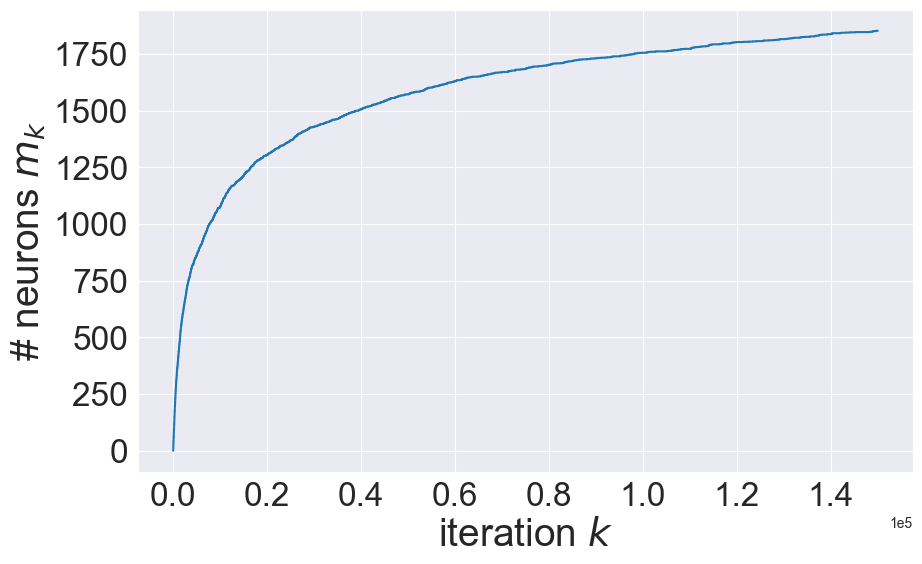

In [18]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

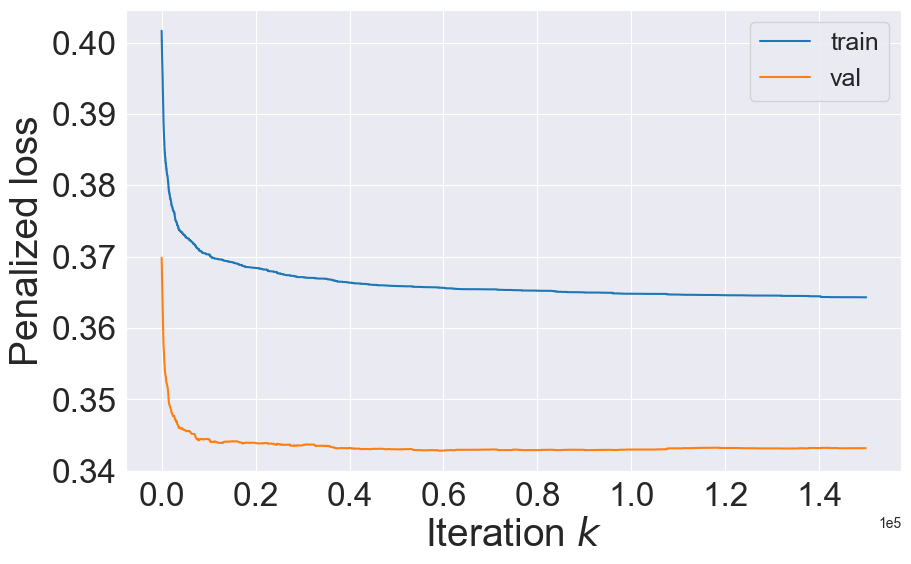

In [19]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_pop)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

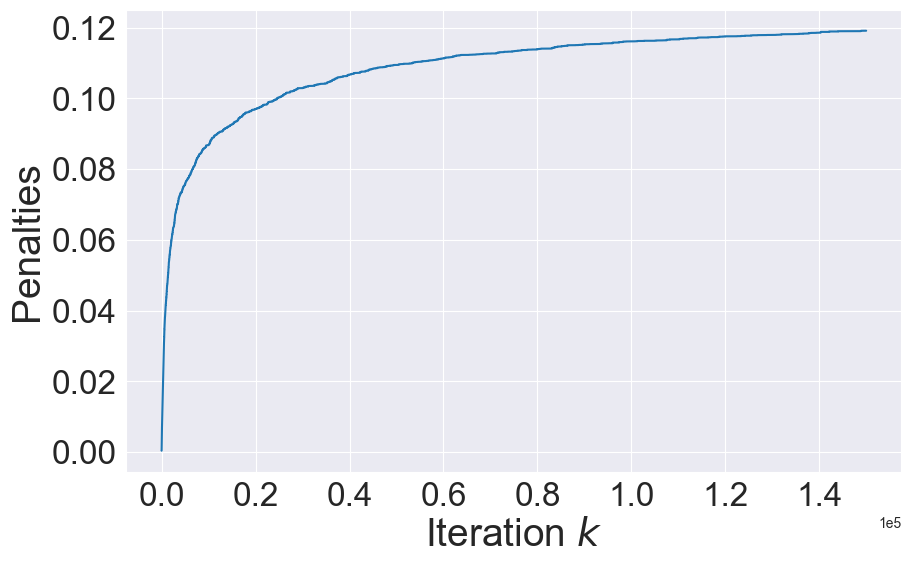

In [20]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_pop - train_losses_pop

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

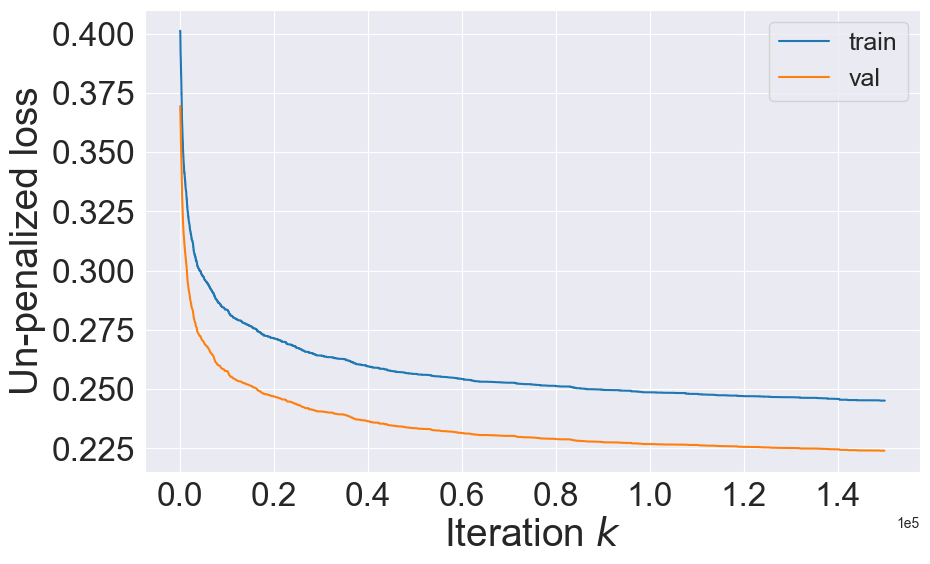

In [21]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_pop)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. $L^2(\tau_m)$ proximal algorithm

Here we sample $m$ neurons $(b_1, \ldots, b_m)$ on the sphere and update their weights via finite-dimensional coordinate descent through the following correspondance:
\begin{align*}
    \mu_a &= \sum_{j=1}^m a_j \delta_{b_j}\\
    f(a) &= J(\mu_a) \\
    g(a) &= \lambda ||a||_1 \\
    F_m(a) &= F(\mu_a) = f(a) +  \lambda ||a||_1\\
    \nabla_j f(a) &= V[\mu_a](b_j) \\
\end{align*}
And $f$ is $L m$-Lipschitz. 

From the $L$-Lipschitzness of $V$ we know that for any $a, b, t$
\begin{align*}
    F_m(a + te_j) = F(\mu_a + t \delta_{b_j}) \leq F_m(a) + V[\mu_a](b_j) t + \frac{L}{2}t^2 + \lambda|t+a_j| - \lambda |a_j|
\end{align*}
In pratice, we do not always have access to the value of $L$, so we choose a step-size $\beta \in (0,1)$, and we have
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{\beta L}{2}t^2 + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|,
\end{align*}
and thus, as soon as $\beta \leq 1/L$ we can virtually replace the initial $L$ by $1$ and $a_j$ by $a_j / \beta$ since
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|.
\end{align*}
The update for the sampled coordinate $j$ thus reads
\begin{align*}
    a_j &\leftarrow a_j + \beta t_j^* \\
    t_j^* :&= \text{argmin}_{t} \left(V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right) = -\frac{a_j}{\beta} - \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right),
\end{align*}
which gives 
\begin{align*}
    a_j &\leftarrow - \beta \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right)
\end{align*}

In [22]:
n_steps = N_STEPS
m = 500
BETA = 1.0

In [23]:
def update_random_neuron(m, a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=m)
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)
        a[0, j] = new_a  

        #if np.abs(new_a) > eps:
            # update weight for neuron b_j
        #    a[0, j] = new_a  
        #else:
            # remove a_j and b_j from the list
            # a = np.column_stack((a[:, :j], a[:, j+1:]))
            # b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [24]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    b_0 = np.copy(b)
    
    ms = [m]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    where_decrease_indexes = []

    for k in tqdm(range(N_STEPS)):
        a, b = update_random_neuron(m, a, b, x_train, y_train, eps=1e-9)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]-1:
            where_decrease_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, b_0, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(where_decrease_indexes)

In [25]:
a, b, b_0, ms, train_losses_coord, penalized_train_losses_coord, val_losses, penalized_val_losses, \
    where_decrease_indexes = train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|                                                       | 57/150000 [00:00<08:16, 302.13it/s]

m at step 0 : 500
Train loss at step 0 : 0.40201
Validation loss at step 0 : 0.37016


  0%|                                                      | 187/150000 [00:00<05:55, 420.98it/s]

m at step 100 : 500
Train loss at step 100 : 0.39312
Validation loss at step 100 : 0.36184
m at step 200 : 500
Train loss at step 200 : 0.38396
Validation loss at step 200 : 0.35326


  0%|▏                                                     | 425/150000 [00:00<04:11, 594.56it/s]

m at step 300 : 500
Train loss at step 300 : 0.37391
Validation loss at step 300 : 0.34357
m at step 400 : 500
Train loss at step 400 : 0.36848
Validation loss at step 400 : 0.33839


  0%|▏                                                     | 544/150000 [00:01<04:46, 521.73it/s]

m at step 500 : 500
Train loss at step 500 : 0.35997
Validation loss at step 500 : 0.32980


  0%|▎                                                     | 731/150000 [00:01<04:15, 584.45it/s]

m at step 600 : 500
Train loss at step 600 : 0.35640
Validation loss at step 600 : 0.32626
m at step 700 : 500
Train loss at step 700 : 0.35215
Validation loss at step 700 : 0.32212


  1%|▎                                                     | 869/150000 [00:01<03:56, 631.34it/s]

m at step 800 : 500
Train loss at step 800 : 0.34883
Validation loss at step 800 : 0.31976
m at step 900 : 500
Train loss at step 900 : 0.34555
Validation loss at step 900 : 0.31716


  1%|▎                                                    | 1047/150000 [00:02<05:06, 486.62it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.34399
Validation loss at step 1,000 : 0.31569
m at step 1,100 : 500
Train loss at step 1,100 : 0.34075
Validation loss at step 1,100 : 0.31274


  1%|▍                                                    | 1298/150000 [00:02<04:40, 530.08it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.33722
Validation loss at step 1,200 : 0.30987
m at step 1,300 : 500
Train loss at step 1,300 : 0.33499
Validation loss at step 1,300 : 0.30819


  1%|▌                                                    | 1510/150000 [00:02<03:51, 641.83it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.33353
Validation loss at step 1,400 : 0.30687
m at step 1,500 : 500
Train loss at step 1,500 : 0.33132
Validation loss at step 1,500 : 0.30470


  1%|▌                                                    | 1658/150000 [00:03<03:35, 689.06it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.32958
Validation loss at step 1,600 : 0.30347
m at step 1,700 : 500
Train loss at step 1,700 : 0.32706
Validation loss at step 1,700 : 0.30069


  1%|▋                                                    | 1942/150000 [00:03<03:35, 687.13it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.32588
Validation loss at step 1,800 : 0.29959
m at step 1,900 : 500
Train loss at step 1,900 : 0.32495
Validation loss at step 1,900 : 0.29904


  1%|▋                                                    | 2087/150000 [00:03<03:51, 639.92it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.32351
Validation loss at step 2,000 : 0.29781
m at step 2,100 : 500
Train loss at step 2,100 : 0.32281
Validation loss at step 2,100 : 0.29727


  2%|▊                                                    | 2271/150000 [00:04<04:43, 521.87it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.32202
Validation loss at step 2,200 : 0.29679
m at step 2,300 : 500
Train loss at step 2,300 : 0.32100
Validation loss at step 2,300 : 0.29601


  2%|▉                                                    | 2505/150000 [00:04<04:40, 525.25it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.31897
Validation loss at step 2,400 : 0.29403
m at step 2,500 : 500
Train loss at step 2,500 : 0.31822
Validation loss at step 2,500 : 0.29335


  2%|▉                                                    | 2729/150000 [00:04<03:35, 683.09it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.31820
Validation loss at step 2,600 : 0.29326
m at step 2,700 : 500
Train loss at step 2,700 : 0.31711
Validation loss at step 2,700 : 0.29206


  2%|█                                                    | 2868/150000 [00:05<03:42, 660.97it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.31663
Validation loss at step 2,800 : 0.29166
m at step 2,900 : 500
Train loss at step 2,900 : 0.31595
Validation loss at step 2,900 : 0.29094


  2%|█                                                    | 3079/150000 [00:05<03:45, 650.96it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.31520
Validation loss at step 3,000 : 0.29019
m at step 3,100 : 500
Train loss at step 3,100 : 0.31330
Validation loss at step 3,100 : 0.28799


  2%|█▏                                                   | 3285/150000 [00:05<04:02, 604.48it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.31248
Validation loss at step 3,200 : 0.28707


  2%|█▏                                                   | 3347/150000 [00:05<04:33, 536.42it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.31220
Validation loss at step 3,300 : 0.28706


  2%|█▏                                                   | 3467/150000 [00:06<04:58, 491.37it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.31158
Validation loss at step 3,400 : 0.28641
m at step 3,500 : 500
Train loss at step 3,500 : 0.31080
Validation loss at step 3,500 : 0.28556


  2%|█▎                                                   | 3697/150000 [00:06<04:47, 509.17it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.31024
Validation loss at step 3,600 : 0.28514
m at step 3,700 : 500
Train loss at step 3,700 : 0.30956
Validation loss at step 3,700 : 0.28448


  3%|█▍                                                   | 3928/150000 [00:07<03:34, 682.20it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.30864
Validation loss at step 3,800 : 0.28321
m at step 3,900 : 500
Train loss at step 3,900 : 0.30788
Validation loss at step 3,900 : 0.28241


  3%|█▍                                                   | 4066/150000 [00:07<04:01, 605.26it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.30761
Validation loss at step 4,000 : 0.28218
m at step 4,100 : 500
Train loss at step 4,100 : 0.30678
Validation loss at step 4,100 : 0.28168


  3%|█▌                                                   | 4288/150000 [00:07<03:28, 699.30it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.30620
Validation loss at step 4,200 : 0.28117
m at step 4,300 : 500
Train loss at step 4,300 : 0.30640
Validation loss at step 4,300 : 0.28155


  3%|█▌                                                   | 4514/150000 [00:07<03:52, 626.92it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.30559
Validation loss at step 4,400 : 0.28098
m at step 4,500 : 500
Train loss at step 4,500 : 0.30536
Validation loss at step 4,500 : 0.28094


  3%|█▋                                                   | 4693/150000 [00:08<04:43, 512.20it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.30464
Validation loss at step 4,600 : 0.28045


  3%|█▋                                                   | 4804/150000 [00:08<04:45, 509.42it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.30350
Validation loss at step 4,700 : 0.27953
m at step 4,800 : 500
Train loss at step 4,800 : 0.30357
Validation loss at step 4,800 : 0.27966


  3%|█▊                                                   | 5008/150000 [00:08<03:56, 613.24it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.30313
Validation loss at step 4,900 : 0.27948
m at step 5,000 : 500
Train loss at step 5,000 : 0.30276
Validation loss at step 5,000 : 0.27909


  3%|█▊                                                   | 5166/150000 [00:09<03:26, 702.06it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.30237
Validation loss at step 5,100 : 0.27891
m at step 5,200 : 500
Train loss at step 5,200 : 0.30220
Validation loss at step 5,200 : 0.27884


  4%|█▉                                                   | 5364/150000 [00:09<04:09, 579.72it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.30188
Validation loss at step 5,300 : 0.27853
m at step 5,400 : 500
Train loss at step 5,400 : 0.30193
Validation loss at step 5,400 : 0.27870


  4%|█▉                                                   | 5581/150000 [00:09<04:08, 582.02it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.30165
Validation loss at step 5,500 : 0.27841


  4%|█▉                                                   | 5642/150000 [00:09<04:22, 550.55it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.30144
Validation loss at step 5,600 : 0.27815


  4%|██                                                   | 5764/150000 [00:10<04:38, 518.22it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.30150
Validation loss at step 5,700 : 0.27825
m at step 5,800 : 500
Train loss at step 5,800 : 0.30085
Validation loss at step 5,800 : 0.27766


  4%|██                                                   | 5989/150000 [00:10<04:36, 521.11it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.30066
Validation loss at step 5,900 : 0.27744
m at step 6,000 : 500
Train loss at step 6,000 : 0.30000
Validation loss at step 6,000 : 0.27674


  4%|██▏                                                  | 6207/150000 [00:10<03:35, 667.69it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.29958
Validation loss at step 6,100 : 0.27643
m at step 6,200 : 500
Train loss at step 6,200 : 0.29865
Validation loss at step 6,200 : 0.27567


  4%|██▏                                                  | 6352/150000 [00:11<03:43, 642.72it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.29819
Validation loss at step 6,300 : 0.27533
m at step 6,400 : 500
Train loss at step 6,400 : 0.29780
Validation loss at step 6,400 : 0.27485


  4%|██▎                                                  | 6651/150000 [00:11<03:17, 725.09it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.29746
Validation loss at step 6,500 : 0.27455
m at step 6,600 : 500
Train loss at step 6,600 : 0.29732
Validation loss at step 6,600 : 0.27446


  5%|██▍                                                  | 6794/150000 [00:11<03:51, 618.72it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.29637
Validation loss at step 6,700 : 0.27333
m at step 6,800 : 500
Train loss at step 6,800 : 0.29646
Validation loss at step 6,800 : 0.27340


  5%|██▍                                                  | 6982/150000 [00:12<04:22, 545.82it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.29603
Validation loss at step 6,900 : 0.27300
m at step 7,000 : 500
Train loss at step 7,000 : 0.29578
Validation loss at step 7,000 : 0.27271


  5%|██▌                                                  | 7167/150000 [00:12<04:31, 525.39it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.29571
Validation loss at step 7,100 : 0.27265


  5%|██▌                                                  | 7296/150000 [00:12<04:06, 579.37it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.29507
Validation loss at step 7,200 : 0.27201
m at step 7,300 : 500
Train loss at step 7,300 : 0.29457
Validation loss at step 7,300 : 0.27131


  5%|██▋                                                  | 7511/150000 [00:13<03:36, 657.65it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.29403
Validation loss at step 7,400 : 0.27071
m at step 7,500 : 500
Train loss at step 7,500 : 0.29311
Validation loss at step 7,500 : 0.26975


  5%|██▋                                                  | 7717/150000 [00:13<03:43, 636.13it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.29314
Validation loss at step 7,600 : 0.26976
m at step 7,700 : 500
Train loss at step 7,700 : 0.29319
Validation loss at step 7,700 : 0.26980


  5%|██▊                                                  | 7919/150000 [00:13<03:58, 596.95it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.29307
Validation loss at step 7,800 : 0.26967
m at step 7,900 : 500
Train loss at step 7,900 : 0.29311
Validation loss at step 7,900 : 0.26973


  5%|██▊                                                  | 8039/150000 [00:14<04:51, 487.10it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.29293
Validation loss at step 8,000 : 0.26963


  5%|██▊                                                  | 8100/150000 [00:14<04:34, 517.35it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.29272
Validation loss at step 8,100 : 0.26935


  6%|██▉                                                  | 8281/150000 [00:14<05:07, 461.38it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.29284
Validation loss at step 8,200 : 0.26949
m at step 8,300 : 500
Train loss at step 8,300 : 0.29287
Validation loss at step 8,300 : 0.26952


  6%|███                                                  | 8519/150000 [00:15<03:36, 654.05it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.29235
Validation loss at step 8,400 : 0.26891
m at step 8,500 : 500
Train loss at step 8,500 : 0.29191
Validation loss at step 8,500 : 0.26834


  6%|███                                                  | 8726/150000 [00:15<03:56, 596.43it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.29177
Validation loss at step 8,600 : 0.26838
m at step 8,700 : 500
Train loss at step 8,700 : 0.29163
Validation loss at step 8,700 : 0.26818


  6%|███▏                                                 | 8875/150000 [00:15<03:32, 665.35it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.29128
Validation loss at step 8,800 : 0.26774
m at step 8,900 : 500
Train loss at step 8,900 : 0.29080
Validation loss at step 8,900 : 0.26708


  6%|███▏                                                 | 9070/150000 [00:16<04:31, 518.88it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.29092
Validation loss at step 9,000 : 0.26716


  6%|███▏                                                 | 9177/150000 [00:16<04:40, 501.18it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.29060
Validation loss at step 9,100 : 0.26672
m at step 9,200 : 500
Train loss at step 9,200 : 0.29052
Validation loss at step 9,200 : 0.26660


  6%|███▎                                                 | 9355/150000 [00:16<04:32, 516.77it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.29028
Validation loss at step 9,300 : 0.26631
m at step 9,400 : 500
Train loss at step 9,400 : 0.28981
Validation loss at step 9,400 : 0.26572


  6%|███▍                                                 | 9658/150000 [00:16<03:15, 718.50it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.28957
Validation loss at step 9,500 : 0.26547
m at step 9,600 : 500
Train loss at step 9,600 : 0.28934
Validation loss at step 9,600 : 0.26517


  7%|███▍                                                 | 9798/150000 [00:17<03:46, 620.25it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.28882
Validation loss at step 9,700 : 0.26456
m at step 9,800 : 500
Train loss at step 9,800 : 0.28884
Validation loss at step 9,800 : 0.26457


  7%|███▍                                                | 10013/150000 [00:17<03:28, 672.71it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.28871
Validation loss at step 9,900 : 0.26442
m at step 10,000 : 500
Train loss at step 10,000 : 0.28845
Validation loss at step 10,000 : 0.26413


  7%|███▌                                                | 10207/150000 [00:17<04:14, 548.50it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.28797
Validation loss at step 10,100 : 0.26358
m at step 10,200 : 500
Train loss at step 10,200 : 0.28768
Validation loss at step 10,200 : 0.26318


  7%|███▌                                                | 10383/150000 [00:18<04:41, 496.57it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.28777
Validation loss at step 10,300 : 0.26332


  7%|███▋                                                | 10494/150000 [00:18<04:30, 516.33it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.28764
Validation loss at step 10,400 : 0.26314
m at step 10,500 : 500
Train loss at step 10,500 : 0.28739
Validation loss at step 10,500 : 0.26293


  7%|███▋                                                | 10688/150000 [00:18<03:53, 596.75it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.28709
Validation loss at step 10,600 : 0.26271
m at step 10,700 : 500
Train loss at step 10,700 : 0.28697
Validation loss at step 10,700 : 0.26263


  7%|███▊                                                | 10862/150000 [00:19<04:32, 509.77it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.28669
Validation loss at step 10,800 : 0.26229
m at step 10,900 : 500
Train loss at step 10,900 : 0.28659
Validation loss at step 10,900 : 0.26221


  7%|███▊                                                | 11161/150000 [00:19<03:20, 693.75it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.28618
Validation loss at step 11,000 : 0.26173
m at step 11,100 : 500
Train loss at step 11,100 : 0.28628
Validation loss at step 11,100 : 0.26183


  8%|███▉                                                | 11295/150000 [00:19<04:05, 565.83it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.28632
Validation loss at step 11,200 : 0.26187


  8%|███▉                                                | 11354/150000 [00:20<04:43, 489.91it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.28591
Validation loss at step 11,300 : 0.26149
m at step 11,400 : 500
Train loss at step 11,400 : 0.28598
Validation loss at step 11,400 : 0.26156


  8%|████                                                | 11579/150000 [00:20<04:30, 510.83it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.28608
Validation loss at step 11,500 : 0.26167
m at step 11,600 : 500
Train loss at step 11,600 : 0.28602
Validation loss at step 11,600 : 0.26160


  8%|████                                                | 11792/150000 [00:20<03:37, 635.57it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.28605
Validation loss at step 11,700 : 0.26162
m at step 11,800 : 500
Train loss at step 11,800 : 0.28619
Validation loss at step 11,800 : 0.26173


  8%|████▏                                               | 12009/150000 [00:21<03:44, 613.94it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.28579
Validation loss at step 11,900 : 0.26128
m at step 12,000 : 500
Train loss at step 12,000 : 0.28544
Validation loss at step 12,000 : 0.26102


  8%|████▏                                               | 12216/150000 [00:21<03:26, 668.75it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.28555
Validation loss at step 12,100 : 0.26114
m at step 12,200 : 500
Train loss at step 12,200 : 0.28552
Validation loss at step 12,200 : 0.26112


  8%|████▎                                               | 12350/150000 [00:21<03:45, 611.69it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.28554
Validation loss at step 12,300 : 0.26112
m at step 12,400 : 500
Train loss at step 12,400 : 0.28509
Validation loss at step 12,400 : 0.26054


  8%|████▎                                               | 12590/150000 [00:22<04:18, 531.27it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.28476
Validation loss at step 12,500 : 0.26016
m at step 12,600 : 500
Train loss at step 12,600 : 0.28444
Validation loss at step 12,600 : 0.25992


  9%|████▍                                               | 12778/150000 [00:22<04:18, 530.59it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.28398
Validation loss at step 12,700 : 0.25941


  9%|████▍                                               | 12911/150000 [00:22<03:51, 593.09it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.28406
Validation loss at step 12,800 : 0.25949
m at step 12,900 : 500
Train loss at step 12,900 : 0.28403
Validation loss at step 12,900 : 0.25942


  9%|████▌                                               | 13131/150000 [00:23<03:32, 643.08it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.28417
Validation loss at step 13,000 : 0.25951
m at step 13,100 : 500
Train loss at step 13,100 : 0.28418
Validation loss at step 13,100 : 0.25951


  9%|████▋                                               | 13352/150000 [00:23<03:21, 676.75it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.28399
Validation loss at step 13,200 : 0.25934
m at step 13,300 : 500
Train loss at step 13,300 : 0.28369
Validation loss at step 13,300 : 0.25902


  9%|████▋                                               | 13491/150000 [00:23<03:23, 672.44it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.28373
Validation loss at step 13,400 : 0.25911
m at step 13,500 : 500
Train loss at step 13,500 : 0.28374
Validation loss at step 13,500 : 0.25915


  9%|████▋                                               | 13679/150000 [00:24<04:33, 498.48it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.28364
Validation loss at step 13,600 : 0.25907


  9%|████▊                                               | 13791/150000 [00:24<04:31, 501.15it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.28352
Validation loss at step 13,700 : 0.25895
m at step 13,800 : 500
Train loss at step 13,800 : 0.28313
Validation loss at step 13,800 : 0.25835


  9%|████▊                                               | 13958/150000 [00:24<04:31, 501.99it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.28308
Validation loss at step 13,900 : 0.25828
m at step 14,000 : 500
Train loss at step 14,000 : 0.28303
Validation loss at step 14,000 : 0.25825


  9%|████▉                                               | 14183/150000 [00:24<03:24, 664.27it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.28309
Validation loss at step 14,100 : 0.25829
m at step 14,200 : 500
Train loss at step 14,200 : 0.28309
Validation loss at step 14,200 : 0.25834


 10%|████▉                                               | 14415/150000 [00:25<03:35, 628.84it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.28295
Validation loss at step 14,300 : 0.25817
m at step 14,400 : 500
Train loss at step 14,400 : 0.28287
Validation loss at step 14,400 : 0.25804


 10%|█████                                               | 14634/150000 [00:25<03:19, 677.06it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.28274
Validation loss at step 14,500 : 0.25795
m at step 14,600 : 500
Train loss at step 14,600 : 0.28256
Validation loss at step 14,600 : 0.25765


 10%|█████                                               | 14766/150000 [00:25<03:50, 587.13it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.28250
Validation loss at step 14,700 : 0.25762


 10%|█████▏                                              | 14889/150000 [00:26<04:16, 526.10it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.28248
Validation loss at step 14,800 : 0.25761
m at step 14,900 : 500
Train loss at step 14,900 : 0.28262
Validation loss at step 14,900 : 0.25774


 10%|█████▏                                              | 15114/150000 [00:26<04:21, 515.99it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.28236
Validation loss at step 15,000 : 0.25745
m at step 15,100 : 500
Train loss at step 15,100 : 0.28228
Validation loss at step 15,100 : 0.25735


 10%|█████▎                                              | 15329/150000 [00:26<03:22, 666.12it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.28176
Validation loss at step 15,200 : 0.25693
m at step 15,300 : 500
Train loss at step 15,300 : 0.28189
Validation loss at step 15,300 : 0.25704


 10%|█████▎                                              | 15472/150000 [00:27<03:33, 629.44it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.28144
Validation loss at step 15,400 : 0.25651
m at step 15,500 : 500
Train loss at step 15,500 : 0.28159
Validation loss at step 15,500 : 0.25662


 10%|█████▍                                              | 15687/150000 [00:27<03:19, 672.07it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.28149
Validation loss at step 15,600 : 0.25645
m at step 15,700 : 500
Train loss at step 15,700 : 0.28132
Validation loss at step 15,700 : 0.25621


 11%|█████▍                                              | 15845/150000 [00:27<03:24, 656.69it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.28116
Validation loss at step 15,800 : 0.25594


 11%|█████▌                                              | 15974/150000 [00:28<04:22, 510.63it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.28111
Validation loss at step 15,900 : 0.25591


 11%|█████▌                                              | 16080/150000 [00:28<04:31, 493.93it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.28125
Validation loss at step 16,000 : 0.25603


 11%|█████▌                                              | 16186/150000 [00:28<06:09, 362.37it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.28135
Validation loss at step 16,100 : 0.25613


 11%|█████▋                                              | 16320/150000 [00:28<04:35, 485.89it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.28127
Validation loss at step 16,200 : 0.25593
m at step 16,300 : 500
Train loss at step 16,300 : 0.28115
Validation loss at step 16,300 : 0.25585


 11%|█████▋                                              | 16462/150000 [00:29<03:47, 586.53it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.28092
Validation loss at step 16,400 : 0.25553
m at step 16,500 : 500
Train loss at step 16,500 : 0.28088
Validation loss at step 16,500 : 0.25546


 11%|█████▊                                              | 16735/150000 [00:29<03:24, 650.96it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.28095
Validation loss at step 16,600 : 0.25550
m at step 16,700 : 500
Train loss at step 16,700 : 0.28079
Validation loss at step 16,700 : 0.25540


 11%|█████▊                                              | 16876/150000 [00:29<03:43, 596.32it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.28049
Validation loss at step 16,800 : 0.25505


 11%|█████▊                                              | 16939/150000 [00:30<05:32, 400.08it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.28043
Validation loss at step 16,900 : 0.25489


 11%|█████▉                                              | 17088/150000 [00:30<05:11, 426.60it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.28063
Validation loss at step 17,000 : 0.25512


 11%|█████▉                                              | 17192/150000 [00:30<04:56, 448.42it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.28055
Validation loss at step 17,100 : 0.25504


 12%|██████                                              | 17324/150000 [00:30<04:00, 552.10it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.28022
Validation loss at step 17,200 : 0.25475
m at step 17,300 : 500
Train loss at step 17,300 : 0.28005
Validation loss at step 17,300 : 0.25457


 12%|██████                                              | 17535/150000 [00:31<03:28, 634.46it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.28003
Validation loss at step 17,400 : 0.25461
m at step 17,500 : 500
Train loss at step 17,500 : 0.28008
Validation loss at step 17,500 : 0.25468


 12%|██████▏                                             | 17754/150000 [00:31<03:19, 662.26it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.28006
Validation loss at step 17,600 : 0.25464
m at step 17,700 : 500
Train loss at step 17,700 : 0.28007
Validation loss at step 17,700 : 0.25466


 12%|██████▏                                             | 17897/150000 [00:31<03:12, 685.49it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.27959
Validation loss at step 17,800 : 0.25408
m at step 17,900 : 500
Train loss at step 17,900 : 0.27950
Validation loss at step 17,900 : 0.25395


 12%|██████▎                                             | 18029/150000 [00:31<03:46, 582.74it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.27930
Validation loss at step 18,000 : 0.25374


 12%|██████▎                                             | 18214/150000 [00:32<04:20, 505.99it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.27906
Validation loss at step 18,100 : 0.25357
m at step 18,200 : 500
Train loss at step 18,200 : 0.27907
Validation loss at step 18,200 : 0.25362


 12%|██████▎                                             | 18380/150000 [00:32<04:19, 507.79it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.27900
Validation loss at step 18,300 : 0.25359
m at step 18,400 : 500
Train loss at step 18,400 : 0.27899
Validation loss at step 18,400 : 0.25361


 12%|██████▍                                             | 18608/150000 [00:32<03:13, 677.81it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.27899
Validation loss at step 18,500 : 0.25365
m at step 18,600 : 500
Train loss at step 18,600 : 0.27910
Validation loss at step 18,600 : 0.25373


 13%|██████▌                                             | 18757/150000 [00:33<03:33, 613.36it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.27916
Validation loss at step 18,700 : 0.25381
m at step 18,800 : 500
Train loss at step 18,800 : 0.27927
Validation loss at step 18,800 : 0.25391


 13%|██████▌                                             | 19057/150000 [00:33<03:05, 707.74it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.27862
Validation loss at step 18,900 : 0.25309
m at step 19,000 : 500
Train loss at step 19,000 : 0.27852
Validation loss at step 19,000 : 0.25298


 13%|██████▋                                             | 19193/150000 [00:33<03:40, 592.10it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.27810
Validation loss at step 19,100 : 0.25243
m at step 19,200 : 500
Train loss at step 19,200 : 0.27809
Validation loss at step 19,200 : 0.25236


 13%|██████▋                                             | 19366/150000 [00:34<04:13, 515.78it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.27803
Validation loss at step 19,300 : 0.25235


 13%|██████▊                                             | 19488/150000 [00:34<04:04, 534.48it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.27811
Validation loss at step 19,400 : 0.25241
m at step 19,500 : 500
Train loss at step 19,500 : 0.27815
Validation loss at step 19,500 : 0.25244


 13%|██████▊                                             | 19691/150000 [00:34<03:32, 613.86it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.27814
Validation loss at step 19,600 : 0.25241
m at step 19,700 : 500
Train loss at step 19,700 : 0.27817
Validation loss at step 19,700 : 0.25246


 13%|██████▉                                             | 19925/150000 [00:35<03:24, 636.04it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.27815
Validation loss at step 19,800 : 0.25234
m at step 19,900 : 500
Train loss at step 19,900 : 0.27827
Validation loss at step 19,900 : 0.25247


 13%|██████▉                                             | 20134/150000 [00:35<03:15, 663.15it/s]

m at step 20,000 : 500
Train loss at step 20,000 : 0.27816
Validation loss at step 20,000 : 0.25244
m at step 20,100 : 500
Train loss at step 20,100 : 0.27808
Validation loss at step 20,100 : 0.25230


 14%|███████                                             | 20274/150000 [00:35<03:26, 626.90it/s]

m at step 20,200 : 500
Train loss at step 20,200 : 0.27790
Validation loss at step 20,200 : 0.25208


 14%|███████                                             | 20398/150000 [00:35<04:06, 526.60it/s]

m at step 20,300 : 500
Train loss at step 20,300 : 0.27755
Validation loss at step 20,300 : 0.25169


 14%|███████                                             | 20511/150000 [00:36<04:16, 504.78it/s]

m at step 20,400 : 500
Train loss at step 20,400 : 0.27730
Validation loss at step 20,400 : 0.25132
m at step 20,500 : 500
Train loss at step 20,500 : 0.27724
Validation loss at step 20,500 : 0.25130


 14%|███████▏                                            | 20701/150000 [00:36<04:02, 534.00it/s]

m at step 20,600 : 500
Train loss at step 20,600 : 0.27716
Validation loss at step 20,600 : 0.25132
m at step 20,700 : 500
Train loss at step 20,700 : 0.27708
Validation loss at step 20,700 : 0.25125


 14%|███████▏                                            | 20909/150000 [00:36<03:18, 651.00it/s]

m at step 20,800 : 500
Train loss at step 20,800 : 0.27700
Validation loss at step 20,800 : 0.25109
m at step 20,900 : 500
Train loss at step 20,900 : 0.27691
Validation loss at step 20,900 : 0.25106


 14%|███████▎                                            | 21049/150000 [00:37<03:16, 655.49it/s]

m at step 21,000 : 500
Train loss at step 21,000 : 0.27699
Validation loss at step 21,000 : 0.25114
m at step 21,100 : 500
Train loss at step 21,100 : 0.27696
Validation loss at step 21,100 : 0.25117


 14%|███████▍                                            | 21341/150000 [00:37<03:03, 699.87it/s]

m at step 21,200 : 500
Train loss at step 21,200 : 0.27678
Validation loss at step 21,200 : 0.25095
m at step 21,300 : 500
Train loss at step 21,300 : 0.27681
Validation loss at step 21,300 : 0.25097


 14%|███████▍                                            | 21483/150000 [00:37<03:41, 580.50it/s]

m at step 21,400 : 500
Train loss at step 21,400 : 0.27664
Validation loss at step 21,400 : 0.25078


 14%|███████▍                                            | 21545/150000 [00:37<03:57, 541.62it/s]

m at step 21,500 : 500
Train loss at step 21,500 : 0.27661
Validation loss at step 21,500 : 0.25074


 14%|███████▌                                            | 21661/150000 [00:38<04:16, 500.97it/s]

m at step 21,600 : 500
Train loss at step 21,600 : 0.27641
Validation loss at step 21,600 : 0.25053
m at step 21,700 : 500
Train loss at step 21,700 : 0.27621
Validation loss at step 21,700 : 0.25027


 15%|███████▌                                            | 21907/150000 [00:38<03:58, 536.99it/s]

m at step 21,800 : 500
Train loss at step 21,800 : 0.27621
Validation loss at step 21,800 : 0.25027
m at step 21,900 : 500
Train loss at step 21,900 : 0.27631
Validation loss at step 21,900 : 0.25037


 15%|███████▋                                            | 22126/150000 [00:38<03:11, 666.35it/s]

m at step 22,000 : 500
Train loss at step 22,000 : 0.27628
Validation loss at step 22,000 : 0.25040
m at step 22,100 : 500
Train loss at step 22,100 : 0.27627
Validation loss at step 22,100 : 0.25041


 15%|███████▋                                            | 22260/150000 [00:39<03:37, 587.23it/s]

m at step 22,200 : 500
Train loss at step 22,200 : 0.27631
Validation loss at step 22,200 : 0.25039
m at step 22,300 : 500
Train loss at step 22,300 : 0.27619
Validation loss at step 22,300 : 0.25027


 15%|███████▊                                            | 22564/150000 [00:39<02:57, 718.18it/s]

m at step 22,400 : 500
Train loss at step 22,400 : 0.27622
Validation loss at step 22,400 : 0.25027
m at step 22,500 : 500
Train loss at step 22,500 : 0.27624
Validation loss at step 22,500 : 0.25027


 15%|███████▊                                            | 22637/150000 [00:39<03:45, 563.78it/s]

m at step 22,600 : 500
Train loss at step 22,600 : 0.27630
Validation loss at step 22,600 : 0.25038


 15%|███████▉                                            | 22753/150000 [00:40<04:34, 463.84it/s]

m at step 22,700 : 500
Train loss at step 22,700 : 0.27637
Validation loss at step 22,700 : 0.25046


 15%|███████▉                                            | 22853/150000 [00:40<04:45, 444.76it/s]

m at step 22,800 : 500
Train loss at step 22,800 : 0.27635
Validation loss at step 22,800 : 0.25041
m at step 22,900 : 500
Train loss at step 22,900 : 0.27639
Validation loss at step 22,900 : 0.25045


 15%|████████                                            | 23106/150000 [00:40<03:36, 585.83it/s]

m at step 23,000 : 500
Train loss at step 23,000 : 0.27637
Validation loss at step 23,000 : 0.25041
m at step 23,100 : 500
Train loss at step 23,100 : 0.27644
Validation loss at step 23,100 : 0.25048


 16%|████████                                            | 23331/150000 [00:41<03:20, 630.36it/s]

m at step 23,200 : 500
Train loss at step 23,200 : 0.27615
Validation loss at step 23,200 : 0.25011
m at step 23,300 : 500
Train loss at step 23,300 : 0.27610
Validation loss at step 23,300 : 0.25013


 16%|████████▏                                           | 23551/150000 [00:41<03:07, 674.91it/s]

m at step 23,400 : 500
Train loss at step 23,400 : 0.27595
Validation loss at step 23,400 : 0.25001
m at step 23,500 : 500
Train loss at step 23,500 : 0.27582
Validation loss at step 23,500 : 0.24990


 16%|████████▏                                           | 23688/150000 [00:41<03:16, 643.66it/s]

m at step 23,600 : 500
Train loss at step 23,600 : 0.27582
Validation loss at step 23,600 : 0.24991
m at step 23,700 : 500
Train loss at step 23,700 : 0.27594
Validation loss at step 23,700 : 0.25005


 16%|████████▎                                           | 23867/150000 [00:42<04:22, 480.88it/s]

m at step 23,800 : 500
Train loss at step 23,800 : 0.27568
Validation loss at step 23,800 : 0.24972


 16%|████████▎                                           | 23971/150000 [00:42<04:26, 472.41it/s]

m at step 23,900 : 500
Train loss at step 23,900 : 0.27567
Validation loss at step 23,900 : 0.24968


 16%|████████▎                                           | 24070/150000 [00:42<04:22, 479.13it/s]

m at step 24,000 : 500
Train loss at step 24,000 : 0.27538
Validation loss at step 24,000 : 0.24930


 16%|████████▍                                           | 24194/150000 [00:42<03:54, 536.36it/s]

m at step 24,100 : 500
Train loss at step 24,100 : 0.27512
Validation loss at step 24,100 : 0.24888
m at step 24,200 : 500
Train loss at step 24,200 : 0.27491
Validation loss at step 24,200 : 0.24869


 16%|████████▍                                           | 24412/150000 [00:43<03:11, 657.52it/s]

m at step 24,300 : 500
Train loss at step 24,300 : 0.27478
Validation loss at step 24,300 : 0.24853
m at step 24,400 : 500
Train loss at step 24,400 : 0.27460
Validation loss at step 24,400 : 0.24833


 16%|████████▌                                           | 24625/150000 [00:43<03:16, 636.83it/s]

m at step 24,500 : 500
Train loss at step 24,500 : 0.27464
Validation loss at step 24,500 : 0.24837
m at step 24,600 : 500
Train loss at step 24,600 : 0.27467
Validation loss at step 24,600 : 0.24837


 17%|████████▌                                           | 24757/150000 [00:43<03:17, 633.70it/s]

m at step 24,700 : 500
Train loss at step 24,700 : 0.27458
Validation loss at step 24,700 : 0.24824
m at step 24,800 : 500
Train loss at step 24,800 : 0.27456
Validation loss at step 24,800 : 0.24818


 17%|████████▋                                           | 24994/150000 [00:44<04:04, 510.30it/s]

m at step 24,900 : 500
Train loss at step 24,900 : 0.27441
Validation loss at step 24,900 : 0.24798
m at step 25,000 : 500
Train loss at step 25,000 : 0.27442
Validation loss at step 25,000 : 0.24800


 17%|████████▋                                           | 25169/150000 [00:44<03:51, 540.06it/s]

m at step 25,100 : 500
Train loss at step 25,100 : 0.27443
Validation loss at step 25,100 : 0.24804


 17%|████████▊                                           | 25296/150000 [00:44<04:22, 474.55it/s]

m at step 25,200 : 500
Train loss at step 25,200 : 0.27447
Validation loss at step 25,200 : 0.24811
m at step 25,300 : 500
Train loss at step 25,300 : 0.27445
Validation loss at step 25,300 : 0.24813


 17%|████████▊                                           | 25432/150000 [00:45<03:38, 571.22it/s]

m at step 25,400 : 500
Train loss at step 25,400 : 0.27438
Validation loss at step 25,400 : 0.24804


 17%|████████▉                                           | 25615/150000 [00:45<03:52, 534.25it/s]

m at step 25,500 : 500
Train loss at step 25,500 : 0.27442
Validation loss at step 25,500 : 0.24813
m at step 25,600 : 500
Train loss at step 25,600 : 0.27427
Validation loss at step 25,600 : 0.24799


 17%|████████▉                                           | 25837/150000 [00:45<03:23, 611.62it/s]

m at step 25,700 : 500
Train loss at step 25,700 : 0.27431
Validation loss at step 25,700 : 0.24801
m at step 25,800 : 500
Train loss at step 25,800 : 0.27426
Validation loss at step 25,800 : 0.24797


 17%|████████▉                                           | 25958/150000 [00:46<04:15, 484.81it/s]

m at step 25,900 : 500
Train loss at step 25,900 : 0.27405
Validation loss at step 25,900 : 0.24777


 17%|█████████                                           | 26054/150000 [00:46<05:16, 391.83it/s]

m at step 26,000 : 500
Train loss at step 26,000 : 0.27412
Validation loss at step 26,000 : 0.24784
m at step 26,100 : 500
Train loss at step 26,100 : 0.27400
Validation loss at step 26,100 : 0.24774


 18%|█████████                                           | 26301/150000 [00:46<03:43, 554.30it/s]

m at step 26,200 : 500
Train loss at step 26,200 : 0.27398
Validation loss at step 26,200 : 0.24767
m at step 26,300 : 500
Train loss at step 26,300 : 0.27404
Validation loss at step 26,300 : 0.24775


 18%|█████████▏                                          | 26526/150000 [00:47<03:01, 679.22it/s]

m at step 26,400 : 500
Train loss at step 26,400 : 0.27410
Validation loss at step 26,400 : 0.24782
m at step 26,500 : 500
Train loss at step 26,500 : 0.27406
Validation loss at step 26,500 : 0.24782


 18%|█████████▎                                          | 26737/150000 [00:47<03:12, 639.49it/s]

m at step 26,600 : 500
Train loss at step 26,600 : 0.27408
Validation loss at step 26,600 : 0.24784
m at step 26,700 : 500
Train loss at step 26,700 : 0.27396
Validation loss at step 26,700 : 0.24770


 18%|█████████▎                                          | 26889/150000 [00:47<02:55, 701.59it/s]

m at step 26,800 : 500
Train loss at step 26,800 : 0.27380
Validation loss at step 26,800 : 0.24751
m at step 26,900 : 500
Train loss at step 26,900 : 0.27373
Validation loss at step 26,900 : 0.24741


 18%|█████████▎                                          | 27024/150000 [00:47<03:40, 557.63it/s]

m at step 27,000 : 500
Train loss at step 27,000 : 0.27374
Validation loss at step 27,000 : 0.24744


 18%|█████████▍                                          | 27200/150000 [00:48<03:59, 511.85it/s]

m at step 27,100 : 500
Train loss at step 27,100 : 0.27362
Validation loss at step 27,100 : 0.24728
m at step 27,200 : 500
Train loss at step 27,200 : 0.27380
Validation loss at step 27,200 : 0.24752


 18%|█████████▍                                          | 27363/150000 [00:48<03:59, 511.18it/s]

m at step 27,300 : 500
Train loss at step 27,300 : 0.27393
Validation loss at step 27,300 : 0.24766
m at step 27,400 : 500
Train loss at step 27,400 : 0.27385
Validation loss at step 27,400 : 0.24761


 18%|█████████▌                                          | 27657/150000 [00:49<02:57, 689.91it/s]

m at step 27,500 : 500
Train loss at step 27,500 : 0.27394
Validation loss at step 27,500 : 0.24772
m at step 27,600 : 500
Train loss at step 27,600 : 0.27380
Validation loss at step 27,600 : 0.24759


 19%|█████████▋                                          | 27790/150000 [00:49<03:23, 601.54it/s]

m at step 27,700 : 500
Train loss at step 27,700 : 0.27368
Validation loss at step 27,700 : 0.24747
m at step 27,800 : 500
Train loss at step 27,800 : 0.27370
Validation loss at step 27,800 : 0.24754


 19%|█████████▋                                          | 28010/150000 [00:49<02:58, 684.00it/s]

m at step 27,900 : 500
Train loss at step 27,900 : 0.27373
Validation loss at step 27,900 : 0.24758
m at step 28,000 : 500
Train loss at step 28,000 : 0.27370
Validation loss at step 28,000 : 0.24758


 19%|█████████▊                                          | 28145/150000 [00:49<03:28, 584.86it/s]

m at step 28,100 : 500
Train loss at step 28,100 : 0.27376
Validation loss at step 28,100 : 0.24764


 19%|█████████▊                                          | 28257/150000 [00:50<04:15, 476.65it/s]

m at step 28,200 : 500
Train loss at step 28,200 : 0.27374
Validation loss at step 28,200 : 0.24761


 19%|█████████▊                                          | 28358/150000 [00:50<04:28, 452.79it/s]

m at step 28,300 : 500
Train loss at step 28,300 : 0.27379
Validation loss at step 28,300 : 0.24769
m at step 28,400 : 500
Train loss at step 28,400 : 0.27378
Validation loss at step 28,400 : 0.24769


 19%|█████████▉                                          | 28614/150000 [00:50<03:27, 584.72it/s]

m at step 28,500 : 500
Train loss at step 28,500 : 0.27365
Validation loss at step 28,500 : 0.24752
m at step 28,600 : 500
Train loss at step 28,600 : 0.27365
Validation loss at step 28,600 : 0.24756


 19%|█████████▉                                          | 28769/150000 [00:51<02:57, 681.58it/s]

m at step 28,700 : 500
Train loss at step 28,700 : 0.27336
Validation loss at step 28,700 : 0.24715
m at step 28,800 : 500
Train loss at step 28,800 : 0.27332
Validation loss at step 28,800 : 0.24707


 19%|██████████                                          | 28974/150000 [00:51<03:15, 619.00it/s]

m at step 28,900 : 500
Train loss at step 28,900 : 0.27333
Validation loss at step 28,900 : 0.24714
m at step 29,000 : 500
Train loss at step 29,000 : 0.27338
Validation loss at step 29,000 : 0.24720


 19%|██████████                                          | 29199/150000 [00:51<03:08, 640.35it/s]

m at step 29,100 : 500
Train loss at step 29,100 : 0.27350
Validation loss at step 29,100 : 0.24735
m at step 29,200 : 500
Train loss at step 29,200 : 0.27354
Validation loss at step 29,200 : 0.24737


 20%|██████████▏                                         | 29381/150000 [00:52<04:01, 500.38it/s]

m at step 29,300 : 500
Train loss at step 29,300 : 0.27352
Validation loss at step 29,300 : 0.24734


 20%|██████████▏                                         | 29487/150000 [00:52<04:07, 487.28it/s]

m at step 29,400 : 500
Train loss at step 29,400 : 0.27358
Validation loss at step 29,400 : 0.24740


 20%|██████████▎                                         | 29598/150000 [00:52<03:53, 516.17it/s]

m at step 29,500 : 500
Train loss at step 29,500 : 0.27357
Validation loss at step 29,500 : 0.24738
m at step 29,600 : 500
Train loss at step 29,600 : 0.27346
Validation loss at step 29,600 : 0.24724


 20%|██████████▎                                         | 29809/150000 [00:52<03:08, 637.19it/s]

m at step 29,700 : 500
Train loss at step 29,700 : 0.27332
Validation loss at step 29,700 : 0.24711
m at step 29,800 : 500
Train loss at step 29,800 : 0.27340
Validation loss at step 29,800 : 0.24719


 20%|██████████▍                                         | 29960/150000 [00:53<02:52, 694.18it/s]

m at step 29,900 : 500
Train loss at step 29,900 : 0.27337
Validation loss at step 29,900 : 0.24715
m at step 30,000 : 500
Train loss at step 30,000 : 0.27342
Validation loss at step 30,000 : 0.24719


 20%|██████████▍                                         | 30175/150000 [00:53<03:03, 651.35it/s]

m at step 30,100 : 500
Train loss at step 30,100 : 0.27343
Validation loss at step 30,100 : 0.24720
m at step 30,200 : 500
Train loss at step 30,200 : 0.27335
Validation loss at step 30,200 : 0.24713


 20%|██████████▌                                         | 30405/150000 [00:53<03:13, 616.74it/s]

m at step 30,300 : 500
Train loss at step 30,300 : 0.27304
Validation loss at step 30,300 : 0.24676
m at step 30,400 : 500
Train loss at step 30,400 : 0.27297
Validation loss at step 30,400 : 0.24672


 20%|██████████▌                                         | 30600/150000 [00:54<03:42, 535.44it/s]

m at step 30,500 : 500
Train loss at step 30,500 : 0.27289
Validation loss at step 30,500 : 0.24667
m at step 30,600 : 500
Train loss at step 30,600 : 0.27294
Validation loss at step 30,600 : 0.24671


 21%|██████████▋                                         | 30776/150000 [00:54<03:48, 520.89it/s]

m at step 30,700 : 500
Train loss at step 30,700 : 0.27293
Validation loss at step 30,700 : 0.24667
m at step 30,800 : 500
Train loss at step 30,800 : 0.27293
Validation loss at step 30,800 : 0.24670


 21%|██████████▋                                         | 30979/150000 [00:54<03:15, 607.96it/s]

m at step 30,900 : 500
Train loss at step 30,900 : 0.27294
Validation loss at step 30,900 : 0.24671
m at step 31,000 : 500
Train loss at step 31,000 : 0.27290
Validation loss at step 31,000 : 0.24668


 21%|██████████▊                                         | 31198/150000 [00:55<03:12, 618.68it/s]

m at step 31,100 : 500
Train loss at step 31,100 : 0.27293
Validation loss at step 31,100 : 0.24670
m at step 31,200 : 500
Train loss at step 31,200 : 0.27293
Validation loss at step 31,200 : 0.24670


 21%|██████████▉                                         | 31412/150000 [00:55<02:52, 685.87it/s]

m at step 31,300 : 500
Train loss at step 31,300 : 0.27297
Validation loss at step 31,300 : 0.24674
m at step 31,400 : 500
Train loss at step 31,400 : 0.27290
Validation loss at step 31,400 : 0.24663


 21%|██████████▉                                         | 31555/150000 [00:55<03:10, 621.70it/s]

m at step 31,500 : 500
Train loss at step 31,500 : 0.27296
Validation loss at step 31,500 : 0.24668
m at step 31,600 : 500
Train loss at step 31,600 : 0.27276
Validation loss at step 31,600 : 0.24644


 21%|███████████                                         | 31795/150000 [00:56<03:47, 519.05it/s]

m at step 31,700 : 500
Train loss at step 31,700 : 0.27250
Validation loss at step 31,700 : 0.24609
m at step 31,800 : 500
Train loss at step 31,800 : 0.27259
Validation loss at step 31,800 : 0.24615


 21%|███████████                                         | 31971/150000 [00:56<03:48, 517.61it/s]

m at step 31,900 : 500
Train loss at step 31,900 : 0.27255
Validation loss at step 31,900 : 0.24607
m at step 32,000 : 500
Train loss at step 32,000 : 0.27245
Validation loss at step 32,000 : 0.24601


 21%|███████████▏                                        | 32187/150000 [00:56<02:58, 659.03it/s]

m at step 32,100 : 500
Train loss at step 32,100 : 0.27239
Validation loss at step 32,100 : 0.24593
m at step 32,200 : 500
Train loss at step 32,200 : 0.27216
Validation loss at step 32,200 : 0.24564


 22%|███████████▏                                        | 32403/150000 [00:57<03:09, 620.27it/s]

m at step 32,300 : 500
Train loss at step 32,300 : 0.27216
Validation loss at step 32,300 : 0.24559
m at step 32,400 : 500
Train loss at step 32,400 : 0.27209
Validation loss at step 32,400 : 0.24554


 22%|███████████▎                                        | 32624/150000 [00:57<02:47, 701.75it/s]

m at step 32,500 : 500
Train loss at step 32,500 : 0.27210
Validation loss at step 32,500 : 0.24555
m at step 32,600 : 500
Train loss at step 32,600 : 0.27212
Validation loss at step 32,600 : 0.24553


 22%|███████████▎                                        | 32763/150000 [00:57<03:16, 595.53it/s]

m at step 32,700 : 500
Train loss at step 32,700 : 0.27203
Validation loss at step 32,700 : 0.24545
m at step 32,800 : 500
Train loss at step 32,800 : 0.27193
Validation loss at step 32,800 : 0.24533


 22%|███████████▍                                        | 32988/150000 [00:58<04:03, 481.05it/s]

m at step 32,900 : 500
Train loss at step 32,900 : 0.27197
Validation loss at step 32,900 : 0.24538


 22%|███████████▍                                        | 33110/150000 [00:58<03:54, 499.19it/s]

m at step 33,000 : 500
Train loss at step 33,000 : 0.27193
Validation loss at step 33,000 : 0.24534
m at step 33,100 : 500
Train loss at step 33,100 : 0.27202
Validation loss at step 33,100 : 0.24544


 22%|███████████▌                                        | 33319/150000 [00:58<03:04, 633.95it/s]

m at step 33,200 : 500
Train loss at step 33,200 : 0.27198
Validation loss at step 33,200 : 0.24547
m at step 33,300 : 500
Train loss at step 33,300 : 0.27199
Validation loss at step 33,300 : 0.24554


 22%|███████████▌                                        | 33458/150000 [00:59<03:05, 626.59it/s]

m at step 33,400 : 500
Train loss at step 33,400 : 0.27203
Validation loss at step 33,400 : 0.24557
m at step 33,500 : 500
Train loss at step 33,500 : 0.27179
Validation loss at step 33,500 : 0.24526


 23%|███████████▋                                        | 33758/150000 [00:59<02:43, 710.06it/s]

m at step 33,600 : 500
Train loss at step 33,600 : 0.27185
Validation loss at step 33,600 : 0.24530
m at step 33,700 : 500
Train loss at step 33,700 : 0.27193
Validation loss at step 33,700 : 0.24540


 23%|███████████▊                                        | 33897/150000 [00:59<03:19, 583.14it/s]

m at step 33,800 : 500
Train loss at step 33,800 : 0.27187
Validation loss at step 33,800 : 0.24534
m at step 33,900 : 500
Train loss at step 33,900 : 0.27195
Validation loss at step 33,900 : 0.24543


 23%|███████████▊                                        | 34068/150000 [01:00<03:53, 495.85it/s]

m at step 34,000 : 500
Train loss at step 34,000 : 0.27199
Validation loss at step 34,000 : 0.24546
m at step 34,100 : 500
Train loss at step 34,100 : 0.27179
Validation loss at step 34,100 : 0.24519


 23%|███████████▊                                        | 34254/150000 [01:00<03:45, 513.32it/s]

m at step 34,200 : 500
Train loss at step 34,200 : 0.27181
Validation loss at step 34,200 : 0.24522
m at step 34,300 : 500
Train loss at step 34,300 : 0.27178
Validation loss at step 34,300 : 0.24515


 23%|███████████▉                                        | 34540/150000 [01:00<02:48, 686.14it/s]

m at step 34,400 : 500
Train loss at step 34,400 : 0.27173
Validation loss at step 34,400 : 0.24507
m at step 34,500 : 500
Train loss at step 34,500 : 0.27184
Validation loss at step 34,500 : 0.24517


 23%|████████████                                        | 34676/150000 [01:01<03:15, 590.04it/s]

m at step 34,600 : 500
Train loss at step 34,600 : 0.27187
Validation loss at step 34,600 : 0.24523
m at step 34,700 : 500
Train loss at step 34,700 : 0.27185
Validation loss at step 34,700 : 0.24519


 23%|████████████                                        | 34899/150000 [01:01<02:46, 692.81it/s]

m at step 34,800 : 500
Train loss at step 34,800 : 0.27183
Validation loss at step 34,800 : 0.24519
m at step 34,900 : 500
Train loss at step 34,900 : 0.27179
Validation loss at step 34,900 : 0.24513


 23%|████████████▏                                       | 35099/150000 [01:01<03:31, 543.38it/s]

m at step 35,000 : 500
Train loss at step 35,000 : 0.27185
Validation loss at step 35,000 : 0.24523


 23%|████████████▏                                       | 35156/150000 [01:02<04:03, 471.44it/s]

m at step 35,100 : 500
Train loss at step 35,100 : 0.27193
Validation loss at step 35,100 : 0.24531


 24%|████████████▏                                       | 35255/150000 [01:02<04:12, 455.19it/s]

m at step 35,200 : 500
Train loss at step 35,200 : 0.27189
Validation loss at step 35,200 : 0.24530


 24%|████████████▎                                       | 35370/150000 [01:02<03:54, 489.66it/s]

m at step 35,300 : 500
Train loss at step 35,300 : 0.27192
Validation loss at step 35,300 : 0.24534


 24%|████████████▎                                       | 35486/150000 [01:02<03:36, 529.59it/s]

m at step 35,400 : 500
Train loss at step 35,400 : 0.27194
Validation loss at step 35,400 : 0.24536
m at step 35,500 : 500
Train loss at step 35,500 : 0.27183
Validation loss at step 35,500 : 0.24522


 24%|████████████▍                                       | 35710/150000 [01:03<02:52, 663.74it/s]

m at step 35,600 : 500
Train loss at step 35,600 : 0.27181
Validation loss at step 35,600 : 0.24519
m at step 35,700 : 500
Train loss at step 35,700 : 0.27179
Validation loss at step 35,700 : 0.24517


 24%|████████████▍                                       | 35918/150000 [01:03<02:59, 636.83it/s]

m at step 35,800 : 500
Train loss at step 35,800 : 0.27184
Validation loss at step 35,800 : 0.24524
m at step 35,900 : 500
Train loss at step 35,900 : 0.27183
Validation loss at step 35,900 : 0.24525


 24%|████████████▌                                       | 36067/150000 [01:03<02:44, 691.26it/s]

m at step 36,000 : 500
Train loss at step 36,000 : 0.27191
Validation loss at step 36,000 : 0.24529
m at step 36,100 : 500
Train loss at step 36,100 : 0.27179
Validation loss at step 36,100 : 0.24520


 24%|████████████▌                                       | 36261/150000 [01:04<03:44, 505.66it/s]

m at step 36,200 : 500
Train loss at step 36,200 : 0.27185
Validation loss at step 36,200 : 0.24529


 24%|████████████▌                                       | 36368/150000 [01:04<03:43, 507.52it/s]

m at step 36,300 : 500
Train loss at step 36,300 : 0.27185
Validation loss at step 36,300 : 0.24531


 24%|████████████▋                                       | 36485/150000 [01:04<03:40, 515.59it/s]

m at step 36,400 : 500
Train loss at step 36,400 : 0.27181
Validation loss at step 36,400 : 0.24524
m at step 36,500 : 500
Train loss at step 36,500 : 0.27168
Validation loss at step 36,500 : 0.24506


 24%|████████████▋                                       | 36697/150000 [01:04<03:00, 626.52it/s]

m at step 36,600 : 500
Train loss at step 36,600 : 0.27167
Validation loss at step 36,600 : 0.24502
m at step 36,700 : 500
Train loss at step 36,700 : 0.27173
Validation loss at step 36,700 : 0.24509


 25%|████████████▊                                       | 36921/150000 [01:05<03:01, 622.09it/s]

m at step 36,800 : 500
Train loss at step 36,800 : 0.27180
Validation loss at step 36,800 : 0.24515
m at step 36,900 : 500
Train loss at step 36,900 : 0.27173
Validation loss at step 36,900 : 0.24506


 25%|████████████▊                                       | 37126/150000 [01:05<02:51, 658.23it/s]

m at step 37,000 : 500
Train loss at step 37,000 : 0.27178
Validation loss at step 37,000 : 0.24510
m at step 37,100 : 500
Train loss at step 37,100 : 0.27175
Validation loss at step 37,100 : 0.24507


 25%|████████████▉                                       | 37262/150000 [01:05<02:56, 638.79it/s]

m at step 37,200 : 500
Train loss at step 37,200 : 0.27172
Validation loss at step 37,200 : 0.24504
m at step 37,300 : 500
Train loss at step 37,300 : 0.27169
Validation loss at step 37,300 : 0.24500


 25%|████████████▉                                       | 37494/150000 [01:06<03:52, 483.87it/s]

m at step 37,400 : 500
Train loss at step 37,400 : 0.27168
Validation loss at step 37,400 : 0.24496


 25%|█████████████                                       | 37544/150000 [01:06<04:10, 448.62it/s]

m at step 37,500 : 500
Train loss at step 37,500 : 0.27173
Validation loss at step 37,500 : 0.24496
m at step 37,600 : 500
Train loss at step 37,600 : 0.27165
Validation loss at step 37,600 : 0.24487


 25%|█████████████                                       | 37807/150000 [01:06<03:12, 582.62it/s]

m at step 37,700 : 500
Train loss at step 37,700 : 0.27162
Validation loss at step 37,700 : 0.24483
m at step 37,800 : 500
Train loss at step 37,800 : 0.27141
Validation loss at step 37,800 : 0.24458


 25%|█████████████▏                                      | 38016/150000 [01:07<03:01, 617.64it/s]

m at step 37,900 : 500
Train loss at step 37,900 : 0.27142
Validation loss at step 37,900 : 0.24460
m at step 38,000 : 500
Train loss at step 38,000 : 0.27139
Validation loss at step 38,000 : 0.24456


 25%|█████████████▎                                      | 38232/150000 [01:07<02:49, 660.85it/s]

m at step 38,100 : 500
Train loss at step 38,100 : 0.27130
Validation loss at step 38,100 : 0.24444
m at step 38,200 : 500
Train loss at step 38,200 : 0.27130
Validation loss at step 38,200 : 0.24445


 26%|█████████████▎                                      | 38368/150000 [01:07<02:47, 665.11it/s]

m at step 38,300 : 500
Train loss at step 38,300 : 0.27122
Validation loss at step 38,300 : 0.24436
m at step 38,400 : 500
Train loss at step 38,400 : 0.27130
Validation loss at step 38,400 : 0.24443


 26%|█████████████▎                                      | 38554/150000 [01:08<03:52, 479.65it/s]

m at step 38,500 : 500
Train loss at step 38,500 : 0.27108
Validation loss at step 38,500 : 0.24417
m at step 38,600 : 500
Train loss at step 38,600 : 0.27118
Validation loss at step 38,600 : 0.24426


 26%|█████████████▍                                      | 38783/150000 [01:08<03:27, 536.76it/s]

m at step 38,700 : 500
Train loss at step 38,700 : 0.27105
Validation loss at step 38,700 : 0.24411
m at step 38,800 : 500
Train loss at step 38,800 : 0.27100
Validation loss at step 38,800 : 0.24404


 26%|█████████████▌                                      | 38996/150000 [01:08<02:56, 627.62it/s]

m at step 38,900 : 500
Train loss at step 38,900 : 0.27093
Validation loss at step 38,900 : 0.24398
m at step 39,000 : 500
Train loss at step 39,000 : 0.27091
Validation loss at step 39,000 : 0.24399


 26%|█████████████▌                                      | 39147/150000 [01:09<02:45, 670.84it/s]

m at step 39,100 : 500
Train loss at step 39,100 : 0.27080
Validation loss at step 39,100 : 0.24384
m at step 39,200 : 500
Train loss at step 39,200 : 0.27065
Validation loss at step 39,200 : 0.24366


 26%|█████████████▋                                      | 39432/150000 [01:09<02:40, 689.93it/s]

m at step 39,300 : 500
Train loss at step 39,300 : 0.27038
Validation loss at step 39,300 : 0.24335
m at step 39,400 : 500
Train loss at step 39,400 : 0.27037
Validation loss at step 39,400 : 0.24332


 26%|█████████████▋                                      | 39574/150000 [01:09<03:02, 604.75it/s]

m at step 39,500 : 500
Train loss at step 39,500 : 0.27040
Validation loss at step 39,500 : 0.24332


 26%|█████████████▋                                      | 39638/150000 [01:09<03:13, 569.76it/s]

m at step 39,600 : 500
Train loss at step 39,600 : 0.27037
Validation loss at step 39,600 : 0.24332


 27%|█████████████▊                                      | 39798/150000 [01:10<03:56, 465.96it/s]

m at step 39,700 : 500
Train loss at step 39,700 : 0.27046
Validation loss at step 39,700 : 0.24338


 27%|█████████████▊                                      | 39905/150000 [01:10<03:45, 487.95it/s]

m at step 39,800 : 500
Train loss at step 39,800 : 0.27049
Validation loss at step 39,800 : 0.24342
m at step 39,900 : 500
Train loss at step 39,900 : 0.27053
Validation loss at step 39,900 : 0.24344


 27%|█████████████▉                                      | 40073/150000 [01:10<03:57, 463.64it/s]

m at step 40,000 : 500
Train loss at step 40,000 : 0.27058
Validation loss at step 40,000 : 0.24351


 27%|█████████████▉                                      | 40169/150000 [01:11<04:08, 441.39it/s]

m at step 40,100 : 500
Train loss at step 40,100 : 0.27059
Validation loss at step 40,100 : 0.24355


 27%|█████████████▉                                      | 40270/150000 [01:11<04:08, 440.96it/s]

m at step 40,200 : 500
Train loss at step 40,200 : 0.27057
Validation loss at step 40,200 : 0.24357


 27%|█████████████▉                                      | 40380/150000 [01:11<03:44, 489.09it/s]

m at step 40,300 : 500
Train loss at step 40,300 : 0.27066
Validation loss at step 40,300 : 0.24366
m at step 40,400 : 500
Train loss at step 40,400 : 0.27052
Validation loss at step 40,400 : 0.24347


 27%|██████████████                                      | 40557/150000 [01:12<04:52, 374.52it/s]

m at step 40,500 : 500
Train loss at step 40,500 : 0.27051
Validation loss at step 40,500 : 0.24346


 27%|██████████████                                      | 40650/150000 [01:12<04:26, 410.36it/s]

m at step 40,600 : 500
Train loss at step 40,600 : 0.27063
Validation loss at step 40,600 : 0.24353


 27%|██████████████▏                                     | 40805/150000 [01:12<03:50, 472.93it/s]

m at step 40,700 : 500
Train loss at step 40,700 : 0.27064
Validation loss at step 40,700 : 0.24354
m at step 40,800 : 500
Train loss at step 40,800 : 0.27055
Validation loss at step 40,800 : 0.24342


 27%|██████████████▏                                     | 41016/150000 [01:12<02:51, 635.36it/s]

m at step 40,900 : 500
Train loss at step 40,900 : 0.27057
Validation loss at step 40,900 : 0.24344
m at step 41,000 : 500
Train loss at step 41,000 : 0.27053
Validation loss at step 41,000 : 0.24342


 27%|██████████████▎                                     | 41157/150000 [01:13<02:58, 611.30it/s]

m at step 41,100 : 500
Train loss at step 41,100 : 0.27041
Validation loss at step 41,100 : 0.24328


 28%|██████████████▎                                     | 41278/150000 [01:13<03:17, 550.06it/s]

m at step 41,200 : 500
Train loss at step 41,200 : 0.27037
Validation loss at step 41,200 : 0.24323
m at step 41,300 : 500
Train loss at step 41,300 : 0.27036
Validation loss at step 41,300 : 0.24322


 28%|██████████████▍                                     | 41477/150000 [01:13<03:13, 559.58it/s]

m at step 41,400 : 500
Train loss at step 41,400 : 0.27035
Validation loss at step 41,400 : 0.24321


 28%|██████████████▍                                     | 41587/150000 [01:14<03:58, 455.06it/s]

m at step 41,500 : 500
Train loss at step 41,500 : 0.27027
Validation loss at step 41,500 : 0.24308


 28%|██████████████▍                                     | 41684/150000 [01:14<04:02, 446.27it/s]

m at step 41,600 : 500
Train loss at step 41,600 : 0.27027
Validation loss at step 41,600 : 0.24311
m at step 41,700 : 500
Train loss at step 41,700 : 0.27031
Validation loss at step 41,700 : 0.24317


 28%|██████████████▌                                     | 41903/150000 [01:14<03:39, 491.58it/s]

m at step 41,800 : 500
Train loss at step 41,800 : 0.27027
Validation loss at step 41,800 : 0.24311
m at step 41,900 : 500
Train loss at step 41,900 : 0.27023
Validation loss at step 41,900 : 0.24300


 28%|██████████████▌                                     | 42125/150000 [01:14<02:44, 655.22it/s]

m at step 42,000 : 500
Train loss at step 42,000 : 0.27035
Validation loss at step 42,000 : 0.24308
m at step 42,100 : 500
Train loss at step 42,100 : 0.27040
Validation loss at step 42,100 : 0.24312


 28%|██████████████▋                                     | 42325/150000 [01:15<03:05, 580.95it/s]

m at step 42,200 : 500
Train loss at step 42,200 : 0.27034
Validation loss at step 42,200 : 0.24307
m at step 42,300 : 500
Train loss at step 42,300 : 0.27027
Validation loss at step 42,300 : 0.24299


 28%|██████████████▋                                     | 42538/150000 [01:15<02:44, 654.57it/s]

m at step 42,400 : 500
Train loss at step 42,400 : 0.27025
Validation loss at step 42,400 : 0.24287
m at step 42,500 : 500
Train loss at step 42,500 : 0.27023
Validation loss at step 42,500 : 0.24286


 28%|██████████████▊                                     | 42665/150000 [01:15<03:21, 531.60it/s]

m at step 42,600 : 500
Train loss at step 42,600 : 0.27016
Validation loss at step 42,600 : 0.24277


 29%|██████████████▊                                     | 42780/150000 [01:16<03:41, 483.09it/s]

m at step 42,700 : 500
Train loss at step 42,700 : 0.27023
Validation loss at step 42,700 : 0.24282
m at step 42,800 : 500
Train loss at step 42,800 : 0.27030
Validation loss at step 42,800 : 0.24289


 29%|██████████████▉                                     | 42966/150000 [01:16<03:32, 503.87it/s]

m at step 42,900 : 500
Train loss at step 42,900 : 0.27023
Validation loss at step 42,900 : 0.24277


 29%|██████████████▉                                     | 43097/150000 [01:16<03:05, 576.72it/s]

m at step 43,000 : 500
Train loss at step 43,000 : 0.27012
Validation loss at step 43,000 : 0.24263
m at step 43,100 : 500
Train loss at step 43,100 : 0.27001
Validation loss at step 43,100 : 0.24249


 29%|███████████████                                     | 43321/150000 [01:17<02:47, 635.27it/s]

m at step 43,200 : 500
Train loss at step 43,200 : 0.27007
Validation loss at step 43,200 : 0.24252
m at step 43,300 : 500
Train loss at step 43,300 : 0.27011
Validation loss at step 43,300 : 0.24258


 29%|███████████████                                     | 43535/150000 [01:17<02:41, 660.45it/s]

m at step 43,400 : 500
Train loss at step 43,400 : 0.27010
Validation loss at step 43,400 : 0.24258
m at step 43,500 : 500
Train loss at step 43,500 : 0.27001
Validation loss at step 43,500 : 0.24247


 29%|███████████████▏                                    | 43674/150000 [01:17<02:41, 660.37it/s]

m at step 43,600 : 500
Train loss at step 43,600 : 0.26998
Validation loss at step 43,600 : 0.24247
m at step 43,700 : 500
Train loss at step 43,700 : 0.26987
Validation loss at step 43,700 : 0.24229


 29%|███████████████▏                                    | 43857/150000 [01:18<03:37, 488.94it/s]

m at step 43,800 : 500
Train loss at step 43,800 : 0.26985
Validation loss at step 43,800 : 0.24224


 29%|███████████████▏                                    | 43962/150000 [01:18<03:45, 469.63it/s]

m at step 43,900 : 500
Train loss at step 43,900 : 0.26981
Validation loss at step 43,900 : 0.24217


 29%|███████████████▎                                    | 44067/150000 [01:18<03:33, 495.57it/s]

m at step 44,000 : 500
Train loss at step 44,000 : 0.26989
Validation loss at step 44,000 : 0.24223
m at step 44,100 : 500
Train loss at step 44,100 : 0.26998
Validation loss at step 44,100 : 0.24232


 30%|███████████████▎                                    | 44343/150000 [01:18<02:42, 648.57it/s]

m at step 44,200 : 500
Train loss at step 44,200 : 0.26983
Validation loss at step 44,200 : 0.24212
m at step 44,300 : 500
Train loss at step 44,300 : 0.26988
Validation loss at step 44,300 : 0.24215


 30%|███████████████▍                                    | 44475/150000 [01:19<03:06, 565.26it/s]

m at step 44,400 : 500
Train loss at step 44,400 : 0.26992
Validation loss at step 44,400 : 0.24217


 30%|███████████████▍                                    | 44603/150000 [01:19<02:54, 603.46it/s]

m at step 44,500 : 500
Train loss at step 44,500 : 0.26994
Validation loss at step 44,500 : 0.24220
m at step 44,600 : 500
Train loss at step 44,600 : 0.26990
Validation loss at step 44,600 : 0.24216


 30%|███████████████▌                                    | 44743/150000 [01:19<02:41, 650.20it/s]

m at step 44,700 : 500
Train loss at step 44,700 : 0.26988
Validation loss at step 44,700 : 0.24208
m at step 44,800 : 500
Train loss at step 44,800 : 0.26995
Validation loss at step 44,800 : 0.24211


 30%|███████████████▌                                    | 44979/150000 [01:20<03:47, 462.14it/s]

m at step 44,900 : 500
Train loss at step 44,900 : 0.26999
Validation loss at step 44,900 : 0.24214
m at step 45,000 : 500
Train loss at step 45,000 : 0.26994
Validation loss at step 45,000 : 0.24211


 30%|███████████████▋                                    | 45159/150000 [01:20<03:34, 488.26it/s]

m at step 45,100 : 500
Train loss at step 45,100 : 0.26999
Validation loss at step 45,100 : 0.24214
m at step 45,200 : 500
Train loss at step 45,200 : 0.27000
Validation loss at step 45,200 : 0.24216


 30%|███████████████▊                                    | 45445/150000 [01:20<02:33, 679.67it/s]

m at step 45,300 : 500
Train loss at step 45,300 : 0.26988
Validation loss at step 45,300 : 0.24201
m at step 45,400 : 500
Train loss at step 45,400 : 0.26989
Validation loss at step 45,400 : 0.24201


 30%|███████████████▊                                    | 45580/150000 [01:21<02:53, 600.83it/s]

m at step 45,500 : 500
Train loss at step 45,500 : 0.26992
Validation loss at step 45,500 : 0.24205
m at step 45,600 : 500
Train loss at step 45,600 : 0.26991
Validation loss at step 45,600 : 0.24206


 31%|███████████████▉                                    | 45802/150000 [01:21<02:30, 692.54it/s]

m at step 45,700 : 500
Train loss at step 45,700 : 0.26993
Validation loss at step 45,700 : 0.24210
m at step 45,800 : 500
Train loss at step 45,800 : 0.26991
Validation loss at step 45,800 : 0.24204


 31%|███████████████▉                                    | 46001/150000 [01:21<03:09, 547.72it/s]

m at step 45,900 : 500
Train loss at step 45,900 : 0.26985
Validation loss at step 45,900 : 0.24195
m at step 46,000 : 500
Train loss at step 46,000 : 0.26987
Validation loss at step 46,000 : 0.24199


 31%|████████████████                                    | 46175/150000 [01:22<03:38, 474.37it/s]

m at step 46,100 : 500
Train loss at step 46,100 : 0.26977
Validation loss at step 46,100 : 0.24187


 31%|████████████████                                    | 46288/150000 [01:22<03:28, 496.36it/s]

m at step 46,200 : 500
Train loss at step 46,200 : 0.26971
Validation loss at step 46,200 : 0.24179
m at step 46,300 : 500
Train loss at step 46,300 : 0.26975
Validation loss at step 46,300 : 0.24183


 31%|████████████████                                    | 46494/150000 [01:22<02:44, 627.90it/s]

m at step 46,400 : 500
Train loss at step 46,400 : 0.26977
Validation loss at step 46,400 : 0.24188
m at step 46,500 : 500
Train loss at step 46,500 : 0.26977
Validation loss at step 46,500 : 0.24187


 31%|████████████████▏                                   | 46698/150000 [01:23<02:56, 583.90it/s]

m at step 46,600 : 500
Train loss at step 46,600 : 0.26980
Validation loss at step 46,600 : 0.24196
m at step 46,700 : 500
Train loss at step 46,700 : 0.26987
Validation loss at step 46,700 : 0.24201


 31%|████████████████▎                                   | 46908/150000 [01:23<02:34, 666.77it/s]

m at step 46,800 : 500
Train loss at step 46,800 : 0.26984
Validation loss at step 46,800 : 0.24199
m at step 46,900 : 500
Train loss at step 46,900 : 0.26971
Validation loss at step 46,900 : 0.24184


 31%|████████████████▎                                   | 47113/150000 [01:23<02:48, 610.96it/s]

m at step 47,000 : 500
Train loss at step 47,000 : 0.26974
Validation loss at step 47,000 : 0.24190
m at step 47,100 : 500
Train loss at step 47,100 : 0.26964
Validation loss at step 47,100 : 0.24178


 32%|████████████████▍                                   | 47304/150000 [01:24<03:13, 529.62it/s]

m at step 47,200 : 500
Train loss at step 47,200 : 0.26946
Validation loss at step 47,200 : 0.24163
m at step 47,300 : 500
Train loss at step 47,300 : 0.26943
Validation loss at step 47,300 : 0.24162


 32%|████████████████▍                                   | 47467/150000 [01:24<03:25, 499.15it/s]

m at step 47,400 : 500
Train loss at step 47,400 : 0.26947
Validation loss at step 47,400 : 0.24169
m at step 47,500 : 500
Train loss at step 47,500 : 0.26950
Validation loss at step 47,500 : 0.24174


 32%|████████████████▌                                   | 47692/150000 [01:24<02:33, 667.60it/s]

m at step 47,600 : 500
Train loss at step 47,600 : 0.26942
Validation loss at step 47,600 : 0.24167
m at step 47,700 : 500
Train loss at step 47,700 : 0.26944
Validation loss at step 47,700 : 0.24171


 32%|████████████████▌                                   | 47904/150000 [01:25<02:44, 621.94it/s]

m at step 47,800 : 500
Train loss at step 47,800 : 0.26946
Validation loss at step 47,800 : 0.24171
m at step 47,900 : 500
Train loss at step 47,900 : 0.26945
Validation loss at step 47,900 : 0.24170


 32%|████████████████▋                                   | 48126/150000 [01:25<02:26, 693.22it/s]

m at step 48,000 : 500
Train loss at step 48,000 : 0.26952
Validation loss at step 48,000 : 0.24174
m at step 48,100 : 500
Train loss at step 48,100 : 0.26956
Validation loss at step 48,100 : 0.24177


 32%|████████████████▋                                   | 48261/150000 [01:25<02:50, 597.89it/s]

m at step 48,200 : 500
Train loss at step 48,200 : 0.26961
Validation loss at step 48,200 : 0.24184
m at step 48,300 : 500
Train loss at step 48,300 : 0.26963
Validation loss at step 48,300 : 0.24179


 32%|████████████████▊                                   | 48482/150000 [01:26<03:29, 484.23it/s]

m at step 48,400 : 500
Train loss at step 48,400 : 0.26963
Validation loss at step 48,400 : 0.24178


 32%|████████████████▊                                   | 48583/150000 [01:26<03:31, 479.58it/s]

m at step 48,500 : 500
Train loss at step 48,500 : 0.26957
Validation loss at step 48,500 : 0.24170
m at step 48,600 : 500
Train loss at step 48,600 : 0.26958
Validation loss at step 48,600 : 0.24173


 33%|████████████████▉                                   | 48787/150000 [01:26<02:41, 625.50it/s]

m at step 48,700 : 500
Train loss at step 48,700 : 0.26959
Validation loss at step 48,700 : 0.24174
m at step 48,800 : 500
Train loss at step 48,800 : 0.26951
Validation loss at step 48,800 : 0.24164


 33%|████████████████▉                                   | 48939/150000 [01:27<02:39, 635.41it/s]

m at step 48,900 : 500
Train loss at step 48,900 : 0.26946
Validation loss at step 48,900 : 0.24159
m at step 49,000 : 500
Train loss at step 49,000 : 0.26943
Validation loss at step 49,000 : 0.24155


 33%|█████████████████                                   | 49232/150000 [01:27<02:22, 706.77it/s]

m at step 49,100 : 500
Train loss at step 49,100 : 0.26946
Validation loss at step 49,100 : 0.24156
m at step 49,200 : 500
Train loss at step 49,200 : 0.26935
Validation loss at step 49,200 : 0.24143


 33%|█████████████████                                   | 49372/150000 [01:27<02:49, 592.83it/s]

m at step 49,300 : 500
Train loss at step 49,300 : 0.26932
Validation loss at step 49,300 : 0.24142


 33%|█████████████████▏                                  | 49434/150000 [01:27<03:07, 537.66it/s]

m at step 49,400 : 500
Train loss at step 49,400 : 0.26932
Validation loss at step 49,400 : 0.24142


 33%|█████████████████▏                                  | 49545/150000 [01:28<03:26, 487.42it/s]

m at step 49,500 : 500
Train loss at step 49,500 : 0.26938
Validation loss at step 49,500 : 0.24150


 33%|█████████████████▏                                  | 49695/150000 [01:28<03:59, 418.23it/s]

m at step 49,600 : 500
Train loss at step 49,600 : 0.26928
Validation loss at step 49,600 : 0.24136
m at step 49,700 : 500
Train loss at step 49,700 : 0.26911
Validation loss at step 49,700 : 0.24116


 33%|█████████████████▎                                  | 49915/150000 [01:28<02:41, 620.89it/s]

m at step 49,800 : 500
Train loss at step 49,800 : 0.26917
Validation loss at step 49,800 : 0.24122
m at step 49,900 : 500
Train loss at step 49,900 : 0.26917
Validation loss at step 49,900 : 0.24123


 33%|█████████████████▎                                  | 50111/150000 [01:29<02:47, 596.15it/s]

m at step 50,000 : 500
Train loss at step 50,000 : 0.26913
Validation loss at step 50,000 : 0.24114
m at step 50,100 : 500
Train loss at step 50,100 : 0.26917
Validation loss at step 50,100 : 0.24117


 34%|█████████████████▍                                  | 50330/150000 [01:29<02:25, 686.17it/s]

m at step 50,200 : 500
Train loss at step 50,200 : 0.26925
Validation loss at step 50,200 : 0.24125
m at step 50,300 : 500
Train loss at step 50,300 : 0.26931
Validation loss at step 50,300 : 0.24132


 34%|█████████████████▍                                  | 50462/150000 [01:29<03:02, 546.34it/s]

m at step 50,400 : 500
Train loss at step 50,400 : 0.26929
Validation loss at step 50,400 : 0.24128


 34%|█████████████████▌                                  | 50583/150000 [01:30<03:20, 495.29it/s]

m at step 50,500 : 500
Train loss at step 50,500 : 0.26921
Validation loss at step 50,500 : 0.24117
m at step 50,600 : 500
Train loss at step 50,600 : 0.26914
Validation loss at step 50,600 : 0.24106


 34%|█████████████████▌                                  | 50791/150000 [01:30<03:28, 475.99it/s]

m at step 50,700 : 500
Train loss at step 50,700 : 0.26916
Validation loss at step 50,700 : 0.24107
m at step 50,800 : 500
Train loss at step 50,800 : 0.26915
Validation loss at step 50,800 : 0.24110


 34%|█████████████████▋                                  | 50993/150000 [01:30<02:41, 613.68it/s]

m at step 50,900 : 500
Train loss at step 50,900 : 0.26918
Validation loss at step 50,900 : 0.24112
m at step 51,000 : 500
Train loss at step 51,000 : 0.26903
Validation loss at step 51,000 : 0.24090


 34%|█████████████████▋                                  | 51191/150000 [01:31<02:45, 597.13it/s]

m at step 51,100 : 500
Train loss at step 51,100 : 0.26908
Validation loss at step 51,100 : 0.24096
m at step 51,200 : 500
Train loss at step 51,200 : 0.26904
Validation loss at step 51,200 : 0.24090


 34%|█████████████████▊                                  | 51408/150000 [01:31<02:31, 650.34it/s]

m at step 51,300 : 500
Train loss at step 51,300 : 0.26912
Validation loss at step 51,300 : 0.24094
m at step 51,400 : 500
Train loss at step 51,400 : 0.26911
Validation loss at step 51,400 : 0.24092


 34%|█████████████████▊                                  | 51535/150000 [01:31<03:03, 536.81it/s]

m at step 51,500 : 500
Train loss at step 51,500 : 0.26904
Validation loss at step 51,500 : 0.24080


 34%|█████████████████▉                                  | 51710/150000 [01:32<03:22, 485.03it/s]

m at step 51,600 : 500
Train loss at step 51,600 : 0.26905
Validation loss at step 51,600 : 0.24081
m at step 51,700 : 500
Train loss at step 51,700 : 0.26905
Validation loss at step 51,700 : 0.24079


 35%|█████████████████▉                                  | 51861/150000 [01:32<03:26, 476.09it/s]

m at step 51,800 : 500
Train loss at step 51,800 : 0.26901
Validation loss at step 51,800 : 0.24081
m at step 51,900 : 500
Train loss at step 51,900 : 0.26902
Validation loss at step 51,900 : 0.24083


 35%|██████████████████                                  | 52075/150000 [01:32<02:36, 624.91it/s]

m at step 52,000 : 500
Train loss at step 52,000 : 0.26900
Validation loss at step 52,000 : 0.24083
m at step 52,100 : 500
Train loss at step 52,100 : 0.26896
Validation loss at step 52,100 : 0.24081


 35%|██████████████████▏                                 | 52288/150000 [01:33<02:43, 597.86it/s]

m at step 52,200 : 500
Train loss at step 52,200 : 0.26896
Validation loss at step 52,200 : 0.24078
m at step 52,300 : 500
Train loss at step 52,300 : 0.26896
Validation loss at step 52,300 : 0.24078


 35%|██████████████████▏                                 | 52501/150000 [01:33<02:27, 662.13it/s]

m at step 52,400 : 500
Train loss at step 52,400 : 0.26881
Validation loss at step 52,400 : 0.24057
m at step 52,500 : 500
Train loss at step 52,500 : 0.26886
Validation loss at step 52,500 : 0.24064


 35%|██████████████████▏                                 | 52629/150000 [01:33<02:52, 564.64it/s]

m at step 52,600 : 500
Train loss at step 52,600 : 0.26888
Validation loss at step 52,600 : 0.24064


 35%|██████████████████▎                                 | 52810/150000 [01:34<03:13, 503.02it/s]

m at step 52,700 : 500
Train loss at step 52,700 : 0.26889
Validation loss at step 52,700 : 0.24066
m at step 52,800 : 500
Train loss at step 52,800 : 0.26880
Validation loss at step 52,800 : 0.24060


 35%|██████████████████▎                                 | 52965/150000 [01:34<03:25, 472.00it/s]

m at step 52,900 : 500
Train loss at step 52,900 : 0.26886
Validation loss at step 52,900 : 0.24060
m at step 53,000 : 500
Train loss at step 53,000 : 0.26876
Validation loss at step 53,000 : 0.24046


 36%|██████████████████▍                                 | 53256/150000 [01:35<02:21, 682.95it/s]

m at step 53,100 : 500
Train loss at step 53,100 : 0.26868
Validation loss at step 53,100 : 0.24035
m at step 53,200 : 500
Train loss at step 53,200 : 0.26853
Validation loss at step 53,200 : 0.24012


 36%|██████████████████▌                                 | 53398/150000 [01:35<02:37, 615.05it/s]

m at step 53,300 : 500
Train loss at step 53,300 : 0.26860
Validation loss at step 53,300 : 0.24016
m at step 53,400 : 500
Train loss at step 53,400 : 0.26848
Validation loss at step 53,400 : 0.24003


 36%|██████████████████▌                                 | 53604/150000 [01:35<02:26, 656.90it/s]

m at step 53,500 : 500
Train loss at step 53,500 : 0.26853
Validation loss at step 53,500 : 0.24008
m at step 53,600 : 500
Train loss at step 53,600 : 0.26857
Validation loss at step 53,600 : 0.24015


 36%|██████████████████▋                                 | 53732/150000 [01:35<02:55, 549.69it/s]

m at step 53,700 : 500
Train loss at step 53,700 : 0.26852
Validation loss at step 53,700 : 0.24012


 36%|██████████████████▋                                 | 53904/150000 [01:36<03:17, 485.53it/s]

m at step 53,800 : 500
Train loss at step 53,800 : 0.26849
Validation loss at step 53,800 : 0.24006
m at step 53,900 : 500
Train loss at step 53,900 : 0.26851
Validation loss at step 53,900 : 0.24010


 36%|██████████████████▋                                 | 54069/150000 [01:36<03:12, 499.37it/s]

m at step 54,000 : 500
Train loss at step 54,000 : 0.26843
Validation loss at step 54,000 : 0.23996


 36%|██████████████████▊                                 | 54191/150000 [01:36<02:53, 553.18it/s]

m at step 54,100 : 500
Train loss at step 54,100 : 0.26844
Validation loss at step 54,100 : 0.23998
m at step 54,200 : 500
Train loss at step 54,200 : 0.26840
Validation loss at step 54,200 : 0.23994


 36%|██████████████████▊                                 | 54405/150000 [01:37<02:40, 596.03it/s]

m at step 54,300 : 500
Train loss at step 54,300 : 0.26829
Validation loss at step 54,300 : 0.23982
m at step 54,400 : 500
Train loss at step 54,400 : 0.26832
Validation loss at step 54,400 : 0.23983


 36%|██████████████████▉                                 | 54612/150000 [01:37<02:26, 650.41it/s]

m at step 54,500 : 500
Train loss at step 54,500 : 0.26828
Validation loss at step 54,500 : 0.23976
m at step 54,600 : 500
Train loss at step 54,600 : 0.26825
Validation loss at step 54,600 : 0.23973


 36%|██████████████████▉                                 | 54750/150000 [01:37<02:32, 625.39it/s]

m at step 54,700 : 500
Train loss at step 54,700 : 0.26824
Validation loss at step 54,700 : 0.23976
m at step 54,800 : 500
Train loss at step 54,800 : 0.26823
Validation loss at step 54,800 : 0.23969


 37%|███████████████████                                 | 54987/150000 [01:38<03:04, 515.09it/s]

m at step 54,900 : 500
Train loss at step 54,900 : 0.26821
Validation loss at step 54,900 : 0.23966
m at step 55,000 : 500
Train loss at step 55,000 : 0.26813
Validation loss at step 55,000 : 0.23955


 37%|███████████████████▏                                | 55171/150000 [01:38<03:08, 503.39it/s]

m at step 55,100 : 500
Train loss at step 55,100 : 0.26817
Validation loss at step 55,100 : 0.23959


 37%|███████████████████▏                                | 55282/150000 [01:38<03:01, 521.07it/s]

m at step 55,200 : 500
Train loss at step 55,200 : 0.26809
Validation loss at step 55,200 : 0.23949
m at step 55,300 : 500
Train loss at step 55,300 : 0.26803
Validation loss at step 55,300 : 0.23941


 37%|███████████████████▏                                | 55494/150000 [01:39<02:33, 615.15it/s]

m at step 55,400 : 500
Train loss at step 55,400 : 0.26802
Validation loss at step 55,400 : 0.23939
m at step 55,500 : 500
Train loss at step 55,500 : 0.26804
Validation loss at step 55,500 : 0.23941


 37%|███████████████████▎                                | 55703/150000 [01:39<02:27, 639.43it/s]

m at step 55,600 : 500
Train loss at step 55,600 : 0.26808
Validation loss at step 55,600 : 0.23942
m at step 55,700 : 500
Train loss at step 55,700 : 0.26804
Validation loss at step 55,700 : 0.23940


 37%|███████████████████▎                                | 55843/150000 [01:39<02:27, 637.39it/s]

m at step 55,800 : 500
Train loss at step 55,800 : 0.26805
Validation loss at step 55,800 : 0.23940
m at step 55,900 : 500
Train loss at step 55,900 : 0.26809
Validation loss at step 55,900 : 0.23946


 37%|███████████████████▍                                | 56091/150000 [01:40<02:57, 527.85it/s]

m at step 56,000 : 500
Train loss at step 56,000 : 0.26802
Validation loss at step 56,000 : 0.23937
m at step 56,100 : 500
Train loss at step 56,100 : 0.26807
Validation loss at step 56,100 : 0.23938


 38%|███████████████████▌                                | 56271/150000 [01:40<02:59, 522.83it/s]

m at step 56,200 : 500
Train loss at step 56,200 : 0.26812
Validation loss at step 56,200 : 0.23943
m at step 56,300 : 500
Train loss at step 56,300 : 0.26813
Validation loss at step 56,300 : 0.23943


 38%|███████████████████▌                                | 56558/150000 [01:40<02:19, 667.46it/s]

m at step 56,400 : 500
Train loss at step 56,400 : 0.26810
Validation loss at step 56,400 : 0.23942
m at step 56,500 : 500
Train loss at step 56,500 : 0.26809
Validation loss at step 56,500 : 0.23943


 38%|███████████████████▋                                | 56692/150000 [01:41<02:40, 582.23it/s]

m at step 56,600 : 500
Train loss at step 56,600 : 0.26804
Validation loss at step 56,600 : 0.23935


 38%|███████████████████▋                                | 56825/150000 [01:41<02:29, 623.64it/s]

m at step 56,700 : 500
Train loss at step 56,700 : 0.26806
Validation loss at step 56,700 : 0.23938
m at step 56,800 : 500
Train loss at step 56,800 : 0.26804
Validation loss at step 56,800 : 0.23935


 38%|███████████████████▋                                | 56956/150000 [01:41<02:28, 628.24it/s]

m at step 56,900 : 500
Train loss at step 56,900 : 0.26805
Validation loss at step 56,900 : 0.23936
m at step 57,000 : 500
Train loss at step 57,000 : 0.26807
Validation loss at step 57,000 : 0.23937


 38%|███████████████████▊                                | 57192/150000 [01:42<03:10, 486.49it/s]

m at step 57,100 : 500
Train loss at step 57,100 : 0.26805
Validation loss at step 57,100 : 0.23936
m at step 57,200 : 500
Train loss at step 57,200 : 0.26808
Validation loss at step 57,200 : 0.23938


 38%|███████████████████▉                                | 57355/150000 [01:42<03:07, 495.12it/s]

m at step 57,300 : 500
Train loss at step 57,300 : 0.26808
Validation loss at step 57,300 : 0.23938


 38%|███████████████████▉                                | 57478/150000 [01:42<02:55, 528.15it/s]

m at step 57,400 : 500
Train loss at step 57,400 : 0.26809
Validation loss at step 57,400 : 0.23939
m at step 57,500 : 500
Train loss at step 57,500 : 0.26807
Validation loss at step 57,500 : 0.23939


 38%|████████████████████                                | 57697/150000 [01:43<02:22, 649.81it/s]

m at step 57,600 : 500
Train loss at step 57,600 : 0.26811
Validation loss at step 57,600 : 0.23939
m at step 57,700 : 500
Train loss at step 57,700 : 0.26814
Validation loss at step 57,700 : 0.23945


 39%|████████████████████                                | 57906/150000 [01:43<02:30, 612.72it/s]

m at step 57,800 : 500
Train loss at step 57,800 : 0.26815
Validation loss at step 57,800 : 0.23947
m at step 57,900 : 500
Train loss at step 57,900 : 0.26822
Validation loss at step 57,900 : 0.23953


 39%|████████████████████▏                               | 58098/150000 [01:43<02:50, 539.12it/s]

m at step 58,000 : 500
Train loss at step 58,000 : 0.26822
Validation loss at step 58,000 : 0.23953


 39%|████████████████████▏                               | 58154/150000 [01:43<03:06, 491.50it/s]

m at step 58,100 : 500
Train loss at step 58,100 : 0.26818
Validation loss at step 58,100 : 0.23946


 39%|████████████████████▏                               | 58264/150000 [01:44<03:24, 449.51it/s]

m at step 58,200 : 500
Train loss at step 58,200 : 0.26819
Validation loss at step 58,200 : 0.23946
m at step 58,300 : 500
Train loss at step 58,300 : 0.26818
Validation loss at step 58,300 : 0.23945


 39%|████████████████████▎                               | 58470/150000 [01:44<03:14, 471.68it/s]

m at step 58,400 : 500
Train loss at step 58,400 : 0.26822
Validation loss at step 58,400 : 0.23948
m at step 58,500 : 500
Train loss at step 58,500 : 0.26821
Validation loss at step 58,500 : 0.23947


 39%|████████████████████▎                               | 58665/150000 [01:45<02:48, 540.68it/s]

m at step 58,600 : 500
Train loss at step 58,600 : 0.26821
Validation loss at step 58,600 : 0.23949
m at step 58,700 : 500
Train loss at step 58,700 : 0.26818
Validation loss at step 58,700 : 0.23946


 39%|████████████████████▍                               | 58908/150000 [01:45<02:43, 557.37it/s]

m at step 58,800 : 500
Train loss at step 58,800 : 0.26821
Validation loss at step 58,800 : 0.23948
m at step 58,900 : 500
Train loss at step 58,900 : 0.26820
Validation loss at step 58,900 : 0.23946


 39%|████████████████████▍                               | 59098/150000 [01:45<02:45, 549.96it/s]

m at step 59,000 : 500
Train loss at step 59,000 : 0.26821
Validation loss at step 59,000 : 0.23948
m at step 59,100 : 500
Train loss at step 59,100 : 0.26818
Validation loss at step 59,100 : 0.23945


 40%|████████████████████▌                               | 59251/150000 [01:46<03:28, 435.21it/s]

m at step 59,200 : 500
Train loss at step 59,200 : 0.26811
Validation loss at step 59,200 : 0.23935


 40%|████████████████████▌                               | 59390/150000 [01:46<03:46, 399.27it/s]

m at step 59,300 : 500
Train loss at step 59,300 : 0.26811
Validation loss at step 59,300 : 0.23936


 40%|████████████████████▋                               | 59519/150000 [01:46<02:53, 520.57it/s]

m at step 59,400 : 500
Train loss at step 59,400 : 0.26809
Validation loss at step 59,400 : 0.23936
m at step 59,500 : 500
Train loss at step 59,500 : 0.26816
Validation loss at step 59,500 : 0.23940


 40%|████████████████████▋                               | 59671/150000 [01:47<02:21, 638.47it/s]

m at step 59,600 : 500
Train loss at step 59,600 : 0.26821
Validation loss at step 59,600 : 0.23943
m at step 59,700 : 500
Train loss at step 59,700 : 0.26819
Validation loss at step 59,700 : 0.23940


 40%|████████████████████▊                               | 59943/150000 [01:47<02:17, 655.39it/s]

m at step 59,800 : 500
Train loss at step 59,800 : 0.26818
Validation loss at step 59,800 : 0.23937
m at step 59,900 : 500
Train loss at step 59,900 : 0.26815
Validation loss at step 59,900 : 0.23936


 40%|████████████████████▊                               | 60010/150000 [01:47<02:16, 659.30it/s]

m at step 60,000 : 500
Train loss at step 60,000 : 0.26807
Validation loss at step 60,000 : 0.23926


 40%|████████████████████▊                               | 60133/150000 [01:48<04:10, 359.14it/s]

m at step 60,100 : 500
Train loss at step 60,100 : 0.26806
Validation loss at step 60,100 : 0.23926


 40%|████████████████████▉                               | 60289/150000 [01:48<03:43, 401.24it/s]

m at step 60,200 : 500
Train loss at step 60,200 : 0.26808
Validation loss at step 60,200 : 0.23927


 40%|████████████████████▉                               | 60388/150000 [01:48<03:31, 424.60it/s]

m at step 60,300 : 500
Train loss at step 60,300 : 0.26810
Validation loss at step 60,300 : 0.23929


 40%|████████████████████▉                               | 60491/150000 [01:48<03:25, 436.59it/s]

m at step 60,400 : 500
Train loss at step 60,400 : 0.26813
Validation loss at step 60,400 : 0.23932
m at step 60,500 : 500
Train loss at step 60,500 : 0.26816
Validation loss at step 60,500 : 0.23934


 40%|█████████████████████                               | 60646/150000 [01:49<03:21, 442.36it/s]

m at step 60,600 : 500
Train loss at step 60,600 : 0.26815
Validation loss at step 60,600 : 0.23933


 41%|█████████████████████                               | 60824/150000 [01:49<02:45, 538.86it/s]

m at step 60,700 : 500
Train loss at step 60,700 : 0.26814
Validation loss at step 60,700 : 0.23934
m at step 60,800 : 500
Train loss at step 60,800 : 0.26814
Validation loss at step 60,800 : 0.23934


 41%|█████████████████████▏                              | 60985/150000 [01:49<03:04, 483.58it/s]

m at step 60,900 : 500
Train loss at step 60,900 : 0.26818
Validation loss at step 60,900 : 0.23938


 41%|█████████████████████▏                              | 61034/150000 [01:50<04:14, 349.12it/s]

m at step 61,000 : 500
Train loss at step 61,000 : 0.26819
Validation loss at step 61,000 : 0.23939


 41%|█████████████████████▏                              | 61112/150000 [01:50<05:18, 278.82it/s]

m at step 61,100 : 500
Train loss at step 61,100 : 0.26817
Validation loss at step 61,100 : 0.23939


 41%|█████████████████████▏                              | 61232/150000 [01:51<05:39, 261.47it/s]

m at step 61,200 : 500
Train loss at step 61,200 : 0.26822
Validation loss at step 61,200 : 0.23943


 41%|█████████████████████▎                              | 61380/150000 [01:51<04:15, 347.07it/s]

m at step 61,300 : 500
Train loss at step 61,300 : 0.26823
Validation loss at step 61,300 : 0.23945


 41%|█████████████████████▎                              | 61463/150000 [01:51<03:53, 379.14it/s]

m at step 61,400 : 500
Train loss at step 61,400 : 0.26822
Validation loss at step 61,400 : 0.23944


 41%|█████████████████████▎                              | 61549/150000 [01:51<03:45, 392.11it/s]

m at step 61,500 : 500
Train loss at step 61,500 : 0.26822
Validation loss at step 61,500 : 0.23944


 41%|█████████████████████▍                              | 61670/150000 [01:52<04:07, 357.28it/s]

m at step 61,600 : 500
Train loss at step 61,600 : 0.26822
Validation loss at step 61,600 : 0.23944


 41%|█████████████████████▍                              | 61771/150000 [01:52<03:26, 428.24it/s]

m at step 61,700 : 500
Train loss at step 61,700 : 0.26816
Validation loss at step 61,700 : 0.23934
m at step 61,800 : 500
Train loss at step 61,800 : 0.26807
Validation loss at step 61,800 : 0.23923


 41%|█████████████████████▌                              | 62038/150000 [01:52<02:16, 642.07it/s]

m at step 61,900 : 500
Train loss at step 61,900 : 0.26790
Validation loss at step 61,900 : 0.23906
m at step 62,000 : 500
Train loss at step 62,000 : 0.26782
Validation loss at step 62,000 : 0.23894


 41%|█████████████████████▌                              | 62172/150000 [01:53<02:25, 604.94it/s]

m at step 62,100 : 500
Train loss at step 62,100 : 0.26783
Validation loss at step 62,100 : 0.23896
m at step 62,200 : 500
Train loss at step 62,200 : 0.26783
Validation loss at step 62,200 : 0.23896


 42%|█████████████████████▋                              | 62381/150000 [01:53<02:15, 647.51it/s]

m at step 62,300 : 500
Train loss at step 62,300 : 0.26777
Validation loss at step 62,300 : 0.23893
m at step 62,400 : 500
Train loss at step 62,400 : 0.26767
Validation loss at step 62,400 : 0.23886


 42%|█████████████████████▋                              | 62599/150000 [01:53<02:27, 594.23it/s]

m at step 62,500 : 500
Train loss at step 62,500 : 0.26763
Validation loss at step 62,500 : 0.23885
m at step 62,600 : 500
Train loss at step 62,600 : 0.26763
Validation loss at step 62,600 : 0.23885


 42%|█████████████████████▊                              | 62775/150000 [01:54<02:48, 516.21it/s]

m at step 62,700 : 500
Train loss at step 62,700 : 0.26755
Validation loss at step 62,700 : 0.23874
m at step 62,800 : 500
Train loss at step 62,800 : 0.26746
Validation loss at step 62,800 : 0.23864


 42%|█████████████████████▊                              | 62993/150000 [01:54<02:52, 505.16it/s]

m at step 62,900 : 500
Train loss at step 62,900 : 0.26745
Validation loss at step 62,900 : 0.23864
m at step 63,000 : 500
Train loss at step 63,000 : 0.26741
Validation loss at step 63,000 : 0.23859


 42%|█████████████████████▉                              | 63206/150000 [01:54<02:13, 648.90it/s]

m at step 63,100 : 500
Train loss at step 63,100 : 0.26730
Validation loss at step 63,100 : 0.23845
m at step 63,200 : 500
Train loss at step 63,200 : 0.26730
Validation loss at step 63,200 : 0.23846


 42%|█████████████████████▉                              | 63409/150000 [01:55<02:24, 600.99it/s]

m at step 63,300 : 500
Train loss at step 63,300 : 0.26728
Validation loss at step 63,300 : 0.23845
m at step 63,400 : 500
Train loss at step 63,400 : 0.26725
Validation loss at step 63,400 : 0.23843


 42%|██████████████████████                              | 63627/150000 [01:55<02:06, 682.92it/s]

m at step 63,500 : 500
Train loss at step 63,500 : 0.26721
Validation loss at step 63,500 : 0.23841
m at step 63,600 : 500
Train loss at step 63,600 : 0.26718
Validation loss at step 63,600 : 0.23839


 43%|██████████████████████                              | 63758/150000 [01:55<02:31, 570.30it/s]

m at step 63,700 : 500
Train loss at step 63,700 : 0.26711
Validation loss at step 63,700 : 0.23828


 43%|██████████████████████▏                             | 63883/150000 [01:56<02:47, 513.75it/s]

m at step 63,800 : 500
Train loss at step 63,800 : 0.26708
Validation loss at step 63,800 : 0.23825
m at step 63,900 : 500
Train loss at step 63,900 : 0.26713
Validation loss at step 63,900 : 0.23830


 43%|██████████████████████▏                             | 64073/150000 [01:56<02:44, 522.61it/s]

m at step 64,000 : 500
Train loss at step 64,000 : 0.26705
Validation loss at step 64,000 : 0.23818


 43%|██████████████████████▎                             | 64202/150000 [01:56<02:30, 570.69it/s]

m at step 64,100 : 500
Train loss at step 64,100 : 0.26705
Validation loss at step 64,100 : 0.23818
m at step 64,200 : 500
Train loss at step 64,200 : 0.26706
Validation loss at step 64,200 : 0.23820


 43%|██████████████████████▎                             | 64413/150000 [01:57<02:13, 641.14it/s]

m at step 64,300 : 500
Train loss at step 64,300 : 0.26707
Validation loss at step 64,300 : 0.23821
m at step 64,400 : 500
Train loss at step 64,400 : 0.26712
Validation loss at step 64,400 : 0.23826


 43%|██████████████████████▍                             | 64628/150000 [01:57<02:10, 653.18it/s]

m at step 64,500 : 500
Train loss at step 64,500 : 0.26716
Validation loss at step 64,500 : 0.23829
m at step 64,600 : 500
Train loss at step 64,600 : 0.26717
Validation loss at step 64,600 : 0.23830


 43%|██████████████████████▍                             | 64766/150000 [01:57<02:07, 670.94it/s]

m at step 64,700 : 500
Train loss at step 64,700 : 0.26716
Validation loss at step 64,700 : 0.23830
m at step 64,800 : 500
Train loss at step 64,800 : 0.26718
Validation loss at step 64,800 : 0.23832


 43%|██████████████████████▌                             | 64950/150000 [01:58<03:00, 471.58it/s]

m at step 64,900 : 500
Train loss at step 64,900 : 0.26714
Validation loss at step 64,900 : 0.23825
m at step 65,000 : 500
Train loss at step 65,000 : 0.26712
Validation loss at step 65,000 : 0.23823


 43%|██████████████████████▌                             | 65206/150000 [01:58<02:43, 517.79it/s]

m at step 65,100 : 500
Train loss at step 65,100 : 0.26705
Validation loss at step 65,100 : 0.23815
m at step 65,200 : 500
Train loss at step 65,200 : 0.26706
Validation loss at step 65,200 : 0.23815


 44%|██████████████████████▋                             | 65398/150000 [01:58<02:21, 596.16it/s]

m at step 65,300 : 500
Train loss at step 65,300 : 0.26708
Validation loss at step 65,300 : 0.23817
m at step 65,400 : 500
Train loss at step 65,400 : 0.26702
Validation loss at step 65,400 : 0.23809


 44%|██████████████████████▋                             | 65592/150000 [01:59<02:31, 557.72it/s]

m at step 65,500 : 500
Train loss at step 65,500 : 0.26702
Validation loss at step 65,500 : 0.23808


 44%|██████████████████████▊                             | 65718/150000 [01:59<02:22, 591.87it/s]

m at step 65,600 : 500
Train loss at step 65,600 : 0.26700
Validation loss at step 65,600 : 0.23806
m at step 65,700 : 500
Train loss at step 65,700 : 0.26700
Validation loss at step 65,700 : 0.23806


 44%|██████████████████████▊                             | 65853/150000 [01:59<02:12, 633.29it/s]

m at step 65,800 : 500
Train loss at step 65,800 : 0.26698
Validation loss at step 65,800 : 0.23803
m at step 65,900 : 500
Train loss at step 65,900 : 0.26702
Validation loss at step 65,900 : 0.23806


 44%|██████████████████████▉                             | 66091/150000 [02:00<02:46, 503.16it/s]

m at step 66,000 : 500
Train loss at step 66,000 : 0.26701
Validation loss at step 66,000 : 0.23805
m at step 66,100 : 500
Train loss at step 66,100 : 0.26697
Validation loss at step 66,100 : 0.23801


 44%|██████████████████████▉                             | 66315/150000 [02:00<02:44, 510.06it/s]

m at step 66,200 : 500
Train loss at step 66,200 : 0.26689
Validation loss at step 66,200 : 0.23793
m at step 66,300 : 500
Train loss at step 66,300 : 0.26685
Validation loss at step 66,300 : 0.23786


 44%|███████████████████████                             | 66523/150000 [02:00<02:10, 640.30it/s]

m at step 66,400 : 500
Train loss at step 66,400 : 0.26691
Validation loss at step 66,400 : 0.23793
m at step 66,500 : 500
Train loss at step 66,500 : 0.26689
Validation loss at step 66,500 : 0.23791


 44%|███████████████████████                             | 66653/150000 [02:01<02:19, 596.20it/s]

m at step 66,600 : 500
Train loss at step 66,600 : 0.26692
Validation loss at step 66,600 : 0.23793
m at step 66,700 : 500
Train loss at step 66,700 : 0.26690
Validation loss at step 66,700 : 0.23789


 45%|███████████████████████▏                            | 66941/150000 [02:01<01:59, 697.46it/s]

m at step 66,800 : 500
Train loss at step 66,800 : 0.26686
Validation loss at step 66,800 : 0.23784
m at step 66,900 : 500
Train loss at step 66,900 : 0.26679
Validation loss at step 66,900 : 0.23777


 45%|███████████████████████▎                            | 67078/150000 [02:01<02:19, 593.08it/s]

m at step 67,000 : 500
Train loss at step 67,000 : 0.26675
Validation loss at step 67,000 : 0.23772
m at step 67,100 : 500
Train loss at step 67,100 : 0.26670
Validation loss at step 67,100 : 0.23765


 45%|███████████████████████▎                            | 67249/150000 [02:02<02:48, 491.79it/s]

m at step 67,200 : 500
Train loss at step 67,200 : 0.26670
Validation loss at step 67,200 : 0.23764


 45%|███████████████████████▎                            | 67357/150000 [02:02<02:46, 496.92it/s]

m at step 67,300 : 500
Train loss at step 67,300 : 0.26668
Validation loss at step 67,300 : 0.23763
m at step 67,400 : 500
Train loss at step 67,400 : 0.26668
Validation loss at step 67,400 : 0.23761


 45%|███████████████████████▍                            | 67599/150000 [02:02<02:22, 578.25it/s]

m at step 67,500 : 500
Train loss at step 67,500 : 0.26661
Validation loss at step 67,500 : 0.23750
m at step 67,600 : 500
Train loss at step 67,600 : 0.26659
Validation loss at step 67,600 : 0.23746


 45%|███████████████████████▌                            | 67794/150000 [02:03<02:26, 560.79it/s]

m at step 67,700 : 500
Train loss at step 67,700 : 0.26655
Validation loss at step 67,700 : 0.23742


 45%|███████████████████████▌                            | 67926/150000 [02:03<02:15, 604.77it/s]

m at step 67,800 : 500
Train loss at step 67,800 : 0.26656
Validation loss at step 67,800 : 0.23743
m at step 67,900 : 500
Train loss at step 67,900 : 0.26660
Validation loss at step 67,900 : 0.23746


 45%|███████████████████████▌                            | 68076/150000 [02:03<02:00, 680.87it/s]

m at step 68,000 : 500
Train loss at step 68,000 : 0.26661
Validation loss at step 68,000 : 0.23747
m at step 68,100 : 500
Train loss at step 68,100 : 0.26659
Validation loss at step 68,100 : 0.23745


 46%|███████████████████████▋                            | 68265/150000 [02:04<02:44, 496.11it/s]

m at step 68,200 : 500
Train loss at step 68,200 : 0.26650
Validation loss at step 68,200 : 0.23734


 46%|███████████████████████▋                            | 68369/150000 [02:04<02:48, 485.43it/s]

m at step 68,300 : 500
Train loss at step 68,300 : 0.26653
Validation loss at step 68,300 : 0.23737


 46%|███████████████████████▋                            | 68483/150000 [02:04<02:41, 505.13it/s]

m at step 68,400 : 500
Train loss at step 68,400 : 0.26654
Validation loss at step 68,400 : 0.23737
m at step 68,500 : 500
Train loss at step 68,500 : 0.26652
Validation loss at step 68,500 : 0.23736


 46%|███████████████████████▊                            | 68681/150000 [02:04<02:17, 592.50it/s]

m at step 68,600 : 500
Train loss at step 68,600 : 0.26647
Validation loss at step 68,600 : 0.23733
m at step 68,700 : 500
Train loss at step 68,700 : 0.26655
Validation loss at step 68,700 : 0.23740


 46%|███████████████████████▉                            | 68905/150000 [02:05<02:11, 615.78it/s]

m at step 68,800 : 500
Train loss at step 68,800 : 0.26655
Validation loss at step 68,800 : 0.23740
m at step 68,900 : 500
Train loss at step 68,900 : 0.26657
Validation loss at step 68,900 : 0.23742


 46%|███████████████████████▉                            | 69114/150000 [02:05<02:03, 656.21it/s]

m at step 69,000 : 500
Train loss at step 69,000 : 0.26657
Validation loss at step 69,000 : 0.23742
m at step 69,100 : 500
Train loss at step 69,100 : 0.26655
Validation loss at step 69,100 : 0.23741


 46%|████████████████████████                            | 69248/150000 [02:05<02:10, 619.63it/s]

m at step 69,200 : 500
Train loss at step 69,200 : 0.26652
Validation loss at step 69,200 : 0.23735
m at step 69,300 : 500
Train loss at step 69,300 : 0.26656
Validation loss at step 69,300 : 0.23739


 46%|████████████████████████                            | 69478/150000 [02:06<02:41, 497.16it/s]

m at step 69,400 : 500
Train loss at step 69,400 : 0.26660
Validation loss at step 69,400 : 0.23742
m at step 69,500 : 500
Train loss at step 69,500 : 0.26656
Validation loss at step 69,500 : 0.23736


 46%|████████████████████████▏                           | 69699/150000 [02:06<02:41, 498.69it/s]

m at step 69,600 : 500
Train loss at step 69,600 : 0.26656
Validation loss at step 69,600 : 0.23736
m at step 69,700 : 500
Train loss at step 69,700 : 0.26659
Validation loss at step 69,700 : 0.23738


 47%|████████████████████████▏                           | 69905/150000 [02:07<02:07, 628.76it/s]

m at step 69,800 : 500
Train loss at step 69,800 : 0.26649
Validation loss at step 69,800 : 0.23725
m at step 69,900 : 500
Train loss at step 69,900 : 0.26650
Validation loss at step 69,900 : 0.23727


 47%|████████████████████████▎                           | 70101/150000 [02:07<02:16, 586.80it/s]

m at step 70,000 : 500
Train loss at step 70,000 : 0.26645
Validation loss at step 70,000 : 0.23719
m at step 70,100 : 500
Train loss at step 70,100 : 0.26641
Validation loss at step 70,100 : 0.23717


 47%|████████████████████████▎                           | 70311/150000 [02:07<02:11, 605.71it/s]

m at step 70,200 : 500
Train loss at step 70,200 : 0.26645
Validation loss at step 70,200 : 0.23720
m at step 70,300 : 500
Train loss at step 70,300 : 0.26638
Validation loss at step 70,300 : 0.23713


 47%|████████████████████████▍                           | 70483/150000 [02:08<02:47, 474.72it/s]

m at step 70,400 : 500
Train loss at step 70,400 : 0.26633
Validation loss at step 70,400 : 0.23706


 47%|████████████████████████▍                           | 70581/150000 [02:08<02:58, 444.58it/s]

m at step 70,500 : 500
Train loss at step 70,500 : 0.26636
Validation loss at step 70,500 : 0.23709


 47%|████████████████████████▌                           | 70678/150000 [02:08<02:56, 449.05it/s]

m at step 70,600 : 500
Train loss at step 70,600 : 0.26638
Validation loss at step 70,600 : 0.23712


 47%|████████████████████████▌                           | 70794/150000 [02:08<02:32, 521.06it/s]

m at step 70,700 : 500
Train loss at step 70,700 : 0.26641
Validation loss at step 70,700 : 0.23714
m at step 70,800 : 500
Train loss at step 70,800 : 0.26635
Validation loss at step 70,800 : 0.23706


 47%|████████████████████████▌                           | 70995/150000 [02:09<02:13, 590.06it/s]

m at step 70,900 : 500
Train loss at step 70,900 : 0.26635
Validation loss at step 70,900 : 0.23706
m at step 71,000 : 500
Train loss at step 71,000 : 0.26634
Validation loss at step 71,000 : 0.23706


 47%|████████████████████████▋                           | 71192/150000 [02:09<02:11, 597.68it/s]

m at step 71,100 : 500
Train loss at step 71,100 : 0.26638
Validation loss at step 71,100 : 0.23709
m at step 71,200 : 500
Train loss at step 71,200 : 0.26636
Validation loss at step 71,200 : 0.23707


 48%|████████████████████████▋                           | 71377/150000 [02:09<02:27, 531.70it/s]

m at step 71,300 : 500
Train loss at step 71,300 : 0.26632
Validation loss at step 71,300 : 0.23701


 48%|████████████████████████▊                           | 71432/150000 [02:09<02:42, 482.27it/s]

m at step 71,400 : 500
Train loss at step 71,400 : 0.26635
Validation loss at step 71,400 : 0.23703


 48%|████████████████████████▊                           | 71583/150000 [02:10<03:01, 432.25it/s]

m at step 71,500 : 500
Train loss at step 71,500 : 0.26637
Validation loss at step 71,500 : 0.23706


 48%|████████████████████████▊                           | 71675/150000 [02:10<02:57, 441.51it/s]

m at step 71,600 : 500
Train loss at step 71,600 : 0.26637
Validation loss at step 71,600 : 0.23706


 48%|████████████████████████▉                           | 71790/150000 [02:10<02:39, 490.71it/s]

m at step 71,700 : 500
Train loss at step 71,700 : 0.26640
Validation loss at step 71,700 : 0.23708
m at step 71,800 : 500
Train loss at step 71,800 : 0.26642
Validation loss at step 71,800 : 0.23710


 48%|████████████████████████▉                           | 71974/150000 [02:11<02:17, 567.21it/s]

m at step 71,900 : 500
Train loss at step 71,900 : 0.26644
Validation loss at step 71,900 : 0.23712
m at step 72,000 : 500
Train loss at step 72,000 : 0.26646
Validation loss at step 72,000 : 0.23714


 48%|█████████████████████████                           | 72238/150000 [02:11<02:05, 618.96it/s]

m at step 72,100 : 500
Train loss at step 72,100 : 0.26641
Validation loss at step 72,100 : 0.23706
m at step 72,200 : 500
Train loss at step 72,200 : 0.26641
Validation loss at step 72,200 : 0.23706


 48%|█████████████████████████                           | 72364/150000 [02:11<02:24, 538.81it/s]

m at step 72,300 : 500
Train loss at step 72,300 : 0.26643
Validation loss at step 72,300 : 0.23707


 48%|█████████████████████████                           | 72420/150000 [02:11<02:33, 506.87it/s]

m at step 72,400 : 500
Train loss at step 72,400 : 0.26642
Validation loss at step 72,400 : 0.23705


 48%|█████████████████████████▏                          | 72565/150000 [02:12<03:00, 428.84it/s]

m at step 72,500 : 500
Train loss at step 72,500 : 0.26640
Validation loss at step 72,500 : 0.23704


 48%|█████████████████████████▏                          | 72661/150000 [02:12<02:55, 440.47it/s]

m at step 72,600 : 500
Train loss at step 72,600 : 0.26641
Validation loss at step 72,600 : 0.23705


 49%|█████████████████████████▏                          | 72773/150000 [02:12<02:40, 480.65it/s]

m at step 72,700 : 500
Train loss at step 72,700 : 0.26642
Validation loss at step 72,700 : 0.23706
m at step 72,800 : 500
Train loss at step 72,800 : 0.26640
Validation loss at step 72,800 : 0.23705


 49%|█████████████████████████▎                          | 72985/150000 [02:13<02:03, 622.48it/s]

m at step 72,900 : 500
Train loss at step 72,900 : 0.26634
Validation loss at step 72,900 : 0.23700
m at step 73,000 : 500
Train loss at step 73,000 : 0.26635
Validation loss at step 73,000 : 0.23700


 49%|█████████████████████████▎                          | 73183/150000 [02:13<02:12, 580.13it/s]

m at step 73,100 : 500
Train loss at step 73,100 : 0.26630
Validation loss at step 73,100 : 0.23694
m at step 73,200 : 500
Train loss at step 73,200 : 0.26625
Validation loss at step 73,200 : 0.23686


 49%|█████████████████████████▍                          | 73380/150000 [02:13<02:19, 547.87it/s]

m at step 73,300 : 500
Train loss at step 73,300 : 0.26614
Validation loss at step 73,300 : 0.23671


 49%|█████████████████████████▍                          | 73438/150000 [02:13<02:34, 496.21it/s]

m at step 73,400 : 500
Train loss at step 73,400 : 0.26613
Validation loss at step 73,400 : 0.23670


 49%|█████████████████████████▌                          | 73594/150000 [02:14<02:53, 439.52it/s]

m at step 73,500 : 500
Train loss at step 73,500 : 0.26616
Validation loss at step 73,500 : 0.23673


 49%|█████████████████████████▌                          | 73688/150000 [02:14<02:49, 451.08it/s]

m at step 73,600 : 500
Train loss at step 73,600 : 0.26617
Validation loss at step 73,600 : 0.23673
m at step 73,700 : 500
Train loss at step 73,700 : 0.26620
Validation loss at step 73,700 : 0.23675


 49%|█████████████████████████▌                          | 73874/150000 [02:14<02:18, 549.36it/s]

m at step 73,800 : 500
Train loss at step 73,800 : 0.26620
Validation loss at step 73,800 : 0.23675
m at step 73,900 : 500
Train loss at step 73,900 : 0.26618
Validation loss at step 73,900 : 0.23671


 49%|█████████████████████████▋                          | 74105/150000 [02:15<02:26, 516.46it/s]

m at step 74,000 : 500
Train loss at step 74,000 : 0.26618
Validation loss at step 74,000 : 0.23672
m at step 74,100 : 500
Train loss at step 74,100 : 0.26620
Validation loss at step 74,100 : 0.23674


 50%|█████████████████████████▊                          | 74304/150000 [02:15<02:02, 616.21it/s]

m at step 74,200 : 500
Train loss at step 74,200 : 0.26621
Validation loss at step 74,200 : 0.23676
m at step 74,300 : 500
Train loss at step 74,300 : 0.26619
Validation loss at step 74,300 : 0.23672


 50%|█████████████████████████▊                          | 74423/150000 [02:15<02:28, 507.64it/s]

m at step 74,400 : 500
Train loss at step 74,400 : 0.26617
Validation loss at step 74,400 : 0.23671


 50%|█████████████████████████▊                          | 74571/150000 [02:16<02:50, 443.21it/s]

m at step 74,500 : 500
Train loss at step 74,500 : 0.26617
Validation loss at step 74,500 : 0.23671


 50%|█████████████████████████▉                          | 74671/150000 [02:16<02:46, 451.87it/s]

m at step 74,600 : 500
Train loss at step 74,600 : 0.26617
Validation loss at step 74,600 : 0.23668
m at step 74,700 : 500
Train loss at step 74,700 : 0.26615
Validation loss at step 74,700 : 0.23666


 50%|█████████████████████████▉                          | 74933/150000 [02:16<02:04, 604.17it/s]

m at step 74,800 : 500
Train loss at step 74,800 : 0.26615
Validation loss at step 74,800 : 0.23665
m at step 74,900 : 500
Train loss at step 74,900 : 0.26615
Validation loss at step 74,900 : 0.23665


 50%|██████████████████████████                          | 75057/150000 [02:17<02:17, 545.96it/s]

m at step 75,000 : 500
Train loss at step 75,000 : 0.26609
Validation loss at step 75,000 : 0.23657
m at step 75,100 : 500
Train loss at step 75,100 : 0.26606
Validation loss at step 75,100 : 0.23653


 50%|██████████████████████████                          | 75320/150000 [02:17<01:55, 644.14it/s]

m at step 75,200 : 500
Train loss at step 75,200 : 0.26594
Validation loss at step 75,200 : 0.23638
m at step 75,300 : 500
Train loss at step 75,300 : 0.26594
Validation loss at step 75,300 : 0.23639


 50%|██████████████████████████▏                         | 75444/150000 [02:17<02:17, 541.23it/s]

m at step 75,400 : 500
Train loss at step 75,400 : 0.26595
Validation loss at step 75,400 : 0.23639


 50%|██████████████████████████▏                         | 75563/150000 [02:18<02:37, 472.08it/s]

m at step 75,500 : 500
Train loss at step 75,500 : 0.26596
Validation loss at step 75,500 : 0.23640
m at step 75,600 : 500
Train loss at step 75,600 : 0.26599
Validation loss at step 75,600 : 0.23642


 51%|██████████████████████████▎                         | 75768/150000 [02:18<02:41, 459.33it/s]

m at step 75,700 : 500
Train loss at step 75,700 : 0.26593
Validation loss at step 75,700 : 0.23635


 51%|██████████████████████████▎                         | 75897/150000 [02:18<02:15, 547.55it/s]

m at step 75,800 : 500
Train loss at step 75,800 : 0.26595
Validation loss at step 75,800 : 0.23637
m at step 75,900 : 500
Train loss at step 75,900 : 0.26595
Validation loss at step 75,900 : 0.23637


 51%|██████████████████████████▍                         | 76090/150000 [02:19<02:18, 532.37it/s]

m at step 76,000 : 500
Train loss at step 76,000 : 0.26595
Validation loss at step 76,000 : 0.23637


 51%|██████████████████████████▍                         | 76206/150000 [02:19<02:15, 544.64it/s]

m at step 76,100 : 500
Train loss at step 76,100 : 0.26597
Validation loss at step 76,100 : 0.23640
m at step 76,200 : 500
Train loss at step 76,200 : 0.26602
Validation loss at step 76,200 : 0.23645


 51%|██████████████████████████▍                         | 76400/150000 [02:19<02:08, 574.07it/s]

m at step 76,300 : 500
Train loss at step 76,300 : 0.26598
Validation loss at step 76,300 : 0.23640
m at step 76,400 : 500
Train loss at step 76,400 : 0.26601
Validation loss at step 76,400 : 0.23642


 51%|██████████████████████████▌                         | 76562/150000 [02:20<02:46, 441.66it/s]

m at step 76,500 : 500
Train loss at step 76,500 : 0.26605
Validation loss at step 76,500 : 0.23644


 51%|██████████████████████████▌                         | 76653/150000 [02:20<02:53, 422.91it/s]

m at step 76,600 : 500
Train loss at step 76,600 : 0.26608
Validation loss at step 76,600 : 0.23648


 51%|██████████████████████████▌                         | 76750/150000 [02:20<02:53, 423.02it/s]

m at step 76,700 : 500
Train loss at step 76,700 : 0.26609
Validation loss at step 76,700 : 0.23648


 51%|██████████████████████████▋                         | 76939/150000 [02:20<02:08, 568.77it/s]

m at step 76,800 : 500
Train loss at step 76,800 : 0.26608
Validation loss at step 76,800 : 0.23647
m at step 76,900 : 500
Train loss at step 76,900 : 0.26604
Validation loss at step 76,900 : 0.23642


 51%|██████████████████████████▋                         | 77060/150000 [02:21<02:06, 575.30it/s]

m at step 77,000 : 500
Train loss at step 77,000 : 0.26603
Validation loss at step 77,000 : 0.23640


 51%|██████████████████████████▊                         | 77185/150000 [02:21<02:13, 546.95it/s]

m at step 77,100 : 500
Train loss at step 77,100 : 0.26604
Validation loss at step 77,100 : 0.23640
m at step 77,200 : 500
Train loss at step 77,200 : 0.26611
Validation loss at step 77,200 : 0.23647


 52%|██████████████████████████▊                         | 77377/150000 [02:21<02:03, 588.31it/s]

m at step 77,300 : 500
Train loss at step 77,300 : 0.26616
Validation loss at step 77,300 : 0.23651
m at step 77,400 : 500
Train loss at step 77,400 : 0.26617
Validation loss at step 77,400 : 0.23653


 52%|██████████████████████████▉                         | 77601/150000 [02:22<02:33, 472.59it/s]

m at step 77,500 : 500
Train loss at step 77,500 : 0.26614
Validation loss at step 77,500 : 0.23649
m at step 77,600 : 500
Train loss at step 77,600 : 0.26615
Validation loss at step 77,600 : 0.23650


 52%|██████████████████████████▉                         | 77761/150000 [02:22<02:28, 487.45it/s]

m at step 77,700 : 500
Train loss at step 77,700 : 0.26606
Validation loss at step 77,700 : 0.23636


 52%|██████████████████████████▉                         | 77880/150000 [02:22<02:19, 517.47it/s]

m at step 77,800 : 500
Train loss at step 77,800 : 0.26603
Validation loss at step 77,800 : 0.23630
m at step 77,900 : 500
Train loss at step 77,900 : 0.26601
Validation loss at step 77,900 : 0.23627


 52%|███████████████████████████                         | 78085/150000 [02:23<01:56, 616.71it/s]

m at step 78,000 : 500
Train loss at step 78,000 : 0.26603
Validation loss at step 78,000 : 0.23628
m at step 78,100 : 500
Train loss at step 78,100 : 0.26607
Validation loss at step 78,100 : 0.23632


 52%|███████████████████████████▏                        | 78280/150000 [02:23<02:04, 575.98it/s]

m at step 78,200 : 500
Train loss at step 78,200 : 0.26604
Validation loss at step 78,200 : 0.23628
m at step 78,300 : 500
Train loss at step 78,300 : 0.26603
Validation loss at step 78,300 : 0.23626


 52%|███████████████████████████▏                        | 78477/150000 [02:23<02:11, 545.92it/s]

m at step 78,400 : 500
Train loss at step 78,400 : 0.26594
Validation loss at step 78,400 : 0.23617


 52%|███████████████████████████▏                        | 78534/150000 [02:23<02:22, 500.67it/s]

m at step 78,500 : 500
Train loss at step 78,500 : 0.26594
Validation loss at step 78,500 : 0.23617


 52%|███████████████████████████▎                        | 78689/150000 [02:24<02:40, 443.69it/s]

m at step 78,600 : 500
Train loss at step 78,600 : 0.26601
Validation loss at step 78,600 : 0.23623


 53%|███████████████████████████▎                        | 78782/150000 [02:24<02:40, 443.39it/s]

m at step 78,700 : 500
Train loss at step 78,700 : 0.26601
Validation loss at step 78,700 : 0.23624


 53%|███████████████████████████▎                        | 78897/150000 [02:24<02:24, 492.12it/s]

m at step 78,800 : 500
Train loss at step 78,800 : 0.26601
Validation loss at step 78,800 : 0.23624
m at step 78,900 : 500
Train loss at step 78,900 : 0.26601
Validation loss at step 78,900 : 0.23624


 53%|███████████████████████████▍                        | 79102/150000 [02:25<01:55, 613.44it/s]

m at step 79,000 : 500
Train loss at step 79,000 : 0.26604
Validation loss at step 79,000 : 0.23625
m at step 79,100 : 500
Train loss at step 79,100 : 0.26603
Validation loss at step 79,100 : 0.23624


 53%|███████████████████████████▍                        | 79293/150000 [02:25<02:02, 577.93it/s]

m at step 79,200 : 500
Train loss at step 79,200 : 0.26606
Validation loss at step 79,200 : 0.23627
m at step 79,300 : 500
Train loss at step 79,300 : 0.26603
Validation loss at step 79,300 : 0.23623


 53%|███████████████████████████▌                        | 79492/150000 [02:25<02:04, 564.95it/s]

m at step 79,400 : 500
Train loss at step 79,400 : 0.26599
Validation loss at step 79,400 : 0.23618


 53%|███████████████████████████▌                        | 79551/150000 [02:25<02:15, 518.14it/s]

m at step 79,500 : 500
Train loss at step 79,500 : 0.26595
Validation loss at step 79,500 : 0.23613


 53%|███████████████████████████▌                        | 79661/150000 [02:26<02:33, 457.76it/s]

m at step 79,600 : 500
Train loss at step 79,600 : 0.26591
Validation loss at step 79,600 : 0.23605


 53%|███████████████████████████▋                        | 79711/150000 [02:26<03:19, 351.58it/s]

m at step 79,700 : 500
Train loss at step 79,700 : 0.26584
Validation loss at step 79,700 : 0.23597


 53%|███████████████████████████▋                        | 79936/150000 [02:26<02:15, 518.43it/s]

m at step 79,800 : 500
Train loss at step 79,800 : 0.26585
Validation loss at step 79,800 : 0.23598
m at step 79,900 : 500
Train loss at step 79,900 : 0.26588
Validation loss at step 79,900 : 0.23599


 53%|███████████████████████████▊                        | 80069/150000 [02:27<01:58, 590.55it/s]

m at step 80,000 : 500
Train loss at step 80,000 : 0.26588
Validation loss at step 80,000 : 0.23599
m at step 80,100 : 500
Train loss at step 80,100 : 0.26591
Validation loss at step 80,100 : 0.23602


 54%|███████████████████████████▊                        | 80335/150000 [02:27<01:54, 608.02it/s]

m at step 80,200 : 500
Train loss at step 80,200 : 0.26592
Validation loss at step 80,200 : 0.23604
m at step 80,300 : 500
Train loss at step 80,300 : 0.26587
Validation loss at step 80,300 : 0.23598


 54%|███████████████████████████▉                        | 80463/150000 [02:27<02:03, 561.80it/s]

m at step 80,400 : 500
Train loss at step 80,400 : 0.26588
Validation loss at step 80,400 : 0.23598


 54%|███████████████████████████▉                        | 80522/150000 [02:27<02:14, 515.62it/s]

m at step 80,500 : 500
Train loss at step 80,500 : 0.26592
Validation loss at step 80,500 : 0.23602


 54%|███████████████████████████▉                        | 80670/150000 [02:28<02:38, 436.86it/s]

m at step 80,600 : 500
Train loss at step 80,600 : 0.26599
Validation loss at step 80,600 : 0.23608


 54%|████████████████████████████                        | 80772/150000 [02:28<02:33, 452.27it/s]

m at step 80,700 : 500
Train loss at step 80,700 : 0.26598
Validation loss at step 80,700 : 0.23607
m at step 80,800 : 500
Train loss at step 80,800 : 0.26595
Validation loss at step 80,800 : 0.23602


 54%|████████████████████████████                        | 81032/150000 [02:28<01:53, 607.04it/s]

m at step 80,900 : 500
Train loss at step 80,900 : 0.26597
Validation loss at step 80,900 : 0.23604
m at step 81,000 : 500
Train loss at step 81,000 : 0.26598
Validation loss at step 81,000 : 0.23606


 54%|████████████████████████████▏                       | 81162/150000 [02:29<02:03, 556.81it/s]

m at step 81,100 : 500
Train loss at step 81,100 : 0.26595
Validation loss at step 81,100 : 0.23602


 54%|████████████████████████████▏                       | 81281/150000 [02:29<02:03, 556.80it/s]

m at step 81,200 : 500
Train loss at step 81,200 : 0.26596
Validation loss at step 81,200 : 0.23603
m at step 81,300 : 500
Train loss at step 81,300 : 0.26595
Validation loss at step 81,300 : 0.23603


 54%|████████████████████████████▏                       | 81483/150000 [02:29<01:59, 573.29it/s]

m at step 81,400 : 500
Train loss at step 81,400 : 0.26582
Validation loss at step 81,400 : 0.23588


 54%|████████████████████████████▎                       | 81542/150000 [02:29<02:12, 515.31it/s]

m at step 81,500 : 500
Train loss at step 81,500 : 0.26581
Validation loss at step 81,500 : 0.23587


 54%|████████████████████████████▎                       | 81695/150000 [02:30<02:31, 450.45it/s]

m at step 81,600 : 500
Train loss at step 81,600 : 0.26583
Validation loss at step 81,600 : 0.23589
m at step 81,700 : 500
Train loss at step 81,700 : 0.26580
Validation loss at step 81,700 : 0.23585


 55%|████████████████████████████▍                       | 81904/150000 [02:30<02:19, 488.71it/s]

m at step 81,800 : 500
Train loss at step 81,800 : 0.26575
Validation loss at step 81,800 : 0.23578
m at step 81,900 : 500
Train loss at step 81,900 : 0.26570
Validation loss at step 81,900 : 0.23572


 55%|████████████████████████████▍                       | 82105/150000 [02:30<01:50, 612.31it/s]

m at step 82,000 : 500
Train loss at step 82,000 : 0.26570
Validation loss at step 82,000 : 0.23572
m at step 82,100 : 500
Train loss at step 82,100 : 0.26568
Validation loss at step 82,100 : 0.23568


 55%|████████████████████████████▌                       | 82291/150000 [02:31<02:03, 547.28it/s]

m at step 82,200 : 500
Train loss at step 82,200 : 0.26569
Validation loss at step 82,200 : 0.23570
m at step 82,300 : 500
Train loss at step 82,300 : 0.26565
Validation loss at step 82,300 : 0.23565


 55%|████████████████████████████▌                       | 82486/150000 [02:31<01:57, 572.60it/s]

m at step 82,400 : 500
Train loss at step 82,400 : 0.26566
Validation loss at step 82,400 : 0.23566


 55%|████████████████████████████▌                       | 82545/150000 [02:31<02:20, 479.17it/s]

m at step 82,500 : 500
Train loss at step 82,500 : 0.26566
Validation loss at step 82,500 : 0.23566


 55%|████████████████████████████▋                       | 82693/150000 [02:32<02:33, 439.13it/s]

m at step 82,600 : 500
Train loss at step 82,600 : 0.26562
Validation loss at step 82,600 : 0.23562
m at step 82,700 : 500
Train loss at step 82,700 : 0.26563
Validation loss at step 82,700 : 0.23563


 55%|████████████████████████████▋                       | 82853/150000 [02:32<02:27, 456.61it/s]

m at step 82,800 : 500
Train loss at step 82,800 : 0.26559
Validation loss at step 82,800 : 0.23558


 55%|████████████████████████████▊                       | 82971/150000 [02:32<02:09, 519.46it/s]

m at step 82,900 : 500
Train loss at step 82,900 : 0.26559
Validation loss at step 82,900 : 0.23558
m at step 83,000 : 500
Train loss at step 83,000 : 0.26559
Validation loss at step 83,000 : 0.23557


 55%|████████████████████████████▊                       | 83170/150000 [02:33<01:56, 571.53it/s]

m at step 83,100 : 500
Train loss at step 83,100 : 0.26556
Validation loss at step 83,100 : 0.23551


 56%|████████████████████████████▊                       | 83291/150000 [02:33<02:02, 542.63it/s]

m at step 83,200 : 500
Train loss at step 83,200 : 0.26549
Validation loss at step 83,200 : 0.23543
m at step 83,300 : 500
Train loss at step 83,300 : 0.26549
Validation loss at step 83,300 : 0.23543


 56%|████████████████████████████▉                       | 83486/150000 [02:33<01:52, 589.96it/s]

m at step 83,400 : 500
Train loss at step 83,400 : 0.26551
Validation loss at step 83,400 : 0.23544
m at step 83,500 : 500
Train loss at step 83,500 : 0.26550
Validation loss at step 83,500 : 0.23545


 56%|████████████████████████████▉                       | 83650/150000 [02:34<02:31, 438.09it/s]

m at step 83,600 : 500
Train loss at step 83,600 : 0.26547
Validation loss at step 83,600 : 0.23539


 56%|█████████████████████████████                       | 83750/150000 [02:34<02:32, 435.81it/s]

m at step 83,700 : 500
Train loss at step 83,700 : 0.26542
Validation loss at step 83,700 : 0.23533


 56%|█████████████████████████████                       | 83848/150000 [02:34<02:26, 450.85it/s]

m at step 83,800 : 500
Train loss at step 83,800 : 0.26542
Validation loss at step 83,800 : 0.23532


 56%|█████████████████████████████▏                      | 84032/150000 [02:34<01:57, 561.08it/s]

m at step 83,900 : 500
Train loss at step 83,900 : 0.26540
Validation loss at step 83,900 : 0.23528
m at step 84,000 : 500
Train loss at step 84,000 : 0.26540
Validation loss at step 84,000 : 0.23527


 56%|█████████████████████████████▏                      | 84156/150000 [02:35<01:51, 589.70it/s]

m at step 84,100 : 500
Train loss at step 84,100 : 0.26542
Validation loss at step 84,100 : 0.23529
m at step 84,200 : 500
Train loss at step 84,200 : 0.26546
Validation loss at step 84,200 : 0.23534


 56%|█████████████████████████████▎                      | 84405/150000 [02:35<01:51, 588.32it/s]

m at step 84,300 : 500
Train loss at step 84,300 : 0.26545
Validation loss at step 84,300 : 0.23534
m at step 84,400 : 500
Train loss at step 84,400 : 0.26544
Validation loss at step 84,400 : 0.23529


 56%|█████████████████████████████▎                      | 84588/150000 [02:35<02:03, 530.07it/s]

m at step 84,500 : 500
Train loss at step 84,500 : 0.26545
Validation loss at step 84,500 : 0.23529


 56%|█████████████████████████████▎                      | 84643/150000 [02:36<02:34, 422.88it/s]

m at step 84,600 : 500
Train loss at step 84,600 : 0.26543
Validation loss at step 84,600 : 0.23528


 56%|█████████████████████████████▍                      | 84744/150000 [02:36<02:33, 424.98it/s]

m at step 84,700 : 500
Train loss at step 84,700 : 0.26543
Validation loss at step 84,700 : 0.23528


 57%|█████████████████████████████▍                      | 84893/150000 [02:36<02:24, 450.20it/s]

m at step 84,800 : 500
Train loss at step 84,800 : 0.26545
Validation loss at step 84,800 : 0.23530


 57%|█████████████████████████████▍                      | 85015/150000 [02:36<02:02, 531.40it/s]

m at step 84,900 : 500
Train loss at step 84,900 : 0.26541
Validation loss at step 84,900 : 0.23526
m at step 85,000 : 500
Train loss at step 85,000 : 0.26537
Validation loss at step 85,000 : 0.23523


 57%|█████████████████████████████▌                      | 85156/150000 [02:37<01:44, 619.68it/s]

m at step 85,100 : 500
Train loss at step 85,100 : 0.26541
Validation loss at step 85,100 : 0.23527
m at step 85,200 : 500
Train loss at step 85,200 : 0.26545
Validation loss at step 85,200 : 0.23529


 57%|█████████████████████████████▌                      | 85410/150000 [02:37<01:46, 604.99it/s]

m at step 85,300 : 500
Train loss at step 85,300 : 0.26545
Validation loss at step 85,300 : 0.23529
m at step 85,400 : 500
Train loss at step 85,400 : 0.26542
Validation loss at step 85,400 : 0.23526


 57%|█████████████████████████████▋                      | 85600/150000 [02:37<01:58, 545.13it/s]

m at step 85,500 : 500
Train loss at step 85,500 : 0.26543
Validation loss at step 85,500 : 0.23526


 57%|█████████████████████████████▋                      | 85656/150000 [02:37<02:15, 473.27it/s]

m at step 85,600 : 500
Train loss at step 85,600 : 0.26546
Validation loss at step 85,600 : 0.23529


 57%|█████████████████████████████▋                      | 85752/150000 [02:38<02:25, 440.46it/s]

m at step 85,700 : 500
Train loss at step 85,700 : 0.26550
Validation loss at step 85,700 : 0.23534


 57%|█████████████████████████████▊                      | 85863/150000 [02:38<02:17, 464.97it/s]

m at step 85,800 : 500
Train loss at step 85,800 : 0.26550
Validation loss at step 85,800 : 0.23534
m at step 85,900 : 500
Train loss at step 85,900 : 0.26554
Validation loss at step 85,900 : 0.23538


 57%|█████████████████████████████▊                      | 86083/150000 [02:38<02:00, 531.92it/s]

m at step 86,000 : 500
Train loss at step 86,000 : 0.26554
Validation loss at step 86,000 : 0.23538
m at step 86,100 : 500
Train loss at step 86,100 : 0.26559
Validation loss at step 86,100 : 0.23543


 58%|█████████████████████████████▉                      | 86259/150000 [02:39<02:08, 494.69it/s]

m at step 86,200 : 500
Train loss at step 86,200 : 0.26560
Validation loss at step 86,200 : 0.23543


 58%|█████████████████████████████▉                      | 86383/150000 [02:39<01:59, 534.56it/s]

m at step 86,300 : 500
Train loss at step 86,300 : 0.26559
Validation loss at step 86,300 : 0.23542
m at step 86,400 : 500
Train loss at step 86,400 : 0.26549
Validation loss at step 86,400 : 0.23531


 58%|██████████████████████████████                      | 86574/150000 [02:39<02:01, 523.25it/s]

m at step 86,500 : 500
Train loss at step 86,500 : 0.26547
Validation loss at step 86,500 : 0.23526


 58%|██████████████████████████████                      | 86628/150000 [02:39<02:17, 461.62it/s]

m at step 86,600 : 500
Train loss at step 86,600 : 0.26539
Validation loss at step 86,600 : 0.23517


 58%|██████████████████████████████                      | 86769/150000 [02:40<02:30, 419.66it/s]

m at step 86,700 : 500
Train loss at step 86,700 : 0.26542
Validation loss at step 86,700 : 0.23519


 58%|██████████████████████████████                      | 86870/150000 [02:40<02:21, 445.14it/s]

m at step 86,800 : 500
Train loss at step 86,800 : 0.26544
Validation loss at step 86,800 : 0.23521


 58%|██████████████████████████████▏                     | 86985/150000 [02:40<02:06, 497.69it/s]

m at step 86,900 : 500
Train loss at step 86,900 : 0.26544
Validation loss at step 86,900 : 0.23520
m at step 87,000 : 500
Train loss at step 87,000 : 0.26545
Validation loss at step 87,000 : 0.23521


 58%|██████████████████████████████▏                     | 87175/150000 [02:41<01:48, 577.20it/s]

m at step 87,100 : 500
Train loss at step 87,100 : 0.26549
Validation loss at step 87,100 : 0.23525
m at step 87,200 : 500
Train loss at step 87,200 : 0.26549
Validation loss at step 87,200 : 0.23525


 58%|██████████████████████████████▎                     | 87440/150000 [02:41<01:40, 622.14it/s]

m at step 87,300 : 500
Train loss at step 87,300 : 0.26549
Validation loss at step 87,300 : 0.23526
m at step 87,400 : 500
Train loss at step 87,400 : 0.26539
Validation loss at step 87,400 : 0.23512


 58%|██████████████████████████████▎                     | 87565/150000 [02:41<01:58, 527.88it/s]

m at step 87,500 : 500
Train loss at step 87,500 : 0.26541
Validation loss at step 87,500 : 0.23515


 58%|██████████████████████████████▎                     | 87620/150000 [02:41<02:09, 480.01it/s]

m at step 87,600 : 500
Train loss at step 87,600 : 0.26542
Validation loss at step 87,600 : 0.23516


 59%|██████████████████████████████▍                     | 87761/150000 [02:42<02:26, 424.05it/s]

m at step 87,700 : 500
Train loss at step 87,700 : 0.26542
Validation loss at step 87,700 : 0.23515


 59%|██████████████████████████████▍                     | 87854/150000 [02:42<02:22, 436.66it/s]

m at step 87,800 : 500
Train loss at step 87,800 : 0.26546
Validation loss at step 87,800 : 0.23519


 59%|██████████████████████████████▌                     | 88032/150000 [02:42<02:01, 511.85it/s]

m at step 87,900 : 500
Train loss at step 87,900 : 0.26546
Validation loss at step 87,900 : 0.23519
m at step 88,000 : 500
Train loss at step 88,000 : 0.26550
Validation loss at step 88,000 : 0.23522


 59%|██████████████████████████████▌                     | 88149/150000 [02:43<01:54, 538.46it/s]

m at step 88,100 : 500
Train loss at step 88,100 : 0.26553
Validation loss at step 88,100 : 0.23526


 59%|██████████████████████████████▌                     | 88205/150000 [02:43<02:16, 451.09it/s]

m at step 88,200 : 500
Train loss at step 88,200 : 0.26549
Validation loss at step 88,200 : 0.23520


 59%|██████████████████████████████▋                     | 88365/150000 [02:43<02:28, 415.87it/s]

m at step 88,300 : 500
Train loss at step 88,300 : 0.26548
Validation loss at step 88,300 : 0.23520


 59%|██████████████████████████████▋                     | 88454/150000 [02:43<02:37, 390.80it/s]

m at step 88,400 : 500
Train loss at step 88,400 : 0.26550
Validation loss at step 88,400 : 0.23520


 59%|██████████████████████████████▋                     | 88583/150000 [02:44<02:55, 350.53it/s]

m at step 88,500 : 500
Train loss at step 88,500 : 0.26548
Validation loss at step 88,500 : 0.23519


 59%|██████████████████████████████▋                     | 88672/150000 [02:44<02:37, 389.53it/s]

m at step 88,600 : 500
Train loss at step 88,600 : 0.26548
Validation loss at step 88,600 : 0.23518


 59%|██████████████████████████████▊                     | 88780/150000 [02:44<02:13, 457.46it/s]

m at step 88,700 : 500
Train loss at step 88,700 : 0.26543
Validation loss at step 88,700 : 0.23512
m at step 88,800 : 500
Train loss at step 88,800 : 0.26546
Validation loss at step 88,800 : 0.23515


 59%|██████████████████████████████▊                     | 88974/150000 [02:45<01:50, 552.47it/s]

m at step 88,900 : 500
Train loss at step 88,900 : 0.26544
Validation loss at step 88,900 : 0.23511


 59%|██████████████████████████████▉                     | 89098/150000 [02:45<02:16, 445.13it/s]

m at step 89,000 : 500
Train loss at step 89,000 : 0.26544
Validation loss at step 89,000 : 0.23512
m at step 89,100 : 500
Train loss at step 89,100 : 0.26544
Validation loss at step 89,100 : 0.23511


 60%|██████████████████████████████▉                     | 89285/150000 [02:45<02:02, 497.51it/s]

m at step 89,200 : 500
Train loss at step 89,200 : 0.26549
Validation loss at step 89,200 : 0.23517


 60%|██████████████████████████████▉                     | 89339/150000 [02:45<02:07, 474.69it/s]

m at step 89,300 : 500
Train loss at step 89,300 : 0.26548
Validation loss at step 89,300 : 0.23517


 60%|███████████████████████████████                     | 89494/150000 [02:46<02:19, 432.74it/s]

m at step 89,400 : 500
Train loss at step 89,400 : 0.26546
Validation loss at step 89,400 : 0.23515


 60%|███████████████████████████████                     | 89594/150000 [02:46<02:15, 444.74it/s]

m at step 89,500 : 500
Train loss at step 89,500 : 0.26541
Validation loss at step 89,500 : 0.23509
m at step 89,600 : 500
Train loss at step 89,600 : 0.26541
Validation loss at step 89,600 : 0.23509


 60%|███████████████████████████████                     | 89783/150000 [02:46<01:48, 552.86it/s]

m at step 89,700 : 500
Train loss at step 89,700 : 0.26541
Validation loss at step 89,700 : 0.23509
m at step 89,800 : 500
Train loss at step 89,800 : 0.26542
Validation loss at step 89,800 : 0.23509


 60%|███████████████████████████████▏                    | 89978/150000 [02:47<01:53, 530.76it/s]

m at step 89,900 : 500
Train loss at step 89,900 : 0.26540
Validation loss at step 89,900 : 0.23506


 60%|███████████████████████████████▏                    | 90088/150000 [02:47<01:55, 520.68it/s]

m at step 90,000 : 500
Train loss at step 90,000 : 0.26540
Validation loss at step 90,000 : 0.23507
m at step 90,100 : 500
Train loss at step 90,100 : 0.26538
Validation loss at step 90,100 : 0.23504


 60%|███████████████████████████████▎                    | 90280/150000 [02:47<01:55, 516.57it/s]

m at step 90,200 : 500
Train loss at step 90,200 : 0.26537
Validation loss at step 90,200 : 0.23502


 60%|███████████████████████████████▎                    | 90334/150000 [02:47<02:06, 471.47it/s]

m at step 90,300 : 500
Train loss at step 90,300 : 0.26539
Validation loss at step 90,300 : 0.23504


 60%|███████████████████████████████▎                    | 90485/150000 [02:48<02:21, 420.08it/s]

m at step 90,400 : 500
Train loss at step 90,400 : 0.26540
Validation loss at step 90,400 : 0.23505


 60%|███████████████████████████████▍                    | 90575/150000 [02:48<02:21, 418.58it/s]

m at step 90,500 : 500
Train loss at step 90,500 : 0.26540
Validation loss at step 90,500 : 0.23505


 60%|███████████████████████████████▍                    | 90683/150000 [02:48<02:08, 461.09it/s]

m at step 90,600 : 500
Train loss at step 90,600 : 0.26536
Validation loss at step 90,600 : 0.23500
m at step 90,700 : 500
Train loss at step 90,700 : 0.26537
Validation loss at step 90,700 : 0.23500


 61%|███████████████████████████████▌                    | 90886/150000 [02:49<01:38, 601.48it/s]

m at step 90,800 : 500
Train loss at step 90,800 : 0.26534
Validation loss at step 90,800 : 0.23496
m at step 90,900 : 500
Train loss at step 90,900 : 0.26535
Validation loss at step 90,900 : 0.23497


 61%|███████████████████████████████▌                    | 91067/150000 [02:49<01:45, 556.27it/s]

m at step 91,000 : 500
Train loss at step 91,000 : 0.26535
Validation loss at step 91,000 : 0.23497
m at step 91,100 : 500
Train loss at step 91,100 : 0.26536
Validation loss at step 91,100 : 0.23497


 61%|███████████████████████████████▋                    | 91267/150000 [02:49<01:47, 548.16it/s]

m at step 91,200 : 500
Train loss at step 91,200 : 0.26530
Validation loss at step 91,200 : 0.23488


 61%|███████████████████████████████▋                    | 91324/150000 [02:49<01:56, 505.48it/s]

m at step 91,300 : 500
Train loss at step 91,300 : 0.26532
Validation loss at step 91,300 : 0.23491


 61%|███████████████████████████████▋                    | 91477/150000 [02:50<02:10, 447.96it/s]

m at step 91,400 : 500
Train loss at step 91,400 : 0.26536
Validation loss at step 91,400 : 0.23495


 61%|███████████████████████████████▋                    | 91577/150000 [02:50<02:10, 448.84it/s]

m at step 91,500 : 500
Train loss at step 91,500 : 0.26532
Validation loss at step 91,500 : 0.23489
m at step 91,600 : 500
Train loss at step 91,600 : 0.26533
Validation loss at step 91,600 : 0.23491


 61%|███████████████████████████████▊                    | 91830/150000 [02:50<01:39, 583.15it/s]

m at step 91,700 : 500
Train loss at step 91,700 : 0.26534
Validation loss at step 91,700 : 0.23492
m at step 91,800 : 500
Train loss at step 91,800 : 0.26534
Validation loss at step 91,800 : 0.23492


 61%|███████████████████████████████▉                    | 92010/150000 [02:51<01:47, 540.53it/s]

m at step 91,900 : 500
Train loss at step 91,900 : 0.26537
Validation loss at step 91,900 : 0.23494
m at step 92,000 : 500
Train loss at step 92,000 : 0.26538
Validation loss at step 92,000 : 0.23495


 61%|███████████████████████████████▉                    | 92201/150000 [02:51<01:36, 599.85it/s]

m at step 92,100 : 500
Train loss at step 92,100 : 0.26542
Validation loss at step 92,100 : 0.23499
m at step 92,200 : 500
Train loss at step 92,200 : 0.26542
Validation loss at step 92,200 : 0.23499


 62%|████████████████████████████████                    | 92369/150000 [02:52<02:11, 436.87it/s]

m at step 92,300 : 500
Train loss at step 92,300 : 0.26541
Validation loss at step 92,300 : 0.23499


 62%|████████████████████████████████                    | 92463/150000 [02:52<02:12, 433.78it/s]

m at step 92,400 : 500
Train loss at step 92,400 : 0.26541
Validation loss at step 92,400 : 0.23500


 62%|████████████████████████████████                    | 92562/150000 [02:52<02:09, 443.75it/s]

m at step 92,500 : 500
Train loss at step 92,500 : 0.26541
Validation loss at step 92,500 : 0.23500
m at step 92,600 : 500
Train loss at step 92,600 : 0.26537
Validation loss at step 92,600 : 0.23495


 62%|████████████████████████████████▏                   | 92808/150000 [02:52<01:37, 589.58it/s]

m at step 92,700 : 500
Train loss at step 92,700 : 0.26539
Validation loss at step 92,700 : 0.23497
m at step 92,800 : 500
Train loss at step 92,800 : 0.26541
Validation loss at step 92,800 : 0.23499


 62%|████████████████████████████████▏                   | 92985/150000 [02:53<01:46, 534.58it/s]

m at step 92,900 : 500
Train loss at step 92,900 : 0.26537
Validation loss at step 92,900 : 0.23494
m at step 93,000 : 500
Train loss at step 93,000 : 0.26538
Validation loss at step 93,000 : 0.23495


 62%|████████████████████████████████▎                   | 93177/150000 [02:53<01:34, 604.29it/s]

m at step 93,100 : 500
Train loss at step 93,100 : 0.26538
Validation loss at step 93,100 : 0.23495
m at step 93,200 : 500
Train loss at step 93,200 : 0.26539
Validation loss at step 93,200 : 0.23495


 62%|████████████████████████████████▎                   | 93350/150000 [02:53<01:56, 486.94it/s]

m at step 93,300 : 500
Train loss at step 93,300 : 0.26538
Validation loss at step 93,300 : 0.23493


 62%|████████████████████████████████▍                   | 93451/150000 [02:54<02:09, 436.88it/s]

m at step 93,400 : 500
Train loss at step 93,400 : 0.26537
Validation loss at step 93,400 : 0.23492


 62%|████████████████████████████████▍                   | 93561/150000 [02:54<02:02, 460.24it/s]

m at step 93,500 : 500
Train loss at step 93,500 : 0.26530
Validation loss at step 93,500 : 0.23481
m at step 93,600 : 500
Train loss at step 93,600 : 0.26531
Validation loss at step 93,600 : 0.23481


 63%|████████████████████████████████▌                   | 93814/150000 [02:54<01:33, 599.53it/s]

m at step 93,700 : 500
Train loss at step 93,700 : 0.26534
Validation loss at step 93,700 : 0.23485
m at step 93,800 : 500
Train loss at step 93,800 : 0.26536
Validation loss at step 93,800 : 0.23486


 63%|████████████████████████████████▌                   | 93939/150000 [02:55<01:41, 554.24it/s]

m at step 93,900 : 500
Train loss at step 93,900 : 0.26537
Validation loss at step 93,900 : 0.23487


 63%|████████████████████████████████▋                   | 94124/150000 [02:55<01:35, 584.07it/s]

m at step 94,000 : 500
Train loss at step 94,000 : 0.26531
Validation loss at step 94,000 : 0.23479
m at step 94,100 : 500
Train loss at step 94,100 : 0.26532
Validation loss at step 94,100 : 0.23480


 63%|████████████████████████████████▋                   | 94294/150000 [02:55<01:50, 503.30it/s]

m at step 94,200 : 500
Train loss at step 94,200 : 0.26533
Validation loss at step 94,200 : 0.23480


 63%|████████████████████████████████▋                   | 94345/150000 [02:55<02:04, 448.40it/s]

m at step 94,300 : 500
Train loss at step 94,300 : 0.26531
Validation loss at step 94,300 : 0.23479


 63%|████████████████████████████████▊                   | 94486/150000 [02:56<02:14, 413.00it/s]

m at step 94,400 : 500
Train loss at step 94,400 : 0.26534
Validation loss at step 94,400 : 0.23482


 63%|████████████████████████████████▊                   | 94581/150000 [02:56<02:06, 437.86it/s]

m at step 94,500 : 500
Train loss at step 94,500 : 0.26529
Validation loss at step 94,500 : 0.23473


 63%|████████████████████████████████▊                   | 94693/150000 [02:56<01:54, 484.03it/s]

m at step 94,600 : 500
Train loss at step 94,600 : 0.26531
Validation loss at step 94,600 : 0.23475
m at step 94,700 : 500
Train loss at step 94,700 : 0.26531
Validation loss at step 94,700 : 0.23475


 63%|████████████████████████████████▉                   | 94893/150000 [02:57<01:31, 602.88it/s]

m at step 94,800 : 500
Train loss at step 94,800 : 0.26532
Validation loss at step 94,800 : 0.23477
m at step 94,900 : 500
Train loss at step 94,900 : 0.26535
Validation loss at step 94,900 : 0.23479


 63%|████████████████████████████████▉                   | 95092/150000 [02:57<01:33, 589.45it/s]

m at step 95,000 : 500
Train loss at step 95,000 : 0.26535
Validation loss at step 95,000 : 0.23480
m at step 95,100 : 500
Train loss at step 95,100 : 0.26537
Validation loss at step 95,100 : 0.23483


 64%|█████████████████████████████████                   | 95283/150000 [02:57<01:41, 541.23it/s]

m at step 95,200 : 500
Train loss at step 95,200 : 0.26539
Validation loss at step 95,200 : 0.23484


 64%|█████████████████████████████████                   | 95340/150000 [02:57<01:50, 495.30it/s]

m at step 95,300 : 500
Train loss at step 95,300 : 0.26539
Validation loss at step 95,300 : 0.23483


 64%|█████████████████████████████████                   | 95491/150000 [02:58<02:10, 418.21it/s]

m at step 95,400 : 500
Train loss at step 95,400 : 0.26538
Validation loss at step 95,400 : 0.23482


 64%|█████████████████████████████████▏                  | 95586/150000 [02:58<02:03, 440.00it/s]

m at step 95,500 : 500
Train loss at step 95,500 : 0.26538
Validation loss at step 95,500 : 0.23482


 64%|█████████████████████████████████▏                  | 95699/150000 [02:58<01:52, 481.19it/s]

m at step 95,600 : 500
Train loss at step 95,600 : 0.26538
Validation loss at step 95,600 : 0.23482
m at step 95,700 : 500
Train loss at step 95,700 : 0.26540
Validation loss at step 95,700 : 0.23484


 64%|█████████████████████████████████▏                  | 95896/150000 [02:59<01:30, 595.11it/s]

m at step 95,800 : 500
Train loss at step 95,800 : 0.26540
Validation loss at step 95,800 : 0.23484
m at step 95,900 : 500
Train loss at step 95,900 : 0.26545
Validation loss at step 95,900 : 0.23489


 64%|█████████████████████████████████▎                  | 96088/150000 [02:59<01:33, 575.38it/s]

m at step 96,000 : 500
Train loss at step 96,000 : 0.26540
Validation loss at step 96,000 : 0.23483
m at step 96,100 : 500
Train loss at step 96,100 : 0.26541
Validation loss at step 96,100 : 0.23483


 64%|█████████████████████████████████▎                  | 96269/150000 [02:59<01:42, 525.11it/s]

m at step 96,200 : 500
Train loss at step 96,200 : 0.26541
Validation loss at step 96,200 : 0.23483


 64%|█████████████████████████████████▍                  | 96323/150000 [02:59<01:47, 498.75it/s]

m at step 96,300 : 500
Train loss at step 96,300 : 0.26542
Validation loss at step 96,300 : 0.23484


 64%|█████████████████████████████████▍                  | 96468/150000 [03:00<02:04, 428.97it/s]

m at step 96,400 : 500
Train loss at step 96,400 : 0.26540
Validation loss at step 96,400 : 0.23480


 64%|█████████████████████████████████▍                  | 96564/150000 [03:00<02:02, 436.77it/s]

m at step 96,500 : 500
Train loss at step 96,500 : 0.26541
Validation loss at step 96,500 : 0.23482


 64%|█████████████████████████████████▌                  | 96676/150000 [03:00<01:50, 483.81it/s]

m at step 96,600 : 500
Train loss at step 96,600 : 0.26537
Validation loss at step 96,600 : 0.23477
m at step 96,700 : 500
Train loss at step 96,700 : 0.26539
Validation loss at step 96,700 : 0.23478


 65%|█████████████████████████████████▌                  | 96874/150000 [03:01<01:27, 605.50it/s]

m at step 96,800 : 500
Train loss at step 96,800 : 0.26539
Validation loss at step 96,800 : 0.23478
m at step 96,900 : 500
Train loss at step 96,900 : 0.26539
Validation loss at step 96,900 : 0.23478


 65%|█████████████████████████████████▋                  | 97118/150000 [03:01<01:32, 569.38it/s]

m at step 97,000 : 500
Train loss at step 97,000 : 0.26539
Validation loss at step 97,000 : 0.23478
m at step 97,100 : 500
Train loss at step 97,100 : 0.26537
Validation loss at step 97,100 : 0.23478


 65%|█████████████████████████████████▋                  | 97289/150000 [03:01<01:41, 521.04it/s]

m at step 97,200 : 500
Train loss at step 97,200 : 0.26537
Validation loss at step 97,200 : 0.23475


 65%|█████████████████████████████████▋                  | 97342/150000 [03:02<02:03, 425.08it/s]

m at step 97,300 : 500
Train loss at step 97,300 : 0.26533
Validation loss at step 97,300 : 0.23470


 65%|█████████████████████████████████▊                  | 97477/150000 [03:02<02:08, 410.25it/s]

m at step 97,400 : 500
Train loss at step 97,400 : 0.26533
Validation loss at step 97,400 : 0.23470


 65%|█████████████████████████████████▊                  | 97573/150000 [03:02<02:02, 429.32it/s]

m at step 97,500 : 500
Train loss at step 97,500 : 0.26527
Validation loss at step 97,500 : 0.23464


 65%|█████████████████████████████████▊                  | 97686/150000 [03:02<01:46, 493.03it/s]

m at step 97,600 : 500
Train loss at step 97,600 : 0.26529
Validation loss at step 97,600 : 0.23464
m at step 97,700 : 500
Train loss at step 97,700 : 0.26525
Validation loss at step 97,700 : 0.23461


 65%|█████████████████████████████████▉                  | 97850/150000 [03:03<01:59, 435.92it/s]

m at step 97,800 : 500
Train loss at step 97,800 : 0.26524
Validation loss at step 97,800 : 0.23460


 65%|█████████████████████████████████▉                  | 98024/150000 [03:03<01:36, 540.68it/s]

m at step 97,900 : 500
Train loss at step 97,900 : 0.26527
Validation loss at step 97,900 : 0.23462
m at step 98,000 : 500
Train loss at step 98,000 : 0.26529
Validation loss at step 98,000 : 0.23465


 65%|██████████████████████████████████                  | 98186/150000 [03:03<01:49, 472.08it/s]

m at step 98,100 : 500
Train loss at step 98,100 : 0.26527
Validation loss at step 98,100 : 0.23462


 65%|██████████████████████████████████                  | 98235/150000 [03:03<02:06, 410.25it/s]

m at step 98,200 : 500
Train loss at step 98,200 : 0.26527
Validation loss at step 98,200 : 0.23462


 66%|██████████████████████████████████                  | 98368/150000 [03:04<02:11, 391.70it/s]

m at step 98,300 : 500
Train loss at step 98,300 : 0.26527
Validation loss at step 98,300 : 0.23462


 66%|██████████████████████████████████▏                 | 98468/150000 [03:04<02:00, 427.36it/s]

m at step 98,400 : 500
Train loss at step 98,400 : 0.26523
Validation loss at step 98,400 : 0.23457


 66%|██████████████████████████████████▏                 | 98578/150000 [03:04<01:46, 480.75it/s]

m at step 98,500 : 500
Train loss at step 98,500 : 0.26528
Validation loss at step 98,500 : 0.23461
m at step 98,600 : 500
Train loss at step 98,600 : 0.26529
Validation loss at step 98,600 : 0.23462


 66%|██████████████████████████████████▏                 | 98770/150000 [03:05<01:29, 573.91it/s]

m at step 98,700 : 500
Train loss at step 98,700 : 0.26522
Validation loss at step 98,700 : 0.23453
m at step 98,800 : 500
Train loss at step 98,800 : 0.26523
Validation loss at step 98,800 : 0.23454


 66%|██████████████████████████████████▎                 | 99037/150000 [03:05<01:22, 618.10it/s]

m at step 98,900 : 500
Train loss at step 98,900 : 0.26524
Validation loss at step 98,900 : 0.23456
m at step 99,000 : 500
Train loss at step 99,000 : 0.26522
Validation loss at step 99,000 : 0.23451


 66%|██████████████████████████████████▍                 | 99162/150000 [03:05<01:35, 530.77it/s]

m at step 99,100 : 500
Train loss at step 99,100 : 0.26523
Validation loss at step 99,100 : 0.23453


 66%|██████████████████████████████████▍                 | 99267/150000 [03:06<01:56, 434.64it/s]

m at step 99,200 : 500
Train loss at step 99,200 : 0.26527
Validation loss at step 99,200 : 0.23455


 66%|██████████████████████████████████▍                 | 99361/150000 [03:06<02:00, 420.14it/s]

m at step 99,300 : 500
Train loss at step 99,300 : 0.26527
Validation loss at step 99,300 : 0.23456


 66%|██████████████████████████████████▍                 | 99453/150000 [03:06<01:56, 433.84it/s]

m at step 99,400 : 500
Train loss at step 99,400 : 0.26527
Validation loss at step 99,400 : 0.23455


 66%|██████████████████████████████████▌                 | 99630/150000 [03:06<01:33, 540.46it/s]

m at step 99,500 : 500
Train loss at step 99,500 : 0.26524
Validation loss at step 99,500 : 0.23451
m at step 99,600 : 500
Train loss at step 99,600 : 0.26525
Validation loss at step 99,600 : 0.23452


 67%|██████████████████████████████████▌                 | 99762/150000 [03:07<01:23, 603.42it/s]

m at step 99,700 : 500
Train loss at step 99,700 : 0.26520
Validation loss at step 99,700 : 0.23447
m at step 99,800 : 500
Train loss at step 99,800 : 0.26520
Validation loss at step 99,800 : 0.23447


 67%|██████████████████████████████████                 | 100011/150000 [03:07<01:23, 595.83it/s]

m at step 99,900 : 500
Train loss at step 99,900 : 0.26521
Validation loss at step 99,900 : 0.23447
m at step 100,000 : 500
Train loss at step 100,000 : 0.26517
Validation loss at step 100,000 : 0.23442


 67%|██████████████████████████████████                 | 100191/150000 [03:07<01:37, 508.41it/s]

m at step 100,100 : 500
Train loss at step 100,100 : 0.26518
Validation loss at step 100,100 : 0.23442


 67%|██████████████████████████████████                 | 100244/150000 [03:08<01:57, 423.31it/s]

m at step 100,200 : 500
Train loss at step 100,200 : 0.26521
Validation loss at step 100,200 : 0.23444


 67%|██████████████████████████████████▏                | 100378/150000 [03:08<02:08, 386.98it/s]

m at step 100,300 : 500
Train loss at step 100,300 : 0.26521
Validation loss at step 100,300 : 0.23444


 67%|██████████████████████████████████▏                | 100467/150000 [03:08<02:05, 396.04it/s]

m at step 100,400 : 500
Train loss at step 100,400 : 0.26520
Validation loss at step 100,400 : 0.23442


 67%|██████████████████████████████████▏                | 100584/150000 [03:08<01:40, 490.61it/s]

m at step 100,500 : 500
Train loss at step 100,500 : 0.26520
Validation loss at step 100,500 : 0.23442
m at step 100,600 : 500
Train loss at step 100,600 : 0.26522
Validation loss at step 100,600 : 0.23444


 67%|██████████████████████████████████▎                | 100780/150000 [03:09<01:32, 534.80it/s]

m at step 100,700 : 500
Train loss at step 100,700 : 0.26520
Validation loss at step 100,700 : 0.23442


 67%|██████████████████████████████████▎                | 100896/150000 [03:09<01:31, 536.02it/s]

m at step 100,800 : 500
Train loss at step 100,800 : 0.26521
Validation loss at step 100,800 : 0.23442
m at step 100,900 : 500
Train loss at step 100,900 : 0.26518
Validation loss at step 100,900 : 0.23438


 67%|██████████████████████████████████▎                | 101088/150000 [03:09<01:25, 573.13it/s]

m at step 101,000 : 500
Train loss at step 101,000 : 0.26516
Validation loss at step 101,000 : 0.23435
m at step 101,100 : 500
Train loss at step 101,100 : 0.26518
Validation loss at step 101,100 : 0.23437


 67%|██████████████████████████████████▍                | 101248/150000 [03:10<01:51, 437.10it/s]

m at step 101,200 : 500
Train loss at step 101,200 : 0.26519
Validation loss at step 101,200 : 0.23438
m at step 101,300 : 500
Train loss at step 101,300 : 0.26514
Validation loss at step 101,300 : 0.23431


 68%|██████████████████████████████████▍                | 101470/150000 [03:10<01:42, 473.76it/s]

m at step 101,400 : 500
Train loss at step 101,400 : 0.26514
Validation loss at step 101,400 : 0.23431


 68%|██████████████████████████████████▌                | 101590/150000 [03:10<01:32, 525.53it/s]

m at step 101,500 : 500
Train loss at step 101,500 : 0.26514
Validation loss at step 101,500 : 0.23431
m at step 101,600 : 500
Train loss at step 101,600 : 0.26517
Validation loss at step 101,600 : 0.23434


 68%|██████████████████████████████████▌                | 101762/150000 [03:11<01:50, 434.64it/s]

m at step 101,700 : 500
Train loss at step 101,700 : 0.26521
Validation loss at step 101,700 : 0.23438


 68%|██████████████████████████████████▋                | 101861/150000 [03:11<01:44, 461.60it/s]

m at step 101,800 : 500
Train loss at step 101,800 : 0.26517
Validation loss at step 101,800 : 0.23433
m at step 101,900 : 500
Train loss at step 101,900 : 0.26519
Validation loss at step 101,900 : 0.23435


 68%|██████████████████████████████████▋                | 102024/150000 [03:11<02:10, 369.03it/s]

m at step 102,000 : 500
Train loss at step 102,000 : 0.26519
Validation loss at step 102,000 : 0.23434


 68%|██████████████████████████████████▋                | 102140/150000 [03:12<02:52, 277.23it/s]

m at step 102,100 : 500
Train loss at step 102,100 : 0.26517
Validation loss at step 102,100 : 0.23434


 68%|██████████████████████████████████▊                | 102262/150000 [03:12<02:16, 349.11it/s]

m at step 102,200 : 500
Train loss at step 102,200 : 0.26518
Validation loss at step 102,200 : 0.23434


 68%|██████████████████████████████████▊                | 102384/150000 [03:12<01:40, 473.35it/s]

m at step 102,300 : 500
Train loss at step 102,300 : 0.26520
Validation loss at step 102,300 : 0.23436
m at step 102,400 : 500
Train loss at step 102,400 : 0.26521
Validation loss at step 102,400 : 0.23436


 68%|██████████████████████████████████▉                | 102581/150000 [03:13<01:31, 520.03it/s]

m at step 102,500 : 500
Train loss at step 102,500 : 0.26522
Validation loss at step 102,500 : 0.23437


 68%|██████████████████████████████████▉                | 102691/150000 [03:13<01:33, 506.04it/s]

m at step 102,600 : 500
Train loss at step 102,600 : 0.26520
Validation loss at step 102,600 : 0.23435
m at step 102,700 : 500
Train loss at step 102,700 : 0.26516
Validation loss at step 102,700 : 0.23432


 69%|██████████████████████████████████▉                | 102863/150000 [03:13<01:37, 481.12it/s]

m at step 102,800 : 500
Train loss at step 102,800 : 0.26516
Validation loss at step 102,800 : 0.23432


 69%|███████████████████████████████████                | 102955/150000 [03:14<02:14, 348.85it/s]

m at step 102,900 : 500
Train loss at step 102,900 : 0.26515
Validation loss at step 102,900 : 0.23430


 69%|███████████████████████████████████                | 103091/150000 [03:14<01:54, 411.26it/s]

m at step 103,000 : 500
Train loss at step 103,000 : 0.26513
Validation loss at step 103,000 : 0.23427


 69%|███████████████████████████████████                | 103178/150000 [03:14<01:54, 409.77it/s]

m at step 103,100 : 500
Train loss at step 103,100 : 0.26513
Validation loss at step 103,100 : 0.23426


 69%|███████████████████████████████████                | 103299/150000 [03:14<01:31, 507.81it/s]

m at step 103,200 : 500
Train loss at step 103,200 : 0.26513
Validation loss at step 103,200 : 0.23427
m at step 103,300 : 500
Train loss at step 103,300 : 0.26510
Validation loss at step 103,300 : 0.23421


 69%|███████████████████████████████████▏               | 103431/150000 [03:15<01:19, 583.71it/s]

m at step 103,400 : 500
Train loss at step 103,400 : 0.26509
Validation loss at step 103,400 : 0.23420


 69%|███████████████████████████████████▏               | 103612/150000 [03:15<01:27, 528.09it/s]

m at step 103,500 : 500
Train loss at step 103,500 : 0.26509
Validation loss at step 103,500 : 0.23420
m at step 103,600 : 500
Train loss at step 103,600 : 0.26511
Validation loss at step 103,600 : 0.23422


 69%|███████████████████████████████████▎               | 103739/150000 [03:15<01:20, 576.76it/s]

m at step 103,700 : 500
Train loss at step 103,700 : 0.26510
Validation loss at step 103,700 : 0.23422


 69%|███████████████████████████████████▎               | 103852/150000 [03:15<01:41, 456.74it/s]

m at step 103,800 : 500
Train loss at step 103,800 : 0.26510
Validation loss at step 103,800 : 0.23422


 69%|███████████████████████████████████▎               | 103958/150000 [03:16<01:46, 430.65it/s]

m at step 103,900 : 500
Train loss at step 103,900 : 0.26508
Validation loss at step 103,900 : 0.23419


 69%|███████████████████████████████████▍               | 104069/150000 [03:16<01:40, 457.99it/s]

m at step 104,000 : 500
Train loss at step 104,000 : 0.26509
Validation loss at step 104,000 : 0.23421


 69%|███████████████████████████████████▍               | 104179/150000 [03:16<01:38, 466.08it/s]

m at step 104,100 : 500
Train loss at step 104,100 : 0.26509
Validation loss at step 104,100 : 0.23421
m at step 104,200 : 500
Train loss at step 104,200 : 0.26511
Validation loss at step 104,200 : 0.23423


 70%|███████████████████████████████████▍               | 104384/150000 [03:17<01:14, 609.34it/s]

m at step 104,300 : 500
Train loss at step 104,300 : 0.26510
Validation loss at step 104,300 : 0.23422
m at step 104,400 : 500
Train loss at step 104,400 : 0.26511
Validation loss at step 104,400 : 0.23422


 70%|███████████████████████████████████▌               | 104562/150000 [03:17<01:23, 542.27it/s]

m at step 104,500 : 500
Train loss at step 104,500 : 0.26513
Validation loss at step 104,500 : 0.23424
m at step 104,600 : 500
Train loss at step 104,600 : 0.26512
Validation loss at step 104,600 : 0.23423


 70%|███████████████████████████████████▌               | 104757/150000 [03:17<01:17, 583.33it/s]

m at step 104,700 : 500
Train loss at step 104,700 : 0.26514
Validation loss at step 104,700 : 0.23425


 70%|███████████████████████████████████▋               | 104871/150000 [03:17<01:36, 466.13it/s]

m at step 104,800 : 500
Train loss at step 104,800 : 0.26514
Validation loss at step 104,800 : 0.23425


 70%|███████████████████████████████████▋               | 104973/150000 [03:18<01:42, 439.55it/s]

m at step 104,900 : 500
Train loss at step 104,900 : 0.26515
Validation loss at step 104,900 : 0.23425


 70%|███████████████████████████████████▋               | 105083/150000 [03:18<01:37, 458.96it/s]

m at step 105,000 : 500
Train loss at step 105,000 : 0.26517
Validation loss at step 105,000 : 0.23427


 70%|███████████████████████████████████▊               | 105196/150000 [03:18<01:32, 482.02it/s]

m at step 105,100 : 500
Train loss at step 105,100 : 0.26514
Validation loss at step 105,100 : 0.23423
m at step 105,200 : 500
Train loss at step 105,200 : 0.26513
Validation loss at step 105,200 : 0.23422


 70%|███████████████████████████████████▊               | 105399/150000 [03:19<01:12, 614.07it/s]

m at step 105,300 : 500
Train loss at step 105,300 : 0.26514
Validation loss at step 105,300 : 0.23423
m at step 105,400 : 500
Train loss at step 105,400 : 0.26514
Validation loss at step 105,400 : 0.23423


 70%|███████████████████████████████████▉               | 105578/150000 [03:19<01:20, 548.94it/s]

m at step 105,500 : 500
Train loss at step 105,500 : 0.26512
Validation loss at step 105,500 : 0.23422
m at step 105,600 : 500
Train loss at step 105,600 : 0.26506
Validation loss at step 105,600 : 0.23414


 71%|███████████████████████████████████▉               | 105775/150000 [03:19<01:15, 583.42it/s]

m at step 105,700 : 500
Train loss at step 105,700 : 0.26509
Validation loss at step 105,700 : 0.23417


 71%|███████████████████████████████████▉               | 105835/150000 [03:19<01:29, 495.92it/s]

m at step 105,800 : 500
Train loss at step 105,800 : 0.26508
Validation loss at step 105,800 : 0.23416


 71%|████████████████████████████████████               | 105988/150000 [03:20<01:41, 434.01it/s]

m at step 105,900 : 500
Train loss at step 105,900 : 0.26506
Validation loss at step 105,900 : 0.23415


 71%|████████████████████████████████████               | 106083/150000 [03:20<01:44, 419.08it/s]

m at step 106,000 : 500
Train loss at step 106,000 : 0.26506
Validation loss at step 106,000 : 0.23415


 71%|████████████████████████████████████               | 106167/150000 [03:20<01:55, 379.03it/s]

m at step 106,100 : 500
Train loss at step 106,100 : 0.26507
Validation loss at step 106,100 : 0.23416


 71%|████████████████████████████████████▏              | 106294/150000 [03:20<01:26, 503.06it/s]

m at step 106,200 : 500
Train loss at step 106,200 : 0.26506
Validation loss at step 106,200 : 0.23416
m at step 106,300 : 500
Train loss at step 106,300 : 0.26504
Validation loss at step 106,300 : 0.23413


 71%|████████████████████████████████████▏              | 106470/150000 [03:21<01:24, 517.85it/s]

m at step 106,400 : 500
Train loss at step 106,400 : 0.26503
Validation loss at step 106,400 : 0.23413
m at step 106,500 : 500
Train loss at step 106,500 : 0.26502
Validation loss at step 106,500 : 0.23410


 71%|████████████████████████████████████▎              | 106662/150000 [03:21<01:11, 604.88it/s]

m at step 106,600 : 500
Train loss at step 106,600 : 0.26503
Validation loss at step 106,600 : 0.23410
m at step 106,700 : 500
Train loss at step 106,700 : 0.26503
Validation loss at step 106,700 : 0.23410


 71%|████████████████████████████████████▎              | 106832/150000 [03:22<01:39, 432.02it/s]

m at step 106,800 : 500
Train loss at step 106,800 : 0.26503
Validation loss at step 106,800 : 0.23410


 71%|████████████████████████████████████▎              | 106965/150000 [03:22<01:46, 405.01it/s]

m at step 106,900 : 500
Train loss at step 106,900 : 0.26504
Validation loss at step 106,900 : 0.23411
m at step 107,000 : 500
Train loss at step 107,000 : 0.26503
Validation loss at step 107,000 : 0.23410


 71%|████████████████████████████████████▍              | 107157/150000 [03:22<01:33, 459.36it/s]

m at step 107,100 : 500
Train loss at step 107,100 : 0.26500
Validation loss at step 107,100 : 0.23406
m at step 107,200 : 500
Train loss at step 107,200 : 0.26499
Validation loss at step 107,200 : 0.23406


 72%|████████████████████████████████████▌              | 107375/150000 [03:23<01:32, 458.40it/s]

m at step 107,300 : 500
Train loss at step 107,300 : 0.26499
Validation loss at step 107,300 : 0.23406


 72%|████████████████████████████████████▌              | 107484/150000 [03:23<01:24, 504.91it/s]

m at step 107,400 : 500
Train loss at step 107,400 : 0.26502
Validation loss at step 107,400 : 0.23407
m at step 107,500 : 500
Train loss at step 107,500 : 0.26499
Validation loss at step 107,500 : 0.23406


 72%|████████████████████████████████████▌              | 107646/150000 [03:23<01:30, 468.95it/s]

m at step 107,600 : 500
Train loss at step 107,600 : 0.26493
Validation loss at step 107,600 : 0.23398


 72%|████████████████████████████████████▋              | 107789/150000 [03:24<01:43, 406.31it/s]

m at step 107,700 : 500
Train loss at step 107,700 : 0.26492
Validation loss at step 107,700 : 0.23397


 72%|████████████████████████████████████▋              | 107885/150000 [03:24<01:43, 406.33it/s]

m at step 107,800 : 500
Train loss at step 107,800 : 0.26486
Validation loss at step 107,800 : 0.23389


 72%|████████████████████████████████████▋              | 107972/150000 [03:24<01:45, 399.83it/s]

m at step 107,900 : 500
Train loss at step 107,900 : 0.26487
Validation loss at step 107,900 : 0.23390


 72%|████████████████████████████████████▋              | 108084/150000 [03:24<01:27, 480.98it/s]

m at step 108,000 : 500
Train loss at step 108,000 : 0.26487
Validation loss at step 108,000 : 0.23390
m at step 108,100 : 500
Train loss at step 108,100 : 0.26487
Validation loss at step 108,100 : 0.23391


 72%|████████████████████████████████████▊              | 108250/150000 [03:25<01:26, 480.04it/s]

m at step 108,200 : 500
Train loss at step 108,200 : 0.26488
Validation loss at step 108,200 : 0.23391
m at step 108,300 : 500
Train loss at step 108,300 : 0.26488
Validation loss at step 108,300 : 0.23391


 72%|████████████████████████████████████▉              | 108495/150000 [03:25<01:10, 591.34it/s]

m at step 108,400 : 500
Train loss at step 108,400 : 0.26488
Validation loss at step 108,400 : 0.23391
m at step 108,500 : 500
Train loss at step 108,500 : 0.26489
Validation loss at step 108,500 : 0.23393


 72%|████████████████████████████████████▉              | 108658/150000 [03:26<01:41, 406.36it/s]

m at step 108,600 : 500
Train loss at step 108,600 : 0.26495
Validation loss at step 108,600 : 0.23397


 72%|████████████████████████████████████▉              | 108745/150000 [03:26<01:41, 405.49it/s]

m at step 108,700 : 500
Train loss at step 108,700 : 0.26495
Validation loss at step 108,700 : 0.23397


 73%|█████████████████████████████████████              | 108875/150000 [03:26<01:42, 403.16it/s]

m at step 108,800 : 500
Train loss at step 108,800 : 0.26498
Validation loss at step 108,800 : 0.23400


 73%|█████████████████████████████████████              | 108977/150000 [03:26<01:29, 458.38it/s]

m at step 108,900 : 500
Train loss at step 108,900 : 0.26498
Validation loss at step 108,900 : 0.23400
m at step 109,000 : 500
Train loss at step 109,000 : 0.26499
Validation loss at step 109,000 : 0.23400


 73%|█████████████████████████████████████              | 109153/150000 [03:27<01:21, 501.52it/s]

m at step 109,100 : 500
Train loss at step 109,100 : 0.26496
Validation loss at step 109,100 : 0.23398


 73%|█████████████████████████████████████▏             | 109257/150000 [03:27<01:25, 477.68it/s]

m at step 109,200 : 500
Train loss at step 109,200 : 0.26496
Validation loss at step 109,200 : 0.23397
m at step 109,300 : 500
Train loss at step 109,300 : 0.26499
Validation loss at step 109,300 : 0.23399


 73%|█████████████████████████████████████▏             | 109484/150000 [03:27<01:23, 483.21it/s]

m at step 109,400 : 500
Train loss at step 109,400 : 0.26499
Validation loss at step 109,400 : 0.23399


 73%|█████████████████████████████████████▏             | 109534/150000 [03:27<01:42, 395.40it/s]

m at step 109,500 : 500
Train loss at step 109,500 : 0.26496
Validation loss at step 109,500 : 0.23395


 73%|█████████████████████████████████████▎             | 109621/150000 [03:28<01:44, 384.82it/s]

m at step 109,600 : 500
Train loss at step 109,600 : 0.26495
Validation loss at step 109,600 : 0.23394


 73%|█████████████████████████████████████▎             | 109754/150000 [03:28<01:55, 348.68it/s]

m at step 109,700 : 500
Train loss at step 109,700 : 0.26494
Validation loss at step 109,700 : 0.23392
m at step 109,800 : 500
Train loss at step 109,800 : 0.26492
Validation loss at step 109,800 : 0.23390


 73%|█████████████████████████████████████▍             | 109989/150000 [03:29<01:22, 484.08it/s]

m at step 109,900 : 500
Train loss at step 109,900 : 0.26494
Validation loss at step 109,900 : 0.23392


 73%|█████████████████████████████████████▍             | 110097/150000 [03:29<01:22, 485.86it/s]

m at step 110,000 : 500
Train loss at step 110,000 : 0.26493
Validation loss at step 110,000 : 0.23389
m at step 110,100 : 500
Train loss at step 110,100 : 0.26495
Validation loss at step 110,100 : 0.23390


 74%|█████████████████████████████████████▍             | 110262/150000 [03:29<01:15, 526.72it/s]

m at step 110,200 : 500
Train loss at step 110,200 : 0.26495
Validation loss at step 110,200 : 0.23390


 74%|█████████████████████████████████████▌             | 110365/150000 [03:29<01:31, 432.42it/s]

m at step 110,300 : 500
Train loss at step 110,300 : 0.26495
Validation loss at step 110,300 : 0.23390


 74%|█████████████████████████████████████▌             | 110455/150000 [03:30<01:44, 377.09it/s]

m at step 110,400 : 500
Train loss at step 110,400 : 0.26496
Validation loss at step 110,400 : 0.23391


 74%|█████████████████████████████████████▌             | 110594/150000 [03:30<01:36, 406.53it/s]

m at step 110,500 : 500
Train loss at step 110,500 : 0.26495
Validation loss at step 110,500 : 0.23389


 74%|█████████████████████████████████████▋             | 110699/150000 [03:30<01:25, 461.93it/s]

m at step 110,600 : 500
Train loss at step 110,600 : 0.26497
Validation loss at step 110,600 : 0.23391
m at step 110,700 : 500
Train loss at step 110,700 : 0.26500
Validation loss at step 110,700 : 0.23394


 74%|█████████████████████████████████████▋             | 110889/150000 [03:31<01:09, 564.50it/s]

m at step 110,800 : 500
Train loss at step 110,800 : 0.26502
Validation loss at step 110,800 : 0.23396
m at step 110,900 : 500
Train loss at step 110,900 : 0.26499
Validation loss at step 110,900 : 0.23392


 74%|█████████████████████████████████████▊             | 111073/150000 [03:31<01:12, 540.09it/s]

m at step 111,000 : 500
Train loss at step 111,000 : 0.26499
Validation loss at step 111,000 : 0.23393
m at step 111,100 : 500
Train loss at step 111,100 : 0.26499
Validation loss at step 111,100 : 0.23393


 74%|█████████████████████████████████████▊             | 111246/150000 [03:31<01:18, 493.34it/s]

m at step 111,200 : 500
Train loss at step 111,200 : 0.26501
Validation loss at step 111,200 : 0.23394


 74%|█████████████████████████████████████▊             | 111391/150000 [03:32<01:32, 415.22it/s]

m at step 111,300 : 500
Train loss at step 111,300 : 0.26501
Validation loss at step 111,300 : 0.23394


 74%|█████████████████████████████████████▉             | 111501/150000 [03:32<01:26, 447.43it/s]

m at step 111,400 : 500
Train loss at step 111,400 : 0.26501
Validation loss at step 111,400 : 0.23394
m at step 111,500 : 500
Train loss at step 111,500 : 0.26499
Validation loss at step 111,500 : 0.23392


 74%|█████████████████████████████████████▉             | 111670/150000 [03:32<01:17, 496.44it/s]

m at step 111,600 : 500
Train loss at step 111,600 : 0.26499
Validation loss at step 111,600 : 0.23392
m at step 111,700 : 500
Train loss at step 111,700 : 0.26499
Validation loss at step 111,700 : 0.23391


 75%|██████████████████████████████████████             | 111861/150000 [03:33<01:11, 531.52it/s]

m at step 111,800 : 500
Train loss at step 111,800 : 0.26500
Validation loss at step 111,800 : 0.23392


 75%|██████████████████████████████████████             | 111978/150000 [03:33<01:12, 521.55it/s]

m at step 111,900 : 500
Train loss at step 111,900 : 0.26500
Validation loss at step 111,900 : 0.23392
m at step 112,000 : 500
Train loss at step 112,000 : 0.26503
Validation loss at step 112,000 : 0.23395


 75%|██████████████████████████████████████▏            | 112166/150000 [03:33<01:05, 574.62it/s]

m at step 112,100 : 500
Train loss at step 112,100 : 0.26504
Validation loss at step 112,100 : 0.23396


 75%|██████████████████████████████████████▏            | 112277/150000 [03:33<01:22, 454.89it/s]

m at step 112,200 : 500
Train loss at step 112,200 : 0.26499
Validation loss at step 112,200 : 0.23390


 75%|██████████████████████████████████████▏            | 112375/150000 [03:34<01:28, 424.80it/s]

m at step 112,300 : 500
Train loss at step 112,300 : 0.26496
Validation loss at step 112,300 : 0.23386


 75%|██████████████████████████████████████▏            | 112470/150000 [03:34<01:30, 416.49it/s]

m at step 112,400 : 500
Train loss at step 112,400 : 0.26493
Validation loss at step 112,400 : 0.23382


 75%|██████████████████████████████████████▎            | 112571/150000 [03:34<01:25, 439.40it/s]

m at step 112,500 : 500
Train loss at step 112,500 : 0.26495
Validation loss at step 112,500 : 0.23385
m at step 112,600 : 500
Train loss at step 112,600 : 0.26496
Validation loss at step 112,600 : 0.23385


 75%|██████████████████████████████████████▎            | 112826/150000 [03:35<01:07, 548.72it/s]

m at step 112,700 : 500
Train loss at step 112,700 : 0.26498
Validation loss at step 112,700 : 0.23387
m at step 112,800 : 500
Train loss at step 112,800 : 0.26497
Validation loss at step 112,800 : 0.23385


 75%|██████████████████████████████████████▍            | 113014/150000 [03:35<01:03, 581.99it/s]

m at step 112,900 : 500
Train loss at step 112,900 : 0.26498
Validation loss at step 112,900 : 0.23386
m at step 113,000 : 500
Train loss at step 113,000 : 0.26497
Validation loss at step 113,000 : 0.23385


 75%|██████████████████████████████████████▍            | 113179/150000 [03:35<01:20, 456.11it/s]

m at step 113,100 : 500
Train loss at step 113,100 : 0.26497
Validation loss at step 113,100 : 0.23386


 76%|██████████████████████████████████████▌            | 113277/150000 [03:36<01:33, 393.26it/s]

m at step 113,200 : 500
Train loss at step 113,200 : 0.26499
Validation loss at step 113,200 : 0.23387


 76%|██████████████████████████████████████▌            | 113383/150000 [03:36<01:27, 417.17it/s]

m at step 113,300 : 500
Train loss at step 113,300 : 0.26496
Validation loss at step 113,300 : 0.23385


 76%|██████████████████████████████████████▌            | 113485/150000 [03:36<01:23, 436.78it/s]

m at step 113,400 : 500
Train loss at step 113,400 : 0.26500
Validation loss at step 113,400 : 0.23387


 76%|██████████████████████████████████████▋            | 113611/150000 [03:36<01:07, 536.51it/s]

m at step 113,500 : 500
Train loss at step 113,500 : 0.26495
Validation loss at step 113,500 : 0.23381
m at step 113,600 : 500
Train loss at step 113,600 : 0.26497
Validation loss at step 113,600 : 0.23383


 76%|██████████████████████████████████████▋            | 113778/150000 [03:37<01:12, 498.06it/s]

m at step 113,700 : 500
Train loss at step 113,700 : 0.26499
Validation loss at step 113,700 : 0.23384
m at step 113,800 : 500
Train loss at step 113,800 : 0.26499
Validation loss at step 113,800 : 0.23384


 76%|██████████████████████████████████████▊            | 114040/150000 [03:37<00:57, 624.55it/s]

m at step 113,900 : 500
Train loss at step 113,900 : 0.26500
Validation loss at step 113,900 : 0.23385
m at step 114,000 : 500
Train loss at step 114,000 : 0.26500
Validation loss at step 114,000 : 0.23385


 76%|██████████████████████████████████████▊            | 114160/150000 [03:37<01:09, 516.14it/s]

m at step 114,100 : 500
Train loss at step 114,100 : 0.26497
Validation loss at step 114,100 : 0.23380


 76%|██████████████████████████████████████▊            | 114264/150000 [03:38<01:22, 434.36it/s]

m at step 114,200 : 500
Train loss at step 114,200 : 0.26496
Validation loss at step 114,200 : 0.23380


 76%|██████████████████████████████████████▉            | 114376/150000 [03:38<01:19, 448.69it/s]

m at step 114,300 : 500
Train loss at step 114,300 : 0.26495
Validation loss at step 114,300 : 0.23380
m at step 114,400 : 500
Train loss at step 114,400 : 0.26494
Validation loss at step 114,400 : 0.23378


 76%|██████████████████████████████████████▉            | 114594/150000 [03:38<01:14, 474.85it/s]

m at step 114,500 : 500
Train loss at step 114,500 : 0.26494
Validation loss at step 114,500 : 0.23378


 76%|██████████████████████████████████████▉            | 114652/150000 [03:39<01:10, 502.43it/s]

m at step 114,600 : 500
Train loss at step 114,600 : 0.26494
Validation loss at step 114,600 : 0.23378


 77%|███████████████████████████████████████            | 114757/150000 [03:39<01:17, 453.55it/s]

m at step 114,700 : 500
Train loss at step 114,700 : 0.26495
Validation loss at step 114,700 : 0.23379
m at step 114,800 : 500
Train loss at step 114,800 : 0.26497
Validation loss at step 114,800 : 0.23381


 77%|███████████████████████████████████████            | 114993/150000 [03:39<01:09, 503.26it/s]

m at step 114,900 : 500
Train loss at step 114,900 : 0.26495
Validation loss at step 114,900 : 0.23377


 77%|███████████████████████████████████████            | 115046/150000 [03:39<01:13, 473.69it/s]

m at step 115,000 : 500
Train loss at step 115,000 : 0.26494
Validation loss at step 115,000 : 0.23376


 77%|███████████████████████████████████████▏           | 115183/150000 [03:40<01:27, 398.88it/s]

m at step 115,100 : 500
Train loss at step 115,100 : 0.26493
Validation loss at step 115,100 : 0.23375


 77%|███████████████████████████████████████▏           | 115281/150000 [03:40<01:20, 429.46it/s]

m at step 115,200 : 500
Train loss at step 115,200 : 0.26494
Validation loss at step 115,200 : 0.23376
m at step 115,300 : 500
Train loss at step 115,300 : 0.26494
Validation loss at step 115,300 : 0.23376


 77%|███████████████████████████████████████▎           | 115533/150000 [03:40<00:58, 585.18it/s]

m at step 115,400 : 500
Train loss at step 115,400 : 0.26495
Validation loss at step 115,400 : 0.23377
m at step 115,500 : 500
Train loss at step 115,500 : 0.26495
Validation loss at step 115,500 : 0.23377


 77%|███████████████████████████████████████▎           | 115656/150000 [03:41<01:04, 535.64it/s]

m at step 115,600 : 500
Train loss at step 115,600 : 0.26495
Validation loss at step 115,600 : 0.23377


 77%|███████████████████████████████████████▎           | 115770/150000 [03:41<01:04, 532.27it/s]

m at step 115,700 : 500
Train loss at step 115,700 : 0.26492
Validation loss at step 115,700 : 0.23373
m at step 115,800 : 500
Train loss at step 115,800 : 0.26493
Validation loss at step 115,800 : 0.23373


 77%|███████████████████████████████████████▍           | 115957/150000 [03:41<01:01, 551.27it/s]

m at step 115,900 : 500
Train loss at step 115,900 : 0.26491
Validation loss at step 115,900 : 0.23371


 77%|███████████████████████████████████████▍           | 116063/150000 [03:42<01:21, 417.22it/s]

m at step 116,000 : 500
Train loss at step 116,000 : 0.26491
Validation loss at step 116,000 : 0.23370


 77%|███████████████████████████████████████▍           | 116151/150000 [03:42<01:22, 412.03it/s]

m at step 116,100 : 500
Train loss at step 116,100 : 0.26492
Validation loss at step 116,100 : 0.23369


 78%|███████████████████████████████████████▌           | 116299/150000 [03:42<01:17, 435.15it/s]

m at step 116,200 : 500
Train loss at step 116,200 : 0.26492
Validation loss at step 116,200 : 0.23369


 78%|███████████████████████████████████████▌           | 116409/150000 [03:42<01:07, 494.64it/s]

m at step 116,300 : 500
Train loss at step 116,300 : 0.26491
Validation loss at step 116,300 : 0.23366
m at step 116,400 : 500
Train loss at step 116,400 : 0.26485
Validation loss at step 116,400 : 0.23360


 78%|███████████████████████████████████████▋           | 116602/150000 [03:43<00:59, 564.67it/s]

m at step 116,500 : 500
Train loss at step 116,500 : 0.26485
Validation loss at step 116,500 : 0.23357
m at step 116,600 : 500
Train loss at step 116,600 : 0.26486
Validation loss at step 116,600 : 0.23359


 78%|███████████████████████████████████████▋           | 116786/150000 [03:43<01:02, 535.02it/s]

m at step 116,700 : 500
Train loss at step 116,700 : 0.26487
Validation loss at step 116,700 : 0.23359
m at step 116,800 : 500
Train loss at step 116,800 : 0.26483
Validation loss at step 116,800 : 0.23355


 78%|███████████████████████████████████████▊           | 116963/150000 [03:43<01:22, 399.02it/s]

m at step 116,900 : 500
Train loss at step 116,900 : 0.26482
Validation loss at step 116,900 : 0.23354


 78%|███████████████████████████████████████▊           | 117048/150000 [03:44<01:31, 360.96it/s]

m at step 117,000 : 500
Train loss at step 117,000 : 0.26484
Validation loss at step 117,000 : 0.23355


 78%|███████████████████████████████████████▊           | 117124/150000 [03:44<01:42, 319.29it/s]

m at step 117,100 : 500
Train loss at step 117,100 : 0.26481
Validation loss at step 117,100 : 0.23351


 78%|███████████████████████████████████████▉           | 117283/150000 [03:44<01:13, 442.67it/s]

m at step 117,200 : 500
Train loss at step 117,200 : 0.26481
Validation loss at step 117,200 : 0.23351
m at step 117,300 : 500
Train loss at step 117,300 : 0.26480
Validation loss at step 117,300 : 0.23350


 78%|███████████████████████████████████████▉           | 117459/150000 [03:45<01:14, 437.84it/s]

m at step 117,400 : 500
Train loss at step 117,400 : 0.26479
Validation loss at step 117,400 : 0.23348


 78%|███████████████████████████████████████▉           | 117577/150000 [03:45<01:03, 511.52it/s]

m at step 117,500 : 500
Train loss at step 117,500 : 0.26479
Validation loss at step 117,500 : 0.23348
m at step 117,600 : 500
Train loss at step 117,600 : 0.26476
Validation loss at step 117,600 : 0.23342


 79%|████████████████████████████████████████           | 117759/150000 [03:45<01:03, 508.83it/s]

m at step 117,700 : 500
Train loss at step 117,700 : 0.26476
Validation loss at step 117,700 : 0.23342


 79%|████████████████████████████████████████           | 117862/150000 [03:46<01:17, 412.17it/s]

m at step 117,800 : 500
Train loss at step 117,800 : 0.26473
Validation loss at step 117,800 : 0.23338


 79%|████████████████████████████████████████           | 117950/150000 [03:46<01:16, 416.99it/s]

m at step 117,900 : 500
Train loss at step 117,900 : 0.26476
Validation loss at step 117,900 : 0.23341


 79%|████████████████████████████████████████▏          | 118094/150000 [03:46<01:12, 438.32it/s]

m at step 118,000 : 500
Train loss at step 118,000 : 0.26475
Validation loss at step 118,000 : 0.23340


 79%|████████████████████████████████████████▏          | 118209/150000 [03:46<01:02, 508.25it/s]

m at step 118,100 : 500
Train loss at step 118,100 : 0.26476
Validation loss at step 118,100 : 0.23338
m at step 118,200 : 500
Train loss at step 118,200 : 0.26473
Validation loss at step 118,200 : 0.23336


 79%|████████████████████████████████████████▎          | 118407/150000 [03:47<00:56, 561.48it/s]

m at step 118,300 : 500
Train loss at step 118,300 : 0.26472
Validation loss at step 118,300 : 0.23333
m at step 118,400 : 500
Train loss at step 118,400 : 0.26471
Validation loss at step 118,400 : 0.23333


 79%|████████████████████████████████████████▎          | 118601/150000 [03:47<00:52, 597.41it/s]

m at step 118,500 : 500
Train loss at step 118,500 : 0.26474
Validation loss at step 118,500 : 0.23335
m at step 118,600 : 500
Train loss at step 118,600 : 0.26473
Validation loss at step 118,600 : 0.23333


 79%|████████████████████████████████████████▍          | 118782/150000 [03:47<00:59, 524.35it/s]

m at step 118,700 : 500
Train loss at step 118,700 : 0.26472
Validation loss at step 118,700 : 0.23333


 79%|████████████████████████████████████████▍          | 118836/150000 [03:47<01:06, 465.93it/s]

m at step 118,800 : 500
Train loss at step 118,800 : 0.26473
Validation loss at step 118,800 : 0.23334


 79%|████████████████████████████████████████▍          | 118976/150000 [03:48<01:17, 402.20it/s]

m at step 118,900 : 500
Train loss at step 118,900 : 0.26474
Validation loss at step 118,900 : 0.23335


 79%|████████████████████████████████████████▍          | 119073/150000 [03:48<01:13, 423.14it/s]

m at step 119,000 : 500
Train loss at step 119,000 : 0.26467
Validation loss at step 119,000 : 0.23326


 79%|████████████████████████████████████████▌          | 119187/150000 [03:48<01:02, 494.80it/s]

m at step 119,100 : 500
Train loss at step 119,100 : 0.26466
Validation loss at step 119,100 : 0.23324
m at step 119,200 : 500
Train loss at step 119,200 : 0.26467
Validation loss at step 119,200 : 0.23325


 80%|████████████████████████████████████████▌          | 119378/150000 [03:49<00:53, 570.44it/s]

m at step 119,300 : 500
Train loss at step 119,300 : 0.26465
Validation loss at step 119,300 : 0.23322
m at step 119,400 : 500
Train loss at step 119,400 : 0.26467
Validation loss at step 119,400 : 0.23324


 80%|████████████████████████████████████████▋          | 119572/150000 [03:49<00:52, 578.68it/s]

m at step 119,500 : 500
Train loss at step 119,500 : 0.26468
Validation loss at step 119,500 : 0.23325
m at step 119,600 : 500
Train loss at step 119,600 : 0.26469
Validation loss at step 119,600 : 0.23325


 80%|████████████████████████████████████████▋          | 119771/150000 [03:49<00:57, 523.40it/s]

m at step 119,700 : 500
Train loss at step 119,700 : 0.26467
Validation loss at step 119,700 : 0.23322


 80%|████████████████████████████████████████▋          | 119826/150000 [03:49<01:06, 454.14it/s]

m at step 119,800 : 500
Train loss at step 119,800 : 0.26470
Validation loss at step 119,800 : 0.23325


 80%|████████████████████████████████████████▊          | 119963/150000 [03:50<01:13, 408.58it/s]

m at step 119,900 : 500
Train loss at step 119,900 : 0.26468
Validation loss at step 119,900 : 0.23322


 80%|████████████████████████████████████████▊          | 120063/150000 [03:50<01:09, 430.46it/s]

m at step 120,000 : 500
Train loss at step 120,000 : 0.26467
Validation loss at step 120,000 : 0.23322


 80%|████████████████████████████████████████▊          | 120169/150000 [03:50<01:03, 472.65it/s]

m at step 120,100 : 500
Train loss at step 120,100 : 0.26466
Validation loss at step 120,100 : 0.23320
m at step 120,200 : 500
Train loss at step 120,200 : 0.26467
Validation loss at step 120,200 : 0.23321


 80%|████████████████████████████████████████▉          | 120353/150000 [03:51<00:54, 546.68it/s]

m at step 120,300 : 500
Train loss at step 120,300 : 0.26469
Validation loss at step 120,300 : 0.23323
m at step 120,400 : 500
Train loss at step 120,400 : 0.26469
Validation loss at step 120,400 : 0.23323


 80%|█████████████████████████████████████████          | 120597/150000 [03:51<00:57, 514.06it/s]

m at step 120,500 : 500
Train loss at step 120,500 : 0.26469
Validation loss at step 120,500 : 0.23323
m at step 120,600 : 500
Train loss at step 120,600 : 0.26469
Validation loss at step 120,600 : 0.23323


 81%|█████████████████████████████████████████          | 120751/150000 [03:52<01:09, 421.00it/s]

m at step 120,700 : 500
Train loss at step 120,700 : 0.26469
Validation loss at step 120,700 : 0.23323


 81%|█████████████████████████████████████████          | 120879/150000 [03:52<01:14, 390.75it/s]

m at step 120,800 : 500
Train loss at step 120,800 : 0.26467
Validation loss at step 120,800 : 0.23321


 81%|█████████████████████████████████████████▏         | 120972/150000 [03:52<01:10, 414.56it/s]

m at step 120,900 : 500
Train loss at step 120,900 : 0.26469
Validation loss at step 120,900 : 0.23322


 81%|█████████████████████████████████████████▏         | 121081/150000 [03:52<01:00, 478.82it/s]

m at step 121,000 : 500
Train loss at step 121,000 : 0.26469
Validation loss at step 121,000 : 0.23322
m at step 121,100 : 500
Train loss at step 121,100 : 0.26469
Validation loss at step 121,100 : 0.23322


 81%|█████████████████████████████████████████▏         | 121273/150000 [03:53<00:50, 572.11it/s]

m at step 121,200 : 500
Train loss at step 121,200 : 0.26468
Validation loss at step 121,200 : 0.23319
m at step 121,300 : 500
Train loss at step 121,300 : 0.26466
Validation loss at step 121,300 : 0.23317


 81%|█████████████████████████████████████████▎         | 121535/150000 [03:53<00:46, 617.67it/s]

m at step 121,400 : 500
Train loss at step 121,400 : 0.26468
Validation loss at step 121,400 : 0.23318
m at step 121,500 : 500
Train loss at step 121,500 : 0.26468
Validation loss at step 121,500 : 0.23318


 81%|█████████████████████████████████████████▎         | 121660/150000 [03:53<00:53, 527.58it/s]

m at step 121,600 : 500
Train loss at step 121,600 : 0.26468
Validation loss at step 121,600 : 0.23318


 81%|█████████████████████████████████████████▍         | 121715/150000 [03:53<00:59, 471.78it/s]

m at step 121,700 : 500
Train loss at step 121,700 : 0.26471
Validation loss at step 121,700 : 0.23319


 81%|█████████████████████████████████████████▍         | 121851/150000 [03:54<01:11, 395.49it/s]

m at step 121,800 : 500
Train loss at step 121,800 : 0.26469
Validation loss at step 121,800 : 0.23318


 81%|█████████████████████████████████████████▍         | 121951/150000 [03:54<01:08, 407.06it/s]

m at step 121,900 : 500
Train loss at step 121,900 : 0.26470
Validation loss at step 121,900 : 0.23319


 81%|█████████████████████████████████████████▌         | 122134/150000 [03:54<00:50, 548.19it/s]

m at step 122,000 : 500
Train loss at step 122,000 : 0.26471
Validation loss at step 122,000 : 0.23320
m at step 122,100 : 500
Train loss at step 122,100 : 0.26472
Validation loss at step 122,100 : 0.23320


 82%|█████████████████████████████████████████▌         | 122253/150000 [03:55<00:49, 565.65it/s]

m at step 122,200 : 500
Train loss at step 122,200 : 0.26473
Validation loss at step 122,200 : 0.23321


 82%|█████████████████████████████████████████▌         | 122372/150000 [03:55<00:52, 523.76it/s]

m at step 122,300 : 500
Train loss at step 122,300 : 0.26467
Validation loss at step 122,300 : 0.23313
m at step 122,400 : 500
Train loss at step 122,400 : 0.26466
Validation loss at step 122,400 : 0.23313


 82%|█████████████████████████████████████████▋         | 122561/150000 [03:55<00:46, 592.08it/s]

m at step 122,500 : 500
Train loss at step 122,500 : 0.26467
Validation loss at step 122,500 : 0.23313


 82%|█████████████████████████████████████████▋         | 122675/150000 [03:55<00:59, 455.83it/s]

m at step 122,600 : 500
Train loss at step 122,600 : 0.26463
Validation loss at step 122,600 : 0.23308


 82%|█████████████████████████████████████████▋         | 122771/150000 [03:56<01:06, 410.21it/s]

m at step 122,700 : 500
Train loss at step 122,700 : 0.26463
Validation loss at step 122,700 : 0.23308


 82%|█████████████████████████████████████████▊         | 122879/150000 [03:56<01:01, 444.41it/s]

m at step 122,800 : 500
Train loss at step 122,800 : 0.26461
Validation loss at step 122,800 : 0.23306
m at step 122,900 : 500
Train loss at step 122,900 : 0.26458
Validation loss at step 122,900 : 0.23302


 82%|█████████████████████████████████████████▊         | 123132/150000 [03:56<00:45, 590.00it/s]

m at step 123,000 : 500
Train loss at step 123,000 : 0.26459
Validation loss at step 123,000 : 0.23302
m at step 123,100 : 500
Train loss at step 123,100 : 0.26459
Validation loss at step 123,100 : 0.23302


 82%|█████████████████████████████████████████▉         | 123256/150000 [03:57<00:48, 554.60it/s]

m at step 123,200 : 500
Train loss at step 123,200 : 0.26459
Validation loss at step 123,200 : 0.23302


 82%|█████████████████████████████████████████▉         | 123375/150000 [03:57<00:49, 538.67it/s]

m at step 123,300 : 500
Train loss at step 123,300 : 0.26457
Validation loss at step 123,300 : 0.23299
m at step 123,400 : 500
Train loss at step 123,400 : 0.26457
Validation loss at step 123,400 : 0.23299


 82%|██████████████████████████████████████████         | 123567/150000 [03:57<00:46, 566.82it/s]

m at step 123,500 : 500
Train loss at step 123,500 : 0.26457
Validation loss at step 123,500 : 0.23298


 82%|██████████████████████████████████████████         | 123678/150000 [03:57<00:56, 463.95it/s]

m at step 123,600 : 500
Train loss at step 123,600 : 0.26459
Validation loss at step 123,600 : 0.23299


 83%|██████████████████████████████████████████         | 123772/150000 [03:58<01:02, 420.35it/s]

m at step 123,700 : 500
Train loss at step 123,700 : 0.26458
Validation loss at step 123,700 : 0.23297


 83%|██████████████████████████████████████████         | 123878/150000 [03:58<00:59, 441.70it/s]

m at step 123,800 : 500
Train loss at step 123,800 : 0.26460
Validation loss at step 123,800 : 0.23298
m at step 123,900 : 500
Train loss at step 123,900 : 0.26458
Validation loss at step 123,900 : 0.23295


 83%|██████████████████████████████████████████▏        | 124128/150000 [03:58<00:44, 582.95it/s]

m at step 124,000 : 500
Train loss at step 124,000 : 0.26457
Validation loss at step 124,000 : 0.23295
m at step 124,100 : 500
Train loss at step 124,100 : 0.26457
Validation loss at step 124,100 : 0.23296


 83%|██████████████████████████████████████████▏        | 124250/150000 [03:59<00:47, 544.54it/s]

m at step 124,200 : 500
Train loss at step 124,200 : 0.26456
Validation loss at step 124,200 : 0.23294


 83%|██████████████████████████████████████████▎        | 124360/150000 [03:59<00:50, 511.03it/s]

m at step 124,300 : 500
Train loss at step 124,300 : 0.26456
Validation loss at step 124,300 : 0.23294
m at step 124,400 : 500
Train loss at step 124,400 : 0.26458
Validation loss at step 124,400 : 0.23295


 83%|██████████████████████████████████████████▎        | 124553/150000 [03:59<00:45, 559.61it/s]

m at step 124,500 : 500
Train loss at step 124,500 : 0.26455
Validation loss at step 124,500 : 0.23291


 83%|██████████████████████████████████████████▍        | 124662/150000 [03:59<00:55, 454.96it/s]

m at step 124,600 : 500
Train loss at step 124,600 : 0.26454
Validation loss at step 124,600 : 0.23289


 83%|██████████████████████████████████████████▍        | 124760/150000 [04:00<00:58, 428.78it/s]

m at step 124,700 : 500
Train loss at step 124,700 : 0.26459
Validation loss at step 124,700 : 0.23293


 83%|██████████████████████████████████████████▍        | 124863/150000 [04:00<00:58, 426.71it/s]

m at step 124,800 : 500
Train loss at step 124,800 : 0.26460
Validation loss at step 124,800 : 0.23293
m at step 124,900 : 500
Train loss at step 124,900 : 0.26455
Validation loss at step 124,900 : 0.23287


 83%|██████████████████████████████████████████▌        | 125106/150000 [04:00<00:43, 577.29it/s]

m at step 125,000 : 500
Train loss at step 125,000 : 0.26458
Validation loss at step 125,000 : 0.23289
m at step 125,100 : 500
Train loss at step 125,100 : 0.26457
Validation loss at step 125,100 : 0.23287


 84%|██████████████████████████████████████████▌        | 125289/150000 [04:01<00:46, 534.42it/s]

m at step 125,200 : 500
Train loss at step 125,200 : 0.26456
Validation loss at step 125,200 : 0.23287
m at step 125,300 : 500
Train loss at step 125,300 : 0.26456
Validation loss at step 125,300 : 0.23286


 84%|██████████████████████████████████████████▋        | 125490/150000 [04:01<00:39, 622.63it/s]

m at step 125,400 : 500
Train loss at step 125,400 : 0.26457
Validation loss at step 125,400 : 0.23286
m at step 125,500 : 500
Train loss at step 125,500 : 0.26459
Validation loss at step 125,500 : 0.23287


 84%|██████████████████████████████████████████▋        | 125668/150000 [04:01<00:51, 475.40it/s]

m at step 125,600 : 500
Train loss at step 125,600 : 0.26460
Validation loss at step 125,600 : 0.23287


 84%|██████████████████████████████████████████▊        | 125768/150000 [04:02<00:54, 444.28it/s]

m at step 125,700 : 500
Train loss at step 125,700 : 0.26458
Validation loss at step 125,700 : 0.23285


 84%|██████████████████████████████████████████▊        | 125873/150000 [04:02<00:53, 450.33it/s]

m at step 125,800 : 500
Train loss at step 125,800 : 0.26458
Validation loss at step 125,800 : 0.23286
m at step 125,900 : 500
Train loss at step 125,900 : 0.26462
Validation loss at step 125,900 : 0.23289


 84%|██████████████████████████████████████████▉        | 126127/150000 [04:02<00:40, 593.63it/s]

m at step 126,000 : 500
Train loss at step 126,000 : 0.26459
Validation loss at step 126,000 : 0.23285
m at step 126,100 : 500
Train loss at step 126,100 : 0.26456
Validation loss at step 126,100 : 0.23282


 84%|██████████████████████████████████████████▉        | 126250/150000 [04:03<00:43, 548.44it/s]

m at step 126,200 : 500
Train loss at step 126,200 : 0.26454
Validation loss at step 126,200 : 0.23278
m at step 126,300 : 500
Train loss at step 126,300 : 0.26456
Validation loss at step 126,300 : 0.23279


 84%|███████████████████████████████████████████        | 126510/150000 [04:03<00:37, 626.91it/s]

m at step 126,400 : 500
Train loss at step 126,400 : 0.26458
Validation loss at step 126,400 : 0.23281
m at step 126,500 : 500
Train loss at step 126,500 : 0.26459
Validation loss at step 126,500 : 0.23281


 84%|███████████████████████████████████████████        | 126633/150000 [04:03<00:44, 526.71it/s]

m at step 126,600 : 500
Train loss at step 126,600 : 0.26458
Validation loss at step 126,600 : 0.23281


 85%|███████████████████████████████████████████        | 126786/150000 [04:04<00:51, 448.69it/s]

m at step 126,700 : 500
Train loss at step 126,700 : 0.26458
Validation loss at step 126,700 : 0.23281
m at step 126,800 : 500
Train loss at step 126,800 : 0.26460
Validation loss at step 126,800 : 0.23282


 85%|███████████████████████████████████████████▏       | 127001/150000 [04:04<00:46, 496.45it/s]

m at step 126,900 : 500
Train loss at step 126,900 : 0.26457
Validation loss at step 126,900 : 0.23279
m at step 127,000 : 500
Train loss at step 127,000 : 0.26453
Validation loss at step 127,000 : 0.23273


 85%|███████████████████████████████████████████▎       | 127209/150000 [04:04<00:35, 634.89it/s]

m at step 127,100 : 500
Train loss at step 127,100 : 0.26455
Validation loss at step 127,100 : 0.23275
m at step 127,200 : 500
Train loss at step 127,200 : 0.26456
Validation loss at step 127,200 : 0.23275


 85%|███████████████████████████████████████████▎       | 127396/150000 [04:05<00:39, 573.19it/s]

m at step 127,300 : 500
Train loss at step 127,300 : 0.26460
Validation loss at step 127,300 : 0.23278
m at step 127,400 : 500
Train loss at step 127,400 : 0.26461
Validation loss at step 127,400 : 0.23279


 85%|███████████████████████████████████████████▍       | 127592/150000 [04:05<00:37, 594.49it/s]

m at step 127,500 : 500
Train loss at step 127,500 : 0.26461
Validation loss at step 127,500 : 0.23278
m at step 127,600 : 500
Train loss at step 127,600 : 0.26461
Validation loss at step 127,600 : 0.23278


 85%|███████████████████████████████████████████▍       | 127757/150000 [04:06<00:49, 449.07it/s]

m at step 127,700 : 500
Train loss at step 127,700 : 0.26463
Validation loss at step 127,700 : 0.23280


 85%|███████████████████████████████████████████▍       | 127855/150000 [04:06<00:50, 439.20it/s]

m at step 127,800 : 500
Train loss at step 127,800 : 0.26461
Validation loss at step 127,800 : 0.23277


 85%|███████████████████████████████████████████▌       | 127952/150000 [04:06<00:48, 457.90it/s]

m at step 127,900 : 500
Train loss at step 127,900 : 0.26462
Validation loss at step 127,900 : 0.23278


 85%|███████████████████████████████████████████▌       | 128136/150000 [04:06<00:38, 563.59it/s]

m at step 128,000 : 500
Train loss at step 128,000 : 0.26462
Validation loss at step 128,000 : 0.23278
m at step 128,100 : 500
Train loss at step 128,100 : 0.26462
Validation loss at step 128,100 : 0.23278


 86%|███████████████████████████████████████████▌       | 128268/150000 [04:07<00:35, 613.21it/s]

m at step 128,200 : 500
Train loss at step 128,200 : 0.26464
Validation loss at step 128,200 : 0.23279
m at step 128,300 : 500
Train loss at step 128,300 : 0.26463
Validation loss at step 128,300 : 0.23278


 86%|███████████████████████████████████████████▋       | 128537/150000 [04:07<00:35, 611.46it/s]

m at step 128,400 : 500
Train loss at step 128,400 : 0.26466
Validation loss at step 128,400 : 0.23281
m at step 128,500 : 500
Train loss at step 128,500 : 0.26466
Validation loss at step 128,500 : 0.23281


 86%|███████████████████████████████████████████▋       | 128655/150000 [04:07<00:46, 457.37it/s]

m at step 128,600 : 500
Train loss at step 128,600 : 0.26466
Validation loss at step 128,600 : 0.23282


 86%|███████████████████████████████████████████▊       | 128771/150000 [04:08<00:47, 445.71it/s]

m at step 128,700 : 500
Train loss at step 128,700 : 0.26468
Validation loss at step 128,700 : 0.23282
m at step 128,800 : 500
Train loss at step 128,800 : 0.26467
Validation loss at step 128,800 : 0.23281


 86%|███████████████████████████████████████████▊       | 128963/150000 [04:08<00:48, 434.11it/s]

m at step 128,900 : 500
Train loss at step 128,900 : 0.26466
Validation loss at step 128,900 : 0.23280
m at step 129,000 : 500
Train loss at step 129,000 : 0.26465
Validation loss at step 129,000 : 0.23280


 86%|███████████████████████████████████████████▉       | 129243/150000 [04:09<00:32, 642.54it/s]

m at step 129,100 : 500
Train loss at step 129,100 : 0.26466
Validation loss at step 129,100 : 0.23281
m at step 129,200 : 500
Train loss at step 129,200 : 0.26467
Validation loss at step 129,200 : 0.23282


 86%|███████████████████████████████████████████▉       | 129374/150000 [04:09<00:36, 568.41it/s]

m at step 129,300 : 500
Train loss at step 129,300 : 0.26464
Validation loss at step 129,300 : 0.23278
m at step 129,400 : 500
Train loss at step 129,400 : 0.26464
Validation loss at step 129,400 : 0.23277


 86%|████████████████████████████████████████████       | 129579/150000 [04:09<00:32, 627.66it/s]

m at step 129,500 : 500
Train loss at step 129,500 : 0.26462
Validation loss at step 129,500 : 0.23275
m at step 129,600 : 500
Train loss at step 129,600 : 0.26462
Validation loss at step 129,600 : 0.23275


 87%|████████████████████████████████████████████       | 129755/150000 [04:10<00:44, 454.33it/s]

m at step 129,700 : 500
Train loss at step 129,700 : 0.26463
Validation loss at step 129,700 : 0.23277


 87%|████████████████████████████████████████████▏      | 129859/150000 [04:10<00:43, 461.16it/s]

m at step 129,800 : 500
Train loss at step 129,800 : 0.26466
Validation loss at step 129,800 : 0.23279


 87%|████████████████████████████████████████████▏      | 129958/150000 [04:10<00:43, 458.39it/s]

m at step 129,900 : 500
Train loss at step 129,900 : 0.26467
Validation loss at step 129,900 : 0.23281


 87%|████████████████████████████████████████████▏      | 130074/150000 [04:10<00:39, 502.15it/s]

m at step 130,000 : 500
Train loss at step 130,000 : 0.26467
Validation loss at step 130,000 : 0.23281
m at step 130,100 : 500
Train loss at step 130,100 : 0.26467
Validation loss at step 130,100 : 0.23281


 87%|████████████████████████████████████████████▎      | 130279/150000 [04:11<00:31, 626.53it/s]

m at step 130,200 : 500
Train loss at step 130,200 : 0.26467
Validation loss at step 130,200 : 0.23281
m at step 130,300 : 500
Train loss at step 130,300 : 0.26466
Validation loss at step 130,300 : 0.23278


 87%|████████████████████████████████████████████▎      | 130461/150000 [04:11<00:36, 533.34it/s]

m at step 130,400 : 500
Train loss at step 130,400 : 0.26468
Validation loss at step 130,400 : 0.23280
m at step 130,500 : 500
Train loss at step 130,500 : 0.26467
Validation loss at step 130,500 : 0.23279


 87%|████████████████████████████████████████████▍      | 130705/150000 [04:11<00:35, 540.57it/s]

m at step 130,600 : 500
Train loss at step 130,600 : 0.26467
Validation loss at step 130,600 : 0.23279
m at step 130,700 : 500
Train loss at step 130,700 : 0.26469
Validation loss at step 130,700 : 0.23280


 87%|████████████████████████████████████████████▍      | 130860/150000 [04:12<00:40, 467.16it/s]

m at step 130,800 : 500
Train loss at step 130,800 : 0.26470
Validation loss at step 130,800 : 0.23282


 87%|████████████████████████████████████████████▌      | 130957/150000 [04:12<00:42, 443.30it/s]

m at step 130,900 : 500
Train loss at step 130,900 : 0.26468
Validation loss at step 130,900 : 0.23278


 87%|████████████████████████████████████████████▌      | 131065/150000 [04:12<00:40, 469.24it/s]

m at step 131,000 : 500
Train loss at step 131,000 : 0.26468
Validation loss at step 131,000 : 0.23278
m at step 131,100 : 500
Train loss at step 131,100 : 0.26467
Validation loss at step 131,100 : 0.23278


 88%|████████████████████████████████████████████▋      | 131268/150000 [04:13<00:31, 599.21it/s]

m at step 131,200 : 500
Train loss at step 131,200 : 0.26467
Validation loss at step 131,200 : 0.23278
m at step 131,300 : 500
Train loss at step 131,300 : 0.26467
Validation loss at step 131,300 : 0.23278


 88%|████████████████████████████████████████████▋      | 131523/150000 [04:13<00:30, 607.68it/s]

m at step 131,400 : 500
Train loss at step 131,400 : 0.26467
Validation loss at step 131,400 : 0.23278
m at step 131,500 : 500
Train loss at step 131,500 : 0.26469
Validation loss at step 131,500 : 0.23280


 88%|████████████████████████████████████████████▊      | 131646/150000 [04:13<00:31, 586.67it/s]

m at step 131,600 : 500
Train loss at step 131,600 : 0.26468
Validation loss at step 131,600 : 0.23279


 88%|████████████████████████████████████████████▊      | 131759/150000 [04:13<00:39, 465.70it/s]

m at step 131,700 : 500
Train loss at step 131,700 : 0.26466
Validation loss at step 131,700 : 0.23277


 88%|████████████████████████████████████████████▊      | 131863/150000 [04:14<00:40, 446.80it/s]

m at step 131,800 : 500
Train loss at step 131,800 : 0.26467
Validation loss at step 131,800 : 0.23278


 88%|████████████████████████████████████████████▊      | 131977/150000 [04:14<00:37, 478.51it/s]

m at step 131,900 : 500
Train loss at step 131,900 : 0.26470
Validation loss at step 131,900 : 0.23280


 88%|████████████████████████████████████████████▉      | 132087/150000 [04:14<00:37, 479.71it/s]

m at step 132,000 : 500
Train loss at step 132,000 : 0.26470
Validation loss at step 132,000 : 0.23280
m at step 132,100 : 500
Train loss at step 132,100 : 0.26471
Validation loss at step 132,100 : 0.23280


 88%|████████████████████████████████████████████▉      | 132286/150000 [04:14<00:29, 600.52it/s]

m at step 132,200 : 500
Train loss at step 132,200 : 0.26471
Validation loss at step 132,200 : 0.23280
m at step 132,300 : 500
Train loss at step 132,300 : 0.26470
Validation loss at step 132,300 : 0.23281


 88%|█████████████████████████████████████████████      | 132471/150000 [04:15<00:32, 540.39it/s]

m at step 132,400 : 500
Train loss at step 132,400 : 0.26469
Validation loss at step 132,400 : 0.23280
m at step 132,500 : 500
Train loss at step 132,500 : 0.26467
Validation loss at step 132,500 : 0.23278


 88%|█████████████████████████████████████████████      | 132660/150000 [04:15<00:31, 550.19it/s]

m at step 132,600 : 500
Train loss at step 132,600 : 0.26467
Validation loss at step 132,600 : 0.23278


 89%|█████████████████████████████████████████████▏     | 132770/150000 [04:15<00:37, 464.71it/s]

m at step 132,700 : 500
Train loss at step 132,700 : 0.26466
Validation loss at step 132,700 : 0.23277


 89%|█████████████████████████████████████████████▏     | 132869/150000 [04:16<00:38, 445.64it/s]

m at step 132,800 : 500
Train loss at step 132,800 : 0.26468
Validation loss at step 132,800 : 0.23278


 89%|█████████████████████████████████████████████▏     | 132962/150000 [04:16<00:40, 425.64it/s]

m at step 132,900 : 500
Train loss at step 132,900 : 0.26470
Validation loss at step 132,900 : 0.23279


 89%|█████████████████████████████████████████████▏     | 133065/150000 [04:16<00:38, 444.94it/s]

m at step 133,000 : 500
Train loss at step 133,000 : 0.26466
Validation loss at step 133,000 : 0.23276
m at step 133,100 : 500
Train loss at step 133,100 : 0.26468
Validation loss at step 133,100 : 0.23277


 89%|█████████████████████████████████████████████▎     | 133327/150000 [04:17<00:29, 566.13it/s]

m at step 133,200 : 500
Train loss at step 133,200 : 0.26462
Validation loss at step 133,200 : 0.23270
m at step 133,300 : 500
Train loss at step 133,300 : 0.26463
Validation loss at step 133,300 : 0.23271


 89%|█████████████████████████████████████████████▍     | 133523/150000 [04:17<00:27, 600.48it/s]

m at step 133,400 : 500
Train loss at step 133,400 : 0.26463
Validation loss at step 133,400 : 0.23271
m at step 133,500 : 500
Train loss at step 133,500 : 0.26464
Validation loss at step 133,500 : 0.23271


 89%|█████████████████████████████████████████████▍     | 133646/150000 [04:17<00:27, 588.15it/s]

m at step 133,600 : 500
Train loss at step 133,600 : 0.26464
Validation loss at step 133,600 : 0.23271


 89%|█████████████████████████████████████████████▍     | 133761/150000 [04:17<00:34, 472.62it/s]

m at step 133,700 : 500
Train loss at step 133,700 : 0.26463
Validation loss at step 133,700 : 0.23271


 89%|█████████████████████████████████████████████▌     | 133865/150000 [04:18<00:35, 449.45it/s]

m at step 133,800 : 500
Train loss at step 133,800 : 0.26462
Validation loss at step 133,800 : 0.23268


 89%|█████████████████████████████████████████████▌     | 133982/150000 [04:18<00:33, 481.42it/s]

m at step 133,900 : 500
Train loss at step 133,900 : 0.26462
Validation loss at step 133,900 : 0.23269
m at step 134,000 : 500
Train loss at step 134,000 : 0.26464
Validation loss at step 134,000 : 0.23270


 89%|█████████████████████████████████████████████▋     | 134236/150000 [04:18<00:26, 594.04it/s]

m at step 134,100 : 500
Train loss at step 134,100 : 0.26465
Validation loss at step 134,100 : 0.23272
m at step 134,200 : 500
Train loss at step 134,200 : 0.26467
Validation loss at step 134,200 : 0.23273


 90%|█████████████████████████████████████████████▋     | 134360/150000 [04:19<00:27, 570.88it/s]

m at step 134,300 : 500
Train loss at step 134,300 : 0.26468
Validation loss at step 134,300 : 0.23274


 90%|█████████████████████████████████████████████▋     | 134480/150000 [04:19<00:28, 546.01it/s]

m at step 134,400 : 500
Train loss at step 134,400 : 0.26470
Validation loss at step 134,400 : 0.23276
m at step 134,500 : 500
Train loss at step 134,500 : 0.26470
Validation loss at step 134,500 : 0.23276


 90%|█████████████████████████████████████████████▊     | 134664/150000 [04:19<00:26, 582.31it/s]

m at step 134,600 : 500
Train loss at step 134,600 : 0.26470
Validation loss at step 134,600 : 0.23276


 90%|█████████████████████████████████████████████▊     | 134776/150000 [04:19<00:31, 481.12it/s]

m at step 134,700 : 500
Train loss at step 134,700 : 0.26470
Validation loss at step 134,700 : 0.23275


 90%|█████████████████████████████████████████████▊     | 134886/150000 [04:20<00:32, 458.93it/s]

m at step 134,800 : 500
Train loss at step 134,800 : 0.26470
Validation loss at step 134,800 : 0.23275
m at step 134,900 : 500
Train loss at step 134,900 : 0.26470
Validation loss at step 134,900 : 0.23275


 90%|█████████████████████████████████████████████▉     | 135053/150000 [04:20<00:33, 447.76it/s]

m at step 135,000 : 500
Train loss at step 135,000 : 0.26470
Validation loss at step 135,000 : 0.23275


 90%|█████████████████████████████████████████████▉     | 135241/150000 [04:20<00:25, 571.01it/s]

m at step 135,100 : 500
Train loss at step 135,100 : 0.26470
Validation loss at step 135,100 : 0.23275
m at step 135,200 : 500
Train loss at step 135,200 : 0.26469
Validation loss at step 135,200 : 0.23275


 90%|██████████████████████████████████████████████     | 135359/150000 [04:21<00:26, 559.42it/s]

m at step 135,300 : 500
Train loss at step 135,300 : 0.26466
Validation loss at step 135,300 : 0.23271


 90%|██████████████████████████████████████████████     | 135482/150000 [04:21<00:26, 549.34it/s]

m at step 135,400 : 500
Train loss at step 135,400 : 0.26465
Validation loss at step 135,400 : 0.23271
m at step 135,500 : 500
Train loss at step 135,500 : 0.26466
Validation loss at step 135,500 : 0.23271


 90%|██████████████████████████████████████████████▏    | 135672/150000 [04:21<00:23, 604.67it/s]

m at step 135,600 : 500
Train loss at step 135,600 : 0.26467
Validation loss at step 135,600 : 0.23271
m at step 135,700 : 500
Train loss at step 135,700 : 0.26467
Validation loss at step 135,700 : 0.23271


 91%|██████████████████████████████████████████████▏    | 135903/150000 [04:22<00:28, 489.16it/s]

m at step 135,800 : 500
Train loss at step 135,800 : 0.26468
Validation loss at step 135,800 : 0.23271
m at step 135,900 : 500
Train loss at step 135,900 : 0.26468
Validation loss at step 135,900 : 0.23271


 91%|██████████████████████████████████████████████▎    | 136061/150000 [04:22<00:29, 471.00it/s]

m at step 136,000 : 500
Train loss at step 136,000 : 0.26470
Validation loss at step 136,000 : 0.23273


 91%|██████████████████████████████████████████████▎    | 136156/150000 [04:22<00:35, 391.95it/s]

m at step 136,100 : 500
Train loss at step 136,100 : 0.26468
Validation loss at step 136,100 : 0.23270


 91%|██████████████████████████████████████████████▎    | 136290/150000 [04:23<00:26, 520.57it/s]

m at step 136,200 : 500
Train loss at step 136,200 : 0.26467
Validation loss at step 136,200 : 0.23268
m at step 136,300 : 500
Train loss at step 136,300 : 0.26467
Validation loss at step 136,300 : 0.23268


 91%|██████████████████████████████████████████████▍    | 136532/150000 [04:23<00:23, 573.31it/s]

m at step 136,400 : 500
Train loss at step 136,400 : 0.26469
Validation loss at step 136,400 : 0.23270
m at step 136,500 : 500
Train loss at step 136,500 : 0.26470
Validation loss at step 136,500 : 0.23270


 91%|██████████████████████████████████████████████▍    | 136668/150000 [04:23<00:22, 587.11it/s]

m at step 136,600 : 500
Train loss at step 136,600 : 0.26469
Validation loss at step 136,600 : 0.23270


 91%|██████████████████████████████████████████████▌    | 136783/150000 [04:23<00:27, 484.11it/s]

m at step 136,700 : 500
Train loss at step 136,700 : 0.26469
Validation loss at step 136,700 : 0.23270


 91%|██████████████████████████████████████████████▌    | 136883/150000 [04:24<00:29, 443.41it/s]

m at step 136,800 : 500
Train loss at step 136,800 : 0.26470
Validation loss at step 136,800 : 0.23271
m at step 136,900 : 500
Train loss at step 136,900 : 0.26470
Validation loss at step 136,900 : 0.23270


 91%|██████████████████████████████████████████████▌    | 137050/150000 [04:24<00:28, 456.04it/s]

m at step 137,000 : 500
Train loss at step 137,000 : 0.26470
Validation loss at step 137,000 : 0.23271


 91%|██████████████████████████████████████████████▋    | 137236/150000 [04:24<00:22, 565.59it/s]

m at step 137,100 : 500
Train loss at step 137,100 : 0.26470
Validation loss at step 137,100 : 0.23271
m at step 137,200 : 500
Train loss at step 137,200 : 0.26472
Validation loss at step 137,200 : 0.23272


 92%|██████████████████████████████████████████████▋    | 137356/150000 [04:25<00:22, 564.52it/s]

m at step 137,300 : 500
Train loss at step 137,300 : 0.26473
Validation loss at step 137,300 : 0.23273


 92%|██████████████████████████████████████████████▋    | 137478/150000 [04:25<00:23, 543.74it/s]

m at step 137,400 : 500
Train loss at step 137,400 : 0.26474
Validation loss at step 137,400 : 0.23274
m at step 137,500 : 500
Train loss at step 137,500 : 0.26474
Validation loss at step 137,500 : 0.23274


 92%|██████████████████████████████████████████████▊    | 137669/150000 [04:25<00:20, 601.05it/s]

m at step 137,600 : 500
Train loss at step 137,600 : 0.26472
Validation loss at step 137,600 : 0.23274
m at step 137,700 : 500
Train loss at step 137,700 : 0.26472
Validation loss at step 137,700 : 0.23274


 92%|██████████████████████████████████████████████▉    | 137903/150000 [04:26<00:24, 498.28it/s]

m at step 137,800 : 500
Train loss at step 137,800 : 0.26472
Validation loss at step 137,800 : 0.23274
m at step 137,900 : 500
Train loss at step 137,900 : 0.26475
Validation loss at step 137,900 : 0.23276


 92%|██████████████████████████████████████████████▉    | 138068/150000 [04:26<00:24, 493.43it/s]

m at step 138,000 : 500
Train loss at step 138,000 : 0.26475
Validation loss at step 138,000 : 0.23276
m at step 138,100 : 500
Train loss at step 138,100 : 0.26476
Validation loss at step 138,100 : 0.23276


 92%|███████████████████████████████████████████████    | 138327/150000 [04:26<00:19, 603.32it/s]

m at step 138,200 : 500
Train loss at step 138,200 : 0.26477
Validation loss at step 138,200 : 0.23278
m at step 138,300 : 500
Train loss at step 138,300 : 0.26477
Validation loss at step 138,300 : 0.23278


 92%|███████████████████████████████████████████████    | 138519/150000 [04:27<00:19, 574.53it/s]

m at step 138,400 : 500
Train loss at step 138,400 : 0.26478
Validation loss at step 138,400 : 0.23279
m at step 138,500 : 500
Train loss at step 138,500 : 0.26479
Validation loss at step 138,500 : 0.23279


 92%|███████████████████████████████████████████████▏   | 138714/150000 [04:27<00:18, 616.22it/s]

m at step 138,600 : 500
Train loss at step 138,600 : 0.26480
Validation loss at step 138,600 : 0.23280
m at step 138,700 : 500
Train loss at step 138,700 : 0.26480
Validation loss at step 138,700 : 0.23280


 93%|███████████████████████████████████████████████▏   | 138832/150000 [04:27<00:21, 523.75it/s]

m at step 138,800 : 500
Train loss at step 138,800 : 0.26479
Validation loss at step 138,800 : 0.23279


 93%|███████████████████████████████████████████████▎   | 138992/150000 [04:28<00:24, 445.85it/s]

m at step 138,900 : 500
Train loss at step 138,900 : 0.26480
Validation loss at step 138,900 : 0.23280


 93%|███████████████████████████████████████████████▎   | 139090/150000 [04:28<00:23, 455.32it/s]

m at step 139,000 : 500
Train loss at step 139,000 : 0.26475
Validation loss at step 139,000 : 0.23275
m at step 139,100 : 500
Train loss at step 139,100 : 0.26475
Validation loss at step 139,100 : 0.23274


 93%|███████████████████████████████████████████████▎   | 139279/150000 [04:28<00:19, 551.13it/s]

m at step 139,200 : 500
Train loss at step 139,200 : 0.26474
Validation loss at step 139,200 : 0.23274
m at step 139,300 : 500
Train loss at step 139,300 : 0.26476
Validation loss at step 139,300 : 0.23275


 93%|███████████████████████████████████████████████▍   | 139468/150000 [04:29<00:19, 528.65it/s]

m at step 139,400 : 500
Train loss at step 139,400 : 0.26476
Validation loss at step 139,400 : 0.23275
m at step 139,500 : 500
Train loss at step 139,500 : 0.26476
Validation loss at step 139,500 : 0.23275


 93%|███████████████████████████████████████████████▌   | 139734/150000 [04:29<00:15, 644.90it/s]

m at step 139,600 : 500
Train loss at step 139,600 : 0.26476
Validation loss at step 139,600 : 0.23275
m at step 139,700 : 500
Train loss at step 139,700 : 0.26476
Validation loss at step 139,700 : 0.23275


 93%|███████████████████████████████████████████████▌   | 139858/150000 [04:29<00:18, 535.10it/s]

m at step 139,800 : 500
Train loss at step 139,800 : 0.26474
Validation loss at step 139,800 : 0.23272


 93%|███████████████████████████████████████████████▌   | 139976/150000 [04:30<00:21, 470.83it/s]

m at step 139,900 : 500
Train loss at step 139,900 : 0.26471
Validation loss at step 139,900 : 0.23268
m at step 140,000 : 500
Train loss at step 140,000 : 0.26470
Validation loss at step 140,000 : 0.23268


 93%|███████████████████████████████████████████████▋   | 140151/150000 [04:30<00:20, 474.31it/s]

m at step 140,100 : 500
Train loss at step 140,100 : 0.26471
Validation loss at step 140,100 : 0.23268
m at step 140,200 : 500
Train loss at step 140,200 : 0.26471
Validation loss at step 140,200 : 0.23268


 94%|███████████████████████████████████████████████▋   | 140407/150000 [04:30<00:15, 613.75it/s]

m at step 140,300 : 500
Train loss at step 140,300 : 0.26469
Validation loss at step 140,300 : 0.23266
m at step 140,400 : 500
Train loss at step 140,400 : 0.26470
Validation loss at step 140,400 : 0.23267


 94%|███████████████████████████████████████████████▊   | 140597/150000 [04:31<00:16, 572.37it/s]

m at step 140,500 : 500
Train loss at step 140,500 : 0.26470
Validation loss at step 140,500 : 0.23267
m at step 140,600 : 500
Train loss at step 140,600 : 0.26472
Validation loss at step 140,600 : 0.23269


 94%|███████████████████████████████████████████████▊   | 140789/150000 [04:31<00:14, 615.05it/s]

m at step 140,700 : 500
Train loss at step 140,700 : 0.26470
Validation loss at step 140,700 : 0.23266
m at step 140,800 : 500
Train loss at step 140,800 : 0.26470
Validation loss at step 140,800 : 0.23266


 94%|███████████████████████████████████████████████▉   | 140961/150000 [04:32<00:19, 458.54it/s]

m at step 140,900 : 500
Train loss at step 140,900 : 0.26471
Validation loss at step 140,900 : 0.23266


 94%|███████████████████████████████████████████████▉   | 141059/150000 [04:32<00:19, 460.13it/s]

m at step 141,000 : 500
Train loss at step 141,000 : 0.26472
Validation loss at step 141,000 : 0.23267


 94%|███████████████████████████████████████████████▉   | 141163/150000 [04:32<00:18, 470.23it/s]

m at step 141,100 : 500
Train loss at step 141,100 : 0.26472
Validation loss at step 141,100 : 0.23267
m at step 141,200 : 500
Train loss at step 141,200 : 0.26472
Validation loss at step 141,200 : 0.23267


 94%|████████████████████████████████████████████████   | 141411/150000 [04:32<00:14, 585.79it/s]

m at step 141,300 : 500
Train loss at step 141,300 : 0.26473
Validation loss at step 141,300 : 0.23267
m at step 141,400 : 500
Train loss at step 141,400 : 0.26474
Validation loss at step 141,400 : 0.23268


 94%|████████████████████████████████████████████████▏  | 141598/150000 [04:33<00:15, 557.54it/s]

m at step 141,500 : 500
Train loss at step 141,500 : 0.26475
Validation loss at step 141,500 : 0.23270
m at step 141,600 : 500
Train loss at step 141,600 : 0.26477
Validation loss at step 141,600 : 0.23271


 95%|████████████████████████████████████████████████▏  | 141804/150000 [04:33<00:12, 637.75it/s]

m at step 141,700 : 500
Train loss at step 141,700 : 0.26481
Validation loss at step 141,700 : 0.23275
m at step 141,800 : 500
Train loss at step 141,800 : 0.26479
Validation loss at step 141,800 : 0.23272


 95%|████████████████████████████████████████████████▎  | 141984/150000 [04:34<00:16, 492.74it/s]

m at step 141,900 : 500
Train loss at step 141,900 : 0.26477
Validation loss at step 141,900 : 0.23269


 95%|████████████████████████████████████████████████▎  | 142084/150000 [04:34<00:17, 460.24it/s]

m at step 142,000 : 500
Train loss at step 142,000 : 0.26476
Validation loss at step 142,000 : 0.23268
m at step 142,100 : 500
Train loss at step 142,100 : 0.26477
Validation loss at step 142,100 : 0.23270


 95%|████████████████████████████████████████████████▍  | 142307/150000 [04:34<00:15, 507.48it/s]

m at step 142,200 : 500
Train loss at step 142,200 : 0.26474
Validation loss at step 142,200 : 0.23266
m at step 142,300 : 500
Train loss at step 142,300 : 0.26475
Validation loss at step 142,300 : 0.23266


 95%|████████████████████████████████████████████████▍  | 142515/150000 [04:34<00:11, 635.61it/s]

m at step 142,400 : 500
Train loss at step 142,400 : 0.26477
Validation loss at step 142,400 : 0.23268
m at step 142,500 : 500
Train loss at step 142,500 : 0.26476
Validation loss at step 142,500 : 0.23268


 95%|████████████████████████████████████████████████▌  | 142701/150000 [04:35<00:12, 562.34it/s]

m at step 142,600 : 500
Train loss at step 142,600 : 0.26479
Validation loss at step 142,600 : 0.23271
m at step 142,700 : 500
Train loss at step 142,700 : 0.26481
Validation loss at step 142,700 : 0.23272


 95%|████████████████████████████████████████████████▌  | 142889/150000 [04:35<00:12, 572.92it/s]

m at step 142,800 : 500
Train loss at step 142,800 : 0.26480
Validation loss at step 142,800 : 0.23271
m at step 142,900 : 500
Train loss at step 142,900 : 0.26481
Validation loss at step 142,900 : 0.23273


 95%|████████████████████████████████████████████████▋  | 143049/150000 [04:36<00:15, 438.92it/s]

m at step 143,000 : 500
Train loss at step 143,000 : 0.26482
Validation loss at step 143,000 : 0.23273
m at step 143,100 : 500
Train loss at step 143,100 : 0.26482
Validation loss at step 143,100 : 0.23273


 96%|████████████████████████████████████████████████▋  | 143269/150000 [04:36<00:14, 479.11it/s]

m at step 143,200 : 500
Train loss at step 143,200 : 0.26481
Validation loss at step 143,200 : 0.23274


 96%|████████████████████████████████████████████████▋  | 143369/150000 [04:36<00:14, 471.17it/s]

m at step 143,300 : 500
Train loss at step 143,300 : 0.26481
Validation loss at step 143,300 : 0.23273
m at step 143,400 : 500
Train loss at step 143,400 : 0.26484
Validation loss at step 143,400 : 0.23276


 96%|████████████████████████████████████████████████▊  | 143563/150000 [04:37<00:11, 581.07it/s]

m at step 143,500 : 500
Train loss at step 143,500 : 0.26484
Validation loss at step 143,500 : 0.23276
m at step 143,600 : 500
Train loss at step 143,600 : 0.26484
Validation loss at step 143,600 : 0.23276


 96%|████████████████████████████████████████████████▉  | 143824/150000 [04:37<00:10, 614.79it/s]

m at step 143,700 : 500
Train loss at step 143,700 : 0.26482
Validation loss at step 143,700 : 0.23273
m at step 143,800 : 500
Train loss at step 143,800 : 0.26482
Validation loss at step 143,800 : 0.23273


 96%|████████████████████████████████████████████████▉  | 144007/150000 [04:37<00:10, 551.53it/s]

m at step 143,900 : 500
Train loss at step 143,900 : 0.26484
Validation loss at step 143,900 : 0.23275
m at step 144,000 : 500
Train loss at step 144,000 : 0.26482
Validation loss at step 144,000 : 0.23272


 96%|█████████████████████████████████████████████████  | 144181/150000 [04:38<00:12, 461.53it/s]

m at step 144,100 : 500
Train loss at step 144,100 : 0.26481
Validation loss at step 144,100 : 0.23270


 96%|█████████████████████████████████████████████████  | 144274/150000 [04:38<00:15, 373.42it/s]

m at step 144,200 : 500
Train loss at step 144,200 : 0.26481
Validation loss at step 144,200 : 0.23272


 96%|█████████████████████████████████████████████████  | 144378/150000 [04:38<00:13, 431.97it/s]

m at step 144,300 : 500
Train loss at step 144,300 : 0.26481
Validation loss at step 144,300 : 0.23271
m at step 144,400 : 500
Train loss at step 144,400 : 0.26481
Validation loss at step 144,400 : 0.23271


 96%|█████████████████████████████████████████████████▏ | 144566/150000 [04:39<00:10, 508.71it/s]

m at step 144,500 : 500
Train loss at step 144,500 : 0.26481
Validation loss at step 144,500 : 0.23270


 96%|█████████████████████████████████████████████████▏ | 144681/150000 [04:39<00:10, 526.40it/s]

m at step 144,600 : 500
Train loss at step 144,600 : 0.26481
Validation loss at step 144,600 : 0.23269
m at step 144,700 : 500
Train loss at step 144,700 : 0.26481
Validation loss at step 144,700 : 0.23268


 97%|█████████████████████████████████████████████████▎ | 144868/150000 [04:39<00:08, 570.46it/s]

m at step 144,800 : 500
Train loss at step 144,800 : 0.26482
Validation loss at step 144,800 : 0.23269


 97%|█████████████████████████████████████████████████▎ | 144979/150000 [04:39<00:10, 483.08it/s]

m at step 144,900 : 500
Train loss at step 144,900 : 0.26483
Validation loss at step 144,900 : 0.23270


 97%|█████████████████████████████████████████████████▎ | 145086/150000 [04:40<00:10, 451.90it/s]

m at step 145,000 : 500
Train loss at step 145,000 : 0.26483
Validation loss at step 145,000 : 0.23270
m at step 145,100 : 500
Train loss at step 145,100 : 0.26485
Validation loss at step 145,100 : 0.23272


 97%|█████████████████████████████████████████████████▍ | 145255/150000 [04:40<00:10, 456.52it/s]

m at step 145,200 : 500
Train loss at step 145,200 : 0.26485
Validation loss at step 145,200 : 0.23272


 97%|█████████████████████████████████████████████████▍ | 145356/150000 [04:40<00:09, 479.44it/s]

m at step 145,300 : 500
Train loss at step 145,300 : 0.26485
Validation loss at step 145,300 : 0.23272
m at step 145,400 : 500
Train loss at step 145,400 : 0.26486
Validation loss at step 145,400 : 0.23273


 97%|█████████████████████████████████████████████████▍ | 145548/150000 [04:41<00:07, 558.54it/s]

m at step 145,500 : 500
Train loss at step 145,500 : 0.26487
Validation loss at step 145,500 : 0.23274
m at step 145,600 : 500
Train loss at step 145,600 : 0.26488
Validation loss at step 145,600 : 0.23275


 97%|█████████████████████████████████████████████████▌ | 145805/150000 [04:41<00:06, 618.93it/s]

m at step 145,700 : 500
Train loss at step 145,700 : 0.26489
Validation loss at step 145,700 : 0.23276
m at step 145,800 : 500
Train loss at step 145,800 : 0.26489
Validation loss at step 145,800 : 0.23275


 97%|█████████████████████████████████████████████████▋ | 145984/150000 [04:41<00:07, 536.08it/s]

m at step 145,900 : 500
Train loss at step 145,900 : 0.26489
Validation loss at step 145,900 : 0.23275


 97%|█████████████████████████████████████████████████▋ | 146100/150000 [04:42<00:08, 472.66it/s]

m at step 146,000 : 500
Train loss at step 146,000 : 0.26487
Validation loss at step 146,000 : 0.23273
m at step 146,100 : 500
Train loss at step 146,100 : 0.26487
Validation loss at step 146,100 : 0.23273


 98%|█████████████████████████████████████████████████▋ | 146260/150000 [04:42<00:07, 476.61it/s]

m at step 146,200 : 500
Train loss at step 146,200 : 0.26488
Validation loss at step 146,200 : 0.23274


 98%|█████████████████████████████████████████████████▊ | 146372/150000 [04:42<00:07, 495.38it/s]

m at step 146,300 : 500
Train loss at step 146,300 : 0.26488
Validation loss at step 146,300 : 0.23274
m at step 146,400 : 500
Train loss at step 146,400 : 0.26489
Validation loss at step 146,400 : 0.23275


 98%|█████████████████████████████████████████████████▊ | 146558/150000 [04:43<00:06, 561.91it/s]

m at step 146,500 : 500
Train loss at step 146,500 : 0.26489
Validation loss at step 146,500 : 0.23275


 98%|█████████████████████████████████████████████████▊ | 146680/150000 [04:43<00:07, 445.68it/s]

m at step 146,600 : 500
Train loss at step 146,600 : 0.26489
Validation loss at step 146,600 : 0.23276
m at step 146,700 : 500
Train loss at step 146,700 : 0.26489
Validation loss at step 146,700 : 0.23276


 98%|█████████████████████████████████████████████████▉ | 146849/150000 [04:43<00:06, 466.36it/s]

m at step 146,800 : 500
Train loss at step 146,800 : 0.26489
Validation loss at step 146,800 : 0.23276


 98%|█████████████████████████████████████████████████▉ | 146945/150000 [04:44<00:08, 377.43it/s]

m at step 146,900 : 500
Train loss at step 146,900 : 0.26488
Validation loss at step 146,900 : 0.23275


 98%|██████████████████████████████████████████████████ | 147074/150000 [04:44<00:07, 393.61it/s]

m at step 147,000 : 500
Train loss at step 147,000 : 0.26489
Validation loss at step 147,000 : 0.23276


 98%|██████████████████████████████████████████████████ | 147165/150000 [04:44<00:06, 420.42it/s]

m at step 147,100 : 500
Train loss at step 147,100 : 0.26487
Validation loss at step 147,100 : 0.23273


 98%|██████████████████████████████████████████████████ | 147277/150000 [04:44<00:05, 493.20it/s]

m at step 147,200 : 500
Train loss at step 147,200 : 0.26489
Validation loss at step 147,200 : 0.23275
m at step 147,300 : 500
Train loss at step 147,300 : 0.26488
Validation loss at step 147,300 : 0.23274


 98%|██████████████████████████████████████████████████▏| 147453/150000 [04:45<00:05, 508.99it/s]

m at step 147,400 : 500
Train loss at step 147,400 : 0.26488
Validation loss at step 147,400 : 0.23274


 98%|██████████████████████████████████████████████████▏| 147562/150000 [04:45<00:05, 480.39it/s]

m at step 147,500 : 500
Train loss at step 147,500 : 0.26485
Validation loss at step 147,500 : 0.23271
m at step 147,600 : 500
Train loss at step 147,600 : 0.26487
Validation loss at step 147,600 : 0.23272


 98%|██████████████████████████████████████████████████▏| 147744/150000 [04:45<00:04, 551.59it/s]

m at step 147,700 : 500
Train loss at step 147,700 : 0.26485
Validation loss at step 147,700 : 0.23270


 99%|██████████████████████████████████████████████████▎| 147853/150000 [04:45<00:04, 469.63it/s]

m at step 147,800 : 500
Train loss at step 147,800 : 0.26484
Validation loss at step 147,800 : 0.23268


 99%|██████████████████████████████████████████████████▎| 147959/150000 [04:46<00:04, 437.72it/s]

m at step 147,900 : 500
Train loss at step 147,900 : 0.26485
Validation loss at step 147,900 : 0.23268


 99%|██████████████████████████████████████████████████▎| 148070/150000 [04:46<00:04, 465.06it/s]

m at step 148,000 : 500
Train loss at step 148,000 : 0.26485
Validation loss at step 148,000 : 0.23268


 99%|██████████████████████████████████████████████████▎| 148120/150000 [04:46<00:04, 414.75it/s]

m at step 148,100 : 500
Train loss at step 148,100 : 0.26482
Validation loss at step 148,100 : 0.23264


 99%|██████████████████████████████████████████████████▍| 148271/150000 [04:47<00:05, 340.87it/s]

m at step 148,200 : 500
Train loss at step 148,200 : 0.26482
Validation loss at step 148,200 : 0.23264


 99%|██████████████████████████████████████████████████▍| 148373/150000 [04:47<00:03, 413.20it/s]

m at step 148,300 : 500
Train loss at step 148,300 : 0.26482
Validation loss at step 148,300 : 0.23264
m at step 148,400 : 500
Train loss at step 148,400 : 0.26481
Validation loss at step 148,400 : 0.23264


 99%|██████████████████████████████████████████████████▌| 148555/150000 [04:47<00:02, 518.03it/s]

m at step 148,500 : 500
Train loss at step 148,500 : 0.26482
Validation loss at step 148,500 : 0.23265


 99%|██████████████████████████████████████████████████▌| 148660/150000 [04:47<00:02, 449.84it/s]

m at step 148,600 : 500
Train loss at step 148,600 : 0.26479
Validation loss at step 148,600 : 0.23262


 99%|██████████████████████████████████████████████████▌| 148762/150000 [04:48<00:02, 416.42it/s]

m at step 148,700 : 500
Train loss at step 148,700 : 0.26479
Validation loss at step 148,700 : 0.23262


 99%|██████████████████████████████████████████████████▌| 148875/150000 [04:48<00:02, 466.10it/s]

m at step 148,800 : 500
Train loss at step 148,800 : 0.26481
Validation loss at step 148,800 : 0.23263
m at step 148,900 : 500
Train loss at step 148,900 : 0.26481
Validation loss at step 148,900 : 0.23263


 99%|██████████████████████████████████████████████████▋| 149113/150000 [04:48<00:01, 547.47it/s]

m at step 149,000 : 500
Train loss at step 149,000 : 0.26481
Validation loss at step 149,000 : 0.23263
m at step 149,100 : 500
Train loss at step 149,100 : 0.26479
Validation loss at step 149,100 : 0.23262


100%|██████████████████████████████████████████████████▊| 149286/150000 [04:49<00:01, 513.83it/s]

m at step 149,200 : 500
Train loss at step 149,200 : 0.26478
Validation loss at step 149,200 : 0.23260


100%|██████████████████████████████████████████████████▊| 149409/150000 [04:49<00:01, 565.88it/s]

m at step 149,300 : 500
Train loss at step 149,300 : 0.26475
Validation loss at step 149,300 : 0.23256
m at step 149,400 : 500
Train loss at step 149,400 : 0.26472
Validation loss at step 149,400 : 0.23252


100%|██████████████████████████████████████████████████▊| 149580/150000 [04:49<00:00, 492.06it/s]

m at step 149,500 : 500
Train loss at step 149,500 : 0.26471
Validation loss at step 149,500 : 0.23250


100%|██████████████████████████████████████████████████▊| 149631/150000 [04:49<00:00, 464.20it/s]

m at step 149,600 : 500
Train loss at step 149,600 : 0.26471
Validation loss at step 149,600 : 0.23250


100%|██████████████████████████████████████████████████▉| 149781/150000 [04:50<00:00, 432.25it/s]

m at step 149,700 : 500
Train loss at step 149,700 : 0.26470
Validation loss at step 149,700 : 0.23250


100%|██████████████████████████████████████████████████▉| 149875/150000 [04:50<00:00, 441.90it/s]

m at step 149,800 : 500
Train loss at step 149,800 : 0.26470
Validation loss at step 149,800 : 0.23250


100%|███████████████████████████████████████████████████| 150000/150000 [04:50<00:00, 515.87it/s]

m at step 149,900 : 500
Train loss at step 149,900 : 0.26469
Validation loss at step 149,900 : 0.23249


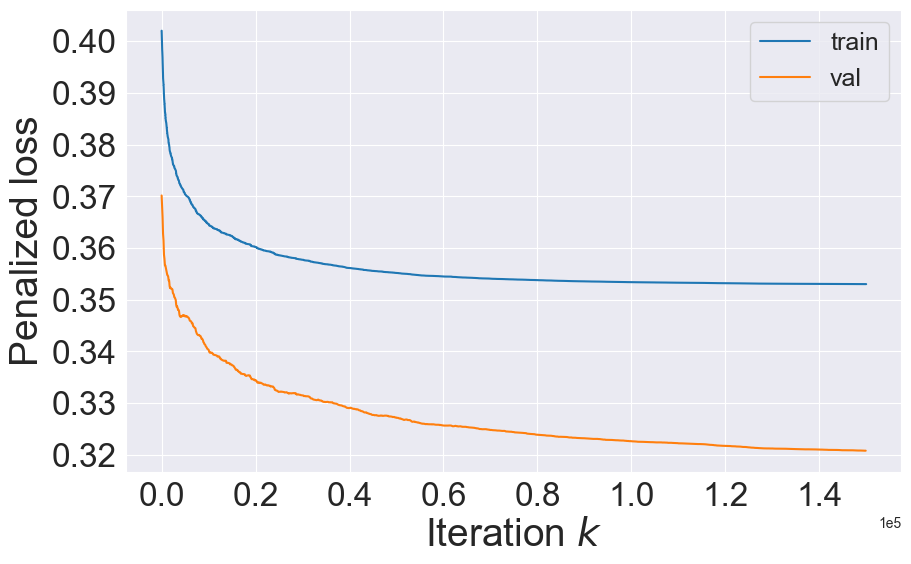

In [26]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_coord)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

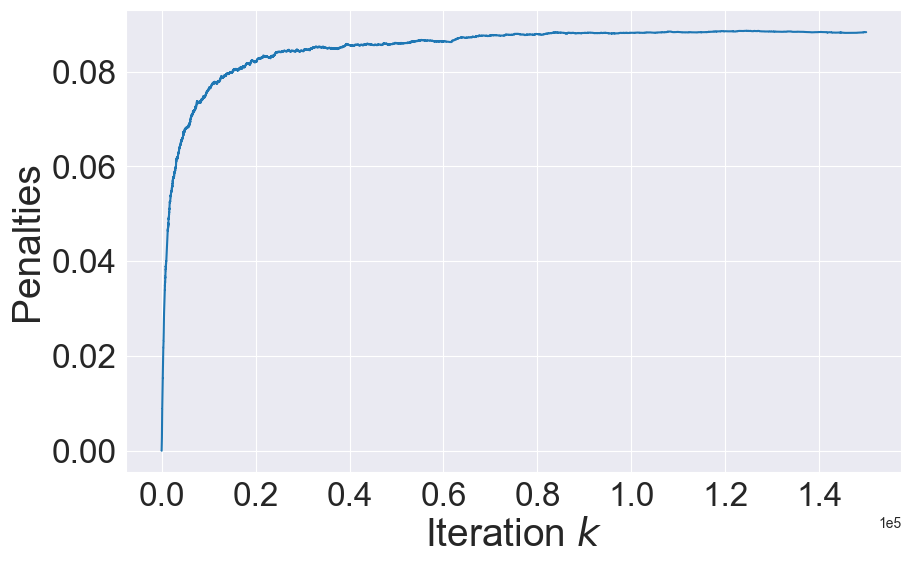

In [27]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_coord - train_losses_coord

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

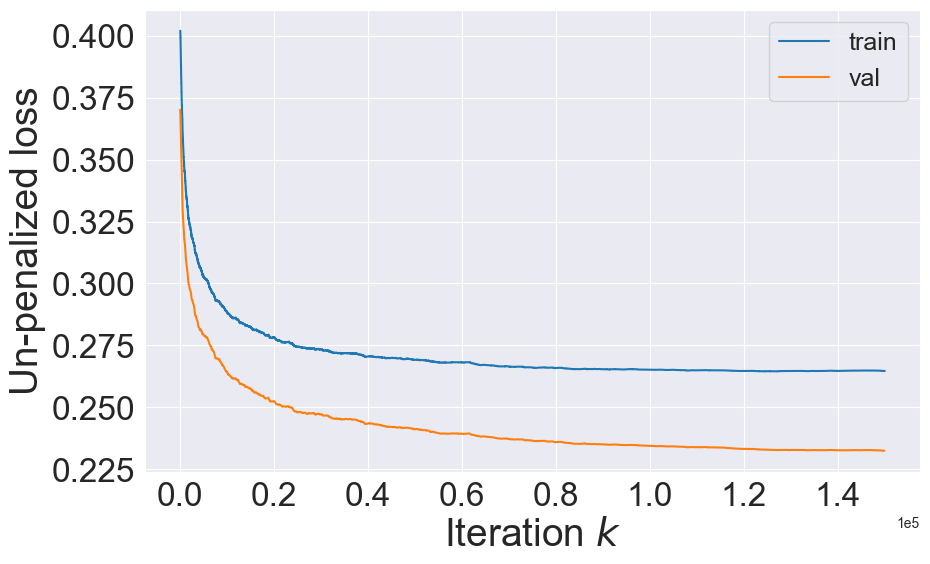

In [28]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_coord)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 3. $L^2(\tau_m)$ proximal algorithm with removal of null particles

Here we do the same as above but remove the particles with weight 0 from the list during the iterations.

In [29]:
n_steps = N_STEPS
m = 500
BETA = 1.0

In [30]:
def update_random_neuron(m, a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        # j = np.random.randint(low=0, high=m)
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [31]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    ms = [m]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    where_decrease_indexes = []

    for k in tqdm(range(N_STEPS)):
        a, b = update_random_neuron(m, a, b, x_train, y_train, eps=1e-9)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]-1:
            where_decrease_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(where_decrease_indexes)

In [32]:
a, b, ms, train_losses_coord, penalized_train_losses_coord, val_losses, penalized_val_losses, \
    where_decrease_indexes =train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|                                                      | 130/150000 [00:00<03:42, 673.74it/s]

m at step 0 : 500
Train loss at step 0 : 0.40176
Validation loss at step 0 : 0.36994
m at step 100 : 456
Train loss at step 100 : 0.39344
Validation loss at step 100 : 0.36204


  0%|                                                      | 260/150000 [00:00<04:12, 591.98it/s]

m at step 200 : 421
Train loss at step 200 : 0.38156
Validation loss at step 200 : 0.35030
m at step 300 : 380
Train loss at step 300 : 0.37152
Validation loss at step 300 : 0.34081


  0%|▏                                                     | 626/150000 [00:00<02:43, 914.28it/s]

m at step 400 : 342
Train loss at step 400 : 0.36277
Validation loss at step 400 : 0.33229
m at step 500 : 301
Train loss at step 500 : 0.35530
Validation loss at step 500 : 0.32513
m at step 600 : 269
Train loss at step 600 : 0.34932
Validation loss at step 600 : 0.31979


  0%|▎                                                     | 721/150000 [00:01<02:59, 830.85it/s]

m at step 700 : 243
Train loss at step 700 : 0.34466
Validation loss at step 700 : 0.31517


  1%|▎                                                     | 881/150000 [00:01<03:56, 630.96it/s]

m at step 800 : 217
Train loss at step 800 : 0.34008
Validation loss at step 800 : 0.31064
m at step 900 : 186
Train loss at step 900 : 0.33400
Validation loss at step 900 : 0.30482


  1%|▍                                                   | 1272/150000 [00:01<02:20, 1059.72it/s]

m at step 1,000 : 166
Train loss at step 1,000 : 0.32999
Validation loss at step 1,000 : 0.30125
m at step 1,100 : 151
Train loss at step 1,100 : 0.32516
Validation loss at step 1,100 : 0.29642
m at step 1,200 : 133
Train loss at step 1,200 : 0.32249
Validation loss at step 1,200 : 0.29349


  1%|▌                                                   | 1653/150000 [00:01<01:39, 1485.18it/s]

m at step 1,300 : 123
Train loss at step 1,300 : 0.31995
Validation loss at step 1,300 : 0.29094
m at step 1,400 : 113
Train loss at step 1,400 : 0.31645
Validation loss at step 1,400 : 0.28800
m at step 1,500 : 106
Train loss at step 1,500 : 0.31461
Validation loss at step 1,500 : 0.28639
m at step 1,600 : 95
Train loss at step 1,600 : 0.31233
Validation loss at step 1,600 : 0.28434
m at step 1,700 : 89
Train loss at step 1,700 : 0.31002
Validation loss at step 1,700 : 0.28215


  1%|▋                                                   | 2131/150000 [00:02<01:15, 1967.28it/s]

m at step 1,800 : 84
Train loss at step 1,800 : 0.30841
Validation loss at step 1,800 : 0.28039
m at step 1,900 : 83
Train loss at step 1,900 : 0.30528
Validation loss at step 1,900 : 0.27741
m at step 2,000 : 80
Train loss at step 2,000 : 0.30307
Validation loss at step 2,000 : 0.27533
m at step 2,100 : 77
Train loss at step 2,100 : 0.30102
Validation loss at step 2,100 : 0.27340
m at step 2,200 : 76
Train loss at step 2,200 : 0.29921
Validation loss at step 2,200 : 0.27159
m at step 2,300 : 72
Train loss at step 2,300 : 0.29801
Validation loss at step 2,300 : 0.27016
m at step 2,400 : 68
Train loss at step 2,400 : 0.29755
Validation loss at step 2,400 : 0.26974


  2%|█                                                   | 3157/150000 [00:02<00:49, 2958.49it/s]

m at step 2,500 : 63
Train loss at step 2,500 : 0.29668
Validation loss at step 2,500 : 0.26857
m at step 2,600 : 62
Train loss at step 2,600 : 0.29498
Validation loss at step 2,600 : 0.26691
m at step 2,700 : 55
Train loss at step 2,700 : 0.29458
Validation loss at step 2,700 : 0.26630
m at step 2,800 : 54
Train loss at step 2,800 : 0.29303
Validation loss at step 2,800 : 0.26491
m at step 2,900 : 51
Train loss at step 2,900 : 0.29241
Validation loss at step 2,900 : 0.26424
m at step 3,000 : 49
Train loss at step 3,000 : 0.29180
Validation loss at step 3,000 : 0.26353
m at step 3,100 : 45
Train loss at step 3,100 : 0.29100
Validation loss at step 3,100 : 0.26256
m at step 3,200 : 41
Train loss at step 3,200 : 0.28970
Validation loss at step 3,200 : 0.26127


  2%|█▎                                                  | 3740/150000 [00:02<00:52, 2766.86it/s]

m at step 3,300 : 40
Train loss at step 3,300 : 0.28876
Validation loss at step 3,300 : 0.26051
m at step 3,400 : 40
Train loss at step 3,400 : 0.28756
Validation loss at step 3,400 : 0.25963
m at step 3,500 : 40
Train loss at step 3,500 : 0.28703
Validation loss at step 3,500 : 0.25911
m at step 3,600 : 38
Train loss at step 3,600 : 0.28639
Validation loss at step 3,600 : 0.25872
m at step 3,700 : 38
Train loss at step 3,700 : 0.28580
Validation loss at step 3,700 : 0.25830
m at step 3,800 : 38
Train loss at step 3,800 : 0.28538
Validation loss at step 3,800 : 0.25817
m at step 3,900 : 38
Train loss at step 3,900 : 0.28519
Validation loss at step 3,900 : 0.25819


  3%|█▌                                                  | 4468/150000 [00:02<00:45, 3216.43it/s]

m at step 4,000 : 37
Train loss at step 4,000 : 0.28533
Validation loss at step 4,000 : 0.25851
m at step 4,100 : 37
Train loss at step 4,100 : 0.28481
Validation loss at step 4,100 : 0.25828
m at step 4,200 : 37
Train loss at step 4,200 : 0.28448
Validation loss at step 4,200 : 0.25820
m at step 4,300 : 34
Train loss at step 4,300 : 0.28424
Validation loss at step 4,300 : 0.25836
m at step 4,400 : 31
Train loss at step 4,400 : 0.28420
Validation loss at step 4,400 : 0.25861
m at step 4,500 : 31
Train loss at step 4,500 : 0.28392
Validation loss at step 4,500 : 0.25859
m at step 4,600 : 30
Train loss at step 4,600 : 0.28341
Validation loss at step 4,600 : 0.25834
m at step 4,700 : 27
Train loss at step 4,700 : 0.28309
Validation loss at step 4,700 : 0.25829
m at step 4,800 : 27
Train loss at step 4,800 : 0.28258
Validation loss at step 4,800 : 0.25818


  4%|█▊                                                  | 5261/150000 [00:02<00:40, 3568.87it/s]

m at step 4,900 : 27
Train loss at step 4,900 : 0.28223
Validation loss at step 4,900 : 0.25818
m at step 5,000 : 27
Train loss at step 5,000 : 0.28222
Validation loss at step 5,000 : 0.25851
m at step 5,100 : 27
Train loss at step 5,100 : 0.28203
Validation loss at step 5,100 : 0.25865
m at step 5,200 : 27
Train loss at step 5,200 : 0.28194
Validation loss at step 5,200 : 0.25881
m at step 5,300 : 26
Train loss at step 5,300 : 0.28175
Validation loss at step 5,300 : 0.25889
m at step 5,400 : 26
Train loss at step 5,400 : 0.28156
Validation loss at step 5,400 : 0.25904
m at step 5,500 : 25
Train loss at step 5,500 : 0.28128
Validation loss at step 5,500 : 0.25905


  4%|██                                                  | 6022/150000 [00:03<00:42, 3396.31it/s]

m at step 5,600 : 25
Train loss at step 5,600 : 0.28125
Validation loss at step 5,600 : 0.25935
m at step 5,700 : 24
Train loss at step 5,700 : 0.28109
Validation loss at step 5,700 : 0.25941
m at step 5,800 : 24
Train loss at step 5,800 : 0.28086
Validation loss at step 5,800 : 0.25949
m at step 5,900 : 24
Train loss at step 5,900 : 0.28086
Validation loss at step 5,900 : 0.25983
m at step 6,000 : 24
Train loss at step 6,000 : 0.28079
Validation loss at step 6,000 : 0.26008
m at step 6,100 : 22
Train loss at step 6,100 : 0.28046
Validation loss at step 6,100 : 0.26005


  5%|██▎                                                 | 6808/150000 [00:03<00:45, 3123.57it/s]

m at step 6,200 : 22
Train loss at step 6,200 : 0.27989
Validation loss at step 6,200 : 0.25985
m at step 6,300 : 22
Train loss at step 6,300 : 0.27986
Validation loss at step 6,300 : 0.26020
m at step 6,400 : 22
Train loss at step 6,400 : 0.27969
Validation loss at step 6,400 : 0.26039
m at step 6,500 : 22
Train loss at step 6,500 : 0.27961
Validation loss at step 6,500 : 0.26054
m at step 6,600 : 22
Train loss at step 6,600 : 0.27932
Validation loss at step 6,600 : 0.26059
m at step 6,700 : 22
Train loss at step 6,700 : 0.27908
Validation loss at step 6,700 : 0.26062
m at step 6,800 : 21
Train loss at step 6,800 : 0.27916
Validation loss at step 6,800 : 0.26100
m at step 6,900 : 20
Train loss at step 6,900 : 0.27910
Validation loss at step 6,900 : 0.26128


  5%|██▌                                                 | 7538/150000 [00:03<00:44, 3230.03it/s]

m at step 7,000 : 20
Train loss at step 7,000 : 0.27893
Validation loss at step 7,000 : 0.26137
m at step 7,100 : 20
Train loss at step 7,100 : 0.27886
Validation loss at step 7,100 : 0.26161
m at step 7,200 : 20
Train loss at step 7,200 : 0.27880
Validation loss at step 7,200 : 0.26182
m at step 7,300 : 19
Train loss at step 7,300 : 0.27873
Validation loss at step 7,300 : 0.26195
m at step 7,400 : 19
Train loss at step 7,400 : 0.27851
Validation loss at step 7,400 : 0.26192
m at step 7,500 : 18
Train loss at step 7,500 : 0.27834
Validation loss at step 7,500 : 0.26197
m at step 7,600 : 18
Train loss at step 7,600 : 0.27834
Validation loss at step 7,600 : 0.26216
m at step 7,700 : 18
Train loss at step 7,700 : 0.27828
Validation loss at step 7,700 : 0.26228
m at step 7,800 : 18
Train loss at step 7,800 : 0.27796
Validation loss at step 7,800 : 0.26217


  6%|██▊                                                 | 8260/150000 [00:03<00:42, 3306.43it/s]

m at step 7,900 : 18
Train loss at step 7,900 : 0.27780
Validation loss at step 7,900 : 0.26223
m at step 8,000 : 18
Train loss at step 8,000 : 0.27789
Validation loss at step 8,000 : 0.26252
m at step 8,100 : 18
Train loss at step 8,100 : 0.27782
Validation loss at step 8,100 : 0.26267
m at step 8,200 : 18
Train loss at step 8,200 : 0.27786
Validation loss at step 8,200 : 0.26283
m at step 8,300 : 18
Train loss at step 8,300 : 0.27784
Validation loss at step 8,300 : 0.26296
m at step 8,400 : 18
Train loss at step 8,400 : 0.27781
Validation loss at step 8,400 : 0.26307
m at step 8,500 : 18
Train loss at step 8,500 : 0.27790
Validation loss at step 8,500 : 0.26330
m at step 8,600 : 18
Train loss at step 8,600 : 0.27785
Validation loss at step 8,600 : 0.26341
m at step 8,700 : 18
Train loss at step 8,700 : 0.27793
Validation loss at step 8,700 : 0.26363


  6%|███▎                                                | 9730/150000 [00:04<00:32, 4352.44it/s]

m at step 8,800 : 18
Train loss at step 8,800 : 0.27783
Validation loss at step 8,800 : 0.26365
m at step 8,900 : 18
Train loss at step 8,900 : 0.27764
Validation loss at step 8,900 : 0.26363
m at step 9,000 : 18
Train loss at step 9,000 : 0.27770
Validation loss at step 9,000 : 0.26379
m at step 9,100 : 18
Train loss at step 9,100 : 0.27760
Validation loss at step 9,100 : 0.26385
m at step 9,200 : 18
Train loss at step 9,200 : 0.27760
Validation loss at step 9,200 : 0.26400
m at step 9,300 : 18
Train loss at step 9,300 : 0.27748
Validation loss at step 9,300 : 0.26400
m at step 9,400 : 17
Train loss at step 9,400 : 0.27750
Validation loss at step 9,400 : 0.26414
m at step 9,500 : 17
Train loss at step 9,500 : 0.27750
Validation loss at step 9,500 : 0.26422
m at step 9,600 : 17
Train loss at step 9,600 : 0.27746
Validation loss at step 9,600 : 0.26425
m at step 9,700 : 17
Train loss at step 9,700 : 0.27743
Validation loss at step 9,700 : 0.26432


  7%|███▌                                               | 10603/150000 [00:04<00:34, 4060.51it/s]

m at step 9,800 : 17
Train loss at step 9,800 : 0.27742
Validation loss at step 9,800 : 0.26439
m at step 9,900 : 17
Train loss at step 9,900 : 0.27741
Validation loss at step 9,900 : 0.26446
m at step 10,000 : 17
Train loss at step 10,000 : 0.27736
Validation loss at step 10,000 : 0.26447
m at step 10,100 : 17
Train loss at step 10,100 : 0.27741
Validation loss at step 10,100 : 0.26457
m at step 10,200 : 17
Train loss at step 10,200 : 0.27735
Validation loss at step 10,200 : 0.26459
m at step 10,300 : 17
Train loss at step 10,300 : 0.27739
Validation loss at step 10,300 : 0.26469
m at step 10,400 : 17
Train loss at step 10,400 : 0.27744
Validation loss at step 10,400 : 0.26479
m at step 10,500 : 17
Train loss at step 10,500 : 0.27733
Validation loss at step 10,500 : 0.26477
m at step 10,600 : 16
Train loss at step 10,600 : 0.27736
Validation loss at step 10,600 : 0.26486


  8%|███▉                                               | 11552/150000 [00:04<00:31, 4413.67it/s]

m at step 10,700 : 16
Train loss at step 10,700 : 0.27737
Validation loss at step 10,700 : 0.26492
m at step 10,800 : 16
Train loss at step 10,800 : 0.27738
Validation loss at step 10,800 : 0.26498
m at step 10,900 : 16
Train loss at step 10,900 : 0.27741
Validation loss at step 10,900 : 0.26506
m at step 11,000 : 16
Train loss at step 11,000 : 0.27733
Validation loss at step 11,000 : 0.26504
m at step 11,100 : 16
Train loss at step 11,100 : 0.27729
Validation loss at step 11,100 : 0.26507
m at step 11,200 : 16
Train loss at step 11,200 : 0.27727
Validation loss at step 11,200 : 0.26509
m at step 11,300 : 16
Train loss at step 11,300 : 0.27726
Validation loss at step 11,300 : 0.26513
m at step 11,400 : 16
Train loss at step 11,400 : 0.27721
Validation loss at step 11,400 : 0.26513
m at step 11,500 : 16
Train loss at step 11,500 : 0.27719
Validation loss at step 11,500 : 0.26516
m at step 11,600 : 16
Train loss at step 11,600 : 0.27721
Validation loss at step 11,600 : 0.26524
m at step 

  8%|████▎                                              | 12517/150000 [00:04<00:29, 4645.90it/s]

m at step 11,800 : 15
Train loss at step 11,800 : 0.27719
Validation loss at step 11,800 : 0.26531
m at step 11,900 : 15
Train loss at step 11,900 : 0.27715
Validation loss at step 11,900 : 0.26532
m at step 12,000 : 15
Train loss at step 12,000 : 0.27714
Validation loss at step 12,000 : 0.26535
m at step 12,100 : 15
Train loss at step 12,100 : 0.27716
Validation loss at step 12,100 : 0.26541
m at step 12,200 : 15
Train loss at step 12,200 : 0.27712
Validation loss at step 12,200 : 0.26541
m at step 12,300 : 15
Train loss at step 12,300 : 0.27708
Validation loss at step 12,300 : 0.26541
m at step 12,400 : 15
Train loss at step 12,400 : 0.27706
Validation loss at step 12,400 : 0.26543
m at step 12,500 : 15
Train loss at step 12,500 : 0.27706
Validation loss at step 12,500 : 0.26547
m at step 12,600 : 15
Train loss at step 12,600 : 0.27710
Validation loss at step 12,600 : 0.26553
m at step 12,700 : 15
Train loss at step 12,700 : 0.27706
Validation loss at step 12,700 : 0.26553
m at step 

  9%|████▌                                              | 13442/150000 [00:05<00:32, 4161.25it/s]

m at step 12,900 : 15
Train loss at step 12,900 : 0.27710
Validation loss at step 12,900 : 0.26563
m at step 13,000 : 15
Train loss at step 13,000 : 0.27711
Validation loss at step 13,000 : 0.26566
m at step 13,100 : 15
Train loss at step 13,100 : 0.27704
Validation loss at step 13,100 : 0.26563
m at step 13,200 : 15
Train loss at step 13,200 : 0.27705
Validation loss at step 13,200 : 0.26566
m at step 13,300 : 15
Train loss at step 13,300 : 0.27704
Validation loss at step 13,300 : 0.26568
m at step 13,400 : 15
Train loss at step 13,400 : 0.27702
Validation loss at step 13,400 : 0.26568
m at step 13,500 : 15
Train loss at step 13,500 : 0.27705
Validation loss at step 13,500 : 0.26575
m at step 13,600 : 15
Train loss at step 13,600 : 0.27705
Validation loss at step 13,600 : 0.26577


  9%|████▋                                              | 13866/150000 [00:05<00:33, 4096.17it/s]

m at step 13,700 : 15
Train loss at step 13,700 : 0.27704
Validation loss at step 13,700 : 0.26580
m at step 13,800 : 15
Train loss at step 13,800 : 0.27701
Validation loss at step 13,800 : 0.26579
m at step 13,900 : 15
Train loss at step 13,900 : 0.27702
Validation loss at step 13,900 : 0.26583
m at step 14,000 : 15
Train loss at step 14,000 : 0.27699
Validation loss at step 14,000 : 0.26583
m at step 14,100 : 15
Train loss at step 14,100 : 0.27700
Validation loss at step 14,100 : 0.26586
m at step 14,200 : 15
Train loss at step 14,200 : 0.27701
Validation loss at step 14,200 : 0.26589


 10%|█████                                              | 14727/150000 [00:05<00:36, 3693.30it/s]

m at step 14,300 : 15
Train loss at step 14,300 : 0.27702
Validation loss at step 14,300 : 0.26593
m at step 14,400 : 15
Train loss at step 14,400 : 0.27700
Validation loss at step 14,400 : 0.26593
m at step 14,500 : 15
Train loss at step 14,500 : 0.27699
Validation loss at step 14,500 : 0.26594
m at step 14,600 : 15
Train loss at step 14,600 : 0.27699
Validation loss at step 14,600 : 0.26595
m at step 14,700 : 15
Train loss at step 14,700 : 0.27698
Validation loss at step 14,700 : 0.26597
m at step 14,800 : 15
Train loss at step 14,800 : 0.27700
Validation loss at step 14,800 : 0.26601
m at step 14,900 : 15
Train loss at step 14,900 : 0.27700
Validation loss at step 14,900 : 0.26602
m at step 15,000 : 15
Train loss at step 15,000 : 0.27701
Validation loss at step 15,000 : 0.26605
m at step 15,100 : 15
Train loss at step 15,100 : 0.27702
Validation loss at step 15,100 : 0.26608


 11%|█████▍                                             | 15961/150000 [00:05<00:34, 3862.69it/s]

m at step 15,200 : 15
Train loss at step 15,200 : 0.27703
Validation loss at step 15,200 : 0.26611
m at step 15,300 : 15
Train loss at step 15,300 : 0.27701
Validation loss at step 15,300 : 0.26611
m at step 15,400 : 15
Train loss at step 15,400 : 0.27701
Validation loss at step 15,400 : 0.26612
m at step 15,500 : 15
Train loss at step 15,500 : 0.27699
Validation loss at step 15,500 : 0.26613
m at step 15,600 : 15
Train loss at step 15,600 : 0.27698
Validation loss at step 15,600 : 0.26613
m at step 15,700 : 15
Train loss at step 15,700 : 0.27699
Validation loss at step 15,700 : 0.26615
m at step 15,800 : 15
Train loss at step 15,800 : 0.27697
Validation loss at step 15,800 : 0.26616
m at step 15,900 : 15
Train loss at step 15,900 : 0.27698
Validation loss at step 15,900 : 0.26618
m at step 16,000 : 15
Train loss at step 16,000 : 0.27699
Validation loss at step 16,000 : 0.26621


 11%|█████▋                                             | 16895/150000 [00:06<00:33, 4023.24it/s]

m at step 16,100 : 15
Train loss at step 16,100 : 0.27700
Validation loss at step 16,100 : 0.26623
m at step 16,200 : 15
Train loss at step 16,200 : 0.27698
Validation loss at step 16,200 : 0.26623
m at step 16,300 : 15
Train loss at step 16,300 : 0.27698
Validation loss at step 16,300 : 0.26624
m at step 16,400 : 15
Train loss at step 16,400 : 0.27698
Validation loss at step 16,400 : 0.26626
m at step 16,500 : 15
Train loss at step 16,500 : 0.27699
Validation loss at step 16,500 : 0.26628
m at step 16,600 : 15
Train loss at step 16,600 : 0.27699
Validation loss at step 16,600 : 0.26629
m at step 16,700 : 15
Train loss at step 16,700 : 0.27699
Validation loss at step 16,700 : 0.26631
m at step 16,800 : 15
Train loss at step 16,800 : 0.27699
Validation loss at step 16,800 : 0.26632
m at step 16,900 : 15
Train loss at step 16,900 : 0.27698
Validation loss at step 16,900 : 0.26632


 12%|██████                                             | 17882/150000 [00:06<00:29, 4499.68it/s]

m at step 17,000 : 15
Train loss at step 17,000 : 0.27699
Validation loss at step 17,000 : 0.26634
m at step 17,100 : 15
Train loss at step 17,100 : 0.27698
Validation loss at step 17,100 : 0.26635
m at step 17,200 : 15
Train loss at step 17,200 : 0.27698
Validation loss at step 17,200 : 0.26636
m at step 17,300 : 15
Train loss at step 17,300 : 0.27698
Validation loss at step 17,300 : 0.26636
m at step 17,400 : 15
Train loss at step 17,400 : 0.27697
Validation loss at step 17,400 : 0.26638
m at step 17,500 : 15
Train loss at step 17,500 : 0.27697
Validation loss at step 17,500 : 0.26638
m at step 17,600 : 15
Train loss at step 17,600 : 0.27697
Validation loss at step 17,600 : 0.26640
m at step 17,700 : 15
Train loss at step 17,700 : 0.27697
Validation loss at step 17,700 : 0.26641
m at step 17,800 : 15
Train loss at step 17,800 : 0.27698
Validation loss at step 17,800 : 0.26642
m at step 17,900 : 15
Train loss at step 17,900 : 0.27698
Validation loss at step 17,900 : 0.26644
m at step 

 13%|██████▍                                            | 18846/150000 [00:06<00:30, 4292.34it/s]

m at step 18,100 : 15
Train loss at step 18,100 : 0.27698
Validation loss at step 18,100 : 0.26645
m at step 18,200 : 15
Train loss at step 18,200 : 0.27698
Validation loss at step 18,200 : 0.26646
m at step 18,300 : 15
Train loss at step 18,300 : 0.27698
Validation loss at step 18,300 : 0.26647
m at step 18,400 : 15
Train loss at step 18,400 : 0.27697
Validation loss at step 18,400 : 0.26647
m at step 18,500 : 15
Train loss at step 18,500 : 0.27697
Validation loss at step 18,500 : 0.26648
m at step 18,600 : 15
Train loss at step 18,600 : 0.27697
Validation loss at step 18,600 : 0.26648
m at step 18,700 : 15
Train loss at step 18,700 : 0.27697
Validation loss at step 18,700 : 0.26649
m at step 18,800 : 15
Train loss at step 18,800 : 0.27697
Validation loss at step 18,800 : 0.26650


 13%|██████▋                                            | 19781/150000 [00:06<00:29, 4411.67it/s]

m at step 18,900 : 15
Train loss at step 18,900 : 0.27697
Validation loss at step 18,900 : 0.26650
m at step 19,000 : 15
Train loss at step 19,000 : 0.27696
Validation loss at step 19,000 : 0.26651
m at step 19,100 : 15
Train loss at step 19,100 : 0.27697
Validation loss at step 19,100 : 0.26652
m at step 19,200 : 15
Train loss at step 19,200 : 0.27696
Validation loss at step 19,200 : 0.26653
m at step 19,300 : 15
Train loss at step 19,300 : 0.27697
Validation loss at step 19,300 : 0.26654
m at step 19,400 : 15
Train loss at step 19,400 : 0.27697
Validation loss at step 19,400 : 0.26655
m at step 19,500 : 15
Train loss at step 19,500 : 0.27697
Validation loss at step 19,500 : 0.26656
m at step 19,600 : 15
Train loss at step 19,600 : 0.27697
Validation loss at step 19,600 : 0.26656
m at step 19,700 : 15
Train loss at step 19,700 : 0.27697
Validation loss at step 19,700 : 0.26656
m at step 19,800 : 15
Train loss at step 19,800 : 0.27697
Validation loss at step 19,800 : 0.26657


 14%|███████                                            | 20800/150000 [00:06<00:27, 4781.43it/s]

m at step 19,900 : 15
Train loss at step 19,900 : 0.27697
Validation loss at step 19,900 : 0.26658
m at step 20,000 : 15
Train loss at step 20,000 : 0.27697
Validation loss at step 20,000 : 0.26658
m at step 20,100 : 15
Train loss at step 20,100 : 0.27697
Validation loss at step 20,100 : 0.26659
m at step 20,200 : 15
Train loss at step 20,200 : 0.27697
Validation loss at step 20,200 : 0.26660
m at step 20,300 : 15
Train loss at step 20,300 : 0.27696
Validation loss at step 20,300 : 0.26660
m at step 20,400 : 15
Train loss at step 20,400 : 0.27696
Validation loss at step 20,400 : 0.26660
m at step 20,500 : 15
Train loss at step 20,500 : 0.27696
Validation loss at step 20,500 : 0.26661
m at step 20,600 : 15
Train loss at step 20,600 : 0.27696
Validation loss at step 20,600 : 0.26661
m at step 20,700 : 15
Train loss at step 20,700 : 0.27695
Validation loss at step 20,700 : 0.26661
m at step 20,800 : 15
Train loss at step 20,800 : 0.27695
Validation loss at step 20,800 : 0.26662
m at step 

 14%|███████▏                                           | 21283/150000 [00:07<00:29, 4317.87it/s]

m at step 21,000 : 15
Train loss at step 21,000 : 0.27695
Validation loss at step 21,000 : 0.26663
m at step 21,100 : 15
Train loss at step 21,100 : 0.27696
Validation loss at step 21,100 : 0.26664
m at step 21,200 : 15
Train loss at step 21,200 : 0.27695
Validation loss at step 21,200 : 0.26664
m at step 21,300 : 15
Train loss at step 21,300 : 0.27696
Validation loss at step 21,300 : 0.26665
m at step 21,400 : 15
Train loss at step 21,400 : 0.27696
Validation loss at step 21,400 : 0.26666
m at step 21,500 : 15
Train loss at step 21,500 : 0.27697
Validation loss at step 21,500 : 0.26667
m at step 21,600 : 15
Train loss at step 21,600 : 0.27697
Validation loss at step 21,600 : 0.26667
m at step 21,700 : 15
Train loss at step 21,700 : 0.27697
Validation loss at step 21,700 : 0.26668


 15%|███████▌                                           | 22148/150000 [00:07<00:33, 3834.54it/s]

m at step 21,800 : 15
Train loss at step 21,800 : 0.27696
Validation loss at step 21,800 : 0.26668
m at step 21,900 : 15
Train loss at step 21,900 : 0.27696
Validation loss at step 21,900 : 0.26668
m at step 22,000 : 15
Train loss at step 22,000 : 0.27696
Validation loss at step 22,000 : 0.26668
m at step 22,100 : 15
Train loss at step 22,100 : 0.27695
Validation loss at step 22,100 : 0.26668
m at step 22,200 : 15
Train loss at step 22,200 : 0.27695
Validation loss at step 22,200 : 0.26668
m at step 22,300 : 15
Train loss at step 22,300 : 0.27695
Validation loss at step 22,300 : 0.26669
m at step 22,400 : 15
Train loss at step 22,400 : 0.27695
Validation loss at step 22,400 : 0.26669


 15%|███████▊                                           | 23003/150000 [00:07<00:33, 3749.59it/s]

m at step 22,500 : 15
Train loss at step 22,500 : 0.27696
Validation loss at step 22,500 : 0.26670
m at step 22,600 : 15
Train loss at step 22,600 : 0.27695
Validation loss at step 22,600 : 0.26670
m at step 22,700 : 15
Train loss at step 22,700 : 0.27695
Validation loss at step 22,700 : 0.26671
m at step 22,800 : 15
Train loss at step 22,800 : 0.27696
Validation loss at step 22,800 : 0.26671
m at step 22,900 : 15
Train loss at step 22,900 : 0.27696
Validation loss at step 22,900 : 0.26671
m at step 23,000 : 15
Train loss at step 23,000 : 0.27696
Validation loss at step 23,000 : 0.26672
m at step 23,100 : 15
Train loss at step 23,100 : 0.27696
Validation loss at step 23,100 : 0.26672
m at step 23,200 : 15
Train loss at step 23,200 : 0.27695
Validation loss at step 23,200 : 0.26672
m at step 23,300 : 15
Train loss at step 23,300 : 0.27695
Validation loss at step 23,300 : 0.26672


 16%|████████▏                                          | 23901/150000 [00:07<00:32, 3885.05it/s]

m at step 23,400 : 15
Train loss at step 23,400 : 0.27695
Validation loss at step 23,400 : 0.26673
m at step 23,500 : 15
Train loss at step 23,500 : 0.27695
Validation loss at step 23,500 : 0.26673
m at step 23,600 : 15
Train loss at step 23,600 : 0.27695
Validation loss at step 23,600 : 0.26673
m at step 23,700 : 15
Train loss at step 23,700 : 0.27695
Validation loss at step 23,700 : 0.26673
m at step 23,800 : 15
Train loss at step 23,800 : 0.27695
Validation loss at step 23,800 : 0.26674
m at step 23,900 : 15
Train loss at step 23,900 : 0.27695
Validation loss at step 23,900 : 0.26674
m at step 24,000 : 15
Train loss at step 24,000 : 0.27695
Validation loss at step 24,000 : 0.26674
m at step 24,100 : 15
Train loss at step 24,100 : 0.27695
Validation loss at step 24,100 : 0.26674
m at step 24,200 : 15
Train loss at step 24,200 : 0.27695
Validation loss at step 24,200 : 0.26675


 16%|████████▍                                          | 24693/150000 [00:07<00:33, 3745.33it/s]

m at step 24,300 : 15
Train loss at step 24,300 : 0.27695
Validation loss at step 24,300 : 0.26675
m at step 24,400 : 15
Train loss at step 24,400 : 0.27695
Validation loss at step 24,400 : 0.26675
m at step 24,500 : 15
Train loss at step 24,500 : 0.27695
Validation loss at step 24,500 : 0.26676
m at step 24,600 : 15
Train loss at step 24,600 : 0.27695
Validation loss at step 24,600 : 0.26676
m at step 24,700 : 15
Train loss at step 24,700 : 0.27695
Validation loss at step 24,700 : 0.26676
m at step 24,800 : 15
Train loss at step 24,800 : 0.27695
Validation loss at step 24,800 : 0.26677
m at step 24,900 : 15
Train loss at step 24,900 : 0.27695
Validation loss at step 24,900 : 0.26677
m at step 25,000 : 15
Train loss at step 25,000 : 0.27695
Validation loss at step 25,000 : 0.26677
m at step 25,100 : 15
Train loss at step 25,100 : 0.27695
Validation loss at step 25,100 : 0.26677


 17%|████████▉                                          | 26192/150000 [00:08<00:27, 4544.33it/s]

m at step 25,200 : 15
Train loss at step 25,200 : 0.27695
Validation loss at step 25,200 : 0.26677
m at step 25,300 : 15
Train loss at step 25,300 : 0.27695
Validation loss at step 25,300 : 0.26677
m at step 25,400 : 15
Train loss at step 25,400 : 0.27695
Validation loss at step 25,400 : 0.26678
m at step 25,500 : 15
Train loss at step 25,500 : 0.27695
Validation loss at step 25,500 : 0.26678
m at step 25,600 : 15
Train loss at step 25,600 : 0.27695
Validation loss at step 25,600 : 0.26678
m at step 25,700 : 15
Train loss at step 25,700 : 0.27695
Validation loss at step 25,700 : 0.26678
m at step 25,800 : 15
Train loss at step 25,800 : 0.27695
Validation loss at step 25,800 : 0.26678
m at step 25,900 : 15
Train loss at step 25,900 : 0.27695
Validation loss at step 25,900 : 0.26679
m at step 26,000 : 15
Train loss at step 26,000 : 0.27695
Validation loss at step 26,000 : 0.26679
m at step 26,100 : 15
Train loss at step 26,100 : 0.27695
Validation loss at step 26,100 : 0.26679
m at step 

 18%|█████████▏                                         | 27090/150000 [00:08<00:29, 4148.28it/s]

m at step 26,300 : 15
Train loss at step 26,300 : 0.27695
Validation loss at step 26,300 : 0.26679
m at step 26,400 : 15
Train loss at step 26,400 : 0.27695
Validation loss at step 26,400 : 0.26679
m at step 26,500 : 15
Train loss at step 26,500 : 0.27695
Validation loss at step 26,500 : 0.26680
m at step 26,600 : 15
Train loss at step 26,600 : 0.27695
Validation loss at step 26,600 : 0.26680
m at step 26,700 : 15
Train loss at step 26,700 : 0.27695
Validation loss at step 26,700 : 0.26680
m at step 26,800 : 15
Train loss at step 26,800 : 0.27695
Validation loss at step 26,800 : 0.26680
m at step 26,900 : 15
Train loss at step 26,900 : 0.27695
Validation loss at step 26,900 : 0.26680
m at step 27,000 : 15
Train loss at step 27,000 : 0.27695
Validation loss at step 27,000 : 0.26681


 19%|█████████▌                                         | 28044/150000 [00:08<00:27, 4475.44it/s]

m at step 27,100 : 15
Train loss at step 27,100 : 0.27695
Validation loss at step 27,100 : 0.26680
m at step 27,200 : 15
Train loss at step 27,200 : 0.27695
Validation loss at step 27,200 : 0.26681
m at step 27,300 : 15
Train loss at step 27,300 : 0.27695
Validation loss at step 27,300 : 0.26681
m at step 27,400 : 15
Train loss at step 27,400 : 0.27695
Validation loss at step 27,400 : 0.26681
m at step 27,500 : 15
Train loss at step 27,500 : 0.27695
Validation loss at step 27,500 : 0.26681
m at step 27,600 : 15
Train loss at step 27,600 : 0.27695
Validation loss at step 27,600 : 0.26681
m at step 27,700 : 15
Train loss at step 27,700 : 0.27695
Validation loss at step 27,700 : 0.26681
m at step 27,800 : 15
Train loss at step 27,800 : 0.27695
Validation loss at step 27,800 : 0.26681
m at step 27,900 : 15
Train loss at step 27,900 : 0.27695
Validation loss at step 27,900 : 0.26682
m at step 28,000 : 15
Train loss at step 28,000 : 0.27695
Validation loss at step 28,000 : 0.26682


 19%|█████████▉                                         | 29094/150000 [00:08<00:24, 4887.39it/s]

m at step 28,100 : 15
Train loss at step 28,100 : 0.27695
Validation loss at step 28,100 : 0.26682
m at step 28,200 : 15
Train loss at step 28,200 : 0.27695
Validation loss at step 28,200 : 0.26682
m at step 28,300 : 15
Train loss at step 28,300 : 0.27695
Validation loss at step 28,300 : 0.26682
m at step 28,400 : 15
Train loss at step 28,400 : 0.27695
Validation loss at step 28,400 : 0.26682
m at step 28,500 : 15
Train loss at step 28,500 : 0.27695
Validation loss at step 28,500 : 0.26682
m at step 28,600 : 15
Train loss at step 28,600 : 0.27695
Validation loss at step 28,600 : 0.26682
m at step 28,700 : 15
Train loss at step 28,700 : 0.27695
Validation loss at step 28,700 : 0.26682
m at step 28,800 : 15
Train loss at step 28,800 : 0.27695
Validation loss at step 28,800 : 0.26683
m at step 28,900 : 15
Train loss at step 28,900 : 0.27695
Validation loss at step 28,900 : 0.26683
m at step 29,000 : 15
Train loss at step 29,000 : 0.27695
Validation loss at step 29,000 : 0.26683
m at step 

 20%|██████████                                         | 29586/150000 [00:09<00:27, 4384.47it/s]

m at step 29,200 : 15
Train loss at step 29,200 : 0.27695
Validation loss at step 29,200 : 0.26683
m at step 29,300 : 15
Train loss at step 29,300 : 0.27695
Validation loss at step 29,300 : 0.26683
m at step 29,400 : 15
Train loss at step 29,400 : 0.27695
Validation loss at step 29,400 : 0.26683
m at step 29,500 : 15
Train loss at step 29,500 : 0.27695
Validation loss at step 29,500 : 0.26683
m at step 29,600 : 15
Train loss at step 29,600 : 0.27695
Validation loss at step 29,600 : 0.26683
m at step 29,700 : 15
Train loss at step 29,700 : 0.27695
Validation loss at step 29,700 : 0.26683
m at step 29,800 : 15
Train loss at step 29,800 : 0.27695
Validation loss at step 29,800 : 0.26683
m at step 29,900 : 15
Train loss at step 29,900 : 0.27695
Validation loss at step 29,900 : 0.26684


 20%|██████████▎                                        | 30463/150000 [00:09<00:33, 3589.17it/s]

m at step 30,000 : 15
Train loss at step 30,000 : 0.27695
Validation loss at step 30,000 : 0.26684
m at step 30,100 : 15
Train loss at step 30,100 : 0.27695
Validation loss at step 30,100 : 0.26684
m at step 30,200 : 15
Train loss at step 30,200 : 0.27695
Validation loss at step 30,200 : 0.26684
m at step 30,300 : 15
Train loss at step 30,300 : 0.27695
Validation loss at step 30,300 : 0.26684
m at step 30,400 : 15
Train loss at step 30,400 : 0.27695
Validation loss at step 30,400 : 0.26684
m at step 30,500 : 15
Train loss at step 30,500 : 0.27695
Validation loss at step 30,500 : 0.26684


 21%|██████████▋                                        | 31272/150000 [00:09<00:31, 3769.34it/s]

m at step 30,600 : 15
Train loss at step 30,600 : 0.27694
Validation loss at step 30,600 : 0.26684
m at step 30,700 : 15
Train loss at step 30,700 : 0.27694
Validation loss at step 30,700 : 0.26684
m at step 30,800 : 15
Train loss at step 30,800 : 0.27694
Validation loss at step 30,800 : 0.26684
m at step 30,900 : 15
Train loss at step 30,900 : 0.27694
Validation loss at step 30,900 : 0.26684
m at step 31,000 : 15
Train loss at step 31,000 : 0.27694
Validation loss at step 31,000 : 0.26684
m at step 31,100 : 15
Train loss at step 31,100 : 0.27694
Validation loss at step 31,100 : 0.26684
m at step 31,200 : 15
Train loss at step 31,200 : 0.27694
Validation loss at step 31,200 : 0.26684
m at step 31,300 : 15
Train loss at step 31,300 : 0.27694
Validation loss at step 31,300 : 0.26685
m at step 31,400 : 15
Train loss at step 31,400 : 0.27694
Validation loss at step 31,400 : 0.26685


 21%|██████████▉                                        | 32114/150000 [00:09<00:31, 3776.85it/s]

m at step 31,500 : 15
Train loss at step 31,500 : 0.27694
Validation loss at step 31,500 : 0.26685
m at step 31,600 : 15
Train loss at step 31,600 : 0.27694
Validation loss at step 31,600 : 0.26685
m at step 31,700 : 15
Train loss at step 31,700 : 0.27694
Validation loss at step 31,700 : 0.26685
m at step 31,800 : 15
Train loss at step 31,800 : 0.27694
Validation loss at step 31,800 : 0.26685
m at step 31,900 : 15
Train loss at step 31,900 : 0.27694
Validation loss at step 31,900 : 0.26685
m at step 32,000 : 15
Train loss at step 32,000 : 0.27694
Validation loss at step 32,000 : 0.26685
m at step 32,100 : 15
Train loss at step 32,100 : 0.27694
Validation loss at step 32,100 : 0.26685
m at step 32,200 : 15
Train loss at step 32,200 : 0.27694
Validation loss at step 32,200 : 0.26685


 22%|███████████▏                                       | 32959/150000 [00:10<00:31, 3771.88it/s]

m at step 32,300 : 15
Train loss at step 32,300 : 0.27694
Validation loss at step 32,300 : 0.26685
m at step 32,400 : 15
Train loss at step 32,400 : 0.27694
Validation loss at step 32,400 : 0.26685
m at step 32,500 : 15
Train loss at step 32,500 : 0.27694
Validation loss at step 32,500 : 0.26685
m at step 32,600 : 15
Train loss at step 32,600 : 0.27694
Validation loss at step 32,600 : 0.26685
m at step 32,700 : 15
Train loss at step 32,700 : 0.27694
Validation loss at step 32,700 : 0.26685
m at step 32,800 : 15
Train loss at step 32,800 : 0.27694
Validation loss at step 32,800 : 0.26685
m at step 32,900 : 15
Train loss at step 32,900 : 0.27694
Validation loss at step 32,900 : 0.26685
m at step 33,000 : 15
Train loss at step 33,000 : 0.27694
Validation loss at step 33,000 : 0.26685
m at step 33,100 : 15
Train loss at step 33,100 : 0.27694
Validation loss at step 33,100 : 0.26685


 23%|███████████▌                                       | 33921/150000 [00:10<00:27, 4285.20it/s]

m at step 33,200 : 15
Train loss at step 33,200 : 0.27694
Validation loss at step 33,200 : 0.26685
m at step 33,300 : 15
Train loss at step 33,300 : 0.27694
Validation loss at step 33,300 : 0.26685
m at step 33,400 : 15
Train loss at step 33,400 : 0.27694
Validation loss at step 33,400 : 0.26686
m at step 33,500 : 15
Train loss at step 33,500 : 0.27694
Validation loss at step 33,500 : 0.26686
m at step 33,600 : 15
Train loss at step 33,600 : 0.27694
Validation loss at step 33,600 : 0.26686
m at step 33,700 : 15
Train loss at step 33,700 : 0.27694
Validation loss at step 33,700 : 0.26686
m at step 33,800 : 15
Train loss at step 33,800 : 0.27694
Validation loss at step 33,800 : 0.26686
m at step 33,900 : 15
Train loss at step 33,900 : 0.27694
Validation loss at step 33,900 : 0.26686
m at step 34,000 : 15
Train loss at step 34,000 : 0.27694
Validation loss at step 34,000 : 0.26686
m at step 34,100 : 15
Train loss at step 34,100 : 0.27694
Validation loss at step 34,100 : 0.26686


 23%|███████████▊                                       | 34842/150000 [00:10<00:26, 4335.06it/s]

m at step 34,200 : 15
Train loss at step 34,200 : 0.27694
Validation loss at step 34,200 : 0.26686
m at step 34,300 : 15
Train loss at step 34,300 : 0.27694
Validation loss at step 34,300 : 0.26686
m at step 34,400 : 15
Train loss at step 34,400 : 0.27694
Validation loss at step 34,400 : 0.26686
m at step 34,500 : 15
Train loss at step 34,500 : 0.27694
Validation loss at step 34,500 : 0.26686
m at step 34,600 : 15
Train loss at step 34,600 : 0.27694
Validation loss at step 34,600 : 0.26686
m at step 34,700 : 15
Train loss at step 34,700 : 0.27694
Validation loss at step 34,700 : 0.26686
m at step 34,800 : 15
Train loss at step 34,800 : 0.27694
Validation loss at step 34,800 : 0.26686
m at step 34,900 : 15
Train loss at step 34,900 : 0.27694
Validation loss at step 34,900 : 0.26686
m at step 35,000 : 15
Train loss at step 35,000 : 0.27694
Validation loss at step 35,000 : 0.26686


 24%|████████████▏                                      | 35808/150000 [00:10<00:26, 4314.81it/s]

m at step 35,100 : 15
Train loss at step 35,100 : 0.27694
Validation loss at step 35,100 : 0.26686
m at step 35,200 : 15
Train loss at step 35,200 : 0.27694
Validation loss at step 35,200 : 0.26686
m at step 35,300 : 15
Train loss at step 35,300 : 0.27694
Validation loss at step 35,300 : 0.26686
m at step 35,400 : 15
Train loss at step 35,400 : 0.27694
Validation loss at step 35,400 : 0.26686
m at step 35,500 : 15
Train loss at step 35,500 : 0.27694
Validation loss at step 35,500 : 0.26686
m at step 35,600 : 15
Train loss at step 35,600 : 0.27694
Validation loss at step 35,600 : 0.26686
m at step 35,700 : 15
Train loss at step 35,700 : 0.27694
Validation loss at step 35,700 : 0.26686
m at step 35,800 : 15
Train loss at step 35,800 : 0.27694
Validation loss at step 35,800 : 0.26686
m at step 35,900 : 15
Train loss at step 35,900 : 0.27694
Validation loss at step 35,900 : 0.26686
m at step 36,000 : 15
Train loss at step 36,000 : 0.27694
Validation loss at step 36,000 : 0.26686


 25%|████████████▌                                      | 36790/150000 [00:10<00:24, 4605.93it/s]

m at step 36,100 : 15
Train loss at step 36,100 : 0.27694
Validation loss at step 36,100 : 0.26686
m at step 36,200 : 15
Train loss at step 36,200 : 0.27694
Validation loss at step 36,200 : 0.26686
m at step 36,300 : 15
Train loss at step 36,300 : 0.27694
Validation loss at step 36,300 : 0.26686
m at step 36,400 : 15
Train loss at step 36,400 : 0.27694
Validation loss at step 36,400 : 0.26686
m at step 36,500 : 15
Train loss at step 36,500 : 0.27694
Validation loss at step 36,500 : 0.26686
m at step 36,600 : 15
Train loss at step 36,600 : 0.27694
Validation loss at step 36,600 : 0.26686
m at step 36,700 : 15
Train loss at step 36,700 : 0.27694
Validation loss at step 36,700 : 0.26687
m at step 36,800 : 15
Train loss at step 36,800 : 0.27694
Validation loss at step 36,800 : 0.26687
m at step 36,900 : 15
Train loss at step 36,900 : 0.27694
Validation loss at step 36,900 : 0.26687
m at step 37,000 : 15
Train loss at step 37,000 : 0.27694
Validation loss at step 37,000 : 0.26687
m at step 

 25%|████████████▊                                      | 37725/150000 [00:11<00:27, 4094.41it/s]

m at step 37,200 : 15
Train loss at step 37,200 : 0.27694
Validation loss at step 37,200 : 0.26687
m at step 37,300 : 15
Train loss at step 37,300 : 0.27694
Validation loss at step 37,300 : 0.26687
m at step 37,400 : 15
Train loss at step 37,400 : 0.27694
Validation loss at step 37,400 : 0.26687
m at step 37,500 : 15
Train loss at step 37,500 : 0.27694
Validation loss at step 37,500 : 0.26687
m at step 37,600 : 15
Train loss at step 37,600 : 0.27694
Validation loss at step 37,600 : 0.26687
m at step 37,700 : 15
Train loss at step 37,700 : 0.27694
Validation loss at step 37,700 : 0.26687
m at step 37,800 : 15
Train loss at step 37,800 : 0.27694
Validation loss at step 37,800 : 0.26687


 25%|████████████▉                                      | 38148/150000 [00:11<00:27, 4128.04it/s]

m at step 37,900 : 15
Train loss at step 37,900 : 0.27694
Validation loss at step 37,900 : 0.26687
m at step 38,000 : 15
Train loss at step 38,000 : 0.27694
Validation loss at step 38,000 : 0.26687
m at step 38,100 : 15
Train loss at step 38,100 : 0.27694
Validation loss at step 38,100 : 0.26687
m at step 38,200 : 15
Train loss at step 38,200 : 0.27694
Validation loss at step 38,200 : 0.26687
m at step 38,300 : 15
Train loss at step 38,300 : 0.27694
Validation loss at step 38,300 : 0.26687
m at step 38,400 : 15
Train loss at step 38,400 : 0.27694
Validation loss at step 38,400 : 0.26687
m at step 38,500 : 15
Train loss at step 38,500 : 0.27694
Validation loss at step 38,500 : 0.26687


 26%|█████████████▍                                     | 39445/150000 [00:11<00:28, 3851.08it/s]

m at step 38,600 : 15
Train loss at step 38,600 : 0.27694
Validation loss at step 38,600 : 0.26687
m at step 38,700 : 15
Train loss at step 38,700 : 0.27694
Validation loss at step 38,700 : 0.26687
m at step 38,800 : 15
Train loss at step 38,800 : 0.27694
Validation loss at step 38,800 : 0.26687
m at step 38,900 : 15
Train loss at step 38,900 : 0.27694
Validation loss at step 38,900 : 0.26687
m at step 39,000 : 15
Train loss at step 39,000 : 0.27694
Validation loss at step 39,000 : 0.26687
m at step 39,100 : 15
Train loss at step 39,100 : 0.27694
Validation loss at step 39,100 : 0.26687
m at step 39,200 : 15
Train loss at step 39,200 : 0.27694
Validation loss at step 39,200 : 0.26687
m at step 39,300 : 15
Train loss at step 39,300 : 0.27694
Validation loss at step 39,300 : 0.26687
m at step 39,400 : 15
Train loss at step 39,400 : 0.27694
Validation loss at step 39,400 : 0.26687


 27%|█████████████▋                                     | 40338/150000 [00:11<00:27, 3994.76it/s]

m at step 39,500 : 15
Train loss at step 39,500 : 0.27694
Validation loss at step 39,500 : 0.26687
m at step 39,600 : 15
Train loss at step 39,600 : 0.27694
Validation loss at step 39,600 : 0.26687
m at step 39,700 : 15
Train loss at step 39,700 : 0.27694
Validation loss at step 39,700 : 0.26687
m at step 39,800 : 15
Train loss at step 39,800 : 0.27694
Validation loss at step 39,800 : 0.26687
m at step 39,900 : 15
Train loss at step 39,900 : 0.27694
Validation loss at step 39,900 : 0.26687
m at step 40,000 : 15
Train loss at step 40,000 : 0.27694
Validation loss at step 40,000 : 0.26687
m at step 40,100 : 15
Train loss at step 40,100 : 0.27694
Validation loss at step 40,100 : 0.26687
m at step 40,200 : 15
Train loss at step 40,200 : 0.27694
Validation loss at step 40,200 : 0.26687
m at step 40,300 : 15
Train loss at step 40,300 : 0.27694
Validation loss at step 40,300 : 0.26687


 27%|██████████████                                     | 41236/150000 [00:12<00:26, 4030.04it/s]

m at step 40,400 : 15
Train loss at step 40,400 : 0.27694
Validation loss at step 40,400 : 0.26687
m at step 40,500 : 15
Train loss at step 40,500 : 0.27694
Validation loss at step 40,500 : 0.26687
m at step 40,600 : 15
Train loss at step 40,600 : 0.27694
Validation loss at step 40,600 : 0.26687
m at step 40,700 : 15
Train loss at step 40,700 : 0.27694
Validation loss at step 40,700 : 0.26687
m at step 40,800 : 15
Train loss at step 40,800 : 0.27694
Validation loss at step 40,800 : 0.26687
m at step 40,900 : 15
Train loss at step 40,900 : 0.27694
Validation loss at step 40,900 : 0.26687
m at step 41,000 : 15
Train loss at step 41,000 : 0.27694
Validation loss at step 41,000 : 0.26687
m at step 41,100 : 15
Train loss at step 41,100 : 0.27694
Validation loss at step 41,100 : 0.26687
m at step 41,200 : 15
Train loss at step 41,200 : 0.27694
Validation loss at step 41,200 : 0.26687


 28%|██████████████▎                                    | 42251/150000 [00:12<00:23, 4574.56it/s]

m at step 41,300 : 15
Train loss at step 41,300 : 0.27694
Validation loss at step 41,300 : 0.26687
m at step 41,400 : 15
Train loss at step 41,400 : 0.27694
Validation loss at step 41,400 : 0.26687
m at step 41,500 : 15
Train loss at step 41,500 : 0.27694
Validation loss at step 41,500 : 0.26687
m at step 41,600 : 15
Train loss at step 41,600 : 0.27694
Validation loss at step 41,600 : 0.26687
m at step 41,700 : 15
Train loss at step 41,700 : 0.27694
Validation loss at step 41,700 : 0.26687
m at step 41,800 : 15
Train loss at step 41,800 : 0.27694
Validation loss at step 41,800 : 0.26687
m at step 41,900 : 15
Train loss at step 41,900 : 0.27694
Validation loss at step 41,900 : 0.26687
m at step 42,000 : 15
Train loss at step 42,000 : 0.27694
Validation loss at step 42,000 : 0.26687
m at step 42,100 : 15
Train loss at step 42,100 : 0.27694
Validation loss at step 42,100 : 0.26687
m at step 42,200 : 15
Train loss at step 42,200 : 0.27694
Validation loss at step 42,200 : 0.26687
m at step 

 29%|██████████████▋                                    | 43195/150000 [00:12<00:24, 4361.54it/s]

m at step 42,400 : 15
Train loss at step 42,400 : 0.27694
Validation loss at step 42,400 : 0.26687
m at step 42,500 : 15
Train loss at step 42,500 : 0.27694
Validation loss at step 42,500 : 0.26687
m at step 42,600 : 15
Train loss at step 42,600 : 0.27694
Validation loss at step 42,600 : 0.26687
m at step 42,700 : 15
Train loss at step 42,700 : 0.27694
Validation loss at step 42,700 : 0.26687
m at step 42,800 : 15
Train loss at step 42,800 : 0.27694
Validation loss at step 42,800 : 0.26687
m at step 42,900 : 15
Train loss at step 42,900 : 0.27694
Validation loss at step 42,900 : 0.26687
m at step 43,000 : 15
Train loss at step 43,000 : 0.27694
Validation loss at step 43,000 : 0.26687
m at step 43,100 : 15
Train loss at step 43,100 : 0.27694
Validation loss at step 43,100 : 0.26687
m at step 43,200 : 15
Train loss at step 43,200 : 0.27694
Validation loss at step 43,200 : 0.26687


 29%|███████████████                                    | 44159/150000 [00:12<00:24, 4391.61it/s]

m at step 43,300 : 15
Train loss at step 43,300 : 0.27694
Validation loss at step 43,300 : 0.26687
m at step 43,400 : 15
Train loss at step 43,400 : 0.27694
Validation loss at step 43,400 : 0.26687
m at step 43,500 : 15
Train loss at step 43,500 : 0.27694
Validation loss at step 43,500 : 0.26687
m at step 43,600 : 15
Train loss at step 43,600 : 0.27694
Validation loss at step 43,600 : 0.26687
m at step 43,700 : 15
Train loss at step 43,700 : 0.27694
Validation loss at step 43,700 : 0.26687
m at step 43,800 : 15
Train loss at step 43,800 : 0.27694
Validation loss at step 43,800 : 0.26687
m at step 43,900 : 15
Train loss at step 43,900 : 0.27694
Validation loss at step 43,900 : 0.26687
m at step 44,000 : 15
Train loss at step 44,000 : 0.27694
Validation loss at step 44,000 : 0.26687
m at step 44,100 : 15
Train loss at step 44,100 : 0.27694
Validation loss at step 44,100 : 0.26687
m at step 44,200 : 15
Train loss at step 44,200 : 0.27694
Validation loss at step 44,200 : 0.26687


 30%|███████████████▎                                   | 45126/150000 [00:12<00:22, 4596.23it/s]

m at step 44,300 : 15
Train loss at step 44,300 : 0.27694
Validation loss at step 44,300 : 0.26687
m at step 44,400 : 15
Train loss at step 44,400 : 0.27694
Validation loss at step 44,400 : 0.26687
m at step 44,500 : 15
Train loss at step 44,500 : 0.27694
Validation loss at step 44,500 : 0.26687
m at step 44,600 : 15
Train loss at step 44,600 : 0.27694
Validation loss at step 44,600 : 0.26687
m at step 44,700 : 15
Train loss at step 44,700 : 0.27694
Validation loss at step 44,700 : 0.26687
m at step 44,800 : 15
Train loss at step 44,800 : 0.27694
Validation loss at step 44,800 : 0.26687
m at step 44,900 : 15
Train loss at step 44,900 : 0.27694
Validation loss at step 44,900 : 0.26687
m at step 45,000 : 15
Train loss at step 45,000 : 0.27694
Validation loss at step 45,000 : 0.26687
m at step 45,100 : 15
Train loss at step 45,100 : 0.27694
Validation loss at step 45,100 : 0.26687
m at step 45,200 : 15
Train loss at step 45,200 : 0.27694
Validation loss at step 45,200 : 0.26687
m at step 

 31%|███████████████▋                                   | 46040/150000 [00:13<00:24, 4182.07it/s]

m at step 45,400 : 15
Train loss at step 45,400 : 0.27694
Validation loss at step 45,400 : 0.26687
m at step 45,500 : 15
Train loss at step 45,500 : 0.27694
Validation loss at step 45,500 : 0.26687
m at step 45,600 : 15
Train loss at step 45,600 : 0.27694
Validation loss at step 45,600 : 0.26687
m at step 45,700 : 15
Train loss at step 45,700 : 0.27694
Validation loss at step 45,700 : 0.26687
m at step 45,800 : 15
Train loss at step 45,800 : 0.27694
Validation loss at step 45,800 : 0.26687
m at step 45,900 : 15
Train loss at step 45,900 : 0.27694
Validation loss at step 45,900 : 0.26687
m at step 46,000 : 15
Train loss at step 46,000 : 0.27694
Validation loss at step 46,000 : 0.26687
m at step 46,100 : 15
Train loss at step 46,100 : 0.27694
Validation loss at step 46,100 : 0.26687


 31%|███████████████▊                                   | 46464/150000 [00:13<00:25, 4126.36it/s]

m at step 46,200 : 15
Train loss at step 46,200 : 0.27694
Validation loss at step 46,200 : 0.26687
m at step 46,300 : 15
Train loss at step 46,300 : 0.27694
Validation loss at step 46,300 : 0.26687
m at step 46,400 : 15
Train loss at step 46,400 : 0.27694
Validation loss at step 46,400 : 0.26687
m at step 46,500 : 15
Train loss at step 46,500 : 0.27694
Validation loss at step 46,500 : 0.26687
m at step 46,600 : 15
Train loss at step 46,600 : 0.27694
Validation loss at step 46,600 : 0.26687
m at step 46,700 : 15
Train loss at step 46,700 : 0.27694
Validation loss at step 46,700 : 0.26687


 32%|████████████████                                   | 47356/150000 [00:13<00:27, 3729.24it/s]

m at step 46,800 : 15
Train loss at step 46,800 : 0.27694
Validation loss at step 46,800 : 0.26687
m at step 46,900 : 15
Train loss at step 46,900 : 0.27694
Validation loss at step 46,900 : 0.26687
m at step 47,000 : 15
Train loss at step 47,000 : 0.27694
Validation loss at step 47,000 : 0.26687
m at step 47,100 : 15
Train loss at step 47,100 : 0.27694
Validation loss at step 47,100 : 0.26687
m at step 47,200 : 15
Train loss at step 47,200 : 0.27694
Validation loss at step 47,200 : 0.26687
m at step 47,300 : 15
Train loss at step 47,300 : 0.27694
Validation loss at step 47,300 : 0.26687
m at step 47,400 : 15
Train loss at step 47,400 : 0.27694
Validation loss at step 47,400 : 0.26687
m at step 47,500 : 15
Train loss at step 47,500 : 0.27694
Validation loss at step 47,500 : 0.26687


 32%|████████████████▍                                  | 48206/150000 [00:13<00:27, 3764.62it/s]

m at step 47,600 : 15
Train loss at step 47,600 : 0.27694
Validation loss at step 47,600 : 0.26687
m at step 47,700 : 15
Train loss at step 47,700 : 0.27694
Validation loss at step 47,700 : 0.26687
m at step 47,800 : 15
Train loss at step 47,800 : 0.27694
Validation loss at step 47,800 : 0.26687
m at step 47,900 : 15
Train loss at step 47,900 : 0.27694
Validation loss at step 47,900 : 0.26687
m at step 48,000 : 15
Train loss at step 48,000 : 0.27694
Validation loss at step 48,000 : 0.26687
m at step 48,100 : 15
Train loss at step 48,100 : 0.27694
Validation loss at step 48,100 : 0.26687
m at step 48,200 : 15
Train loss at step 48,200 : 0.27694
Validation loss at step 48,200 : 0.26687
m at step 48,300 : 15
Train loss at step 48,300 : 0.27694
Validation loss at step 48,300 : 0.26687
m at step 48,400 : 15
Train loss at step 48,400 : 0.27694
Validation loss at step 48,400 : 0.26687


 33%|████████████████▋                                  | 48991/150000 [00:13<00:27, 3720.59it/s]

m at step 48,500 : 15
Train loss at step 48,500 : 0.27694
Validation loss at step 48,500 : 0.26687
m at step 48,600 : 15
Train loss at step 48,600 : 0.27694
Validation loss at step 48,600 : 0.26687
m at step 48,700 : 15
Train loss at step 48,700 : 0.27694
Validation loss at step 48,700 : 0.26687
m at step 48,800 : 15
Train loss at step 48,800 : 0.27694
Validation loss at step 48,800 : 0.26687
m at step 48,900 : 15
Train loss at step 48,900 : 0.27694
Validation loss at step 48,900 : 0.26687
m at step 49,000 : 15
Train loss at step 49,000 : 0.27694
Validation loss at step 49,000 : 0.26687
m at step 49,100 : 15
Train loss at step 49,100 : 0.27694
Validation loss at step 49,100 : 0.26687
m at step 49,200 : 15
Train loss at step 49,200 : 0.27694
Validation loss at step 49,200 : 0.26687
m at step 49,300 : 15
Train loss at step 49,300 : 0.27694
Validation loss at step 49,300 : 0.26687


 33%|████████████████▉                                  | 49979/150000 [00:14<00:23, 4320.41it/s]

m at step 49,400 : 15
Train loss at step 49,400 : 0.27694
Validation loss at step 49,400 : 0.26687
m at step 49,500 : 15
Train loss at step 49,500 : 0.27694
Validation loss at step 49,500 : 0.26687
m at step 49,600 : 15
Train loss at step 49,600 : 0.27694
Validation loss at step 49,600 : 0.26687
m at step 49,700 : 15
Train loss at step 49,700 : 0.27694
Validation loss at step 49,700 : 0.26687
m at step 49,800 : 15
Train loss at step 49,800 : 0.27694
Validation loss at step 49,800 : 0.26687
m at step 49,900 : 15
Train loss at step 49,900 : 0.27694
Validation loss at step 49,900 : 0.26687
m at step 50,000 : 15
Train loss at step 50,000 : 0.27694
Validation loss at step 50,000 : 0.26687
m at step 50,100 : 15
Train loss at step 50,100 : 0.27694
Validation loss at step 50,100 : 0.26687
m at step 50,200 : 15
Train loss at step 50,200 : 0.27694
Validation loss at step 50,200 : 0.26687
m at step 50,300 : 15
Train loss at step 50,300 : 0.27694
Validation loss at step 50,300 : 0.26687
m at step 

 34%|█████████████████▎                                 | 51065/150000 [00:14<00:20, 4880.48it/s]

m at step 50,500 : 15
Train loss at step 50,500 : 0.27694
Validation loss at step 50,500 : 0.26687
m at step 50,600 : 15
Train loss at step 50,600 : 0.27694
Validation loss at step 50,600 : 0.26687
m at step 50,700 : 15
Train loss at step 50,700 : 0.27694
Validation loss at step 50,700 : 0.26687
m at step 50,800 : 15
Train loss at step 50,800 : 0.27694
Validation loss at step 50,800 : 0.26687
m at step 50,900 : 15
Train loss at step 50,900 : 0.27694
Validation loss at step 50,900 : 0.26687
m at step 51,000 : 15
Train loss at step 51,000 : 0.27694
Validation loss at step 51,000 : 0.26687
m at step 51,100 : 15
Train loss at step 51,100 : 0.27694
Validation loss at step 51,100 : 0.26687
m at step 51,200 : 15
Train loss at step 51,200 : 0.27694
Validation loss at step 51,200 : 0.26687
m at step 51,300 : 15
Train loss at step 51,300 : 0.27694
Validation loss at step 51,300 : 0.26687
m at step 51,400 : 15
Train loss at step 51,400 : 0.27694
Validation loss at step 51,400 : 0.26687


 35%|█████████████████▋                                 | 52054/150000 [00:14<00:22, 4442.18it/s]

m at step 51,500 : 15
Train loss at step 51,500 : 0.27694
Validation loss at step 51,500 : 0.26687
m at step 51,600 : 15
Train loss at step 51,600 : 0.27694
Validation loss at step 51,600 : 0.26687
m at step 51,700 : 15
Train loss at step 51,700 : 0.27694
Validation loss at step 51,700 : 0.26687
m at step 51,800 : 15
Train loss at step 51,800 : 0.27694
Validation loss at step 51,800 : 0.26687
m at step 51,900 : 15
Train loss at step 51,900 : 0.27694
Validation loss at step 51,900 : 0.26687
m at step 52,000 : 15
Train loss at step 52,000 : 0.27694
Validation loss at step 52,000 : 0.26687
m at step 52,100 : 15
Train loss at step 52,100 : 0.27694
Validation loss at step 52,100 : 0.26687
m at step 52,200 : 15
Train loss at step 52,200 : 0.27694
Validation loss at step 52,200 : 0.26687
m at step 52,300 : 15
Train loss at step 52,300 : 0.27694
Validation loss at step 52,300 : 0.26687
m at step 52,400 : 15
Train loss at step 52,400 : 0.27694
Validation loss at step 52,400 : 0.26687


 35%|██████████████████                                 | 53037/150000 [00:14<00:20, 4646.84it/s]

m at step 52,500 : 15
Train loss at step 52,500 : 0.27694
Validation loss at step 52,500 : 0.26687
m at step 52,600 : 15
Train loss at step 52,600 : 0.27694
Validation loss at step 52,600 : 0.26687
m at step 52,700 : 15
Train loss at step 52,700 : 0.27694
Validation loss at step 52,700 : 0.26687
m at step 52,800 : 15
Train loss at step 52,800 : 0.27694
Validation loss at step 52,800 : 0.26687
m at step 52,900 : 15
Train loss at step 52,900 : 0.27694
Validation loss at step 52,900 : 0.26687
m at step 53,000 : 15
Train loss at step 53,000 : 0.27694
Validation loss at step 53,000 : 0.26687
m at step 53,100 : 15
Train loss at step 53,100 : 0.27694
Validation loss at step 53,100 : 0.26687
m at step 53,200 : 15
Train loss at step 53,200 : 0.27694
Validation loss at step 53,200 : 0.26687
m at step 53,300 : 15
Train loss at step 53,300 : 0.27694
Validation loss at step 53,300 : 0.26687
m at step 53,400 : 15
Train loss at step 53,400 : 0.27694
Validation loss at step 53,400 : 0.26687
m at step 

 36%|██████████████████▍                                | 54071/150000 [00:15<00:21, 4531.39it/s]

m at step 53,600 : 15
Train loss at step 53,600 : 0.27694
Validation loss at step 53,600 : 0.26687
m at step 53,700 : 15
Train loss at step 53,700 : 0.27694
Validation loss at step 53,700 : 0.26687
m at step 53,800 : 15
Train loss at step 53,800 : 0.27694
Validation loss at step 53,800 : 0.26687
m at step 53,900 : 15
Train loss at step 53,900 : 0.27694
Validation loss at step 53,900 : 0.26687
m at step 54,000 : 15
Train loss at step 54,000 : 0.27694
Validation loss at step 54,000 : 0.26687
m at step 54,100 : 15
Train loss at step 54,100 : 0.27694
Validation loss at step 54,100 : 0.26687
m at step 54,200 : 15
Train loss at step 54,200 : 0.27694
Validation loss at step 54,200 : 0.26687
m at step 54,300 : 15
Train loss at step 54,300 : 0.27694
Validation loss at step 54,300 : 0.26687


 37%|██████████████████▋                                | 54967/150000 [00:15<00:23, 3985.30it/s]

m at step 54,400 : 15
Train loss at step 54,400 : 0.27694
Validation loss at step 54,400 : 0.26687
m at step 54,500 : 15
Train loss at step 54,500 : 0.27694
Validation loss at step 54,500 : 0.26687
m at step 54,600 : 15
Train loss at step 54,600 : 0.27694
Validation loss at step 54,600 : 0.26687
m at step 54,700 : 15
Train loss at step 54,700 : 0.27694
Validation loss at step 54,700 : 0.26687
m at step 54,800 : 15
Train loss at step 54,800 : 0.27694
Validation loss at step 54,800 : 0.26687
m at step 54,900 : 15
Train loss at step 54,900 : 0.27694
Validation loss at step 54,900 : 0.26687
m at step 55,000 : 15
Train loss at step 55,000 : 0.27694
Validation loss at step 55,000 : 0.26687


 37%|██████████████████▉                                | 55796/150000 [00:15<00:25, 3714.91it/s]

m at step 55,100 : 15
Train loss at step 55,100 : 0.27694
Validation loss at step 55,100 : 0.26687
m at step 55,200 : 15
Train loss at step 55,200 : 0.27694
Validation loss at step 55,200 : 0.26687
m at step 55,300 : 15
Train loss at step 55,300 : 0.27694
Validation loss at step 55,300 : 0.26687
m at step 55,400 : 15
Train loss at step 55,400 : 0.27694
Validation loss at step 55,400 : 0.26687
m at step 55,500 : 15
Train loss at step 55,500 : 0.27694
Validation loss at step 55,500 : 0.26687
m at step 55,600 : 15
Train loss at step 55,600 : 0.27694
Validation loss at step 55,600 : 0.26687
m at step 55,700 : 15
Train loss at step 55,700 : 0.27694
Validation loss at step 55,700 : 0.26687
m at step 55,800 : 15
Train loss at step 55,800 : 0.27694
Validation loss at step 55,800 : 0.26687


 38%|███████████████████▎                               | 56670/150000 [00:15<00:24, 3818.23it/s]

m at step 55,900 : 15
Train loss at step 55,900 : 0.27694
Validation loss at step 55,900 : 0.26687
m at step 56,000 : 15
Train loss at step 56,000 : 0.27694
Validation loss at step 56,000 : 0.26687
m at step 56,100 : 15
Train loss at step 56,100 : 0.27694
Validation loss at step 56,100 : 0.26687
m at step 56,200 : 15
Train loss at step 56,200 : 0.27694
Validation loss at step 56,200 : 0.26687
m at step 56,300 : 15
Train loss at step 56,300 : 0.27694
Validation loss at step 56,300 : 0.26687
m at step 56,400 : 15
Train loss at step 56,400 : 0.27694
Validation loss at step 56,400 : 0.26687
m at step 56,500 : 15
Train loss at step 56,500 : 0.27694
Validation loss at step 56,500 : 0.26687
m at step 56,600 : 15
Train loss at step 56,600 : 0.27694
Validation loss at step 56,600 : 0.26687
m at step 56,700 : 15
Train loss at step 56,700 : 0.27694
Validation loss at step 56,700 : 0.26687


 38%|███████████████████▌                               | 57485/150000 [00:15<00:24, 3765.79it/s]

m at step 56,800 : 15
Train loss at step 56,800 : 0.27694
Validation loss at step 56,800 : 0.26687
m at step 56,900 : 15
Train loss at step 56,900 : 0.27694
Validation loss at step 56,900 : 0.26687
m at step 57,000 : 15
Train loss at step 57,000 : 0.27694
Validation loss at step 57,000 : 0.26687
m at step 57,100 : 15
Train loss at step 57,100 : 0.27694
Validation loss at step 57,100 : 0.26687
m at step 57,200 : 15
Train loss at step 57,200 : 0.27694
Validation loss at step 57,200 : 0.26687
m at step 57,300 : 15
Train loss at step 57,300 : 0.27694
Validation loss at step 57,300 : 0.26687
m at step 57,400 : 15
Train loss at step 57,400 : 0.27694
Validation loss at step 57,400 : 0.26687
m at step 57,500 : 15
Train loss at step 57,500 : 0.27694
Validation loss at step 57,500 : 0.26687


 39%|███████████████████▉                               | 58506/150000 [00:16<00:20, 4440.93it/s]

m at step 57,600 : 15
Train loss at step 57,600 : 0.27694
Validation loss at step 57,600 : 0.26687
m at step 57,700 : 15
Train loss at step 57,700 : 0.27694
Validation loss at step 57,700 : 0.26687
m at step 57,800 : 15
Train loss at step 57,800 : 0.27694
Validation loss at step 57,800 : 0.26687
m at step 57,900 : 15
Train loss at step 57,900 : 0.27694
Validation loss at step 57,900 : 0.26687
m at step 58,000 : 15
Train loss at step 58,000 : 0.27694
Validation loss at step 58,000 : 0.26687
m at step 58,100 : 15
Train loss at step 58,100 : 0.27694
Validation loss at step 58,100 : 0.26687
m at step 58,200 : 15
Train loss at step 58,200 : 0.27694
Validation loss at step 58,200 : 0.26687
m at step 58,300 : 15
Train loss at step 58,300 : 0.27694
Validation loss at step 58,300 : 0.26687
m at step 58,400 : 15
Train loss at step 58,400 : 0.27694
Validation loss at step 58,400 : 0.26687
m at step 58,500 : 15
Train loss at step 58,500 : 0.27694
Validation loss at step 58,500 : 0.26687
m at step 

 40%|████████████████████▏                              | 59495/150000 [00:16<00:19, 4699.36it/s]

m at step 58,700 : 15
Train loss at step 58,700 : 0.27694
Validation loss at step 58,700 : 0.26687
m at step 58,800 : 15
Train loss at step 58,800 : 0.27694
Validation loss at step 58,800 : 0.26687
m at step 58,900 : 15
Train loss at step 58,900 : 0.27694
Validation loss at step 58,900 : 0.26687
m at step 59,000 : 15
Train loss at step 59,000 : 0.27694
Validation loss at step 59,000 : 0.26687
m at step 59,100 : 15
Train loss at step 59,100 : 0.27694
Validation loss at step 59,100 : 0.26687
m at step 59,200 : 15
Train loss at step 59,200 : 0.27694
Validation loss at step 59,200 : 0.26687
m at step 59,300 : 15
Train loss at step 59,300 : 0.27694
Validation loss at step 59,300 : 0.26687
m at step 59,400 : 15
Train loss at step 59,400 : 0.27694
Validation loss at step 59,400 : 0.26687
m at step 59,500 : 15
Train loss at step 59,500 : 0.27694
Validation loss at step 59,500 : 0.26687


 40%|████████████████████▍                              | 59971/150000 [00:16<00:22, 3969.39it/s]

m at step 59,600 : 15
Train loss at step 59,600 : 0.27694
Validation loss at step 59,600 : 0.26687
m at step 59,700 : 15
Train loss at step 59,700 : 0.27694
Validation loss at step 59,700 : 0.26687
m at step 59,800 : 15
Train loss at step 59,800 : 0.27694
Validation loss at step 59,800 : 0.26687
m at step 59,900 : 15
Train loss at step 59,900 : 0.27694
Validation loss at step 59,900 : 0.26687
m at step 60,000 : 15
Train loss at step 60,000 : 0.27694
Validation loss at step 60,000 : 0.26687
m at step 60,100 : 15
Train loss at step 60,100 : 0.27694
Validation loss at step 60,100 : 0.26687
m at step 60,200 : 15
Train loss at step 60,200 : 0.27694
Validation loss at step 60,200 : 0.26687
m at step 60,300 : 15
Train loss at step 60,300 : 0.27694
Validation loss at step 60,300 : 0.26687
m at step 60,400 : 15
Train loss at step 60,400 : 0.27694
Validation loss at step 60,400 : 0.26687


 41%|████████████████████▉                              | 61496/150000 [00:16<00:18, 4675.24it/s]

m at step 60,500 : 15
Train loss at step 60,500 : 0.27694
Validation loss at step 60,500 : 0.26687
m at step 60,600 : 15
Train loss at step 60,600 : 0.27694
Validation loss at step 60,600 : 0.26687
m at step 60,700 : 15
Train loss at step 60,700 : 0.27694
Validation loss at step 60,700 : 0.26687
m at step 60,800 : 15
Train loss at step 60,800 : 0.27694
Validation loss at step 60,800 : 0.26687
m at step 60,900 : 15
Train loss at step 60,900 : 0.27694
Validation loss at step 60,900 : 0.26687
m at step 61,000 : 15
Train loss at step 61,000 : 0.27694
Validation loss at step 61,000 : 0.26687
m at step 61,100 : 15
Train loss at step 61,100 : 0.27694
Validation loss at step 61,100 : 0.26687
m at step 61,200 : 15
Train loss at step 61,200 : 0.27694
Validation loss at step 61,200 : 0.26687
m at step 61,300 : 15
Train loss at step 61,300 : 0.27694
Validation loss at step 61,300 : 0.26687
m at step 61,400 : 15
Train loss at step 61,400 : 0.27694
Validation loss at step 61,400 : 0.26687
m at step 

 41%|█████████████████████                              | 61977/150000 [00:16<00:18, 4644.36it/s]

m at step 61,600 : 15
Train loss at step 61,600 : 0.27694
Validation loss at step 61,600 : 0.26687
m at step 61,700 : 15
Train loss at step 61,700 : 0.27694
Validation loss at step 61,700 : 0.26687
m at step 61,800 : 15
Train loss at step 61,800 : 0.27694
Validation loss at step 61,800 : 0.26687
m at step 61,900 : 15
Train loss at step 61,900 : 0.27694
Validation loss at step 61,900 : 0.26687
m at step 62,000 : 15
Train loss at step 62,000 : 0.27694
Validation loss at step 62,000 : 0.26687
m at step 62,100 : 15
Train loss at step 62,100 : 0.27694
Validation loss at step 62,100 : 0.26687
m at step 62,200 : 15
Train loss at step 62,200 : 0.27694
Validation loss at step 62,200 : 0.26687
m at step 62,300 : 15
Train loss at step 62,300 : 0.27694
Validation loss at step 62,300 : 0.26687


 42%|█████████████████████▍                             | 62890/150000 [00:17<00:21, 4140.76it/s]

m at step 62,400 : 15
Train loss at step 62,400 : 0.27694
Validation loss at step 62,400 : 0.26687
m at step 62,500 : 15
Train loss at step 62,500 : 0.27694
Validation loss at step 62,500 : 0.26687
m at step 62,600 : 15
Train loss at step 62,600 : 0.27694
Validation loss at step 62,600 : 0.26687
m at step 62,700 : 15
Train loss at step 62,700 : 0.27694
Validation loss at step 62,700 : 0.26687
m at step 62,800 : 15
Train loss at step 62,800 : 0.27694
Validation loss at step 62,800 : 0.26687
m at step 62,900 : 15
Train loss at step 62,900 : 0.27694
Validation loss at step 62,900 : 0.26687
m at step 63,000 : 15
Train loss at step 63,000 : 0.27694
Validation loss at step 63,000 : 0.26687


 43%|█████████████████████▋                             | 63843/150000 [00:17<00:22, 3859.40it/s]

m at step 63,100 : 15
Train loss at step 63,100 : 0.27694
Validation loss at step 63,100 : 0.26687
m at step 63,200 : 15
Train loss at step 63,200 : 0.27694
Validation loss at step 63,200 : 0.26687
m at step 63,300 : 15
Train loss at step 63,300 : 0.27694
Validation loss at step 63,300 : 0.26687
m at step 63,400 : 15
Train loss at step 63,400 : 0.27694
Validation loss at step 63,400 : 0.26687
m at step 63,500 : 15
Train loss at step 63,500 : 0.27694
Validation loss at step 63,500 : 0.26687
m at step 63,600 : 15
Train loss at step 63,600 : 0.27694
Validation loss at step 63,600 : 0.26687
m at step 63,700 : 15
Train loss at step 63,700 : 0.27694
Validation loss at step 63,700 : 0.26687
m at step 63,800 : 15
Train loss at step 63,800 : 0.27694
Validation loss at step 63,800 : 0.26687
m at step 63,900 : 15
Train loss at step 63,900 : 0.27694
Validation loss at step 63,900 : 0.26687


 43%|██████████████████████                             | 64710/150000 [00:17<00:22, 3794.77it/s]

m at step 64,000 : 15
Train loss at step 64,000 : 0.27694
Validation loss at step 64,000 : 0.26687
m at step 64,100 : 15
Train loss at step 64,100 : 0.27694
Validation loss at step 64,100 : 0.26687
m at step 64,200 : 15
Train loss at step 64,200 : 0.27694
Validation loss at step 64,200 : 0.26687
m at step 64,300 : 15
Train loss at step 64,300 : 0.27694
Validation loss at step 64,300 : 0.26687
m at step 64,400 : 15
Train loss at step 64,400 : 0.27694
Validation loss at step 64,400 : 0.26687
m at step 64,500 : 15
Train loss at step 64,500 : 0.27694
Validation loss at step 64,500 : 0.26687
m at step 64,600 : 15
Train loss at step 64,600 : 0.27694
Validation loss at step 64,600 : 0.26687
m at step 64,700 : 15
Train loss at step 64,700 : 0.27694
Validation loss at step 64,700 : 0.26687
m at step 64,800 : 15
Train loss at step 64,800 : 0.27694
Validation loss at step 64,800 : 0.26687


 44%|██████████████████████▎                            | 65512/150000 [00:17<00:21, 3857.96it/s]

m at step 64,900 : 15
Train loss at step 64,900 : 0.27694
Validation loss at step 64,900 : 0.26687
m at step 65,000 : 15
Train loss at step 65,000 : 0.27694
Validation loss at step 65,000 : 0.26687
m at step 65,100 : 15
Train loss at step 65,100 : 0.27694
Validation loss at step 65,100 : 0.26687
m at step 65,200 : 15
Train loss at step 65,200 : 0.27694
Validation loss at step 65,200 : 0.26687
m at step 65,300 : 15
Train loss at step 65,300 : 0.27694
Validation loss at step 65,300 : 0.26687
m at step 65,400 : 15
Train loss at step 65,400 : 0.27694
Validation loss at step 65,400 : 0.26687
m at step 65,500 : 15
Train loss at step 65,500 : 0.27694
Validation loss at step 65,500 : 0.26687
m at step 65,600 : 15
Train loss at step 65,600 : 0.27694
Validation loss at step 65,600 : 0.26687
m at step 65,700 : 15
Train loss at step 65,700 : 0.27694
Validation loss at step 65,700 : 0.26687


 44%|██████████████████████▌                            | 66488/150000 [00:18<00:19, 4359.69it/s]

m at step 65,800 : 15
Train loss at step 65,800 : 0.27694
Validation loss at step 65,800 : 0.26687
m at step 65,900 : 15
Train loss at step 65,900 : 0.27694
Validation loss at step 65,900 : 0.26687
m at step 66,000 : 15
Train loss at step 66,000 : 0.27694
Validation loss at step 66,000 : 0.26687
m at step 66,100 : 15
Train loss at step 66,100 : 0.27694
Validation loss at step 66,100 : 0.26687
m at step 66,200 : 15
Train loss at step 66,200 : 0.27694
Validation loss at step 66,200 : 0.26687
m at step 66,300 : 15
Train loss at step 66,300 : 0.27694
Validation loss at step 66,300 : 0.26687
m at step 66,400 : 15
Train loss at step 66,400 : 0.27694
Validation loss at step 66,400 : 0.26687
m at step 66,500 : 15
Train loss at step 66,500 : 0.27694
Validation loss at step 66,500 : 0.26687
m at step 66,600 : 15
Train loss at step 66,600 : 0.27694
Validation loss at step 66,600 : 0.26687
m at step 66,700 : 15
Train loss at step 66,700 : 0.27694
Validation loss at step 66,700 : 0.26687
m at step 

 45%|██████████████████████▊                            | 66976/150000 [00:18<00:18, 4509.79it/s]

m at step 66,900 : 15
Train loss at step 66,900 : 0.27694
Validation loss at step 66,900 : 0.26687
m at step 67,000 : 15
Train loss at step 67,000 : 0.27694
Validation loss at step 67,000 : 0.26687
m at step 67,100 : 15
Train loss at step 67,100 : 0.27694
Validation loss at step 67,100 : 0.26687
m at step 67,200 : 15
Train loss at step 67,200 : 0.27694
Validation loss at step 67,200 : 0.26687


 45%|███████████████████████                            | 67799/150000 [00:18<00:27, 2979.16it/s]

m at step 67,300 : 15
Train loss at step 67,300 : 0.27694
Validation loss at step 67,300 : 0.26687
m at step 67,400 : 15
Train loss at step 67,400 : 0.27694
Validation loss at step 67,400 : 0.26687
m at step 67,500 : 15
Train loss at step 67,500 : 0.27694
Validation loss at step 67,500 : 0.26687
m at step 67,600 : 15
Train loss at step 67,600 : 0.27694
Validation loss at step 67,600 : 0.26687
m at step 67,700 : 15
Train loss at step 67,700 : 0.27694
Validation loss at step 67,700 : 0.26687
m at step 67,800 : 15
Train loss at step 67,800 : 0.27694
Validation loss at step 67,800 : 0.26687
m at step 67,900 : 15
Train loss at step 67,900 : 0.27694
Validation loss at step 67,900 : 0.26687


 46%|███████████████████████▎                           | 68604/150000 [00:18<00:23, 3411.97it/s]

m at step 68,000 : 15
Train loss at step 68,000 : 0.27694
Validation loss at step 68,000 : 0.26687
m at step 68,100 : 15
Train loss at step 68,100 : 0.27694
Validation loss at step 68,100 : 0.26687
m at step 68,200 : 15
Train loss at step 68,200 : 0.27694
Validation loss at step 68,200 : 0.26687
m at step 68,300 : 15
Train loss at step 68,300 : 0.27694
Validation loss at step 68,300 : 0.26687
m at step 68,400 : 15
Train loss at step 68,400 : 0.27694
Validation loss at step 68,400 : 0.26687
m at step 68,500 : 15
Train loss at step 68,500 : 0.27694
Validation loss at step 68,500 : 0.26687
m at step 68,600 : 15
Train loss at step 68,600 : 0.27694
Validation loss at step 68,600 : 0.26687
m at step 68,700 : 15
Train loss at step 68,700 : 0.27694
Validation loss at step 68,700 : 0.26687
m at step 68,800 : 15
Train loss at step 68,800 : 0.27694
Validation loss at step 68,800 : 0.26687


 46%|███████████████████████▌                           | 69454/150000 [00:19<00:24, 3342.64it/s]

m at step 68,900 : 15
Train loss at step 68,900 : 0.27694
Validation loss at step 68,900 : 0.26687
m at step 69,000 : 15
Train loss at step 69,000 : 0.27694
Validation loss at step 69,000 : 0.26687
m at step 69,100 : 15
Train loss at step 69,100 : 0.27694
Validation loss at step 69,100 : 0.26687
m at step 69,200 : 15
Train loss at step 69,200 : 0.27694
Validation loss at step 69,200 : 0.26687
m at step 69,300 : 15
Train loss at step 69,300 : 0.27694
Validation loss at step 69,300 : 0.26687
m at step 69,400 : 15
Train loss at step 69,400 : 0.27694
Validation loss at step 69,400 : 0.26687


 47%|███████████████████████▋                           | 69818/150000 [00:19<00:24, 3259.25it/s]

m at step 69,500 : 15
Train loss at step 69,500 : 0.27694
Validation loss at step 69,500 : 0.26687
m at step 69,600 : 15
Train loss at step 69,600 : 0.27694
Validation loss at step 69,600 : 0.26687
m at step 69,700 : 15
Train loss at step 69,700 : 0.27694
Validation loss at step 69,700 : 0.26687
m at step 69,800 : 15
Train loss at step 69,800 : 0.27694
Validation loss at step 69,800 : 0.26687


 47%|███████████████████████▉                           | 70491/150000 [00:19<00:32, 2425.24it/s]

m at step 69,900 : 15
Train loss at step 69,900 : 0.27694
Validation loss at step 69,900 : 0.26687
m at step 70,000 : 15
Train loss at step 70,000 : 0.27694
Validation loss at step 70,000 : 0.26687
m at step 70,100 : 15
Train loss at step 70,100 : 0.27694
Validation loss at step 70,100 : 0.26687
m at step 70,200 : 15
Train loss at step 70,200 : 0.27694
Validation loss at step 70,200 : 0.26687
m at step 70,300 : 15
Train loss at step 70,300 : 0.27694
Validation loss at step 70,300 : 0.26687
m at step 70,400 : 15
Train loss at step 70,400 : 0.27694
Validation loss at step 70,400 : 0.26687
m at step 70,500 : 15
Train loss at step 70,500 : 0.27694
Validation loss at step 70,500 : 0.26687


 47%|████████████████████████▏                          | 71142/150000 [00:19<00:28, 2730.23it/s]

m at step 70,600 : 15
Train loss at step 70,600 : 0.27694
Validation loss at step 70,600 : 0.26687
m at step 70,700 : 15
Train loss at step 70,700 : 0.27694
Validation loss at step 70,700 : 0.26687
m at step 70,800 : 15
Train loss at step 70,800 : 0.27694
Validation loss at step 70,800 : 0.26687
m at step 70,900 : 15
Train loss at step 70,900 : 0.27694
Validation loss at step 70,900 : 0.26687
m at step 71,000 : 15
Train loss at step 71,000 : 0.27694
Validation loss at step 71,000 : 0.26687
m at step 71,100 : 15
Train loss at step 71,100 : 0.27694
Validation loss at step 71,100 : 0.26687
m at step 71,200 : 15
Train loss at step 71,200 : 0.27694
Validation loss at step 71,200 : 0.26687


 48%|████████████████████████▍                          | 71937/150000 [00:20<00:24, 3192.34it/s]

m at step 71,300 : 15
Train loss at step 71,300 : 0.27694
Validation loss at step 71,300 : 0.26687
m at step 71,400 : 15
Train loss at step 71,400 : 0.27694
Validation loss at step 71,400 : 0.26687
m at step 71,500 : 15
Train loss at step 71,500 : 0.27694
Validation loss at step 71,500 : 0.26687
m at step 71,600 : 15
Train loss at step 71,600 : 0.27694
Validation loss at step 71,600 : 0.26687
m at step 71,700 : 15
Train loss at step 71,700 : 0.27694
Validation loss at step 71,700 : 0.26687
m at step 71,800 : 15
Train loss at step 71,800 : 0.27694
Validation loss at step 71,800 : 0.26687
m at step 71,900 : 15
Train loss at step 71,900 : 0.27694
Validation loss at step 71,900 : 0.26687
m at step 72,000 : 15
Train loss at step 72,000 : 0.27694
Validation loss at step 72,000 : 0.26687
m at step 72,100 : 15
Train loss at step 72,100 : 0.27694
Validation loss at step 72,100 : 0.26687


 49%|████████████████████████▋                          | 72794/150000 [00:20<00:20, 3712.04it/s]

m at step 72,200 : 15
Train loss at step 72,200 : 0.27694
Validation loss at step 72,200 : 0.26687
m at step 72,300 : 15
Train loss at step 72,300 : 0.27694
Validation loss at step 72,300 : 0.26687
m at step 72,400 : 15
Train loss at step 72,400 : 0.27694
Validation loss at step 72,400 : 0.26687
m at step 72,500 : 15
Train loss at step 72,500 : 0.27694
Validation loss at step 72,500 : 0.26687
m at step 72,600 : 15
Train loss at step 72,600 : 0.27694
Validation loss at step 72,600 : 0.26687
m at step 72,700 : 15
Train loss at step 72,700 : 0.27694
Validation loss at step 72,700 : 0.26687
m at step 72,800 : 15
Train loss at step 72,800 : 0.27694
Validation loss at step 72,800 : 0.26687
m at step 72,900 : 15
Train loss at step 72,900 : 0.27694
Validation loss at step 72,900 : 0.26687
m at step 73,000 : 15
Train loss at step 73,000 : 0.27694
Validation loss at step 73,000 : 0.26687
m at step 73,100 : 15
Train loss at step 73,100 : 0.27694
Validation loss at step 73,100 : 0.26687


 49%|█████████████████████████                          | 73718/150000 [00:20<00:20, 3780.77it/s]

m at step 73,200 : 15
Train loss at step 73,200 : 0.27694
Validation loss at step 73,200 : 0.26687
m at step 73,300 : 15
Train loss at step 73,300 : 0.27694
Validation loss at step 73,300 : 0.26687
m at step 73,400 : 15
Train loss at step 73,400 : 0.27694
Validation loss at step 73,400 : 0.26687
m at step 73,500 : 15
Train loss at step 73,500 : 0.27694
Validation loss at step 73,500 : 0.26687
m at step 73,600 : 15
Train loss at step 73,600 : 0.27694
Validation loss at step 73,600 : 0.26687
m at step 73,700 : 15
Train loss at step 73,700 : 0.27694
Validation loss at step 73,700 : 0.26687
m at step 73,800 : 15
Train loss at step 73,800 : 0.27694
Validation loss at step 73,800 : 0.26687


 50%|█████████████████████████▎                         | 74559/150000 [00:20<00:19, 3913.19it/s]

m at step 73,900 : 15
Train loss at step 73,900 : 0.27694
Validation loss at step 73,900 : 0.26687
m at step 74,000 : 15
Train loss at step 74,000 : 0.27694
Validation loss at step 74,000 : 0.26687
m at step 74,100 : 15
Train loss at step 74,100 : 0.27694
Validation loss at step 74,100 : 0.26687
m at step 74,200 : 15
Train loss at step 74,200 : 0.27694
Validation loss at step 74,200 : 0.26687
m at step 74,300 : 15
Train loss at step 74,300 : 0.27694
Validation loss at step 74,300 : 0.26687
m at step 74,400 : 15
Train loss at step 74,400 : 0.27694
Validation loss at step 74,400 : 0.26687
m at step 74,500 : 15
Train loss at step 74,500 : 0.27694
Validation loss at step 74,500 : 0.26687
m at step 74,600 : 15
Train loss at step 74,600 : 0.27694
Validation loss at step 74,600 : 0.26687
m at step 74,700 : 15
Train loss at step 74,700 : 0.27694
Validation loss at step 74,700 : 0.26687


 50%|█████████████████████████▋                         | 75566/150000 [00:20<00:16, 4493.02it/s]

m at step 74,800 : 15
Train loss at step 74,800 : 0.27694
Validation loss at step 74,800 : 0.26687
m at step 74,900 : 15
Train loss at step 74,900 : 0.27694
Validation loss at step 74,900 : 0.26687
m at step 75,000 : 15
Train loss at step 75,000 : 0.27694
Validation loss at step 75,000 : 0.26687
m at step 75,100 : 15
Train loss at step 75,100 : 0.27694
Validation loss at step 75,100 : 0.26687
m at step 75,200 : 15
Train loss at step 75,200 : 0.27694
Validation loss at step 75,200 : 0.26687
m at step 75,300 : 15
Train loss at step 75,300 : 0.27694
Validation loss at step 75,300 : 0.26687
m at step 75,400 : 15
Train loss at step 75,400 : 0.27694
Validation loss at step 75,400 : 0.26687
m at step 75,500 : 15
Train loss at step 75,500 : 0.27694
Validation loss at step 75,500 : 0.26687
m at step 75,600 : 15
Train loss at step 75,600 : 0.27694
Validation loss at step 75,600 : 0.26687
m at step 75,700 : 15
Train loss at step 75,700 : 0.27694
Validation loss at step 75,700 : 0.26687
m at step 

 51%|█████████████████████████▉                         | 76457/150000 [00:21<00:18, 4082.78it/s]

m at step 75,900 : 15
Train loss at step 75,900 : 0.27694
Validation loss at step 75,900 : 0.26687
m at step 76,000 : 15
Train loss at step 76,000 : 0.27694
Validation loss at step 76,000 : 0.26687
m at step 76,100 : 15
Train loss at step 76,100 : 0.27694
Validation loss at step 76,100 : 0.26687
m at step 76,200 : 15
Train loss at step 76,200 : 0.27694
Validation loss at step 76,200 : 0.26687
m at step 76,300 : 15
Train loss at step 76,300 : 0.27694
Validation loss at step 76,300 : 0.26687
m at step 76,400 : 15
Train loss at step 76,400 : 0.27694
Validation loss at step 76,400 : 0.26687
m at step 76,500 : 15
Train loss at step 76,500 : 0.27694
Validation loss at step 76,500 : 0.26687
m at step 76,600 : 15
Train loss at step 76,600 : 0.27694
Validation loss at step 76,600 : 0.26687


 51%|██████████████████████████▏                        | 76872/150000 [00:21<00:20, 3498.07it/s]

m at step 76,700 : 15
Train loss at step 76,700 : 0.27694
Validation loss at step 76,700 : 0.26687
m at step 76,800 : 15
Train loss at step 76,800 : 0.27694
Validation loss at step 76,800 : 0.26687
m at step 76,900 : 15
Train loss at step 76,900 : 0.27694
Validation loss at step 76,900 : 0.26687


 52%|██████████████████████████▍                        | 77614/150000 [00:21<00:23, 3140.66it/s]

m at step 77,000 : 15
Train loss at step 77,000 : 0.27694
Validation loss at step 77,000 : 0.26687
m at step 77,100 : 15
Train loss at step 77,100 : 0.27694
Validation loss at step 77,100 : 0.26687
m at step 77,200 : 15
Train loss at step 77,200 : 0.27694
Validation loss at step 77,200 : 0.26687
m at step 77,300 : 15
Train loss at step 77,300 : 0.27694
Validation loss at step 77,300 : 0.26687
m at step 77,400 : 15
Train loss at step 77,400 : 0.27694
Validation loss at step 77,400 : 0.26687
m at step 77,500 : 15
Train loss at step 77,500 : 0.27694
Validation loss at step 77,500 : 0.26687
m at step 77,600 : 15
Train loss at step 77,600 : 0.27694
Validation loss at step 77,600 : 0.26687


 52%|██████████████████████████▋                        | 78461/150000 [00:21<00:19, 3615.10it/s]

m at step 77,700 : 15
Train loss at step 77,700 : 0.27694
Validation loss at step 77,700 : 0.26687
m at step 77,800 : 15
Train loss at step 77,800 : 0.27694
Validation loss at step 77,800 : 0.26687
m at step 77,900 : 15
Train loss at step 77,900 : 0.27694
Validation loss at step 77,900 : 0.26687
m at step 78,000 : 15
Train loss at step 78,000 : 0.27694
Validation loss at step 78,000 : 0.26687
m at step 78,100 : 15
Train loss at step 78,100 : 0.27694
Validation loss at step 78,100 : 0.26687
m at step 78,200 : 15
Train loss at step 78,200 : 0.27694
Validation loss at step 78,200 : 0.26687
m at step 78,300 : 15
Train loss at step 78,300 : 0.27694
Validation loss at step 78,300 : 0.26687
m at step 78,400 : 15
Train loss at step 78,400 : 0.27694
Validation loss at step 78,400 : 0.26687
m at step 78,500 : 15
Train loss at step 78,500 : 0.27694
Validation loss at step 78,500 : 0.26687


 53%|██████████████████████████▉                        | 79307/150000 [00:22<00:18, 3721.17it/s]

m at step 78,600 : 15
Train loss at step 78,600 : 0.27694
Validation loss at step 78,600 : 0.26687
m at step 78,700 : 15
Train loss at step 78,700 : 0.27694
Validation loss at step 78,700 : 0.26687
m at step 78,800 : 15
Train loss at step 78,800 : 0.27694
Validation loss at step 78,800 : 0.26687
m at step 78,900 : 15
Train loss at step 78,900 : 0.27694
Validation loss at step 78,900 : 0.26687
m at step 79,000 : 15
Train loss at step 79,000 : 0.27694
Validation loss at step 79,000 : 0.26687
m at step 79,100 : 15
Train loss at step 79,100 : 0.27694
Validation loss at step 79,100 : 0.26687
m at step 79,200 : 15
Train loss at step 79,200 : 0.27694
Validation loss at step 79,200 : 0.26687
m at step 79,300 : 15
Train loss at step 79,300 : 0.27694
Validation loss at step 79,300 : 0.26687
m at step 79,400 : 15
Train loss at step 79,400 : 0.27694
Validation loss at step 79,400 : 0.26687


 54%|███████████████████████████▎                       | 80314/150000 [00:22<00:15, 4388.34it/s]

m at step 79,500 : 15
Train loss at step 79,500 : 0.27694
Validation loss at step 79,500 : 0.26687
m at step 79,600 : 15
Train loss at step 79,600 : 0.27694
Validation loss at step 79,600 : 0.26687
m at step 79,700 : 15
Train loss at step 79,700 : 0.27694
Validation loss at step 79,700 : 0.26687
m at step 79,800 : 15
Train loss at step 79,800 : 0.27694
Validation loss at step 79,800 : 0.26687
m at step 79,900 : 15
Train loss at step 79,900 : 0.27694
Validation loss at step 79,900 : 0.26687
m at step 80,000 : 15
Train loss at step 80,000 : 0.27694
Validation loss at step 80,000 : 0.26687
m at step 80,100 : 15
Train loss at step 80,100 : 0.27694
Validation loss at step 80,100 : 0.26687
m at step 80,200 : 15
Train loss at step 80,200 : 0.27694
Validation loss at step 80,200 : 0.26687
m at step 80,300 : 15
Train loss at step 80,300 : 0.27694
Validation loss at step 80,300 : 0.26687
m at step 80,400 : 15
Train loss at step 80,400 : 0.27694
Validation loss at step 80,400 : 0.26687
m at step 

 54%|███████████████████████████▌                       | 81207/150000 [00:22<00:17, 3879.81it/s]

m at step 80,600 : 15
Train loss at step 80,600 : 0.27694
Validation loss at step 80,600 : 0.26687
m at step 80,700 : 15
Train loss at step 80,700 : 0.27694
Validation loss at step 80,700 : 0.26687
m at step 80,800 : 15
Train loss at step 80,800 : 0.27694
Validation loss at step 80,800 : 0.26687
m at step 80,900 : 15
Train loss at step 80,900 : 0.27694
Validation loss at step 80,900 : 0.26687
m at step 81,000 : 15
Train loss at step 81,000 : 0.27694
Validation loss at step 81,000 : 0.26687
m at step 81,100 : 15
Train loss at step 81,100 : 0.27694
Validation loss at step 81,100 : 0.26687
m at step 81,200 : 15
Train loss at step 81,200 : 0.27694
Validation loss at step 81,200 : 0.26687


 55%|███████████████████████████▉                       | 82093/150000 [00:22<00:16, 4052.81it/s]

m at step 81,300 : 15
Train loss at step 81,300 : 0.27694
Validation loss at step 81,300 : 0.26687
m at step 81,400 : 15
Train loss at step 81,400 : 0.27694
Validation loss at step 81,400 : 0.26687
m at step 81,500 : 15
Train loss at step 81,500 : 0.27694
Validation loss at step 81,500 : 0.26687
m at step 81,600 : 15
Train loss at step 81,600 : 0.27694
Validation loss at step 81,600 : 0.26687
m at step 81,700 : 15
Train loss at step 81,700 : 0.27694
Validation loss at step 81,700 : 0.26687
m at step 81,800 : 15
Train loss at step 81,800 : 0.27694
Validation loss at step 81,800 : 0.26687
m at step 81,900 : 15
Train loss at step 81,900 : 0.27694
Validation loss at step 81,900 : 0.26687
m at step 82,000 : 15
Train loss at step 82,000 : 0.27694
Validation loss at step 82,000 : 0.26687
m at step 82,100 : 15
Train loss at step 82,100 : 0.27694
Validation loss at step 82,100 : 0.26687
m at step 82,200 : 15
Train loss at step 82,200 : 0.27694
Validation loss at step 82,200 : 0.26687


 55%|████████████████████████████▏                      | 83083/150000 [00:22<00:14, 4508.81it/s]

m at step 82,300 : 15
Train loss at step 82,300 : 0.27694
Validation loss at step 82,300 : 0.26687
m at step 82,400 : 15
Train loss at step 82,400 : 0.27694
Validation loss at step 82,400 : 0.26687
m at step 82,500 : 15
Train loss at step 82,500 : 0.27694
Validation loss at step 82,500 : 0.26687
m at step 82,600 : 15
Train loss at step 82,600 : 0.27694
Validation loss at step 82,600 : 0.26687
m at step 82,700 : 15
Train loss at step 82,700 : 0.27694
Validation loss at step 82,700 : 0.26687
m at step 82,800 : 15
Train loss at step 82,800 : 0.27694
Validation loss at step 82,800 : 0.26687
m at step 82,900 : 15
Train loss at step 82,900 : 0.27694
Validation loss at step 82,900 : 0.26687
m at step 83,000 : 15
Train loss at step 83,000 : 0.27694
Validation loss at step 83,000 : 0.26687
m at step 83,100 : 15
Train loss at step 83,100 : 0.27694
Validation loss at step 83,100 : 0.26687
m at step 83,200 : 15
Train loss at step 83,200 : 0.27694
Validation loss at step 83,200 : 0.26687
m at step 

 56%|████████████████████████████▌                      | 83977/150000 [00:23<00:16, 4013.25it/s]

m at step 83,400 : 15
Train loss at step 83,400 : 0.27694
Validation loss at step 83,400 : 0.26687
m at step 83,500 : 15
Train loss at step 83,500 : 0.27694
Validation loss at step 83,500 : 0.26687
m at step 83,600 : 15
Train loss at step 83,600 : 0.27694
Validation loss at step 83,600 : 0.26687
m at step 83,700 : 15
Train loss at step 83,700 : 0.27694
Validation loss at step 83,700 : 0.26687
m at step 83,800 : 15
Train loss at step 83,800 : 0.27694
Validation loss at step 83,800 : 0.26687
m at step 83,900 : 15
Train loss at step 83,900 : 0.27694
Validation loss at step 83,900 : 0.26687
m at step 84,000 : 15
Train loss at step 84,000 : 0.27694
Validation loss at step 84,000 : 0.26687
m at step 84,100 : 15
Train loss at step 84,100 : 0.27694
Validation loss at step 84,100 : 0.26687


 56%|████████████████████████████▋                      | 84386/150000 [00:23<00:17, 3803.28it/s]

m at step 84,200 : 15
Train loss at step 84,200 : 0.27694
Validation loss at step 84,200 : 0.26687
m at step 84,300 : 15
Train loss at step 84,300 : 0.27694
Validation loss at step 84,300 : 0.26687
m at step 84,400 : 15
Train loss at step 84,400 : 0.27694
Validation loss at step 84,400 : 0.26687
m at step 84,500 : 15
Train loss at step 84,500 : 0.27694
Validation loss at step 84,500 : 0.26687
m at step 84,600 : 15
Train loss at step 84,600 : 0.27694
Validation loss at step 84,600 : 0.26687
m at step 84,700 : 15
Train loss at step 84,700 : 0.27694
Validation loss at step 84,700 : 0.26687


 57%|████████████████████████████▉                      | 85237/150000 [00:23<00:18, 3584.23it/s]

m at step 84,800 : 15
Train loss at step 84,800 : 0.27694
Validation loss at step 84,800 : 0.26687
m at step 84,900 : 15
Train loss at step 84,900 : 0.27694
Validation loss at step 84,900 : 0.26687
m at step 85,000 : 15
Train loss at step 85,000 : 0.27694
Validation loss at step 85,000 : 0.26687
m at step 85,100 : 15
Train loss at step 85,100 : 0.27694
Validation loss at step 85,100 : 0.26687
m at step 85,200 : 15
Train loss at step 85,200 : 0.27694
Validation loss at step 85,200 : 0.26687
m at step 85,300 : 15
Train loss at step 85,300 : 0.27694
Validation loss at step 85,300 : 0.26687
m at step 85,400 : 15
Train loss at step 85,400 : 0.27694
Validation loss at step 85,400 : 0.26687
m at step 85,500 : 15
Train loss at step 85,500 : 0.27694
Validation loss at step 85,500 : 0.26687
m at step 85,600 : 15
Train loss at step 85,600 : 0.27694
Validation loss at step 85,600 : 0.26687


 58%|█████████████████████████████▎                     | 86393/150000 [00:23<00:17, 3660.82it/s]

m at step 85,700 : 15
Train loss at step 85,700 : 0.27694
Validation loss at step 85,700 : 0.26687
m at step 85,800 : 15
Train loss at step 85,800 : 0.27694
Validation loss at step 85,800 : 0.26687
m at step 85,900 : 15
Train loss at step 85,900 : 0.27694
Validation loss at step 85,900 : 0.26687
m at step 86,000 : 15
Train loss at step 86,000 : 0.27694
Validation loss at step 86,000 : 0.26687
m at step 86,100 : 15
Train loss at step 86,100 : 0.27694
Validation loss at step 86,100 : 0.26687
m at step 86,200 : 15
Train loss at step 86,200 : 0.27694
Validation loss at step 86,200 : 0.26687
m at step 86,300 : 15
Train loss at step 86,300 : 0.27694
Validation loss at step 86,300 : 0.26687
m at step 86,400 : 15
Train loss at step 86,400 : 0.27694
Validation loss at step 86,400 : 0.26687


 58%|█████████████████████████████▋                     | 87260/150000 [00:24<00:16, 3872.51it/s]

m at step 86,500 : 15
Train loss at step 86,500 : 0.27694
Validation loss at step 86,500 : 0.26687
m at step 86,600 : 15
Train loss at step 86,600 : 0.27694
Validation loss at step 86,600 : 0.26687
m at step 86,700 : 15
Train loss at step 86,700 : 0.27694
Validation loss at step 86,700 : 0.26687
m at step 86,800 : 15
Train loss at step 86,800 : 0.27694
Validation loss at step 86,800 : 0.26687
m at step 86,900 : 15
Train loss at step 86,900 : 0.27694
Validation loss at step 86,900 : 0.26687
m at step 87,000 : 15
Train loss at step 87,000 : 0.27694
Validation loss at step 87,000 : 0.26687
m at step 87,100 : 15
Train loss at step 87,100 : 0.27694
Validation loss at step 87,100 : 0.26687
m at step 87,200 : 15
Train loss at step 87,200 : 0.27694
Validation loss at step 87,200 : 0.26687
m at step 87,300 : 15
Train loss at step 87,300 : 0.27694
Validation loss at step 87,300 : 0.26687


 59%|█████████████████████████████▉                     | 88161/150000 [00:24<00:14, 4155.37it/s]

m at step 87,400 : 15
Train loss at step 87,400 : 0.27694
Validation loss at step 87,400 : 0.26687
m at step 87,500 : 15
Train loss at step 87,500 : 0.27694
Validation loss at step 87,500 : 0.26687
m at step 87,600 : 15
Train loss at step 87,600 : 0.27694
Validation loss at step 87,600 : 0.26687
m at step 87,700 : 15
Train loss at step 87,700 : 0.27694
Validation loss at step 87,700 : 0.26687
m at step 87,800 : 15
Train loss at step 87,800 : 0.27694
Validation loss at step 87,800 : 0.26687
m at step 87,900 : 15
Train loss at step 87,900 : 0.27694
Validation loss at step 87,900 : 0.26687
m at step 88,000 : 15
Train loss at step 88,000 : 0.27694
Validation loss at step 88,000 : 0.26687
m at step 88,100 : 15
Train loss at step 88,100 : 0.27694
Validation loss at step 88,100 : 0.26687
m at step 88,200 : 15
Train loss at step 88,200 : 0.27694
Validation loss at step 88,200 : 0.26687
m at step 88,300 : 15
Train loss at step 88,300 : 0.27694
Validation loss at step 88,300 : 0.26687


 59%|██████████████████████████████▎                    | 89087/150000 [00:24<00:15, 3884.11it/s]

m at step 88,400 : 15
Train loss at step 88,400 : 0.27694
Validation loss at step 88,400 : 0.26687
m at step 88,500 : 15
Train loss at step 88,500 : 0.27694
Validation loss at step 88,500 : 0.26687
m at step 88,600 : 15
Train loss at step 88,600 : 0.27694
Validation loss at step 88,600 : 0.26687
m at step 88,700 : 15
Train loss at step 88,700 : 0.27694
Validation loss at step 88,700 : 0.26687
m at step 88,800 : 15
Train loss at step 88,800 : 0.27694
Validation loss at step 88,800 : 0.26687
m at step 88,900 : 15
Train loss at step 88,900 : 0.27694
Validation loss at step 88,900 : 0.26687
m at step 89,000 : 15
Train loss at step 89,000 : 0.27694
Validation loss at step 89,000 : 0.26687


 60%|██████████████████████████████▌                    | 89965/150000 [00:24<00:14, 4082.78it/s]

m at step 89,100 : 15
Train loss at step 89,100 : 0.27694
Validation loss at step 89,100 : 0.26687
m at step 89,200 : 15
Train loss at step 89,200 : 0.27694
Validation loss at step 89,200 : 0.26687
m at step 89,300 : 15
Train loss at step 89,300 : 0.27694
Validation loss at step 89,300 : 0.26687
m at step 89,400 : 15
Train loss at step 89,400 : 0.27694
Validation loss at step 89,400 : 0.26687
m at step 89,500 : 15
Train loss at step 89,500 : 0.27694
Validation loss at step 89,500 : 0.26687
m at step 89,600 : 15
Train loss at step 89,600 : 0.27694
Validation loss at step 89,600 : 0.26687
m at step 89,700 : 15
Train loss at step 89,700 : 0.27694
Validation loss at step 89,700 : 0.26687
m at step 89,800 : 15
Train loss at step 89,800 : 0.27694
Validation loss at step 89,800 : 0.26687
m at step 89,900 : 15
Train loss at step 89,900 : 0.27694
Validation loss at step 89,900 : 0.26687
m at step 90,000 : 15
Train loss at step 90,000 : 0.27694
Validation loss at step 90,000 : 0.26687


 61%|██████████████████████████████▉                    | 90966/150000 [00:24<00:12, 4562.72it/s]

m at step 90,100 : 15
Train loss at step 90,100 : 0.27694
Validation loss at step 90,100 : 0.26687
m at step 90,200 : 15
Train loss at step 90,200 : 0.27694
Validation loss at step 90,200 : 0.26687
m at step 90,300 : 15
Train loss at step 90,300 : 0.27694
Validation loss at step 90,300 : 0.26687
m at step 90,400 : 15
Train loss at step 90,400 : 0.27694
Validation loss at step 90,400 : 0.26687
m at step 90,500 : 15
Train loss at step 90,500 : 0.27694
Validation loss at step 90,500 : 0.26687
m at step 90,600 : 15
Train loss at step 90,600 : 0.27694
Validation loss at step 90,600 : 0.26687
m at step 90,700 : 15
Train loss at step 90,700 : 0.27694
Validation loss at step 90,700 : 0.26687
m at step 90,800 : 15
Train loss at step 90,800 : 0.27694
Validation loss at step 90,800 : 0.26687
m at step 90,900 : 15
Train loss at step 90,900 : 0.27694
Validation loss at step 90,900 : 0.26687
m at step 91,000 : 15
Train loss at step 91,000 : 0.27694
Validation loss at step 91,000 : 0.26687
m at step 

 61%|███████████████████████████████▏                   | 91852/150000 [00:25<00:14, 4108.65it/s]

m at step 91,200 : 15
Train loss at step 91,200 : 0.27694
Validation loss at step 91,200 : 0.26687
m at step 91,300 : 15
Train loss at step 91,300 : 0.27694
Validation loss at step 91,300 : 0.26687
m at step 91,400 : 15
Train loss at step 91,400 : 0.27694
Validation loss at step 91,400 : 0.26687
m at step 91,500 : 15
Train loss at step 91,500 : 0.27694
Validation loss at step 91,500 : 0.26687
m at step 91,600 : 15
Train loss at step 91,600 : 0.27694
Validation loss at step 91,600 : 0.26687
m at step 91,700 : 15
Train loss at step 91,700 : 0.27694
Validation loss at step 91,700 : 0.26687
m at step 91,800 : 15
Train loss at step 91,800 : 0.27694
Validation loss at step 91,800 : 0.26687
m at step 91,900 : 15
Train loss at step 91,900 : 0.27694
Validation loss at step 91,900 : 0.26687


 62%|███████████████████████████████▎                   | 92273/150000 [00:25<00:16, 3561.44it/s]

m at step 92,000 : 15
Train loss at step 92,000 : 0.27694
Validation loss at step 92,000 : 0.26687
m at step 92,100 : 15
Train loss at step 92,100 : 0.27694
Validation loss at step 92,100 : 0.26687
m at step 92,200 : 15
Train loss at step 92,200 : 0.27694
Validation loss at step 92,200 : 0.26687
m at step 92,300 : 15
Train loss at step 92,300 : 0.27694
Validation loss at step 92,300 : 0.26687
m at step 92,400 : 15
Train loss at step 92,400 : 0.27694
Validation loss at step 92,400 : 0.26687
m at step 92,500 : 15
Train loss at step 92,500 : 0.27694
Validation loss at step 92,500 : 0.26687
m at step 92,600 : 15
Train loss at step 92,600 : 0.27694
Validation loss at step 92,600 : 0.26687


 62%|███████████████████████████████▋                   | 93365/150000 [00:25<00:16, 3394.41it/s]

m at step 92,700 : 15
Train loss at step 92,700 : 0.27694
Validation loss at step 92,700 : 0.26687
m at step 92,800 : 15
Train loss at step 92,800 : 0.27694
Validation loss at step 92,800 : 0.26687
m at step 92,900 : 15
Train loss at step 92,900 : 0.27694
Validation loss at step 92,900 : 0.26687
m at step 93,000 : 15
Train loss at step 93,000 : 0.27694
Validation loss at step 93,000 : 0.26687
m at step 93,100 : 15
Train loss at step 93,100 : 0.27694
Validation loss at step 93,100 : 0.26687
m at step 93,200 : 15
Train loss at step 93,200 : 0.27694
Validation loss at step 93,200 : 0.26687
m at step 93,300 : 15
Train loss at step 93,300 : 0.27694
Validation loss at step 93,300 : 0.26687


 63%|████████████████████████████████                   | 94194/150000 [00:25<00:14, 3748.59it/s]

m at step 93,400 : 15
Train loss at step 93,400 : 0.27694
Validation loss at step 93,400 : 0.26687
m at step 93,500 : 15
Train loss at step 93,500 : 0.27694
Validation loss at step 93,500 : 0.26687
m at step 93,600 : 15
Train loss at step 93,600 : 0.27694
Validation loss at step 93,600 : 0.26687
m at step 93,700 : 15
Train loss at step 93,700 : 0.27694
Validation loss at step 93,700 : 0.26687
m at step 93,800 : 15
Train loss at step 93,800 : 0.27694
Validation loss at step 93,800 : 0.26687
m at step 93,900 : 15
Train loss at step 93,900 : 0.27694
Validation loss at step 93,900 : 0.26687
m at step 94,000 : 15
Train loss at step 94,000 : 0.27694
Validation loss at step 94,000 : 0.26687
m at step 94,100 : 15
Train loss at step 94,100 : 0.27694
Validation loss at step 94,100 : 0.26687
m at step 94,200 : 15
Train loss at step 94,200 : 0.27694
Validation loss at step 94,200 : 0.26687


 63%|████████████████████████████████▎                  | 95104/150000 [00:26<00:13, 4114.18it/s]

m at step 94,300 : 15
Train loss at step 94,300 : 0.27694
Validation loss at step 94,300 : 0.26687
m at step 94,400 : 15
Train loss at step 94,400 : 0.27694
Validation loss at step 94,400 : 0.26687
m at step 94,500 : 15
Train loss at step 94,500 : 0.27694
Validation loss at step 94,500 : 0.26687
m at step 94,600 : 15
Train loss at step 94,600 : 0.27694
Validation loss at step 94,600 : 0.26687
m at step 94,700 : 15
Train loss at step 94,700 : 0.27694
Validation loss at step 94,700 : 0.26687
m at step 94,800 : 15
Train loss at step 94,800 : 0.27694
Validation loss at step 94,800 : 0.26687
m at step 94,900 : 15
Train loss at step 94,900 : 0.27694
Validation loss at step 94,900 : 0.26687
m at step 95,000 : 15
Train loss at step 95,000 : 0.27694
Validation loss at step 95,000 : 0.26687
m at step 95,100 : 15
Train loss at step 95,100 : 0.27694
Validation loss at step 95,100 : 0.26687
m at step 95,200 : 15
Train loss at step 95,200 : 0.27694
Validation loss at step 95,200 : 0.26687
m at step 

 64%|████████████████████████████████▋                  | 96096/150000 [00:26<00:11, 4572.02it/s]

m at step 95,400 : 15
Train loss at step 95,400 : 0.27694
Validation loss at step 95,400 : 0.26687
m at step 95,500 : 15
Train loss at step 95,500 : 0.27694
Validation loss at step 95,500 : 0.26687
m at step 95,600 : 15
Train loss at step 95,600 : 0.27694
Validation loss at step 95,600 : 0.26687
m at step 95,700 : 15
Train loss at step 95,700 : 0.27694
Validation loss at step 95,700 : 0.26687
m at step 95,800 : 15
Train loss at step 95,800 : 0.27694
Validation loss at step 95,800 : 0.26687
m at step 95,900 : 15
Train loss at step 95,900 : 0.27694
Validation loss at step 95,900 : 0.26687
m at step 96,000 : 15
Train loss at step 96,000 : 0.27694
Validation loss at step 96,000 : 0.26687
m at step 96,100 : 15
Train loss at step 96,100 : 0.27694
Validation loss at step 96,100 : 0.26687
m at step 96,200 : 15
Train loss at step 96,200 : 0.27694
Validation loss at step 96,200 : 0.26687
m at step 96,300 : 15
Train loss at step 96,300 : 0.27694
Validation loss at step 96,300 : 0.26687
m at step 

 65%|█████████████████████████████████                  | 97072/150000 [00:26<00:12, 4262.11it/s]

m at step 96,500 : 15
Train loss at step 96,500 : 0.27694
Validation loss at step 96,500 : 0.26687
m at step 96,600 : 15
Train loss at step 96,600 : 0.27694
Validation loss at step 96,600 : 0.26687
m at step 96,700 : 15
Train loss at step 96,700 : 0.27694
Validation loss at step 96,700 : 0.26687
m at step 96,800 : 15
Train loss at step 96,800 : 0.27694
Validation loss at step 96,800 : 0.26687
m at step 96,900 : 15
Train loss at step 96,900 : 0.27694
Validation loss at step 96,900 : 0.26687
m at step 97,000 : 15
Train loss at step 97,000 : 0.27694
Validation loss at step 97,000 : 0.26687
m at step 97,100 : 15
Train loss at step 97,100 : 0.27694
Validation loss at step 97,100 : 0.26687
m at step 97,200 : 15
Train loss at step 97,200 : 0.27694
Validation loss at step 97,200 : 0.26687


 65%|█████████████████████████████████▎                 | 97959/150000 [00:26<00:12, 4293.48it/s]

m at step 97,300 : 15
Train loss at step 97,300 : 0.27694
Validation loss at step 97,300 : 0.26687
m at step 97,400 : 15
Train loss at step 97,400 : 0.27694
Validation loss at step 97,400 : 0.26687
m at step 97,500 : 15
Train loss at step 97,500 : 0.27694
Validation loss at step 97,500 : 0.26687
m at step 97,600 : 15
Train loss at step 97,600 : 0.27694
Validation loss at step 97,600 : 0.26687
m at step 97,700 : 15
Train loss at step 97,700 : 0.27694
Validation loss at step 97,700 : 0.26687
m at step 97,800 : 15
Train loss at step 97,800 : 0.27694
Validation loss at step 97,800 : 0.26687
m at step 97,900 : 15
Train loss at step 97,900 : 0.27694
Validation loss at step 97,900 : 0.26687
m at step 98,000 : 15
Train loss at step 98,000 : 0.27694
Validation loss at step 98,000 : 0.26687
m at step 98,100 : 15
Train loss at step 98,100 : 0.27694
Validation loss at step 98,100 : 0.26687
m at step 98,200 : 15
Train loss at step 98,200 : 0.27694
Validation loss at step 98,200 : 0.26687


 66%|█████████████████████████████████▋                 | 98997/150000 [00:26<00:10, 4770.69it/s]

m at step 98,300 : 15
Train loss at step 98,300 : 0.27694
Validation loss at step 98,300 : 0.26687
m at step 98,400 : 15
Train loss at step 98,400 : 0.27694
Validation loss at step 98,400 : 0.26687
m at step 98,500 : 15
Train loss at step 98,500 : 0.27694
Validation loss at step 98,500 : 0.26687
m at step 98,600 : 15
Train loss at step 98,600 : 0.27694
Validation loss at step 98,600 : 0.26687
m at step 98,700 : 15
Train loss at step 98,700 : 0.27694
Validation loss at step 98,700 : 0.26687
m at step 98,800 : 15
Train loss at step 98,800 : 0.27694
Validation loss at step 98,800 : 0.26687
m at step 98,900 : 15
Train loss at step 98,900 : 0.27694
Validation loss at step 98,900 : 0.26687
m at step 99,000 : 15
Train loss at step 99,000 : 0.27694
Validation loss at step 99,000 : 0.26687
m at step 99,100 : 15
Train loss at step 99,100 : 0.27694
Validation loss at step 99,100 : 0.26687
m at step 99,200 : 15
Train loss at step 99,200 : 0.27694
Validation loss at step 99,200 : 0.26687
m at step 

 67%|█████████████████████████████████▉                 | 99926/150000 [00:27<00:11, 4287.51it/s]

m at step 99,400 : 15
Train loss at step 99,400 : 0.27694
Validation loss at step 99,400 : 0.26687
m at step 99,500 : 15
Train loss at step 99,500 : 0.27694
Validation loss at step 99,500 : 0.26687
m at step 99,600 : 15
Train loss at step 99,600 : 0.27694
Validation loss at step 99,600 : 0.26687
m at step 99,700 : 15
Train loss at step 99,700 : 0.27694
Validation loss at step 99,700 : 0.26687
m at step 99,800 : 15
Train loss at step 99,800 : 0.27694
Validation loss at step 99,800 : 0.26687
m at step 99,900 : 15
Train loss at step 99,900 : 0.27694
Validation loss at step 99,900 : 0.26687
m at step 100,000 : 15
Train loss at step 100,000 : 0.27694
Validation loss at step 100,000 : 0.26687
m at step 100,100 : 15
Train loss at step 100,100 : 0.27694
Validation loss at step 100,100 : 0.26687
m at step 100,200 : 15
Train loss at step 100,200 : 0.27694
Validation loss at step 100,200 : 0.26687


 67%|█████████████████████████████████▌                | 100761/150000 [00:27<00:13, 3589.84it/s]

m at step 100,300 : 15
Train loss at step 100,300 : 0.27694
Validation loss at step 100,300 : 0.26687
m at step 100,400 : 15
Train loss at step 100,400 : 0.27694
Validation loss at step 100,400 : 0.26687
m at step 100,500 : 15
Train loss at step 100,500 : 0.27694
Validation loss at step 100,500 : 0.26687
m at step 100,600 : 15
Train loss at step 100,600 : 0.27694
Validation loss at step 100,600 : 0.26687
m at step 100,700 : 15
Train loss at step 100,700 : 0.27694
Validation loss at step 100,700 : 0.26687
m at step 100,800 : 15
Train loss at step 100,800 : 0.27694
Validation loss at step 100,800 : 0.26687
m at step 100,900 : 15
Train loss at step 100,900 : 0.27694
Validation loss at step 100,900 : 0.26687


 68%|█████████████████████████████████▊                | 101566/150000 [00:27<00:13, 3511.54it/s]

m at step 101,000 : 15
Train loss at step 101,000 : 0.27694
Validation loss at step 101,000 : 0.26687
m at step 101,100 : 15
Train loss at step 101,100 : 0.27694
Validation loss at step 101,100 : 0.26687
m at step 101,200 : 15
Train loss at step 101,200 : 0.27694
Validation loss at step 101,200 : 0.26687
m at step 101,300 : 15
Train loss at step 101,300 : 0.27694
Validation loss at step 101,300 : 0.26687
m at step 101,400 : 15
Train loss at step 101,400 : 0.27694
Validation loss at step 101,400 : 0.26687
m at step 101,500 : 15
Train loss at step 101,500 : 0.27694
Validation loss at step 101,500 : 0.26687
m at step 101,600 : 15
Train loss at step 101,600 : 0.27694
Validation loss at step 101,600 : 0.26687


 68%|██████████████████████████████████▏               | 102379/150000 [00:27<00:12, 3762.28it/s]

m at step 101,700 : 15
Train loss at step 101,700 : 0.27694
Validation loss at step 101,700 : 0.26687
m at step 101,800 : 15
Train loss at step 101,800 : 0.27694
Validation loss at step 101,800 : 0.26687
m at step 101,900 : 15
Train loss at step 101,900 : 0.27694
Validation loss at step 101,900 : 0.26687
m at step 102,000 : 15
Train loss at step 102,000 : 0.27694
Validation loss at step 102,000 : 0.26687
m at step 102,100 : 15
Train loss at step 102,100 : 0.27694
Validation loss at step 102,100 : 0.26687
m at step 102,200 : 15
Train loss at step 102,200 : 0.27694
Validation loss at step 102,200 : 0.26687
m at step 102,300 : 15
Train loss at step 102,300 : 0.27694
Validation loss at step 102,300 : 0.26687
m at step 102,400 : 15
Train loss at step 102,400 : 0.27694
Validation loss at step 102,400 : 0.26687


 69%|██████████████████████████████████▍               | 103285/150000 [00:28<00:11, 4025.61it/s]

m at step 102,500 : 15
Train loss at step 102,500 : 0.27694
Validation loss at step 102,500 : 0.26687
m at step 102,600 : 15
Train loss at step 102,600 : 0.27694
Validation loss at step 102,600 : 0.26687
m at step 102,700 : 15
Train loss at step 102,700 : 0.27694
Validation loss at step 102,700 : 0.26687
m at step 102,800 : 15
Train loss at step 102,800 : 0.27694
Validation loss at step 102,800 : 0.26687
m at step 102,900 : 15
Train loss at step 102,900 : 0.27694
Validation loss at step 102,900 : 0.26687
m at step 103,000 : 15
Train loss at step 103,000 : 0.27694
Validation loss at step 103,000 : 0.26687
m at step 103,100 : 15
Train loss at step 103,100 : 0.27694
Validation loss at step 103,100 : 0.26687
m at step 103,200 : 15
Train loss at step 103,200 : 0.27694
Validation loss at step 103,200 : 0.26687
m at step 103,300 : 15
Train loss at step 103,300 : 0.27694
Validation loss at step 103,300 : 0.26687
m at step 103,400 : 15
Train loss at step 103,400 : 0.27694
Validation loss at ste

 70%|██████████████████████████████████▊               | 104262/150000 [00:28<00:10, 4468.81it/s]

m at step 103,500 : 15
Train loss at step 103,500 : 0.27694
Validation loss at step 103,500 : 0.26687
m at step 103,600 : 15
Train loss at step 103,600 : 0.27694
Validation loss at step 103,600 : 0.26687
m at step 103,700 : 15
Train loss at step 103,700 : 0.27694
Validation loss at step 103,700 : 0.26687
m at step 103,800 : 15
Train loss at step 103,800 : 0.27694
Validation loss at step 103,800 : 0.26687
m at step 103,900 : 15
Train loss at step 103,900 : 0.27694
Validation loss at step 103,900 : 0.26687
m at step 104,000 : 15
Train loss at step 104,000 : 0.27694
Validation loss at step 104,000 : 0.26687
m at step 104,100 : 15
Train loss at step 104,100 : 0.27694
Validation loss at step 104,100 : 0.26687
m at step 104,200 : 15
Train loss at step 104,200 : 0.27694
Validation loss at step 104,200 : 0.26687
m at step 104,300 : 15
Train loss at step 104,300 : 0.27694
Validation loss at step 104,300 : 0.26687
m at step 104,400 : 15
Train loss at step 104,400 : 0.27694
Validation loss at ste

 70%|███████████████████████████████████               | 105215/150000 [00:28<00:10, 4139.81it/s]

m at step 104,600 : 15
Train loss at step 104,600 : 0.27694
Validation loss at step 104,600 : 0.26687
m at step 104,700 : 15
Train loss at step 104,700 : 0.27694
Validation loss at step 104,700 : 0.26687
m at step 104,800 : 15
Train loss at step 104,800 : 0.27694
Validation loss at step 104,800 : 0.26687
m at step 104,900 : 15
Train loss at step 104,900 : 0.27694
Validation loss at step 104,900 : 0.26687
m at step 105,000 : 15
Train loss at step 105,000 : 0.27694
Validation loss at step 105,000 : 0.26687
m at step 105,100 : 15
Train loss at step 105,100 : 0.27694
Validation loss at step 105,100 : 0.26687
m at step 105,200 : 15
Train loss at step 105,200 : 0.27694
Validation loss at step 105,200 : 0.26687
m at step 105,300 : 15
Train loss at step 105,300 : 0.27694
Validation loss at step 105,300 : 0.26687


 71%|███████████████████████████████████▍              | 106126/150000 [00:28<00:10, 4249.78it/s]

m at step 105,400 : 15
Train loss at step 105,400 : 0.27694
Validation loss at step 105,400 : 0.26687
m at step 105,500 : 15
Train loss at step 105,500 : 0.27694
Validation loss at step 105,500 : 0.26687
m at step 105,600 : 15
Train loss at step 105,600 : 0.27694
Validation loss at step 105,600 : 0.26687
m at step 105,700 : 15
Train loss at step 105,700 : 0.27694
Validation loss at step 105,700 : 0.26687
m at step 105,800 : 15
Train loss at step 105,800 : 0.27694
Validation loss at step 105,800 : 0.26687
m at step 105,900 : 15
Train loss at step 105,900 : 0.27694
Validation loss at step 105,900 : 0.26687
m at step 106,000 : 15
Train loss at step 106,000 : 0.27694
Validation loss at step 106,000 : 0.26687
m at step 106,100 : 15
Train loss at step 106,100 : 0.27694
Validation loss at step 106,100 : 0.26687
m at step 106,200 : 15
Train loss at step 106,200 : 0.27694
Validation loss at step 106,200 : 0.26687
m at step 106,300 : 15
Train loss at step 106,300 : 0.27694
Validation loss at ste

 71%|███████████████████████████████████▋              | 107106/150000 [00:28<00:09, 4606.56it/s]

m at step 106,500 : 15
Train loss at step 106,500 : 0.27694
Validation loss at step 106,500 : 0.26687
m at step 106,600 : 15
Train loss at step 106,600 : 0.27694
Validation loss at step 106,600 : 0.26687
m at step 106,700 : 15
Train loss at step 106,700 : 0.27694
Validation loss at step 106,700 : 0.26687
m at step 106,800 : 15
Train loss at step 106,800 : 0.27694
Validation loss at step 106,800 : 0.26687
m at step 106,900 : 15
Train loss at step 106,900 : 0.27694
Validation loss at step 106,900 : 0.26687
m at step 107,000 : 15
Train loss at step 107,000 : 0.27694
Validation loss at step 107,000 : 0.26687
m at step 107,100 : 15
Train loss at step 107,100 : 0.27694
Validation loss at step 107,100 : 0.26687
m at step 107,200 : 15
Train loss at step 107,200 : 0.27694
Validation loss at step 107,200 : 0.26687
m at step 107,300 : 15
Train loss at step 107,300 : 0.27694
Validation loss at step 107,300 : 0.26687
m at step 107,400 : 15
Train loss at step 107,400 : 0.27694
Validation loss at ste

 72%|████████████████████████████████████              | 108008/150000 [00:29<00:10, 4169.60it/s]

m at step 107,500 : 15
Train loss at step 107,500 : 0.27694
Validation loss at step 107,500 : 0.26687
m at step 107,600 : 15
Train loss at step 107,600 : 0.27694
Validation loss at step 107,600 : 0.26687
m at step 107,700 : 15
Train loss at step 107,700 : 0.27694
Validation loss at step 107,700 : 0.26687
m at step 107,800 : 15
Train loss at step 107,800 : 0.27694
Validation loss at step 107,800 : 0.26687
m at step 107,900 : 15
Train loss at step 107,900 : 0.27694
Validation loss at step 107,900 : 0.26687
m at step 108,000 : 15
Train loss at step 108,000 : 0.27694
Validation loss at step 108,000 : 0.26687
m at step 108,100 : 15
Train loss at step 108,100 : 0.27694
Validation loss at step 108,100 : 0.26687
m at step 108,200 : 15
Train loss at step 108,200 : 0.27694
Validation loss at step 108,200 : 0.26687


 73%|████████████████████████████████████▎             | 108812/150000 [00:29<00:11, 3557.46it/s]

m at step 108,300 : 15
Train loss at step 108,300 : 0.27694
Validation loss at step 108,300 : 0.26687
m at step 108,400 : 15
Train loss at step 108,400 : 0.27694
Validation loss at step 108,400 : 0.26687
m at step 108,500 : 15
Train loss at step 108,500 : 0.27694
Validation loss at step 108,500 : 0.26687
m at step 108,600 : 15
Train loss at step 108,600 : 0.27694
Validation loss at step 108,600 : 0.26687
m at step 108,700 : 15
Train loss at step 108,700 : 0.27694
Validation loss at step 108,700 : 0.26687
m at step 108,800 : 15
Train loss at step 108,800 : 0.27694
Validation loss at step 108,800 : 0.26687
m at step 108,900 : 15
Train loss at step 108,900 : 0.27694
Validation loss at step 108,900 : 0.26687


 73%|████████████████████████████████████▌             | 109581/150000 [00:29<00:11, 3571.41it/s]

m at step 109,000 : 15
Train loss at step 109,000 : 0.27694
Validation loss at step 109,000 : 0.26687
m at step 109,100 : 15
Train loss at step 109,100 : 0.27694
Validation loss at step 109,100 : 0.26687
m at step 109,200 : 15
Train loss at step 109,200 : 0.27694
Validation loss at step 109,200 : 0.26687
m at step 109,300 : 15
Train loss at step 109,300 : 0.27694
Validation loss at step 109,300 : 0.26687
m at step 109,400 : 15
Train loss at step 109,400 : 0.27694
Validation loss at step 109,400 : 0.26687
m at step 109,500 : 15
Train loss at step 109,500 : 0.27694
Validation loss at step 109,500 : 0.26687
m at step 109,600 : 15
Train loss at step 109,600 : 0.27694
Validation loss at step 109,600 : 0.26687
m at step 109,700 : 15
Train loss at step 109,700 : 0.27694
Validation loss at step 109,700 : 0.26687


 74%|████████████████████████████████████▊             | 110319/150000 [00:29<00:10, 3627.01it/s]

m at step 109,800 : 15
Train loss at step 109,800 : 0.27694
Validation loss at step 109,800 : 0.26687
m at step 109,900 : 15
Train loss at step 109,900 : 0.27694
Validation loss at step 109,900 : 0.26687
m at step 110,000 : 15
Train loss at step 110,000 : 0.27694
Validation loss at step 110,000 : 0.26687
m at step 110,100 : 15
Train loss at step 110,100 : 0.27694
Validation loss at step 110,100 : 0.26687
m at step 110,200 : 15
Train loss at step 110,200 : 0.27694
Validation loss at step 110,200 : 0.26687
m at step 110,300 : 15
Train loss at step 110,300 : 0.27694
Validation loss at step 110,300 : 0.26687
m at step 110,400 : 15
Train loss at step 110,400 : 0.27694
Validation loss at step 110,400 : 0.26687
m at step 110,500 : 15
Train loss at step 110,500 : 0.27694
Validation loss at step 110,500 : 0.26687


 74%|█████████████████████████████████████             | 111203/150000 [00:30<00:09, 3987.19it/s]

m at step 110,600 : 15
Train loss at step 110,600 : 0.27694
Validation loss at step 110,600 : 0.26687
m at step 110,700 : 15
Train loss at step 110,700 : 0.27694
Validation loss at step 110,700 : 0.26687
m at step 110,800 : 15
Train loss at step 110,800 : 0.27694
Validation loss at step 110,800 : 0.26687
m at step 110,900 : 15
Train loss at step 110,900 : 0.27694
Validation loss at step 110,900 : 0.26687
m at step 111,000 : 15
Train loss at step 111,000 : 0.27694
Validation loss at step 111,000 : 0.26687
m at step 111,100 : 15
Train loss at step 111,100 : 0.27694
Validation loss at step 111,100 : 0.26687
m at step 111,200 : 15
Train loss at step 111,200 : 0.27694
Validation loss at step 111,200 : 0.26687
m at step 111,300 : 15
Train loss at step 111,300 : 0.27694
Validation loss at step 111,300 : 0.26687
m at step 111,400 : 15
Train loss at step 111,400 : 0.27694
Validation loss at step 111,400 : 0.26687
m at step 111,500 : 15
Train loss at step 111,500 : 0.27694
Validation loss at ste

 75%|█████████████████████████████████████▍            | 112166/150000 [00:30<00:08, 4427.48it/s]

m at step 111,600 : 15
Train loss at step 111,600 : 0.27694
Validation loss at step 111,600 : 0.26687
m at step 111,700 : 15
Train loss at step 111,700 : 0.27694
Validation loss at step 111,700 : 0.26687
m at step 111,800 : 15
Train loss at step 111,800 : 0.27694
Validation loss at step 111,800 : 0.26687
m at step 111,900 : 15
Train loss at step 111,900 : 0.27694
Validation loss at step 111,900 : 0.26687
m at step 112,000 : 15
Train loss at step 112,000 : 0.27694
Validation loss at step 112,000 : 0.26687
m at step 112,100 : 15
Train loss at step 112,100 : 0.27694
Validation loss at step 112,100 : 0.26687
m at step 112,200 : 15
Train loss at step 112,200 : 0.27694
Validation loss at step 112,200 : 0.26687
m at step 112,300 : 15
Train loss at step 112,300 : 0.27694
Validation loss at step 112,300 : 0.26687
m at step 112,400 : 15
Train loss at step 112,400 : 0.27694
Validation loss at step 112,400 : 0.26687
m at step 112,500 : 15
Train loss at step 112,500 : 0.27694
Validation loss at ste

 75%|█████████████████████████████████████▋            | 113128/150000 [00:30<00:08, 4311.15it/s]

m at step 112,700 : 15
Train loss at step 112,700 : 0.27694
Validation loss at step 112,700 : 0.26687
m at step 112,800 : 15
Train loss at step 112,800 : 0.27694
Validation loss at step 112,800 : 0.26687
m at step 112,900 : 15
Train loss at step 112,900 : 0.27694
Validation loss at step 112,900 : 0.26687
m at step 113,000 : 15
Train loss at step 113,000 : 0.27694
Validation loss at step 113,000 : 0.26687
m at step 113,100 : 15
Train loss at step 113,100 : 0.27694
Validation loss at step 113,100 : 0.26687
m at step 113,200 : 15
Train loss at step 113,200 : 0.27694
Validation loss at step 113,200 : 0.26687
m at step 113,300 : 15
Train loss at step 113,300 : 0.27694
Validation loss at step 113,300 : 0.26687
m at step 113,400 : 15
Train loss at step 113,400 : 0.27694
Validation loss at step 113,400 : 0.26687
m at step 113,500 : 15
Train loss at step 113,500 : 0.27694
Validation loss at step 113,500 : 0.26687


 76%|██████████████████████████████████████▏           | 114533/150000 [00:30<00:07, 4540.84it/s]

m at step 113,600 : 15
Train loss at step 113,600 : 0.27694
Validation loss at step 113,600 : 0.26687
m at step 113,700 : 15
Train loss at step 113,700 : 0.27694
Validation loss at step 113,700 : 0.26687
m at step 113,800 : 15
Train loss at step 113,800 : 0.27694
Validation loss at step 113,800 : 0.26687
m at step 113,900 : 15
Train loss at step 113,900 : 0.27694
Validation loss at step 113,900 : 0.26687
m at step 114,000 : 15
Train loss at step 114,000 : 0.27694
Validation loss at step 114,000 : 0.26687
m at step 114,100 : 15
Train loss at step 114,100 : 0.27694
Validation loss at step 114,100 : 0.26687
m at step 114,200 : 15
Train loss at step 114,200 : 0.27694
Validation loss at step 114,200 : 0.26687
m at step 114,300 : 15
Train loss at step 114,300 : 0.27694
Validation loss at step 114,300 : 0.26687
m at step 114,400 : 15
Train loss at step 114,400 : 0.27694
Validation loss at step 114,400 : 0.26687
m at step 114,500 : 15
Train loss at step 114,500 : 0.27694
Validation loss at ste

 77%|██████████████████████████████████████▍           | 115448/150000 [00:30<00:07, 4538.02it/s]

m at step 114,600 : 15
Train loss at step 114,600 : 0.27694
Validation loss at step 114,600 : 0.26687
m at step 114,700 : 15
Train loss at step 114,700 : 0.27694
Validation loss at step 114,700 : 0.26687
m at step 114,800 : 15
Train loss at step 114,800 : 0.27694
Validation loss at step 114,800 : 0.26687
m at step 114,900 : 15
Train loss at step 114,900 : 0.27694
Validation loss at step 114,900 : 0.26687
m at step 115,000 : 15
Train loss at step 115,000 : 0.27694
Validation loss at step 115,000 : 0.26687
m at step 115,100 : 15
Train loss at step 115,100 : 0.27694
Validation loss at step 115,100 : 0.26687
m at step 115,200 : 15
Train loss at step 115,200 : 0.27694
Validation loss at step 115,200 : 0.26687
m at step 115,300 : 15
Train loss at step 115,300 : 0.27694
Validation loss at step 115,300 : 0.26687
m at step 115,400 : 15
Train loss at step 115,400 : 0.27694
Validation loss at step 115,400 : 0.26687


 77%|██████████████████████████████████████▋           | 115904/150000 [00:31<00:08, 3914.27it/s]

m at step 115,500 : 15
Train loss at step 115,500 : 0.27694
Validation loss at step 115,500 : 0.26687
m at step 115,600 : 15
Train loss at step 115,600 : 0.27694
Validation loss at step 115,600 : 0.26687
m at step 115,700 : 15
Train loss at step 115,700 : 0.27694
Validation loss at step 115,700 : 0.26687
m at step 115,800 : 15
Train loss at step 115,800 : 0.27694
Validation loss at step 115,800 : 0.26687
m at step 115,900 : 15
Train loss at step 115,900 : 0.27694
Validation loss at step 115,900 : 0.26687
m at step 116,000 : 15
Train loss at step 116,000 : 0.27694
Validation loss at step 116,000 : 0.26687
m at step 116,100 : 15
Train loss at step 116,100 : 0.27694
Validation loss at step 116,100 : 0.26687
m at step 116,200 : 15
Train loss at step 116,200 : 0.27694
Validation loss at step 116,200 : 0.26687


 78%|██████████████████████████████████████▉           | 116683/150000 [00:31<00:10, 3263.74it/s]

m at step 116,300 : 15
Train loss at step 116,300 : 0.27694
Validation loss at step 116,300 : 0.26687
m at step 116,400 : 15
Train loss at step 116,400 : 0.27694
Validation loss at step 116,400 : 0.26687
m at step 116,500 : 15
Train loss at step 116,500 : 0.27694
Validation loss at step 116,500 : 0.26687
m at step 116,600 : 15
Train loss at step 116,600 : 0.27694
Validation loss at step 116,600 : 0.26687
m at step 116,700 : 15
Train loss at step 116,700 : 0.27694
Validation loss at step 116,700 : 0.26687
m at step 116,800 : 15
Train loss at step 116,800 : 0.27694
Validation loss at step 116,800 : 0.26687
m at step 116,900 : 15
Train loss at step 116,900 : 0.27694
Validation loss at step 116,900 : 0.26687


 78%|███████████████████████████████████████▏          | 117476/150000 [00:31<00:09, 3482.08it/s]

m at step 117,000 : 15
Train loss at step 117,000 : 0.27694
Validation loss at step 117,000 : 0.26687
m at step 117,100 : 15
Train loss at step 117,100 : 0.27694
Validation loss at step 117,100 : 0.26687
m at step 117,200 : 15
Train loss at step 117,200 : 0.27694
Validation loss at step 117,200 : 0.26687
m at step 117,300 : 15
Train loss at step 117,300 : 0.27694
Validation loss at step 117,300 : 0.26687
m at step 117,400 : 15
Train loss at step 117,400 : 0.27694
Validation loss at step 117,400 : 0.26687
m at step 117,500 : 15
Train loss at step 117,500 : 0.27694
Validation loss at step 117,500 : 0.26687
m at step 117,600 : 15
Train loss at step 117,600 : 0.27694
Validation loss at step 117,600 : 0.26687


 79%|███████████████████████████████████████▍          | 118284/150000 [00:31<00:08, 3774.71it/s]

m at step 117,700 : 15
Train loss at step 117,700 : 0.27694
Validation loss at step 117,700 : 0.26687
m at step 117,800 : 15
Train loss at step 117,800 : 0.27694
Validation loss at step 117,800 : 0.26687
m at step 117,900 : 15
Train loss at step 117,900 : 0.27694
Validation loss at step 117,900 : 0.26687
m at step 118,000 : 15
Train loss at step 118,000 : 0.27694
Validation loss at step 118,000 : 0.26687
m at step 118,100 : 15
Train loss at step 118,100 : 0.27694
Validation loss at step 118,100 : 0.26687
m at step 118,200 : 15
Train loss at step 118,200 : 0.27694
Validation loss at step 118,200 : 0.26687
m at step 118,300 : 15
Train loss at step 118,300 : 0.27694
Validation loss at step 118,300 : 0.26687
m at step 118,400 : 15
Train loss at step 118,400 : 0.27694
Validation loss at step 118,400 : 0.26687


 79%|███████████████████████████████████████▋          | 119202/150000 [00:32<00:07, 4038.73it/s]

m at step 118,500 : 15
Train loss at step 118,500 : 0.27694
Validation loss at step 118,500 : 0.26687
m at step 118,600 : 15
Train loss at step 118,600 : 0.27694
Validation loss at step 118,600 : 0.26687
m at step 118,700 : 15
Train loss at step 118,700 : 0.27694
Validation loss at step 118,700 : 0.26687
m at step 118,800 : 15
Train loss at step 118,800 : 0.27694
Validation loss at step 118,800 : 0.26687
m at step 118,900 : 15
Train loss at step 118,900 : 0.27694
Validation loss at step 118,900 : 0.26687
m at step 119,000 : 15
Train loss at step 119,000 : 0.27694
Validation loss at step 119,000 : 0.26687
m at step 119,100 : 15
Train loss at step 119,100 : 0.27694
Validation loss at step 119,100 : 0.26687
m at step 119,200 : 15
Train loss at step 119,200 : 0.27694
Validation loss at step 119,200 : 0.26687
m at step 119,300 : 15
Train loss at step 119,300 : 0.27694
Validation loss at step 119,300 : 0.26687
m at step 119,400 : 15
Train loss at step 119,400 : 0.27694
Validation loss at ste

 80%|████████████████████████████████████████          | 120195/150000 [00:32<00:06, 4529.90it/s]

m at step 119,500 : 15
Train loss at step 119,500 : 0.27694
Validation loss at step 119,500 : 0.26687
m at step 119,600 : 15
Train loss at step 119,600 : 0.27694
Validation loss at step 119,600 : 0.26687
m at step 119,700 : 15
Train loss at step 119,700 : 0.27694
Validation loss at step 119,700 : 0.26687
m at step 119,800 : 15
Train loss at step 119,800 : 0.27694
Validation loss at step 119,800 : 0.26687
m at step 119,900 : 15
Train loss at step 119,900 : 0.27694
Validation loss at step 119,900 : 0.26687
m at step 120,000 : 15
Train loss at step 120,000 : 0.27694
Validation loss at step 120,000 : 0.26687
m at step 120,100 : 15
Train loss at step 120,100 : 0.27694
Validation loss at step 120,100 : 0.26687
m at step 120,200 : 15
Train loss at step 120,200 : 0.27694
Validation loss at step 120,200 : 0.26687
m at step 120,300 : 15
Train loss at step 120,300 : 0.27694
Validation loss at step 120,300 : 0.26687
m at step 120,400 : 15
Train loss at step 120,400 : 0.27694
Validation loss at ste

 81%|████████████████████████████████████████▍         | 121176/150000 [00:32<00:06, 4211.65it/s]

m at step 120,700 : 15
Train loss at step 120,700 : 0.27694
Validation loss at step 120,700 : 0.26687
m at step 120,800 : 15
Train loss at step 120,800 : 0.27694
Validation loss at step 120,800 : 0.26687
m at step 120,900 : 15
Train loss at step 120,900 : 0.27694
Validation loss at step 120,900 : 0.26687
m at step 121,000 : 15
Train loss at step 121,000 : 0.27694
Validation loss at step 121,000 : 0.26687
m at step 121,100 : 15
Train loss at step 121,100 : 0.27694
Validation loss at step 121,100 : 0.26687
m at step 121,200 : 15
Train loss at step 121,200 : 0.27694
Validation loss at step 121,200 : 0.26687
m at step 121,300 : 15
Train loss at step 121,300 : 0.27694
Validation loss at step 121,300 : 0.26687
m at step 121,400 : 15
Train loss at step 121,400 : 0.27694
Validation loss at step 121,400 : 0.26687


 81%|████████████████████████████████████████▋         | 122038/150000 [00:32<00:06, 4167.71it/s]

m at step 121,500 : 15
Train loss at step 121,500 : 0.27694
Validation loss at step 121,500 : 0.26687
m at step 121,600 : 15
Train loss at step 121,600 : 0.27694
Validation loss at step 121,600 : 0.26687
m at step 121,700 : 15
Train loss at step 121,700 : 0.27694
Validation loss at step 121,700 : 0.26687
m at step 121,800 : 15
Train loss at step 121,800 : 0.27694
Validation loss at step 121,800 : 0.26687
m at step 121,900 : 15
Train loss at step 121,900 : 0.27694
Validation loss at step 121,900 : 0.26687
m at step 122,000 : 15
Train loss at step 122,000 : 0.27694
Validation loss at step 122,000 : 0.26687
m at step 122,100 : 15
Train loss at step 122,100 : 0.27694
Validation loss at step 122,100 : 0.26687
m at step 122,200 : 15
Train loss at step 122,200 : 0.27694
Validation loss at step 122,200 : 0.26687
m at step 122,300 : 15
Train loss at step 122,300 : 0.27694
Validation loss at step 122,300 : 0.26687
m at step 122,400 : 15
Train loss at step 122,400 : 0.27694
Validation loss at ste

 82%|█████████████████████████████████████████         | 123042/150000 [00:32<00:05, 4612.76it/s]

m at step 122,500 : 15
Train loss at step 122,500 : 0.27694
Validation loss at step 122,500 : 0.26687
m at step 122,600 : 15
Train loss at step 122,600 : 0.27694
Validation loss at step 122,600 : 0.26687
m at step 122,700 : 15
Train loss at step 122,700 : 0.27694
Validation loss at step 122,700 : 0.26687
m at step 122,800 : 15
Train loss at step 122,800 : 0.27694
Validation loss at step 122,800 : 0.26687
m at step 122,900 : 15
Train loss at step 122,900 : 0.27694
Validation loss at step 122,900 : 0.26687
m at step 123,000 : 15
Train loss at step 123,000 : 0.27694
Validation loss at step 123,000 : 0.26687
m at step 123,100 : 15
Train loss at step 123,100 : 0.27694
Validation loss at step 123,100 : 0.26687
m at step 123,200 : 15
Train loss at step 123,200 : 0.27694
Validation loss at step 123,200 : 0.26687
m at step 123,300 : 15
Train loss at step 123,300 : 0.27694
Validation loss at step 123,300 : 0.26687
m at step 123,400 : 15
Train loss at step 123,400 : 0.27694
Validation loss at ste

 83%|█████████████████████████████████████████▎        | 123958/150000 [00:33<00:06, 4149.77it/s]

m at step 123,500 : 15
Train loss at step 123,500 : 0.27694
Validation loss at step 123,500 : 0.26687
m at step 123,600 : 15
Train loss at step 123,600 : 0.27694
Validation loss at step 123,600 : 0.26687
m at step 123,700 : 15
Train loss at step 123,700 : 0.27694
Validation loss at step 123,700 : 0.26687
m at step 123,800 : 15
Train loss at step 123,800 : 0.27694
Validation loss at step 123,800 : 0.26687
m at step 123,900 : 15
Train loss at step 123,900 : 0.27694
Validation loss at step 123,900 : 0.26687
m at step 124,000 : 15
Train loss at step 124,000 : 0.27694
Validation loss at step 124,000 : 0.26687
m at step 124,100 : 15
Train loss at step 124,100 : 0.27694
Validation loss at step 124,100 : 0.26687
m at step 124,200 : 15
Train loss at step 124,200 : 0.27694
Validation loss at step 124,200 : 0.26687


 83%|█████████████████████████████████████████▌        | 124766/150000 [00:33<00:07, 3482.71it/s]

m at step 124,300 : 15
Train loss at step 124,300 : 0.27694
Validation loss at step 124,300 : 0.26687
m at step 124,400 : 15
Train loss at step 124,400 : 0.27694
Validation loss at step 124,400 : 0.26687
m at step 124,500 : 15
Train loss at step 124,500 : 0.27694
Validation loss at step 124,500 : 0.26687
m at step 124,600 : 15
Train loss at step 124,600 : 0.27694
Validation loss at step 124,600 : 0.26687
m at step 124,700 : 15
Train loss at step 124,700 : 0.27694
Validation loss at step 124,700 : 0.26687
m at step 124,800 : 15
Train loss at step 124,800 : 0.27694
Validation loss at step 124,800 : 0.26687
m at step 124,900 : 15
Train loss at step 124,900 : 0.27694
Validation loss at step 124,900 : 0.26687


 84%|█████████████████████████████████████████▊        | 125557/150000 [00:33<00:06, 3647.33it/s]

m at step 125,000 : 15
Train loss at step 125,000 : 0.27694
Validation loss at step 125,000 : 0.26687
m at step 125,100 : 15
Train loss at step 125,100 : 0.27694
Validation loss at step 125,100 : 0.26687
m at step 125,200 : 15
Train loss at step 125,200 : 0.27694
Validation loss at step 125,200 : 0.26687
m at step 125,300 : 15
Train loss at step 125,300 : 0.27694
Validation loss at step 125,300 : 0.26687
m at step 125,400 : 15
Train loss at step 125,400 : 0.27694
Validation loss at step 125,400 : 0.26687
m at step 125,500 : 15
Train loss at step 125,500 : 0.27694
Validation loss at step 125,500 : 0.26687
m at step 125,600 : 15
Train loss at step 125,600 : 0.27694
Validation loss at step 125,600 : 0.26687
m at step 125,700 : 15
Train loss at step 125,700 : 0.27694
Validation loss at step 125,700 : 0.26687


 84%|██████████████████████████████████████████▏       | 126399/150000 [00:33<00:05, 3938.03it/s]

m at step 125,800 : 15
Train loss at step 125,800 : 0.27694
Validation loss at step 125,800 : 0.26687
m at step 125,900 : 15
Train loss at step 125,900 : 0.27694
Validation loss at step 125,900 : 0.26687
m at step 126,000 : 15
Train loss at step 126,000 : 0.27694
Validation loss at step 126,000 : 0.26687
m at step 126,100 : 15
Train loss at step 126,100 : 0.27694
Validation loss at step 126,100 : 0.26687
m at step 126,200 : 15
Train loss at step 126,200 : 0.27694
Validation loss at step 126,200 : 0.26687
m at step 126,300 : 15
Train loss at step 126,300 : 0.27694
Validation loss at step 126,300 : 0.26687
m at step 126,400 : 15
Train loss at step 126,400 : 0.27694
Validation loss at step 126,400 : 0.26687
m at step 126,500 : 15
Train loss at step 126,500 : 0.27694
Validation loss at step 126,500 : 0.26687
m at step 126,600 : 15
Train loss at step 126,600 : 0.27694
Validation loss at step 126,600 : 0.26687


 85%|██████████████████████████████████████████▍       | 127324/150000 [00:34<00:05, 4152.41it/s]

m at step 126,700 : 15
Train loss at step 126,700 : 0.27694
Validation loss at step 126,700 : 0.26687
m at step 126,800 : 15
Train loss at step 126,800 : 0.27694
Validation loss at step 126,800 : 0.26687
m at step 126,900 : 15
Train loss at step 126,900 : 0.27694
Validation loss at step 126,900 : 0.26687
m at step 127,000 : 15
Train loss at step 127,000 : 0.27694
Validation loss at step 127,000 : 0.26687
m at step 127,100 : 15
Train loss at step 127,100 : 0.27694
Validation loss at step 127,100 : 0.26687
m at step 127,200 : 15
Train loss at step 127,200 : 0.27694
Validation loss at step 127,200 : 0.26687
m at step 127,300 : 15
Train loss at step 127,300 : 0.27694
Validation loss at step 127,300 : 0.26687
m at step 127,400 : 15
Train loss at step 127,400 : 0.27694
Validation loss at step 127,400 : 0.26687
m at step 127,500 : 15
Train loss at step 127,500 : 0.27694
Validation loss at step 127,500 : 0.26687
m at step 127,600 : 15
Train loss at step 127,600 : 0.27694
Validation loss at ste

 86%|██████████████████████████████████████████▊       | 128315/150000 [00:34<00:04, 4585.19it/s]

m at step 127,700 : 15
Train loss at step 127,700 : 0.27694
Validation loss at step 127,700 : 0.26687
m at step 127,800 : 15
Train loss at step 127,800 : 0.27694
Validation loss at step 127,800 : 0.26687
m at step 127,900 : 15
Train loss at step 127,900 : 0.27694
Validation loss at step 127,900 : 0.26687
m at step 128,000 : 15
Train loss at step 128,000 : 0.27694
Validation loss at step 128,000 : 0.26687
m at step 128,100 : 15
Train loss at step 128,100 : 0.27694
Validation loss at step 128,100 : 0.26687
m at step 128,200 : 15
Train loss at step 128,200 : 0.27694
Validation loss at step 128,200 : 0.26687
m at step 128,300 : 15
Train loss at step 128,300 : 0.27694
Validation loss at step 128,300 : 0.26687
m at step 128,400 : 15
Train loss at step 128,400 : 0.27694
Validation loss at step 128,400 : 0.26687
m at step 128,500 : 15
Train loss at step 128,500 : 0.27694
Validation loss at step 128,500 : 0.26687
m at step 128,600 : 15
Train loss at step 128,600 : 0.27694
Validation loss at ste

 86%|███████████████████████████████████████████       | 129276/150000 [00:34<00:04, 4362.91it/s]

m at step 128,800 : 15
Train loss at step 128,800 : 0.27694
Validation loss at step 128,800 : 0.26687
m at step 128,900 : 15
Train loss at step 128,900 : 0.27694
Validation loss at step 128,900 : 0.26687
m at step 129,000 : 15
Train loss at step 129,000 : 0.27694
Validation loss at step 129,000 : 0.26687
m at step 129,100 : 15
Train loss at step 129,100 : 0.27694
Validation loss at step 129,100 : 0.26687
m at step 129,200 : 15
Train loss at step 129,200 : 0.27694
Validation loss at step 129,200 : 0.26687
m at step 129,300 : 15
Train loss at step 129,300 : 0.27694
Validation loss at step 129,300 : 0.26687
m at step 129,400 : 15
Train loss at step 129,400 : 0.27694
Validation loss at step 129,400 : 0.26687
m at step 129,500 : 15
Train loss at step 129,500 : 0.27694
Validation loss at step 129,500 : 0.26687


 87%|███████████████████████████████████████████▍      | 130201/150000 [00:34<00:04, 4377.45it/s]

m at step 129,600 : 15
Train loss at step 129,600 : 0.27694
Validation loss at step 129,600 : 0.26687
m at step 129,700 : 15
Train loss at step 129,700 : 0.27694
Validation loss at step 129,700 : 0.26687
m at step 129,800 : 15
Train loss at step 129,800 : 0.27694
Validation loss at step 129,800 : 0.26687
m at step 129,900 : 15
Train loss at step 129,900 : 0.27694
Validation loss at step 129,900 : 0.26687
m at step 130,000 : 15
Train loss at step 130,000 : 0.27694
Validation loss at step 130,000 : 0.26687
m at step 130,100 : 15
Train loss at step 130,100 : 0.27694
Validation loss at step 130,100 : 0.26687
m at step 130,200 : 15
Train loss at step 130,200 : 0.27694
Validation loss at step 130,200 : 0.26687
m at step 130,300 : 15
Train loss at step 130,300 : 0.27694
Validation loss at step 130,300 : 0.26687
m at step 130,400 : 15
Train loss at step 130,400 : 0.27694
Validation loss at step 130,400 : 0.26687
m at step 130,500 : 15
Train loss at step 130,500 : 0.27694
Validation loss at ste

 87%|███████████████████████████████████████████▋      | 131195/150000 [00:34<00:04, 4695.28it/s]

m at step 130,600 : 15
Train loss at step 130,600 : 0.27694
Validation loss at step 130,600 : 0.26687
m at step 130,700 : 15
Train loss at step 130,700 : 0.27694
Validation loss at step 130,700 : 0.26687
m at step 130,800 : 15
Train loss at step 130,800 : 0.27694
Validation loss at step 130,800 : 0.26687
m at step 130,900 : 15
Train loss at step 130,900 : 0.27694
Validation loss at step 130,900 : 0.26687
m at step 131,000 : 15
Train loss at step 131,000 : 0.27694
Validation loss at step 131,000 : 0.26687
m at step 131,100 : 15
Train loss at step 131,100 : 0.27694
Validation loss at step 131,100 : 0.26687
m at step 131,200 : 15
Train loss at step 131,200 : 0.27694
Validation loss at step 131,200 : 0.26687
m at step 131,300 : 15
Train loss at step 131,300 : 0.27694
Validation loss at step 131,300 : 0.26687
m at step 131,400 : 15
Train loss at step 131,400 : 0.27694
Validation loss at step 131,400 : 0.26687
m at step 131,500 : 15
Train loss at step 131,500 : 0.27694
Validation loss at ste

 88%|████████████████████████████████████████████      | 132120/150000 [00:35<00:04, 4044.58it/s]

m at step 131,600 : 15
Train loss at step 131,600 : 0.27694
Validation loss at step 131,600 : 0.26687
m at step 131,700 : 15
Train loss at step 131,700 : 0.27694
Validation loss at step 131,700 : 0.26687
m at step 131,800 : 15
Train loss at step 131,800 : 0.27694
Validation loss at step 131,800 : 0.26687
m at step 131,900 : 15
Train loss at step 131,900 : 0.27694
Validation loss at step 131,900 : 0.26687
m at step 132,000 : 15
Train loss at step 132,000 : 0.27694
Validation loss at step 132,000 : 0.26687
m at step 132,100 : 15
Train loss at step 132,100 : 0.27694
Validation loss at step 132,100 : 0.26687
m at step 132,200 : 15
Train loss at step 132,200 : 0.27694
Validation loss at step 132,200 : 0.26687


 88%|████████████████████████████████████████████▏     | 132534/150000 [00:35<00:04, 3798.96it/s]

m at step 132,300 : 15
Train loss at step 132,300 : 0.27694
Validation loss at step 132,300 : 0.26687
m at step 132,400 : 15
Train loss at step 132,400 : 0.27694
Validation loss at step 132,400 : 0.26687
m at step 132,500 : 15
Train loss at step 132,500 : 0.27694
Validation loss at step 132,500 : 0.26687
m at step 132,600 : 15
Train loss at step 132,600 : 0.27694
Validation loss at step 132,600 : 0.26687
m at step 132,700 : 15
Train loss at step 132,700 : 0.27694
Validation loss at step 132,700 : 0.26687
m at step 132,800 : 15
Train loss at step 132,800 : 0.27694
Validation loss at step 132,800 : 0.26687


 89%|████████████████████████████████████████████▍     | 133383/150000 [00:35<00:04, 3660.36it/s]

m at step 132,900 : 15
Train loss at step 132,900 : 0.27694
Validation loss at step 132,900 : 0.26687
m at step 133,000 : 15
Train loss at step 133,000 : 0.27694
Validation loss at step 133,000 : 0.26687
m at step 133,100 : 15
Train loss at step 133,100 : 0.27694
Validation loss at step 133,100 : 0.26687
m at step 133,200 : 15
Train loss at step 133,200 : 0.27694
Validation loss at step 133,200 : 0.26687
m at step 133,300 : 15
Train loss at step 133,300 : 0.27694
Validation loss at step 133,300 : 0.26687
m at step 133,400 : 15
Train loss at step 133,400 : 0.27694
Validation loss at step 133,400 : 0.26687
m at step 133,500 : 15
Train loss at step 133,500 : 0.27694
Validation loss at step 133,500 : 0.26687


 89%|████████████████████████████████████████████▌     | 133765/150000 [00:35<00:08, 1880.50it/s]

m at step 133,600 : 15
Train loss at step 133,600 : 0.27694
Validation loss at step 133,600 : 0.26687
m at step 133,700 : 15
Train loss at step 133,700 : 0.27694
Validation loss at step 133,700 : 0.26687
m at step 133,800 : 15
Train loss at step 133,800 : 0.27694
Validation loss at step 133,800 : 0.26687
m at step 133,900 : 15
Train loss at step 133,900 : 0.27694
Validation loss at step 133,900 : 0.26687


 90%|████████████████████████████████████████████▉     | 134676/150000 [00:36<00:05, 2756.41it/s]

m at step 134,000 : 15
Train loss at step 134,000 : 0.27694
Validation loss at step 134,000 : 0.26687
m at step 134,100 : 15
Train loss at step 134,100 : 0.27694
Validation loss at step 134,100 : 0.26687
m at step 134,200 : 15
Train loss at step 134,200 : 0.27694
Validation loss at step 134,200 : 0.26687
m at step 134,300 : 15
Train loss at step 134,300 : 0.27694
Validation loss at step 134,300 : 0.26687
m at step 134,400 : 15
Train loss at step 134,400 : 0.27694
Validation loss at step 134,400 : 0.26687
m at step 134,500 : 15
Train loss at step 134,500 : 0.27694
Validation loss at step 134,500 : 0.26687
m at step 134,600 : 15
Train loss at step 134,600 : 0.27694
Validation loss at step 134,600 : 0.26687
m at step 134,700 : 15
Train loss at step 134,700 : 0.27694
Validation loss at step 134,700 : 0.26687
m at step 134,800 : 15
Train loss at step 134,800 : 0.27694
Validation loss at step 134,800 : 0.26687
m at step 134,900 : 15
Train loss at step 134,900 : 0.27694
Validation loss at ste

 90%|█████████████████████████████████████████████▏    | 135637/150000 [00:36<00:04, 3564.59it/s]

m at step 135,000 : 15
Train loss at step 135,000 : 0.27694
Validation loss at step 135,000 : 0.26687
m at step 135,100 : 15
Train loss at step 135,100 : 0.27694
Validation loss at step 135,100 : 0.26687
m at step 135,200 : 15
Train loss at step 135,200 : 0.27694
Validation loss at step 135,200 : 0.26687
m at step 135,300 : 15
Train loss at step 135,300 : 0.27694
Validation loss at step 135,300 : 0.26687
m at step 135,400 : 15
Train loss at step 135,400 : 0.27694
Validation loss at step 135,400 : 0.26687
m at step 135,500 : 15
Train loss at step 135,500 : 0.27694
Validation loss at step 135,500 : 0.26687
m at step 135,600 : 15
Train loss at step 135,600 : 0.27694
Validation loss at step 135,600 : 0.26687
m at step 135,700 : 15
Train loss at step 135,700 : 0.27694
Validation loss at step 135,700 : 0.26687
m at step 135,800 : 15
Train loss at step 135,800 : 0.27694
Validation loss at step 135,800 : 0.26687


 91%|█████████████████████████████████████████████▌    | 136597/150000 [00:36<00:03, 3908.22it/s]

m at step 135,900 : 15
Train loss at step 135,900 : 0.27694
Validation loss at step 135,900 : 0.26687
m at step 136,000 : 15
Train loss at step 136,000 : 0.27694
Validation loss at step 136,000 : 0.26687
m at step 136,100 : 15
Train loss at step 136,100 : 0.27694
Validation loss at step 136,100 : 0.26687
m at step 136,200 : 15
Train loss at step 136,200 : 0.27694
Validation loss at step 136,200 : 0.26687
m at step 136,300 : 15
Train loss at step 136,300 : 0.27694
Validation loss at step 136,300 : 0.26687
m at step 136,400 : 15
Train loss at step 136,400 : 0.27694
Validation loss at step 136,400 : 0.26687
m at step 136,500 : 15
Train loss at step 136,500 : 0.27694
Validation loss at step 136,500 : 0.26687
m at step 136,600 : 15
Train loss at step 136,600 : 0.27694
Validation loss at step 136,600 : 0.26687
m at step 136,700 : 15
Train loss at step 136,700 : 0.27694
Validation loss at step 136,700 : 0.26687


 92%|█████████████████████████████████████████████▊    | 137571/150000 [00:36<00:02, 4251.92it/s]

m at step 136,800 : 15
Train loss at step 136,800 : 0.27694
Validation loss at step 136,800 : 0.26687
m at step 136,900 : 15
Train loss at step 136,900 : 0.27694
Validation loss at step 136,900 : 0.26687
m at step 137,000 : 15
Train loss at step 137,000 : 0.27694
Validation loss at step 137,000 : 0.26687
m at step 137,100 : 15
Train loss at step 137,100 : 0.27694
Validation loss at step 137,100 : 0.26687
m at step 137,200 : 15
Train loss at step 137,200 : 0.27694
Validation loss at step 137,200 : 0.26687
m at step 137,300 : 15
Train loss at step 137,300 : 0.27694
Validation loss at step 137,300 : 0.26687
m at step 137,400 : 15
Train loss at step 137,400 : 0.27694
Validation loss at step 137,400 : 0.26687
m at step 137,500 : 15
Train loss at step 137,500 : 0.27694
Validation loss at step 137,500 : 0.26687
m at step 137,600 : 15
Train loss at step 137,600 : 0.27694
Validation loss at step 137,600 : 0.26687
m at step 137,700 : 15
Train loss at step 137,700 : 0.27694
Validation loss at ste

 92%|██████████████████████████████████████████████▏   | 138451/150000 [00:37<00:03, 3820.91it/s]

m at step 137,800 : 15
Train loss at step 137,800 : 0.27694
Validation loss at step 137,800 : 0.26687
m at step 137,900 : 15
Train loss at step 137,900 : 0.27694
Validation loss at step 137,900 : 0.26687
m at step 138,000 : 15
Train loss at step 138,000 : 0.27694
Validation loss at step 138,000 : 0.26687
m at step 138,100 : 15
Train loss at step 138,100 : 0.27694
Validation loss at step 138,100 : 0.26687
m at step 138,200 : 15
Train loss at step 138,200 : 0.27694
Validation loss at step 138,200 : 0.26687
m at step 138,300 : 15
Train loss at step 138,300 : 0.27694
Validation loss at step 138,300 : 0.26687
m at step 138,400 : 15
Train loss at step 138,400 : 0.27694
Validation loss at step 138,400 : 0.26687


 93%|██████████████████████████████████████████████▎   | 138850/150000 [00:37<00:03, 3004.66it/s]

m at step 138,500 : 15
Train loss at step 138,500 : 0.27694
Validation loss at step 138,500 : 0.26687
m at step 138,600 : 15
Train loss at step 138,600 : 0.27694
Validation loss at step 138,600 : 0.26687
m at step 138,700 : 15
Train loss at step 138,700 : 0.27694
Validation loss at step 138,700 : 0.26687
m at step 138,800 : 15
Train loss at step 138,800 : 0.27694
Validation loss at step 138,800 : 0.26687


 93%|██████████████████████████████████████████████▍   | 139479/150000 [00:37<00:03, 2686.72it/s]

m at step 138,900 : 15
Train loss at step 138,900 : 0.27694
Validation loss at step 138,900 : 0.26687
m at step 139,000 : 15
Train loss at step 139,000 : 0.27694
Validation loss at step 139,000 : 0.26687
m at step 139,100 : 15
Train loss at step 139,100 : 0.27694
Validation loss at step 139,100 : 0.26687
m at step 139,200 : 15
Train loss at step 139,200 : 0.27694
Validation loss at step 139,200 : 0.26687
m at step 139,300 : 15
Train loss at step 139,300 : 0.27694
Validation loss at step 139,300 : 0.26687
m at step 139,400 : 15
Train loss at step 139,400 : 0.27694
Validation loss at step 139,400 : 0.26687
m at step 139,500 : 15
Train loss at step 139,500 : 0.27694
Validation loss at step 139,500 : 0.26687


 93%|██████████████████████████████████████████████▋   | 140237/150000 [00:37<00:03, 3187.74it/s]

m at step 139,600 : 15
Train loss at step 139,600 : 0.27694
Validation loss at step 139,600 : 0.26687
m at step 139,700 : 15
Train loss at step 139,700 : 0.27694
Validation loss at step 139,700 : 0.26687
m at step 139,800 : 15
Train loss at step 139,800 : 0.27694
Validation loss at step 139,800 : 0.26687
m at step 139,900 : 15
Train loss at step 139,900 : 0.27694
Validation loss at step 139,900 : 0.26687
m at step 140,000 : 15
Train loss at step 140,000 : 0.27694
Validation loss at step 140,000 : 0.26687
m at step 140,100 : 15
Train loss at step 140,100 : 0.27694
Validation loss at step 140,100 : 0.26687
m at step 140,200 : 15
Train loss at step 140,200 : 0.27694
Validation loss at step 140,200 : 0.26687
m at step 140,300 : 15
Train loss at step 140,300 : 0.27694
Validation loss at step 140,300 : 0.26687
m at step 140,400 : 15
Train loss at step 140,400 : 0.27694
Validation loss at step 140,400 : 0.26687


 94%|███████████████████████████████████████████████   | 141029/150000 [00:38<00:02, 3409.04it/s]

m at step 140,500 : 15
Train loss at step 140,500 : 0.27694
Validation loss at step 140,500 : 0.26687
m at step 140,600 : 15
Train loss at step 140,600 : 0.27694
Validation loss at step 140,600 : 0.26687
m at step 140,700 : 15
Train loss at step 140,700 : 0.27694
Validation loss at step 140,700 : 0.26687
m at step 140,800 : 15
Train loss at step 140,800 : 0.27694
Validation loss at step 140,800 : 0.26687
m at step 140,900 : 15
Train loss at step 140,900 : 0.27694
Validation loss at step 140,900 : 0.26687
m at step 141,000 : 15
Train loss at step 141,000 : 0.27694
Validation loss at step 141,000 : 0.26687
m at step 141,100 : 15
Train loss at step 141,100 : 0.27694
Validation loss at step 141,100 : 0.26687
m at step 141,200 : 15
Train loss at step 141,200 : 0.27694
Validation loss at step 141,200 : 0.26687
m at step 141,300 : 15
Train loss at step 141,300 : 0.27694
Validation loss at step 141,300 : 0.26687
m at step 141,400 : 15
Train loss at step 141,400 : 0.27694
Validation loss at ste

 95%|███████████████████████████████████████████████▎  | 142049/150000 [00:38<00:01, 4224.90it/s]

m at step 141,500 : 15
Train loss at step 141,500 : 0.27694
Validation loss at step 141,500 : 0.26687
m at step 141,600 : 15
Train loss at step 141,600 : 0.27694
Validation loss at step 141,600 : 0.26687
m at step 141,700 : 15
Train loss at step 141,700 : 0.27694
Validation loss at step 141,700 : 0.26687
m at step 141,800 : 15
Train loss at step 141,800 : 0.27694
Validation loss at step 141,800 : 0.26687
m at step 141,900 : 15
Train loss at step 141,900 : 0.27694
Validation loss at step 141,900 : 0.26687
m at step 142,000 : 15
Train loss at step 142,000 : 0.27694
Validation loss at step 142,000 : 0.26687
m at step 142,100 : 15
Train loss at step 142,100 : 0.27694
Validation loss at step 142,100 : 0.26687
m at step 142,200 : 15
Train loss at step 142,200 : 0.27694
Validation loss at step 142,200 : 0.26687
m at step 142,300 : 15
Train loss at step 142,300 : 0.27694
Validation loss at step 142,300 : 0.26687
m at step 142,400 : 15
Train loss at step 142,400 : 0.27694
Validation loss at ste

 95%|███████████████████████████████████████████████▋  | 142962/150000 [00:38<00:01, 4130.29it/s]

m at step 142,600 : 15
Train loss at step 142,600 : 0.27694
Validation loss at step 142,600 : 0.26687
m at step 142,700 : 15
Train loss at step 142,700 : 0.27694
Validation loss at step 142,700 : 0.26687
m at step 142,800 : 15
Train loss at step 142,800 : 0.27694
Validation loss at step 142,800 : 0.26687
m at step 142,900 : 15
Train loss at step 142,900 : 0.27694
Validation loss at step 142,900 : 0.26687
m at step 143,000 : 15
Train loss at step 143,000 : 0.27694
Validation loss at step 143,000 : 0.26687
m at step 143,100 : 15
Train loss at step 143,100 : 0.27694
Validation loss at step 143,100 : 0.26687
m at step 143,200 : 15
Train loss at step 143,200 : 0.27694
Validation loss at step 143,200 : 0.26687
m at step 143,300 : 15
Train loss at step 143,300 : 0.27694
Validation loss at step 143,300 : 0.26687


 96%|████████████████████████████████████████████████  | 144295/150000 [00:38<00:01, 4282.11it/s]

m at step 143,400 : 15
Train loss at step 143,400 : 0.27694
Validation loss at step 143,400 : 0.26687
m at step 143,500 : 15
Train loss at step 143,500 : 0.27694
Validation loss at step 143,500 : 0.26687
m at step 143,600 : 15
Train loss at step 143,600 : 0.27694
Validation loss at step 143,600 : 0.26687
m at step 143,700 : 15
Train loss at step 143,700 : 0.27694
Validation loss at step 143,700 : 0.26687
m at step 143,800 : 15
Train loss at step 143,800 : 0.27694
Validation loss at step 143,800 : 0.26687
m at step 143,900 : 15
Train loss at step 143,900 : 0.27694
Validation loss at step 143,900 : 0.26687
m at step 144,000 : 15
Train loss at step 144,000 : 0.27694
Validation loss at step 144,000 : 0.26687
m at step 144,100 : 15
Train loss at step 144,100 : 0.27694
Validation loss at step 144,100 : 0.26687
m at step 144,200 : 15
Train loss at step 144,200 : 0.27694
Validation loss at step 144,200 : 0.26687
m at step 144,300 : 15
Train loss at step 144,300 : 0.27694
Validation loss at ste

 97%|████████████████████████████████████████████████▍ | 145199/150000 [00:38<00:01, 4325.77it/s]

m at step 144,400 : 15
Train loss at step 144,400 : 0.27694
Validation loss at step 144,400 : 0.26687
m at step 144,500 : 15
Train loss at step 144,500 : 0.27694
Validation loss at step 144,500 : 0.26687
m at step 144,600 : 15
Train loss at step 144,600 : 0.27694
Validation loss at step 144,600 : 0.26687
m at step 144,700 : 15
Train loss at step 144,700 : 0.27694
Validation loss at step 144,700 : 0.26687
m at step 144,800 : 15
Train loss at step 144,800 : 0.27694
Validation loss at step 144,800 : 0.26687
m at step 144,900 : 15
Train loss at step 144,900 : 0.27694
Validation loss at step 144,900 : 0.26687
m at step 145,000 : 15
Train loss at step 145,000 : 0.27694
Validation loss at step 145,000 : 0.26687
m at step 145,100 : 15
Train loss at step 145,100 : 0.27694
Validation loss at step 145,100 : 0.26687
m at step 145,200 : 15
Train loss at step 145,200 : 0.27694
Validation loss at step 145,200 : 0.26687
m at step 145,300 : 15
Train loss at step 145,300 : 0.27694
Validation loss at ste

 97%|████████████████████████████████████████████████▋ | 146081/150000 [00:39<00:00, 4000.61it/s]

m at step 145,400 : 15
Train loss at step 145,400 : 0.27694
Validation loss at step 145,400 : 0.26687
m at step 145,500 : 15
Train loss at step 145,500 : 0.27694
Validation loss at step 145,500 : 0.26687
m at step 145,600 : 15
Train loss at step 145,600 : 0.27694
Validation loss at step 145,600 : 0.26687
m at step 145,700 : 15
Train loss at step 145,700 : 0.27694
Validation loss at step 145,700 : 0.26687
m at step 145,800 : 15
Train loss at step 145,800 : 0.27694
Validation loss at step 145,800 : 0.26687
m at step 145,900 : 15
Train loss at step 145,900 : 0.27694
Validation loss at step 145,900 : 0.26687
m at step 146,000 : 15
Train loss at step 146,000 : 0.27694
Validation loss at step 146,000 : 0.26687
m at step 146,100 : 15
Train loss at step 146,100 : 0.27694
Validation loss at step 146,100 : 0.26687


 98%|████████████████████████████████████████████████▉ | 146929/150000 [00:39<00:00, 3609.91it/s]

m at step 146,200 : 15
Train loss at step 146,200 : 0.27694
Validation loss at step 146,200 : 0.26687
m at step 146,300 : 15
Train loss at step 146,300 : 0.27694
Validation loss at step 146,300 : 0.26687
m at step 146,400 : 15
Train loss at step 146,400 : 0.27694
Validation loss at step 146,400 : 0.26687
m at step 146,500 : 15
Train loss at step 146,500 : 0.27694
Validation loss at step 146,500 : 0.26687
m at step 146,600 : 15
Train loss at step 146,600 : 0.27694
Validation loss at step 146,600 : 0.26687
m at step 146,700 : 15
Train loss at step 146,700 : 0.27694
Validation loss at step 146,700 : 0.26687
m at step 146,800 : 15
Train loss at step 146,800 : 0.27694
Validation loss at step 146,800 : 0.26687
m at step 146,900 : 15
Train loss at step 146,900 : 0.27694
Validation loss at step 146,900 : 0.26687


 98%|█████████████████████████████████████████████████▏| 147685/150000 [00:39<00:00, 3550.03it/s]

m at step 147,000 : 15
Train loss at step 147,000 : 0.27694
Validation loss at step 147,000 : 0.26687
m at step 147,100 : 15
Train loss at step 147,100 : 0.27694
Validation loss at step 147,100 : 0.26687
m at step 147,200 : 15
Train loss at step 147,200 : 0.27694
Validation loss at step 147,200 : 0.26687
m at step 147,300 : 15
Train loss at step 147,300 : 0.27694
Validation loss at step 147,300 : 0.26687
m at step 147,400 : 15
Train loss at step 147,400 : 0.27694
Validation loss at step 147,400 : 0.26687
m at step 147,500 : 15
Train loss at step 147,500 : 0.27694
Validation loss at step 147,500 : 0.26687
m at step 147,600 : 15
Train loss at step 147,600 : 0.27694
Validation loss at step 147,600 : 0.26687
m at step 147,700 : 15
Train loss at step 147,700 : 0.27694
Validation loss at step 147,700 : 0.26687


 99%|█████████████████████████████████████████████████▍| 148482/150000 [00:39<00:00, 3508.42it/s]

m at step 147,800 : 15
Train loss at step 147,800 : 0.27694
Validation loss at step 147,800 : 0.26687
m at step 147,900 : 15
Train loss at step 147,900 : 0.27694
Validation loss at step 147,900 : 0.26687
m at step 148,000 : 15
Train loss at step 148,000 : 0.27694
Validation loss at step 148,000 : 0.26687
m at step 148,100 : 15
Train loss at step 148,100 : 0.27694
Validation loss at step 148,100 : 0.26687
m at step 148,200 : 15
Train loss at step 148,200 : 0.27694
Validation loss at step 148,200 : 0.26687
m at step 148,300 : 15
Train loss at step 148,300 : 0.27694
Validation loss at step 148,300 : 0.26687
m at step 148,400 : 15
Train loss at step 148,400 : 0.27694
Validation loss at step 148,400 : 0.26687


100%|█████████████████████████████████████████████████▊| 149413/150000 [00:40<00:00, 4083.10it/s]

m at step 148,500 : 15
Train loss at step 148,500 : 0.27694
Validation loss at step 148,500 : 0.26687
m at step 148,600 : 15
Train loss at step 148,600 : 0.27694
Validation loss at step 148,600 : 0.26687
m at step 148,700 : 15
Train loss at step 148,700 : 0.27694
Validation loss at step 148,700 : 0.26687
m at step 148,800 : 15
Train loss at step 148,800 : 0.27694
Validation loss at step 148,800 : 0.26687
m at step 148,900 : 15
Train loss at step 148,900 : 0.27694
Validation loss at step 148,900 : 0.26687
m at step 149,000 : 15
Train loss at step 149,000 : 0.27694
Validation loss at step 149,000 : 0.26687
m at step 149,100 : 15
Train loss at step 149,100 : 0.27694
Validation loss at step 149,100 : 0.26687
m at step 149,200 : 15
Train loss at step 149,200 : 0.27694
Validation loss at step 149,200 : 0.26687
m at step 149,300 : 15
Train loss at step 149,300 : 0.27694
Validation loss at step 149,300 : 0.26687
m at step 149,400 : 15
Train loss at step 149,400 : 0.27694
Validation loss at ste

100%|██████████████████████████████████████████████████| 150000/150000 [00:40<00:00, 3725.32it/s]

m at step 149,500 : 15
Train loss at step 149,500 : 0.27694
Validation loss at step 149,500 : 0.26687
m at step 149,600 : 15
Train loss at step 149,600 : 0.27694
Validation loss at step 149,600 : 0.26687
m at step 149,700 : 15
Train loss at step 149,700 : 0.27694
Validation loss at step 149,700 : 0.26687
m at step 149,800 : 15
Train loss at step 149,800 : 0.27694
Validation loss at step 149,800 : 0.26687
m at step 149,900 : 15
Train loss at step 149,900 : 0.27694
Validation loss at step 149,900 : 0.26687


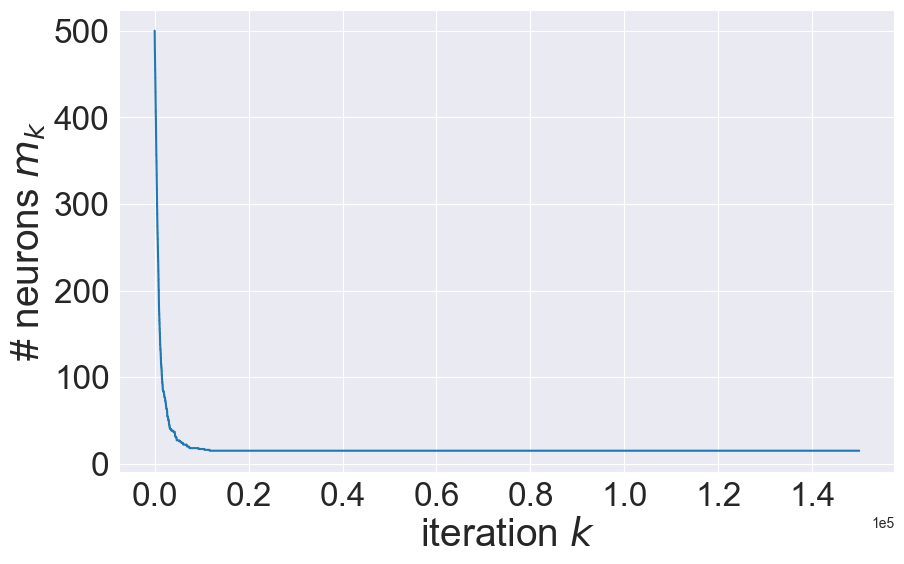

In [33]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

In [34]:
indexes = []
cpt = 0
while cpt < len(penalized_train_losses_coord) - 1:
    if penalized_train_losses_coord[cpt+1] > penalized_train_losses_coord[cpt]:
        indexes.append(cpt)
    cpt += 1
print(len(indexes))

19401


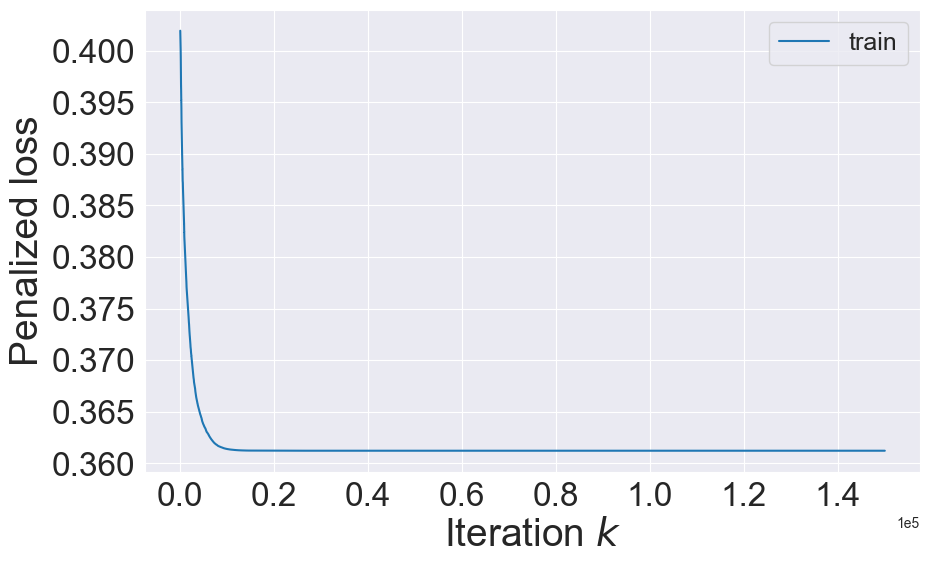

In [35]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='train')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

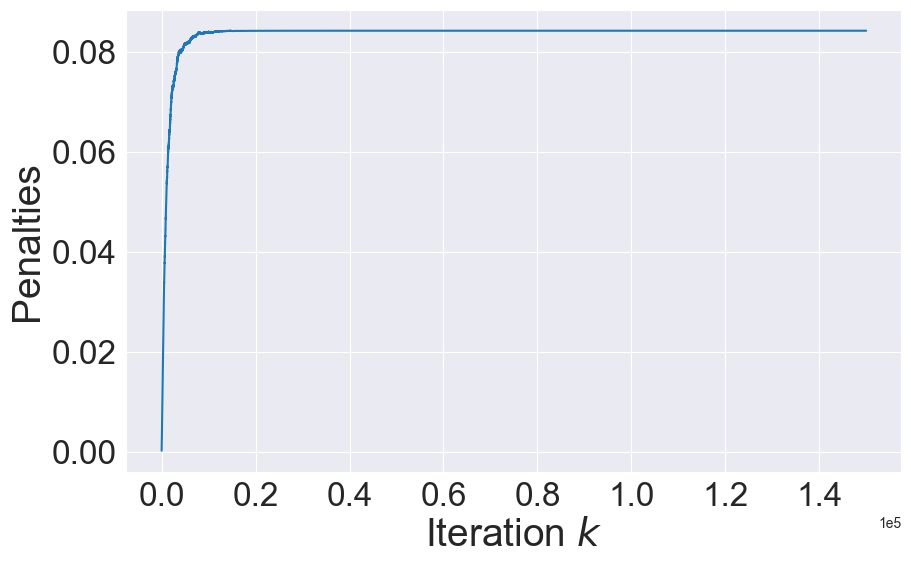

In [36]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_coord - train_losses_coord

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

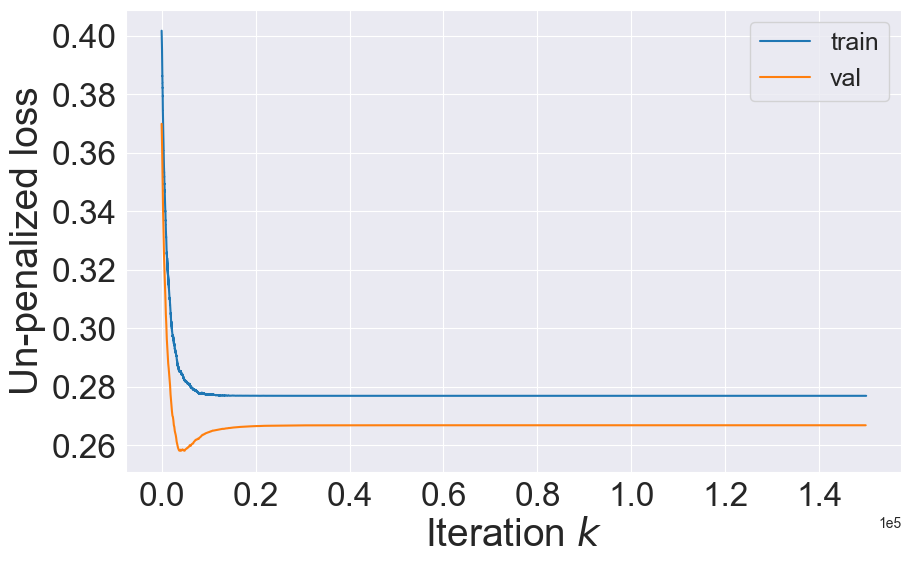

In [37]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_coord)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 4. Mix $L^2(\tau)/L^2(\tau_m)$ proximal algorithm

Here we mix one step of sampling a new particle and adjusting its weight and one step of chosing an existing particle at random and updating its weight. 

In [38]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0

In [39]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [40]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 2 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [41]:
a, b, ms, train_losses_mix, penalized_train_losses_mix, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val)

  0%|                                                     | 272/150000 [00:00<00:55, 2715.14it/s]

m at step 0 : 1
Train loss at step 0 : 0.40193
Validation loss at step 0 : 0.37007
m at step 100 : 31
Train loss at step 100 : 0.38955
Validation loss at step 100 : 0.35718
m at step 200 : 56
Train loss at step 200 : 0.37624
Validation loss at step 200 : 0.34387
m at step 300 : 71
Train loss at step 300 : 0.36875
Validation loss at step 300 : 0.33574
m at step 400 : 90
Train loss at step 400 : 0.36091
Validation loss at step 400 : 0.32781
m at step 500 : 105
Train loss at step 500 : 0.35506
Validation loss at step 500 : 0.32212


  1%|▎                                                    | 807/150000 [00:00<01:34, 1576.36it/s]

m at step 600 : 120
Train loss at step 600 : 0.34813
Validation loss at step 600 : 0.31543
m at step 700 : 130
Train loss at step 700 : 0.34211
Validation loss at step 700 : 0.31012
m at step 800 : 139
Train loss at step 800 : 0.33821
Validation loss at step 800 : 0.30642


  1%|▎                                                    | 998/150000 [00:00<01:49, 1361.34it/s]

m at step 900 : 151
Train loss at step 900 : 0.33238
Validation loss at step 900 : 0.30151
m at step 1,000 : 162
Train loss at step 1,000 : 0.32820
Validation loss at step 1,000 : 0.29736


  1%|▍                                                   | 1292/150000 [00:00<01:58, 1258.05it/s]

m at step 1,100 : 164
Train loss at step 1,100 : 0.32546
Validation loss at step 1,100 : 0.29504
m at step 1,200 : 170
Train loss at step 1,200 : 0.32202
Validation loss at step 1,200 : 0.29186
m at step 1,300 : 170
Train loss at step 1,300 : 0.31829
Validation loss at step 1,300 : 0.28852


  1%|▌                                                   | 1588/150000 [00:01<02:00, 1235.41it/s]

m at step 1,400 : 173
Train loss at step 1,400 : 0.31660
Validation loss at step 1,400 : 0.28704
m at step 1,500 : 177
Train loss at step 1,500 : 0.31360
Validation loss at step 1,500 : 0.28472
m at step 1,600 : 175
Train loss at step 1,600 : 0.31104
Validation loss at step 1,600 : 0.28282


  1%|▋                                                   | 1900/150000 [00:01<01:55, 1284.17it/s]

m at step 1,700 : 178
Train loss at step 1,700 : 0.30877
Validation loss at step 1,700 : 0.28093
m at step 1,800 : 176
Train loss at step 1,800 : 0.30730
Validation loss at step 1,800 : 0.27991
m at step 1,900 : 175
Train loss at step 1,900 : 0.30625
Validation loss at step 1,900 : 0.27904
m at step 2,000 : 172
Train loss at step 2,000 : 0.30349
Validation loss at step 2,000 : 0.27674


  2%|▊                                                   | 2474/150000 [00:01<01:27, 1693.94it/s]

m at step 2,100 : 170
Train loss at step 2,100 : 0.30264
Validation loss at step 2,100 : 0.27590
m at step 2,200 : 169
Train loss at step 2,200 : 0.30080
Validation loss at step 2,200 : 0.27408
m at step 2,300 : 171
Train loss at step 2,300 : 0.29927
Validation loss at step 2,300 : 0.27277
m at step 2,400 : 173
Train loss at step 2,400 : 0.29754
Validation loss at step 2,400 : 0.27141


  2%|▉                                                   | 2650/150000 [00:01<01:42, 1437.57it/s]

m at step 2,500 : 172
Train loss at step 2,500 : 0.29641
Validation loss at step 2,500 : 0.27052
m at step 2,600 : 168
Train loss at step 2,600 : 0.29483
Validation loss at step 2,600 : 0.26899
m at step 2,700 : 165
Train loss at step 2,700 : 0.29393
Validation loss at step 2,700 : 0.26827
m at step 2,800 : 164
Train loss at step 2,800 : 0.29240
Validation loss at step 2,800 : 0.26679


  2%|█                                                   | 3206/150000 [00:02<01:26, 1693.89it/s]

m at step 2,900 : 161
Train loss at step 2,900 : 0.29151
Validation loss at step 2,900 : 0.26630
m at step 3,000 : 159
Train loss at step 3,000 : 0.29110
Validation loss at step 3,000 : 0.26614
m at step 3,100 : 155
Train loss at step 3,100 : 0.28994
Validation loss at step 3,100 : 0.26540
m at step 3,200 : 155
Train loss at step 3,200 : 0.28831
Validation loss at step 3,200 : 0.26392


  2%|█▏                                                  | 3583/150000 [00:02<01:31, 1598.75it/s]

m at step 3,300 : 154
Train loss at step 3,300 : 0.28638
Validation loss at step 3,300 : 0.26247
m at step 3,400 : 148
Train loss at step 3,400 : 0.28410
Validation loss at step 3,400 : 0.26091
m at step 3,500 : 147
Train loss at step 3,500 : 0.28380
Validation loss at step 3,500 : 0.26103


  2%|█▎                                                  | 3749/150000 [00:02<01:34, 1550.36it/s]

m at step 3,600 : 147
Train loss at step 3,600 : 0.28259
Validation loss at step 3,600 : 0.26010
m at step 3,700 : 144
Train loss at step 3,700 : 0.28124
Validation loss at step 3,700 : 0.25891
m at step 3,800 : 138
Train loss at step 3,800 : 0.28044
Validation loss at step 3,800 : 0.25804


  3%|█▍                                                  | 4064/150000 [00:02<01:47, 1353.99it/s]

m at step 3,900 : 138
Train loss at step 3,900 : 0.27941
Validation loss at step 3,900 : 0.25700
m at step 4,000 : 136
Train loss at step 4,000 : 0.27832
Validation loss at step 4,000 : 0.25609
m at step 4,100 : 137
Train loss at step 4,100 : 0.27785
Validation loss at step 4,100 : 0.25542
m at step 4,200 : 133
Train loss at step 4,200 : 0.27664
Validation loss at step 4,200 : 0.25428


  3%|█▌                                                  | 4572/150000 [00:03<01:36, 1511.21it/s]

m at step 4,300 : 136
Train loss at step 4,300 : 0.27563
Validation loss at step 4,300 : 0.25319
m at step 4,400 : 134
Train loss at step 4,400 : 0.27501
Validation loss at step 4,400 : 0.25260
m at step 4,500 : 131
Train loss at step 4,500 : 0.27441
Validation loss at step 4,500 : 0.25233
m at step 4,600 : 133
Train loss at step 4,600 : 0.27311
Validation loss at step 4,600 : 0.25119


  3%|█▋                                                  | 4961/150000 [00:03<01:28, 1633.88it/s]

m at step 4,700 : 133
Train loss at step 4,700 : 0.27235
Validation loss at step 4,700 : 0.25036
m at step 4,800 : 130
Train loss at step 4,800 : 0.27231
Validation loss at step 4,800 : 0.25051
m at step 4,900 : 130
Train loss at step 4,900 : 0.27106
Validation loss at step 4,900 : 0.24960
m at step 5,000 : 130
Train loss at step 5,000 : 0.27010
Validation loss at step 5,000 : 0.24879
m at step 5,100 : 126
Train loss at step 5,100 : 0.26957
Validation loss at step 5,100 : 0.24835


  4%|█▉                                                  | 5627/150000 [00:03<01:11, 2022.17it/s]

m at step 5,200 : 125
Train loss at step 5,200 : 0.26737
Validation loss at step 5,200 : 0.24635
m at step 5,300 : 128
Train loss at step 5,300 : 0.26624
Validation loss at step 5,300 : 0.24529
m at step 5,400 : 131
Train loss at step 5,400 : 0.26580
Validation loss at step 5,400 : 0.24502
m at step 5,500 : 131
Train loss at step 5,500 : 0.26434
Validation loss at step 5,500 : 0.24346
m at step 5,600 : 131
Train loss at step 5,600 : 0.26369
Validation loss at step 5,600 : 0.24294


  4%|██                                                  | 6042/150000 [00:03<01:17, 1854.32it/s]

m at step 5,700 : 126
Train loss at step 5,700 : 0.26321
Validation loss at step 5,700 : 0.24259
m at step 5,800 : 127
Train loss at step 5,800 : 0.26215
Validation loss at step 5,800 : 0.24152
m at step 5,900 : 126
Train loss at step 5,900 : 0.26108
Validation loss at step 5,900 : 0.24063
m at step 6,000 : 126
Train loss at step 6,000 : 0.26018
Validation loss at step 6,000 : 0.23981


  4%|██▏                                                 | 6474/150000 [00:04<01:11, 2000.91it/s]

m at step 6,100 : 124
Train loss at step 6,100 : 0.25975
Validation loss at step 6,100 : 0.23957
m at step 6,200 : 121
Train loss at step 6,200 : 0.25871
Validation loss at step 6,200 : 0.23862
m at step 6,300 : 121
Train loss at step 6,300 : 0.25721
Validation loss at step 6,300 : 0.23717
m at step 6,400 : 119
Train loss at step 6,400 : 0.25665
Validation loss at step 6,400 : 0.23684
m at step 6,500 : 113
Train loss at step 6,500 : 0.25629
Validation loss at step 6,500 : 0.23668


  5%|██▍                                                 | 6916/150000 [00:04<01:10, 2042.22it/s]

m at step 6,600 : 111
Train loss at step 6,600 : 0.25554
Validation loss at step 6,600 : 0.23590
m at step 6,700 : 108
Train loss at step 6,700 : 0.25570
Validation loss at step 6,700 : 0.23613
m at step 6,800 : 106
Train loss at step 6,800 : 0.25532
Validation loss at step 6,800 : 0.23586
m at step 6,900 : 103
Train loss at step 6,900 : 0.25466
Validation loss at step 6,900 : 0.23532


  5%|██▌                                                 | 7314/150000 [00:04<01:21, 1759.00it/s]

m at step 7,000 : 101
Train loss at step 7,000 : 0.25389
Validation loss at step 7,000 : 0.23481
m at step 7,100 : 101
Train loss at step 7,100 : 0.25371
Validation loss at step 7,100 : 0.23459
m at step 7,200 : 99
Train loss at step 7,200 : 0.25284
Validation loss at step 7,200 : 0.23375
m at step 7,300 : 97
Train loss at step 7,300 : 0.25198
Validation loss at step 7,300 : 0.23304


  5%|██▋                                                 | 7744/150000 [00:04<01:19, 1783.52it/s]

m at step 7,400 : 96
Train loss at step 7,400 : 0.25130
Validation loss at step 7,400 : 0.23240
m at step 7,500 : 93
Train loss at step 7,500 : 0.25035
Validation loss at step 7,500 : 0.23162
m at step 7,600 : 93
Train loss at step 7,600 : 0.24962
Validation loss at step 7,600 : 0.23097
m at step 7,700 : 93
Train loss at step 7,700 : 0.24851
Validation loss at step 7,700 : 0.23018
m at step 7,800 : 90
Train loss at step 7,800 : 0.24803
Validation loss at step 7,800 : 0.22995


  5%|██▊                                                 | 8213/150000 [00:05<01:12, 1955.25it/s]

m at step 7,900 : 86
Train loss at step 7,900 : 0.24829
Validation loss at step 7,900 : 0.23023
m at step 8,000 : 86
Train loss at step 8,000 : 0.24788
Validation loss at step 8,000 : 0.23006
m at step 8,100 : 84
Train loss at step 8,100 : 0.24693
Validation loss at step 8,100 : 0.22937
m at step 8,200 : 84
Train loss at step 8,200 : 0.24620
Validation loss at step 8,200 : 0.22883
m at step 8,300 : 83
Train loss at step 8,300 : 0.24582
Validation loss at step 8,300 : 0.22864


  6%|██▉                                                 | 8646/150000 [00:05<01:11, 1978.70it/s]

m at step 8,400 : 83
Train loss at step 8,400 : 0.24581
Validation loss at step 8,400 : 0.22869
m at step 8,500 : 81
Train loss at step 8,500 : 0.24481
Validation loss at step 8,500 : 0.22778
m at step 8,600 : 81
Train loss at step 8,600 : 0.24385
Validation loss at step 8,600 : 0.22691
m at step 8,700 : 82
Train loss at step 8,700 : 0.24424
Validation loss at step 8,700 : 0.22734
m at step 8,800 : 81
Train loss at step 8,800 : 0.24368
Validation loss at step 8,800 : 0.22687
m at step 8,900 : 80
Train loss at step 8,900 : 0.24292
Validation loss at step 8,900 : 0.22632


  6%|███▎                                                | 9506/150000 [00:05<00:54, 2557.11it/s]

m at step 9,000 : 80
Train loss at step 9,000 : 0.24268
Validation loss at step 9,000 : 0.22624
m at step 9,100 : 78
Train loss at step 9,100 : 0.24214
Validation loss at step 9,100 : 0.22596
m at step 9,200 : 77
Train loss at step 9,200 : 0.24191
Validation loss at step 9,200 : 0.22574
m at step 9,300 : 77
Train loss at step 9,300 : 0.24151
Validation loss at step 9,300 : 0.22548
m at step 9,400 : 77
Train loss at step 9,400 : 0.24103
Validation loss at step 9,400 : 0.22511
m at step 9,500 : 77
Train loss at step 9,500 : 0.24034
Validation loss at step 9,500 : 0.22455
m at step 9,600 : 76
Train loss at step 9,600 : 0.23988
Validation loss at step 9,600 : 0.22421


  7%|███▍                                               | 10023/150000 [00:05<01:01, 2284.33it/s]

m at step 9,700 : 76
Train loss at step 9,700 : 0.23996
Validation loss at step 9,700 : 0.22431
m at step 9,800 : 75
Train loss at step 9,800 : 0.23985
Validation loss at step 9,800 : 0.22402
m at step 9,900 : 75
Train loss at step 9,900 : 0.23946
Validation loss at step 9,900 : 0.22384
m at step 10,000 : 74
Train loss at step 10,000 : 0.23901
Validation loss at step 10,000 : 0.22359


  7%|███▌                                               | 10547/150000 [00:06<00:56, 2448.52it/s]

m at step 10,100 : 74
Train loss at step 10,100 : 0.23891
Validation loss at step 10,100 : 0.22359
m at step 10,200 : 73
Train loss at step 10,200 : 0.23834
Validation loss at step 10,200 : 0.22316
m at step 10,300 : 73
Train loss at step 10,300 : 0.23827
Validation loss at step 10,300 : 0.22306
m at step 10,400 : 72
Train loss at step 10,400 : 0.23788
Validation loss at step 10,400 : 0.22278
m at step 10,500 : 72
Train loss at step 10,500 : 0.23767
Validation loss at step 10,500 : 0.22271
m at step 10,600 : 73
Train loss at step 10,600 : 0.23760
Validation loss at step 10,600 : 0.22264


  7%|███▊                                               | 11115/150000 [00:06<00:52, 2624.57it/s]

m at step 10,700 : 73
Train loss at step 10,700 : 0.23773
Validation loss at step 10,700 : 0.22274
m at step 10,800 : 74
Train loss at step 10,800 : 0.23734
Validation loss at step 10,800 : 0.22237
m at step 10,900 : 72
Train loss at step 10,900 : 0.23709
Validation loss at step 10,900 : 0.22219
m at step 11,000 : 71
Train loss at step 11,000 : 0.23701
Validation loss at step 11,000 : 0.22214
m at step 11,100 : 73
Train loss at step 11,100 : 0.23625
Validation loss at step 11,100 : 0.22146
m at step 11,200 : 72
Train loss at step 11,200 : 0.23552
Validation loss at step 11,200 : 0.22086


  8%|███▉                                               | 11619/150000 [00:06<01:00, 2287.10it/s]

m at step 11,300 : 72
Train loss at step 11,300 : 0.23521
Validation loss at step 11,300 : 0.22061
m at step 11,400 : 72
Train loss at step 11,400 : 0.23461
Validation loss at step 11,400 : 0.22020
m at step 11,500 : 72
Train loss at step 11,500 : 0.23432
Validation loss at step 11,500 : 0.21982
m at step 11,600 : 71
Train loss at step 11,600 : 0.23427
Validation loss at step 11,600 : 0.21977


  8%|████                                               | 12128/150000 [00:06<01:06, 2061.25it/s]

m at step 11,700 : 71
Train loss at step 11,700 : 0.23404
Validation loss at step 11,700 : 0.21953
m at step 11,800 : 70
Train loss at step 11,800 : 0.23393
Validation loss at step 11,800 : 0.21946
m at step 11,900 : 70
Train loss at step 11,900 : 0.23402
Validation loss at step 11,900 : 0.21959
m at step 12,000 : 68
Train loss at step 12,000 : 0.23389
Validation loss at step 12,000 : 0.21943
m at step 12,100 : 67
Train loss at step 12,100 : 0.23384
Validation loss at step 12,100 : 0.21942


  8%|████▎                                              | 12595/150000 [00:07<01:06, 2080.10it/s]

m at step 12,200 : 66
Train loss at step 12,200 : 0.23357
Validation loss at step 12,200 : 0.21925
m at step 12,300 : 67
Train loss at step 12,300 : 0.23327
Validation loss at step 12,300 : 0.21898
m at step 12,400 : 64
Train loss at step 12,400 : 0.23310
Validation loss at step 12,400 : 0.21882
m at step 12,500 : 63
Train loss at step 12,500 : 0.23275
Validation loss at step 12,500 : 0.21854
m at step 12,600 : 63
Train loss at step 12,600 : 0.23256
Validation loss at step 12,600 : 0.21850


  9%|████▍                                              | 13067/150000 [00:07<01:07, 2017.66it/s]

m at step 12,700 : 63
Train loss at step 12,700 : 0.23252
Validation loss at step 12,700 : 0.21854
m at step 12,800 : 63
Train loss at step 12,800 : 0.23209
Validation loss at step 12,800 : 0.21818
m at step 12,900 : 63
Train loss at step 12,900 : 0.23185
Validation loss at step 12,900 : 0.21812
m at step 13,000 : 63
Train loss at step 13,000 : 0.23176
Validation loss at step 13,000 : 0.21800


  9%|████▋                                              | 13679/150000 [00:07<00:54, 2511.25it/s]

m at step 13,100 : 62
Train loss at step 13,100 : 0.23179
Validation loss at step 13,100 : 0.21816
m at step 13,200 : 62
Train loss at step 13,200 : 0.23157
Validation loss at step 13,200 : 0.21802
m at step 13,300 : 62
Train loss at step 13,300 : 0.23148
Validation loss at step 13,300 : 0.21788
m at step 13,400 : 62
Train loss at step 13,400 : 0.23105
Validation loss at step 13,400 : 0.21753
m at step 13,500 : 62
Train loss at step 13,500 : 0.23101
Validation loss at step 13,500 : 0.21756
m at step 13,600 : 62
Train loss at step 13,600 : 0.23063
Validation loss at step 13,600 : 0.21739
m at step 13,700 : 62
Train loss at step 13,700 : 0.23086
Validation loss at step 13,700 : 0.21758


 10%|████▊                                              | 14315/150000 [00:07<00:47, 2857.07it/s]

m at step 13,800 : 61
Train loss at step 13,800 : 0.23092
Validation loss at step 13,800 : 0.21767
m at step 13,900 : 61
Train loss at step 13,900 : 0.23034
Validation loss at step 13,900 : 0.21707
m at step 14,000 : 61
Train loss at step 14,000 : 0.23007
Validation loss at step 14,000 : 0.21695
m at step 14,100 : 60
Train loss at step 14,100 : 0.22985
Validation loss at step 14,100 : 0.21678
m at step 14,200 : 58
Train loss at step 14,200 : 0.22963
Validation loss at step 14,200 : 0.21656
m at step 14,300 : 57
Train loss at step 14,300 : 0.22931
Validation loss at step 14,300 : 0.21634


 10%|████▉                                              | 14607/150000 [00:07<01:05, 2065.62it/s]

m at step 14,400 : 55
Train loss at step 14,400 : 0.22950
Validation loss at step 14,400 : 0.21660
m at step 14,500 : 54
Train loss at step 14,500 : 0.22881
Validation loss at step 14,500 : 0.21601
m at step 14,600 : 54
Train loss at step 14,600 : 0.22803
Validation loss at step 14,600 : 0.21539


 10%|█████                                              | 14849/150000 [00:08<01:11, 1889.92it/s]

m at step 14,700 : 54
Train loss at step 14,700 : 0.22771
Validation loss at step 14,700 : 0.21514
m at step 14,800 : 53
Train loss at step 14,800 : 0.22743
Validation loss at step 14,800 : 0.21491
m at step 14,900 : 52
Train loss at step 14,900 : 0.22737
Validation loss at step 14,900 : 0.21491
m at step 15,000 : 51
Train loss at step 15,000 : 0.22731
Validation loss at step 15,000 : 0.21494


 10%|█████▎                                             | 15443/150000 [00:08<01:20, 1679.22it/s]

m at step 15,100 : 51
Train loss at step 15,100 : 0.22739
Validation loss at step 15,100 : 0.21490
m at step 15,200 : 51
Train loss at step 15,200 : 0.22710
Validation loss at step 15,200 : 0.21468
m at step 15,300 : 51
Train loss at step 15,300 : 0.22748
Validation loss at step 15,300 : 0.21507
m at step 15,400 : 52
Train loss at step 15,400 : 0.22694
Validation loss at step 15,400 : 0.21467


 11%|█████▎                                             | 15794/150000 [00:08<01:24, 1580.41it/s]

m at step 15,500 : 52
Train loss at step 15,500 : 0.22662
Validation loss at step 15,500 : 0.21447
m at step 15,600 : 52
Train loss at step 15,600 : 0.22642
Validation loss at step 15,600 : 0.21431
m at step 15,700 : 51
Train loss at step 15,700 : 0.22599
Validation loss at step 15,700 : 0.21389
m at step 15,800 : 50
Train loss at step 15,800 : 0.22539
Validation loss at step 15,800 : 0.21342


 11%|█████▍                                             | 16109/150000 [00:08<01:39, 1352.20it/s]

m at step 15,900 : 50
Train loss at step 15,900 : 0.22525
Validation loss at step 15,900 : 0.21334
m at step 16,000 : 50
Train loss at step 16,000 : 0.22516
Validation loss at step 16,000 : 0.21323
m at step 16,100 : 50
Train loss at step 16,100 : 0.22538
Validation loss at step 16,100 : 0.21340


 11%|█████▌                                             | 16376/150000 [00:09<01:47, 1242.61it/s]

m at step 16,200 : 50
Train loss at step 16,200 : 0.22520
Validation loss at step 16,200 : 0.21319
m at step 16,300 : 50
Train loss at step 16,300 : 0.22478
Validation loss at step 16,300 : 0.21280
m at step 16,400 : 48
Train loss at step 16,400 : 0.22453
Validation loss at step 16,400 : 0.21268


 11%|█████▋                                             | 16707/150000 [00:09<01:45, 1263.17it/s]

m at step 16,500 : 48
Train loss at step 16,500 : 0.22401
Validation loss at step 16,500 : 0.21237
m at step 16,600 : 48
Train loss at step 16,600 : 0.22401
Validation loss at step 16,600 : 0.21244
m at step 16,700 : 47
Train loss at step 16,700 : 0.22387
Validation loss at step 16,700 : 0.21238
m at step 16,800 : 46
Train loss at step 16,800 : 0.22363
Validation loss at step 16,800 : 0.21221
m at step 16,900 : 46
Train loss at step 16,900 : 0.22347
Validation loss at step 16,900 : 0.21202
m at step 17,000 : 45
Train loss at step 17,000 : 0.22316
Validation loss at step 17,000 : 0.21181


 12%|█████▉                                             | 17366/150000 [00:09<01:27, 1522.22it/s]

m at step 17,100 : 45
Train loss at step 17,100 : 0.22266
Validation loss at step 17,100 : 0.21144
m at step 17,200 : 44
Train loss at step 17,200 : 0.22257
Validation loss at step 17,200 : 0.21135
m at step 17,300 : 43
Train loss at step 17,300 : 0.22220
Validation loss at step 17,300 : 0.21101


 12%|█████▉                                             | 17528/150000 [00:10<01:36, 1376.23it/s]

m at step 17,400 : 43
Train loss at step 17,400 : 0.22218
Validation loss at step 17,400 : 0.21108
m at step 17,500 : 43
Train loss at step 17,500 : 0.22205
Validation loss at step 17,500 : 0.21085
m at step 17,600 : 44
Train loss at step 17,600 : 0.22226
Validation loss at step 17,600 : 0.21099


 12%|██████▏                                            | 18066/150000 [00:10<01:29, 1478.90it/s]

m at step 17,700 : 44
Train loss at step 17,700 : 0.22199
Validation loss at step 17,700 : 0.21074
m at step 17,800 : 43
Train loss at step 17,800 : 0.22180
Validation loss at step 17,800 : 0.21066
m at step 17,900 : 43
Train loss at step 17,900 : 0.22153
Validation loss at step 17,900 : 0.21050
m at step 18,000 : 43
Train loss at step 18,000 : 0.22166
Validation loss at step 18,000 : 0.21066


 12%|██████▎                                            | 18497/150000 [00:10<01:12, 1817.20it/s]

m at step 18,100 : 43
Train loss at step 18,100 : 0.22146
Validation loss at step 18,100 : 0.21051
m at step 18,200 : 43
Train loss at step 18,200 : 0.22147
Validation loss at step 18,200 : 0.21053
m at step 18,300 : 43
Train loss at step 18,300 : 0.22121
Validation loss at step 18,300 : 0.21033
m at step 18,400 : 43
Train loss at step 18,400 : 0.22084
Validation loss at step 18,400 : 0.21004
m at step 18,500 : 41
Train loss at step 18,500 : 0.22093
Validation loss at step 18,500 : 0.21011


 13%|██████▍                                            | 19024/150000 [00:10<01:04, 2027.39it/s]

m at step 18,600 : 41
Train loss at step 18,600 : 0.22080
Validation loss at step 18,600 : 0.21006
m at step 18,700 : 39
Train loss at step 18,700 : 0.22099
Validation loss at step 18,700 : 0.21023
m at step 18,800 : 40
Train loss at step 18,800 : 0.22067
Validation loss at step 18,800 : 0.20998
m at step 18,900 : 39
Train loss at step 18,900 : 0.22063
Validation loss at step 18,900 : 0.20994
m at step 19,000 : 40
Train loss at step 19,000 : 0.22016
Validation loss at step 19,000 : 0.20955
m at step 19,100 : 40
Train loss at step 19,100 : 0.21999
Validation loss at step 19,100 : 0.20939


 13%|██████▋                                            | 19535/150000 [00:11<00:58, 2225.18it/s]

m at step 19,200 : 40
Train loss at step 19,200 : 0.22001
Validation loss at step 19,200 : 0.20941
m at step 19,300 : 40
Train loss at step 19,300 : 0.21998
Validation loss at step 19,300 : 0.20938
m at step 19,400 : 40
Train loss at step 19,400 : 0.21984
Validation loss at step 19,400 : 0.20923
m at step 19,500 : 39
Train loss at step 19,500 : 0.21956
Validation loss at step 19,500 : 0.20901
m at step 19,600 : 39
Train loss at step 19,600 : 0.21938
Validation loss at step 19,600 : 0.20886
m at step 19,700 : 39
Train loss at step 19,700 : 0.21936
Validation loss at step 19,700 : 0.20882


 13%|██████▊                                            | 20047/150000 [00:11<00:56, 2287.04it/s]

m at step 19,800 : 39
Train loss at step 19,800 : 0.21919
Validation loss at step 19,800 : 0.20860
m at step 19,900 : 39
Train loss at step 19,900 : 0.21934
Validation loss at step 19,900 : 0.20875
m at step 20,000 : 39
Train loss at step 20,000 : 0.21949
Validation loss at step 20,000 : 0.20886
m at step 20,100 : 39
Train loss at step 20,100 : 0.21944
Validation loss at step 20,100 : 0.20879
m at step 20,200 : 40
Train loss at step 20,200 : 0.21914
Validation loss at step 20,200 : 0.20853
m at step 20,300 : 40
Train loss at step 20,300 : 0.21931
Validation loss at step 20,300 : 0.20863


 14%|███████                                            | 20714/150000 [00:11<00:46, 2769.88it/s]

m at step 20,400 : 38
Train loss at step 20,400 : 0.21920
Validation loss at step 20,400 : 0.20850
m at step 20,500 : 39
Train loss at step 20,500 : 0.21909
Validation loss at step 20,500 : 0.20829
m at step 20,600 : 39
Train loss at step 20,600 : 0.21874
Validation loss at step 20,600 : 0.20784
m at step 20,700 : 39
Train loss at step 20,700 : 0.21867
Validation loss at step 20,700 : 0.20762
m at step 20,800 : 39
Train loss at step 20,800 : 0.21825
Validation loss at step 20,800 : 0.20724
m at step 20,900 : 39
Train loss at step 20,900 : 0.21784
Validation loss at step 20,900 : 0.20678
m at step 21,000 : 37
Train loss at step 21,000 : 0.21790
Validation loss at step 21,000 : 0.20682


 14%|███████▎                                           | 21467/150000 [00:11<00:39, 3277.09it/s]

m at step 21,100 : 37
Train loss at step 21,100 : 0.21773
Validation loss at step 21,100 : 0.20657
m at step 21,200 : 37
Train loss at step 21,200 : 0.21755
Validation loss at step 21,200 : 0.20639
m at step 21,300 : 37
Train loss at step 21,300 : 0.21755
Validation loss at step 21,300 : 0.20627
m at step 21,400 : 37
Train loss at step 21,400 : 0.21768
Validation loss at step 21,400 : 0.20638
m at step 21,500 : 37
Train loss at step 21,500 : 0.21742
Validation loss at step 21,500 : 0.20607
m at step 21,600 : 37
Train loss at step 21,600 : 0.21751
Validation loss at step 21,600 : 0.20612
m at step 21,700 : 37
Train loss at step 21,700 : 0.21739
Validation loss at step 21,700 : 0.20597


 15%|███████▌                                           | 22101/150000 [00:11<00:44, 2894.01it/s]

m at step 21,800 : 37
Train loss at step 21,800 : 0.21727
Validation loss at step 21,800 : 0.20582
m at step 21,900 : 37
Train loss at step 21,900 : 0.21724
Validation loss at step 21,900 : 0.20578
m at step 22,000 : 37
Train loss at step 22,000 : 0.21703
Validation loss at step 22,000 : 0.20558
m at step 22,100 : 37
Train loss at step 22,100 : 0.21702
Validation loss at step 22,100 : 0.20558
m at step 22,200 : 37
Train loss at step 22,200 : 0.21708
Validation loss at step 22,200 : 0.20564
m at step 22,300 : 37
Train loss at step 22,300 : 0.21676
Validation loss at step 22,300 : 0.20530
m at step 22,400 : 37
Train loss at step 22,400 : 0.21664
Validation loss at step 22,400 : 0.20511


 15%|███████▉                                           | 23217/150000 [00:12<00:36, 3468.64it/s]

m at step 22,500 : 37
Train loss at step 22,500 : 0.21693
Validation loss at step 22,500 : 0.20531
m at step 22,600 : 37
Train loss at step 22,600 : 0.21691
Validation loss at step 22,600 : 0.20525
m at step 22,700 : 36
Train loss at step 22,700 : 0.21692
Validation loss at step 22,700 : 0.20523
m at step 22,800 : 36
Train loss at step 22,800 : 0.21686
Validation loss at step 22,800 : 0.20512
m at step 22,900 : 35
Train loss at step 22,900 : 0.21680
Validation loss at step 22,900 : 0.20506
m at step 23,000 : 34
Train loss at step 23,000 : 0.21613
Validation loss at step 23,000 : 0.20439
m at step 23,100 : 34
Train loss at step 23,100 : 0.21624
Validation loss at step 23,100 : 0.20449
m at step 23,200 : 34
Train loss at step 23,200 : 0.21613
Validation loss at step 23,200 : 0.20438


 16%|████████                                           | 23569/150000 [00:12<00:39, 3216.09it/s]

m at step 23,300 : 34
Train loss at step 23,300 : 0.21625
Validation loss at step 23,300 : 0.20444
m at step 23,400 : 34
Train loss at step 23,400 : 0.21614
Validation loss at step 23,400 : 0.20425
m at step 23,500 : 35
Train loss at step 23,500 : 0.21620
Validation loss at step 23,500 : 0.20424
m at step 23,600 : 35
Train loss at step 23,600 : 0.21633
Validation loss at step 23,600 : 0.20427


 16%|████████▏                                          | 23898/150000 [00:12<00:52, 2423.83it/s]

m at step 23,700 : 35
Train loss at step 23,700 : 0.21620
Validation loss at step 23,700 : 0.20412
m at step 23,800 : 35
Train loss at step 23,800 : 0.21634
Validation loss at step 23,800 : 0.20416
m at step 23,900 : 35
Train loss at step 23,900 : 0.21629
Validation loss at step 23,900 : 0.20406
m at step 24,000 : 34
Train loss at step 24,000 : 0.21611
Validation loss at step 24,000 : 0.20380


 16%|████████▎                                          | 24409/150000 [00:12<01:01, 2038.99it/s]

m at step 24,100 : 34
Train loss at step 24,100 : 0.21591
Validation loss at step 24,100 : 0.20356
m at step 24,200 : 34
Train loss at step 24,200 : 0.21558
Validation loss at step 24,200 : 0.20321
m at step 24,300 : 34
Train loss at step 24,300 : 0.21536
Validation loss at step 24,300 : 0.20298
m at step 24,400 : 34
Train loss at step 24,400 : 0.21520
Validation loss at step 24,400 : 0.20274


 17%|████████▍                                          | 24817/150000 [00:13<01:17, 1605.63it/s]

m at step 24,500 : 34
Train loss at step 24,500 : 0.21522
Validation loss at step 24,500 : 0.20271
m at step 24,600 : 34
Train loss at step 24,600 : 0.21530
Validation loss at step 24,600 : 0.20270
m at step 24,700 : 34
Train loss at step 24,700 : 0.21519
Validation loss at step 24,700 : 0.20246
m at step 24,800 : 34
Train loss at step 24,800 : 0.21514
Validation loss at step 24,800 : 0.20235


 17%|████████▌                                          | 25171/150000 [00:13<01:18, 1586.52it/s]

m at step 24,900 : 34
Train loss at step 24,900 : 0.21513
Validation loss at step 24,900 : 0.20228
m at step 25,000 : 35
Train loss at step 25,000 : 0.21523
Validation loss at step 25,000 : 0.20232
m at step 25,100 : 35
Train loss at step 25,100 : 0.21527
Validation loss at step 25,100 : 0.20227
m at step 25,200 : 35
Train loss at step 25,200 : 0.21537
Validation loss at step 25,200 : 0.20230


 17%|████████▋                                          | 25524/150000 [00:13<01:15, 1641.03it/s]

m at step 25,300 : 35
Train loss at step 25,300 : 0.21506
Validation loss at step 25,300 : 0.20195
m at step 25,400 : 35
Train loss at step 25,400 : 0.21492
Validation loss at step 25,400 : 0.20175
m at step 25,500 : 35
Train loss at step 25,500 : 0.21483
Validation loss at step 25,500 : 0.20160
m at step 25,600 : 35
Train loss at step 25,600 : 0.21471
Validation loss at step 25,600 : 0.20147


 17%|████████▊                                          | 26073/150000 [00:14<01:12, 1717.06it/s]

m at step 25,700 : 35
Train loss at step 25,700 : 0.21467
Validation loss at step 25,700 : 0.20136
m at step 25,800 : 35
Train loss at step 25,800 : 0.21474
Validation loss at step 25,800 : 0.20137
m at step 25,900 : 35
Train loss at step 25,900 : 0.21462
Validation loss at step 25,900 : 0.20124
m at step 26,000 : 35
Train loss at step 26,000 : 0.21468
Validation loss at step 26,000 : 0.20124


 18%|████████▉                                          | 26437/150000 [00:14<01:11, 1725.42it/s]

m at step 26,100 : 35
Train loss at step 26,100 : 0.21466
Validation loss at step 26,100 : 0.20121
m at step 26,200 : 34
Train loss at step 26,200 : 0.21468
Validation loss at step 26,200 : 0.20117
m at step 26,300 : 34
Train loss at step 26,300 : 0.21457
Validation loss at step 26,300 : 0.20102
m at step 26,400 : 34
Train loss at step 26,400 : 0.21447
Validation loss at step 26,400 : 0.20088


 18%|█████████                                          | 26780/150000 [00:14<01:14, 1644.96it/s]

m at step 26,500 : 34
Train loss at step 26,500 : 0.21432
Validation loss at step 26,500 : 0.20067
m at step 26,600 : 34
Train loss at step 26,600 : 0.21437
Validation loss at step 26,600 : 0.20064
m at step 26,700 : 33
Train loss at step 26,700 : 0.21422
Validation loss at step 26,700 : 0.20048
m at step 26,800 : 32
Train loss at step 26,800 : 0.21433
Validation loss at step 26,800 : 0.20049


 18%|█████████▏                                         | 27108/150000 [00:14<01:16, 1603.56it/s]

m at step 26,900 : 32
Train loss at step 26,900 : 0.21409
Validation loss at step 26,900 : 0.20021
m at step 27,000 : 32
Train loss at step 27,000 : 0.21413
Validation loss at step 27,000 : 0.20019
m at step 27,100 : 32
Train loss at step 27,100 : 0.21405
Validation loss at step 27,100 : 0.20003


 18%|█████████▎                                         | 27479/150000 [00:14<01:15, 1617.17it/s]

m at step 27,200 : 32
Train loss at step 27,200 : 0.21395
Validation loss at step 27,200 : 0.19991
m at step 27,300 : 32
Train loss at step 27,300 : 0.21387
Validation loss at step 27,300 : 0.19980
m at step 27,400 : 32
Train loss at step 27,400 : 0.21363
Validation loss at step 27,400 : 0.19958
m at step 27,500 : 32
Train loss at step 27,500 : 0.21348
Validation loss at step 27,500 : 0.19938
m at step 27,600 : 32
Train loss at step 27,600 : 0.21351
Validation loss at step 27,600 : 0.19934


 19%|█████████▌                                         | 28013/150000 [00:15<01:11, 1707.92it/s]

m at step 27,700 : 31
Train loss at step 27,700 : 0.21350
Validation loss at step 27,700 : 0.19928
m at step 27,800 : 31
Train loss at step 27,800 : 0.21344
Validation loss at step 27,800 : 0.19912
m at step 27,900 : 31
Train loss at step 27,900 : 0.21337
Validation loss at step 27,900 : 0.19901
m at step 28,000 : 29
Train loss at step 28,000 : 0.21331
Validation loss at step 28,000 : 0.19890


 19%|█████████▋                                         | 28366/150000 [00:15<01:14, 1622.96it/s]

m at step 28,100 : 29
Train loss at step 28,100 : 0.21330
Validation loss at step 28,100 : 0.19884
m at step 28,200 : 29
Train loss at step 28,200 : 0.21327
Validation loss at step 28,200 : 0.19875
m at step 28,300 : 29
Train loss at step 28,300 : 0.21299
Validation loss at step 28,300 : 0.19846
m at step 28,400 : 30
Train loss at step 28,400 : 0.21312
Validation loss at step 28,400 : 0.19854


 19%|█████████▊                                         | 28785/150000 [00:15<01:04, 1884.03it/s]

m at step 28,500 : 30
Train loss at step 28,500 : 0.21305
Validation loss at step 28,500 : 0.19846
m at step 28,600 : 30
Train loss at step 28,600 : 0.21311
Validation loss at step 28,600 : 0.19848
m at step 28,700 : 30
Train loss at step 28,700 : 0.21302
Validation loss at step 28,700 : 0.19836
m at step 28,800 : 30
Train loss at step 28,800 : 0.21280
Validation loss at step 28,800 : 0.19808
m at step 28,900 : 30
Train loss at step 28,900 : 0.21281
Validation loss at step 28,900 : 0.19804


 20%|█████████▉                                         | 29409/150000 [00:15<01:01, 1967.82it/s]

m at step 29,000 : 30
Train loss at step 29,000 : 0.21291
Validation loss at step 29,000 : 0.19811
m at step 29,100 : 30
Train loss at step 29,100 : 0.21296
Validation loss at step 29,100 : 0.19808
m at step 29,200 : 30
Train loss at step 29,200 : 0.21285
Validation loss at step 29,200 : 0.19795
m at step 29,300 : 30
Train loss at step 29,300 : 0.21272
Validation loss at step 29,300 : 0.19775
m at step 29,400 : 30
Train loss at step 29,400 : 0.21267
Validation loss at step 29,400 : 0.19767


 20%|██████████▏                                        | 29816/150000 [00:16<01:03, 1893.20it/s]

m at step 29,500 : 30
Train loss at step 29,500 : 0.21269
Validation loss at step 29,500 : 0.19764
m at step 29,600 : 30
Train loss at step 29,600 : 0.21255
Validation loss at step 29,600 : 0.19746
m at step 29,700 : 29
Train loss at step 29,700 : 0.21267
Validation loss at step 29,700 : 0.19753
m at step 29,800 : 29
Train loss at step 29,800 : 0.21266
Validation loss at step 29,800 : 0.19747
m at step 29,900 : 29
Train loss at step 29,900 : 0.21258
Validation loss at step 29,900 : 0.19738


 20%|██████████▎                                        | 30195/150000 [00:16<01:06, 1814.65it/s]

m at step 30,000 : 29
Train loss at step 30,000 : 0.21265
Validation loss at step 30,000 : 0.19739
m at step 30,100 : 29
Train loss at step 30,100 : 0.21258
Validation loss at step 30,100 : 0.19733
m at step 30,200 : 29
Train loss at step 30,200 : 0.21258
Validation loss at step 30,200 : 0.19731
m at step 30,300 : 29
Train loss at step 30,300 : 0.21258
Validation loss at step 30,300 : 0.19728
m at step 30,400 : 28
Train loss at step 30,400 : 0.21257
Validation loss at step 30,400 : 0.19724


 21%|██████████▍                                        | 30782/150000 [00:16<01:10, 1698.98it/s]

m at step 30,500 : 26
Train loss at step 30,500 : 0.21246
Validation loss at step 30,500 : 0.19713
m at step 30,600 : 26
Train loss at step 30,600 : 0.21246
Validation loss at step 30,600 : 0.19713
m at step 30,700 : 26
Train loss at step 30,700 : 0.21238
Validation loss at step 30,700 : 0.19704
m at step 30,800 : 26
Train loss at step 30,800 : 0.21214
Validation loss at step 30,800 : 0.19681


 21%|██████████▌                                        | 31152/150000 [00:16<01:07, 1748.59it/s]

m at step 30,900 : 26
Train loss at step 30,900 : 0.21222
Validation loss at step 30,900 : 0.19688
m at step 31,000 : 26
Train loss at step 31,000 : 0.21210
Validation loss at step 31,000 : 0.19674
m at step 31,100 : 26
Train loss at step 31,100 : 0.21208
Validation loss at step 31,100 : 0.19673
m at step 31,200 : 27
Train loss at step 31,200 : 0.21186
Validation loss at step 31,200 : 0.19654


 21%|██████████▋                                        | 31541/150000 [00:17<01:06, 1770.55it/s]

m at step 31,300 : 27
Train loss at step 31,300 : 0.21193
Validation loss at step 31,300 : 0.19657
m at step 31,400 : 27
Train loss at step 31,400 : 0.21171
Validation loss at step 31,400 : 0.19638
m at step 31,500 : 26
Train loss at step 31,500 : 0.21179
Validation loss at step 31,500 : 0.19646
m at step 31,600 : 26
Train loss at step 31,600 : 0.21170
Validation loss at step 31,600 : 0.19640
m at step 31,700 : 26
Train loss at step 31,700 : 0.21175
Validation loss at step 31,700 : 0.19642


 21%|██████████▉                                        | 32174/150000 [00:17<00:59, 1995.91it/s]

m at step 31,800 : 26
Train loss at step 31,800 : 0.21174
Validation loss at step 31,800 : 0.19641
m at step 31,900 : 26
Train loss at step 31,900 : 0.21164
Validation loss at step 31,900 : 0.19632
m at step 32,000 : 26
Train loss at step 32,000 : 0.21151
Validation loss at step 32,000 : 0.19622
m at step 32,100 : 26
Train loss at step 32,100 : 0.21155
Validation loss at step 32,100 : 0.19625
m at step 32,200 : 26
Train loss at step 32,200 : 0.21132
Validation loss at step 32,200 : 0.19600


 22%|███████████                                        | 32640/150000 [00:17<00:54, 2138.99it/s]

m at step 32,300 : 26
Train loss at step 32,300 : 0.21143
Validation loss at step 32,300 : 0.19608
m at step 32,400 : 26
Train loss at step 32,400 : 0.21135
Validation loss at step 32,400 : 0.19601
m at step 32,500 : 26
Train loss at step 32,500 : 0.21130
Validation loss at step 32,500 : 0.19593
m at step 32,600 : 26
Train loss at step 32,600 : 0.21125
Validation loss at step 32,600 : 0.19582
m at step 32,700 : 26
Train loss at step 32,700 : 0.21128
Validation loss at step 32,700 : 0.19585


 22%|███████████▎                                       | 33145/150000 [00:17<00:52, 2247.05it/s]

m at step 32,800 : 25
Train loss at step 32,800 : 0.21118
Validation loss at step 32,800 : 0.19575
m at step 32,900 : 25
Train loss at step 32,900 : 0.21112
Validation loss at step 32,900 : 0.19567
m at step 33,000 : 25
Train loss at step 33,000 : 0.21104
Validation loss at step 33,000 : 0.19559
m at step 33,100 : 25
Train loss at step 33,100 : 0.21122
Validation loss at step 33,100 : 0.19574
m at step 33,200 : 24
Train loss at step 33,200 : 0.21130
Validation loss at step 33,200 : 0.19579
m at step 33,300 : 24
Train loss at step 33,300 : 0.21127
Validation loss at step 33,300 : 0.19573
m at step 33,400 : 24
Train loss at step 33,400 : 0.21133
Validation loss at step 33,400 : 0.19580


 23%|███████████▍                                       | 33779/150000 [00:18<00:43, 2680.26it/s]

m at step 33,500 : 24
Train loss at step 33,500 : 0.21110
Validation loss at step 33,500 : 0.19556
m at step 33,600 : 24
Train loss at step 33,600 : 0.21093
Validation loss at step 33,600 : 0.19539
m at step 33,700 : 24
Train loss at step 33,700 : 0.21100
Validation loss at step 33,700 : 0.19544
m at step 33,800 : 24
Train loss at step 33,800 : 0.21098
Validation loss at step 33,800 : 0.19539
m at step 33,900 : 25
Train loss at step 33,900 : 0.21080
Validation loss at step 33,900 : 0.19522
m at step 34,000 : 25
Train loss at step 34,000 : 0.21060
Validation loss at step 34,000 : 0.19497


 23%|███████████▋                                       | 34312/150000 [00:18<00:53, 2180.41it/s]

m at step 34,100 : 25
Train loss at step 34,100 : 0.21067
Validation loss at step 34,100 : 0.19500
m at step 34,200 : 25
Train loss at step 34,200 : 0.21071
Validation loss at step 34,200 : 0.19499
m at step 34,300 : 25
Train loss at step 34,300 : 0.21063
Validation loss at step 34,300 : 0.19491
m at step 34,400 : 25
Train loss at step 34,400 : 0.21068
Validation loss at step 34,400 : 0.19491


 23%|███████████▊                                       | 34754/150000 [00:18<01:00, 1907.41it/s]

m at step 34,500 : 25
Train loss at step 34,500 : 0.21056
Validation loss at step 34,500 : 0.19476
m at step 34,600 : 25
Train loss at step 34,600 : 0.21053
Validation loss at step 34,600 : 0.19471
m at step 34,700 : 25
Train loss at step 34,700 : 0.21050
Validation loss at step 34,700 : 0.19470
m at step 34,800 : 24
Train loss at step 34,800 : 0.21055
Validation loss at step 34,800 : 0.19471


 23%|███████████▉                                       | 35223/150000 [00:18<00:53, 2130.51it/s]

m at step 34,900 : 23
Train loss at step 34,900 : 0.21044
Validation loss at step 34,900 : 0.19457
m at step 35,000 : 23
Train loss at step 35,000 : 0.21040
Validation loss at step 35,000 : 0.19453
m at step 35,100 : 23
Train loss at step 35,100 : 0.21022
Validation loss at step 35,100 : 0.19435
m at step 35,200 : 23
Train loss at step 35,200 : 0.21033
Validation loss at step 35,200 : 0.19444
m at step 35,300 : 23
Train loss at step 35,300 : 0.21024
Validation loss at step 35,300 : 0.19434
m at step 35,400 : 23
Train loss at step 35,400 : 0.21005
Validation loss at step 35,400 : 0.19415


 24%|████████████▏                                      | 35858/150000 [00:19<00:57, 1999.71it/s]

m at step 35,500 : 23
Train loss at step 35,500 : 0.21015
Validation loss at step 35,500 : 0.19421
m at step 35,600 : 23
Train loss at step 35,600 : 0.21011
Validation loss at step 35,600 : 0.19417
m at step 35,700 : 23
Train loss at step 35,700 : 0.21007
Validation loss at step 35,700 : 0.19413
m at step 35,800 : 24
Train loss at step 35,800 : 0.21018
Validation loss at step 35,800 : 0.19420
m at step 35,900 : 23
Train loss at step 35,900 : 0.21023
Validation loss at step 35,900 : 0.19424


 24%|████████████▎                                      | 36257/150000 [00:19<00:59, 1896.68it/s]

m at step 36,000 : 23
Train loss at step 36,000 : 0.21012
Validation loss at step 36,000 : 0.19413
m at step 36,100 : 23
Train loss at step 36,100 : 0.21000
Validation loss at step 36,100 : 0.19401
m at step 36,200 : 23
Train loss at step 36,200 : 0.20994
Validation loss at step 36,200 : 0.19394
m at step 36,300 : 23
Train loss at step 36,300 : 0.20990
Validation loss at step 36,300 : 0.19389
m at step 36,400 : 24
Train loss at step 36,400 : 0.20975
Validation loss at step 36,400 : 0.19372


 25%|████████████▌                                      | 36879/150000 [00:19<00:56, 2019.03it/s]

m at step 36,500 : 24
Train loss at step 36,500 : 0.20971
Validation loss at step 36,500 : 0.19365
m at step 36,600 : 24
Train loss at step 36,600 : 0.20964
Validation loss at step 36,600 : 0.19353
m at step 36,700 : 24
Train loss at step 36,700 : 0.20959
Validation loss at step 36,700 : 0.19349
m at step 36,800 : 24
Train loss at step 36,800 : 0.20961
Validation loss at step 36,800 : 0.19350
m at step 36,900 : 24
Train loss at step 36,900 : 0.20958
Validation loss at step 36,900 : 0.19343


 25%|████████████▋                                      | 37314/150000 [00:19<00:55, 2020.67it/s]

m at step 37,000 : 24
Train loss at step 37,000 : 0.20959
Validation loss at step 37,000 : 0.19343
m at step 37,100 : 24
Train loss at step 37,100 : 0.20957
Validation loss at step 37,100 : 0.19340
m at step 37,200 : 24
Train loss at step 37,200 : 0.20958
Validation loss at step 37,200 : 0.19337
m at step 37,300 : 24
Train loss at step 37,300 : 0.20948
Validation loss at step 37,300 : 0.19323
m at step 37,400 : 24
Train loss at step 37,400 : 0.20935
Validation loss at step 37,400 : 0.19306


 25%|████████████▊                                      | 37776/150000 [00:20<00:53, 2112.22it/s]

m at step 37,500 : 24
Train loss at step 37,500 : 0.20938
Validation loss at step 37,500 : 0.19307
m at step 37,600 : 24
Train loss at step 37,600 : 0.20929
Validation loss at step 37,600 : 0.19294
m at step 37,700 : 24
Train loss at step 37,700 : 0.20925
Validation loss at step 37,700 : 0.19285
m at step 37,800 : 24
Train loss at step 37,800 : 0.20906
Validation loss at step 37,800 : 0.19264
m at step 37,900 : 24
Train loss at step 37,900 : 0.20909
Validation loss at step 37,900 : 0.19261


 25%|████████████▉                                      | 38222/150000 [00:20<00:57, 1958.49it/s]

m at step 38,000 : 24
Train loss at step 38,000 : 0.20908
Validation loss at step 38,000 : 0.19255
m at step 38,100 : 24
Train loss at step 38,100 : 0.20908
Validation loss at step 38,100 : 0.19253
m at step 38,200 : 23
Train loss at step 38,200 : 0.20904
Validation loss at step 38,200 : 0.19245


 26%|█████████████▏                                     | 38611/150000 [00:20<01:04, 1736.58it/s]

m at step 38,300 : 23
Train loss at step 38,300 : 0.20916
Validation loss at step 38,300 : 0.19254
m at step 38,400 : 23
Train loss at step 38,400 : 0.20918
Validation loss at step 38,400 : 0.19252
m at step 38,500 : 23
Train loss at step 38,500 : 0.20926
Validation loss at step 38,500 : 0.19255
m at step 38,600 : 23
Train loss at step 38,600 : 0.20918
Validation loss at step 38,600 : 0.19245


 26%|█████████████▎                                     | 39016/150000 [00:20<01:02, 1767.09it/s]

m at step 38,700 : 23
Train loss at step 38,700 : 0.20912
Validation loss at step 38,700 : 0.19238
m at step 38,800 : 23
Train loss at step 38,800 : 0.20902
Validation loss at step 38,800 : 0.19226
m at step 38,900 : 23
Train loss at step 38,900 : 0.20912
Validation loss at step 38,900 : 0.19237
m at step 39,000 : 23
Train loss at step 39,000 : 0.20890
Validation loss at step 39,000 : 0.19209
m at step 39,100 : 23
Train loss at step 39,100 : 0.20888
Validation loss at step 39,100 : 0.19201


 26%|█████████████▍                                     | 39604/150000 [00:21<01:00, 1826.89it/s]

m at step 39,200 : 23
Train loss at step 39,200 : 0.20886
Validation loss at step 39,200 : 0.19197
m at step 39,300 : 22
Train loss at step 39,300 : 0.20874
Validation loss at step 39,300 : 0.19178
m at step 39,400 : 21
Train loss at step 39,400 : 0.20880
Validation loss at step 39,400 : 0.19181
m at step 39,500 : 21
Train loss at step 39,500 : 0.20883
Validation loss at step 39,500 : 0.19183
m at step 39,600 : 21
Train loss at step 39,600 : 0.20879
Validation loss at step 39,600 : 0.19177


 27%|█████████████▌                                     | 40032/150000 [00:21<00:57, 1924.54it/s]

m at step 39,700 : 21
Train loss at step 39,700 : 0.20886
Validation loss at step 39,700 : 0.19184
m at step 39,800 : 21
Train loss at step 39,800 : 0.20897
Validation loss at step 39,800 : 0.19195
m at step 39,900 : 20
Train loss at step 39,900 : 0.20892
Validation loss at step 39,900 : 0.19189
m at step 40,000 : 20
Train loss at step 40,000 : 0.20879
Validation loss at step 40,000 : 0.19173
m at step 40,100 : 20
Train loss at step 40,100 : 0.20886
Validation loss at step 40,100 : 0.19179


 27%|█████████████▊                                     | 40524/150000 [00:21<00:50, 2181.71it/s]

m at step 40,200 : 20
Train loss at step 40,200 : 0.20877
Validation loss at step 40,200 : 0.19169
m at step 40,300 : 20
Train loss at step 40,300 : 0.20886
Validation loss at step 40,300 : 0.19178
m at step 40,400 : 21
Train loss at step 40,400 : 0.20886
Validation loss at step 40,400 : 0.19175
m at step 40,500 : 21
Train loss at step 40,500 : 0.20875
Validation loss at step 40,500 : 0.19161
m at step 40,600 : 21
Train loss at step 40,600 : 0.20855
Validation loss at step 40,600 : 0.19138


 27%|█████████████▉                                     | 40954/150000 [00:21<00:53, 2029.85it/s]

m at step 40,700 : 21
Train loss at step 40,700 : 0.20847
Validation loss at step 40,700 : 0.19128
m at step 40,800 : 21
Train loss at step 40,800 : 0.20851
Validation loss at step 40,800 : 0.19130
m at step 40,900 : 21
Train loss at step 40,900 : 0.20848
Validation loss at step 40,900 : 0.19127
m at step 41,000 : 21
Train loss at step 41,000 : 0.20851
Validation loss at step 41,000 : 0.19130
m at step 41,100 : 21
Train loss at step 41,100 : 0.20844
Validation loss at step 41,100 : 0.19123


 28%|██████████████▏                                    | 41602/150000 [00:22<00:51, 2093.12it/s]

m at step 41,200 : 21
Train loss at step 41,200 : 0.20851
Validation loss at step 41,200 : 0.19128
m at step 41,300 : 21
Train loss at step 41,300 : 0.20841
Validation loss at step 41,300 : 0.19114
m at step 41,400 : 21
Train loss at step 41,400 : 0.20842
Validation loss at step 41,400 : 0.19112
m at step 41,500 : 21
Train loss at step 41,500 : 0.20831
Validation loss at step 41,500 : 0.19100
m at step 41,600 : 21
Train loss at step 41,600 : 0.20832
Validation loss at step 41,600 : 0.19099


 28%|██████████████▎                                    | 42012/150000 [00:22<00:56, 1896.37it/s]

m at step 41,700 : 21
Train loss at step 41,700 : 0.20830
Validation loss at step 41,700 : 0.19092
m at step 41,800 : 21
Train loss at step 41,800 : 0.20827
Validation loss at step 41,800 : 0.19087
m at step 41,900 : 21
Train loss at step 41,900 : 0.20836
Validation loss at step 41,900 : 0.19095
m at step 42,000 : 21
Train loss at step 42,000 : 0.20832
Validation loss at step 42,000 : 0.19090


 28%|██████████████▍                                    | 42390/150000 [00:22<01:05, 1636.82it/s]

m at step 42,100 : 21
Train loss at step 42,100 : 0.20832
Validation loss at step 42,100 : 0.19089
m at step 42,200 : 21
Train loss at step 42,200 : 0.20836
Validation loss at step 42,200 : 0.19090
m at step 42,300 : 21
Train loss at step 42,300 : 0.20833
Validation loss at step 42,300 : 0.19086


 29%|██████████████▌                                    | 42771/150000 [00:22<01:01, 1751.90it/s]

m at step 42,400 : 21
Train loss at step 42,400 : 0.20831
Validation loss at step 42,400 : 0.19084
m at step 42,500 : 21
Train loss at step 42,500 : 0.20839
Validation loss at step 42,500 : 0.19090
m at step 42,600 : 21
Train loss at step 42,600 : 0.20840
Validation loss at step 42,600 : 0.19090
m at step 42,700 : 21
Train loss at step 42,700 : 0.20836
Validation loss at step 42,700 : 0.19084


 29%|██████████████▋                                    | 43138/150000 [00:23<01:03, 1670.80it/s]

m at step 42,800 : 21
Train loss at step 42,800 : 0.20837
Validation loss at step 42,800 : 0.19085
m at step 42,900 : 21
Train loss at step 42,900 : 0.20838
Validation loss at step 42,900 : 0.19084
m at step 43,000 : 21
Train loss at step 43,000 : 0.20832
Validation loss at step 43,000 : 0.19074
m at step 43,100 : 21
Train loss at step 43,100 : 0.20836
Validation loss at step 43,100 : 0.19077


 29%|██████████████▊                                    | 43515/150000 [00:23<01:01, 1736.39it/s]

m at step 43,200 : 21
Train loss at step 43,200 : 0.20838
Validation loss at step 43,200 : 0.19077
m at step 43,300 : 21
Train loss at step 43,300 : 0.20835
Validation loss at step 43,300 : 0.19074
m at step 43,400 : 21
Train loss at step 43,400 : 0.20832
Validation loss at step 43,400 : 0.19071
m at step 43,500 : 21
Train loss at step 43,500 : 0.20832
Validation loss at step 43,500 : 0.19069


 29%|██████████████▉                                    | 43940/150000 [00:23<00:54, 1934.07it/s]

m at step 43,600 : 21
Train loss at step 43,600 : 0.20827
Validation loss at step 43,600 : 0.19063
m at step 43,700 : 21
Train loss at step 43,700 : 0.20829
Validation loss at step 43,700 : 0.19063
m at step 43,800 : 21
Train loss at step 43,800 : 0.20828
Validation loss at step 43,800 : 0.19061
m at step 43,900 : 21
Train loss at step 43,900 : 0.20827
Validation loss at step 43,900 : 0.19059
m at step 44,000 : 21
Train loss at step 44,000 : 0.20831
Validation loss at step 44,000 : 0.19061


 30%|███████████████                                    | 44373/150000 [00:23<00:51, 2041.70it/s]

m at step 44,100 : 21
Train loss at step 44,100 : 0.20835
Validation loss at step 44,100 : 0.19066
m at step 44,200 : 21
Train loss at step 44,200 : 0.20837
Validation loss at step 44,200 : 0.19067
m at step 44,300 : 21
Train loss at step 44,300 : 0.20838
Validation loss at step 44,300 : 0.19067
m at step 44,400 : 21
Train loss at step 44,400 : 0.20837
Validation loss at step 44,400 : 0.19065


 30%|███████████████▏                                   | 44793/150000 [00:24<00:55, 1909.70it/s]

m at step 44,500 : 21
Train loss at step 44,500 : 0.20831
Validation loss at step 44,500 : 0.19058
m at step 44,600 : 21
Train loss at step 44,600 : 0.20829
Validation loss at step 44,600 : 0.19055
m at step 44,700 : 21
Train loss at step 44,700 : 0.20826
Validation loss at step 44,700 : 0.19051
m at step 44,800 : 21
Train loss at step 44,800 : 0.20828
Validation loss at step 44,800 : 0.19052
m at step 44,900 : 21
Train loss at step 44,900 : 0.20827
Validation loss at step 44,900 : 0.19050


 30%|███████████████▍                                   | 45420/150000 [00:24<00:51, 2013.70it/s]

m at step 45,000 : 21
Train loss at step 45,000 : 0.20823
Validation loss at step 45,000 : 0.19044
m at step 45,100 : 21
Train loss at step 45,100 : 0.20823
Validation loss at step 45,100 : 0.19043
m at step 45,200 : 21
Train loss at step 45,200 : 0.20824
Validation loss at step 45,200 : 0.19042
m at step 45,300 : 21
Train loss at step 45,300 : 0.20818
Validation loss at step 45,300 : 0.19037
m at step 45,400 : 20
Train loss at step 45,400 : 0.20822
Validation loss at step 45,400 : 0.19040


 31%|███████████████▌                                   | 45834/150000 [00:24<00:52, 1965.52it/s]

m at step 45,500 : 20
Train loss at step 45,500 : 0.20814
Validation loss at step 45,500 : 0.19031
m at step 45,600 : 20
Train loss at step 45,600 : 0.20816
Validation loss at step 45,600 : 0.19032
m at step 45,700 : 20
Train loss at step 45,700 : 0.20814
Validation loss at step 45,700 : 0.19029
m at step 45,800 : 20
Train loss at step 45,800 : 0.20816
Validation loss at step 45,800 : 0.19031
m at step 45,900 : 20
Train loss at step 45,900 : 0.20816
Validation loss at step 45,900 : 0.19028


 31%|███████████████▋                                   | 46222/150000 [00:24<00:56, 1822.43it/s]

m at step 46,000 : 20
Train loss at step 46,000 : 0.20822
Validation loss at step 46,000 : 0.19035
m at step 46,100 : 20
Train loss at step 46,100 : 0.20822
Validation loss at step 46,100 : 0.19037
m at step 46,200 : 20
Train loss at step 46,200 : 0.20822
Validation loss at step 46,200 : 0.19034
m at step 46,300 : 19
Train loss at step 46,300 : 0.20820
Validation loss at step 46,300 : 0.19031
m at step 46,400 : 19
Train loss at step 46,400 : 0.20819
Validation loss at step 46,400 : 0.19030


 31%|███████████████▉                                   | 46870/150000 [00:25<00:52, 1977.44it/s]

m at step 46,500 : 19
Train loss at step 46,500 : 0.20817
Validation loss at step 46,500 : 0.19027
m at step 46,600 : 19
Train loss at step 46,600 : 0.20817
Validation loss at step 46,600 : 0.19029
m at step 46,700 : 19
Train loss at step 46,700 : 0.20816
Validation loss at step 46,700 : 0.19026
m at step 46,800 : 19
Train loss at step 46,800 : 0.20819
Validation loss at step 46,800 : 0.19030
m at step 46,900 : 19
Train loss at step 46,900 : 0.20826
Validation loss at step 46,900 : 0.19037


 32%|████████████████                                   | 47294/150000 [00:25<00:50, 2045.69it/s]

m at step 47,000 : 19
Train loss at step 47,000 : 0.20820
Validation loss at step 47,000 : 0.19030
m at step 47,100 : 19
Train loss at step 47,100 : 0.20821
Validation loss at step 47,100 : 0.19030
m at step 47,200 : 19
Train loss at step 47,200 : 0.20827
Validation loss at step 47,200 : 0.19037
m at step 47,300 : 19
Train loss at step 47,300 : 0.20822
Validation loss at step 47,300 : 0.19030
m at step 47,400 : 19
Train loss at step 47,400 : 0.20819
Validation loss at step 47,400 : 0.19028


 32%|████████████████▏                                  | 47767/150000 [00:25<00:46, 2194.82it/s]

m at step 47,500 : 19
Train loss at step 47,500 : 0.20819
Validation loss at step 47,500 : 0.19027
m at step 47,600 : 19
Train loss at step 47,600 : 0.20817
Validation loss at step 47,600 : 0.19025
m at step 47,700 : 19
Train loss at step 47,700 : 0.20817
Validation loss at step 47,700 : 0.19025
m at step 47,800 : 19
Train loss at step 47,800 : 0.20819
Validation loss at step 47,800 : 0.19028
m at step 47,900 : 19
Train loss at step 47,900 : 0.20820
Validation loss at step 47,900 : 0.19030


 32%|████████████████▍                                  | 48247/150000 [00:25<00:44, 2301.71it/s]

m at step 48,000 : 19
Train loss at step 48,000 : 0.20823
Validation loss at step 48,000 : 0.19034
m at step 48,100 : 19
Train loss at step 48,100 : 0.20823
Validation loss at step 48,100 : 0.19034
m at step 48,200 : 19
Train loss at step 48,200 : 0.20819
Validation loss at step 48,200 : 0.19029
m at step 48,300 : 20
Train loss at step 48,300 : 0.20815
Validation loss at step 48,300 : 0.19024
m at step 48,400 : 20
Train loss at step 48,400 : 0.20817
Validation loss at step 48,400 : 0.19025


 33%|████████████████▋                                  | 48970/150000 [00:26<00:44, 2287.52it/s]

m at step 48,500 : 20
Train loss at step 48,500 : 0.20814
Validation loss at step 48,500 : 0.19020
m at step 48,600 : 20
Train loss at step 48,600 : 0.20815
Validation loss at step 48,600 : 0.19021
m at step 48,700 : 20
Train loss at step 48,700 : 0.20815
Validation loss at step 48,700 : 0.19021
m at step 48,800 : 20
Train loss at step 48,800 : 0.20818
Validation loss at step 48,800 : 0.19022
m at step 48,900 : 20
Train loss at step 48,900 : 0.20820
Validation loss at step 48,900 : 0.19023


 33%|████████████████▊                                  | 49476/150000 [00:26<00:41, 2400.12it/s]

m at step 49,000 : 20
Train loss at step 49,000 : 0.20818
Validation loss at step 49,000 : 0.19021
m at step 49,100 : 20
Train loss at step 49,100 : 0.20817
Validation loss at step 49,100 : 0.19020
m at step 49,200 : 20
Train loss at step 49,200 : 0.20815
Validation loss at step 49,200 : 0.19017
m at step 49,300 : 20
Train loss at step 49,300 : 0.20813
Validation loss at step 49,300 : 0.19015
m at step 49,400 : 20
Train loss at step 49,400 : 0.20813
Validation loss at step 49,400 : 0.19016
m at step 49,500 : 20
Train loss at step 49,500 : 0.20817
Validation loss at step 49,500 : 0.19020


 33%|████████████████▉                                  | 49953/150000 [00:26<00:45, 2214.54it/s]

m at step 49,600 : 20
Train loss at step 49,600 : 0.20816
Validation loss at step 49,600 : 0.19018
m at step 49,700 : 20
Train loss at step 49,700 : 0.20812
Validation loss at step 49,700 : 0.19014
m at step 49,800 : 20
Train loss at step 49,800 : 0.20813
Validation loss at step 49,800 : 0.19013
m at step 49,900 : 20
Train loss at step 49,900 : 0.20820
Validation loss at step 49,900 : 0.19021
m at step 50,000 : 20
Train loss at step 50,000 : 0.20819
Validation loss at step 50,000 : 0.19020


 34%|█████████████████▏                                 | 50395/150000 [00:26<00:49, 2022.00it/s]

m at step 50,100 : 20
Train loss at step 50,100 : 0.20817
Validation loss at step 50,100 : 0.19016
m at step 50,200 : 20
Train loss at step 50,200 : 0.20818
Validation loss at step 50,200 : 0.19017
m at step 50,300 : 20
Train loss at step 50,300 : 0.20817
Validation loss at step 50,300 : 0.19015
m at step 50,400 : 20
Train loss at step 50,400 : 0.20818
Validation loss at step 50,400 : 0.19016


 34%|█████████████████▎                                 | 50859/150000 [00:26<00:46, 2125.88it/s]

m at step 50,500 : 20
Train loss at step 50,500 : 0.20818
Validation loss at step 50,500 : 0.19016
m at step 50,600 : 20
Train loss at step 50,600 : 0.20817
Validation loss at step 50,600 : 0.19015
m at step 50,700 : 20
Train loss at step 50,700 : 0.20813
Validation loss at step 50,700 : 0.19009
m at step 50,800 : 20
Train loss at step 50,800 : 0.20813
Validation loss at step 50,800 : 0.19008
m at step 50,900 : 20
Train loss at step 50,900 : 0.20817
Validation loss at step 50,900 : 0.19012


 34%|█████████████████▍                                 | 51321/150000 [00:27<00:46, 2107.86it/s]

m at step 51,000 : 20
Train loss at step 51,000 : 0.20818
Validation loss at step 51,000 : 0.19011
m at step 51,100 : 20
Train loss at step 51,100 : 0.20815
Validation loss at step 51,100 : 0.19009
m at step 51,200 : 20
Train loss at step 51,200 : 0.20815
Validation loss at step 51,200 : 0.19009
m at step 51,300 : 20
Train loss at step 51,300 : 0.20816
Validation loss at step 51,300 : 0.19009
m at step 51,400 : 20
Train loss at step 51,400 : 0.20818
Validation loss at step 51,400 : 0.19009


 35%|█████████████████▌                                 | 51789/150000 [00:27<00:44, 2224.22it/s]

m at step 51,500 : 20
Train loss at step 51,500 : 0.20820
Validation loss at step 51,500 : 0.19011
m at step 51,600 : 20
Train loss at step 51,600 : 0.20817
Validation loss at step 51,600 : 0.19007
m at step 51,700 : 20
Train loss at step 51,700 : 0.20814
Validation loss at step 51,700 : 0.19003
m at step 51,800 : 20
Train loss at step 51,800 : 0.20807
Validation loss at step 51,800 : 0.18992
m at step 51,900 : 20
Train loss at step 51,900 : 0.20804
Validation loss at step 51,900 : 0.18985


 35%|█████████████████▊                                 | 52281/150000 [00:27<00:42, 2326.28it/s]

m at step 52,000 : 20
Train loss at step 52,000 : 0.20802
Validation loss at step 52,000 : 0.18982
m at step 52,100 : 20
Train loss at step 52,100 : 0.20804
Validation loss at step 52,100 : 0.18983
m at step 52,200 : 20
Train loss at step 52,200 : 0.20802
Validation loss at step 52,200 : 0.18979
m at step 52,300 : 20
Train loss at step 52,300 : 0.20796
Validation loss at step 52,300 : 0.18970
m at step 52,400 : 20
Train loss at step 52,400 : 0.20800
Validation loss at step 52,400 : 0.18974
m at step 52,500 : 20
Train loss at step 52,500 : 0.20795
Validation loss at step 52,500 : 0.18963


 35%|██████████████████                                 | 53063/150000 [00:27<00:40, 2387.17it/s]

m at step 52,600 : 20
Train loss at step 52,600 : 0.20797
Validation loss at step 52,600 : 0.18963
m at step 52,700 : 20
Train loss at step 52,700 : 0.20787
Validation loss at step 52,700 : 0.18949
m at step 52,800 : 20
Train loss at step 52,800 : 0.20780
Validation loss at step 52,800 : 0.18936
m at step 52,900 : 20
Train loss at step 52,900 : 0.20781
Validation loss at step 52,900 : 0.18934
m at step 53,000 : 20
Train loss at step 53,000 : 0.20783
Validation loss at step 53,000 : 0.18934


 36%|██████████████████▏                                | 53554/150000 [00:28<00:42, 2258.10it/s]

m at step 53,100 : 20
Train loss at step 53,100 : 0.20784
Validation loss at step 53,100 : 0.18932
m at step 53,200 : 21
Train loss at step 53,200 : 0.20789
Validation loss at step 53,200 : 0.18937
m at step 53,300 : 21
Train loss at step 53,300 : 0.20788
Validation loss at step 53,300 : 0.18933
m at step 53,400 : 21
Train loss at step 53,400 : 0.20789
Validation loss at step 53,400 : 0.18931
m at step 53,500 : 21
Train loss at step 53,500 : 0.20791
Validation loss at step 53,500 : 0.18932


 36%|██████████████████▍                                | 54048/150000 [00:28<00:41, 2302.56it/s]

m at step 53,600 : 21
Train loss at step 53,600 : 0.20789
Validation loss at step 53,600 : 0.18928
m at step 53,700 : 21
Train loss at step 53,700 : 0.20788
Validation loss at step 53,700 : 0.18926
m at step 53,800 : 21
Train loss at step 53,800 : 0.20794
Validation loss at step 53,800 : 0.18930
m at step 53,900 : 21
Train loss at step 53,900 : 0.20788
Validation loss at step 53,900 : 0.18922
m at step 54,000 : 21
Train loss at step 54,000 : 0.20785
Validation loss at step 54,000 : 0.18916


 36%|██████████████████▌                                | 54506/150000 [00:28<00:45, 2078.28it/s]

m at step 54,100 : 21
Train loss at step 54,100 : 0.20789
Validation loss at step 54,100 : 0.18918
m at step 54,200 : 21
Train loss at step 54,200 : 0.20790
Validation loss at step 54,200 : 0.18918
m at step 54,300 : 21
Train loss at step 54,300 : 0.20789
Validation loss at step 54,300 : 0.18917
m at step 54,400 : 20
Train loss at step 54,400 : 0.20787
Validation loss at step 54,400 : 0.18913
m at step 54,500 : 20
Train loss at step 54,500 : 0.20784
Validation loss at step 54,500 : 0.18907


 37%|██████████████████▋                                | 54956/150000 [00:28<00:46, 2054.99it/s]

m at step 54,600 : 20
Train loss at step 54,600 : 0.20784
Validation loss at step 54,600 : 0.18904
m at step 54,700 : 20
Train loss at step 54,700 : 0.20787
Validation loss at step 54,700 : 0.18905
m at step 54,800 : 20
Train loss at step 54,800 : 0.20782
Validation loss at step 54,800 : 0.18896
m at step 54,900 : 20
Train loss at step 54,900 : 0.20783
Validation loss at step 54,900 : 0.18894
m at step 55,000 : 20
Train loss at step 55,000 : 0.20783
Validation loss at step 55,000 : 0.18893


 37%|██████████████████▊                                | 55374/150000 [00:28<00:47, 2008.97it/s]

m at step 55,100 : 20
Train loss at step 55,100 : 0.20783
Validation loss at step 55,100 : 0.18891
m at step 55,200 : 20
Train loss at step 55,200 : 0.20783
Validation loss at step 55,200 : 0.18889
m at step 55,300 : 20
Train loss at step 55,300 : 0.20786
Validation loss at step 55,300 : 0.18891
m at step 55,400 : 20
Train loss at step 55,400 : 0.20787
Validation loss at step 55,400 : 0.18889


 37%|██████████████████▉                                | 55830/150000 [00:29<00:44, 2134.89it/s]

m at step 55,500 : 20
Train loss at step 55,500 : 0.20789
Validation loss at step 55,500 : 0.18889
m at step 55,600 : 20
Train loss at step 55,600 : 0.20793
Validation loss at step 55,600 : 0.18892
m at step 55,700 : 20
Train loss at step 55,700 : 0.20792
Validation loss at step 55,700 : 0.18890
m at step 55,800 : 20
Train loss at step 55,800 : 0.20794
Validation loss at step 55,800 : 0.18891
m at step 55,900 : 21
Train loss at step 55,900 : 0.20790
Validation loss at step 55,900 : 0.18888


 38%|███████████████████▏                               | 56251/150000 [00:29<00:46, 2013.44it/s]

m at step 56,000 : 21
Train loss at step 56,000 : 0.20787
Validation loss at step 56,000 : 0.18884
m at step 56,100 : 21
Train loss at step 56,100 : 0.20787
Validation loss at step 56,100 : 0.18881
m at step 56,200 : 21
Train loss at step 56,200 : 0.20785
Validation loss at step 56,200 : 0.18878
m at step 56,300 : 21
Train loss at step 56,300 : 0.20782
Validation loss at step 56,300 : 0.18875
m at step 56,400 : 21
Train loss at step 56,400 : 0.20775
Validation loss at step 56,400 : 0.18870


 38%|███████████████████▎                               | 56862/150000 [00:29<00:46, 2011.21it/s]

m at step 56,500 : 21
Train loss at step 56,500 : 0.20767
Validation loss at step 56,500 : 0.18864
m at step 56,600 : 21
Train loss at step 56,600 : 0.20754
Validation loss at step 56,600 : 0.18853
m at step 56,700 : 21
Train loss at step 56,700 : 0.20752
Validation loss at step 56,700 : 0.18852
m at step 56,800 : 21
Train loss at step 56,800 : 0.20755
Validation loss at step 56,800 : 0.18853
m at step 56,900 : 21
Train loss at step 56,900 : 0.20744
Validation loss at step 56,900 : 0.18845


 38%|███████████████████▍                               | 57273/150000 [00:29<00:47, 1935.15it/s]

m at step 57,000 : 21
Train loss at step 57,000 : 0.20738
Validation loss at step 57,000 : 0.18840
m at step 57,100 : 21
Train loss at step 57,100 : 0.20733
Validation loss at step 57,100 : 0.18835
m at step 57,200 : 21
Train loss at step 57,200 : 0.20734
Validation loss at step 57,200 : 0.18837
m at step 57,300 : 21
Train loss at step 57,300 : 0.20737
Validation loss at step 57,300 : 0.18840


 38%|███████████████████▌                               | 57679/150000 [00:30<00:48, 1903.55it/s]

m at step 57,400 : 21
Train loss at step 57,400 : 0.20741
Validation loss at step 57,400 : 0.18843
m at step 57,500 : 22
Train loss at step 57,500 : 0.20744
Validation loss at step 57,500 : 0.18844
m at step 57,600 : 22
Train loss at step 57,600 : 0.20746
Validation loss at step 57,600 : 0.18844
m at step 57,700 : 22
Train loss at step 57,700 : 0.20745
Validation loss at step 57,700 : 0.18840


 39%|███████████████████▋                               | 58082/150000 [00:30<00:46, 1959.88it/s]

m at step 57,800 : 21
Train loss at step 57,800 : 0.20737
Validation loss at step 57,800 : 0.18832
m at step 57,900 : 21
Train loss at step 57,900 : 0.20730
Validation loss at step 57,900 : 0.18826
m at step 58,000 : 22
Train loss at step 58,000 : 0.20719
Validation loss at step 58,000 : 0.18814
m at step 58,100 : 22
Train loss at step 58,100 : 0.20710
Validation loss at step 58,100 : 0.18802


 39%|███████████████████▉                               | 58460/150000 [00:30<00:55, 1642.30it/s]

m at step 58,200 : 22
Train loss at step 58,200 : 0.20705
Validation loss at step 58,200 : 0.18796
m at step 58,300 : 23
Train loss at step 58,300 : 0.20709
Validation loss at step 58,300 : 0.18799
m at step 58,400 : 23
Train loss at step 58,400 : 0.20699
Validation loss at step 58,400 : 0.18789


 39%|████████████████████                               | 58828/150000 [00:30<00:55, 1646.86it/s]

m at step 58,500 : 23
Train loss at step 58,500 : 0.20692
Validation loss at step 58,500 : 0.18777
m at step 58,600 : 23
Train loss at step 58,600 : 0.20687
Validation loss at step 58,600 : 0.18772
m at step 58,700 : 23
Train loss at step 58,700 : 0.20691
Validation loss at step 58,700 : 0.18773
m at step 58,800 : 23
Train loss at step 58,800 : 0.20679
Validation loss at step 58,800 : 0.18758


 39%|████████████████████                               | 59182/150000 [00:31<00:57, 1585.97it/s]

m at step 58,900 : 23
Train loss at step 58,900 : 0.20683
Validation loss at step 58,900 : 0.18759
m at step 59,000 : 23
Train loss at step 59,000 : 0.20686
Validation loss at step 59,000 : 0.18758
m at step 59,100 : 23
Train loss at step 59,100 : 0.20682
Validation loss at step 59,100 : 0.18751
m at step 59,200 : 23
Train loss at step 59,200 : 0.20686
Validation loss at step 59,200 : 0.18754


 40%|████████████████████▎                              | 59560/150000 [00:31<00:54, 1665.32it/s]

m at step 59,300 : 23
Train loss at step 59,300 : 0.20691
Validation loss at step 59,300 : 0.18756
m at step 59,400 : 23
Train loss at step 59,400 : 0.20699
Validation loss at step 59,400 : 0.18761
m at step 59,500 : 23
Train loss at step 59,500 : 0.20697
Validation loss at step 59,500 : 0.18755
m at step 59,600 : 23
Train loss at step 59,600 : 0.20696
Validation loss at step 59,600 : 0.18751
m at step 59,700 : 23
Train loss at step 59,700 : 0.20698
Validation loss at step 59,700 : 0.18751


 40%|████████████████████▍                              | 60179/150000 [00:31<00:46, 1939.36it/s]

m at step 59,800 : 23
Train loss at step 59,800 : 0.20694
Validation loss at step 59,800 : 0.18745
m at step 59,900 : 23
Train loss at step 59,900 : 0.20690
Validation loss at step 59,900 : 0.18739
m at step 60,000 : 23
Train loss at step 60,000 : 0.20687
Validation loss at step 60,000 : 0.18734
m at step 60,100 : 23
Train loss at step 60,100 : 0.20688
Validation loss at step 60,100 : 0.18731
m at step 60,200 : 23
Train loss at step 60,200 : 0.20692
Validation loss at step 60,200 : 0.18732


 40%|████████████████████▌                              | 60566/150000 [00:31<00:54, 1635.37it/s]

m at step 60,300 : 23
Train loss at step 60,300 : 0.20688
Validation loss at step 60,300 : 0.18728
m at step 60,400 : 23
Train loss at step 60,400 : 0.20683
Validation loss at step 60,400 : 0.18722
m at step 60,500 : 23
Train loss at step 60,500 : 0.20678
Validation loss at step 60,500 : 0.18715


 41%|████████████████████▋                              | 60960/150000 [00:32<00:52, 1680.31it/s]

m at step 60,600 : 23
Train loss at step 60,600 : 0.20674
Validation loss at step 60,600 : 0.18711
m at step 60,700 : 23
Train loss at step 60,700 : 0.20677
Validation loss at step 60,700 : 0.18712
m at step 60,800 : 23
Train loss at step 60,800 : 0.20676
Validation loss at step 60,800 : 0.18710
m at step 60,900 : 23
Train loss at step 60,900 : 0.20674
Validation loss at step 60,900 : 0.18706


 41%|████████████████████▊                              | 61136/150000 [00:32<00:59, 1486.20it/s]

m at step 61,000 : 23
Train loss at step 61,000 : 0.20675
Validation loss at step 61,000 : 0.18705
m at step 61,100 : 23
Train loss at step 61,100 : 0.20675
Validation loss at step 61,100 : 0.18702
m at step 61,200 : 23
Train loss at step 61,200 : 0.20672
Validation loss at step 61,200 : 0.18697


 41%|████████████████████▉                              | 61441/150000 [00:32<01:05, 1345.54it/s]

m at step 61,300 : 23
Train loss at step 61,300 : 0.20676
Validation loss at step 61,300 : 0.18700
m at step 61,400 : 23
Train loss at step 61,400 : 0.20672
Validation loss at step 61,400 : 0.18697
m at step 61,500 : 23
Train loss at step 61,500 : 0.20666
Validation loss at step 61,500 : 0.18689


 41%|█████████████████████                              | 61894/150000 [00:32<01:05, 1337.91it/s]

m at step 61,600 : 23
Train loss at step 61,600 : 0.20670
Validation loss at step 61,600 : 0.18690
m at step 61,700 : 23
Train loss at step 61,700 : 0.20666
Validation loss at step 61,700 : 0.18686
m at step 61,800 : 23
Train loss at step 61,800 : 0.20664
Validation loss at step 61,800 : 0.18682
m at step 61,900 : 23
Train loss at step 61,900 : 0.20663
Validation loss at step 61,900 : 0.18680


 42%|█████████████████████▏                             | 62252/150000 [00:33<00:57, 1533.33it/s]

m at step 62,000 : 23
Train loss at step 62,000 : 0.20660
Validation loss at step 62,000 : 0.18676
m at step 62,100 : 23
Train loss at step 62,100 : 0.20661
Validation loss at step 62,100 : 0.18674
m at step 62,200 : 23
Train loss at step 62,200 : 0.20663
Validation loss at step 62,200 : 0.18673
m at step 62,300 : 23
Train loss at step 62,300 : 0.20666
Validation loss at step 62,300 : 0.18675


 42%|█████████████████████▎                             | 62614/150000 [00:33<00:52, 1649.17it/s]

m at step 62,400 : 24
Train loss at step 62,400 : 0.20656
Validation loss at step 62,400 : 0.18662
m at step 62,500 : 24
Train loss at step 62,500 : 0.20654
Validation loss at step 62,500 : 0.18660
m at step 62,600 : 24
Train loss at step 62,600 : 0.20648
Validation loss at step 62,600 : 0.18654
m at step 62,700 : 24
Train loss at step 62,700 : 0.20650
Validation loss at step 62,700 : 0.18655


 42%|█████████████████████▌                             | 63580/150000 [00:33<00:30, 2799.45it/s]

m at step 62,800 : 24
Train loss at step 62,800 : 0.20646
Validation loss at step 62,800 : 0.18648
m at step 62,900 : 24
Train loss at step 62,900 : 0.20643
Validation loss at step 62,900 : 0.18641
m at step 63,000 : 24
Train loss at step 63,000 : 0.20643
Validation loss at step 63,000 : 0.18639
m at step 63,100 : 24
Train loss at step 63,100 : 0.20651
Validation loss at step 63,100 : 0.18644
m at step 63,200 : 23
Train loss at step 63,200 : 0.20645
Validation loss at step 63,200 : 0.18636
m at step 63,300 : 23
Train loss at step 63,300 : 0.20645
Validation loss at step 63,300 : 0.18634
m at step 63,400 : 23
Train loss at step 63,400 : 0.20646
Validation loss at step 63,400 : 0.18634
m at step 63,500 : 23
Train loss at step 63,500 : 0.20646
Validation loss at step 63,500 : 0.18631


 43%|█████████████████████▋                             | 63866/150000 [00:33<00:33, 2589.99it/s]

m at step 63,600 : 23
Train loss at step 63,600 : 0.20646
Validation loss at step 63,600 : 0.18630
m at step 63,700 : 23
Train loss at step 63,700 : 0.20638
Validation loss at step 63,700 : 0.18620
m at step 63,800 : 23
Train loss at step 63,800 : 0.20643
Validation loss at step 63,800 : 0.18622
m at step 63,900 : 23
Train loss at step 63,900 : 0.20644
Validation loss at step 63,900 : 0.18622
m at step 64,000 : 23
Train loss at step 64,000 : 0.20647
Validation loss at step 64,000 : 0.18625


 43%|█████████████████████▉                             | 64505/150000 [00:34<00:29, 2922.71it/s]

m at step 64,100 : 23
Train loss at step 64,100 : 0.20644
Validation loss at step 64,100 : 0.18621
m at step 64,200 : 23
Train loss at step 64,200 : 0.20639
Validation loss at step 64,200 : 0.18615
m at step 64,300 : 23
Train loss at step 64,300 : 0.20631
Validation loss at step 64,300 : 0.18605
m at step 64,400 : 23
Train loss at step 64,400 : 0.20635
Validation loss at step 64,400 : 0.18608
m at step 64,500 : 23
Train loss at step 64,500 : 0.20628
Validation loss at step 64,500 : 0.18599
m at step 64,600 : 23
Train loss at step 64,600 : 0.20626
Validation loss at step 64,600 : 0.18595
m at step 64,700 : 23
Train loss at step 64,700 : 0.20628
Validation loss at step 64,700 : 0.18595
m at step 64,800 : 23
Train loss at step 64,800 : 0.20629
Validation loss at step 64,800 : 0.18595


 44%|██████████████████████▎                            | 65621/150000 [00:34<00:24, 3418.75it/s]

m at step 64,900 : 23
Train loss at step 64,900 : 0.20629
Validation loss at step 64,900 : 0.18594
m at step 65,000 : 23
Train loss at step 65,000 : 0.20628
Validation loss at step 65,000 : 0.18591
m at step 65,100 : 23
Train loss at step 65,100 : 0.20628
Validation loss at step 65,100 : 0.18591
m at step 65,200 : 23
Train loss at step 65,200 : 0.20628
Validation loss at step 65,200 : 0.18590
m at step 65,300 : 23
Train loss at step 65,300 : 0.20624
Validation loss at step 65,300 : 0.18584
m at step 65,400 : 23
Train loss at step 65,400 : 0.20628
Validation loss at step 65,400 : 0.18586
m at step 65,500 : 23
Train loss at step 65,500 : 0.20627
Validation loss at step 65,500 : 0.18584
m at step 65,600 : 23
Train loss at step 65,600 : 0.20625
Validation loss at step 65,600 : 0.18581


 44%|██████████████████████▍                            | 65966/150000 [00:34<00:29, 2828.42it/s]

m at step 65,700 : 23
Train loss at step 65,700 : 0.20631
Validation loss at step 65,700 : 0.18586
m at step 65,800 : 23
Train loss at step 65,800 : 0.20636
Validation loss at step 65,800 : 0.18589
m at step 65,900 : 23
Train loss at step 65,900 : 0.20636
Validation loss at step 65,900 : 0.18588


 44%|██████████████████████▌                            | 66268/150000 [00:34<00:43, 1908.52it/s]

m at step 66,000 : 23
Train loss at step 66,000 : 0.20632
Validation loss at step 66,000 : 0.18582
m at step 66,100 : 23
Train loss at step 66,100 : 0.20633
Validation loss at step 66,100 : 0.18581
m at step 66,200 : 23
Train loss at step 66,200 : 0.20634
Validation loss at step 66,200 : 0.18581
m at step 66,300 : 23
Train loss at step 66,300 : 0.20631
Validation loss at step 66,300 : 0.18577
m at step 66,400 : 23
Train loss at step 66,400 : 0.20629
Validation loss at step 66,400 : 0.18574


 45%|██████████████████████▋                            | 66755/150000 [00:35<00:43, 1904.02it/s]

m at step 66,500 : 23
Train loss at step 66,500 : 0.20626
Validation loss at step 66,500 : 0.18569
m at step 66,600 : 23
Train loss at step 66,600 : 0.20624
Validation loss at step 66,600 : 0.18566
m at step 66,700 : 23
Train loss at step 66,700 : 0.20624
Validation loss at step 66,700 : 0.18566
m at step 66,800 : 23
Train loss at step 66,800 : 0.20624
Validation loss at step 66,800 : 0.18564
m at step 66,900 : 23
Train loss at step 66,900 : 0.20625
Validation loss at step 66,900 : 0.18564


 45%|██████████████████████▉                            | 67348/150000 [00:35<00:35, 2296.67it/s]

m at step 67,000 : 23
Train loss at step 67,000 : 0.20627
Validation loss at step 67,000 : 0.18564
m at step 67,100 : 23
Train loss at step 67,100 : 0.20624
Validation loss at step 67,100 : 0.18562
m at step 67,200 : 23
Train loss at step 67,200 : 0.20623
Validation loss at step 67,200 : 0.18560
m at step 67,300 : 23
Train loss at step 67,300 : 0.20623
Validation loss at step 67,300 : 0.18559
m at step 67,400 : 23
Train loss at step 67,400 : 0.20620
Validation loss at step 67,400 : 0.18554
m at step 67,500 : 23
Train loss at step 67,500 : 0.20620
Validation loss at step 67,500 : 0.18554


 45%|███████████████████████▏                           | 68033/150000 [00:35<00:28, 2854.56it/s]

m at step 67,600 : 23
Train loss at step 67,600 : 0.20620
Validation loss at step 67,600 : 0.18552
m at step 67,700 : 23
Train loss at step 67,700 : 0.20611
Validation loss at step 67,700 : 0.18542
m at step 67,800 : 22
Train loss at step 67,800 : 0.20616
Validation loss at step 67,800 : 0.18545
m at step 67,900 : 22
Train loss at step 67,900 : 0.20614
Validation loss at step 67,900 : 0.18543
m at step 68,000 : 22
Train loss at step 68,000 : 0.20613
Validation loss at step 68,000 : 0.18541
m at step 68,100 : 22
Train loss at step 68,100 : 0.20614
Validation loss at step 68,100 : 0.18541
m at step 68,200 : 22
Train loss at step 68,200 : 0.20606
Validation loss at step 68,200 : 0.18533
m at step 68,300 : 22
Train loss at step 68,300 : 0.20604
Validation loss at step 68,300 : 0.18530


 46%|███████████████████████▍                           | 68770/150000 [00:35<00:25, 3206.42it/s]

m at step 68,400 : 22
Train loss at step 68,400 : 0.20607
Validation loss at step 68,400 : 0.18531
m at step 68,500 : 22
Train loss at step 68,500 : 0.20609
Validation loss at step 68,500 : 0.18532
m at step 68,600 : 25
Train loss at step 68,600 : 0.20604
Validation loss at step 68,600 : 0.18527
m at step 68,700 : 25
Train loss at step 68,700 : 0.20596
Validation loss at step 68,700 : 0.18520
m at step 68,800 : 25
Train loss at step 68,800 : 0.20596
Validation loss at step 68,800 : 0.18520
m at step 68,900 : 25
Train loss at step 68,900 : 0.20589
Validation loss at step 68,900 : 0.18512
m at step 69,000 : 25
Train loss at step 69,000 : 0.20580
Validation loss at step 69,000 : 0.18503
m at step 69,100 : 25
Train loss at step 69,100 : 0.20579
Validation loss at step 69,100 : 0.18503


 47%|███████████████████████▊                           | 69892/150000 [00:35<00:24, 3270.62it/s]

m at step 69,200 : 25
Train loss at step 69,200 : 0.20578
Validation loss at step 69,200 : 0.18503
m at step 69,300 : 25
Train loss at step 69,300 : 0.20568
Validation loss at step 69,300 : 0.18495
m at step 69,400 : 25
Train loss at step 69,400 : 0.20566
Validation loss at step 69,400 : 0.18493
m at step 69,500 : 25
Train loss at step 69,500 : 0.20567
Validation loss at step 69,500 : 0.18493
m at step 69,600 : 25
Train loss at step 69,600 : 0.20564
Validation loss at step 69,600 : 0.18490
m at step 69,700 : 25
Train loss at step 69,700 : 0.20565
Validation loss at step 69,700 : 0.18491
m at step 69,800 : 25
Train loss at step 69,800 : 0.20558
Validation loss at step 69,800 : 0.18484
m at step 69,900 : 25
Train loss at step 69,900 : 0.20559
Validation loss at step 69,900 : 0.18485


 47%|████████████████████████                           | 70673/150000 [00:36<00:22, 3588.83it/s]

m at step 70,000 : 25
Train loss at step 70,000 : 0.20553
Validation loss at step 70,000 : 0.18479
m at step 70,100 : 25
Train loss at step 70,100 : 0.20550
Validation loss at step 70,100 : 0.18475
m at step 70,200 : 25
Train loss at step 70,200 : 0.20553
Validation loss at step 70,200 : 0.18478
m at step 70,300 : 25
Train loss at step 70,300 : 0.20552
Validation loss at step 70,300 : 0.18479
m at step 70,400 : 25
Train loss at step 70,400 : 0.20546
Validation loss at step 70,400 : 0.18470
m at step 70,500 : 25
Train loss at step 70,500 : 0.20550
Validation loss at step 70,500 : 0.18475
m at step 70,600 : 25
Train loss at step 70,600 : 0.20551
Validation loss at step 70,600 : 0.18476
m at step 70,700 : 25
Train loss at step 70,700 : 0.20552
Validation loss at step 70,700 : 0.18477
m at step 70,800 : 25
Train loss at step 70,800 : 0.20552
Validation loss at step 70,800 : 0.18476


 48%|████████████████████████▎                          | 71408/150000 [00:36<00:24, 3208.17it/s]

m at step 70,900 : 25
Train loss at step 70,900 : 0.20551
Validation loss at step 70,900 : 0.18474
m at step 71,000 : 25
Train loss at step 71,000 : 0.20550
Validation loss at step 71,000 : 0.18473
m at step 71,100 : 25
Train loss at step 71,100 : 0.20557
Validation loss at step 71,100 : 0.18479
m at step 71,200 : 25
Train loss at step 71,200 : 0.20562
Validation loss at step 71,200 : 0.18484
m at step 71,300 : 25
Train loss at step 71,300 : 0.20559
Validation loss at step 71,300 : 0.18481
m at step 71,400 : 25
Train loss at step 71,400 : 0.20557
Validation loss at step 71,400 : 0.18480


 48%|████████████████████████▍                          | 71741/150000 [00:36<00:25, 3086.96it/s]

m at step 71,500 : 25
Train loss at step 71,500 : 0.20555
Validation loss at step 71,500 : 0.18477
m at step 71,600 : 25
Train loss at step 71,600 : 0.20555
Validation loss at step 71,600 : 0.18476
m at step 71,700 : 25
Train loss at step 71,700 : 0.20555
Validation loss at step 71,700 : 0.18476
m at step 71,800 : 25
Train loss at step 71,800 : 0.20555
Validation loss at step 71,800 : 0.18475
m at step 71,900 : 25
Train loss at step 71,900 : 0.20551
Validation loss at step 71,900 : 0.18470


 48%|████████████████████████▋                          | 72458/150000 [00:36<00:27, 2819.73it/s]

m at step 72,000 : 25
Train loss at step 72,000 : 0.20557
Validation loss at step 72,000 : 0.18477
m at step 72,100 : 25
Train loss at step 72,100 : 0.20557
Validation loss at step 72,100 : 0.18479
m at step 72,200 : 25
Train loss at step 72,200 : 0.20557
Validation loss at step 72,200 : 0.18480
m at step 72,300 : 25
Train loss at step 72,300 : 0.20558
Validation loss at step 72,300 : 0.18480
m at step 72,400 : 25
Train loss at step 72,400 : 0.20556
Validation loss at step 72,400 : 0.18477
m at step 72,500 : 25
Train loss at step 72,500 : 0.20556
Validation loss at step 72,500 : 0.18477
m at step 72,600 : 25
Train loss at step 72,600 : 0.20556
Validation loss at step 72,600 : 0.18477


 49%|████████████████████████▊                          | 73157/150000 [00:37<00:26, 2870.88it/s]

m at step 72,700 : 25
Train loss at step 72,700 : 0.20557
Validation loss at step 72,700 : 0.18477
m at step 72,800 : 25
Train loss at step 72,800 : 0.20559
Validation loss at step 72,800 : 0.18478
m at step 72,900 : 25
Train loss at step 72,900 : 0.20560
Validation loss at step 72,900 : 0.18478
m at step 73,000 : 25
Train loss at step 73,000 : 0.20558
Validation loss at step 73,000 : 0.18476
m at step 73,100 : 25
Train loss at step 73,100 : 0.20559
Validation loss at step 73,100 : 0.18477
m at step 73,200 : 25
Train loss at step 73,200 : 0.20561
Validation loss at step 73,200 : 0.18479
m at step 73,300 : 25
Train loss at step 73,300 : 0.20564
Validation loss at step 73,300 : 0.18481


 49%|█████████████████████████                          | 73812/150000 [00:37<00:26, 2840.23it/s]

m at step 73,400 : 25
Train loss at step 73,400 : 0.20564
Validation loss at step 73,400 : 0.18480
m at step 73,500 : 26
Train loss at step 73,500 : 0.20545
Validation loss at step 73,500 : 0.18465
m at step 73,600 : 26
Train loss at step 73,600 : 0.20535
Validation loss at step 73,600 : 0.18457
m at step 73,700 : 26
Train loss at step 73,700 : 0.20519
Validation loss at step 73,700 : 0.18445
m at step 73,800 : 27
Train loss at step 73,800 : 0.20505
Validation loss at step 73,800 : 0.18435
m at step 73,900 : 27
Train loss at step 73,900 : 0.20494
Validation loss at step 73,900 : 0.18427
m at step 74,000 : 27
Train loss at step 74,000 : 0.20475
Validation loss at step 74,000 : 0.18415


 50%|█████████████████████████▎                         | 74559/150000 [00:37<00:22, 3284.09it/s]

m at step 74,100 : 27
Train loss at step 74,100 : 0.20471
Validation loss at step 74,100 : 0.18412
m at step 74,200 : 27
Train loss at step 74,200 : 0.20471
Validation loss at step 74,200 : 0.18414
m at step 74,300 : 27
Train loss at step 74,300 : 0.20474
Validation loss at step 74,300 : 0.18418
m at step 74,400 : 27
Train loss at step 74,400 : 0.20468
Validation loss at step 74,400 : 0.18414
m at step 74,500 : 27
Train loss at step 74,500 : 0.20472
Validation loss at step 74,500 : 0.18419
m at step 74,600 : 27
Train loss at step 74,600 : 0.20478
Validation loss at step 74,600 : 0.18424
m at step 74,700 : 27
Train loss at step 74,700 : 0.20479
Validation loss at step 74,700 : 0.18426
m at step 74,800 : 27
Train loss at step 74,800 : 0.20463
Validation loss at step 74,800 : 0.18414


 50%|█████████████████████████▌                         | 75244/150000 [00:37<00:23, 3214.18it/s]

m at step 74,900 : 27
Train loss at step 74,900 : 0.20459
Validation loss at step 74,900 : 0.18412
m at step 75,000 : 27
Train loss at step 75,000 : 0.20448
Validation loss at step 75,000 : 0.18405
m at step 75,100 : 27
Train loss at step 75,100 : 0.20458
Validation loss at step 75,100 : 0.18414
m at step 75,200 : 27
Train loss at step 75,200 : 0.20463
Validation loss at step 75,200 : 0.18419
m at step 75,300 : 27
Train loss at step 75,300 : 0.20453
Validation loss at step 75,300 : 0.18412
m at step 75,400 : 27
Train loss at step 75,400 : 0.20449
Validation loss at step 75,400 : 0.18410


 51%|█████████████████████████▊                         | 75901/150000 [00:38<00:25, 2886.47it/s]

m at step 75,500 : 27
Train loss at step 75,500 : 0.20458
Validation loss at step 75,500 : 0.18418
m at step 75,600 : 27
Train loss at step 75,600 : 0.20464
Validation loss at step 75,600 : 0.18424
m at step 75,700 : 27
Train loss at step 75,700 : 0.20450
Validation loss at step 75,700 : 0.18414
m at step 75,800 : 27
Train loss at step 75,800 : 0.20455
Validation loss at step 75,800 : 0.18420
m at step 75,900 : 27
Train loss at step 75,900 : 0.20460
Validation loss at step 75,900 : 0.18426
m at step 76,000 : 28
Train loss at step 76,000 : 0.20448
Validation loss at step 76,000 : 0.18421
m at step 76,100 : 28
Train loss at step 76,100 : 0.20446
Validation loss at step 76,100 : 0.18421
m at step 76,200 : 28
Train loss at step 76,200 : 0.20447
Validation loss at step 76,200 : 0.18423


 51%|██████████████████████████▏                        | 77041/150000 [00:38<00:21, 3318.63it/s]

m at step 76,300 : 28
Train loss at step 76,300 : 0.20428
Validation loss at step 76,300 : 0.18412
m at step 76,400 : 28
Train loss at step 76,400 : 0.20439
Validation loss at step 76,400 : 0.18425
m at step 76,500 : 28
Train loss at step 76,500 : 0.20441
Validation loss at step 76,500 : 0.18428
m at step 76,600 : 28
Train loss at step 76,600 : 0.20448
Validation loss at step 76,600 : 0.18435
m at step 76,700 : 28
Train loss at step 76,700 : 0.20451
Validation loss at step 76,700 : 0.18439
m at step 76,800 : 28
Train loss at step 76,800 : 0.20431
Validation loss at step 76,800 : 0.18425
m at step 76,900 : 28
Train loss at step 76,900 : 0.20422
Validation loss at step 76,900 : 0.18420
m at step 77,000 : 28
Train loss at step 77,000 : 0.20406
Validation loss at step 77,000 : 0.18411


 52%|██████████████████████████▎                        | 77381/150000 [00:38<00:23, 3082.51it/s]

m at step 77,100 : 28
Train loss at step 77,100 : 0.20417
Validation loss at step 77,100 : 0.18424
m at step 77,200 : 28
Train loss at step 77,200 : 0.20423
Validation loss at step 77,200 : 0.18432
m at step 77,300 : 28
Train loss at step 77,300 : 0.20415
Validation loss at step 77,300 : 0.18428
m at step 77,400 : 28
Train loss at step 77,400 : 0.20415
Validation loss at step 77,400 : 0.18432
m at step 77,500 : 28
Train loss at step 77,500 : 0.20419
Validation loss at step 77,500 : 0.18437
m at step 77,600 : 28
Train loss at step 77,600 : 0.20422
Validation loss at step 77,600 : 0.18442


 52%|██████████████████████████▌                        | 77978/150000 [00:38<00:29, 2460.92it/s]

m at step 77,700 : 28
Train loss at step 77,700 : 0.20429
Validation loss at step 77,700 : 0.18450
m at step 77,800 : 28
Train loss at step 77,800 : 0.20430
Validation loss at step 77,800 : 0.18452
m at step 77,900 : 28
Train loss at step 77,900 : 0.20424
Validation loss at step 77,900 : 0.18449
m at step 78,000 : 28
Train loss at step 78,000 : 0.20425
Validation loss at step 78,000 : 0.18450
m at step 78,100 : 28
Train loss at step 78,100 : 0.20428
Validation loss at step 78,100 : 0.18455
m at step 78,200 : 28
Train loss at step 78,200 : 0.20431
Validation loss at step 78,200 : 0.18460


 52%|██████████████████████████▋                        | 78561/150000 [00:38<00:28, 2464.74it/s]

m at step 78,300 : 28
Train loss at step 78,300 : 0.20423
Validation loss at step 78,300 : 0.18455
m at step 78,400 : 28
Train loss at step 78,400 : 0.20423
Validation loss at step 78,400 : 0.18458
m at step 78,500 : 28
Train loss at step 78,500 : 0.20419
Validation loss at step 78,500 : 0.18458
m at step 78,600 : 28
Train loss at step 78,600 : 0.20416
Validation loss at step 78,600 : 0.18457
m at step 78,700 : 28
Train loss at step 78,700 : 0.20405
Validation loss at step 78,700 : 0.18451
m at step 78,800 : 28
Train loss at step 78,800 : 0.20408
Validation loss at step 78,800 : 0.18454
m at step 78,900 : 28
Train loss at step 78,900 : 0.20405
Validation loss at step 78,900 : 0.18453


 53%|███████████████████████████                        | 79512/150000 [00:39<00:25, 2791.31it/s]

m at step 79,000 : 28
Train loss at step 79,000 : 0.20407
Validation loss at step 79,000 : 0.18457
m at step 79,100 : 28
Train loss at step 79,100 : 0.20409
Validation loss at step 79,100 : 0.18460
m at step 79,200 : 28
Train loss at step 79,200 : 0.20406
Validation loss at step 79,200 : 0.18459
m at step 79,300 : 28
Train loss at step 79,300 : 0.20400
Validation loss at step 79,300 : 0.18455
m at step 79,400 : 28
Train loss at step 79,400 : 0.20395
Validation loss at step 79,400 : 0.18449
m at step 79,500 : 28
Train loss at step 79,500 : 0.20382
Validation loss at step 79,500 : 0.18441


 53%|███████████████████████████▎                       | 80240/150000 [00:39<00:21, 3253.15it/s]

m at step 79,600 : 28
Train loss at step 79,600 : 0.20377
Validation loss at step 79,600 : 0.18437
m at step 79,700 : 28
Train loss at step 79,700 : 0.20381
Validation loss at step 79,700 : 0.18442
m at step 79,800 : 28
Train loss at step 79,800 : 0.20378
Validation loss at step 79,800 : 0.18444
m at step 79,900 : 28
Train loss at step 79,900 : 0.20355
Validation loss at step 79,900 : 0.18425
m at step 80,000 : 28
Train loss at step 80,000 : 0.20365
Validation loss at step 80,000 : 0.18437
m at step 80,100 : 28
Train loss at step 80,100 : 0.20368
Validation loss at step 80,100 : 0.18442
m at step 80,200 : 28
Train loss at step 80,200 : 0.20362
Validation loss at step 80,200 : 0.18440
m at step 80,300 : 28
Train loss at step 80,300 : 0.20367
Validation loss at step 80,300 : 0.18446


 54%|███████████████████████████▌                       | 80958/150000 [00:39<00:20, 3389.26it/s]

m at step 80,400 : 28
Train loss at step 80,400 : 0.20376
Validation loss at step 80,400 : 0.18458
m at step 80,500 : 28
Train loss at step 80,500 : 0.20380
Validation loss at step 80,500 : 0.18463
m at step 80,600 : 28
Train loss at step 80,600 : 0.20384
Validation loss at step 80,600 : 0.18468
m at step 80,700 : 28
Train loss at step 80,700 : 0.20382
Validation loss at step 80,700 : 0.18468
m at step 80,800 : 28
Train loss at step 80,800 : 0.20378
Validation loss at step 80,800 : 0.18464
m at step 80,900 : 28
Train loss at step 80,900 : 0.20383
Validation loss at step 80,900 : 0.18470
m at step 81,000 : 28
Train loss at step 81,000 : 0.20375
Validation loss at step 81,000 : 0.18463


 54%|███████████████████████████▊                       | 81674/150000 [00:39<00:22, 2972.18it/s]

m at step 81,100 : 28
Train loss at step 81,100 : 0.20370
Validation loss at step 81,100 : 0.18461
m at step 81,200 : 28
Train loss at step 81,200 : 0.20371
Validation loss at step 81,200 : 0.18463
m at step 81,300 : 28
Train loss at step 81,300 : 0.20368
Validation loss at step 81,300 : 0.18463
m at step 81,400 : 28
Train loss at step 81,400 : 0.20366
Validation loss at step 81,400 : 0.18461
m at step 81,500 : 29
Train loss at step 81,500 : 0.20340
Validation loss at step 81,500 : 0.18439
m at step 81,600 : 29
Train loss at step 81,600 : 0.20332
Validation loss at step 81,600 : 0.18436
m at step 81,700 : 29
Train loss at step 81,700 : 0.20333
Validation loss at step 81,700 : 0.18438


 55%|████████████████████████████                       | 82412/150000 [00:40<00:20, 3341.48it/s]

m at step 81,800 : 29
Train loss at step 81,800 : 0.20335
Validation loss at step 81,800 : 0.18443
m at step 81,900 : 29
Train loss at step 81,900 : 0.20333
Validation loss at step 81,900 : 0.18442
m at step 82,000 : 29
Train loss at step 82,000 : 0.20323
Validation loss at step 82,000 : 0.18436
m at step 82,100 : 29
Train loss at step 82,100 : 0.20326
Validation loss at step 82,100 : 0.18441
m at step 82,200 : 29
Train loss at step 82,200 : 0.20334
Validation loss at step 82,200 : 0.18451
m at step 82,300 : 29
Train loss at step 82,300 : 0.20325
Validation loss at step 82,300 : 0.18445
m at step 82,400 : 29
Train loss at step 82,400 : 0.20330
Validation loss at step 82,400 : 0.18451
m at step 82,500 : 29
Train loss at step 82,500 : 0.20335
Validation loss at step 82,500 : 0.18458


 55%|████████████████████████████▎                      | 83110/150000 [00:40<00:22, 2992.17it/s]

m at step 82,600 : 29
Train loss at step 82,600 : 0.20337
Validation loss at step 82,600 : 0.18462
m at step 82,700 : 28
Train loss at step 82,700 : 0.20344
Validation loss at step 82,700 : 0.18471
m at step 82,800 : 28
Train loss at step 82,800 : 0.20321
Validation loss at step 82,800 : 0.18454
m at step 82,900 : 28
Train loss at step 82,900 : 0.20327
Validation loss at step 82,900 : 0.18459
m at step 83,000 : 28
Train loss at step 83,000 : 0.20326
Validation loss at step 83,000 : 0.18462
m at step 83,100 : 28
Train loss at step 83,100 : 0.20326
Validation loss at step 83,100 : 0.18465


 56%|████████████████████████████▎                      | 83424/150000 [00:40<00:22, 2946.45it/s]

m at step 83,200 : 28
Train loss at step 83,200 : 0.20331
Validation loss at step 83,200 : 0.18472
m at step 83,300 : 28
Train loss at step 83,300 : 0.20338
Validation loss at step 83,300 : 0.18480
m at step 83,400 : 28
Train loss at step 83,400 : 0.20344
Validation loss at step 83,400 : 0.18487
m at step 83,500 : 28
Train loss at step 83,500 : 0.20340
Validation loss at step 83,500 : 0.18485


 56%|████████████████████████████▌                      | 84107/150000 [00:40<00:24, 2671.45it/s]

m at step 83,600 : 28
Train loss at step 83,600 : 0.20333
Validation loss at step 83,600 : 0.18481
m at step 83,700 : 28
Train loss at step 83,700 : 0.20323
Validation loss at step 83,700 : 0.18475
m at step 83,800 : 28
Train loss at step 83,800 : 0.20329
Validation loss at step 83,800 : 0.18483
m at step 83,900 : 28
Train loss at step 83,900 : 0.20321
Validation loss at step 83,900 : 0.18479
m at step 84,000 : 28
Train loss at step 84,000 : 0.20324
Validation loss at step 84,000 : 0.18484
m at step 84,100 : 28
Train loss at step 84,100 : 0.20325
Validation loss at step 84,100 : 0.18487


 57%|████████████████████████████▊                      | 84782/150000 [00:41<00:23, 2777.43it/s]

m at step 84,200 : 28
Train loss at step 84,200 : 0.20318
Validation loss at step 84,200 : 0.18483
m at step 84,300 : 28
Train loss at step 84,300 : 0.20316
Validation loss at step 84,300 : 0.18484
m at step 84,400 : 28
Train loss at step 84,400 : 0.20311
Validation loss at step 84,400 : 0.18480
m at step 84,500 : 28
Train loss at step 84,500 : 0.20292
Validation loss at step 84,500 : 0.18468
m at step 84,600 : 28
Train loss at step 84,600 : 0.20294
Validation loss at step 84,600 : 0.18473
m at step 84,700 : 28
Train loss at step 84,700 : 0.20301
Validation loss at step 84,700 : 0.18481
m at step 84,800 : 28
Train loss at step 84,800 : 0.20302
Validation loss at step 84,800 : 0.18485


 57%|█████████████████████████████                      | 85442/150000 [00:41<00:22, 2814.36it/s]

m at step 84,900 : 28
Train loss at step 84,900 : 0.20299
Validation loss at step 84,900 : 0.18484
m at step 85,000 : 28
Train loss at step 85,000 : 0.20304
Validation loss at step 85,000 : 0.18492
m at step 85,100 : 28
Train loss at step 85,100 : 0.20302
Validation loss at step 85,100 : 0.18494
m at step 85,200 : 28
Train loss at step 85,200 : 0.20310
Validation loss at step 85,200 : 0.18503
m at step 85,300 : 28
Train loss at step 85,300 : 0.20318
Validation loss at step 85,300 : 0.18513
m at step 85,400 : 28
Train loss at step 85,400 : 0.20309
Validation loss at step 85,400 : 0.18506
m at step 85,500 : 28
Train loss at step 85,500 : 0.20308
Validation loss at step 85,500 : 0.18508


 57%|█████████████████████████████▎                     | 86170/150000 [00:41<00:19, 3211.86it/s]

m at step 85,600 : 28
Train loss at step 85,600 : 0.20303
Validation loss at step 85,600 : 0.18508
m at step 85,700 : 28
Train loss at step 85,700 : 0.20300
Validation loss at step 85,700 : 0.18507
m at step 85,800 : 28
Train loss at step 85,800 : 0.20298
Validation loss at step 85,800 : 0.18506
m at step 85,900 : 29
Train loss at step 85,900 : 0.20300
Validation loss at step 85,900 : 0.18511
m at step 86,000 : 29
Train loss at step 86,000 : 0.20305
Validation loss at step 86,000 : 0.18517
m at step 86,100 : 29
Train loss at step 86,100 : 0.20303
Validation loss at step 86,100 : 0.18517
m at step 86,200 : 29
Train loss at step 86,200 : 0.20298
Validation loss at step 86,200 : 0.18514
m at step 86,300 : 29
Train loss at step 86,300 : 0.20299
Validation loss at step 86,300 : 0.18519


 58%|█████████████████████████████▌                     | 86838/150000 [00:41<00:19, 3193.89it/s]

m at step 86,400 : 29
Train loss at step 86,400 : 0.20292
Validation loss at step 86,400 : 0.18515
m at step 86,500 : 29
Train loss at step 86,500 : 0.20284
Validation loss at step 86,500 : 0.18509
m at step 86,600 : 29
Train loss at step 86,600 : 0.20277
Validation loss at step 86,600 : 0.18505
m at step 86,700 : 29
Train loss at step 86,700 : 0.20278
Validation loss at step 86,700 : 0.18508
m at step 86,800 : 29
Train loss at step 86,800 : 0.20272
Validation loss at step 86,800 : 0.18504
m at step 86,900 : 29
Train loss at step 86,900 : 0.20263
Validation loss at step 86,900 : 0.18498


 58%|█████████████████████████████▊                     | 87547/150000 [00:42<00:20, 3107.35it/s]

m at step 87,000 : 29
Train loss at step 87,000 : 0.20277
Validation loss at step 87,000 : 0.18512
m at step 87,100 : 29
Train loss at step 87,100 : 0.20274
Validation loss at step 87,100 : 0.18511
m at step 87,200 : 29
Train loss at step 87,200 : 0.20277
Validation loss at step 87,200 : 0.18516
m at step 87,300 : 29
Train loss at step 87,300 : 0.20276
Validation loss at step 87,300 : 0.18516
m at step 87,400 : 29
Train loss at step 87,400 : 0.20286
Validation loss at step 87,400 : 0.18525
m at step 87,500 : 29
Train loss at step 87,500 : 0.20286
Validation loss at step 87,500 : 0.18527
m at step 87,600 : 29
Train loss at step 87,600 : 0.20286
Validation loss at step 87,600 : 0.18526
m at step 87,700 : 29
Train loss at step 87,700 : 0.20292
Validation loss at step 87,700 : 0.18533


 59%|██████████████████████████████                     | 88267/150000 [00:42<00:18, 3356.46it/s]

m at step 87,800 : 29
Train loss at step 87,800 : 0.20297
Validation loss at step 87,800 : 0.18540
m at step 87,900 : 29
Train loss at step 87,900 : 0.20297
Validation loss at step 87,900 : 0.18542
m at step 88,000 : 29
Train loss at step 88,000 : 0.20303
Validation loss at step 88,000 : 0.18549
m at step 88,100 : 29
Train loss at step 88,100 : 0.20305
Validation loss at step 88,100 : 0.18552
m at step 88,200 : 29
Train loss at step 88,200 : 0.20303
Validation loss at step 88,200 : 0.18551
m at step 88,300 : 29
Train loss at step 88,300 : 0.20301
Validation loss at step 88,300 : 0.18552
m at step 88,400 : 29
Train loss at step 88,400 : 0.20297
Validation loss at step 88,400 : 0.18550
m at step 88,500 : 29
Train loss at step 88,500 : 0.20291
Validation loss at step 88,500 : 0.18545


 59%|██████████████████████████████▏                    | 88953/150000 [00:42<00:20, 2936.39it/s]

m at step 88,600 : 29
Train loss at step 88,600 : 0.20292
Validation loss at step 88,600 : 0.18547
m at step 88,700 : 29
Train loss at step 88,700 : 0.20280
Validation loss at step 88,700 : 0.18538
m at step 88,800 : 30
Train loss at step 88,800 : 0.20279
Validation loss at step 88,800 : 0.18540
m at step 88,900 : 28
Train loss at step 88,900 : 0.20275
Validation loss at step 88,900 : 0.18541
m at step 89,000 : 28
Train loss at step 89,000 : 0.20275
Validation loss at step 89,000 : 0.18542


 60%|██████████████████████████████▎                    | 89260/150000 [00:42<00:21, 2796.19it/s]

m at step 89,100 : 28
Train loss at step 89,100 : 0.20271
Validation loss at step 89,100 : 0.18540
m at step 89,200 : 27
Train loss at step 89,200 : 0.20269
Validation loss at step 89,200 : 0.18541
m at step 89,300 : 27
Train loss at step 89,300 : 0.20270
Validation loss at step 89,300 : 0.18543
m at step 89,400 : 27
Train loss at step 89,400 : 0.20267
Validation loss at step 89,400 : 0.18540


 60%|██████████████████████████████▌                    | 89901/150000 [00:42<00:23, 2594.93it/s]

m at step 89,500 : 27
Train loss at step 89,500 : 0.20264
Validation loss at step 89,500 : 0.18540
m at step 89,600 : 27
Train loss at step 89,600 : 0.20271
Validation loss at step 89,600 : 0.18547
m at step 89,700 : 27
Train loss at step 89,700 : 0.20266
Validation loss at step 89,700 : 0.18545
m at step 89,800 : 27
Train loss at step 89,800 : 0.20256
Validation loss at step 89,800 : 0.18538
m at step 89,900 : 26
Train loss at step 89,900 : 0.20252
Validation loss at step 89,900 : 0.18540
m at step 90,000 : 26
Train loss at step 90,000 : 0.20252
Validation loss at step 90,000 : 0.18544
m at step 90,100 : 26
Train loss at step 90,100 : 0.20251
Validation loss at step 90,100 : 0.18544


 61%|██████████████████████████████▉                    | 90866/150000 [00:43<00:21, 2755.68it/s]

m at step 90,200 : 26
Train loss at step 90,200 : 0.20246
Validation loss at step 90,200 : 0.18542
m at step 90,300 : 26
Train loss at step 90,300 : 0.20245
Validation loss at step 90,300 : 0.18544
m at step 90,400 : 26
Train loss at step 90,400 : 0.20249
Validation loss at step 90,400 : 0.18551
m at step 90,500 : 26
Train loss at step 90,500 : 0.20247
Validation loss at step 90,500 : 0.18552
m at step 90,600 : 26
Train loss at step 90,600 : 0.20256
Validation loss at step 90,600 : 0.18561
m at step 90,700 : 26
Train loss at step 90,700 : 0.20250
Validation loss at step 90,700 : 0.18557
m at step 90,800 : 27
Train loss at step 90,800 : 0.20246
Validation loss at step 90,800 : 0.18556


 61%|███████████████████████████████▏                   | 91546/150000 [00:43<00:19, 3001.55it/s]

m at step 90,900 : 27
Train loss at step 90,900 : 0.20244
Validation loss at step 90,900 : 0.18554
m at step 91,000 : 27
Train loss at step 91,000 : 0.20240
Validation loss at step 91,000 : 0.18552
m at step 91,100 : 27
Train loss at step 91,100 : 0.20233
Validation loss at step 91,100 : 0.18546
m at step 91,200 : 27
Train loss at step 91,200 : 0.20229
Validation loss at step 91,200 : 0.18544
m at step 91,300 : 27
Train loss at step 91,300 : 0.20232
Validation loss at step 91,300 : 0.18548
m at step 91,400 : 27
Train loss at step 91,400 : 0.20230
Validation loss at step 91,400 : 0.18547
m at step 91,500 : 27
Train loss at step 91,500 : 0.20235
Validation loss at step 91,500 : 0.18553
m at step 91,600 : 27
Train loss at step 91,600 : 0.20235
Validation loss at step 91,600 : 0.18554


 62%|███████████████████████████████▍                   | 92304/150000 [00:43<00:16, 3416.73it/s]

m at step 91,700 : 27
Train loss at step 91,700 : 0.20230
Validation loss at step 91,700 : 0.18549
m at step 91,800 : 27
Train loss at step 91,800 : 0.20229
Validation loss at step 91,800 : 0.18552
m at step 91,900 : 27
Train loss at step 91,900 : 0.20231
Validation loss at step 91,900 : 0.18555
m at step 92,000 : 27
Train loss at step 92,000 : 0.20229
Validation loss at step 92,000 : 0.18554
m at step 92,100 : 27
Train loss at step 92,100 : 0.20220
Validation loss at step 92,100 : 0.18548
m at step 92,200 : 27
Train loss at step 92,200 : 0.20222
Validation loss at step 92,200 : 0.18550
m at step 92,300 : 27
Train loss at step 92,300 : 0.20219
Validation loss at step 92,300 : 0.18549
m at step 92,400 : 27
Train loss at step 92,400 : 0.20221
Validation loss at step 92,400 : 0.18554
m at step 92,500 : 27
Train loss at step 92,500 : 0.20222
Validation loss at step 92,500 : 0.18557


 62%|███████████████████████████████▌                   | 92993/150000 [00:43<00:18, 3045.91it/s]

m at step 92,600 : 27
Train loss at step 92,600 : 0.20223
Validation loss at step 92,600 : 0.18559
m at step 92,700 : 27
Train loss at step 92,700 : 0.20220
Validation loss at step 92,700 : 0.18558
m at step 92,800 : 27
Train loss at step 92,800 : 0.20222
Validation loss at step 92,800 : 0.18562
m at step 92,900 : 27
Train loss at step 92,900 : 0.20216
Validation loss at step 92,900 : 0.18559
m at step 93,000 : 27
Train loss at step 93,000 : 0.20216
Validation loss at step 93,000 : 0.18562
m at step 93,100 : 27
Train loss at step 93,100 : 0.20214
Validation loss at step 93,100 : 0.18561


 62%|███████████████████████████████▊                   | 93718/150000 [00:44<00:16, 3334.09it/s]

m at step 93,200 : 27
Train loss at step 93,200 : 0.20214
Validation loss at step 93,200 : 0.18562
m at step 93,300 : 27
Train loss at step 93,300 : 0.20216
Validation loss at step 93,300 : 0.18564
m at step 93,400 : 27
Train loss at step 93,400 : 0.20211
Validation loss at step 93,400 : 0.18562
m at step 93,500 : 27
Train loss at step 93,500 : 0.20211
Validation loss at step 93,500 : 0.18565
m at step 93,600 : 27
Train loss at step 93,600 : 0.20213
Validation loss at step 93,600 : 0.18568
m at step 93,700 : 27
Train loss at step 93,700 : 0.20217
Validation loss at step 93,700 : 0.18573
m at step 93,800 : 27
Train loss at step 93,800 : 0.20217
Validation loss at step 93,800 : 0.18574
m at step 93,900 : 27
Train loss at step 93,900 : 0.20219
Validation loss at step 93,900 : 0.18577
m at step 94,000 : 27
Train loss at step 94,000 : 0.20220
Validation loss at step 94,000 : 0.18579


 63%|████████████████████████████████▏                  | 94531/150000 [00:44<00:14, 3709.86it/s]

m at step 94,100 : 27
Train loss at step 94,100 : 0.20225
Validation loss at step 94,100 : 0.18585
m at step 94,200 : 27
Train loss at step 94,200 : 0.20223
Validation loss at step 94,200 : 0.18585
m at step 94,300 : 27
Train loss at step 94,300 : 0.20223
Validation loss at step 94,300 : 0.18586
m at step 94,400 : 27
Train loss at step 94,400 : 0.20218
Validation loss at step 94,400 : 0.18582
m at step 94,500 : 27
Train loss at step 94,500 : 0.20217
Validation loss at step 94,500 : 0.18582
m at step 94,600 : 27
Train loss at step 94,600 : 0.20215
Validation loss at step 94,600 : 0.18580
m at step 94,700 : 27
Train loss at step 94,700 : 0.20216
Validation loss at step 94,700 : 0.18582


 63%|████████████████████████████████▍                  | 95249/150000 [00:44<00:17, 3133.52it/s]

m at step 94,800 : 27
Train loss at step 94,800 : 0.20213
Validation loss at step 94,800 : 0.18583
m at step 94,900 : 27
Train loss at step 94,900 : 0.20213
Validation loss at step 94,900 : 0.18584
m at step 95,000 : 27
Train loss at step 95,000 : 0.20209
Validation loss at step 95,000 : 0.18582
m at step 95,100 : 27
Train loss at step 95,100 : 0.20209
Validation loss at step 95,100 : 0.18584
m at step 95,200 : 27
Train loss at step 95,200 : 0.20206
Validation loss at step 95,200 : 0.18581


 64%|████████████████████████████████▌                  | 95903/150000 [00:44<00:20, 2626.73it/s]

m at step 95,300 : 27
Train loss at step 95,300 : 0.20208
Validation loss at step 95,300 : 0.18584
m at step 95,400 : 27
Train loss at step 95,400 : 0.20203
Validation loss at step 95,400 : 0.18579
m at step 95,500 : 27
Train loss at step 95,500 : 0.20203
Validation loss at step 95,500 : 0.18581
m at step 95,600 : 27
Train loss at step 95,600 : 0.20205
Validation loss at step 95,600 : 0.18584
m at step 95,700 : 27
Train loss at step 95,700 : 0.20210
Validation loss at step 95,700 : 0.18589
m at step 95,800 : 27
Train loss at step 95,800 : 0.20211
Validation loss at step 95,800 : 0.18592
m at step 95,900 : 27
Train loss at step 95,900 : 0.20214
Validation loss at step 95,900 : 0.18595


 64%|████████████████████████████████▊                  | 96578/150000 [00:45<00:19, 2729.45it/s]

m at step 96,000 : 27
Train loss at step 96,000 : 0.20214
Validation loss at step 96,000 : 0.18596
m at step 96,100 : 27
Train loss at step 96,100 : 0.20214
Validation loss at step 96,100 : 0.18597
m at step 96,200 : 27
Train loss at step 96,200 : 0.20211
Validation loss at step 96,200 : 0.18595
m at step 96,300 : 29
Train loss at step 96,300 : 0.20204
Validation loss at step 96,300 : 0.18591
m at step 96,400 : 29
Train loss at step 96,400 : 0.20204
Validation loss at step 96,400 : 0.18593
m at step 96,500 : 29
Train loss at step 96,500 : 0.20193
Validation loss at step 96,500 : 0.18584
m at step 96,600 : 29
Train loss at step 96,600 : 0.20189
Validation loss at step 96,600 : 0.18582


 65%|█████████████████████████████████                  | 97232/150000 [00:45<00:19, 2773.10it/s]

m at step 96,700 : 29
Train loss at step 96,700 : 0.20187
Validation loss at step 96,700 : 0.18582
m at step 96,800 : 29
Train loss at step 96,800 : 0.20192
Validation loss at step 96,800 : 0.18587
m at step 96,900 : 29
Train loss at step 96,900 : 0.20189
Validation loss at step 96,900 : 0.18588
m at step 97,000 : 29
Train loss at step 97,000 : 0.20185
Validation loss at step 97,000 : 0.18587
m at step 97,100 : 29
Train loss at step 97,100 : 0.20184
Validation loss at step 97,100 : 0.18586
m at step 97,200 : 29
Train loss at step 97,200 : 0.20186
Validation loss at step 97,200 : 0.18587
m at step 97,300 : 29
Train loss at step 97,300 : 0.20183
Validation loss at step 97,300 : 0.18586


 65%|█████████████████████████████████▎                 | 97952/150000 [00:45<00:16, 3192.20it/s]

m at step 97,400 : 29
Train loss at step 97,400 : 0.20179
Validation loss at step 97,400 : 0.18584
m at step 97,500 : 29
Train loss at step 97,500 : 0.20183
Validation loss at step 97,500 : 0.18589
m at step 97,600 : 29
Train loss at step 97,600 : 0.20182
Validation loss at step 97,600 : 0.18591
m at step 97,700 : 29
Train loss at step 97,700 : 0.20185
Validation loss at step 97,700 : 0.18595
m at step 97,800 : 29
Train loss at step 97,800 : 0.20184
Validation loss at step 97,800 : 0.18598
m at step 97,900 : 29
Train loss at step 97,900 : 0.20186
Validation loss at step 97,900 : 0.18600
m at step 98,000 : 29
Train loss at step 98,000 : 0.20183
Validation loss at step 98,000 : 0.18598
m at step 98,100 : 29
Train loss at step 98,100 : 0.20180
Validation loss at step 98,100 : 0.18597


 66%|█████████████████████████████████▌                 | 98643/150000 [00:45<00:16, 3207.27it/s]

m at step 98,200 : 30
Train loss at step 98,200 : 0.20177
Validation loss at step 98,200 : 0.18598
m at step 98,300 : 30
Train loss at step 98,300 : 0.20176
Validation loss at step 98,300 : 0.18600
m at step 98,400 : 30
Train loss at step 98,400 : 0.20171
Validation loss at step 98,400 : 0.18596
m at step 98,500 : 30
Train loss at step 98,500 : 0.20171
Validation loss at step 98,500 : 0.18598
m at step 98,600 : 30
Train loss at step 98,600 : 0.20166
Validation loss at step 98,600 : 0.18596
m at step 98,700 : 30
Train loss at step 98,700 : 0.20167
Validation loss at step 98,700 : 0.18599


 66%|█████████████████████████████████▊                 | 99340/150000 [00:46<00:16, 3160.44it/s]

m at step 98,800 : 30
Train loss at step 98,800 : 0.20166
Validation loss at step 98,800 : 0.18600
m at step 98,900 : 30
Train loss at step 98,900 : 0.20168
Validation loss at step 98,900 : 0.18603
m at step 99,000 : 30
Train loss at step 99,000 : 0.20164
Validation loss at step 99,000 : 0.18603
m at step 99,100 : 31
Train loss at step 99,100 : 0.20164
Validation loss at step 99,100 : 0.18605
m at step 99,200 : 31
Train loss at step 99,200 : 0.20161
Validation loss at step 99,200 : 0.18605
m at step 99,300 : 31
Train loss at step 99,300 : 0.20162
Validation loss at step 99,300 : 0.18607
m at step 99,400 : 31
Train loss at step 99,400 : 0.20162
Validation loss at step 99,400 : 0.18609
m at step 99,500 : 31
Train loss at step 99,500 : 0.20157
Validation loss at step 99,500 : 0.18606


 67%|█████████████████████████████████▎                | 100070/150000 [00:46<00:14, 3427.63it/s]

m at step 99,600 : 31
Train loss at step 99,600 : 0.20152
Validation loss at step 99,600 : 0.18602
m at step 99,700 : 31
Train loss at step 99,700 : 0.20146
Validation loss at step 99,700 : 0.18598
m at step 99,800 : 31
Train loss at step 99,800 : 0.20144
Validation loss at step 99,800 : 0.18598
m at step 99,900 : 31
Train loss at step 99,900 : 0.20143
Validation loss at step 99,900 : 0.18599
m at step 100,000 : 31
Train loss at step 100,000 : 0.20141
Validation loss at step 100,000 : 0.18599
m at step 100,100 : 31
Train loss at step 100,100 : 0.20150
Validation loss at step 100,100 : 0.18609
m at step 100,200 : 31
Train loss at step 100,200 : 0.20149
Validation loss at step 100,200 : 0.18609
m at step 100,300 : 31
Train loss at step 100,300 : 0.20147
Validation loss at step 100,300 : 0.18610


 67%|█████████████████████████████████▌                | 100753/150000 [00:46<00:16, 2944.50it/s]

m at step 100,400 : 31
Train loss at step 100,400 : 0.20149
Validation loss at step 100,400 : 0.18614
m at step 100,500 : 31
Train loss at step 100,500 : 0.20147
Validation loss at step 100,500 : 0.18614
m at step 100,600 : 31
Train loss at step 100,600 : 0.20148
Validation loss at step 100,600 : 0.18616
m at step 100,700 : 31
Train loss at step 100,700 : 0.20145
Validation loss at step 100,700 : 0.18615
m at step 100,800 : 31
Train loss at step 100,800 : 0.20142
Validation loss at step 100,800 : 0.18615


 67%|█████████████████████████████████▋                | 101057/150000 [00:46<00:18, 2632.36it/s]

m at step 100,900 : 32
Train loss at step 100,900 : 0.20136
Validation loss at step 100,900 : 0.18611
m at step 101,000 : 32
Train loss at step 101,000 : 0.20140
Validation loss at step 101,000 : 0.18615
m at step 101,100 : 32
Train loss at step 101,100 : 0.20137
Validation loss at step 101,100 : 0.18614


 68%|█████████████████████████████████▉                | 101667/150000 [00:46<00:18, 2560.59it/s]

m at step 101,200 : 32
Train loss at step 101,200 : 0.20136
Validation loss at step 101,200 : 0.18615
m at step 101,300 : 32
Train loss at step 101,300 : 0.20124
Validation loss at step 101,300 : 0.18605
m at step 101,400 : 32
Train loss at step 101,400 : 0.20120
Validation loss at step 101,400 : 0.18602
m at step 101,500 : 33
Train loss at step 101,500 : 0.20117
Validation loss at step 101,500 : 0.18599
m at step 101,600 : 33
Train loss at step 101,600 : 0.20115
Validation loss at step 101,600 : 0.18602
m at step 101,700 : 33
Train loss at step 101,700 : 0.20115
Validation loss at step 101,700 : 0.18605


 68%|██████████████████████████████████                | 102327/150000 [00:47<00:17, 2719.47it/s]

m at step 101,800 : 33
Train loss at step 101,800 : 0.20112
Validation loss at step 101,800 : 0.18604
m at step 101,900 : 33
Train loss at step 101,900 : 0.20113
Validation loss at step 101,900 : 0.18609
m at step 102,000 : 33
Train loss at step 102,000 : 0.20112
Validation loss at step 102,000 : 0.18611
m at step 102,100 : 33
Train loss at step 102,100 : 0.20117
Validation loss at step 102,100 : 0.18616
m at step 102,200 : 33
Train loss at step 102,200 : 0.20114
Validation loss at step 102,200 : 0.18618
m at step 102,300 : 33
Train loss at step 102,300 : 0.20120
Validation loss at step 102,300 : 0.18624


 69%|██████████████████████████████████▎               | 102966/150000 [00:47<00:17, 2740.23it/s]

m at step 102,400 : 34
Train loss at step 102,400 : 0.20115
Validation loss at step 102,400 : 0.18623
m at step 102,500 : 34
Train loss at step 102,500 : 0.20114
Validation loss at step 102,500 : 0.18624
m at step 102,600 : 34
Train loss at step 102,600 : 0.20109
Validation loss at step 102,600 : 0.18624
m at step 102,700 : 34
Train loss at step 102,700 : 0.20111
Validation loss at step 102,700 : 0.18629
m at step 102,800 : 34
Train loss at step 102,800 : 0.20108
Validation loss at step 102,800 : 0.18630
m at step 102,900 : 34
Train loss at step 102,900 : 0.20116
Validation loss at step 102,900 : 0.18640
m at step 103,000 : 34
Train loss at step 103,000 : 0.20108
Validation loss at step 103,000 : 0.18637


 69%|██████████████████████████████████▌               | 103635/150000 [00:47<00:15, 3049.01it/s]

m at step 103,100 : 34
Train loss at step 103,100 : 0.20107
Validation loss at step 103,100 : 0.18639
m at step 103,200 : 34
Train loss at step 103,200 : 0.20105
Validation loss at step 103,200 : 0.18639
m at step 103,300 : 34
Train loss at step 103,300 : 0.20110
Validation loss at step 103,300 : 0.18645
m at step 103,400 : 34
Train loss at step 103,400 : 0.20107
Validation loss at step 103,400 : 0.18646
m at step 103,500 : 34
Train loss at step 103,500 : 0.20098
Validation loss at step 103,500 : 0.18641
m at step 103,600 : 34
Train loss at step 103,600 : 0.20102
Validation loss at step 103,600 : 0.18646
m at step 103,700 : 34
Train loss at step 103,700 : 0.20094
Validation loss at step 103,700 : 0.18643
m at step 103,800 : 33
Train loss at step 103,800 : 0.20094
Validation loss at step 103,800 : 0.18646


 70%|██████████████████████████████████▊               | 104321/150000 [00:47<00:14, 3138.53it/s]

m at step 103,900 : 33
Train loss at step 103,900 : 0.20096
Validation loss at step 103,900 : 0.18649
m at step 104,000 : 33
Train loss at step 104,000 : 0.20102
Validation loss at step 104,000 : 0.18656
m at step 104,100 : 33
Train loss at step 104,100 : 0.20096
Validation loss at step 104,100 : 0.18655
m at step 104,200 : 33
Train loss at step 104,200 : 0.20101
Validation loss at step 104,200 : 0.18660
m at step 104,300 : 33
Train loss at step 104,300 : 0.20094
Validation loss at step 104,300 : 0.18655
m at step 104,400 : 33
Train loss at step 104,400 : 0.20096
Validation loss at step 104,400 : 0.18659


 70%|███████████████████████████████████               | 105022/150000 [00:48<00:14, 3123.18it/s]

m at step 104,500 : 33
Train loss at step 104,500 : 0.20094
Validation loss at step 104,500 : 0.18660
m at step 104,600 : 33
Train loss at step 104,600 : 0.20095
Validation loss at step 104,600 : 0.18664
m at step 104,700 : 33
Train loss at step 104,700 : 0.20093
Validation loss at step 104,700 : 0.18666
m at step 104,800 : 33
Train loss at step 104,800 : 0.20091
Validation loss at step 104,800 : 0.18667
m at step 104,900 : 33
Train loss at step 104,900 : 0.20092
Validation loss at step 104,900 : 0.18669
m at step 105,000 : 33
Train loss at step 105,000 : 0.20095
Validation loss at step 105,000 : 0.18674
m at step 105,100 : 33
Train loss at step 105,100 : 0.20091
Validation loss at step 105,100 : 0.18672
m at step 105,200 : 33
Train loss at step 105,200 : 0.20096
Validation loss at step 105,200 : 0.18678


 70%|███████████████████████████████████▏              | 105706/150000 [00:48<00:13, 3279.31it/s]

m at step 105,300 : 33
Train loss at step 105,300 : 0.20097
Validation loss at step 105,300 : 0.18680
m at step 105,400 : 33
Train loss at step 105,400 : 0.20093
Validation loss at step 105,400 : 0.18680
m at step 105,500 : 33
Train loss at step 105,500 : 0.20088
Validation loss at step 105,500 : 0.18677
m at step 105,600 : 33
Train loss at step 105,600 : 0.20087
Validation loss at step 105,600 : 0.18679
m at step 105,700 : 33
Train loss at step 105,700 : 0.20090
Validation loss at step 105,700 : 0.18685
m at step 105,800 : 33
Train loss at step 105,800 : 0.20090
Validation loss at step 105,800 : 0.18687
m at step 105,900 : 33
Train loss at step 105,900 : 0.20100
Validation loss at step 105,900 : 0.18697
m at step 106,000 : 33
Train loss at step 106,000 : 0.20097
Validation loss at step 106,000 : 0.18697


 71%|███████████████████████████████████▌              | 106711/150000 [00:48<00:14, 3014.42it/s]

m at step 106,100 : 33
Train loss at step 106,100 : 0.20100
Validation loss at step 106,100 : 0.18699
m at step 106,200 : 33
Train loss at step 106,200 : 0.20092
Validation loss at step 106,200 : 0.18697
m at step 106,300 : 33
Train loss at step 106,300 : 0.20096
Validation loss at step 106,300 : 0.18702
m at step 106,400 : 33
Train loss at step 106,400 : 0.20082
Validation loss at step 106,400 : 0.18694
m at step 106,500 : 33
Train loss at step 106,500 : 0.20088
Validation loss at step 106,500 : 0.18700
m at step 106,600 : 33
Train loss at step 106,600 : 0.20095
Validation loss at step 106,600 : 0.18707
m at step 106,700 : 33
Train loss at step 106,700 : 0.20092
Validation loss at step 106,700 : 0.18707


 72%|███████████████████████████████████▊              | 107357/150000 [00:48<00:16, 2617.54it/s]

m at step 106,800 : 33
Train loss at step 106,800 : 0.20091
Validation loss at step 106,800 : 0.18707
m at step 106,900 : 33
Train loss at step 106,900 : 0.20086
Validation loss at step 106,900 : 0.18705
m at step 107,000 : 33
Train loss at step 107,000 : 0.20090
Validation loss at step 107,000 : 0.18709
m at step 107,100 : 33
Train loss at step 107,100 : 0.20093
Validation loss at step 107,100 : 0.18711
m at step 107,200 : 33
Train loss at step 107,200 : 0.20093
Validation loss at step 107,200 : 0.18714
m at step 107,300 : 33
Train loss at step 107,300 : 0.20094
Validation loss at step 107,300 : 0.18718


 72%|████████████████████████████████████              | 108005/150000 [00:49<00:15, 2691.78it/s]

m at step 107,400 : 33
Train loss at step 107,400 : 0.20095
Validation loss at step 107,400 : 0.18720
m at step 107,500 : 33
Train loss at step 107,500 : 0.20095
Validation loss at step 107,500 : 0.18723
m at step 107,600 : 33
Train loss at step 107,600 : 0.20100
Validation loss at step 107,600 : 0.18728
m at step 107,700 : 33
Train loss at step 107,700 : 0.20101
Validation loss at step 107,700 : 0.18729
m at step 107,800 : 33
Train loss at step 107,800 : 0.20101
Validation loss at step 107,800 : 0.18731
m at step 107,900 : 33
Train loss at step 107,900 : 0.20101
Validation loss at step 107,900 : 0.18733
m at step 108,000 : 33
Train loss at step 108,000 : 0.20097
Validation loss at step 108,000 : 0.18731


 72%|████████████████████████████████████▏             | 108637/150000 [00:49<00:15, 2727.04it/s]

m at step 108,100 : 33
Train loss at step 108,100 : 0.20098
Validation loss at step 108,100 : 0.18734
m at step 108,200 : 33
Train loss at step 108,200 : 0.20095
Validation loss at step 108,200 : 0.18733
m at step 108,300 : 33
Train loss at step 108,300 : 0.20092
Validation loss at step 108,300 : 0.18732
m at step 108,400 : 33
Train loss at step 108,400 : 0.20094
Validation loss at step 108,400 : 0.18735
m at step 108,500 : 33
Train loss at step 108,500 : 0.20085
Validation loss at step 108,500 : 0.18730
m at step 108,600 : 33
Train loss at step 108,600 : 0.20085
Validation loss at step 108,600 : 0.18732
m at step 108,700 : 33
Train loss at step 108,700 : 0.20089
Validation loss at step 108,700 : 0.18735


 73%|████████████████████████████████████▍             | 109383/150000 [00:49<00:12, 3218.57it/s]

m at step 108,800 : 33
Train loss at step 108,800 : 0.20086
Validation loss at step 108,800 : 0.18735
m at step 108,900 : 33
Train loss at step 108,900 : 0.20089
Validation loss at step 108,900 : 0.18737
m at step 109,000 : 33
Train loss at step 109,000 : 0.20089
Validation loss at step 109,000 : 0.18737
m at step 109,100 : 33
Train loss at step 109,100 : 0.20091
Validation loss at step 109,100 : 0.18741
m at step 109,200 : 33
Train loss at step 109,200 : 0.20091
Validation loss at step 109,200 : 0.18742
m at step 109,300 : 33
Train loss at step 109,300 : 0.20092
Validation loss at step 109,300 : 0.18744
m at step 109,400 : 33
Train loss at step 109,400 : 0.20091
Validation loss at step 109,400 : 0.18745
m at step 109,500 : 33
Train loss at step 109,500 : 0.20094
Validation loss at step 109,500 : 0.18747


 73%|████████████████████████████████████▋             | 110063/150000 [00:49<00:12, 3262.93it/s]

m at step 109,600 : 33
Train loss at step 109,600 : 0.20096
Validation loss at step 109,600 : 0.18750
m at step 109,700 : 33
Train loss at step 109,700 : 0.20097
Validation loss at step 109,700 : 0.18752
m at step 109,800 : 33
Train loss at step 109,800 : 0.20095
Validation loss at step 109,800 : 0.18751
m at step 109,900 : 33
Train loss at step 109,900 : 0.20096
Validation loss at step 109,900 : 0.18751
m at step 110,000 : 33
Train loss at step 110,000 : 0.20092
Validation loss at step 110,000 : 0.18749
m at step 110,100 : 33
Train loss at step 110,100 : 0.20093
Validation loss at step 110,100 : 0.18750


 74%|████████████████████████████████████▉             | 110801/150000 [00:49<00:12, 3232.80it/s]

m at step 110,200 : 33
Train loss at step 110,200 : 0.20090
Validation loss at step 110,200 : 0.18749
m at step 110,300 : 33
Train loss at step 110,300 : 0.20092
Validation loss at step 110,300 : 0.18751
m at step 110,400 : 33
Train loss at step 110,400 : 0.20087
Validation loss at step 110,400 : 0.18749
m at step 110,500 : 33
Train loss at step 110,500 : 0.20089
Validation loss at step 110,500 : 0.18751
m at step 110,600 : 33
Train loss at step 110,600 : 0.20088
Validation loss at step 110,600 : 0.18751
m at step 110,700 : 33
Train loss at step 110,700 : 0.20090
Validation loss at step 110,700 : 0.18753
m at step 110,800 : 33
Train loss at step 110,800 : 0.20089
Validation loss at step 110,800 : 0.18753


 74%|█████████████████████████████████████▏            | 111530/150000 [00:50<00:11, 3418.17it/s]

m at step 110,900 : 33
Train loss at step 110,900 : 0.20093
Validation loss at step 110,900 : 0.18757
m at step 111,000 : 33
Train loss at step 111,000 : 0.20095
Validation loss at step 111,000 : 0.18759
m at step 111,100 : 34
Train loss at step 111,100 : 0.20087
Validation loss at step 111,100 : 0.18760
m at step 111,200 : 34
Train loss at step 111,200 : 0.20086
Validation loss at step 111,200 : 0.18764
m at step 111,300 : 34
Train loss at step 111,300 : 0.20083
Validation loss at step 111,300 : 0.18767
m at step 111,400 : 34
Train loss at step 111,400 : 0.20078
Validation loss at step 111,400 : 0.18769
m at step 111,500 : 34
Train loss at step 111,500 : 0.20074
Validation loss at step 111,500 : 0.18773
m at step 111,600 : 34
Train loss at step 111,600 : 0.20076
Validation loss at step 111,600 : 0.18777


 75%|█████████████████████████████████████▎            | 111879/150000 [00:50<00:11, 3386.60it/s]

m at step 111,700 : 34
Train loss at step 111,700 : 0.20075
Validation loss at step 111,700 : 0.18781
m at step 111,800 : 34
Train loss at step 111,800 : 0.20074
Validation loss at step 111,800 : 0.18788
m at step 111,900 : 34
Train loss at step 111,900 : 0.20080
Validation loss at step 111,900 : 0.18793
m at step 112,000 : 34
Train loss at step 112,000 : 0.20075
Validation loss at step 112,000 : 0.18798
m at step 112,100 : 34
Train loss at step 112,100 : 0.20080
Validation loss at step 112,100 : 0.18802
m at step 112,200 : 34
Train loss at step 112,200 : 0.20081
Validation loss at step 112,200 : 0.18806


 75%|█████████████████████████████████████▌            | 112534/150000 [00:50<00:12, 2918.08it/s]

m at step 112,300 : 34
Train loss at step 112,300 : 0.20081
Validation loss at step 112,300 : 0.18811
m at step 112,400 : 34
Train loss at step 112,400 : 0.20079
Validation loss at step 112,400 : 0.18816
m at step 112,500 : 34
Train loss at step 112,500 : 0.20077
Validation loss at step 112,500 : 0.18822
m at step 112,600 : 34
Train loss at step 112,600 : 0.20077
Validation loss at step 112,600 : 0.18827


 75%|█████████████████████████████████████▋            | 113163/150000 [00:50<00:14, 2519.98it/s]

m at step 112,700 : 34
Train loss at step 112,700 : 0.20083
Validation loss at step 112,700 : 0.18831
m at step 112,800 : 34
Train loss at step 112,800 : 0.20084
Validation loss at step 112,800 : 0.18836
m at step 112,900 : 34
Train loss at step 112,900 : 0.20087
Validation loss at step 112,900 : 0.18840
m at step 113,000 : 34
Train loss at step 113,000 : 0.20083
Validation loss at step 113,000 : 0.18840
m at step 113,100 : 34
Train loss at step 113,100 : 0.20080
Validation loss at step 113,100 : 0.18846
m at step 113,200 : 34
Train loss at step 113,200 : 0.20075
Validation loss at step 113,200 : 0.18851


 76%|█████████████████████████████████████▉            | 113821/150000 [00:51<00:13, 2703.34it/s]

m at step 113,300 : 34
Train loss at step 113,300 : 0.20079
Validation loss at step 113,300 : 0.18859
m at step 113,400 : 34
Train loss at step 113,400 : 0.20080
Validation loss at step 113,400 : 0.18863
m at step 113,500 : 34
Train loss at step 113,500 : 0.20077
Validation loss at step 113,500 : 0.18865
m at step 113,600 : 34
Train loss at step 113,600 : 0.20077
Validation loss at step 113,600 : 0.18865
m at step 113,700 : 34
Train loss at step 113,700 : 0.20078
Validation loss at step 113,700 : 0.18868
m at step 113,800 : 34
Train loss at step 113,800 : 0.20082
Validation loss at step 113,800 : 0.18874
m at step 113,900 : 34
Train loss at step 113,900 : 0.20080
Validation loss at step 113,900 : 0.18878


 76%|██████████████████████████████████████▏           | 114479/150000 [00:51<00:12, 2744.81it/s]

m at step 114,000 : 34
Train loss at step 114,000 : 0.20076
Validation loss at step 114,000 : 0.18880
m at step 114,100 : 34
Train loss at step 114,100 : 0.20080
Validation loss at step 114,100 : 0.18886
m at step 114,200 : 34
Train loss at step 114,200 : 0.20081
Validation loss at step 114,200 : 0.18890
m at step 114,300 : 34
Train loss at step 114,300 : 0.20084
Validation loss at step 114,300 : 0.18893
m at step 114,400 : 34
Train loss at step 114,400 : 0.20081
Validation loss at step 114,400 : 0.18895
m at step 114,500 : 34
Train loss at step 114,500 : 0.20079
Validation loss at step 114,500 : 0.18900
m at step 114,600 : 34
Train loss at step 114,600 : 0.20079
Validation loss at step 114,600 : 0.18904


 77%|██████████████████████████████████████▍           | 115186/150000 [00:51<00:11, 3127.44it/s]

m at step 114,700 : 34
Train loss at step 114,700 : 0.20079
Validation loss at step 114,700 : 0.18909
m at step 114,800 : 34
Train loss at step 114,800 : 0.20084
Validation loss at step 114,800 : 0.18913
m at step 114,900 : 33
Train loss at step 114,900 : 0.20084
Validation loss at step 114,900 : 0.18916
m at step 115,000 : 33
Train loss at step 115,000 : 0.20091
Validation loss at step 115,000 : 0.18922
m at step 115,100 : 33
Train loss at step 115,100 : 0.20085
Validation loss at step 115,100 : 0.18924
m at step 115,200 : 33
Train loss at step 115,200 : 0.20088
Validation loss at step 115,200 : 0.18925
m at step 115,300 : 33
Train loss at step 115,300 : 0.20091
Validation loss at step 115,300 : 0.18930
m at step 115,400 : 33
Train loss at step 115,400 : 0.20090
Validation loss at step 115,400 : 0.18933


 77%|██████████████████████████████████████▋           | 115880/150000 [00:51<00:10, 3168.41it/s]

m at step 115,500 : 33
Train loss at step 115,500 : 0.20093
Validation loss at step 115,500 : 0.18940
m at step 115,600 : 33
Train loss at step 115,600 : 0.20090
Validation loss at step 115,600 : 0.18940
m at step 115,700 : 33
Train loss at step 115,700 : 0.20091
Validation loss at step 115,700 : 0.18940
m at step 115,800 : 33
Train loss at step 115,800 : 0.20093
Validation loss at step 115,800 : 0.18945
m at step 115,900 : 33
Train loss at step 115,900 : 0.20093
Validation loss at step 115,900 : 0.18948
m at step 116,000 : 33
Train loss at step 116,000 : 0.20092
Validation loss at step 116,000 : 0.18950


 78%|██████████████████████████████████████▊           | 116595/150000 [00:52<00:10, 3192.79it/s]

m at step 116,100 : 33
Train loss at step 116,100 : 0.20090
Validation loss at step 116,100 : 0.18949
m at step 116,200 : 33
Train loss at step 116,200 : 0.20087
Validation loss at step 116,200 : 0.18952
m at step 116,300 : 33
Train loss at step 116,300 : 0.20086
Validation loss at step 116,300 : 0.18953
m at step 116,400 : 33
Train loss at step 116,400 : 0.20084
Validation loss at step 116,400 : 0.18954
m at step 116,500 : 33
Train loss at step 116,500 : 0.20087
Validation loss at step 116,500 : 0.18960
m at step 116,600 : 33
Train loss at step 116,600 : 0.20086
Validation loss at step 116,600 : 0.18963
m at step 116,700 : 33
Train loss at step 116,700 : 0.20088
Validation loss at step 116,700 : 0.18967
m at step 116,800 : 32
Train loss at step 116,800 : 0.20089
Validation loss at step 116,800 : 0.18970


 78%|███████████████████████████████████████           | 117374/150000 [00:52<00:09, 3554.92it/s]

m at step 116,900 : 32
Train loss at step 116,900 : 0.20090
Validation loss at step 116,900 : 0.18972
m at step 117,000 : 32
Train loss at step 117,000 : 0.20087
Validation loss at step 117,000 : 0.18970
m at step 117,100 : 32
Train loss at step 117,100 : 0.20087
Validation loss at step 117,100 : 0.18972
m at step 117,200 : 32
Train loss at step 117,200 : 0.20090
Validation loss at step 117,200 : 0.18978
m at step 117,300 : 32
Train loss at step 117,300 : 0.20090
Validation loss at step 117,300 : 0.18980
m at step 117,400 : 32
Train loss at step 117,400 : 0.20095
Validation loss at step 117,400 : 0.18986
m at step 117,500 : 32
Train loss at step 117,500 : 0.20093
Validation loss at step 117,500 : 0.18986
m at step 117,600 : 32
Train loss at step 117,600 : 0.20093
Validation loss at step 117,600 : 0.18990
m at step 117,700 : 32
Train loss at step 117,700 : 0.20090
Validation loss at step 117,700 : 0.18989


 79%|███████████████████████████████████████▍          | 118451/150000 [00:52<00:09, 3222.33it/s]

m at step 117,800 : 32
Train loss at step 117,800 : 0.20090
Validation loss at step 117,800 : 0.18990
m at step 117,900 : 32
Train loss at step 117,900 : 0.20090
Validation loss at step 117,900 : 0.18992
m at step 118,000 : 32
Train loss at step 118,000 : 0.20091
Validation loss at step 118,000 : 0.18994
m at step 118,100 : 32
Train loss at step 118,100 : 0.20095
Validation loss at step 118,100 : 0.18999
m at step 118,200 : 32
Train loss at step 118,200 : 0.20092
Validation loss at step 118,200 : 0.18998
m at step 118,300 : 32
Train loss at step 118,300 : 0.20091
Validation loss at step 118,300 : 0.19002
m at step 118,400 : 32
Train loss at step 118,400 : 0.20091
Validation loss at step 118,400 : 0.19004


 79%|███████████████████████████████████████▌          | 118783/150000 [00:52<00:11, 2643.29it/s]

m at step 118,500 : 32
Train loss at step 118,500 : 0.20094
Validation loss at step 118,500 : 0.19008
m at step 118,600 : 32
Train loss at step 118,600 : 0.20090
Validation loss at step 118,600 : 0.19008
m at step 118,700 : 32
Train loss at step 118,700 : 0.20087
Validation loss at step 118,700 : 0.19009
m at step 118,800 : 32
Train loss at step 118,800 : 0.20083
Validation loss at step 118,800 : 0.19012
m at step 118,900 : 32
Train loss at step 118,900 : 0.20089
Validation loss at step 118,900 : 0.19017
m at step 119,000 : 32
Train loss at step 119,000 : 0.20089
Validation loss at step 119,000 : 0.19020
m at step 119,100 : 32
Train loss at step 119,100 : 0.20089
Validation loss at step 119,100 : 0.19019


 80%|███████████████████████████████████████▉          | 119784/150000 [00:53<00:10, 2896.20it/s]

m at step 119,200 : 32
Train loss at step 119,200 : 0.20091
Validation loss at step 119,200 : 0.19024
m at step 119,300 : 32
Train loss at step 119,300 : 0.20096
Validation loss at step 119,300 : 0.19029
m at step 119,400 : 32
Train loss at step 119,400 : 0.20090
Validation loss at step 119,400 : 0.19027
m at step 119,500 : 32
Train loss at step 119,500 : 0.20088
Validation loss at step 119,500 : 0.19030
m at step 119,600 : 31
Train loss at step 119,600 : 0.20088
Validation loss at step 119,600 : 0.19034
m at step 119,700 : 31
Train loss at step 119,700 : 0.20092
Validation loss at step 119,700 : 0.19039
m at step 119,800 : 31
Train loss at step 119,800 : 0.20091
Validation loss at step 119,800 : 0.19039


 80%|████████████████████████████████████████▏         | 120377/150000 [00:53<00:10, 2761.78it/s]

m at step 119,900 : 31
Train loss at step 119,900 : 0.20092
Validation loss at step 119,900 : 0.19042
m at step 120,000 : 31
Train loss at step 120,000 : 0.20091
Validation loss at step 120,000 : 0.19042
m at step 120,100 : 31
Train loss at step 120,100 : 0.20091
Validation loss at step 120,100 : 0.19043
m at step 120,200 : 31
Train loss at step 120,200 : 0.20088
Validation loss at step 120,200 : 0.19044
m at step 120,300 : 31
Train loss at step 120,300 : 0.20089
Validation loss at step 120,300 : 0.19047
m at step 120,400 : 31
Train loss at step 120,400 : 0.20090
Validation loss at step 120,400 : 0.19049


 81%|████████████████████████████████████████▎         | 121094/150000 [00:53<00:09, 3184.37it/s]

m at step 120,500 : 31
Train loss at step 120,500 : 0.20092
Validation loss at step 120,500 : 0.19053
m at step 120,600 : 31
Train loss at step 120,600 : 0.20090
Validation loss at step 120,600 : 0.19054
m at step 120,700 : 31
Train loss at step 120,700 : 0.20089
Validation loss at step 120,700 : 0.19055
m at step 120,800 : 31
Train loss at step 120,800 : 0.20087
Validation loss at step 120,800 : 0.19055
m at step 120,900 : 31
Train loss at step 120,900 : 0.20089
Validation loss at step 120,900 : 0.19057
m at step 121,000 : 31
Train loss at step 121,000 : 0.20091
Validation loss at step 121,000 : 0.19061
m at step 121,100 : 31
Train loss at step 121,100 : 0.20089
Validation loss at step 121,100 : 0.19062
m at step 121,200 : 31
Train loss at step 121,200 : 0.20091
Validation loss at step 121,200 : 0.19064


 81%|████████████████████████████████████████▌         | 121852/150000 [00:53<00:08, 3512.44it/s]

m at step 121,300 : 31
Train loss at step 121,300 : 0.20089
Validation loss at step 121,300 : 0.19068
m at step 121,400 : 31
Train loss at step 121,400 : 0.20087
Validation loss at step 121,400 : 0.19074
m at step 121,500 : 31
Train loss at step 121,500 : 0.20089
Validation loss at step 121,500 : 0.19077
m at step 121,600 : 31
Train loss at step 121,600 : 0.20086
Validation loss at step 121,600 : 0.19076
m at step 121,700 : 31
Train loss at step 121,700 : 0.20087
Validation loss at step 121,700 : 0.19079
m at step 121,800 : 31
Train loss at step 121,800 : 0.20089
Validation loss at step 121,800 : 0.19083
m at step 121,900 : 31
Train loss at step 121,900 : 0.20091
Validation loss at step 121,900 : 0.19086


 82%|████████████████████████████████████████▊         | 122598/150000 [00:53<00:08, 3217.99it/s]

m at step 122,000 : 31
Train loss at step 122,000 : 0.20092
Validation loss at step 122,000 : 0.19087
m at step 122,100 : 31
Train loss at step 122,100 : 0.20092
Validation loss at step 122,100 : 0.19090
m at step 122,200 : 31
Train loss at step 122,200 : 0.20095
Validation loss at step 122,200 : 0.19093
m at step 122,300 : 31
Train loss at step 122,300 : 0.20091
Validation loss at step 122,300 : 0.19093
m at step 122,400 : 31
Train loss at step 122,400 : 0.20090
Validation loss at step 122,400 : 0.19093
m at step 122,500 : 31
Train loss at step 122,500 : 0.20091
Validation loss at step 122,500 : 0.19098
m at step 122,600 : 31
Train loss at step 122,600 : 0.20094
Validation loss at step 122,600 : 0.19103


 82%|█████████████████████████████████████████         | 123350/150000 [00:54<00:07, 3435.69it/s]

m at step 122,700 : 31
Train loss at step 122,700 : 0.20092
Validation loss at step 122,700 : 0.19102
m at step 122,800 : 31
Train loss at step 122,800 : 0.20090
Validation loss at step 122,800 : 0.19104
m at step 122,900 : 31
Train loss at step 122,900 : 0.20088
Validation loss at step 122,900 : 0.19107
m at step 123,000 : 31
Train loss at step 123,000 : 0.20091
Validation loss at step 123,000 : 0.19110
m at step 123,100 : 31
Train loss at step 123,100 : 0.20094
Validation loss at step 123,100 : 0.19116
m at step 123,200 : 31
Train loss at step 123,200 : 0.20096
Validation loss at step 123,200 : 0.19120
m at step 123,300 : 31
Train loss at step 123,300 : 0.20095
Validation loss at step 123,300 : 0.19121
m at step 123,400 : 31
Train loss at step 123,400 : 0.20094
Validation loss at step 123,400 : 0.19124
m at step 123,500 : 31
Train loss at step 123,500 : 0.20096
Validation loss at step 123,500 : 0.19127


 83%|█████████████████████████████████████████▎        | 124076/150000 [00:54<00:08, 3082.97it/s]

m at step 123,600 : 31
Train loss at step 123,600 : 0.20095
Validation loss at step 123,600 : 0.19125
m at step 123,700 : 31
Train loss at step 123,700 : 0.20094
Validation loss at step 123,700 : 0.19126
m at step 123,800 : 31
Train loss at step 123,800 : 0.20092
Validation loss at step 123,800 : 0.19128
m at step 123,900 : 31
Train loss at step 123,900 : 0.20091
Validation loss at step 123,900 : 0.19131
m at step 124,000 : 31
Train loss at step 124,000 : 0.20092
Validation loss at step 124,000 : 0.19133


 83%|█████████████████████████████████████████▍        | 124398/150000 [00:54<00:08, 2980.74it/s]

m at step 124,100 : 31
Train loss at step 124,100 : 0.20093
Validation loss at step 124,100 : 0.19136
m at step 124,200 : 31
Train loss at step 124,200 : 0.20091
Validation loss at step 124,200 : 0.19135
m at step 124,300 : 31
Train loss at step 124,300 : 0.20093
Validation loss at step 124,300 : 0.19139
m at step 124,400 : 31
Train loss at step 124,400 : 0.20094
Validation loss at step 124,400 : 0.19141
m at step 124,500 : 31
Train loss at step 124,500 : 0.20092
Validation loss at step 124,500 : 0.19142


 83%|█████████████████████████████████████████▋        | 125084/150000 [00:54<00:09, 2710.02it/s]

m at step 124,600 : 31
Train loss at step 124,600 : 0.20097
Validation loss at step 124,600 : 0.19147
m at step 124,700 : 31
Train loss at step 124,700 : 0.20099
Validation loss at step 124,700 : 0.19150
m at step 124,800 : 31
Train loss at step 124,800 : 0.20098
Validation loss at step 124,800 : 0.19152
m at step 124,900 : 31
Train loss at step 124,900 : 0.20096
Validation loss at step 124,900 : 0.19152
m at step 125,000 : 31
Train loss at step 125,000 : 0.20097
Validation loss at step 125,000 : 0.19154
m at step 125,100 : 31
Train loss at step 125,100 : 0.20097
Validation loss at step 125,100 : 0.19155


 84%|█████████████████████████████████████████▉        | 125744/150000 [00:55<00:08, 2762.13it/s]

m at step 125,200 : 31
Train loss at step 125,200 : 0.20097
Validation loss at step 125,200 : 0.19155
m at step 125,300 : 31
Train loss at step 125,300 : 0.20094
Validation loss at step 125,300 : 0.19155
m at step 125,400 : 31
Train loss at step 125,400 : 0.20094
Validation loss at step 125,400 : 0.19153
m at step 125,500 : 31
Train loss at step 125,500 : 0.20094
Validation loss at step 125,500 : 0.19156
m at step 125,600 : 30
Train loss at step 125,600 : 0.20094
Validation loss at step 125,600 : 0.19160
m at step 125,700 : 30
Train loss at step 125,700 : 0.20093
Validation loss at step 125,700 : 0.19162


 84%|██████████████████████████████████████████        | 126041/150000 [00:55<00:11, 2143.63it/s]

m at step 125,800 : 30
Train loss at step 125,800 : 0.20091
Validation loss at step 125,800 : 0.19164
m at step 125,900 : 30
Train loss at step 125,900 : 0.20092
Validation loss at step 125,900 : 0.19166
m at step 126,000 : 29
Train loss at step 126,000 : 0.20092
Validation loss at step 126,000 : 0.19171


 84%|██████████████████████████████████████████▏       | 126688/150000 [00:55<00:08, 2616.78it/s]

m at step 126,100 : 29
Train loss at step 126,100 : 0.20093
Validation loss at step 126,100 : 0.19173
m at step 126,200 : 29
Train loss at step 126,200 : 0.20093
Validation loss at step 126,200 : 0.19174
m at step 126,300 : 29
Train loss at step 126,300 : 0.20092
Validation loss at step 126,300 : 0.19178
m at step 126,400 : 29
Train loss at step 126,400 : 0.20094
Validation loss at step 126,400 : 0.19182
m at step 126,500 : 29
Train loss at step 126,500 : 0.20093
Validation loss at step 126,500 : 0.19182
m at step 126,600 : 29
Train loss at step 126,600 : 0.20092
Validation loss at step 126,600 : 0.19184
m at step 126,700 : 29
Train loss at step 126,700 : 0.20091
Validation loss at step 126,700 : 0.19184
m at step 126,800 : 29
Train loss at step 126,800 : 0.20093
Validation loss at step 126,800 : 0.19187
m at step 126,900 : 29
Train loss at step 126,900 : 0.20091
Validation loss at step 126,900 : 0.19187


 85%|██████████████████████████████████████████▍       | 127433/150000 [00:55<00:07, 3127.80it/s]

m at step 127,000 : 29
Train loss at step 127,000 : 0.20093
Validation loss at step 127,000 : 0.19191
m at step 127,100 : 29
Train loss at step 127,100 : 0.20093
Validation loss at step 127,100 : 0.19191
m at step 127,200 : 29
Train loss at step 127,200 : 0.20093
Validation loss at step 127,200 : 0.19192
m at step 127,300 : 29
Train loss at step 127,300 : 0.20093
Validation loss at step 127,300 : 0.19194
m at step 127,400 : 29
Train loss at step 127,400 : 0.20095
Validation loss at step 127,400 : 0.19198
m at step 127,500 : 30
Train loss at step 127,500 : 0.20092
Validation loss at step 127,500 : 0.19196
m at step 127,600 : 30
Train loss at step 127,600 : 0.20092
Validation loss at step 127,600 : 0.19197


 85%|██████████████████████████████████████████▋       | 128157/150000 [00:55<00:07, 3051.18it/s]

m at step 127,700 : 30
Train loss at step 127,700 : 0.20089
Validation loss at step 127,700 : 0.19199
m at step 127,800 : 30
Train loss at step 127,800 : 0.20087
Validation loss at step 127,800 : 0.19199
m at step 127,900 : 30
Train loss at step 127,900 : 0.20088
Validation loss at step 127,900 : 0.19201
m at step 128,000 : 30
Train loss at step 128,000 : 0.20089
Validation loss at step 128,000 : 0.19203
m at step 128,100 : 30
Train loss at step 128,100 : 0.20088
Validation loss at step 128,100 : 0.19206
m at step 128,200 : 30
Train loss at step 128,200 : 0.20085
Validation loss at step 128,200 : 0.19205
m at step 128,300 : 30
Train loss at step 128,300 : 0.20081
Validation loss at step 128,300 : 0.19204


 86%|██████████████████████████████████████████▉       | 128866/150000 [00:56<00:06, 3276.39it/s]

m at step 128,400 : 30
Train loss at step 128,400 : 0.20078
Validation loss at step 128,400 : 0.19204
m at step 128,500 : 30
Train loss at step 128,500 : 0.20075
Validation loss at step 128,500 : 0.19205
m at step 128,600 : 30
Train loss at step 128,600 : 0.20073
Validation loss at step 128,600 : 0.19206
m at step 128,700 : 30
Train loss at step 128,700 : 0.20077
Validation loss at step 128,700 : 0.19212
m at step 128,800 : 30
Train loss at step 128,800 : 0.20079
Validation loss at step 128,800 : 0.19214
m at step 128,900 : 30
Train loss at step 128,900 : 0.20079
Validation loss at step 128,900 : 0.19215
m at step 129,000 : 30
Train loss at step 129,000 : 0.20082
Validation loss at step 129,000 : 0.19219
m at step 129,100 : 30
Train loss at step 129,100 : 0.20080
Validation loss at step 129,100 : 0.19221


 86%|███████████████████████████████████████████▏      | 129588/150000 [00:56<00:06, 3005.92it/s]

m at step 129,200 : 30
Train loss at step 129,200 : 0.20076
Validation loss at step 129,200 : 0.19220
m at step 129,300 : 30
Train loss at step 129,300 : 0.20077
Validation loss at step 129,300 : 0.19222
m at step 129,400 : 30
Train loss at step 129,400 : 0.20076
Validation loss at step 129,400 : 0.19224
m at step 129,500 : 30
Train loss at step 129,500 : 0.20076
Validation loss at step 129,500 : 0.19226
m at step 129,600 : 30
Train loss at step 129,600 : 0.20072
Validation loss at step 129,600 : 0.19227


 87%|███████████████████████████████████████████▎      | 129903/150000 [00:56<00:07, 2858.01it/s]

m at step 129,700 : 30
Train loss at step 129,700 : 0.20070
Validation loss at step 129,700 : 0.19228
m at step 129,800 : 30
Train loss at step 129,800 : 0.20071
Validation loss at step 129,800 : 0.19233
m at step 129,900 : 30
Train loss at step 129,900 : 0.20074
Validation loss at step 129,900 : 0.19237
m at step 130,000 : 30
Train loss at step 130,000 : 0.20075
Validation loss at step 130,000 : 0.19240
m at step 130,100 : 30
Train loss at step 130,100 : 0.20076
Validation loss at step 130,100 : 0.19242


 87%|███████████████████████████████████████████▌      | 130570/150000 [00:56<00:07, 2647.23it/s]

m at step 130,200 : 30
Train loss at step 130,200 : 0.20074
Validation loss at step 130,200 : 0.19244
m at step 130,300 : 30
Train loss at step 130,300 : 0.20071
Validation loss at step 130,300 : 0.19245
m at step 130,400 : 30
Train loss at step 130,400 : 0.20071
Validation loss at step 130,400 : 0.19246
m at step 130,500 : 30
Train loss at step 130,500 : 0.20073
Validation loss at step 130,500 : 0.19249
m at step 130,600 : 30
Train loss at step 130,600 : 0.20070
Validation loss at step 130,600 : 0.19250
m at step 130,700 : 31
Train loss at step 130,700 : 0.20067
Validation loss at step 130,700 : 0.19248
m at step 130,800 : 31
Train loss at step 130,800 : 0.20067
Validation loss at step 130,800 : 0.19250


 88%|███████████████████████████████████████████▊      | 131521/150000 [00:57<00:06, 2797.41it/s]

m at step 130,900 : 31
Train loss at step 130,900 : 0.20058
Validation loss at step 130,900 : 0.19246
m at step 131,000 : 31
Train loss at step 131,000 : 0.20051
Validation loss at step 131,000 : 0.19243
m at step 131,100 : 31
Train loss at step 131,100 : 0.20056
Validation loss at step 131,100 : 0.19250
m at step 131,200 : 31
Train loss at step 131,200 : 0.20057
Validation loss at step 131,200 : 0.19254
m at step 131,300 : 31
Train loss at step 131,300 : 0.20058
Validation loss at step 131,300 : 0.19257
m at step 131,400 : 31
Train loss at step 131,400 : 0.20059
Validation loss at step 131,400 : 0.19259
m at step 131,500 : 31
Train loss at step 131,500 : 0.20055
Validation loss at step 131,500 : 0.19260


 88%|████████████████████████████████████████████      | 132207/150000 [00:57<00:05, 2995.11it/s]

m at step 131,600 : 31
Train loss at step 131,600 : 0.20057
Validation loss at step 131,600 : 0.19264
m at step 131,700 : 31
Train loss at step 131,700 : 0.20056
Validation loss at step 131,700 : 0.19267
m at step 131,800 : 31
Train loss at step 131,800 : 0.20056
Validation loss at step 131,800 : 0.19269
m at step 131,900 : 31
Train loss at step 131,900 : 0.20050
Validation loss at step 131,900 : 0.19268
m at step 132,000 : 31
Train loss at step 132,000 : 0.20051
Validation loss at step 132,000 : 0.19272
m at step 132,100 : 31
Train loss at step 132,100 : 0.20050
Validation loss at step 132,100 : 0.19273
m at step 132,200 : 31
Train loss at step 132,200 : 0.20052
Validation loss at step 132,200 : 0.19276
m at step 132,300 : 31
Train loss at step 132,300 : 0.20052
Validation loss at step 132,300 : 0.19279


 89%|████████████████████████████████████████████▎     | 132935/150000 [00:57<00:05, 3317.61it/s]

m at step 132,400 : 31
Train loss at step 132,400 : 0.20057
Validation loss at step 132,400 : 0.19284
m at step 132,500 : 31
Train loss at step 132,500 : 0.20055
Validation loss at step 132,500 : 0.19284
m at step 132,600 : 31
Train loss at step 132,600 : 0.20057
Validation loss at step 132,600 : 0.19288
m at step 132,700 : 31
Train loss at step 132,700 : 0.20056
Validation loss at step 132,700 : 0.19290
m at step 132,800 : 31
Train loss at step 132,800 : 0.20059
Validation loss at step 132,800 : 0.19294
m at step 132,900 : 31
Train loss at step 132,900 : 0.20058
Validation loss at step 132,900 : 0.19297
m at step 133,000 : 31
Train loss at step 133,000 : 0.20060
Validation loss at step 133,000 : 0.19301
m at step 133,100 : 31
Train loss at step 133,100 : 0.20058
Validation loss at step 133,100 : 0.19302


 89%|████████████████████████████████████████████▌     | 133622/150000 [00:57<00:05, 3080.63it/s]

m at step 133,200 : 31
Train loss at step 133,200 : 0.20060
Validation loss at step 133,200 : 0.19306
m at step 133,300 : 31
Train loss at step 133,300 : 0.20062
Validation loss at step 133,300 : 0.19310
m at step 133,400 : 31
Train loss at step 133,400 : 0.20063
Validation loss at step 133,400 : 0.19313
m at step 133,500 : 31
Train loss at step 133,500 : 0.20062
Validation loss at step 133,500 : 0.19315
m at step 133,600 : 31
Train loss at step 133,600 : 0.20061
Validation loss at step 133,600 : 0.19315


 90%|████████████████████████████████████████████▊     | 134309/150000 [00:58<00:04, 3249.46it/s]

m at step 133,700 : 32
Train loss at step 133,700 : 0.20058
Validation loss at step 133,700 : 0.19315
m at step 133,800 : 32
Train loss at step 133,800 : 0.20055
Validation loss at step 133,800 : 0.19311
m at step 133,900 : 32
Train loss at step 133,900 : 0.20052
Validation loss at step 133,900 : 0.19312
m at step 134,000 : 32
Train loss at step 134,000 : 0.20052
Validation loss at step 134,000 : 0.19315
m at step 134,100 : 32
Train loss at step 134,100 : 0.20049
Validation loss at step 134,100 : 0.19314
m at step 134,200 : 32
Train loss at step 134,200 : 0.20051
Validation loss at step 134,200 : 0.19315
m at step 134,300 : 32
Train loss at step 134,300 : 0.20052
Validation loss at step 134,300 : 0.19317
m at step 134,400 : 32
Train loss at step 134,400 : 0.20053
Validation loss at step 134,400 : 0.19320


 90%|█████████████████████████████████████████████     | 135110/150000 [00:58<00:04, 3661.89it/s]

m at step 134,500 : 32
Train loss at step 134,500 : 0.20051
Validation loss at step 134,500 : 0.19317
m at step 134,600 : 32
Train loss at step 134,600 : 0.20045
Validation loss at step 134,600 : 0.19308
m at step 134,700 : 32
Train loss at step 134,700 : 0.20037
Validation loss at step 134,700 : 0.19296
m at step 134,800 : 32
Train loss at step 134,800 : 0.20040
Validation loss at step 134,800 : 0.19298
m at step 134,900 : 32
Train loss at step 134,900 : 0.20037
Validation loss at step 134,900 : 0.19293
m at step 135,000 : 32
Train loss at step 135,000 : 0.20036
Validation loss at step 135,000 : 0.19291
m at step 135,100 : 32
Train loss at step 135,100 : 0.20036
Validation loss at step 135,100 : 0.19294
m at step 135,200 : 32
Train loss at step 135,200 : 0.20036
Validation loss at step 135,200 : 0.19294
m at step 135,300 : 32
Train loss at step 135,300 : 0.20040
Validation loss at step 135,300 : 0.19299


 91%|█████████████████████████████████████████████▎    | 135822/150000 [00:58<00:04, 3240.36it/s]

m at step 135,400 : 32
Train loss at step 135,400 : 0.20038
Validation loss at step 135,400 : 0.19296
m at step 135,500 : 32
Train loss at step 135,500 : 0.20038
Validation loss at step 135,500 : 0.19298
m at step 135,600 : 32
Train loss at step 135,600 : 0.20036
Validation loss at step 135,600 : 0.19297
m at step 135,700 : 32
Train loss at step 135,700 : 0.20034
Validation loss at step 135,700 : 0.19295
m at step 135,800 : 32
Train loss at step 135,800 : 0.20038
Validation loss at step 135,800 : 0.19299
m at step 135,900 : 32
Train loss at step 135,900 : 0.20045
Validation loss at step 135,900 : 0.19306


 91%|█████████████████████████████████████████████▍    | 136152/150000 [00:58<00:05, 2712.73it/s]

m at step 136,000 : 32
Train loss at step 136,000 : 0.20041
Validation loss at step 136,000 : 0.19301
m at step 136,100 : 32
Train loss at step 136,100 : 0.20038
Validation loss at step 136,100 : 0.19299
m at step 136,200 : 32
Train loss at step 136,200 : 0.20038
Validation loss at step 136,200 : 0.19300
m at step 136,300 : 32
Train loss at step 136,300 : 0.20038
Validation loss at step 136,300 : 0.19298


 91%|█████████████████████████████████████████████▌    | 136742/150000 [00:58<00:04, 2688.27it/s]

m at step 136,400 : 32
Train loss at step 136,400 : 0.20036
Validation loss at step 136,400 : 0.19295
m at step 136,500 : 32
Train loss at step 136,500 : 0.20033
Validation loss at step 136,500 : 0.19295
m at step 136,600 : 32
Train loss at step 136,600 : 0.20031
Validation loss at step 136,600 : 0.19293
m at step 136,700 : 32
Train loss at step 136,700 : 0.20031
Validation loss at step 136,700 : 0.19293
m at step 136,800 : 32
Train loss at step 136,800 : 0.20027
Validation loss at step 136,800 : 0.19287
m at step 136,900 : 32
Train loss at step 136,900 : 0.20022
Validation loss at step 136,900 : 0.19279


 92%|█████████████████████████████████████████████▊    | 137443/150000 [00:59<00:04, 2994.30it/s]

m at step 137,000 : 32
Train loss at step 137,000 : 0.20025
Validation loss at step 137,000 : 0.19284
m at step 137,100 : 32
Train loss at step 137,100 : 0.20026
Validation loss at step 137,100 : 0.19285
m at step 137,200 : 32
Train loss at step 137,200 : 0.20024
Validation loss at step 137,200 : 0.19281
m at step 137,300 : 32
Train loss at step 137,300 : 0.20024
Validation loss at step 137,300 : 0.19282
m at step 137,400 : 32
Train loss at step 137,400 : 0.20025
Validation loss at step 137,400 : 0.19282
m at step 137,500 : 32
Train loss at step 137,500 : 0.20025
Validation loss at step 137,500 : 0.19283
m at step 137,600 : 32
Train loss at step 137,600 : 0.20025
Validation loss at step 137,600 : 0.19283


 92%|██████████████████████████████████████████████    | 138128/150000 [00:59<00:03, 2970.46it/s]

m at step 137,700 : 32
Train loss at step 137,700 : 0.20026
Validation loss at step 137,700 : 0.19285
m at step 137,800 : 32
Train loss at step 137,800 : 0.20021
Validation loss at step 137,800 : 0.19279
m at step 137,900 : 32
Train loss at step 137,900 : 0.20022
Validation loss at step 137,900 : 0.19281
m at step 138,000 : 32
Train loss at step 138,000 : 0.20021
Validation loss at step 138,000 : 0.19281
m at step 138,100 : 32
Train loss at step 138,100 : 0.20028
Validation loss at step 138,100 : 0.19289
m at step 138,200 : 32
Train loss at step 138,200 : 0.20026
Validation loss at step 138,200 : 0.19289
m at step 138,300 : 32
Train loss at step 138,300 : 0.20027
Validation loss at step 138,300 : 0.19290


 93%|██████████████████████████████████████████████▎   | 138926/150000 [00:59<00:03, 3490.15it/s]

m at step 138,400 : 32
Train loss at step 138,400 : 0.20029
Validation loss at step 138,400 : 0.19292
m at step 138,500 : 32
Train loss at step 138,500 : 0.20032
Validation loss at step 138,500 : 0.19294
m at step 138,600 : 32
Train loss at step 138,600 : 0.20031
Validation loss at step 138,600 : 0.19293
m at step 138,700 : 32
Train loss at step 138,700 : 0.20024
Validation loss at step 138,700 : 0.19288
m at step 138,800 : 32
Train loss at step 138,800 : 0.20028
Validation loss at step 138,800 : 0.19292
m at step 138,900 : 32
Train loss at step 138,900 : 0.20031
Validation loss at step 138,900 : 0.19297
m at step 139,000 : 32
Train loss at step 139,000 : 0.20027
Validation loss at step 139,000 : 0.19295
m at step 139,100 : 32
Train loss at step 139,100 : 0.20027
Validation loss at step 139,100 : 0.19298
m at step 139,200 : 32
Train loss at step 139,200 : 0.20029
Validation loss at step 139,200 : 0.19301


 93%|██████████████████████████████████████████████▌   | 139690/150000 [00:59<00:02, 3438.71it/s]

m at step 139,300 : 32
Train loss at step 139,300 : 0.20029
Validation loss at step 139,300 : 0.19302
m at step 139,400 : 32
Train loss at step 139,400 : 0.20028
Validation loss at step 139,400 : 0.19299
m at step 139,500 : 32
Train loss at step 139,500 : 0.20028
Validation loss at step 139,500 : 0.19300
m at step 139,600 : 32
Train loss at step 139,600 : 0.20025
Validation loss at step 139,600 : 0.19300
m at step 139,700 : 32
Train loss at step 139,700 : 0.20022
Validation loss at step 139,700 : 0.19297
m at step 139,800 : 32
Train loss at step 139,800 : 0.20021
Validation loss at step 139,800 : 0.19294


 94%|██████████████████████████████████████████████▊   | 140460/150000 [01:00<00:02, 3462.71it/s]

m at step 139,900 : 32
Train loss at step 139,900 : 0.20025
Validation loss at step 139,900 : 0.19299
m at step 140,000 : 32
Train loss at step 140,000 : 0.20021
Validation loss at step 140,000 : 0.19294
m at step 140,100 : 32
Train loss at step 140,100 : 0.20023
Validation loss at step 140,100 : 0.19299
m at step 140,200 : 32
Train loss at step 140,200 : 0.20025
Validation loss at step 140,200 : 0.19302
m at step 140,300 : 32
Train loss at step 140,300 : 0.20026
Validation loss at step 140,300 : 0.19305
m at step 140,400 : 32
Train loss at step 140,400 : 0.20027
Validation loss at step 140,400 : 0.19306
m at step 140,500 : 32
Train loss at step 140,500 : 0.20028
Validation loss at step 140,500 : 0.19307
m at step 140,600 : 32
Train loss at step 140,600 : 0.20026
Validation loss at step 140,600 : 0.19304
m at step 140,700 : 32
Train loss at step 140,700 : 0.20027
Validation loss at step 140,700 : 0.19305


 94%|███████████████████████████████████████████████   | 141253/150000 [01:00<00:02, 3725.42it/s]

m at step 140,800 : 32
Train loss at step 140,800 : 0.20028
Validation loss at step 140,800 : 0.19305
m at step 140,900 : 32
Train loss at step 140,900 : 0.20023
Validation loss at step 140,900 : 0.19300
m at step 141,000 : 32
Train loss at step 141,000 : 0.20026
Validation loss at step 141,000 : 0.19304
m at step 141,100 : 32
Train loss at step 141,100 : 0.20026
Validation loss at step 141,100 : 0.19305
m at step 141,200 : 32
Train loss at step 141,200 : 0.20026
Validation loss at step 141,200 : 0.19306
m at step 141,300 : 32
Train loss at step 141,300 : 0.20021
Validation loss at step 141,300 : 0.19303
m at step 141,400 : 32
Train loss at step 141,400 : 0.20022
Validation loss at step 141,400 : 0.19305
m at step 141,500 : 32
Train loss at step 141,500 : 0.20022
Validation loss at step 141,500 : 0.19306


 95%|███████████████████████████████████████████████▎  | 141988/150000 [01:00<00:02, 3160.23it/s]

m at step 141,600 : 32
Train loss at step 141,600 : 0.20027
Validation loss at step 141,600 : 0.19310
m at step 141,700 : 31
Train loss at step 141,700 : 0.20023
Validation loss at step 141,700 : 0.19307
m at step 141,800 : 31
Train loss at step 141,800 : 0.20019
Validation loss at step 141,800 : 0.19302
m at step 141,900 : 31
Train loss at step 141,900 : 0.20018
Validation loss at step 141,900 : 0.19301
m at step 142,000 : 31
Train loss at step 142,000 : 0.20020
Validation loss at step 142,000 : 0.19302
m at step 142,100 : 31
Train loss at step 142,100 : 0.20017
Validation loss at step 142,100 : 0.19300


 95%|███████████████████████████████████████████████▌  | 142604/150000 [01:00<00:02, 2598.59it/s]

m at step 142,200 : 31
Train loss at step 142,200 : 0.20019
Validation loss at step 142,200 : 0.19305
m at step 142,300 : 31
Train loss at step 142,300 : 0.20017
Validation loss at step 142,300 : 0.19302
m at step 142,400 : 31
Train loss at step 142,400 : 0.20022
Validation loss at step 142,400 : 0.19308
m at step 142,500 : 31
Train loss at step 142,500 : 0.20020
Validation loss at step 142,500 : 0.19308
m at step 142,600 : 31
Train loss at step 142,600 : 0.20023
Validation loss at step 142,600 : 0.19312


 95%|███████████████████████████████████████████████▋  | 143219/150000 [01:00<00:02, 2624.26it/s]

m at step 142,700 : 31
Train loss at step 142,700 : 0.20027
Validation loss at step 142,700 : 0.19317
m at step 142,800 : 31
Train loss at step 142,800 : 0.20028
Validation loss at step 142,800 : 0.19319
m at step 142,900 : 31
Train loss at step 142,900 : 0.20025
Validation loss at step 142,900 : 0.19316
m at step 143,000 : 31
Train loss at step 143,000 : 0.20020
Validation loss at step 143,000 : 0.19311
m at step 143,100 : 31
Train loss at step 143,100 : 0.20022
Validation loss at step 143,100 : 0.19313
m at step 143,200 : 31
Train loss at step 143,200 : 0.20022
Validation loss at step 143,200 : 0.19315


 96%|███████████████████████████████████████████████▉  | 143810/150000 [01:01<00:02, 2765.36it/s]

m at step 143,300 : 31
Train loss at step 143,300 : 0.20020
Validation loss at step 143,300 : 0.19313
m at step 143,400 : 31
Train loss at step 143,400 : 0.20021
Validation loss at step 143,400 : 0.19316
m at step 143,500 : 31
Train loss at step 143,500 : 0.20024
Validation loss at step 143,500 : 0.19319
m at step 143,600 : 31
Train loss at step 143,600 : 0.20025
Validation loss at step 143,600 : 0.19322
m at step 143,700 : 31
Train loss at step 143,700 : 0.20023
Validation loss at step 143,700 : 0.19319
m at step 143,800 : 31
Train loss at step 143,800 : 0.20023
Validation loss at step 143,800 : 0.19320


 96%|████████████████████████████████████████████████▏ | 144505/150000 [01:01<00:01, 3034.41it/s]

m at step 143,900 : 31
Train loss at step 143,900 : 0.20017
Validation loss at step 143,900 : 0.19315
m at step 144,000 : 32
Train loss at step 144,000 : 0.20011
Validation loss at step 144,000 : 0.19311
m at step 144,100 : 32
Train loss at step 144,100 : 0.20010
Validation loss at step 144,100 : 0.19312
m at step 144,200 : 32
Train loss at step 144,200 : 0.20000
Validation loss at step 144,200 : 0.19305
m at step 144,300 : 32
Train loss at step 144,300 : 0.19995
Validation loss at step 144,300 : 0.19302
m at step 144,400 : 32
Train loss at step 144,400 : 0.19993
Validation loss at step 144,400 : 0.19303
m at step 144,500 : 32
Train loss at step 144,500 : 0.19995
Validation loss at step 144,500 : 0.19305
m at step 144,600 : 32
Train loss at step 144,600 : 0.20002
Validation loss at step 144,600 : 0.19310


 97%|████████████████████████████████████████████████▍ | 145324/150000 [01:01<00:01, 3576.23it/s]

m at step 144,700 : 32
Train loss at step 144,700 : 0.20008
Validation loss at step 144,700 : 0.19316
m at step 144,800 : 32
Train loss at step 144,800 : 0.20006
Validation loss at step 144,800 : 0.19316
m at step 144,900 : 32
Train loss at step 144,900 : 0.20002
Validation loss at step 144,900 : 0.19314
m at step 145,000 : 32
Train loss at step 145,000 : 0.20000
Validation loss at step 145,000 : 0.19311
m at step 145,100 : 32
Train loss at step 145,100 : 0.19995
Validation loss at step 145,100 : 0.19309
m at step 145,200 : 32
Train loss at step 145,200 : 0.19991
Validation loss at step 145,200 : 0.19307
m at step 145,300 : 32
Train loss at step 145,300 : 0.19990
Validation loss at step 145,300 : 0.19305
m at step 145,400 : 32
Train loss at step 145,400 : 0.19994
Validation loss at step 145,400 : 0.19311
m at step 145,500 : 32
Train loss at step 145,500 : 0.19997
Validation loss at step 145,500 : 0.19314
m at step 145,600 : 32
Train loss at step 145,600 : 0.19996
Validation loss at ste

 97%|████████████████████████████████████████████████▋ | 146069/150000 [01:01<00:01, 3189.10it/s]

m at step 145,700 : 32
Train loss at step 145,700 : 0.19995
Validation loss at step 145,700 : 0.19316
m at step 145,800 : 32
Train loss at step 145,800 : 0.19994
Validation loss at step 145,800 : 0.19316
m at step 145,900 : 32
Train loss at step 145,900 : 0.19993
Validation loss at step 145,900 : 0.19316
m at step 146,000 : 32
Train loss at step 146,000 : 0.19990
Validation loss at step 146,000 : 0.19315
m at step 146,100 : 32
Train loss at step 146,100 : 0.19985
Validation loss at step 146,100 : 0.19312
m at step 146,200 : 32
Train loss at step 146,200 : 0.19987
Validation loss at step 146,200 : 0.19313


 98%|████████████████████████████████████████████████▉ | 146739/150000 [01:02<00:01, 3255.61it/s]

m at step 146,300 : 33
Train loss at step 146,300 : 0.19985
Validation loss at step 146,300 : 0.19312
m at step 146,400 : 33
Train loss at step 146,400 : 0.19973
Validation loss at step 146,400 : 0.19304
m at step 146,500 : 33
Train loss at step 146,500 : 0.19977
Validation loss at step 146,500 : 0.19309
m at step 146,600 : 33
Train loss at step 146,600 : 0.19977
Validation loss at step 146,600 : 0.19309
m at step 146,700 : 33
Train loss at step 146,700 : 0.19979
Validation loss at step 146,700 : 0.19313
m at step 146,800 : 33
Train loss at step 146,800 : 0.19980
Validation loss at step 146,800 : 0.19314
m at step 146,900 : 33
Train loss at step 146,900 : 0.19977
Validation loss at step 146,900 : 0.19312
m at step 147,000 : 33
Train loss at step 147,000 : 0.19983
Validation loss at step 147,000 : 0.19318


 98%|█████████████████████████████████████████████████▏| 147517/150000 [01:02<00:00, 3582.59it/s]

m at step 147,100 : 33
Train loss at step 147,100 : 0.19981
Validation loss at step 147,100 : 0.19316
m at step 147,200 : 33
Train loss at step 147,200 : 0.19976
Validation loss at step 147,200 : 0.19313
m at step 147,300 : 33
Train loss at step 147,300 : 0.19982
Validation loss at step 147,300 : 0.19320
m at step 147,400 : 33
Train loss at step 147,400 : 0.19980
Validation loss at step 147,400 : 0.19319
m at step 147,500 : 33
Train loss at step 147,500 : 0.19977
Validation loss at step 147,500 : 0.19317
m at step 147,600 : 33
Train loss at step 147,600 : 0.19981
Validation loss at step 147,600 : 0.19321
m at step 147,700 : 33
Train loss at step 147,700 : 0.19976
Validation loss at step 147,700 : 0.19317


 99%|█████████████████████████████████████████████████▍| 148203/150000 [01:02<00:00, 3104.76it/s]

m at step 147,800 : 33
Train loss at step 147,800 : 0.19975
Validation loss at step 147,800 : 0.19317
m at step 147,900 : 33
Train loss at step 147,900 : 0.19973
Validation loss at step 147,900 : 0.19316
m at step 148,000 : 33
Train loss at step 148,000 : 0.19976
Validation loss at step 148,000 : 0.19320
m at step 148,100 : 33
Train loss at step 148,100 : 0.19973
Validation loss at step 148,100 : 0.19320
m at step 148,200 : 33
Train loss at step 148,200 : 0.19977
Validation loss at step 148,200 : 0.19323
m at step 148,300 : 33
Train loss at step 148,300 : 0.19975
Validation loss at step 148,300 : 0.19323


 99%|█████████████████████████████████████████████████▌| 148801/150000 [01:02<00:00, 2534.67it/s]

m at step 148,400 : 33
Train loss at step 148,400 : 0.19974
Validation loss at step 148,400 : 0.19323
m at step 148,500 : 33
Train loss at step 148,500 : 0.19976
Validation loss at step 148,500 : 0.19325
m at step 148,600 : 33
Train loss at step 148,600 : 0.19977
Validation loss at step 148,600 : 0.19326
m at step 148,700 : 33
Train loss at step 148,700 : 0.19981
Validation loss at step 148,700 : 0.19332
m at step 148,800 : 33
Train loss at step 148,800 : 0.19983
Validation loss at step 148,800 : 0.19334


100%|█████████████████████████████████████████████████▊| 149349/150000 [01:03<00:00, 2444.74it/s]

m at step 148,900 : 33
Train loss at step 148,900 : 0.19983
Validation loss at step 148,900 : 0.19334
m at step 149,000 : 33
Train loss at step 149,000 : 0.19981
Validation loss at step 149,000 : 0.19334
m at step 149,100 : 33
Train loss at step 149,100 : 0.19976
Validation loss at step 149,100 : 0.19330
m at step 149,200 : 33
Train loss at step 149,200 : 0.19980
Validation loss at step 149,200 : 0.19333
m at step 149,300 : 33
Train loss at step 149,300 : 0.19978
Validation loss at step 149,300 : 0.19331
m at step 149,400 : 33
Train loss at step 149,400 : 0.19979
Validation loss at step 149,400 : 0.19333


100%|██████████████████████████████████████████████████| 150000/150000 [01:03<00:00, 2369.16it/s]

m at step 149,500 : 33
Train loss at step 149,500 : 0.19979
Validation loss at step 149,500 : 0.19334
m at step 149,600 : 33
Train loss at step 149,600 : 0.19982
Validation loss at step 149,600 : 0.19337
m at step 149,700 : 33
Train loss at step 149,700 : 0.19979
Validation loss at step 149,700 : 0.19334
m at step 149,800 : 33
Train loss at step 149,800 : 0.19984
Validation loss at step 149,800 : 0.19339
m at step 149,900 : 33
Train loss at step 149,900 : 0.19977
Validation loss at step 149,900 : 0.19334


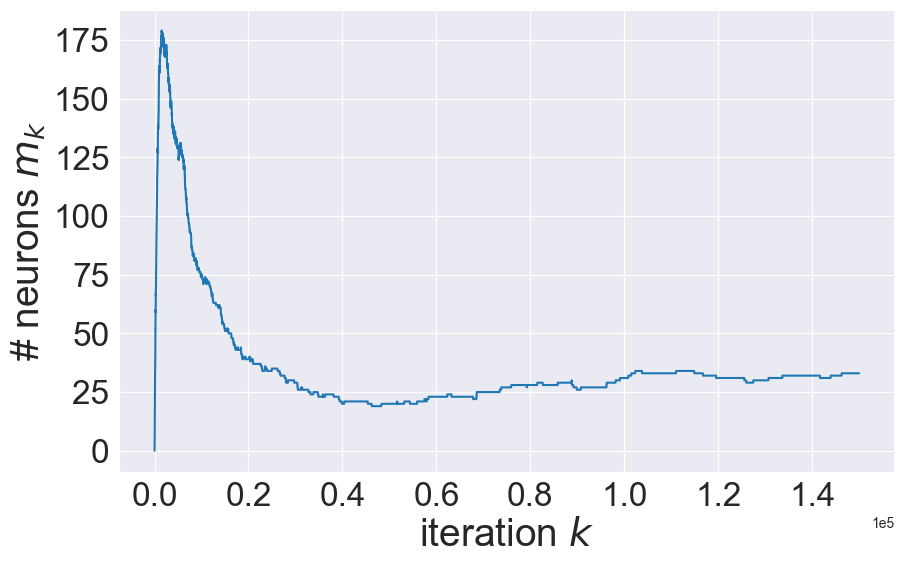

In [42]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

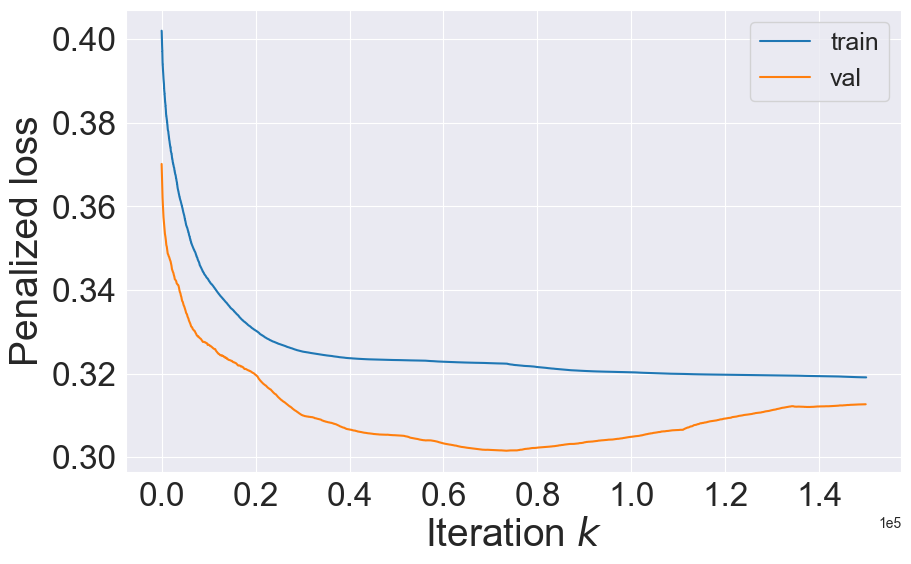

In [43]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

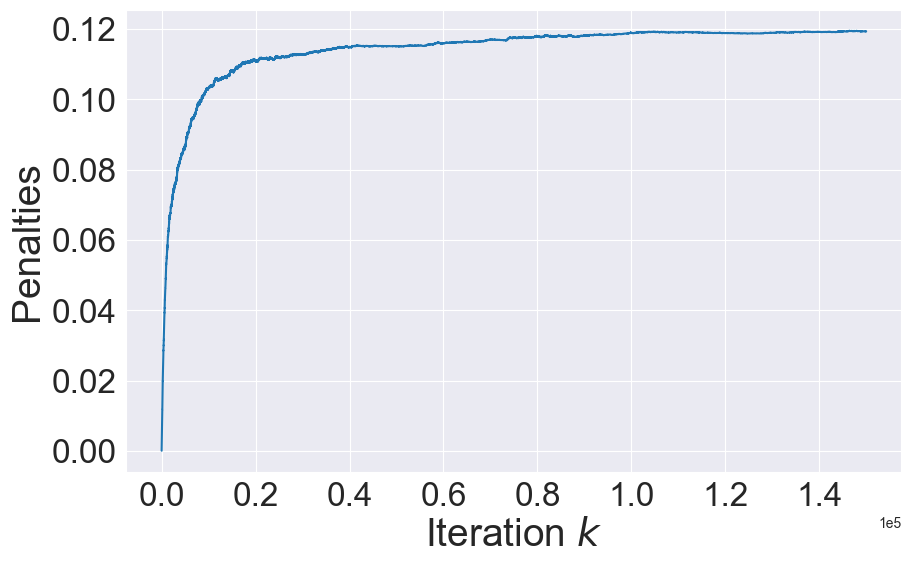

In [44]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_mix - train_losses_mix

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

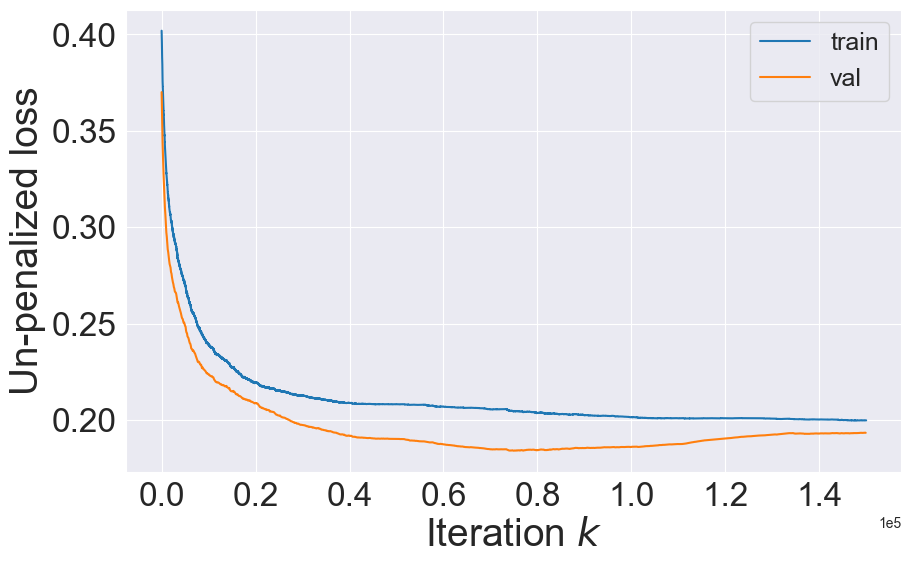

In [45]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_mix)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

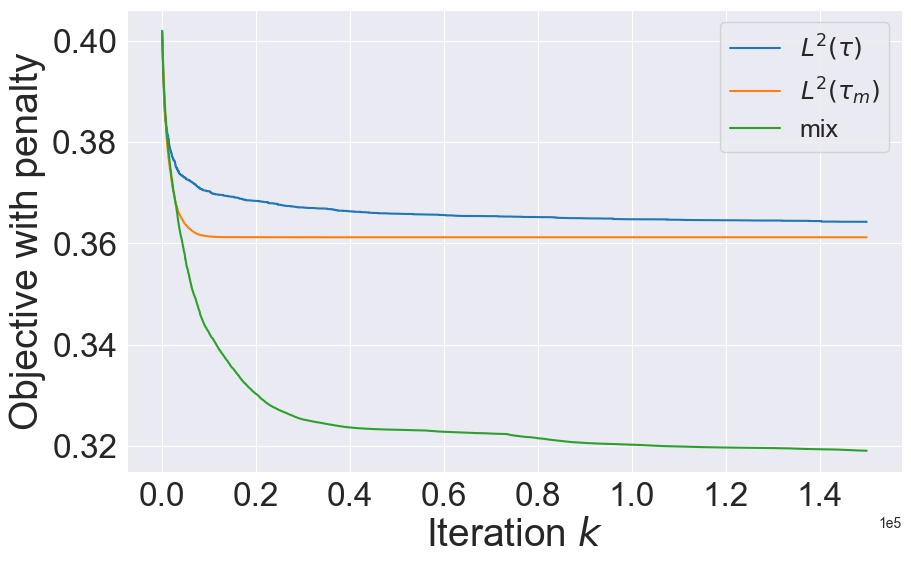

In [46]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='$L^2(\\tau_m)$')
plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='mix')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective with penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_penalty.png'), bbox_inches='tight')
plt.show()

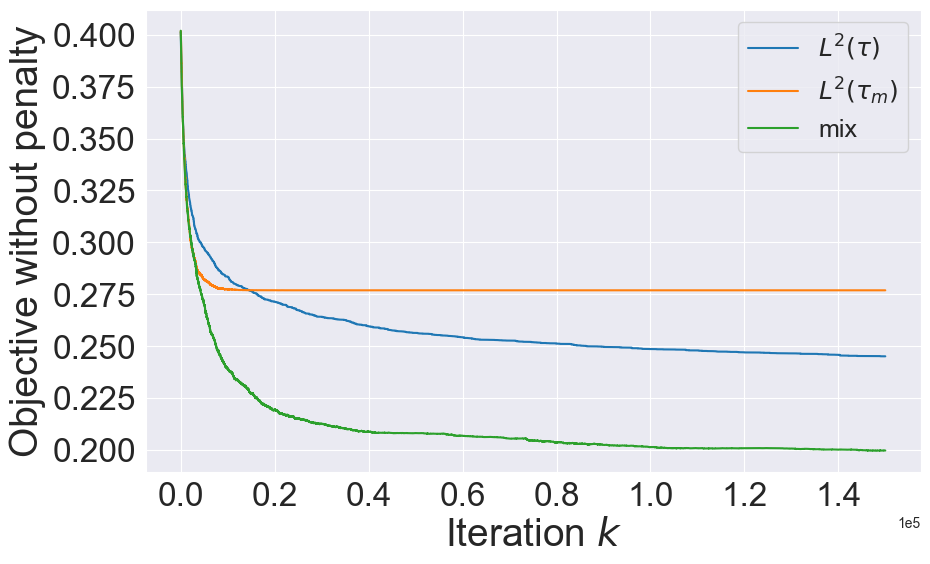

In [47]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='$L^2(\\tau_m)$')
plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='mix')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective without penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_no_penalty.png'), bbox_inches='tight')
plt.show()

## 5. Conic descent algorithm

In [ ]:
n_steps = N_STEPS
m = 500
BETA = 1.0

## 6. Mix $L^2(\tau)/L^2(\tau_m)$ and conic proximal algorithm

Here we mix one step of sampling a new particle and adjusting its weight, one step of chosing an existing particle at random and updating its weight and a final "conic" descent step where we update all particles positions and weights simultaneously.

In [48]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0
ETA = 0.001

In [49]:
a.shape

(1, 33)

In [50]:
b.shape

(33, 50)

In [61]:
V = V_grad(a, b, x_train, y_train, b)
V

array([0.01993928, 0.0198908 , 0.01981039, 0.0198188 , 0.02002866,
       0.02001596, 0.02014886, 0.0199755 , 0.01977187, 0.01975795,
       0.01973304, 0.01986466, 0.02005682, 0.01965615, 0.01984811,
       0.01998534, 0.0199451 , 0.01994588, 0.020033  , 0.01995941,
       0.02014085, 0.02000135, 0.01984989, 0.02002602, 0.02003558,
       0.01990884, 0.01996512, 0.01999724, 0.02012212, 0.02008025,
       0.020263  , 0.02098988, 0.02033478])

In [55]:
y_hat = forward(a, b, x_train)
y_hat.shape

(256, 1)

In [57]:
mat_mul = (y_hat - y_train) * np.maximum(np.matmul(x_train, b.T), 0)
mat_mul.shape

(256, 33)

In [59]:
np.mean(mat_mul, axis=0).shape

(33,)

In [ ]:
y_hat = forward(a, b, x)
if len(new_b.shape) < 2:
    new_b = new_b.reshape(1, -1)
V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)

In [56]:
def conic_particle_update(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1)
        b = b - ETA * nabla_V_grad(a, b, x, y)
    return a, b  

In [40]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 3 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        elif k % 3 == 1:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            a, b = conic_particle_update(a, b, x_train, y_train)
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [41]:
a, b, ms, train_losses_mix, penalized_train_losses_mix, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val)

  0%|▏                                                    | 493/150000 [00:00<00:59, 2527.94it/s]

m at step 0 : 1
Train loss at step 0 : 0.40193
Validation loss at step 0 : 0.37007
m at step 100 : 31
Train loss at step 100 : 0.38955
Validation loss at step 100 : 0.35718
m at step 200 : 56
Train loss at step 200 : 0.37624
Validation loss at step 200 : 0.34387
m at step 300 : 71
Train loss at step 300 : 0.36875
Validation loss at step 300 : 0.33574
m at step 400 : 90
Train loss at step 400 : 0.36091
Validation loss at step 400 : 0.32781


  0%|▎                                                    | 746/150000 [00:00<01:05, 2295.54it/s]

m at step 500 : 105
Train loss at step 500 : 0.35506
Validation loss at step 500 : 0.32212
m at step 600 : 120
Train loss at step 600 : 0.34813
Validation loss at step 600 : 0.31543
m at step 700 : 130
Train loss at step 700 : 0.34211
Validation loss at step 700 : 0.31012
m at step 800 : 139
Train loss at step 800 : 0.33821
Validation loss at step 800 : 0.30642
m at step 900 : 151
Train loss at step 900 : 0.33238
Validation loss at step 900 : 0.30151


  1%|▍                                                   | 1181/150000 [00:00<01:30, 1637.22it/s]

m at step 1,000 : 162
Train loss at step 1,000 : 0.32820
Validation loss at step 1,000 : 0.29736
m at step 1,100 : 164
Train loss at step 1,100 : 0.32546
Validation loss at step 1,100 : 0.29504


  1%|▌                                                   | 1548/150000 [00:00<01:31, 1622.97it/s]

m at step 1,200 : 170
Train loss at step 1,200 : 0.32202
Validation loss at step 1,200 : 0.29186
m at step 1,300 : 170
Train loss at step 1,300 : 0.31829
Validation loss at step 1,300 : 0.28852
m at step 1,400 : 173
Train loss at step 1,400 : 0.31660
Validation loss at step 1,400 : 0.28704
m at step 1,500 : 177
Train loss at step 1,500 : 0.31360
Validation loss at step 1,500 : 0.28472


  1%|▋                                                   | 1877/150000 [00:01<01:37, 1522.48it/s]

m at step 1,600 : 175
Train loss at step 1,600 : 0.31104
Validation loss at step 1,600 : 0.28282
m at step 1,700 : 178
Train loss at step 1,700 : 0.30877
Validation loss at step 1,700 : 0.28093
m at step 1,800 : 176
Train loss at step 1,800 : 0.30730
Validation loss at step 1,800 : 0.27991


  1%|▋                                                   | 2034/150000 [00:01<01:53, 1305.18it/s]

m at step 1,900 : 175
Train loss at step 1,900 : 0.30625
Validation loss at step 1,900 : 0.27904
m at step 2,000 : 172
Train loss at step 2,000 : 0.30349
Validation loss at step 2,000 : 0.27674
m at step 2,100 : 170
Train loss at step 2,100 : 0.30264
Validation loss at step 2,100 : 0.27590


  2%|▊                                                   | 2479/150000 [00:01<01:54, 1287.08it/s]

m at step 2,200 : 169
Train loss at step 2,200 : 0.30080
Validation loss at step 2,200 : 0.27408
m at step 2,300 : 171
Train loss at step 2,300 : 0.29927
Validation loss at step 2,300 : 0.27277
m at step 2,400 : 173
Train loss at step 2,400 : 0.29754
Validation loss at step 2,400 : 0.27141


  2%|▉                                                   | 2813/150000 [00:01<01:45, 1398.27it/s]

m at step 2,500 : 172
Train loss at step 2,500 : 0.29641
Validation loss at step 2,500 : 0.27052
m at step 2,600 : 168
Train loss at step 2,600 : 0.29483
Validation loss at step 2,600 : 0.26899
m at step 2,700 : 165
Train loss at step 2,700 : 0.29393
Validation loss at step 2,700 : 0.26827
m at step 2,800 : 164
Train loss at step 2,800 : 0.29240
Validation loss at step 2,800 : 0.26679


  2%|█                                                   | 3135/150000 [00:02<01:43, 1412.77it/s]

m at step 2,900 : 161
Train loss at step 2,900 : 0.29151
Validation loss at step 2,900 : 0.26630
m at step 3,000 : 159
Train loss at step 3,000 : 0.29110
Validation loss at step 3,000 : 0.26614
m at step 3,100 : 155
Train loss at step 3,100 : 0.28994
Validation loss at step 3,100 : 0.26540
m at step 3,200 : 155
Train loss at step 3,200 : 0.28831
Validation loss at step 3,200 : 0.26392


  2%|█▎                                                  | 3732/150000 [00:02<01:27, 1667.64it/s]

m at step 3,300 : 154
Train loss at step 3,300 : 0.28638
Validation loss at step 3,300 : 0.26247
m at step 3,400 : 148
Train loss at step 3,400 : 0.28410
Validation loss at step 3,400 : 0.26091
m at step 3,500 : 147
Train loss at step 3,500 : 0.28380
Validation loss at step 3,500 : 0.26103
m at step 3,600 : 147
Train loss at step 3,600 : 0.28259
Validation loss at step 3,600 : 0.26010
m at step 3,700 : 144
Train loss at step 3,700 : 0.28124
Validation loss at step 3,700 : 0.25891


  3%|█▍                                                  | 4110/150000 [00:02<01:34, 1551.31it/s]

m at step 3,800 : 138
Train loss at step 3,800 : 0.28044
Validation loss at step 3,800 : 0.25804
m at step 3,900 : 138
Train loss at step 3,900 : 0.27941
Validation loss at step 3,900 : 0.25700
m at step 4,000 : 136
Train loss at step 4,000 : 0.27832
Validation loss at step 4,000 : 0.25609
m at step 4,100 : 137
Train loss at step 4,100 : 0.27785
Validation loss at step 4,100 : 0.25542


  3%|█▌                                                  | 4520/150000 [00:02<01:20, 1800.80it/s]

m at step 4,200 : 133
Train loss at step 4,200 : 0.27664
Validation loss at step 4,200 : 0.25428
m at step 4,300 : 136
Train loss at step 4,300 : 0.27563
Validation loss at step 4,300 : 0.25319
m at step 4,400 : 134
Train loss at step 4,400 : 0.27501
Validation loss at step 4,400 : 0.25260
m at step 4,500 : 131
Train loss at step 4,500 : 0.27441
Validation loss at step 4,500 : 0.25233
m at step 4,600 : 133
Train loss at step 4,600 : 0.27311
Validation loss at step 4,600 : 0.25119


  3%|█▋                                                  | 4916/150000 [00:03<01:22, 1758.53it/s]

m at step 4,700 : 133
Train loss at step 4,700 : 0.27235
Validation loss at step 4,700 : 0.25036
m at step 4,800 : 130
Train loss at step 4,800 : 0.27231
Validation loss at step 4,800 : 0.25051
m at step 4,900 : 130
Train loss at step 4,900 : 0.27106
Validation loss at step 4,900 : 0.24960


  4%|█▊                                                  | 5269/150000 [00:03<01:39, 1454.93it/s]

m at step 5,000 : 130
Train loss at step 5,000 : 0.27010
Validation loss at step 5,000 : 0.24879
m at step 5,100 : 126
Train loss at step 5,100 : 0.26957
Validation loss at step 5,100 : 0.24835
m at step 5,200 : 125
Train loss at step 5,200 : 0.26737
Validation loss at step 5,200 : 0.24635


  4%|█▉                                                  | 5600/150000 [00:03<01:35, 1508.68it/s]

m at step 5,300 : 128
Train loss at step 5,300 : 0.26624
Validation loss at step 5,300 : 0.24529
m at step 5,400 : 131
Train loss at step 5,400 : 0.26580
Validation loss at step 5,400 : 0.24502
m at step 5,500 : 131
Train loss at step 5,500 : 0.26434
Validation loss at step 5,500 : 0.24346
m at step 5,600 : 131
Train loss at step 5,600 : 0.26369
Validation loss at step 5,600 : 0.24294


  4%|██                                                  | 5986/150000 [00:03<01:28, 1629.26it/s]

m at step 5,700 : 126
Train loss at step 5,700 : 0.26321
Validation loss at step 5,700 : 0.24259
m at step 5,800 : 127
Train loss at step 5,800 : 0.26215
Validation loss at step 5,800 : 0.24152
m at step 5,900 : 126
Train loss at step 5,900 : 0.26108
Validation loss at step 5,900 : 0.24063
m at step 6,000 : 126
Train loss at step 6,000 : 0.26018
Validation loss at step 6,000 : 0.23981


  4%|██▏                                                 | 6385/150000 [00:04<01:24, 1697.57it/s]

m at step 6,100 : 124
Train loss at step 6,100 : 0.25975
Validation loss at step 6,100 : 0.23957
m at step 6,200 : 121
Train loss at step 6,200 : 0.25871
Validation loss at step 6,200 : 0.23862
m at step 6,300 : 121
Train loss at step 6,300 : 0.25721
Validation loss at step 6,300 : 0.23717
m at step 6,400 : 119
Train loss at step 6,400 : 0.25665
Validation loss at step 6,400 : 0.23684


  5%|██▎                                                 | 6849/150000 [00:04<01:10, 2025.08it/s]

m at step 6,500 : 113
Train loss at step 6,500 : 0.25629
Validation loss at step 6,500 : 0.23668
m at step 6,600 : 111
Train loss at step 6,600 : 0.25554
Validation loss at step 6,600 : 0.23590
m at step 6,700 : 108
Train loss at step 6,700 : 0.25570
Validation loss at step 6,700 : 0.23613
m at step 6,800 : 106
Train loss at step 6,800 : 0.25532
Validation loss at step 6,800 : 0.23586


  5%|██▌                                                 | 7290/150000 [00:05<02:21, 1010.72it/s]

m at step 6,900 : 103
Train loss at step 6,900 : 0.25466
Validation loss at step 6,900 : 0.23532
m at step 7,000 : 101
Train loss at step 7,000 : 0.25389
Validation loss at step 7,000 : 0.23481
m at step 7,100 : 101
Train loss at step 7,100 : 0.25371
Validation loss at step 7,100 : 0.23459
m at step 7,200 : 99
Train loss at step 7,200 : 0.25284
Validation loss at step 7,200 : 0.23375
m at step 7,300 : 97
Train loss at step 7,300 : 0.25198
Validation loss at step 7,300 : 0.23304


  5%|██▋                                                 | 7697/150000 [00:05<01:51, 1278.75it/s]

m at step 7,400 : 96
Train loss at step 7,400 : 0.25130
Validation loss at step 7,400 : 0.23240
m at step 7,500 : 93
Train loss at step 7,500 : 0.25035
Validation loss at step 7,500 : 0.23162
m at step 7,600 : 93
Train loss at step 7,600 : 0.24962
Validation loss at step 7,600 : 0.23097
m at step 7,700 : 93
Train loss at step 7,700 : 0.24851
Validation loss at step 7,700 : 0.23018


  5%|██▊                                                 | 8135/150000 [00:05<01:35, 1485.14it/s]

m at step 7,800 : 90
Train loss at step 7,800 : 0.24803
Validation loss at step 7,800 : 0.22995
m at step 7,900 : 86
Train loss at step 7,900 : 0.24829
Validation loss at step 7,900 : 0.23023
m at step 8,000 : 86
Train loss at step 8,000 : 0.24788
Validation loss at step 8,000 : 0.23006
m at step 8,100 : 84
Train loss at step 8,100 : 0.24693
Validation loss at step 8,100 : 0.22937
m at step 8,200 : 84
Train loss at step 8,200 : 0.24620
Validation loss at step 8,200 : 0.22883


  6%|██▉                                                 | 8546/150000 [00:05<01:25, 1650.84it/s]

m at step 8,300 : 83
Train loss at step 8,300 : 0.24582
Validation loss at step 8,300 : 0.22864
m at step 8,400 : 83
Train loss at step 8,400 : 0.24581
Validation loss at step 8,400 : 0.22869
m at step 8,500 : 81
Train loss at step 8,500 : 0.24481
Validation loss at step 8,500 : 0.22778
m at step 8,600 : 81
Train loss at step 8,600 : 0.24385
Validation loss at step 8,600 : 0.22691
m at step 8,700 : 82
Train loss at step 8,700 : 0.24424
Validation loss at step 8,700 : 0.22734


  6%|███▏                                                | 9270/150000 [00:06<01:06, 2117.05it/s]

m at step 8,800 : 81
Train loss at step 8,800 : 0.24368
Validation loss at step 8,800 : 0.22687
m at step 8,900 : 80
Train loss at step 8,900 : 0.24292
Validation loss at step 8,900 : 0.22632
m at step 9,000 : 80
Train loss at step 9,000 : 0.24268
Validation loss at step 9,000 : 0.22624
m at step 9,100 : 78
Train loss at step 9,100 : 0.24214
Validation loss at step 9,100 : 0.22596
m at step 9,200 : 77
Train loss at step 9,200 : 0.24191
Validation loss at step 9,200 : 0.22574
m at step 9,300 : 77
Train loss at step 9,300 : 0.24151
Validation loss at step 9,300 : 0.22548


  7%|███▍                                                | 9863/150000 [00:06<00:54, 2562.00it/s]

m at step 9,400 : 77
Train loss at step 9,400 : 0.24103
Validation loss at step 9,400 : 0.22511
m at step 9,500 : 77
Train loss at step 9,500 : 0.24034
Validation loss at step 9,500 : 0.22455
m at step 9,600 : 76
Train loss at step 9,600 : 0.23988
Validation loss at step 9,600 : 0.22421
m at step 9,700 : 76
Train loss at step 9,700 : 0.23996
Validation loss at step 9,700 : 0.22431
m at step 9,800 : 75
Train loss at step 9,800 : 0.23985
Validation loss at step 9,800 : 0.22402
m at step 9,900 : 75
Train loss at step 9,900 : 0.23946
Validation loss at step 9,900 : 0.22384
m at step 10,000 : 74
Train loss at step 10,000 : 0.23901
Validation loss at step 10,000 : 0.22359


  7%|███▌                                               | 10411/150000 [00:06<00:56, 2452.19it/s]

m at step 10,100 : 74
Train loss at step 10,100 : 0.23891
Validation loss at step 10,100 : 0.22359
m at step 10,200 : 73
Train loss at step 10,200 : 0.23834
Validation loss at step 10,200 : 0.22316
m at step 10,300 : 73
Train loss at step 10,300 : 0.23827
Validation loss at step 10,300 : 0.22306
m at step 10,400 : 72
Train loss at step 10,400 : 0.23788
Validation loss at step 10,400 : 0.22278
m at step 10,500 : 72
Train loss at step 10,500 : 0.23767
Validation loss at step 10,500 : 0.22271


  7%|███▋                                               | 10908/150000 [00:06<01:02, 2223.28it/s]

m at step 10,600 : 73
Train loss at step 10,600 : 0.23760
Validation loss at step 10,600 : 0.22264
m at step 10,700 : 73
Train loss at step 10,700 : 0.23773
Validation loss at step 10,700 : 0.22274
m at step 10,800 : 74
Train loss at step 10,800 : 0.23734
Validation loss at step 10,800 : 0.22237
m at step 10,900 : 72
Train loss at step 10,900 : 0.23709
Validation loss at step 10,900 : 0.22219
m at step 11,000 : 71
Train loss at step 11,000 : 0.23701
Validation loss at step 11,000 : 0.22214


  8%|███▉                                               | 11512/150000 [00:07<00:52, 2616.42it/s]

m at step 11,100 : 73
Train loss at step 11,100 : 0.23625
Validation loss at step 11,100 : 0.22146
m at step 11,200 : 72
Train loss at step 11,200 : 0.23552
Validation loss at step 11,200 : 0.22086
m at step 11,300 : 72
Train loss at step 11,300 : 0.23521
Validation loss at step 11,300 : 0.22061
m at step 11,400 : 72
Train loss at step 11,400 : 0.23461
Validation loss at step 11,400 : 0.22020
m at step 11,500 : 72
Train loss at step 11,500 : 0.23432
Validation loss at step 11,500 : 0.21982
m at step 11,600 : 71
Train loss at step 11,600 : 0.23427
Validation loss at step 11,600 : 0.21977


  8%|████                                               | 11780/150000 [00:07<01:15, 1831.29it/s]

m at step 11,700 : 71
Train loss at step 11,700 : 0.23404
Validation loss at step 11,700 : 0.21953
m at step 11,800 : 70
Train loss at step 11,800 : 0.23393
Validation loss at step 11,800 : 0.21946
m at step 11,900 : 70
Train loss at step 11,900 : 0.23402
Validation loss at step 11,900 : 0.21959


  8%|████▏                                              | 12467/150000 [00:07<01:14, 1854.87it/s]

m at step 12,000 : 68
Train loss at step 12,000 : 0.23389
Validation loss at step 12,000 : 0.21943
m at step 12,100 : 67
Train loss at step 12,100 : 0.23384
Validation loss at step 12,100 : 0.21942
m at step 12,200 : 66
Train loss at step 12,200 : 0.23357
Validation loss at step 12,200 : 0.21925
m at step 12,300 : 67
Train loss at step 12,300 : 0.23327
Validation loss at step 12,300 : 0.21898
m at step 12,400 : 64
Train loss at step 12,400 : 0.23310
Validation loss at step 12,400 : 0.21882


  9%|████▍                                              | 12959/150000 [00:07<01:08, 2007.74it/s]

m at step 12,500 : 63
Train loss at step 12,500 : 0.23275
Validation loss at step 12,500 : 0.21854
m at step 12,600 : 63
Train loss at step 12,600 : 0.23256
Validation loss at step 12,600 : 0.21850
m at step 12,700 : 63
Train loss at step 12,700 : 0.23252
Validation loss at step 12,700 : 0.21854
m at step 12,800 : 63
Train loss at step 12,800 : 0.23209
Validation loss at step 12,800 : 0.21818
m at step 12,900 : 63
Train loss at step 12,900 : 0.23185
Validation loss at step 12,900 : 0.21812


  9%|████▌                                              | 13388/150000 [00:08<01:10, 1949.52it/s]

m at step 13,000 : 63
Train loss at step 13,000 : 0.23176
Validation loss at step 13,000 : 0.21800
m at step 13,100 : 62
Train loss at step 13,100 : 0.23179
Validation loss at step 13,100 : 0.21816
m at step 13,200 : 62
Train loss at step 13,200 : 0.23157
Validation loss at step 13,200 : 0.21802
m at step 13,300 : 62
Train loss at step 13,300 : 0.23148
Validation loss at step 13,300 : 0.21788
m at step 13,400 : 62
Train loss at step 13,400 : 0.23105
Validation loss at step 13,400 : 0.21753


  9%|████▋                                              | 13962/150000 [00:08<00:56, 2421.14it/s]

m at step 13,500 : 62
Train loss at step 13,500 : 0.23101
Validation loss at step 13,500 : 0.21756
m at step 13,600 : 62
Train loss at step 13,600 : 0.23063
Validation loss at step 13,600 : 0.21739
m at step 13,700 : 62
Train loss at step 13,700 : 0.23086
Validation loss at step 13,700 : 0.21758
m at step 13,800 : 61
Train loss at step 13,800 : 0.23092
Validation loss at step 13,800 : 0.21767
m at step 13,900 : 61
Train loss at step 13,900 : 0.23034
Validation loss at step 13,900 : 0.21707
m at step 14,000 : 61
Train loss at step 14,000 : 0.23007
Validation loss at step 14,000 : 0.21695
m at step 14,100 : 60
Train loss at step 14,100 : 0.22985
Validation loss at step 14,100 : 0.21678


 10%|████▉                                              | 14460/150000 [00:08<01:01, 2195.36it/s]

m at step 14,200 : 58
Train loss at step 14,200 : 0.22963
Validation loss at step 14,200 : 0.21656
m at step 14,300 : 57
Train loss at step 14,300 : 0.22931
Validation loss at step 14,300 : 0.21634
m at step 14,400 : 55
Train loss at step 14,400 : 0.22950
Validation loss at step 14,400 : 0.21660
m at step 14,500 : 54
Train loss at step 14,500 : 0.22881
Validation loss at step 14,500 : 0.21601


 10%|█████                                              | 14948/150000 [00:08<00:58, 2300.43it/s]

m at step 14,600 : 54
Train loss at step 14,600 : 0.22803
Validation loss at step 14,600 : 0.21539
m at step 14,700 : 54
Train loss at step 14,700 : 0.22771
Validation loss at step 14,700 : 0.21514
m at step 14,800 : 53
Train loss at step 14,800 : 0.22743
Validation loss at step 14,800 : 0.21491
m at step 14,900 : 52
Train loss at step 14,900 : 0.22737
Validation loss at step 14,900 : 0.21491
m at step 15,000 : 51
Train loss at step 15,000 : 0.22731
Validation loss at step 15,000 : 0.21494
m at step 15,100 : 51
Train loss at step 15,100 : 0.22739
Validation loss at step 15,100 : 0.21490
m at step 15,200 : 51
Train loss at step 15,200 : 0.22710
Validation loss at step 15,200 : 0.21468


 11%|█████▍                                             | 15956/150000 [00:09<00:45, 2955.29it/s]

m at step 15,300 : 51
Train loss at step 15,300 : 0.22748
Validation loss at step 15,300 : 0.21507
m at step 15,400 : 52
Train loss at step 15,400 : 0.22694
Validation loss at step 15,400 : 0.21467
m at step 15,500 : 52
Train loss at step 15,500 : 0.22662
Validation loss at step 15,500 : 0.21447
m at step 15,600 : 52
Train loss at step 15,600 : 0.22642
Validation loss at step 15,600 : 0.21431
m at step 15,700 : 51
Train loss at step 15,700 : 0.22599
Validation loss at step 15,700 : 0.21389
m at step 15,800 : 50
Train loss at step 15,800 : 0.22539
Validation loss at step 15,800 : 0.21342
m at step 15,900 : 50
Train loss at step 15,900 : 0.22525
Validation loss at step 15,900 : 0.21334


 11%|█████▋                                             | 16545/150000 [00:09<00:50, 2657.52it/s]

m at step 16,000 : 50
Train loss at step 16,000 : 0.22516
Validation loss at step 16,000 : 0.21323
m at step 16,100 : 50
Train loss at step 16,100 : 0.22538
Validation loss at step 16,100 : 0.21340
m at step 16,200 : 50
Train loss at step 16,200 : 0.22520
Validation loss at step 16,200 : 0.21319
m at step 16,300 : 50
Train loss at step 16,300 : 0.22478
Validation loss at step 16,300 : 0.21280
m at step 16,400 : 48
Train loss at step 16,400 : 0.22453
Validation loss at step 16,400 : 0.21268
m at step 16,500 : 48
Train loss at step 16,500 : 0.22401
Validation loss at step 16,500 : 0.21237


 11%|█████▊                                             | 17155/150000 [00:09<00:53, 2495.39it/s]

m at step 16,600 : 48
Train loss at step 16,600 : 0.22401
Validation loss at step 16,600 : 0.21244
m at step 16,700 : 47
Train loss at step 16,700 : 0.22387
Validation loss at step 16,700 : 0.21238
m at step 16,800 : 46
Train loss at step 16,800 : 0.22363
Validation loss at step 16,800 : 0.21221
m at step 16,900 : 46
Train loss at step 16,900 : 0.22347
Validation loss at step 16,900 : 0.21202
m at step 17,000 : 45
Train loss at step 17,000 : 0.22316
Validation loss at step 17,000 : 0.21181
m at step 17,100 : 45
Train loss at step 17,100 : 0.22266
Validation loss at step 17,100 : 0.21144


 12%|██████                                             | 17779/150000 [00:09<00:50, 2637.52it/s]

m at step 17,200 : 44
Train loss at step 17,200 : 0.22257
Validation loss at step 17,200 : 0.21135
m at step 17,300 : 43
Train loss at step 17,300 : 0.22220
Validation loss at step 17,300 : 0.21101
m at step 17,400 : 43
Train loss at step 17,400 : 0.22218
Validation loss at step 17,400 : 0.21108
m at step 17,500 : 43
Train loss at step 17,500 : 0.22205
Validation loss at step 17,500 : 0.21085
m at step 17,600 : 44
Train loss at step 17,600 : 0.22226
Validation loss at step 17,600 : 0.21099
m at step 17,700 : 44
Train loss at step 17,700 : 0.22199
Validation loss at step 17,700 : 0.21074
m at step 17,800 : 43
Train loss at step 17,800 : 0.22180
Validation loss at step 17,800 : 0.21066


 12%|██████▏                                            | 18327/150000 [00:10<00:51, 2560.51it/s]

m at step 17,900 : 43
Train loss at step 17,900 : 0.22153
Validation loss at step 17,900 : 0.21050
m at step 18,000 : 43
Train loss at step 18,000 : 0.22166
Validation loss at step 18,000 : 0.21066
m at step 18,100 : 43
Train loss at step 18,100 : 0.22146
Validation loss at step 18,100 : 0.21051
m at step 18,200 : 43
Train loss at step 18,200 : 0.22147
Validation loss at step 18,200 : 0.21053
m at step 18,300 : 43
Train loss at step 18,300 : 0.22121
Validation loss at step 18,300 : 0.21033
m at step 18,400 : 43
Train loss at step 18,400 : 0.22084
Validation loss at step 18,400 : 0.21004


 13%|██████▍                                            | 19079/150000 [00:10<00:41, 3174.77it/s]

m at step 18,500 : 41
Train loss at step 18,500 : 0.22093
Validation loss at step 18,500 : 0.21011
m at step 18,600 : 41
Train loss at step 18,600 : 0.22080
Validation loss at step 18,600 : 0.21006
m at step 18,700 : 39
Train loss at step 18,700 : 0.22099
Validation loss at step 18,700 : 0.21023
m at step 18,800 : 40
Train loss at step 18,800 : 0.22067
Validation loss at step 18,800 : 0.20998
m at step 18,900 : 39
Train loss at step 18,900 : 0.22063
Validation loss at step 18,900 : 0.20994
m at step 19,000 : 40
Train loss at step 19,000 : 0.22016
Validation loss at step 19,000 : 0.20955
m at step 19,100 : 40
Train loss at step 19,100 : 0.21999
Validation loss at step 19,100 : 0.20939
m at step 19,200 : 40
Train loss at step 19,200 : 0.22001
Validation loss at step 19,200 : 0.20941


 13%|██████▋                                            | 19847/150000 [00:10<00:37, 3501.95it/s]

m at step 19,300 : 40
Train loss at step 19,300 : 0.21998
Validation loss at step 19,300 : 0.20938
m at step 19,400 : 40
Train loss at step 19,400 : 0.21984
Validation loss at step 19,400 : 0.20923
m at step 19,500 : 39
Train loss at step 19,500 : 0.21956
Validation loss at step 19,500 : 0.20901
m at step 19,600 : 39
Train loss at step 19,600 : 0.21938
Validation loss at step 19,600 : 0.20886
m at step 19,700 : 39
Train loss at step 19,700 : 0.21936
Validation loss at step 19,700 : 0.20882
m at step 19,800 : 39
Train loss at step 19,800 : 0.21919
Validation loss at step 19,800 : 0.20860
m at step 19,900 : 39
Train loss at step 19,900 : 0.21934
Validation loss at step 19,900 : 0.20875


 14%|██████▉                                            | 20574/150000 [00:10<00:41, 3145.52it/s]

m at step 20,000 : 39
Train loss at step 20,000 : 0.21949
Validation loss at step 20,000 : 0.20886
m at step 20,100 : 39
Train loss at step 20,100 : 0.21944
Validation loss at step 20,100 : 0.20879
m at step 20,200 : 40
Train loss at step 20,200 : 0.21914
Validation loss at step 20,200 : 0.20853
m at step 20,300 : 40
Train loss at step 20,300 : 0.21931
Validation loss at step 20,300 : 0.20863
m at step 20,400 : 38
Train loss at step 20,400 : 0.21920
Validation loss at step 20,400 : 0.20850
m at step 20,500 : 39
Train loss at step 20,500 : 0.21909
Validation loss at step 20,500 : 0.20829
m at step 20,600 : 39
Train loss at step 20,600 : 0.21874
Validation loss at step 20,600 : 0.20784


 14%|███████▏                                           | 21303/150000 [00:10<00:38, 3360.37it/s]

m at step 20,700 : 39
Train loss at step 20,700 : 0.21867
Validation loss at step 20,700 : 0.20762
m at step 20,800 : 39
Train loss at step 20,800 : 0.21825
Validation loss at step 20,800 : 0.20724
m at step 20,900 : 39
Train loss at step 20,900 : 0.21784
Validation loss at step 20,900 : 0.20678
m at step 21,000 : 37
Train loss at step 21,000 : 0.21790
Validation loss at step 21,000 : 0.20682
m at step 21,100 : 37
Train loss at step 21,100 : 0.21773
Validation loss at step 21,100 : 0.20657
m at step 21,200 : 37
Train loss at step 21,200 : 0.21755
Validation loss at step 21,200 : 0.20639
m at step 21,300 : 37
Train loss at step 21,300 : 0.21755
Validation loss at step 21,300 : 0.20627
m at step 21,400 : 37
Train loss at step 21,400 : 0.21768
Validation loss at step 21,400 : 0.20638
m at step 21,500 : 37
Train loss at step 21,500 : 0.21742
Validation loss at step 21,500 : 0.20607


 15%|███████▍                                           | 21993/150000 [00:11<00:42, 3042.63it/s]

m at step 21,600 : 37
Train loss at step 21,600 : 0.21751
Validation loss at step 21,600 : 0.20612
m at step 21,700 : 37
Train loss at step 21,700 : 0.21739
Validation loss at step 21,700 : 0.20597
m at step 21,800 : 37
Train loss at step 21,800 : 0.21727
Validation loss at step 21,800 : 0.20582
m at step 21,900 : 37
Train loss at step 21,900 : 0.21724
Validation loss at step 21,900 : 0.20578
m at step 22,000 : 37
Train loss at step 22,000 : 0.21703
Validation loss at step 22,000 : 0.20558
m at step 22,100 : 37
Train loss at step 22,100 : 0.21702
Validation loss at step 22,100 : 0.20558


 15%|███████▌                                           | 22308/150000 [00:11<00:42, 3001.39it/s]

m at step 22,200 : 37
Train loss at step 22,200 : 0.21708
Validation loss at step 22,200 : 0.20564
m at step 22,300 : 37
Train loss at step 22,300 : 0.21676
Validation loss at step 22,300 : 0.20530
m at step 22,400 : 37
Train loss at step 22,400 : 0.21664
Validation loss at step 22,400 : 0.20511
m at step 22,500 : 37
Train loss at step 22,500 : 0.21693
Validation loss at step 22,500 : 0.20531
m at step 22,600 : 37
Train loss at step 22,600 : 0.21691
Validation loss at step 22,600 : 0.20525


 15%|███████▉                                           | 23211/150000 [00:11<00:46, 2715.79it/s]

m at step 22,700 : 36
Train loss at step 22,700 : 0.21692
Validation loss at step 22,700 : 0.20523
m at step 22,800 : 36
Train loss at step 22,800 : 0.21686
Validation loss at step 22,800 : 0.20512
m at step 22,900 : 35
Train loss at step 22,900 : 0.21680
Validation loss at step 22,900 : 0.20506
m at step 23,000 : 34
Train loss at step 23,000 : 0.21613
Validation loss at step 23,000 : 0.20439
m at step 23,100 : 34
Train loss at step 23,100 : 0.21624
Validation loss at step 23,100 : 0.20449
m at step 23,200 : 34
Train loss at step 23,200 : 0.21613
Validation loss at step 23,200 : 0.20438
m at step 23,300 : 34
Train loss at step 23,300 : 0.21625
Validation loss at step 23,300 : 0.20444


 16%|████████                                           | 23853/150000 [00:11<00:44, 2804.51it/s]

m at step 23,400 : 34
Train loss at step 23,400 : 0.21614
Validation loss at step 23,400 : 0.20425
m at step 23,500 : 35
Train loss at step 23,500 : 0.21620
Validation loss at step 23,500 : 0.20424
m at step 23,600 : 35
Train loss at step 23,600 : 0.21633
Validation loss at step 23,600 : 0.20427
m at step 23,700 : 35
Train loss at step 23,700 : 0.21620
Validation loss at step 23,700 : 0.20412
m at step 23,800 : 35
Train loss at step 23,800 : 0.21634
Validation loss at step 23,800 : 0.20416
m at step 23,900 : 35
Train loss at step 23,900 : 0.21629
Validation loss at step 23,900 : 0.20406
m at step 24,000 : 34
Train loss at step 24,000 : 0.21611
Validation loss at step 24,000 : 0.20380


 16%|████████▎                                          | 24563/150000 [00:12<00:41, 3030.82it/s]

m at step 24,100 : 34
Train loss at step 24,100 : 0.21591
Validation loss at step 24,100 : 0.20356
m at step 24,200 : 34
Train loss at step 24,200 : 0.21558
Validation loss at step 24,200 : 0.20321
m at step 24,300 : 34
Train loss at step 24,300 : 0.21536
Validation loss at step 24,300 : 0.20298
m at step 24,400 : 34
Train loss at step 24,400 : 0.21520
Validation loss at step 24,400 : 0.20274
m at step 24,500 : 34
Train loss at step 24,500 : 0.21522
Validation loss at step 24,500 : 0.20271
m at step 24,600 : 34
Train loss at step 24,600 : 0.21530
Validation loss at step 24,600 : 0.20270
m at step 24,700 : 34
Train loss at step 24,700 : 0.21519
Validation loss at step 24,700 : 0.20246
m at step 24,800 : 34
Train loss at step 24,800 : 0.21514
Validation loss at step 24,800 : 0.20235
m at step 24,900 : 34
Train loss at step 24,900 : 0.21513
Validation loss at step 24,900 : 0.20228


 17%|████████▊                                          | 25783/150000 [00:12<00:33, 3700.62it/s]

m at step 25,000 : 35
Train loss at step 25,000 : 0.21523
Validation loss at step 25,000 : 0.20232
m at step 25,100 : 35
Train loss at step 25,100 : 0.21527
Validation loss at step 25,100 : 0.20227
m at step 25,200 : 35
Train loss at step 25,200 : 0.21537
Validation loss at step 25,200 : 0.20230
m at step 25,300 : 35
Train loss at step 25,300 : 0.21506
Validation loss at step 25,300 : 0.20195
m at step 25,400 : 35
Train loss at step 25,400 : 0.21492
Validation loss at step 25,400 : 0.20175
m at step 25,500 : 35
Train loss at step 25,500 : 0.21483
Validation loss at step 25,500 : 0.20160
m at step 25,600 : 35
Train loss at step 25,600 : 0.21471
Validation loss at step 25,600 : 0.20147
m at step 25,700 : 35
Train loss at step 25,700 : 0.21467
Validation loss at step 25,700 : 0.20136
m at step 25,800 : 35
Train loss at step 25,800 : 0.21474
Validation loss at step 25,800 : 0.20137


 18%|█████████                                          | 26505/150000 [00:12<00:37, 3314.08it/s]

m at step 25,900 : 35
Train loss at step 25,900 : 0.21462
Validation loss at step 25,900 : 0.20124
m at step 26,000 : 35
Train loss at step 26,000 : 0.21468
Validation loss at step 26,000 : 0.20124
m at step 26,100 : 35
Train loss at step 26,100 : 0.21466
Validation loss at step 26,100 : 0.20121
m at step 26,200 : 34
Train loss at step 26,200 : 0.21468
Validation loss at step 26,200 : 0.20117
m at step 26,300 : 34
Train loss at step 26,300 : 0.21457
Validation loss at step 26,300 : 0.20102
m at step 26,400 : 34
Train loss at step 26,400 : 0.21447
Validation loss at step 26,400 : 0.20088
m at step 26,500 : 34
Train loss at step 26,500 : 0.21432
Validation loss at step 26,500 : 0.20067


 18%|█████████▎                                         | 27301/150000 [00:12<00:34, 3543.47it/s]

m at step 26,600 : 34
Train loss at step 26,600 : 0.21437
Validation loss at step 26,600 : 0.20064
m at step 26,700 : 33
Train loss at step 26,700 : 0.21422
Validation loss at step 26,700 : 0.20048
m at step 26,800 : 32
Train loss at step 26,800 : 0.21433
Validation loss at step 26,800 : 0.20049
m at step 26,900 : 32
Train loss at step 26,900 : 0.21409
Validation loss at step 26,900 : 0.20021
m at step 27,000 : 32
Train loss at step 27,000 : 0.21413
Validation loss at step 27,000 : 0.20019
m at step 27,100 : 32
Train loss at step 27,100 : 0.21405
Validation loss at step 27,100 : 0.20003
m at step 27,200 : 32
Train loss at step 27,200 : 0.21395
Validation loss at step 27,200 : 0.19991
m at step 27,300 : 32
Train loss at step 27,300 : 0.21387
Validation loss at step 27,300 : 0.19980


 19%|█████████▌                                         | 28095/150000 [00:13<00:34, 3561.33it/s]

m at step 27,400 : 32
Train loss at step 27,400 : 0.21363
Validation loss at step 27,400 : 0.19958
m at step 27,500 : 32
Train loss at step 27,500 : 0.21348
Validation loss at step 27,500 : 0.19938
m at step 27,600 : 32
Train loss at step 27,600 : 0.21351
Validation loss at step 27,600 : 0.19934
m at step 27,700 : 31
Train loss at step 27,700 : 0.21350
Validation loss at step 27,700 : 0.19928
m at step 27,800 : 31
Train loss at step 27,800 : 0.21344
Validation loss at step 27,800 : 0.19912
m at step 27,900 : 31
Train loss at step 27,900 : 0.21337
Validation loss at step 27,900 : 0.19901
m at step 28,000 : 29
Train loss at step 28,000 : 0.21331
Validation loss at step 28,000 : 0.19890
m at step 28,100 : 29
Train loss at step 28,100 : 0.21330
Validation loss at step 28,100 : 0.19884


 19%|█████████▊                                         | 28792/150000 [00:13<00:41, 2946.14it/s]

m at step 28,200 : 29
Train loss at step 28,200 : 0.21327
Validation loss at step 28,200 : 0.19875
m at step 28,300 : 29
Train loss at step 28,300 : 0.21299
Validation loss at step 28,300 : 0.19846
m at step 28,400 : 30
Train loss at step 28,400 : 0.21312
Validation loss at step 28,400 : 0.19854
m at step 28,500 : 30
Train loss at step 28,500 : 0.21305
Validation loss at step 28,500 : 0.19846
m at step 28,600 : 30
Train loss at step 28,600 : 0.21311
Validation loss at step 28,600 : 0.19848
m at step 28,700 : 30
Train loss at step 28,700 : 0.21302
Validation loss at step 28,700 : 0.19836


 19%|█████████▉                                         | 29097/150000 [00:13<00:43, 2773.57it/s]

m at step 28,800 : 30
Train loss at step 28,800 : 0.21280
Validation loss at step 28,800 : 0.19808
m at step 28,900 : 30
Train loss at step 28,900 : 0.21281
Validation loss at step 28,900 : 0.19804
m at step 29,000 : 30
Train loss at step 29,000 : 0.21291
Validation loss at step 29,000 : 0.19811
m at step 29,100 : 30
Train loss at step 29,100 : 0.21296
Validation loss at step 29,100 : 0.19808
m at step 29,200 : 30
Train loss at step 29,200 : 0.21285
Validation loss at step 29,200 : 0.19795
m at step 29,300 : 30
Train loss at step 29,300 : 0.21272
Validation loss at step 29,300 : 0.19775
m at step 29,400 : 30
Train loss at step 29,400 : 0.21267
Validation loss at step 29,400 : 0.19767


 20%|██████████▏                                        | 30110/150000 [00:13<00:40, 2947.80it/s]

m at step 29,500 : 30
Train loss at step 29,500 : 0.21269
Validation loss at step 29,500 : 0.19764
m at step 29,600 : 30
Train loss at step 29,600 : 0.21255
Validation loss at step 29,600 : 0.19746
m at step 29,700 : 29
Train loss at step 29,700 : 0.21267
Validation loss at step 29,700 : 0.19753
m at step 29,800 : 29
Train loss at step 29,800 : 0.21266
Validation loss at step 29,800 : 0.19747
m at step 29,900 : 29
Train loss at step 29,900 : 0.21258
Validation loss at step 29,900 : 0.19738
m at step 30,000 : 29
Train loss at step 30,000 : 0.21265
Validation loss at step 30,000 : 0.19739
m at step 30,100 : 29
Train loss at step 30,100 : 0.21258
Validation loss at step 30,100 : 0.19733


 21%|██████████▍                                        | 30786/150000 [00:14<00:40, 2955.58it/s]

m at step 30,200 : 29
Train loss at step 30,200 : 0.21258
Validation loss at step 30,200 : 0.19731
m at step 30,300 : 29
Train loss at step 30,300 : 0.21258
Validation loss at step 30,300 : 0.19728
m at step 30,400 : 28
Train loss at step 30,400 : 0.21257
Validation loss at step 30,400 : 0.19724
m at step 30,500 : 26
Train loss at step 30,500 : 0.21246
Validation loss at step 30,500 : 0.19713
m at step 30,600 : 26
Train loss at step 30,600 : 0.21246
Validation loss at step 30,600 : 0.19713
m at step 30,700 : 26
Train loss at step 30,700 : 0.21238
Validation loss at step 30,700 : 0.19704
m at step 30,800 : 26
Train loss at step 30,800 : 0.21214
Validation loss at step 30,800 : 0.19681


 21%|██████████▋                                        | 31587/150000 [00:14<00:33, 3487.15it/s]

m at step 30,900 : 26
Train loss at step 30,900 : 0.21222
Validation loss at step 30,900 : 0.19688
m at step 31,000 : 26
Train loss at step 31,000 : 0.21210
Validation loss at step 31,000 : 0.19674
m at step 31,100 : 26
Train loss at step 31,100 : 0.21208
Validation loss at step 31,100 : 0.19673
m at step 31,200 : 27
Train loss at step 31,200 : 0.21186
Validation loss at step 31,200 : 0.19654
m at step 31,300 : 27
Train loss at step 31,300 : 0.21193
Validation loss at step 31,300 : 0.19657
m at step 31,400 : 27
Train loss at step 31,400 : 0.21171
Validation loss at step 31,400 : 0.19638
m at step 31,500 : 26
Train loss at step 31,500 : 0.21179
Validation loss at step 31,500 : 0.19646
m at step 31,600 : 26
Train loss at step 31,600 : 0.21170
Validation loss at step 31,600 : 0.19640
m at step 31,700 : 26
Train loss at step 31,700 : 0.21175
Validation loss at step 31,700 : 0.19642


 22%|███████████                                        | 32372/150000 [00:14<00:32, 3659.75it/s]

m at step 31,800 : 26
Train loss at step 31,800 : 0.21174
Validation loss at step 31,800 : 0.19641
m at step 31,900 : 26
Train loss at step 31,900 : 0.21164
Validation loss at step 31,900 : 0.19632
m at step 32,000 : 26
Train loss at step 32,000 : 0.21151
Validation loss at step 32,000 : 0.19622
m at step 32,100 : 26
Train loss at step 32,100 : 0.21155
Validation loss at step 32,100 : 0.19625
m at step 32,200 : 26
Train loss at step 32,200 : 0.21132
Validation loss at step 32,200 : 0.19600
m at step 32,300 : 26
Train loss at step 32,300 : 0.21143
Validation loss at step 32,300 : 0.19608
m at step 32,400 : 26
Train loss at step 32,400 : 0.21135
Validation loss at step 32,400 : 0.19601
m at step 32,500 : 26
Train loss at step 32,500 : 0.21130
Validation loss at step 32,500 : 0.19593


 22%|███████████▎                                       | 33155/150000 [00:14<00:33, 3501.10it/s]

m at step 32,600 : 26
Train loss at step 32,600 : 0.21125
Validation loss at step 32,600 : 0.19582
m at step 32,700 : 26
Train loss at step 32,700 : 0.21128
Validation loss at step 32,700 : 0.19585
m at step 32,800 : 25
Train loss at step 32,800 : 0.21118
Validation loss at step 32,800 : 0.19575
m at step 32,900 : 25
Train loss at step 32,900 : 0.21112
Validation loss at step 32,900 : 0.19567
m at step 33,000 : 25
Train loss at step 33,000 : 0.21104
Validation loss at step 33,000 : 0.19559
m at step 33,100 : 25
Train loss at step 33,100 : 0.21122
Validation loss at step 33,100 : 0.19574
m at step 33,200 : 24
Train loss at step 33,200 : 0.21130
Validation loss at step 33,200 : 0.19579
m at step 33,300 : 24
Train loss at step 33,300 : 0.21127
Validation loss at step 33,300 : 0.19573
m at step 33,400 : 24
Train loss at step 33,400 : 0.21133
Validation loss at step 33,400 : 0.19580


 23%|███████████▌                                       | 34004/150000 [00:14<00:29, 3888.87it/s]

m at step 33,500 : 24
Train loss at step 33,500 : 0.21110
Validation loss at step 33,500 : 0.19556
m at step 33,600 : 24
Train loss at step 33,600 : 0.21093
Validation loss at step 33,600 : 0.19539
m at step 33,700 : 24
Train loss at step 33,700 : 0.21100
Validation loss at step 33,700 : 0.19544
m at step 33,800 : 24
Train loss at step 33,800 : 0.21098
Validation loss at step 33,800 : 0.19539
m at step 33,900 : 25
Train loss at step 33,900 : 0.21080
Validation loss at step 33,900 : 0.19522
m at step 34,000 : 25
Train loss at step 34,000 : 0.21060
Validation loss at step 34,000 : 0.19497
m at step 34,100 : 25
Train loss at step 34,100 : 0.21067
Validation loss at step 34,100 : 0.19500
m at step 34,200 : 25
Train loss at step 34,200 : 0.21071
Validation loss at step 34,200 : 0.19499
m at step 34,300 : 25
Train loss at step 34,300 : 0.21063
Validation loss at step 34,300 : 0.19491
m at step 34,400 : 25
Train loss at step 34,400 : 0.21068
Validation loss at step 34,400 : 0.19491


 23%|███████████▊                                       | 34835/150000 [00:15<00:33, 3456.96it/s]

m at step 34,500 : 25
Train loss at step 34,500 : 0.21056
Validation loss at step 34,500 : 0.19476
m at step 34,600 : 25
Train loss at step 34,600 : 0.21053
Validation loss at step 34,600 : 0.19471
m at step 34,700 : 25
Train loss at step 34,700 : 0.21050
Validation loss at step 34,700 : 0.19470
m at step 34,800 : 24
Train loss at step 34,800 : 0.21055
Validation loss at step 34,800 : 0.19471
m at step 34,900 : 23
Train loss at step 34,900 : 0.21044
Validation loss at step 34,900 : 0.19457
m at step 35,000 : 23
Train loss at step 35,000 : 0.21040
Validation loss at step 35,000 : 0.19453
m at step 35,100 : 23
Train loss at step 35,100 : 0.21022
Validation loss at step 35,100 : 0.19435


 24%|████████████                                       | 35542/150000 [00:15<00:40, 2822.65it/s]

m at step 35,200 : 23
Train loss at step 35,200 : 0.21033
Validation loss at step 35,200 : 0.19444
m at step 35,300 : 23
Train loss at step 35,300 : 0.21024
Validation loss at step 35,300 : 0.19434
m at step 35,400 : 23
Train loss at step 35,400 : 0.21005
Validation loss at step 35,400 : 0.19415
m at step 35,500 : 23
Train loss at step 35,500 : 0.21015
Validation loss at step 35,500 : 0.19421
m at step 35,600 : 23
Train loss at step 35,600 : 0.21011
Validation loss at step 35,600 : 0.19417
m at step 35,700 : 23
Train loss at step 35,700 : 0.21007
Validation loss at step 35,700 : 0.19413


 24%|████████████▎                                      | 36189/150000 [00:15<00:39, 2903.81it/s]

m at step 35,800 : 24
Train loss at step 35,800 : 0.21018
Validation loss at step 35,800 : 0.19420
m at step 35,900 : 23
Train loss at step 35,900 : 0.21023
Validation loss at step 35,900 : 0.19424
m at step 36,000 : 23
Train loss at step 36,000 : 0.21012
Validation loss at step 36,000 : 0.19413
m at step 36,100 : 23
Train loss at step 36,100 : 0.21000
Validation loss at step 36,100 : 0.19401
m at step 36,200 : 23
Train loss at step 36,200 : 0.20994
Validation loss at step 36,200 : 0.19394
m at step 36,300 : 23
Train loss at step 36,300 : 0.20990
Validation loss at step 36,300 : 0.19389


 25%|████████████▌                                      | 36872/150000 [00:15<00:36, 3126.88it/s]

m at step 36,400 : 24
Train loss at step 36,400 : 0.20975
Validation loss at step 36,400 : 0.19372
m at step 36,500 : 24
Train loss at step 36,500 : 0.20971
Validation loss at step 36,500 : 0.19365
m at step 36,600 : 24
Train loss at step 36,600 : 0.20964
Validation loss at step 36,600 : 0.19353
m at step 36,700 : 24
Train loss at step 36,700 : 0.20959
Validation loss at step 36,700 : 0.19349
m at step 36,800 : 24
Train loss at step 36,800 : 0.20961
Validation loss at step 36,800 : 0.19350
m at step 36,900 : 24
Train loss at step 36,900 : 0.20958
Validation loss at step 36,900 : 0.19343
m at step 37,000 : 24
Train loss at step 37,000 : 0.20959
Validation loss at step 37,000 : 0.19343


 25%|████████████▊                                      | 37664/150000 [00:16<00:32, 3422.48it/s]

m at step 37,100 : 24
Train loss at step 37,100 : 0.20957
Validation loss at step 37,100 : 0.19340
m at step 37,200 : 24
Train loss at step 37,200 : 0.20958
Validation loss at step 37,200 : 0.19337
m at step 37,300 : 24
Train loss at step 37,300 : 0.20948
Validation loss at step 37,300 : 0.19323
m at step 37,400 : 24
Train loss at step 37,400 : 0.20935
Validation loss at step 37,400 : 0.19306
m at step 37,500 : 24
Train loss at step 37,500 : 0.20938
Validation loss at step 37,500 : 0.19307
m at step 37,600 : 24
Train loss at step 37,600 : 0.20929
Validation loss at step 37,600 : 0.19294
m at step 37,700 : 24
Train loss at step 37,700 : 0.20925
Validation loss at step 37,700 : 0.19285
m at step 37,800 : 24
Train loss at step 37,800 : 0.20906
Validation loss at step 37,800 : 0.19264
m at step 37,900 : 24
Train loss at step 37,900 : 0.20909
Validation loss at step 37,900 : 0.19261


 26%|█████████████                                      | 38509/150000 [00:16<00:28, 3852.81it/s]

m at step 38,000 : 24
Train loss at step 38,000 : 0.20908
Validation loss at step 38,000 : 0.19255
m at step 38,100 : 24
Train loss at step 38,100 : 0.20908
Validation loss at step 38,100 : 0.19253
m at step 38,200 : 23
Train loss at step 38,200 : 0.20904
Validation loss at step 38,200 : 0.19245
m at step 38,300 : 23
Train loss at step 38,300 : 0.20916
Validation loss at step 38,300 : 0.19254
m at step 38,400 : 23
Train loss at step 38,400 : 0.20918
Validation loss at step 38,400 : 0.19252
m at step 38,500 : 23
Train loss at step 38,500 : 0.20926
Validation loss at step 38,500 : 0.19255
m at step 38,600 : 23
Train loss at step 38,600 : 0.20918
Validation loss at step 38,600 : 0.19245
m at step 38,700 : 23
Train loss at step 38,700 : 0.20912
Validation loss at step 38,700 : 0.19238
m at step 38,800 : 23
Train loss at step 38,800 : 0.20902
Validation loss at step 38,800 : 0.19226
m at step 38,900 : 23
Train loss at step 38,900 : 0.20912
Validation loss at step 38,900 : 0.19237


 26%|█████████████▍                                     | 39379/150000 [00:16<00:30, 3581.05it/s]

m at step 39,000 : 23
Train loss at step 39,000 : 0.20890
Validation loss at step 39,000 : 0.19209
m at step 39,100 : 23
Train loss at step 39,100 : 0.20888
Validation loss at step 39,100 : 0.19201
m at step 39,200 : 23
Train loss at step 39,200 : 0.20886
Validation loss at step 39,200 : 0.19197
m at step 39,300 : 22
Train loss at step 39,300 : 0.20874
Validation loss at step 39,300 : 0.19178
m at step 39,400 : 21
Train loss at step 39,400 : 0.20880
Validation loss at step 39,400 : 0.19181
m at step 39,500 : 21
Train loss at step 39,500 : 0.20883
Validation loss at step 39,500 : 0.19183
m at step 39,600 : 21
Train loss at step 39,600 : 0.20879
Validation loss at step 39,600 : 0.19177


 27%|█████████████▋                                     | 40176/150000 [00:16<00:29, 3726.90it/s]

m at step 39,700 : 21
Train loss at step 39,700 : 0.20886
Validation loss at step 39,700 : 0.19184
m at step 39,800 : 21
Train loss at step 39,800 : 0.20897
Validation loss at step 39,800 : 0.19195
m at step 39,900 : 20
Train loss at step 39,900 : 0.20892
Validation loss at step 39,900 : 0.19189
m at step 40,000 : 20
Train loss at step 40,000 : 0.20879
Validation loss at step 40,000 : 0.19173
m at step 40,100 : 20
Train loss at step 40,100 : 0.20886
Validation loss at step 40,100 : 0.19179
m at step 40,200 : 20
Train loss at step 40,200 : 0.20877
Validation loss at step 40,200 : 0.19169
m at step 40,300 : 20
Train loss at step 40,300 : 0.20886
Validation loss at step 40,300 : 0.19178
m at step 40,400 : 21
Train loss at step 40,400 : 0.20886
Validation loss at step 40,400 : 0.19175
m at step 40,500 : 21
Train loss at step 40,500 : 0.20875
Validation loss at step 40,500 : 0.19161


 27%|█████████████▉                                     | 41014/150000 [00:17<00:27, 3952.81it/s]

m at step 40,600 : 21
Train loss at step 40,600 : 0.20855
Validation loss at step 40,600 : 0.19138
m at step 40,700 : 21
Train loss at step 40,700 : 0.20847
Validation loss at step 40,700 : 0.19128
m at step 40,800 : 21
Train loss at step 40,800 : 0.20851
Validation loss at step 40,800 : 0.19130
m at step 40,900 : 21
Train loss at step 40,900 : 0.20848
Validation loss at step 40,900 : 0.19127
m at step 41,000 : 21
Train loss at step 41,000 : 0.20851
Validation loss at step 41,000 : 0.19130
m at step 41,100 : 21
Train loss at step 41,100 : 0.20844
Validation loss at step 41,100 : 0.19123
m at step 41,200 : 21
Train loss at step 41,200 : 0.20851
Validation loss at step 41,200 : 0.19128
m at step 41,300 : 21
Train loss at step 41,300 : 0.20841
Validation loss at step 41,300 : 0.19114
m at step 41,400 : 21
Train loss at step 41,400 : 0.20842
Validation loss at step 41,400 : 0.19112


 28%|██████████████▏                                    | 41803/150000 [00:17<00:30, 3530.89it/s]

m at step 41,500 : 21
Train loss at step 41,500 : 0.20831
Validation loss at step 41,500 : 0.19100
m at step 41,600 : 21
Train loss at step 41,600 : 0.20832
Validation loss at step 41,600 : 0.19099
m at step 41,700 : 21
Train loss at step 41,700 : 0.20830
Validation loss at step 41,700 : 0.19092
m at step 41,800 : 21
Train loss at step 41,800 : 0.20827
Validation loss at step 41,800 : 0.19087
m at step 41,900 : 21
Train loss at step 41,900 : 0.20836
Validation loss at step 41,900 : 0.19095
m at step 42,000 : 21
Train loss at step 42,000 : 0.20832
Validation loss at step 42,000 : 0.19090
m at step 42,100 : 21
Train loss at step 42,100 : 0.20832
Validation loss at step 42,100 : 0.19089


 29%|██████████████▌                                    | 42855/150000 [00:17<00:34, 3078.11it/s]

m at step 42,200 : 21
Train loss at step 42,200 : 0.20836
Validation loss at step 42,200 : 0.19090
m at step 42,300 : 21
Train loss at step 42,300 : 0.20833
Validation loss at step 42,300 : 0.19086
m at step 42,400 : 21
Train loss at step 42,400 : 0.20831
Validation loss at step 42,400 : 0.19084
m at step 42,500 : 21
Train loss at step 42,500 : 0.20839
Validation loss at step 42,500 : 0.19090
m at step 42,600 : 21
Train loss at step 42,600 : 0.20840
Validation loss at step 42,600 : 0.19090
m at step 42,700 : 21
Train loss at step 42,700 : 0.20836
Validation loss at step 42,700 : 0.19084
m at step 42,800 : 21
Train loss at step 42,800 : 0.20837
Validation loss at step 42,800 : 0.19085


 29%|██████████████▊                                    | 43593/150000 [00:17<00:34, 3119.77it/s]

m at step 42,900 : 21
Train loss at step 42,900 : 0.20838
Validation loss at step 42,900 : 0.19084
m at step 43,000 : 21
Train loss at step 43,000 : 0.20832
Validation loss at step 43,000 : 0.19074
m at step 43,100 : 21
Train loss at step 43,100 : 0.20836
Validation loss at step 43,100 : 0.19077
m at step 43,200 : 21
Train loss at step 43,200 : 0.20838
Validation loss at step 43,200 : 0.19077
m at step 43,300 : 21
Train loss at step 43,300 : 0.20835
Validation loss at step 43,300 : 0.19074
m at step 43,400 : 21
Train loss at step 43,400 : 0.20832
Validation loss at step 43,400 : 0.19071
m at step 43,500 : 21
Train loss at step 43,500 : 0.20832
Validation loss at step 43,500 : 0.19069


 29%|██████████████▉                                    | 43921/150000 [00:18<00:36, 2881.70it/s]

m at step 43,600 : 21
Train loss at step 43,600 : 0.20827
Validation loss at step 43,600 : 0.19063
m at step 43,700 : 21
Train loss at step 43,700 : 0.20829
Validation loss at step 43,700 : 0.19063
m at step 43,800 : 21
Train loss at step 43,800 : 0.20828
Validation loss at step 43,800 : 0.19061
m at step 43,900 : 21
Train loss at step 43,900 : 0.20827
Validation loss at step 43,900 : 0.19059
m at step 44,000 : 21
Train loss at step 44,000 : 0.20831
Validation loss at step 44,000 : 0.19061
m at step 44,100 : 21
Train loss at step 44,100 : 0.20835
Validation loss at step 44,100 : 0.19066
m at step 44,200 : 21
Train loss at step 44,200 : 0.20837
Validation loss at step 44,200 : 0.19067


 30%|███████████████▎                                   | 45172/150000 [00:18<00:27, 3757.11it/s]

m at step 44,300 : 21
Train loss at step 44,300 : 0.20838
Validation loss at step 44,300 : 0.19067
m at step 44,400 : 21
Train loss at step 44,400 : 0.20837
Validation loss at step 44,400 : 0.19065
m at step 44,500 : 21
Train loss at step 44,500 : 0.20831
Validation loss at step 44,500 : 0.19058
m at step 44,600 : 21
Train loss at step 44,600 : 0.20829
Validation loss at step 44,600 : 0.19055
m at step 44,700 : 21
Train loss at step 44,700 : 0.20826
Validation loss at step 44,700 : 0.19051
m at step 44,800 : 21
Train loss at step 44,800 : 0.20828
Validation loss at step 44,800 : 0.19052
m at step 44,900 : 21
Train loss at step 44,900 : 0.20827
Validation loss at step 44,900 : 0.19050
m at step 45,000 : 21
Train loss at step 45,000 : 0.20823
Validation loss at step 45,000 : 0.19044
m at step 45,100 : 21
Train loss at step 45,100 : 0.20823
Validation loss at step 45,100 : 0.19043
m at step 45,200 : 21
Train loss at step 45,200 : 0.20824
Validation loss at step 45,200 : 0.19042


 31%|███████████████▋                                   | 45979/150000 [00:18<00:26, 3886.66it/s]

m at step 45,300 : 21
Train loss at step 45,300 : 0.20818
Validation loss at step 45,300 : 0.19037
m at step 45,400 : 20
Train loss at step 45,400 : 0.20822
Validation loss at step 45,400 : 0.19040
m at step 45,500 : 20
Train loss at step 45,500 : 0.20814
Validation loss at step 45,500 : 0.19031
m at step 45,600 : 20
Train loss at step 45,600 : 0.20816
Validation loss at step 45,600 : 0.19032
m at step 45,700 : 20
Train loss at step 45,700 : 0.20814
Validation loss at step 45,700 : 0.19029
m at step 45,800 : 20
Train loss at step 45,800 : 0.20816
Validation loss at step 45,800 : 0.19031
m at step 45,900 : 20
Train loss at step 45,900 : 0.20816
Validation loss at step 45,900 : 0.19028
m at step 46,000 : 20
Train loss at step 46,000 : 0.20822
Validation loss at step 46,000 : 0.19035


 31%|███████████████▉                                   | 46853/150000 [00:18<00:26, 3922.59it/s]

m at step 46,100 : 20
Train loss at step 46,100 : 0.20822
Validation loss at step 46,100 : 0.19037
m at step 46,200 : 20
Train loss at step 46,200 : 0.20822
Validation loss at step 46,200 : 0.19034
m at step 46,300 : 19
Train loss at step 46,300 : 0.20820
Validation loss at step 46,300 : 0.19031
m at step 46,400 : 19
Train loss at step 46,400 : 0.20819
Validation loss at step 46,400 : 0.19030
m at step 46,500 : 19
Train loss at step 46,500 : 0.20817
Validation loss at step 46,500 : 0.19027
m at step 46,600 : 19
Train loss at step 46,600 : 0.20817
Validation loss at step 46,600 : 0.19029
m at step 46,700 : 19
Train loss at step 46,700 : 0.20816
Validation loss at step 46,700 : 0.19026
m at step 46,800 : 19
Train loss at step 46,800 : 0.20819
Validation loss at step 46,800 : 0.19030
m at step 46,900 : 19
Train loss at step 46,900 : 0.20826
Validation loss at step 46,900 : 0.19037


 32%|████████████████▏                                  | 47708/150000 [00:18<00:24, 4110.67it/s]

m at step 47,000 : 19
Train loss at step 47,000 : 0.20820
Validation loss at step 47,000 : 0.19030
m at step 47,100 : 19
Train loss at step 47,100 : 0.20821
Validation loss at step 47,100 : 0.19030
m at step 47,200 : 19
Train loss at step 47,200 : 0.20827
Validation loss at step 47,200 : 0.19037
m at step 47,300 : 19
Train loss at step 47,300 : 0.20822
Validation loss at step 47,300 : 0.19030
m at step 47,400 : 19
Train loss at step 47,400 : 0.20819
Validation loss at step 47,400 : 0.19028
m at step 47,500 : 19
Train loss at step 47,500 : 0.20819
Validation loss at step 47,500 : 0.19027
m at step 47,600 : 19
Train loss at step 47,600 : 0.20817
Validation loss at step 47,600 : 0.19025
m at step 47,700 : 19
Train loss at step 47,700 : 0.20817
Validation loss at step 47,700 : 0.19025
m at step 47,800 : 19
Train loss at step 47,800 : 0.20819
Validation loss at step 47,800 : 0.19028
m at step 47,900 : 19
Train loss at step 47,900 : 0.20820
Validation loss at step 47,900 : 0.19030


 32%|████████████████▌                                  | 48540/150000 [00:19<00:27, 3740.43it/s]

m at step 48,000 : 19
Train loss at step 48,000 : 0.20823
Validation loss at step 48,000 : 0.19034
m at step 48,100 : 19
Train loss at step 48,100 : 0.20823
Validation loss at step 48,100 : 0.19034
m at step 48,200 : 19
Train loss at step 48,200 : 0.20819
Validation loss at step 48,200 : 0.19029
m at step 48,300 : 20
Train loss at step 48,300 : 0.20815
Validation loss at step 48,300 : 0.19024
m at step 48,400 : 20
Train loss at step 48,400 : 0.20817
Validation loss at step 48,400 : 0.19025
m at step 48,500 : 20
Train loss at step 48,500 : 0.20814
Validation loss at step 48,500 : 0.19020


 33%|████████████████▋                                  | 48923/150000 [00:19<00:27, 3698.54it/s]

m at step 48,600 : 20
Train loss at step 48,600 : 0.20815
Validation loss at step 48,600 : 0.19021
m at step 48,700 : 20
Train loss at step 48,700 : 0.20815
Validation loss at step 48,700 : 0.19021
m at step 48,800 : 20
Train loss at step 48,800 : 0.20818
Validation loss at step 48,800 : 0.19022
m at step 48,900 : 20
Train loss at step 48,900 : 0.20820
Validation loss at step 48,900 : 0.19023
m at step 49,000 : 20
Train loss at step 49,000 : 0.20818
Validation loss at step 49,000 : 0.19021
m at step 49,100 : 20
Train loss at step 49,100 : 0.20817
Validation loss at step 49,100 : 0.19020
m at step 49,200 : 20
Train loss at step 49,200 : 0.20815
Validation loss at step 49,200 : 0.19017


 33%|████████████████▉                                  | 49728/150000 [00:19<00:30, 3325.55it/s]

m at step 49,300 : 20
Train loss at step 49,300 : 0.20813
Validation loss at step 49,300 : 0.19015
m at step 49,400 : 20
Train loss at step 49,400 : 0.20813
Validation loss at step 49,400 : 0.19016
m at step 49,500 : 20
Train loss at step 49,500 : 0.20817
Validation loss at step 49,500 : 0.19020
m at step 49,600 : 20
Train loss at step 49,600 : 0.20816
Validation loss at step 49,600 : 0.19018
m at step 49,700 : 20
Train loss at step 49,700 : 0.20812
Validation loss at step 49,700 : 0.19014
m at step 49,800 : 20
Train loss at step 49,800 : 0.20813
Validation loss at step 49,800 : 0.19013
m at step 49,900 : 20
Train loss at step 49,900 : 0.20820
Validation loss at step 49,900 : 0.19021
m at step 50,000 : 20
Train loss at step 50,000 : 0.20819
Validation loss at step 50,000 : 0.19020


 34%|█████████████████▎                                 | 50824/150000 [00:19<00:30, 3297.75it/s]

m at step 50,100 : 20
Train loss at step 50,100 : 0.20817
Validation loss at step 50,100 : 0.19016
m at step 50,200 : 20
Train loss at step 50,200 : 0.20818
Validation loss at step 50,200 : 0.19017
m at step 50,300 : 20
Train loss at step 50,300 : 0.20817
Validation loss at step 50,300 : 0.19015
m at step 50,400 : 20
Train loss at step 50,400 : 0.20818
Validation loss at step 50,400 : 0.19016
m at step 50,500 : 20
Train loss at step 50,500 : 0.20818
Validation loss at step 50,500 : 0.19016
m at step 50,600 : 20
Train loss at step 50,600 : 0.20817
Validation loss at step 50,600 : 0.19015
m at step 50,700 : 20
Train loss at step 50,700 : 0.20813
Validation loss at step 50,700 : 0.19009
m at step 50,800 : 20
Train loss at step 50,800 : 0.20813
Validation loss at step 50,800 : 0.19008


 34%|█████████████████▌                                 | 51665/150000 [00:20<00:27, 3591.66it/s]

m at step 50,900 : 20
Train loss at step 50,900 : 0.20817
Validation loss at step 50,900 : 0.19012
m at step 51,000 : 20
Train loss at step 51,000 : 0.20818
Validation loss at step 51,000 : 0.19011
m at step 51,100 : 20
Train loss at step 51,100 : 0.20815
Validation loss at step 51,100 : 0.19009
m at step 51,200 : 20
Train loss at step 51,200 : 0.20815
Validation loss at step 51,200 : 0.19009
m at step 51,300 : 20
Train loss at step 51,300 : 0.20816
Validation loss at step 51,300 : 0.19009
m at step 51,400 : 20
Train loss at step 51,400 : 0.20818
Validation loss at step 51,400 : 0.19009
m at step 51,500 : 20
Train loss at step 51,500 : 0.20820
Validation loss at step 51,500 : 0.19011
m at step 51,600 : 20
Train loss at step 51,600 : 0.20817
Validation loss at step 51,600 : 0.19007
m at step 51,700 : 20
Train loss at step 51,700 : 0.20814
Validation loss at step 51,700 : 0.19003


 35%|█████████████████▉                                 | 52602/150000 [00:20<00:23, 4148.73it/s]

m at step 51,800 : 20
Train loss at step 51,800 : 0.20807
Validation loss at step 51,800 : 0.18992
m at step 51,900 : 20
Train loss at step 51,900 : 0.20804
Validation loss at step 51,900 : 0.18985
m at step 52,000 : 20
Train loss at step 52,000 : 0.20802
Validation loss at step 52,000 : 0.18982
m at step 52,100 : 20
Train loss at step 52,100 : 0.20804
Validation loss at step 52,100 : 0.18983
m at step 52,200 : 20
Train loss at step 52,200 : 0.20802
Validation loss at step 52,200 : 0.18979
m at step 52,300 : 20
Train loss at step 52,300 : 0.20796
Validation loss at step 52,300 : 0.18970
m at step 52,400 : 20
Train loss at step 52,400 : 0.20800
Validation loss at step 52,400 : 0.18974
m at step 52,500 : 20
Train loss at step 52,500 : 0.20795
Validation loss at step 52,500 : 0.18963
m at step 52,600 : 20
Train loss at step 52,600 : 0.20797
Validation loss at step 52,600 : 0.18963
m at step 52,700 : 20
Train loss at step 52,700 : 0.20787
Validation loss at step 52,700 : 0.18949
m at step 

 36%|██████████████████▏                                | 53507/150000 [00:20<00:25, 3803.08it/s]

m at step 52,900 : 20
Train loss at step 52,900 : 0.20781
Validation loss at step 52,900 : 0.18934
m at step 53,000 : 20
Train loss at step 53,000 : 0.20783
Validation loss at step 53,000 : 0.18934
m at step 53,100 : 20
Train loss at step 53,100 : 0.20784
Validation loss at step 53,100 : 0.18932
m at step 53,200 : 21
Train loss at step 53,200 : 0.20789
Validation loss at step 53,200 : 0.18937
m at step 53,300 : 21
Train loss at step 53,300 : 0.20788
Validation loss at step 53,300 : 0.18933
m at step 53,400 : 21
Train loss at step 53,400 : 0.20789
Validation loss at step 53,400 : 0.18931
m at step 53,500 : 21
Train loss at step 53,500 : 0.20791
Validation loss at step 53,500 : 0.18932


 36%|██████████████████▍                                | 54310/150000 [00:20<00:25, 3827.18it/s]

m at step 53,600 : 21
Train loss at step 53,600 : 0.20789
Validation loss at step 53,600 : 0.18928
m at step 53,700 : 21
Train loss at step 53,700 : 0.20788
Validation loss at step 53,700 : 0.18926
m at step 53,800 : 21
Train loss at step 53,800 : 0.20794
Validation loss at step 53,800 : 0.18930
m at step 53,900 : 21
Train loss at step 53,900 : 0.20788
Validation loss at step 53,900 : 0.18922
m at step 54,000 : 21
Train loss at step 54,000 : 0.20785
Validation loss at step 54,000 : 0.18916
m at step 54,100 : 21
Train loss at step 54,100 : 0.20789
Validation loss at step 54,100 : 0.18918
m at step 54,200 : 21
Train loss at step 54,200 : 0.20790
Validation loss at step 54,200 : 0.18918
m at step 54,300 : 21
Train loss at step 54,300 : 0.20789
Validation loss at step 54,300 : 0.18917
m at step 54,400 : 20
Train loss at step 54,400 : 0.20787
Validation loss at step 54,400 : 0.18913


 37%|██████████████████▊                                | 55230/150000 [00:21<00:22, 4215.00it/s]

m at step 54,500 : 20
Train loss at step 54,500 : 0.20784
Validation loss at step 54,500 : 0.18907
m at step 54,600 : 20
Train loss at step 54,600 : 0.20784
Validation loss at step 54,600 : 0.18904
m at step 54,700 : 20
Train loss at step 54,700 : 0.20787
Validation loss at step 54,700 : 0.18905
m at step 54,800 : 20
Train loss at step 54,800 : 0.20782
Validation loss at step 54,800 : 0.18896
m at step 54,900 : 20
Train loss at step 54,900 : 0.20783
Validation loss at step 54,900 : 0.18894
m at step 55,000 : 20
Train loss at step 55,000 : 0.20783
Validation loss at step 55,000 : 0.18893
m at step 55,100 : 20
Train loss at step 55,100 : 0.20783
Validation loss at step 55,100 : 0.18891
m at step 55,200 : 20
Train loss at step 55,200 : 0.20783
Validation loss at step 55,200 : 0.18889
m at step 55,300 : 20
Train loss at step 55,300 : 0.20786
Validation loss at step 55,300 : 0.18891
m at step 55,400 : 20
Train loss at step 55,400 : 0.20787
Validation loss at step 55,400 : 0.18889


 37%|███████████████████                                | 56054/150000 [00:21<00:24, 3824.00it/s]

m at step 55,500 : 20
Train loss at step 55,500 : 0.20789
Validation loss at step 55,500 : 0.18889
m at step 55,600 : 20
Train loss at step 55,600 : 0.20793
Validation loss at step 55,600 : 0.18892
m at step 55,700 : 20
Train loss at step 55,700 : 0.20792
Validation loss at step 55,700 : 0.18890
m at step 55,800 : 20
Train loss at step 55,800 : 0.20794
Validation loss at step 55,800 : 0.18891
m at step 55,900 : 21
Train loss at step 55,900 : 0.20790
Validation loss at step 55,900 : 0.18888
m at step 56,000 : 21
Train loss at step 56,000 : 0.20787
Validation loss at step 56,000 : 0.18884
m at step 56,100 : 21
Train loss at step 56,100 : 0.20787
Validation loss at step 56,100 : 0.18881


 38%|███████████████████▏                               | 56446/150000 [00:21<00:31, 3009.65it/s]

m at step 56,200 : 21
Train loss at step 56,200 : 0.20785
Validation loss at step 56,200 : 0.18878
m at step 56,300 : 21
Train loss at step 56,300 : 0.20782
Validation loss at step 56,300 : 0.18875
m at step 56,400 : 21
Train loss at step 56,400 : 0.20775
Validation loss at step 56,400 : 0.18870
m at step 56,500 : 21
Train loss at step 56,500 : 0.20767
Validation loss at step 56,500 : 0.18864
m at step 56,600 : 21
Train loss at step 56,600 : 0.20754
Validation loss at step 56,600 : 0.18853
m at step 56,700 : 21
Train loss at step 56,700 : 0.20752
Validation loss at step 56,700 : 0.18852


 38%|███████████████████▍                               | 57118/150000 [00:21<00:30, 3000.15it/s]

m at step 56,800 : 21
Train loss at step 56,800 : 0.20755
Validation loss at step 56,800 : 0.18853
m at step 56,900 : 21
Train loss at step 56,900 : 0.20744
Validation loss at step 56,900 : 0.18845
m at step 57,000 : 21
Train loss at step 57,000 : 0.20738
Validation loss at step 57,000 : 0.18840
m at step 57,100 : 21
Train loss at step 57,100 : 0.20733
Validation loss at step 57,100 : 0.18835
m at step 57,200 : 21
Train loss at step 57,200 : 0.20734
Validation loss at step 57,200 : 0.18837
m at step 57,300 : 21
Train loss at step 57,300 : 0.20737
Validation loss at step 57,300 : 0.18840


 39%|███████████████████▋                               | 57806/150000 [00:21<00:29, 3081.86it/s]

m at step 57,400 : 21
Train loss at step 57,400 : 0.20741
Validation loss at step 57,400 : 0.18843
m at step 57,500 : 22
Train loss at step 57,500 : 0.20744
Validation loss at step 57,500 : 0.18844
m at step 57,600 : 22
Train loss at step 57,600 : 0.20746
Validation loss at step 57,600 : 0.18844
m at step 57,700 : 22
Train loss at step 57,700 : 0.20745
Validation loss at step 57,700 : 0.18840
m at step 57,800 : 21
Train loss at step 57,800 : 0.20737
Validation loss at step 57,800 : 0.18832
m at step 57,900 : 21
Train loss at step 57,900 : 0.20730
Validation loss at step 57,900 : 0.18826
m at step 58,000 : 22
Train loss at step 58,000 : 0.20719
Validation loss at step 58,000 : 0.18814


 39%|███████████████████▉                               | 58570/150000 [00:22<00:28, 3244.71it/s]

m at step 58,100 : 22
Train loss at step 58,100 : 0.20710
Validation loss at step 58,100 : 0.18802
m at step 58,200 : 22
Train loss at step 58,200 : 0.20705
Validation loss at step 58,200 : 0.18796
m at step 58,300 : 23
Train loss at step 58,300 : 0.20709
Validation loss at step 58,300 : 0.18799
m at step 58,400 : 23
Train loss at step 58,400 : 0.20699
Validation loss at step 58,400 : 0.18789
m at step 58,500 : 23
Train loss at step 58,500 : 0.20692
Validation loss at step 58,500 : 0.18777
m at step 58,600 : 23
Train loss at step 58,600 : 0.20687
Validation loss at step 58,600 : 0.18772
m at step 58,700 : 23
Train loss at step 58,700 : 0.20691
Validation loss at step 58,700 : 0.18773
m at step 58,800 : 23
Train loss at step 58,800 : 0.20679
Validation loss at step 58,800 : 0.18758
m at step 58,900 : 23
Train loss at step 58,900 : 0.20683
Validation loss at step 58,900 : 0.18759


 40%|████████████████████▎                              | 59811/150000 [00:22<00:23, 3782.21it/s]

m at step 59,000 : 23
Train loss at step 59,000 : 0.20686
Validation loss at step 59,000 : 0.18758
m at step 59,100 : 23
Train loss at step 59,100 : 0.20682
Validation loss at step 59,100 : 0.18751
m at step 59,200 : 23
Train loss at step 59,200 : 0.20686
Validation loss at step 59,200 : 0.18754
m at step 59,300 : 23
Train loss at step 59,300 : 0.20691
Validation loss at step 59,300 : 0.18756
m at step 59,400 : 23
Train loss at step 59,400 : 0.20699
Validation loss at step 59,400 : 0.18761
m at step 59,500 : 23
Train loss at step 59,500 : 0.20697
Validation loss at step 59,500 : 0.18755
m at step 59,600 : 23
Train loss at step 59,600 : 0.20696
Validation loss at step 59,600 : 0.18751
m at step 59,700 : 23
Train loss at step 59,700 : 0.20698
Validation loss at step 59,700 : 0.18751
m at step 59,800 : 23
Train loss at step 59,800 : 0.20694
Validation loss at step 59,800 : 0.18745


 40%|████████████████████▌                              | 60604/150000 [00:22<00:25, 3482.15it/s]

m at step 59,900 : 23
Train loss at step 59,900 : 0.20690
Validation loss at step 59,900 : 0.18739
m at step 60,000 : 23
Train loss at step 60,000 : 0.20687
Validation loss at step 60,000 : 0.18734
m at step 60,100 : 23
Train loss at step 60,100 : 0.20688
Validation loss at step 60,100 : 0.18731
m at step 60,200 : 23
Train loss at step 60,200 : 0.20692
Validation loss at step 60,200 : 0.18732
m at step 60,300 : 23
Train loss at step 60,300 : 0.20688
Validation loss at step 60,300 : 0.18728
m at step 60,400 : 23
Train loss at step 60,400 : 0.20683
Validation loss at step 60,400 : 0.18722
m at step 60,500 : 23
Train loss at step 60,500 : 0.20678
Validation loss at step 60,500 : 0.18715
m at step 60,600 : 23
Train loss at step 60,600 : 0.20674
Validation loss at step 60,600 : 0.18711


 41%|████████████████████▉                              | 61424/150000 [00:22<00:23, 3751.55it/s]

m at step 60,700 : 23
Train loss at step 60,700 : 0.20677
Validation loss at step 60,700 : 0.18712
m at step 60,800 : 23
Train loss at step 60,800 : 0.20676
Validation loss at step 60,800 : 0.18710
m at step 60,900 : 23
Train loss at step 60,900 : 0.20674
Validation loss at step 60,900 : 0.18706
m at step 61,000 : 23
Train loss at step 61,000 : 0.20675
Validation loss at step 61,000 : 0.18705
m at step 61,100 : 23
Train loss at step 61,100 : 0.20675
Validation loss at step 61,100 : 0.18702
m at step 61,200 : 23
Train loss at step 61,200 : 0.20672
Validation loss at step 61,200 : 0.18697
m at step 61,300 : 23
Train loss at step 61,300 : 0.20676
Validation loss at step 61,300 : 0.18700
m at step 61,400 : 23
Train loss at step 61,400 : 0.20672
Validation loss at step 61,400 : 0.18697
m at step 61,500 : 23
Train loss at step 61,500 : 0.20666
Validation loss at step 61,500 : 0.18689
m at step 61,600 : 23
Train loss at step 61,600 : 0.20670
Validation loss at step 61,600 : 0.18690


 41%|█████████████████████▏                             | 62228/150000 [00:23<00:24, 3655.85it/s]

m at step 61,700 : 23
Train loss at step 61,700 : 0.20666
Validation loss at step 61,700 : 0.18686
m at step 61,800 : 23
Train loss at step 61,800 : 0.20664
Validation loss at step 61,800 : 0.18682
m at step 61,900 : 23
Train loss at step 61,900 : 0.20663
Validation loss at step 61,900 : 0.18680
m at step 62,000 : 23
Train loss at step 62,000 : 0.20660
Validation loss at step 62,000 : 0.18676
m at step 62,100 : 23
Train loss at step 62,100 : 0.20661
Validation loss at step 62,100 : 0.18674
m at step 62,200 : 23
Train loss at step 62,200 : 0.20663
Validation loss at step 62,200 : 0.18673


 42%|█████████████████████▎                             | 62601/150000 [00:23<00:26, 3314.86it/s]

m at step 62,300 : 23
Train loss at step 62,300 : 0.20666
Validation loss at step 62,300 : 0.18675
m at step 62,400 : 24
Train loss at step 62,400 : 0.20656
Validation loss at step 62,400 : 0.18662
m at step 62,500 : 24
Train loss at step 62,500 : 0.20654
Validation loss at step 62,500 : 0.18660
m at step 62,600 : 24
Train loss at step 62,600 : 0.20648
Validation loss at step 62,600 : 0.18654
m at step 62,700 : 24
Train loss at step 62,700 : 0.20650
Validation loss at step 62,700 : 0.18655
m at step 62,800 : 24
Train loss at step 62,800 : 0.20646
Validation loss at step 62,800 : 0.18648


 42%|█████████████████████▌                             | 63332/150000 [00:23<00:29, 2943.14it/s]

m at step 62,900 : 24
Train loss at step 62,900 : 0.20643
Validation loss at step 62,900 : 0.18641
m at step 63,000 : 24
Train loss at step 63,000 : 0.20643
Validation loss at step 63,000 : 0.18639
m at step 63,100 : 24
Train loss at step 63,100 : 0.20651
Validation loss at step 63,100 : 0.18644
m at step 63,200 : 23
Train loss at step 63,200 : 0.20645
Validation loss at step 63,200 : 0.18636
m at step 63,300 : 23
Train loss at step 63,300 : 0.20645
Validation loss at step 63,300 : 0.18634
m at step 63,400 : 23
Train loss at step 63,400 : 0.20646
Validation loss at step 63,400 : 0.18634
m at step 63,500 : 23
Train loss at step 63,500 : 0.20646
Validation loss at step 63,500 : 0.18631
m at step 63,600 : 23
Train loss at step 63,600 : 0.20646
Validation loss at step 63,600 : 0.18630


 43%|█████████████████████▉                             | 64350/150000 [00:23<00:27, 3108.42it/s]

m at step 63,700 : 23
Train loss at step 63,700 : 0.20638
Validation loss at step 63,700 : 0.18620
m at step 63,800 : 23
Train loss at step 63,800 : 0.20643
Validation loss at step 63,800 : 0.18622
m at step 63,900 : 23
Train loss at step 63,900 : 0.20644
Validation loss at step 63,900 : 0.18622
m at step 64,000 : 23
Train loss at step 64,000 : 0.20647
Validation loss at step 64,000 : 0.18625
m at step 64,100 : 23
Train loss at step 64,100 : 0.20644
Validation loss at step 64,100 : 0.18621
m at step 64,200 : 23
Train loss at step 64,200 : 0.20639
Validation loss at step 64,200 : 0.18615
m at step 64,300 : 23
Train loss at step 64,300 : 0.20631
Validation loss at step 64,300 : 0.18605
m at step 64,400 : 23
Train loss at step 64,400 : 0.20635
Validation loss at step 64,400 : 0.18608


 43%|██████████████████████▏                            | 65114/150000 [00:24<00:25, 3280.66it/s]

m at step 64,500 : 23
Train loss at step 64,500 : 0.20628
Validation loss at step 64,500 : 0.18599
m at step 64,600 : 23
Train loss at step 64,600 : 0.20626
Validation loss at step 64,600 : 0.18595
m at step 64,700 : 23
Train loss at step 64,700 : 0.20628
Validation loss at step 64,700 : 0.18595
m at step 64,800 : 23
Train loss at step 64,800 : 0.20629
Validation loss at step 64,800 : 0.18595
m at step 64,900 : 23
Train loss at step 64,900 : 0.20629
Validation loss at step 64,900 : 0.18594
m at step 65,000 : 23
Train loss at step 65,000 : 0.20628
Validation loss at step 65,000 : 0.18591
m at step 65,100 : 23
Train loss at step 65,100 : 0.20628
Validation loss at step 65,100 : 0.18591
m at step 65,200 : 23
Train loss at step 65,200 : 0.20628
Validation loss at step 65,200 : 0.18590


 44%|██████████████████████▍                            | 65962/150000 [00:24<00:22, 3787.12it/s]

m at step 65,300 : 23
Train loss at step 65,300 : 0.20624
Validation loss at step 65,300 : 0.18584
m at step 65,400 : 23
Train loss at step 65,400 : 0.20628
Validation loss at step 65,400 : 0.18586
m at step 65,500 : 23
Train loss at step 65,500 : 0.20627
Validation loss at step 65,500 : 0.18584
m at step 65,600 : 23
Train loss at step 65,600 : 0.20625
Validation loss at step 65,600 : 0.18581
m at step 65,700 : 23
Train loss at step 65,700 : 0.20631
Validation loss at step 65,700 : 0.18586
m at step 65,800 : 23
Train loss at step 65,800 : 0.20636
Validation loss at step 65,800 : 0.18589
m at step 65,900 : 23
Train loss at step 65,900 : 0.20636
Validation loss at step 65,900 : 0.18588
m at step 66,000 : 23
Train loss at step 66,000 : 0.20632
Validation loss at step 66,000 : 0.18582
m at step 66,100 : 23
Train loss at step 66,100 : 0.20633
Validation loss at step 66,100 : 0.18581


 45%|██████████████████████▋                            | 66755/150000 [00:24<00:23, 3542.45it/s]

m at step 66,200 : 23
Train loss at step 66,200 : 0.20634
Validation loss at step 66,200 : 0.18581
m at step 66,300 : 23
Train loss at step 66,300 : 0.20631
Validation loss at step 66,300 : 0.18577
m at step 66,400 : 23
Train loss at step 66,400 : 0.20629
Validation loss at step 66,400 : 0.18574
m at step 66,500 : 23
Train loss at step 66,500 : 0.20626
Validation loss at step 66,500 : 0.18569
m at step 66,600 : 23
Train loss at step 66,600 : 0.20624
Validation loss at step 66,600 : 0.18566
m at step 66,700 : 23
Train loss at step 66,700 : 0.20624
Validation loss at step 66,700 : 0.18566
m at step 66,800 : 23
Train loss at step 66,800 : 0.20624
Validation loss at step 66,800 : 0.18564


 45%|██████████████████████▉                            | 67501/150000 [00:24<00:23, 3526.87it/s]

m at step 66,900 : 23
Train loss at step 66,900 : 0.20625
Validation loss at step 66,900 : 0.18564
m at step 67,000 : 23
Train loss at step 67,000 : 0.20627
Validation loss at step 67,000 : 0.18564
m at step 67,100 : 23
Train loss at step 67,100 : 0.20624
Validation loss at step 67,100 : 0.18562
m at step 67,200 : 23
Train loss at step 67,200 : 0.20623
Validation loss at step 67,200 : 0.18560
m at step 67,300 : 23
Train loss at step 67,300 : 0.20623
Validation loss at step 67,300 : 0.18559
m at step 67,400 : 23
Train loss at step 67,400 : 0.20620
Validation loss at step 67,400 : 0.18554
m at step 67,500 : 23
Train loss at step 67,500 : 0.20620
Validation loss at step 67,500 : 0.18554
m at step 67,600 : 23
Train loss at step 67,600 : 0.20620
Validation loss at step 67,600 : 0.18552
m at step 67,700 : 23
Train loss at step 67,700 : 0.20611
Validation loss at step 67,700 : 0.18542


 46%|███████████████████████▏                           | 68276/150000 [00:25<00:22, 3694.73it/s]

m at step 67,800 : 22
Train loss at step 67,800 : 0.20616
Validation loss at step 67,800 : 0.18545
m at step 67,900 : 22
Train loss at step 67,900 : 0.20614
Validation loss at step 67,900 : 0.18543
m at step 68,000 : 22
Train loss at step 68,000 : 0.20613
Validation loss at step 68,000 : 0.18541
m at step 68,100 : 22
Train loss at step 68,100 : 0.20614
Validation loss at step 68,100 : 0.18541
m at step 68,200 : 22
Train loss at step 68,200 : 0.20606
Validation loss at step 68,200 : 0.18533
m at step 68,300 : 22
Train loss at step 68,300 : 0.20604
Validation loss at step 68,300 : 0.18530


 46%|███████████████████████▍                           | 68964/150000 [00:25<00:28, 2796.33it/s]

m at step 68,400 : 22
Train loss at step 68,400 : 0.20607
Validation loss at step 68,400 : 0.18531
m at step 68,500 : 22
Train loss at step 68,500 : 0.20609
Validation loss at step 68,500 : 0.18532
m at step 68,600 : 25
Train loss at step 68,600 : 0.20604
Validation loss at step 68,600 : 0.18527
m at step 68,700 : 25
Train loss at step 68,700 : 0.20596
Validation loss at step 68,700 : 0.18520
m at step 68,800 : 25
Train loss at step 68,800 : 0.20596
Validation loss at step 68,800 : 0.18520
m at step 68,900 : 25
Train loss at step 68,900 : 0.20589
Validation loss at step 68,900 : 0.18512


 46%|███████████████████████▌                           | 69269/150000 [00:25<00:32, 2508.78it/s]

m at step 69,000 : 25
Train loss at step 69,000 : 0.20580
Validation loss at step 69,000 : 0.18503
m at step 69,100 : 25
Train loss at step 69,100 : 0.20579
Validation loss at step 69,100 : 0.18503
m at step 69,200 : 25
Train loss at step 69,200 : 0.20578
Validation loss at step 69,200 : 0.18503
m at step 69,300 : 25
Train loss at step 69,300 : 0.20568
Validation loss at step 69,300 : 0.18495
m at step 69,400 : 25
Train loss at step 69,400 : 0.20566
Validation loss at step 69,400 : 0.18493
m at step 69,500 : 25
Train loss at step 69,500 : 0.20567
Validation loss at step 69,500 : 0.18493


 47%|███████████████████████▊                           | 69882/150000 [00:25<00:29, 2694.29it/s]

m at step 69,600 : 25
Train loss at step 69,600 : 0.20564
Validation loss at step 69,600 : 0.18490
m at step 69,700 : 25
Train loss at step 69,700 : 0.20565
Validation loss at step 69,700 : 0.18491
m at step 69,800 : 25
Train loss at step 69,800 : 0.20558
Validation loss at step 69,800 : 0.18484
m at step 69,900 : 25
Train loss at step 69,900 : 0.20559
Validation loss at step 69,900 : 0.18485
m at step 70,000 : 25
Train loss at step 70,000 : 0.20553
Validation loss at step 70,000 : 0.18479
m at step 70,100 : 25
Train loss at step 70,100 : 0.20550
Validation loss at step 70,100 : 0.18475


 47%|████████████████████████                           | 70811/150000 [00:26<00:27, 2870.42it/s]

m at step 70,200 : 25
Train loss at step 70,200 : 0.20553
Validation loss at step 70,200 : 0.18478
m at step 70,300 : 25
Train loss at step 70,300 : 0.20552
Validation loss at step 70,300 : 0.18479
m at step 70,400 : 25
Train loss at step 70,400 : 0.20546
Validation loss at step 70,400 : 0.18470
m at step 70,500 : 25
Train loss at step 70,500 : 0.20550
Validation loss at step 70,500 : 0.18475
m at step 70,600 : 25
Train loss at step 70,600 : 0.20551
Validation loss at step 70,600 : 0.18476
m at step 70,700 : 25
Train loss at step 70,700 : 0.20552
Validation loss at step 70,700 : 0.18477
m at step 70,800 : 25
Train loss at step 70,800 : 0.20552
Validation loss at step 70,800 : 0.18476


 48%|████████████████████████▎                          | 71534/150000 [00:26<00:23, 3286.10it/s]

m at step 70,900 : 25
Train loss at step 70,900 : 0.20551
Validation loss at step 70,900 : 0.18474
m at step 71,000 : 25
Train loss at step 71,000 : 0.20550
Validation loss at step 71,000 : 0.18473
m at step 71,100 : 25
Train loss at step 71,100 : 0.20557
Validation loss at step 71,100 : 0.18479
m at step 71,200 : 25
Train loss at step 71,200 : 0.20562
Validation loss at step 71,200 : 0.18484
m at step 71,300 : 25
Train loss at step 71,300 : 0.20559
Validation loss at step 71,300 : 0.18481
m at step 71,400 : 25
Train loss at step 71,400 : 0.20557
Validation loss at step 71,400 : 0.18480
m at step 71,500 : 25
Train loss at step 71,500 : 0.20555
Validation loss at step 71,500 : 0.18477
m at step 71,600 : 25
Train loss at step 71,600 : 0.20555
Validation loss at step 71,600 : 0.18476
m at step 71,700 : 25
Train loss at step 71,700 : 0.20555
Validation loss at step 71,700 : 0.18476


 48%|████████████████████████▌                          | 72395/150000 [00:26<00:20, 3811.45it/s]

m at step 71,800 : 25
Train loss at step 71,800 : 0.20555
Validation loss at step 71,800 : 0.18475
m at step 71,900 : 25
Train loss at step 71,900 : 0.20551
Validation loss at step 71,900 : 0.18470
m at step 72,000 : 25
Train loss at step 72,000 : 0.20557
Validation loss at step 72,000 : 0.18477
m at step 72,100 : 25
Train loss at step 72,100 : 0.20557
Validation loss at step 72,100 : 0.18479
m at step 72,200 : 25
Train loss at step 72,200 : 0.20557
Validation loss at step 72,200 : 0.18480
m at step 72,300 : 25
Train loss at step 72,300 : 0.20558
Validation loss at step 72,300 : 0.18480
m at step 72,400 : 25
Train loss at step 72,400 : 0.20556
Validation loss at step 72,400 : 0.18477
m at step 72,500 : 25
Train loss at step 72,500 : 0.20556
Validation loss at step 72,500 : 0.18477
m at step 72,600 : 25
Train loss at step 72,600 : 0.20556
Validation loss at step 72,600 : 0.18477


 49%|████████████████████████▊                          | 73147/150000 [00:26<00:23, 3331.53it/s]

m at step 72,700 : 25
Train loss at step 72,700 : 0.20557
Validation loss at step 72,700 : 0.18477
m at step 72,800 : 25
Train loss at step 72,800 : 0.20559
Validation loss at step 72,800 : 0.18478
m at step 72,900 : 25
Train loss at step 72,900 : 0.20560
Validation loss at step 72,900 : 0.18478
m at step 73,000 : 25
Train loss at step 73,000 : 0.20558
Validation loss at step 73,000 : 0.18476
m at step 73,100 : 25
Train loss at step 73,100 : 0.20559
Validation loss at step 73,100 : 0.18477
m at step 73,200 : 25
Train loss at step 73,200 : 0.20561
Validation loss at step 73,200 : 0.18479
m at step 73,300 : 25
Train loss at step 73,300 : 0.20564
Validation loss at step 73,300 : 0.18481


 49%|█████████████████████████▏                         | 73941/150000 [00:26<00:20, 3640.39it/s]

m at step 73,400 : 25
Train loss at step 73,400 : 0.20564
Validation loss at step 73,400 : 0.18480
m at step 73,500 : 26
Train loss at step 73,500 : 0.20545
Validation loss at step 73,500 : 0.18465
m at step 73,600 : 26
Train loss at step 73,600 : 0.20535
Validation loss at step 73,600 : 0.18457
m at step 73,700 : 26
Train loss at step 73,700 : 0.20519
Validation loss at step 73,700 : 0.18445
m at step 73,800 : 27
Train loss at step 73,800 : 0.20505
Validation loss at step 73,800 : 0.18435
m at step 73,900 : 27
Train loss at step 73,900 : 0.20494
Validation loss at step 73,900 : 0.18427
m at step 74,000 : 27
Train loss at step 74,000 : 0.20475
Validation loss at step 74,000 : 0.18415
m at step 74,100 : 27
Train loss at step 74,100 : 0.20471
Validation loss at step 74,100 : 0.18412


 50%|█████████████████████████▍                         | 74737/150000 [00:27<00:19, 3828.55it/s]

m at step 74,200 : 27
Train loss at step 74,200 : 0.20471
Validation loss at step 74,200 : 0.18414
m at step 74,300 : 27
Train loss at step 74,300 : 0.20474
Validation loss at step 74,300 : 0.18418
m at step 74,400 : 27
Train loss at step 74,400 : 0.20468
Validation loss at step 74,400 : 0.18414
m at step 74,500 : 27
Train loss at step 74,500 : 0.20472
Validation loss at step 74,500 : 0.18419
m at step 74,600 : 27
Train loss at step 74,600 : 0.20478
Validation loss at step 74,600 : 0.18424
m at step 74,700 : 27
Train loss at step 74,700 : 0.20479
Validation loss at step 74,700 : 0.18426
m at step 74,800 : 27
Train loss at step 74,800 : 0.20463
Validation loss at step 74,800 : 0.18414
m at step 74,900 : 27
Train loss at step 74,900 : 0.20459
Validation loss at step 74,900 : 0.18412


 50%|█████████████████████████▋                         | 75483/150000 [00:27<00:22, 3336.49it/s]

m at step 75,000 : 27
Train loss at step 75,000 : 0.20448
Validation loss at step 75,000 : 0.18405
m at step 75,100 : 27
Train loss at step 75,100 : 0.20458
Validation loss at step 75,100 : 0.18414
m at step 75,200 : 27
Train loss at step 75,200 : 0.20463
Validation loss at step 75,200 : 0.18419
m at step 75,300 : 27
Train loss at step 75,300 : 0.20453
Validation loss at step 75,300 : 0.18412
m at step 75,400 : 27
Train loss at step 75,400 : 0.20449
Validation loss at step 75,400 : 0.18410
m at step 75,500 : 27
Train loss at step 75,500 : 0.20458
Validation loss at step 75,500 : 0.18418


 51%|█████████████████████████▉                         | 76229/150000 [00:27<00:24, 2986.44it/s]

m at step 75,600 : 27
Train loss at step 75,600 : 0.20464
Validation loss at step 75,600 : 0.18424
m at step 75,700 : 27
Train loss at step 75,700 : 0.20450
Validation loss at step 75,700 : 0.18414
m at step 75,800 : 27
Train loss at step 75,800 : 0.20455
Validation loss at step 75,800 : 0.18420
m at step 75,900 : 27
Train loss at step 75,900 : 0.20460
Validation loss at step 75,900 : 0.18426
m at step 76,000 : 28
Train loss at step 76,000 : 0.20448
Validation loss at step 76,000 : 0.18421
m at step 76,100 : 28
Train loss at step 76,100 : 0.20446
Validation loss at step 76,100 : 0.18421
m at step 76,200 : 28
Train loss at step 76,200 : 0.20447
Validation loss at step 76,200 : 0.18423


 51%|██████████████████████████▏                        | 76956/150000 [00:27<00:24, 3015.25it/s]

m at step 76,300 : 28
Train loss at step 76,300 : 0.20428
Validation loss at step 76,300 : 0.18412
m at step 76,400 : 28
Train loss at step 76,400 : 0.20439
Validation loss at step 76,400 : 0.18425
m at step 76,500 : 28
Train loss at step 76,500 : 0.20441
Validation loss at step 76,500 : 0.18428
m at step 76,600 : 28
Train loss at step 76,600 : 0.20448
Validation loss at step 76,600 : 0.18435
m at step 76,700 : 28
Train loss at step 76,700 : 0.20451
Validation loss at step 76,700 : 0.18439
m at step 76,800 : 28
Train loss at step 76,800 : 0.20431
Validation loss at step 76,800 : 0.18425
m at step 76,900 : 28
Train loss at step 76,900 : 0.20422
Validation loss at step 76,900 : 0.18420


 52%|██████████████████████████▎                        | 77282/150000 [00:28<00:26, 2758.02it/s]

m at step 77,000 : 28
Train loss at step 77,000 : 0.20406
Validation loss at step 77,000 : 0.18411
m at step 77,100 : 28
Train loss at step 77,100 : 0.20417
Validation loss at step 77,100 : 0.18424
m at step 77,200 : 28
Train loss at step 77,200 : 0.20423
Validation loss at step 77,200 : 0.18432
m at step 77,300 : 28
Train loss at step 77,300 : 0.20415
Validation loss at step 77,300 : 0.18428
m at step 77,400 : 28
Train loss at step 77,400 : 0.20415
Validation loss at step 77,400 : 0.18432
m at step 77,500 : 28
Train loss at step 77,500 : 0.20419
Validation loss at step 77,500 : 0.18437


 52%|██████████████████████████▋                        | 78453/150000 [00:28<00:20, 3531.36it/s]

m at step 77,600 : 28
Train loss at step 77,600 : 0.20422
Validation loss at step 77,600 : 0.18442
m at step 77,700 : 28
Train loss at step 77,700 : 0.20429
Validation loss at step 77,700 : 0.18450
m at step 77,800 : 28
Train loss at step 77,800 : 0.20430
Validation loss at step 77,800 : 0.18452
m at step 77,900 : 28
Train loss at step 77,900 : 0.20424
Validation loss at step 77,900 : 0.18449
m at step 78,000 : 28
Train loss at step 78,000 : 0.20425
Validation loss at step 78,000 : 0.18450
m at step 78,100 : 28
Train loss at step 78,100 : 0.20428
Validation loss at step 78,100 : 0.18455
m at step 78,200 : 28
Train loss at step 78,200 : 0.20431
Validation loss at step 78,200 : 0.18460
m at step 78,300 : 28
Train loss at step 78,300 : 0.20423
Validation loss at step 78,300 : 0.18455
m at step 78,400 : 28
Train loss at step 78,400 : 0.20423
Validation loss at step 78,400 : 0.18458


 53%|██████████████████████████▊                        | 78821/150000 [00:28<00:22, 3216.18it/s]

m at step 78,500 : 28
Train loss at step 78,500 : 0.20419
Validation loss at step 78,500 : 0.18458
m at step 78,600 : 28
Train loss at step 78,600 : 0.20416
Validation loss at step 78,600 : 0.18457
m at step 78,700 : 28
Train loss at step 78,700 : 0.20405
Validation loss at step 78,700 : 0.18451
m at step 78,800 : 28
Train loss at step 78,800 : 0.20408
Validation loss at step 78,800 : 0.18454
m at step 78,900 : 28
Train loss at step 78,900 : 0.20405
Validation loss at step 78,900 : 0.18453


 53%|███████████████████████████                        | 79475/150000 [00:28<00:24, 2847.14it/s]

m at step 79,000 : 28
Train loss at step 79,000 : 0.20407
Validation loss at step 79,000 : 0.18457
m at step 79,100 : 28
Train loss at step 79,100 : 0.20409
Validation loss at step 79,100 : 0.18460
m at step 79,200 : 28
Train loss at step 79,200 : 0.20406
Validation loss at step 79,200 : 0.18459
m at step 79,300 : 28
Train loss at step 79,300 : 0.20400
Validation loss at step 79,300 : 0.18455
m at step 79,400 : 28
Train loss at step 79,400 : 0.20395
Validation loss at step 79,400 : 0.18449
m at step 79,500 : 28
Train loss at step 79,500 : 0.20382
Validation loss at step 79,500 : 0.18441


 53%|███████████████████████████▏                       | 80134/150000 [00:28<00:22, 3051.95it/s]

m at step 79,600 : 28
Train loss at step 79,600 : 0.20377
Validation loss at step 79,600 : 0.18437
m at step 79,700 : 28
Train loss at step 79,700 : 0.20381
Validation loss at step 79,700 : 0.18442
m at step 79,800 : 28
Train loss at step 79,800 : 0.20378
Validation loss at step 79,800 : 0.18444
m at step 79,900 : 28
Train loss at step 79,900 : 0.20355
Validation loss at step 79,900 : 0.18425
m at step 80,000 : 28
Train loss at step 80,000 : 0.20365
Validation loss at step 80,000 : 0.18437
m at step 80,100 : 28
Train loss at step 80,100 : 0.20368
Validation loss at step 80,100 : 0.18442
m at step 80,200 : 28
Train loss at step 80,200 : 0.20362
Validation loss at step 80,200 : 0.18440


 54%|███████████████████████████▍                       | 80765/150000 [00:29<00:24, 2867.26it/s]

m at step 80,300 : 28
Train loss at step 80,300 : 0.20367
Validation loss at step 80,300 : 0.18446
m at step 80,400 : 28
Train loss at step 80,400 : 0.20376
Validation loss at step 80,400 : 0.18458
m at step 80,500 : 28
Train loss at step 80,500 : 0.20380
Validation loss at step 80,500 : 0.18463
m at step 80,600 : 28
Train loss at step 80,600 : 0.20384
Validation loss at step 80,600 : 0.18468
m at step 80,700 : 28
Train loss at step 80,700 : 0.20382
Validation loss at step 80,700 : 0.18468
m at step 80,800 : 28
Train loss at step 80,800 : 0.20378
Validation loss at step 80,800 : 0.18464
m at step 80,900 : 28
Train loss at step 80,900 : 0.20383
Validation loss at step 80,900 : 0.18470
m at step 81,000 : 28
Train loss at step 81,000 : 0.20375
Validation loss at step 81,000 : 0.18463


 54%|███████████████████████████▋                       | 81492/150000 [00:29<00:43, 1586.16it/s]

m at step 81,100 : 28
Train loss at step 81,100 : 0.20370
Validation loss at step 81,100 : 0.18461
m at step 81,200 : 28
Train loss at step 81,200 : 0.20371
Validation loss at step 81,200 : 0.18463
m at step 81,300 : 28
Train loss at step 81,300 : 0.20368
Validation loss at step 81,300 : 0.18463
m at step 81,400 : 28
Train loss at step 81,400 : 0.20366
Validation loss at step 81,400 : 0.18461
m at step 81,500 : 29
Train loss at step 81,500 : 0.20340
Validation loss at step 81,500 : 0.18439


 55%|███████████████████████████▊                       | 81948/150000 [00:30<00:36, 1843.79it/s]

m at step 81,600 : 29
Train loss at step 81,600 : 0.20332
Validation loss at step 81,600 : 0.18436
m at step 81,700 : 29
Train loss at step 81,700 : 0.20333
Validation loss at step 81,700 : 0.18438
m at step 81,800 : 29
Train loss at step 81,800 : 0.20335
Validation loss at step 81,800 : 0.18443
m at step 81,900 : 29
Train loss at step 81,900 : 0.20333
Validation loss at step 81,900 : 0.18442
m at step 82,000 : 29
Train loss at step 82,000 : 0.20323
Validation loss at step 82,000 : 0.18436


 55%|████████████████████████████                       | 82579/150000 [00:30<00:27, 2469.51it/s]

m at step 82,100 : 29
Train loss at step 82,100 : 0.20326
Validation loss at step 82,100 : 0.18441
m at step 82,200 : 29
Train loss at step 82,200 : 0.20334
Validation loss at step 82,200 : 0.18451
m at step 82,300 : 29
Train loss at step 82,300 : 0.20325
Validation loss at step 82,300 : 0.18445
m at step 82,400 : 29
Train loss at step 82,400 : 0.20330
Validation loss at step 82,400 : 0.18451
m at step 82,500 : 29
Train loss at step 82,500 : 0.20335
Validation loss at step 82,500 : 0.18458
m at step 82,600 : 29
Train loss at step 82,600 : 0.20337
Validation loss at step 82,600 : 0.18462
m at step 82,700 : 28
Train loss at step 82,700 : 0.20344
Validation loss at step 82,700 : 0.18471
m at step 82,800 : 28
Train loss at step 82,800 : 0.20321
Validation loss at step 82,800 : 0.18454


 56%|████████████████████████████▎                      | 83420/150000 [00:30<00:20, 3297.97it/s]

m at step 82,900 : 28
Train loss at step 82,900 : 0.20327
Validation loss at step 82,900 : 0.18459
m at step 83,000 : 28
Train loss at step 83,000 : 0.20326
Validation loss at step 83,000 : 0.18462
m at step 83,100 : 28
Train loss at step 83,100 : 0.20326
Validation loss at step 83,100 : 0.18465
m at step 83,200 : 28
Train loss at step 83,200 : 0.20331
Validation loss at step 83,200 : 0.18472
m at step 83,300 : 28
Train loss at step 83,300 : 0.20338
Validation loss at step 83,300 : 0.18480
m at step 83,400 : 28
Train loss at step 83,400 : 0.20344
Validation loss at step 83,400 : 0.18487
m at step 83,500 : 28
Train loss at step 83,500 : 0.20340
Validation loss at step 83,500 : 0.18485
m at step 83,600 : 28
Train loss at step 83,600 : 0.20333
Validation loss at step 83,600 : 0.18481
m at step 83,700 : 28
Train loss at step 83,700 : 0.20323
Validation loss at step 83,700 : 0.18475


 56%|████████████████████████████▌                      | 84111/150000 [00:30<00:21, 3020.92it/s]

m at step 83,800 : 28
Train loss at step 83,800 : 0.20329
Validation loss at step 83,800 : 0.18483
m at step 83,900 : 28
Train loss at step 83,900 : 0.20321
Validation loss at step 83,900 : 0.18479
m at step 84,000 : 28
Train loss at step 84,000 : 0.20324
Validation loss at step 84,000 : 0.18484
m at step 84,100 : 28
Train loss at step 84,100 : 0.20325
Validation loss at step 84,100 : 0.18487
m at step 84,200 : 28
Train loss at step 84,200 : 0.20318
Validation loss at step 84,200 : 0.18483
m at step 84,300 : 28
Train loss at step 84,300 : 0.20316
Validation loss at step 84,300 : 0.18484
m at step 84,400 : 28
Train loss at step 84,400 : 0.20311
Validation loss at step 84,400 : 0.18480
m at step 84,500 : 28
Train loss at step 84,500 : 0.20292
Validation loss at step 84,500 : 0.18468


 57%|█████████████████████████████                      | 85374/150000 [00:30<00:17, 3778.11it/s]

m at step 84,600 : 28
Train loss at step 84,600 : 0.20294
Validation loss at step 84,600 : 0.18473
m at step 84,700 : 28
Train loss at step 84,700 : 0.20301
Validation loss at step 84,700 : 0.18481
m at step 84,800 : 28
Train loss at step 84,800 : 0.20302
Validation loss at step 84,800 : 0.18485
m at step 84,900 : 28
Train loss at step 84,900 : 0.20299
Validation loss at step 84,900 : 0.18484
m at step 85,000 : 28
Train loss at step 85,000 : 0.20304
Validation loss at step 85,000 : 0.18492
m at step 85,100 : 28
Train loss at step 85,100 : 0.20302
Validation loss at step 85,100 : 0.18494
m at step 85,200 : 28
Train loss at step 85,200 : 0.20310
Validation loss at step 85,200 : 0.18503
m at step 85,300 : 28
Train loss at step 85,300 : 0.20318
Validation loss at step 85,300 : 0.18513
m at step 85,400 : 28
Train loss at step 85,400 : 0.20309
Validation loss at step 85,400 : 0.18506


 57%|█████████████████████████████▏                     | 85761/150000 [00:31<00:16, 3797.59it/s]

m at step 85,500 : 28
Train loss at step 85,500 : 0.20308
Validation loss at step 85,500 : 0.18508
m at step 85,600 : 28
Train loss at step 85,600 : 0.20303
Validation loss at step 85,600 : 0.18508
m at step 85,700 : 28
Train loss at step 85,700 : 0.20300
Validation loss at step 85,700 : 0.18507
m at step 85,800 : 28
Train loss at step 85,800 : 0.20298
Validation loss at step 85,800 : 0.18506
m at step 85,900 : 29
Train loss at step 85,900 : 0.20300
Validation loss at step 85,900 : 0.18511
m at step 86,000 : 29
Train loss at step 86,000 : 0.20305
Validation loss at step 86,000 : 0.18517
m at step 86,100 : 29
Train loss at step 86,100 : 0.20303
Validation loss at step 86,100 : 0.18517


 58%|█████████████████████████████▍                     | 86490/150000 [00:31<00:23, 2759.42it/s]

m at step 86,200 : 29
Train loss at step 86,200 : 0.20298
Validation loss at step 86,200 : 0.18514
m at step 86,300 : 29
Train loss at step 86,300 : 0.20299
Validation loss at step 86,300 : 0.18519
m at step 86,400 : 29
Train loss at step 86,400 : 0.20292
Validation loss at step 86,400 : 0.18515
m at step 86,500 : 29
Train loss at step 86,500 : 0.20284
Validation loss at step 86,500 : 0.18509


 58%|█████████████████████████████▌                     | 87120/150000 [00:31<00:24, 2619.01it/s]

m at step 86,600 : 29
Train loss at step 86,600 : 0.20277
Validation loss at step 86,600 : 0.18505
m at step 86,700 : 29
Train loss at step 86,700 : 0.20278
Validation loss at step 86,700 : 0.18508
m at step 86,800 : 29
Train loss at step 86,800 : 0.20272
Validation loss at step 86,800 : 0.18504
m at step 86,900 : 29
Train loss at step 86,900 : 0.20263
Validation loss at step 86,900 : 0.18498
m at step 87,000 : 29
Train loss at step 87,000 : 0.20277
Validation loss at step 87,000 : 0.18512
m at step 87,100 : 29
Train loss at step 87,100 : 0.20274
Validation loss at step 87,100 : 0.18511
m at step 87,200 : 29
Train loss at step 87,200 : 0.20277
Validation loss at step 87,200 : 0.18516


 59%|█████████████████████████████▊                     | 87792/150000 [00:31<00:22, 2816.23it/s]

m at step 87,300 : 29
Train loss at step 87,300 : 0.20276
Validation loss at step 87,300 : 0.18516
m at step 87,400 : 29
Train loss at step 87,400 : 0.20286
Validation loss at step 87,400 : 0.18525
m at step 87,500 : 29
Train loss at step 87,500 : 0.20286
Validation loss at step 87,500 : 0.18527
m at step 87,600 : 29
Train loss at step 87,600 : 0.20286
Validation loss at step 87,600 : 0.18526
m at step 87,700 : 29
Train loss at step 87,700 : 0.20292
Validation loss at step 87,700 : 0.18533
m at step 87,800 : 29
Train loss at step 87,800 : 0.20297
Validation loss at step 87,800 : 0.18540
m at step 87,900 : 29
Train loss at step 87,900 : 0.20297
Validation loss at step 87,900 : 0.18542


 59%|██████████████████████████████                     | 88459/150000 [00:32<00:21, 2875.63it/s]

m at step 88,000 : 29
Train loss at step 88,000 : 0.20303
Validation loss at step 88,000 : 0.18549
m at step 88,100 : 29
Train loss at step 88,100 : 0.20305
Validation loss at step 88,100 : 0.18552
m at step 88,200 : 29
Train loss at step 88,200 : 0.20303
Validation loss at step 88,200 : 0.18551
m at step 88,300 : 29
Train loss at step 88,300 : 0.20301
Validation loss at step 88,300 : 0.18552
m at step 88,400 : 29
Train loss at step 88,400 : 0.20297
Validation loss at step 88,400 : 0.18550
m at step 88,500 : 29
Train loss at step 88,500 : 0.20291
Validation loss at step 88,500 : 0.18545
m at step 88,600 : 29
Train loss at step 88,600 : 0.20292
Validation loss at step 88,600 : 0.18547
m at step 88,700 : 29
Train loss at step 88,700 : 0.20280
Validation loss at step 88,700 : 0.18538


 59%|██████████████████████████████▎                    | 89243/150000 [00:32<00:17, 3394.21it/s]

m at step 88,800 : 30
Train loss at step 88,800 : 0.20279
Validation loss at step 88,800 : 0.18540
m at step 88,900 : 28
Train loss at step 88,900 : 0.20275
Validation loss at step 88,900 : 0.18541
m at step 89,000 : 28
Train loss at step 89,000 : 0.20275
Validation loss at step 89,000 : 0.18542
m at step 89,100 : 28
Train loss at step 89,100 : 0.20271
Validation loss at step 89,100 : 0.18540
m at step 89,200 : 27
Train loss at step 89,200 : 0.20269
Validation loss at step 89,200 : 0.18541
m at step 89,300 : 27
Train loss at step 89,300 : 0.20270
Validation loss at step 89,300 : 0.18543
m at step 89,400 : 27
Train loss at step 89,400 : 0.20267
Validation loss at step 89,400 : 0.18540
m at step 89,500 : 27
Train loss at step 89,500 : 0.20264
Validation loss at step 89,500 : 0.18540


 60%|██████████████████████████████▌                    | 89939/150000 [00:32<00:18, 3229.30it/s]

m at step 89,600 : 27
Train loss at step 89,600 : 0.20271
Validation loss at step 89,600 : 0.18547
m at step 89,700 : 27
Train loss at step 89,700 : 0.20266
Validation loss at step 89,700 : 0.18545
m at step 89,800 : 27
Train loss at step 89,800 : 0.20256
Validation loss at step 89,800 : 0.18538
m at step 89,900 : 26
Train loss at step 89,900 : 0.20252
Validation loss at step 89,900 : 0.18540
m at step 90,000 : 26
Train loss at step 90,000 : 0.20252
Validation loss at step 90,000 : 0.18544
m at step 90,100 : 26
Train loss at step 90,100 : 0.20251
Validation loss at step 90,100 : 0.18544


 60%|██████████████████████████████▊                    | 90662/150000 [00:32<00:18, 3285.33it/s]

m at step 90,200 : 26
Train loss at step 90,200 : 0.20246
Validation loss at step 90,200 : 0.18542
m at step 90,300 : 26
Train loss at step 90,300 : 0.20245
Validation loss at step 90,300 : 0.18544
m at step 90,400 : 26
Train loss at step 90,400 : 0.20249
Validation loss at step 90,400 : 0.18551
m at step 90,500 : 26
Train loss at step 90,500 : 0.20247
Validation loss at step 90,500 : 0.18552
m at step 90,600 : 26
Train loss at step 90,600 : 0.20256
Validation loss at step 90,600 : 0.18561
m at step 90,700 : 26
Train loss at step 90,700 : 0.20250
Validation loss at step 90,700 : 0.18557
m at step 90,800 : 27
Train loss at step 90,800 : 0.20246
Validation loss at step 90,800 : 0.18556
m at step 90,900 : 27
Train loss at step 90,900 : 0.20244
Validation loss at step 90,900 : 0.18554


 61%|███████████████████████████████                    | 91459/150000 [00:32<00:16, 3649.64it/s]

m at step 91,000 : 27
Train loss at step 91,000 : 0.20240
Validation loss at step 91,000 : 0.18552
m at step 91,100 : 27
Train loss at step 91,100 : 0.20233
Validation loss at step 91,100 : 0.18546
m at step 91,200 : 27
Train loss at step 91,200 : 0.20229
Validation loss at step 91,200 : 0.18544
m at step 91,300 : 27
Train loss at step 91,300 : 0.20232
Validation loss at step 91,300 : 0.18548
m at step 91,400 : 27
Train loss at step 91,400 : 0.20230
Validation loss at step 91,400 : 0.18547
m at step 91,500 : 27
Train loss at step 91,500 : 0.20235
Validation loss at step 91,500 : 0.18553
m at step 91,600 : 27
Train loss at step 91,600 : 0.20235
Validation loss at step 91,600 : 0.18554
m at step 91,700 : 27
Train loss at step 91,700 : 0.20230
Validation loss at step 91,700 : 0.18549
m at step 91,800 : 27
Train loss at step 91,800 : 0.20229
Validation loss at step 91,800 : 0.18552


 62%|███████████████████████████████▍                   | 92540/150000 [00:33<00:17, 3267.78it/s]

m at step 91,900 : 27
Train loss at step 91,900 : 0.20231
Validation loss at step 91,900 : 0.18555
m at step 92,000 : 27
Train loss at step 92,000 : 0.20229
Validation loss at step 92,000 : 0.18554
m at step 92,100 : 27
Train loss at step 92,100 : 0.20220
Validation loss at step 92,100 : 0.18548
m at step 92,200 : 27
Train loss at step 92,200 : 0.20222
Validation loss at step 92,200 : 0.18550
m at step 92,300 : 27
Train loss at step 92,300 : 0.20219
Validation loss at step 92,300 : 0.18549
m at step 92,400 : 27
Train loss at step 92,400 : 0.20221
Validation loss at step 92,400 : 0.18554
m at step 92,500 : 27
Train loss at step 92,500 : 0.20222
Validation loss at step 92,500 : 0.18557


 62%|███████████████████████████████▌                   | 92875/150000 [00:33<00:21, 2662.84it/s]

m at step 92,600 : 27
Train loss at step 92,600 : 0.20223
Validation loss at step 92,600 : 0.18559
m at step 92,700 : 27
Train loss at step 92,700 : 0.20220
Validation loss at step 92,700 : 0.18558
m at step 92,800 : 27
Train loss at step 92,800 : 0.20222
Validation loss at step 92,800 : 0.18562
m at step 92,900 : 27
Train loss at step 92,900 : 0.20216
Validation loss at step 92,900 : 0.18559
m at step 93,000 : 27
Train loss at step 93,000 : 0.20216
Validation loss at step 93,000 : 0.18562
m at step 93,100 : 27
Train loss at step 93,100 : 0.20214
Validation loss at step 93,100 : 0.18561
m at step 93,200 : 27
Train loss at step 93,200 : 0.20214
Validation loss at step 93,200 : 0.18562


 63%|███████████████████████████████▉                   | 93857/150000 [00:33<00:19, 2814.95it/s]

m at step 93,300 : 27
Train loss at step 93,300 : 0.20216
Validation loss at step 93,300 : 0.18564
m at step 93,400 : 27
Train loss at step 93,400 : 0.20211
Validation loss at step 93,400 : 0.18562
m at step 93,500 : 27
Train loss at step 93,500 : 0.20211
Validation loss at step 93,500 : 0.18565
m at step 93,600 : 27
Train loss at step 93,600 : 0.20213
Validation loss at step 93,600 : 0.18568
m at step 93,700 : 27
Train loss at step 93,700 : 0.20217
Validation loss at step 93,700 : 0.18573
m at step 93,800 : 27
Train loss at step 93,800 : 0.20217
Validation loss at step 93,800 : 0.18574
m at step 93,900 : 27
Train loss at step 93,900 : 0.20219
Validation loss at step 93,900 : 0.18577


 63%|████████████████████████████████                   | 94443/150000 [00:34<00:20, 2743.48it/s]

m at step 94,000 : 27
Train loss at step 94,000 : 0.20220
Validation loss at step 94,000 : 0.18579
m at step 94,100 : 27
Train loss at step 94,100 : 0.20225
Validation loss at step 94,100 : 0.18585
m at step 94,200 : 27
Train loss at step 94,200 : 0.20223
Validation loss at step 94,200 : 0.18585
m at step 94,300 : 27
Train loss at step 94,300 : 0.20223
Validation loss at step 94,300 : 0.18586
m at step 94,400 : 27
Train loss at step 94,400 : 0.20218
Validation loss at step 94,400 : 0.18582
m at step 94,500 : 27
Train loss at step 94,500 : 0.20217
Validation loss at step 94,500 : 0.18582


 63%|████████████████████████████████▍                  | 95239/150000 [00:34<00:16, 3345.46it/s]

m at step 94,600 : 27
Train loss at step 94,600 : 0.20215
Validation loss at step 94,600 : 0.18580
m at step 94,700 : 27
Train loss at step 94,700 : 0.20216
Validation loss at step 94,700 : 0.18582
m at step 94,800 : 27
Train loss at step 94,800 : 0.20213
Validation loss at step 94,800 : 0.18583
m at step 94,900 : 27
Train loss at step 94,900 : 0.20213
Validation loss at step 94,900 : 0.18584
m at step 95,000 : 27
Train loss at step 95,000 : 0.20209
Validation loss at step 95,000 : 0.18582
m at step 95,100 : 27
Train loss at step 95,100 : 0.20209
Validation loss at step 95,100 : 0.18584
m at step 95,200 : 27
Train loss at step 95,200 : 0.20206
Validation loss at step 95,200 : 0.18581
m at step 95,300 : 27
Train loss at step 95,300 : 0.20208
Validation loss at step 95,300 : 0.18584
m at step 95,400 : 27
Train loss at step 95,400 : 0.20203
Validation loss at step 95,400 : 0.18579


 64%|████████████████████████████████▋                  | 96098/150000 [00:34<00:14, 3828.98it/s]

m at step 95,500 : 27
Train loss at step 95,500 : 0.20203
Validation loss at step 95,500 : 0.18581
m at step 95,600 : 27
Train loss at step 95,600 : 0.20205
Validation loss at step 95,600 : 0.18584
m at step 95,700 : 27
Train loss at step 95,700 : 0.20210
Validation loss at step 95,700 : 0.18589
m at step 95,800 : 27
Train loss at step 95,800 : 0.20211
Validation loss at step 95,800 : 0.18592
m at step 95,900 : 27
Train loss at step 95,900 : 0.20214
Validation loss at step 95,900 : 0.18595
m at step 96,000 : 27
Train loss at step 96,000 : 0.20214
Validation loss at step 96,000 : 0.18596
m at step 96,100 : 27
Train loss at step 96,100 : 0.20214
Validation loss at step 96,100 : 0.18597
m at step 96,200 : 27
Train loss at step 96,200 : 0.20211
Validation loss at step 96,200 : 0.18595


 65%|████████████████████████████████▉                  | 96873/150000 [00:34<00:15, 3412.09it/s]

m at step 96,300 : 29
Train loss at step 96,300 : 0.20204
Validation loss at step 96,300 : 0.18591
m at step 96,400 : 29
Train loss at step 96,400 : 0.20204
Validation loss at step 96,400 : 0.18593
m at step 96,500 : 29
Train loss at step 96,500 : 0.20193
Validation loss at step 96,500 : 0.18584
m at step 96,600 : 29
Train loss at step 96,600 : 0.20189
Validation loss at step 96,600 : 0.18582
m at step 96,700 : 29
Train loss at step 96,700 : 0.20187
Validation loss at step 96,700 : 0.18582
m at step 96,800 : 29
Train loss at step 96,800 : 0.20192
Validation loss at step 96,800 : 0.18587
m at step 96,900 : 29
Train loss at step 96,900 : 0.20189
Validation loss at step 96,900 : 0.18588


 65%|█████████████████████████████████▏                 | 97596/150000 [00:34<00:15, 3459.14it/s]

m at step 97,000 : 29
Train loss at step 97,000 : 0.20185
Validation loss at step 97,000 : 0.18587
m at step 97,100 : 29
Train loss at step 97,100 : 0.20184
Validation loss at step 97,100 : 0.18586
m at step 97,200 : 29
Train loss at step 97,200 : 0.20186
Validation loss at step 97,200 : 0.18587
m at step 97,300 : 29
Train loss at step 97,300 : 0.20183
Validation loss at step 97,300 : 0.18586
m at step 97,400 : 29
Train loss at step 97,400 : 0.20179
Validation loss at step 97,400 : 0.18584
m at step 97,500 : 29
Train loss at step 97,500 : 0.20183
Validation loss at step 97,500 : 0.18589
m at step 97,600 : 29
Train loss at step 97,600 : 0.20182
Validation loss at step 97,600 : 0.18591
m at step 97,700 : 29
Train loss at step 97,700 : 0.20185
Validation loss at step 97,700 : 0.18595


 66%|█████████████████████████████████▍                 | 98324/150000 [00:35<00:15, 3371.96it/s]

m at step 97,800 : 29
Train loss at step 97,800 : 0.20184
Validation loss at step 97,800 : 0.18598
m at step 97,900 : 29
Train loss at step 97,900 : 0.20186
Validation loss at step 97,900 : 0.18600
m at step 98,000 : 29
Train loss at step 98,000 : 0.20183
Validation loss at step 98,000 : 0.18598
m at step 98,100 : 29
Train loss at step 98,100 : 0.20180
Validation loss at step 98,100 : 0.18597
m at step 98,200 : 30
Train loss at step 98,200 : 0.20177
Validation loss at step 98,200 : 0.18598
m at step 98,300 : 30
Train loss at step 98,300 : 0.20176
Validation loss at step 98,300 : 0.18600


 66%|█████████████████████████████████▌                 | 98667/150000 [00:35<00:16, 3149.20it/s]

m at step 98,400 : 30
Train loss at step 98,400 : 0.20171
Validation loss at step 98,400 : 0.18596
m at step 98,500 : 30
Train loss at step 98,500 : 0.20171
Validation loss at step 98,500 : 0.18598
m at step 98,600 : 30
Train loss at step 98,600 : 0.20166
Validation loss at step 98,600 : 0.18596
m at step 98,700 : 30
Train loss at step 98,700 : 0.20167
Validation loss at step 98,700 : 0.18599
m at step 98,800 : 30
Train loss at step 98,800 : 0.20166
Validation loss at step 98,800 : 0.18600
m at step 98,900 : 30
Train loss at step 98,900 : 0.20168
Validation loss at step 98,900 : 0.18603


 66%|█████████████████████████████████▊                 | 99588/150000 [00:35<00:18, 2738.59it/s]

m at step 99,000 : 30
Train loss at step 99,000 : 0.20164
Validation loss at step 99,000 : 0.18603
m at step 99,100 : 31
Train loss at step 99,100 : 0.20164
Validation loss at step 99,100 : 0.18605
m at step 99,200 : 31
Train loss at step 99,200 : 0.20161
Validation loss at step 99,200 : 0.18605
m at step 99,300 : 31
Train loss at step 99,300 : 0.20162
Validation loss at step 99,300 : 0.18607
m at step 99,400 : 31
Train loss at step 99,400 : 0.20162
Validation loss at step 99,400 : 0.18609
m at step 99,500 : 31
Train loss at step 99,500 : 0.20157
Validation loss at step 99,500 : 0.18606
m at step 99,600 : 31
Train loss at step 99,600 : 0.20152
Validation loss at step 99,600 : 0.18602


 67%|█████████████████████████████████▍                | 100231/150000 [00:35<00:18, 2753.14it/s]

m at step 99,700 : 31
Train loss at step 99,700 : 0.20146
Validation loss at step 99,700 : 0.18598
m at step 99,800 : 31
Train loss at step 99,800 : 0.20144
Validation loss at step 99,800 : 0.18598
m at step 99,900 : 31
Train loss at step 99,900 : 0.20143
Validation loss at step 99,900 : 0.18599
m at step 100,000 : 31
Train loss at step 100,000 : 0.20141
Validation loss at step 100,000 : 0.18599
m at step 100,100 : 31
Train loss at step 100,100 : 0.20150
Validation loss at step 100,100 : 0.18609
m at step 100,200 : 31
Train loss at step 100,200 : 0.20149
Validation loss at step 100,200 : 0.18609
m at step 100,300 : 31
Train loss at step 100,300 : 0.20147
Validation loss at step 100,300 : 0.18610


 67%|█████████████████████████████████▋                | 100884/150000 [00:36<00:17, 2871.72it/s]

m at step 100,400 : 31
Train loss at step 100,400 : 0.20149
Validation loss at step 100,400 : 0.18614
m at step 100,500 : 31
Train loss at step 100,500 : 0.20147
Validation loss at step 100,500 : 0.18614
m at step 100,600 : 31
Train loss at step 100,600 : 0.20148
Validation loss at step 100,600 : 0.18616
m at step 100,700 : 31
Train loss at step 100,700 : 0.20145
Validation loss at step 100,700 : 0.18615
m at step 100,800 : 31
Train loss at step 100,800 : 0.20142
Validation loss at step 100,800 : 0.18615
m at step 100,900 : 32
Train loss at step 100,900 : 0.20136
Validation loss at step 100,900 : 0.18611
m at step 101,000 : 32
Train loss at step 101,000 : 0.20140
Validation loss at step 101,000 : 0.18615
m at step 101,100 : 32
Train loss at step 101,100 : 0.20137
Validation loss at step 101,100 : 0.18614


 68%|█████████████████████████████████▉                | 101721/150000 [00:36<00:13, 3539.69it/s]

m at step 101,200 : 32
Train loss at step 101,200 : 0.20136
Validation loss at step 101,200 : 0.18615
m at step 101,300 : 32
Train loss at step 101,300 : 0.20124
Validation loss at step 101,300 : 0.18605
m at step 101,400 : 32
Train loss at step 101,400 : 0.20120
Validation loss at step 101,400 : 0.18602
m at step 101,500 : 33
Train loss at step 101,500 : 0.20117
Validation loss at step 101,500 : 0.18599
m at step 101,600 : 33
Train loss at step 101,600 : 0.20115
Validation loss at step 101,600 : 0.18602
m at step 101,700 : 33
Train loss at step 101,700 : 0.20115
Validation loss at step 101,700 : 0.18605
m at step 101,800 : 33
Train loss at step 101,800 : 0.20112
Validation loss at step 101,800 : 0.18604
m at step 101,900 : 33
Train loss at step 101,900 : 0.20113
Validation loss at step 101,900 : 0.18609
m at step 102,000 : 33
Train loss at step 102,000 : 0.20112
Validation loss at step 102,000 : 0.18611
m at step 102,100 : 33
Train loss at step 102,100 : 0.20117
Validation loss at ste

 68%|██████████████████████████████████▏               | 102517/150000 [00:36<00:14, 3384.65it/s]

m at step 102,200 : 33
Train loss at step 102,200 : 0.20114
Validation loss at step 102,200 : 0.18618
m at step 102,300 : 33
Train loss at step 102,300 : 0.20120
Validation loss at step 102,300 : 0.18624
m at step 102,400 : 34
Train loss at step 102,400 : 0.20115
Validation loss at step 102,400 : 0.18623
m at step 102,500 : 34
Train loss at step 102,500 : 0.20114
Validation loss at step 102,500 : 0.18624
m at step 102,600 : 34
Train loss at step 102,600 : 0.20109
Validation loss at step 102,600 : 0.18624
m at step 102,700 : 34
Train loss at step 102,700 : 0.20111
Validation loss at step 102,700 : 0.18629


 69%|██████████████████████████████████▍               | 103232/150000 [00:36<00:14, 3335.34it/s]

m at step 102,800 : 34
Train loss at step 102,800 : 0.20108
Validation loss at step 102,800 : 0.18630
m at step 102,900 : 34
Train loss at step 102,900 : 0.20116
Validation loss at step 102,900 : 0.18640
m at step 103,000 : 34
Train loss at step 103,000 : 0.20108
Validation loss at step 103,000 : 0.18637
m at step 103,100 : 34
Train loss at step 103,100 : 0.20107
Validation loss at step 103,100 : 0.18639
m at step 103,200 : 34
Train loss at step 103,200 : 0.20105
Validation loss at step 103,200 : 0.18639
m at step 103,300 : 34
Train loss at step 103,300 : 0.20110
Validation loss at step 103,300 : 0.18645
m at step 103,400 : 34
Train loss at step 103,400 : 0.20107
Validation loss at step 103,400 : 0.18646
m at step 103,500 : 34
Train loss at step 103,500 : 0.20098
Validation loss at step 103,500 : 0.18641


 69%|██████████████████████████████████▋               | 104033/150000 [00:37<00:12, 3633.76it/s]

m at step 103,600 : 34
Train loss at step 103,600 : 0.20102
Validation loss at step 103,600 : 0.18646
m at step 103,700 : 34
Train loss at step 103,700 : 0.20094
Validation loss at step 103,700 : 0.18643
m at step 103,800 : 33
Train loss at step 103,800 : 0.20094
Validation loss at step 103,800 : 0.18646
m at step 103,900 : 33
Train loss at step 103,900 : 0.20096
Validation loss at step 103,900 : 0.18649
m at step 104,000 : 33
Train loss at step 104,000 : 0.20102
Validation loss at step 104,000 : 0.18656
m at step 104,100 : 33
Train loss at step 104,100 : 0.20096
Validation loss at step 104,100 : 0.18655
m at step 104,200 : 33
Train loss at step 104,200 : 0.20101
Validation loss at step 104,200 : 0.18660
m at step 104,300 : 33
Train loss at step 104,300 : 0.20094
Validation loss at step 104,300 : 0.18655


 70%|██████████████████████████████████▉               | 104743/150000 [00:37<00:14, 3068.24it/s]

m at step 104,400 : 33
Train loss at step 104,400 : 0.20096
Validation loss at step 104,400 : 0.18659
m at step 104,500 : 33
Train loss at step 104,500 : 0.20094
Validation loss at step 104,500 : 0.18660
m at step 104,600 : 33
Train loss at step 104,600 : 0.20095
Validation loss at step 104,600 : 0.18664
m at step 104,700 : 33
Train loss at step 104,700 : 0.20093
Validation loss at step 104,700 : 0.18666
m at step 104,800 : 33
Train loss at step 104,800 : 0.20091
Validation loss at step 104,800 : 0.18667
m at step 104,900 : 33
Train loss at step 104,900 : 0.20092
Validation loss at step 104,900 : 0.18669


 70%|███████████████████████████████████               | 105337/150000 [00:37<00:17, 2592.31it/s]

m at step 105,000 : 33
Train loss at step 105,000 : 0.20095
Validation loss at step 105,000 : 0.18674
m at step 105,100 : 33
Train loss at step 105,100 : 0.20091
Validation loss at step 105,100 : 0.18672
m at step 105,200 : 33
Train loss at step 105,200 : 0.20096
Validation loss at step 105,200 : 0.18678
m at step 105,300 : 33
Train loss at step 105,300 : 0.20097
Validation loss at step 105,300 : 0.18680
m at step 105,400 : 33
Train loss at step 105,400 : 0.20093
Validation loss at step 105,400 : 0.18680
m at step 105,500 : 33
Train loss at step 105,500 : 0.20088
Validation loss at step 105,500 : 0.18677


 71%|███████████████████████████████████▎              | 105891/150000 [00:37<00:17, 2538.55it/s]

m at step 105,600 : 33
Train loss at step 105,600 : 0.20087
Validation loss at step 105,600 : 0.18679
m at step 105,700 : 33
Train loss at step 105,700 : 0.20090
Validation loss at step 105,700 : 0.18685
m at step 105,800 : 33
Train loss at step 105,800 : 0.20090
Validation loss at step 105,800 : 0.18687
m at step 105,900 : 33
Train loss at step 105,900 : 0.20100
Validation loss at step 105,900 : 0.18697
m at step 106,000 : 33
Train loss at step 106,000 : 0.20097
Validation loss at step 106,000 : 0.18697
m at step 106,100 : 33
Train loss at step 106,100 : 0.20100
Validation loss at step 106,100 : 0.18699


 71%|███████████████████████████████████▌              | 106544/150000 [00:37<00:15, 2759.62it/s]

m at step 106,200 : 33
Train loss at step 106,200 : 0.20092
Validation loss at step 106,200 : 0.18697
m at step 106,300 : 33
Train loss at step 106,300 : 0.20096
Validation loss at step 106,300 : 0.18702
m at step 106,400 : 33
Train loss at step 106,400 : 0.20082
Validation loss at step 106,400 : 0.18694
m at step 106,500 : 33
Train loss at step 106,500 : 0.20088
Validation loss at step 106,500 : 0.18700
m at step 106,600 : 33
Train loss at step 106,600 : 0.20095
Validation loss at step 106,600 : 0.18707


 71%|███████████████████████████████████▋              | 107191/150000 [00:38<00:14, 2952.94it/s]

m at step 106,700 : 33
Train loss at step 106,700 : 0.20092
Validation loss at step 106,700 : 0.18707
m at step 106,800 : 33
Train loss at step 106,800 : 0.20091
Validation loss at step 106,800 : 0.18707
m at step 106,900 : 33
Train loss at step 106,900 : 0.20086
Validation loss at step 106,900 : 0.18705
m at step 107,000 : 33
Train loss at step 107,000 : 0.20090
Validation loss at step 107,000 : 0.18709
m at step 107,100 : 33
Train loss at step 107,100 : 0.20093
Validation loss at step 107,100 : 0.18711
m at step 107,200 : 33
Train loss at step 107,200 : 0.20093
Validation loss at step 107,200 : 0.18714
m at step 107,300 : 33
Train loss at step 107,300 : 0.20094
Validation loss at step 107,300 : 0.18718
m at step 107,400 : 33
Train loss at step 107,400 : 0.20095
Validation loss at step 107,400 : 0.18720


 72%|███████████████████████████████████▉              | 107967/150000 [00:38<00:12, 3445.90it/s]

m at step 107,500 : 33
Train loss at step 107,500 : 0.20095
Validation loss at step 107,500 : 0.18723
m at step 107,600 : 33
Train loss at step 107,600 : 0.20100
Validation loss at step 107,600 : 0.18728
m at step 107,700 : 33
Train loss at step 107,700 : 0.20101
Validation loss at step 107,700 : 0.18729
m at step 107,800 : 33
Train loss at step 107,800 : 0.20101
Validation loss at step 107,800 : 0.18731
m at step 107,900 : 33
Train loss at step 107,900 : 0.20101
Validation loss at step 107,900 : 0.18733
m at step 108,000 : 33
Train loss at step 108,000 : 0.20097
Validation loss at step 108,000 : 0.18731
m at step 108,100 : 33
Train loss at step 108,100 : 0.20098
Validation loss at step 108,100 : 0.18734
m at step 108,200 : 33
Train loss at step 108,200 : 0.20095
Validation loss at step 108,200 : 0.18733
m at step 108,300 : 33
Train loss at step 108,300 : 0.20092
Validation loss at step 108,300 : 0.18732


 72%|████████████████████████████████████▏             | 108741/150000 [00:38<00:13, 3114.32it/s]

m at step 108,400 : 33
Train loss at step 108,400 : 0.20094
Validation loss at step 108,400 : 0.18735
m at step 108,500 : 33
Train loss at step 108,500 : 0.20085
Validation loss at step 108,500 : 0.18730
m at step 108,600 : 33
Train loss at step 108,600 : 0.20085
Validation loss at step 108,600 : 0.18732
m at step 108,700 : 33
Train loss at step 108,700 : 0.20089
Validation loss at step 108,700 : 0.18735
m at step 108,800 : 33
Train loss at step 108,800 : 0.20086
Validation loss at step 108,800 : 0.18735
m at step 108,900 : 33
Train loss at step 108,900 : 0.20089
Validation loss at step 108,900 : 0.18737
m at step 109,000 : 33
Train loss at step 109,000 : 0.20089
Validation loss at step 109,000 : 0.18737


 73%|████████████████████████████████████▌             | 109505/150000 [00:38<00:11, 3447.64it/s]

m at step 109,100 : 33
Train loss at step 109,100 : 0.20091
Validation loss at step 109,100 : 0.18741
m at step 109,200 : 33
Train loss at step 109,200 : 0.20091
Validation loss at step 109,200 : 0.18742
m at step 109,300 : 33
Train loss at step 109,300 : 0.20092
Validation loss at step 109,300 : 0.18744
m at step 109,400 : 33
Train loss at step 109,400 : 0.20091
Validation loss at step 109,400 : 0.18745
m at step 109,500 : 33
Train loss at step 109,500 : 0.20094
Validation loss at step 109,500 : 0.18747
m at step 109,600 : 33
Train loss at step 109,600 : 0.20096
Validation loss at step 109,600 : 0.18750
m at step 109,700 : 33
Train loss at step 109,700 : 0.20097
Validation loss at step 109,700 : 0.18752
m at step 109,800 : 33
Train loss at step 109,800 : 0.20095
Validation loss at step 109,800 : 0.18751
m at step 109,900 : 33
Train loss at step 109,900 : 0.20096
Validation loss at step 109,900 : 0.18751


 74%|████████████████████████████████████▊             | 110313/150000 [00:39<00:10, 3722.42it/s]

m at step 110,000 : 33
Train loss at step 110,000 : 0.20092
Validation loss at step 110,000 : 0.18749
m at step 110,100 : 33
Train loss at step 110,100 : 0.20093
Validation loss at step 110,100 : 0.18750
m at step 110,200 : 33
Train loss at step 110,200 : 0.20090
Validation loss at step 110,200 : 0.18749
m at step 110,300 : 33
Train loss at step 110,300 : 0.20092
Validation loss at step 110,300 : 0.18751
m at step 110,400 : 33
Train loss at step 110,400 : 0.20087
Validation loss at step 110,400 : 0.18749
m at step 110,500 : 33
Train loss at step 110,500 : 0.20089
Validation loss at step 110,500 : 0.18751
m at step 110,600 : 33
Train loss at step 110,600 : 0.20088
Validation loss at step 110,600 : 0.18751


 74%|█████████████████████████████████████             | 111029/150000 [00:39<00:12, 3218.88it/s]

m at step 110,700 : 33
Train loss at step 110,700 : 0.20090
Validation loss at step 110,700 : 0.18753
m at step 110,800 : 33
Train loss at step 110,800 : 0.20089
Validation loss at step 110,800 : 0.18753
m at step 110,900 : 33
Train loss at step 110,900 : 0.20093
Validation loss at step 110,900 : 0.18757
m at step 111,000 : 33
Train loss at step 111,000 : 0.20095
Validation loss at step 111,000 : 0.18759
m at step 111,100 : 34
Train loss at step 111,100 : 0.20087
Validation loss at step 111,100 : 0.18760
m at step 111,200 : 34
Train loss at step 111,200 : 0.20086
Validation loss at step 111,200 : 0.18764


 74%|█████████████████████████████████████▏            | 111743/150000 [00:39<00:13, 2877.81it/s]

m at step 111,300 : 34
Train loss at step 111,300 : 0.20083
Validation loss at step 111,300 : 0.18767
m at step 111,400 : 34
Train loss at step 111,400 : 0.20078
Validation loss at step 111,400 : 0.18769
m at step 111,500 : 34
Train loss at step 111,500 : 0.20074
Validation loss at step 111,500 : 0.18773
m at step 111,600 : 34
Train loss at step 111,600 : 0.20076
Validation loss at step 111,600 : 0.18777
m at step 111,700 : 34
Train loss at step 111,700 : 0.20075
Validation loss at step 111,700 : 0.18781
m at step 111,800 : 34
Train loss at step 111,800 : 0.20074
Validation loss at step 111,800 : 0.18788
m at step 111,900 : 34
Train loss at step 111,900 : 0.20080
Validation loss at step 111,900 : 0.18793


 75%|█████████████████████████████████████▍            | 112376/150000 [00:39<00:13, 2793.05it/s]

m at step 112,000 : 34
Train loss at step 112,000 : 0.20075
Validation loss at step 112,000 : 0.18798
m at step 112,100 : 34
Train loss at step 112,100 : 0.20080
Validation loss at step 112,100 : 0.18802
m at step 112,200 : 34
Train loss at step 112,200 : 0.20081
Validation loss at step 112,200 : 0.18806
m at step 112,300 : 34
Train loss at step 112,300 : 0.20081
Validation loss at step 112,300 : 0.18811
m at step 112,400 : 34
Train loss at step 112,400 : 0.20079
Validation loss at step 112,400 : 0.18816
m at step 112,500 : 34
Train loss at step 112,500 : 0.20077
Validation loss at step 112,500 : 0.18822
m at step 112,600 : 34
Train loss at step 112,600 : 0.20077
Validation loss at step 112,600 : 0.18827


 76%|█████████████████████████████████████▊            | 113363/150000 [00:40<00:11, 3056.78it/s]

m at step 112,700 : 34
Train loss at step 112,700 : 0.20083
Validation loss at step 112,700 : 0.18831
m at step 112,800 : 34
Train loss at step 112,800 : 0.20084
Validation loss at step 112,800 : 0.18836
m at step 112,900 : 34
Train loss at step 112,900 : 0.20087
Validation loss at step 112,900 : 0.18840
m at step 113,000 : 34
Train loss at step 113,000 : 0.20083
Validation loss at step 113,000 : 0.18840
m at step 113,100 : 34
Train loss at step 113,100 : 0.20080
Validation loss at step 113,100 : 0.18846
m at step 113,200 : 34
Train loss at step 113,200 : 0.20075
Validation loss at step 113,200 : 0.18851
m at step 113,300 : 34
Train loss at step 113,300 : 0.20079
Validation loss at step 113,300 : 0.18859
m at step 113,400 : 34
Train loss at step 113,400 : 0.20080
Validation loss at step 113,400 : 0.18863


 76%|██████████████████████████████████████            | 114149/150000 [00:40<00:10, 3510.07it/s]

m at step 113,500 : 34
Train loss at step 113,500 : 0.20077
Validation loss at step 113,500 : 0.18865
m at step 113,600 : 34
Train loss at step 113,600 : 0.20077
Validation loss at step 113,600 : 0.18865
m at step 113,700 : 34
Train loss at step 113,700 : 0.20078
Validation loss at step 113,700 : 0.18868
m at step 113,800 : 34
Train loss at step 113,800 : 0.20082
Validation loss at step 113,800 : 0.18874
m at step 113,900 : 34
Train loss at step 113,900 : 0.20080
Validation loss at step 113,900 : 0.18878
m at step 114,000 : 34
Train loss at step 114,000 : 0.20076
Validation loss at step 114,000 : 0.18880
m at step 114,100 : 34
Train loss at step 114,100 : 0.20080
Validation loss at step 114,100 : 0.18886
m at step 114,200 : 34
Train loss at step 114,200 : 0.20081
Validation loss at step 114,200 : 0.18890
m at step 114,300 : 34
Train loss at step 114,300 : 0.20084
Validation loss at step 114,300 : 0.18893


 77%|██████████████████████████████████████▎           | 114881/150000 [00:40<00:10, 3216.15it/s]

m at step 114,400 : 34
Train loss at step 114,400 : 0.20081
Validation loss at step 114,400 : 0.18895
m at step 114,500 : 34
Train loss at step 114,500 : 0.20079
Validation loss at step 114,500 : 0.18900
m at step 114,600 : 34
Train loss at step 114,600 : 0.20079
Validation loss at step 114,600 : 0.18904
m at step 114,700 : 34
Train loss at step 114,700 : 0.20079
Validation loss at step 114,700 : 0.18909
m at step 114,800 : 34
Train loss at step 114,800 : 0.20084
Validation loss at step 114,800 : 0.18913
m at step 114,900 : 33
Train loss at step 114,900 : 0.20084
Validation loss at step 114,900 : 0.18916


 77%|██████████████████████████████████████▌           | 115565/150000 [00:40<00:10, 3254.72it/s]

m at step 115,000 : 33
Train loss at step 115,000 : 0.20091
Validation loss at step 115,000 : 0.18922
m at step 115,100 : 33
Train loss at step 115,100 : 0.20085
Validation loss at step 115,100 : 0.18924
m at step 115,200 : 33
Train loss at step 115,200 : 0.20088
Validation loss at step 115,200 : 0.18925
m at step 115,300 : 33
Train loss at step 115,300 : 0.20091
Validation loss at step 115,300 : 0.18930
m at step 115,400 : 33
Train loss at step 115,400 : 0.20090
Validation loss at step 115,400 : 0.18933
m at step 115,500 : 33
Train loss at step 115,500 : 0.20093
Validation loss at step 115,500 : 0.18940
m at step 115,600 : 33
Train loss at step 115,600 : 0.20090
Validation loss at step 115,600 : 0.18940
m at step 115,700 : 33
Train loss at step 115,700 : 0.20091
Validation loss at step 115,700 : 0.18940
m at step 115,800 : 33
Train loss at step 115,800 : 0.20093
Validation loss at step 115,800 : 0.18945


 78%|██████████████████████████████████████▊           | 116367/150000 [00:41<00:09, 3657.91it/s]

m at step 115,900 : 33
Train loss at step 115,900 : 0.20093
Validation loss at step 115,900 : 0.18948
m at step 116,000 : 33
Train loss at step 116,000 : 0.20092
Validation loss at step 116,000 : 0.18950
m at step 116,100 : 33
Train loss at step 116,100 : 0.20090
Validation loss at step 116,100 : 0.18949
m at step 116,200 : 33
Train loss at step 116,200 : 0.20087
Validation loss at step 116,200 : 0.18952
m at step 116,300 : 33
Train loss at step 116,300 : 0.20086
Validation loss at step 116,300 : 0.18953
m at step 116,400 : 33
Train loss at step 116,400 : 0.20084
Validation loss at step 116,400 : 0.18954
m at step 116,500 : 33
Train loss at step 116,500 : 0.20087
Validation loss at step 116,500 : 0.18960
m at step 116,600 : 33
Train loss at step 116,600 : 0.20086
Validation loss at step 116,600 : 0.18963


 78%|███████████████████████████████████████           | 117088/150000 [00:41<00:10, 3209.21it/s]

m at step 116,700 : 33
Train loss at step 116,700 : 0.20088
Validation loss at step 116,700 : 0.18967
m at step 116,800 : 32
Train loss at step 116,800 : 0.20089
Validation loss at step 116,800 : 0.18970
m at step 116,900 : 32
Train loss at step 116,900 : 0.20090
Validation loss at step 116,900 : 0.18972
m at step 117,000 : 32
Train loss at step 117,000 : 0.20087
Validation loss at step 117,000 : 0.18970
m at step 117,100 : 32
Train loss at step 117,100 : 0.20087
Validation loss at step 117,100 : 0.18972
m at step 117,200 : 32
Train loss at step 117,200 : 0.20090
Validation loss at step 117,200 : 0.18978


 78%|███████████████████████████████████████▏          | 117743/150000 [00:41<00:11, 2804.55it/s]

m at step 117,300 : 32
Train loss at step 117,300 : 0.20090
Validation loss at step 117,300 : 0.18980
m at step 117,400 : 32
Train loss at step 117,400 : 0.20095
Validation loss at step 117,400 : 0.18986
m at step 117,500 : 32
Train loss at step 117,500 : 0.20093
Validation loss at step 117,500 : 0.18986
m at step 117,600 : 32
Train loss at step 117,600 : 0.20093
Validation loss at step 117,600 : 0.18990
m at step 117,700 : 32
Train loss at step 117,700 : 0.20090
Validation loss at step 117,700 : 0.18989
m at step 117,800 : 32
Train loss at step 117,800 : 0.20090
Validation loss at step 117,800 : 0.18990
m at step 117,900 : 32
Train loss at step 117,900 : 0.20090
Validation loss at step 117,900 : 0.18992


 79%|███████████████████████████████████████▍          | 118337/150000 [00:41<00:11, 2734.33it/s]

m at step 118,000 : 32
Train loss at step 118,000 : 0.20091
Validation loss at step 118,000 : 0.18994
m at step 118,100 : 32
Train loss at step 118,100 : 0.20095
Validation loss at step 118,100 : 0.18999
m at step 118,200 : 32
Train loss at step 118,200 : 0.20092
Validation loss at step 118,200 : 0.18998
m at step 118,300 : 32
Train loss at step 118,300 : 0.20091
Validation loss at step 118,300 : 0.19002
m at step 118,400 : 32
Train loss at step 118,400 : 0.20091
Validation loss at step 118,400 : 0.19004
m at step 118,500 : 32
Train loss at step 118,500 : 0.20094
Validation loss at step 118,500 : 0.19008
m at step 118,600 : 32
Train loss at step 118,600 : 0.20090
Validation loss at step 118,600 : 0.19008


 79%|███████████████████████████████████████▋          | 119030/150000 [00:42<00:10, 2928.10it/s]

m at step 118,700 : 32
Train loss at step 118,700 : 0.20087
Validation loss at step 118,700 : 0.19009
m at step 118,800 : 32
Train loss at step 118,800 : 0.20083
Validation loss at step 118,800 : 0.19012
m at step 118,900 : 32
Train loss at step 118,900 : 0.20089
Validation loss at step 118,900 : 0.19017
m at step 119,000 : 32
Train loss at step 119,000 : 0.20089
Validation loss at step 119,000 : 0.19020
m at step 119,100 : 32
Train loss at step 119,100 : 0.20089
Validation loss at step 119,100 : 0.19019
m at step 119,200 : 32
Train loss at step 119,200 : 0.20091
Validation loss at step 119,200 : 0.19024
m at step 119,300 : 32
Train loss at step 119,300 : 0.20096
Validation loss at step 119,300 : 0.19029


 80%|████████████████████████████████████████          | 120175/150000 [00:42<00:08, 3553.73it/s]

m at step 119,400 : 32
Train loss at step 119,400 : 0.20090
Validation loss at step 119,400 : 0.19027
m at step 119,500 : 32
Train loss at step 119,500 : 0.20088
Validation loss at step 119,500 : 0.19030
m at step 119,600 : 31
Train loss at step 119,600 : 0.20088
Validation loss at step 119,600 : 0.19034
m at step 119,700 : 31
Train loss at step 119,700 : 0.20092
Validation loss at step 119,700 : 0.19039
m at step 119,800 : 31
Train loss at step 119,800 : 0.20091
Validation loss at step 119,800 : 0.19039
m at step 119,900 : 31
Train loss at step 119,900 : 0.20092
Validation loss at step 119,900 : 0.19042
m at step 120,000 : 31
Train loss at step 120,000 : 0.20091
Validation loss at step 120,000 : 0.19042
m at step 120,100 : 31
Train loss at step 120,100 : 0.20091
Validation loss at step 120,100 : 0.19043
m at step 120,200 : 31
Train loss at step 120,200 : 0.20088
Validation loss at step 120,200 : 0.19044


 81%|████████████████████████████████████████▎         | 120941/150000 [00:42<00:07, 3695.31it/s]

m at step 120,300 : 31
Train loss at step 120,300 : 0.20089
Validation loss at step 120,300 : 0.19047
m at step 120,400 : 31
Train loss at step 120,400 : 0.20090
Validation loss at step 120,400 : 0.19049
m at step 120,500 : 31
Train loss at step 120,500 : 0.20092
Validation loss at step 120,500 : 0.19053
m at step 120,600 : 31
Train loss at step 120,600 : 0.20090
Validation loss at step 120,600 : 0.19054
m at step 120,700 : 31
Train loss at step 120,700 : 0.20089
Validation loss at step 120,700 : 0.19055
m at step 120,800 : 31
Train loss at step 120,800 : 0.20087
Validation loss at step 120,800 : 0.19055
m at step 120,900 : 31
Train loss at step 120,900 : 0.20089
Validation loss at step 120,900 : 0.19057
m at step 121,000 : 31
Train loss at step 121,000 : 0.20091
Validation loss at step 121,000 : 0.19061


 81%|████████████████████████████████████████▌         | 121728/150000 [00:42<00:08, 3416.61it/s]

m at step 121,100 : 31
Train loss at step 121,100 : 0.20089
Validation loss at step 121,100 : 0.19062
m at step 121,200 : 31
Train loss at step 121,200 : 0.20091
Validation loss at step 121,200 : 0.19064
m at step 121,300 : 31
Train loss at step 121,300 : 0.20089
Validation loss at step 121,300 : 0.19068
m at step 121,400 : 31
Train loss at step 121,400 : 0.20087
Validation loss at step 121,400 : 0.19074
m at step 121,500 : 31
Train loss at step 121,500 : 0.20089
Validation loss at step 121,500 : 0.19077
m at step 121,600 : 31
Train loss at step 121,600 : 0.20086
Validation loss at step 121,600 : 0.19076
m at step 121,700 : 31
Train loss at step 121,700 : 0.20087
Validation loss at step 121,700 : 0.19079
m at step 121,800 : 31
Train loss at step 121,800 : 0.20089
Validation loss at step 121,800 : 0.19083


 82%|████████████████████████████████████████▊         | 122516/150000 [00:42<00:07, 3654.97it/s]

m at step 121,900 : 31
Train loss at step 121,900 : 0.20091
Validation loss at step 121,900 : 0.19086
m at step 122,000 : 31
Train loss at step 122,000 : 0.20092
Validation loss at step 122,000 : 0.19087
m at step 122,100 : 31
Train loss at step 122,100 : 0.20092
Validation loss at step 122,100 : 0.19090
m at step 122,200 : 31
Train loss at step 122,200 : 0.20095
Validation loss at step 122,200 : 0.19093
m at step 122,300 : 31
Train loss at step 122,300 : 0.20091
Validation loss at step 122,300 : 0.19093
m at step 122,400 : 31
Train loss at step 122,400 : 0.20090
Validation loss at step 122,400 : 0.19093
m at step 122,500 : 31
Train loss at step 122,500 : 0.20091
Validation loss at step 122,500 : 0.19098
m at step 122,600 : 31
Train loss at step 122,600 : 0.20094
Validation loss at step 122,600 : 0.19103
m at step 122,700 : 31
Train loss at step 122,700 : 0.20092
Validation loss at step 122,700 : 0.19102


 82%|█████████████████████████████████████████         | 123262/150000 [00:43<00:08, 3272.88it/s]

m at step 122,800 : 31
Train loss at step 122,800 : 0.20090
Validation loss at step 122,800 : 0.19104
m at step 122,900 : 31
Train loss at step 122,900 : 0.20088
Validation loss at step 122,900 : 0.19107
m at step 123,000 : 31
Train loss at step 123,000 : 0.20091
Validation loss at step 123,000 : 0.19110
m at step 123,100 : 31
Train loss at step 123,100 : 0.20094
Validation loss at step 123,100 : 0.19116
m at step 123,200 : 31
Train loss at step 123,200 : 0.20096
Validation loss at step 123,200 : 0.19120


 82%|█████████████████████████████████████████▏        | 123600/150000 [00:43<00:08, 3149.96it/s]

m at step 123,300 : 31
Train loss at step 123,300 : 0.20095
Validation loss at step 123,300 : 0.19121
m at step 123,400 : 31
Train loss at step 123,400 : 0.20094
Validation loss at step 123,400 : 0.19124
m at step 123,500 : 31
Train loss at step 123,500 : 0.20096
Validation loss at step 123,500 : 0.19127
m at step 123,600 : 31
Train loss at step 123,600 : 0.20095
Validation loss at step 123,600 : 0.19125
m at step 123,700 : 31
Train loss at step 123,700 : 0.20094
Validation loss at step 123,700 : 0.19126


 83%|█████████████████████████████████████████▍        | 124303/150000 [00:43<00:08, 2856.91it/s]

m at step 123,800 : 31
Train loss at step 123,800 : 0.20092
Validation loss at step 123,800 : 0.19128
m at step 123,900 : 31
Train loss at step 123,900 : 0.20091
Validation loss at step 123,900 : 0.19131
m at step 124,000 : 31
Train loss at step 124,000 : 0.20092
Validation loss at step 124,000 : 0.19133
m at step 124,100 : 31
Train loss at step 124,100 : 0.20093
Validation loss at step 124,100 : 0.19136
m at step 124,200 : 31
Train loss at step 124,200 : 0.20091
Validation loss at step 124,200 : 0.19135
m at step 124,300 : 31
Train loss at step 124,300 : 0.20093
Validation loss at step 124,300 : 0.19139
m at step 124,400 : 31
Train loss at step 124,400 : 0.20094
Validation loss at step 124,400 : 0.19141


 83%|█████████████████████████████████████████▋        | 124995/150000 [00:43<00:08, 2922.48it/s]

m at step 124,500 : 31
Train loss at step 124,500 : 0.20092
Validation loss at step 124,500 : 0.19142
m at step 124,600 : 31
Train loss at step 124,600 : 0.20097
Validation loss at step 124,600 : 0.19147
m at step 124,700 : 31
Train loss at step 124,700 : 0.20099
Validation loss at step 124,700 : 0.19150
m at step 124,800 : 31
Train loss at step 124,800 : 0.20098
Validation loss at step 124,800 : 0.19152
m at step 124,900 : 31
Train loss at step 124,900 : 0.20096
Validation loss at step 124,900 : 0.19152
m at step 125,000 : 31
Train loss at step 125,000 : 0.20097
Validation loss at step 125,000 : 0.19154
m at step 125,100 : 31
Train loss at step 125,100 : 0.20097
Validation loss at step 125,100 : 0.19155


 84%|█████████████████████████████████████████▊        | 125599/150000 [00:44<00:09, 2678.81it/s]

m at step 125,200 : 31
Train loss at step 125,200 : 0.20097
Validation loss at step 125,200 : 0.19155
m at step 125,300 : 31
Train loss at step 125,300 : 0.20094
Validation loss at step 125,300 : 0.19155
m at step 125,400 : 31
Train loss at step 125,400 : 0.20094
Validation loss at step 125,400 : 0.19153
m at step 125,500 : 31
Train loss at step 125,500 : 0.20094
Validation loss at step 125,500 : 0.19156
m at step 125,600 : 30
Train loss at step 125,600 : 0.20094
Validation loss at step 125,600 : 0.19160


 84%|██████████████████████████████████████████        | 126260/150000 [00:44<00:09, 2596.31it/s]

m at step 125,700 : 30
Train loss at step 125,700 : 0.20093
Validation loss at step 125,700 : 0.19162
m at step 125,800 : 30
Train loss at step 125,800 : 0.20091
Validation loss at step 125,800 : 0.19164
m at step 125,900 : 30
Train loss at step 125,900 : 0.20092
Validation loss at step 125,900 : 0.19166
m at step 126,000 : 29
Train loss at step 126,000 : 0.20092
Validation loss at step 126,000 : 0.19171
m at step 126,100 : 29
Train loss at step 126,100 : 0.20093
Validation loss at step 126,100 : 0.19173
m at step 126,200 : 29
Train loss at step 126,200 : 0.20093
Validation loss at step 126,200 : 0.19174


 85%|██████████████████████████████████████████▎       | 126824/150000 [00:44<00:10, 2267.99it/s]

m at step 126,300 : 29
Train loss at step 126,300 : 0.20092
Validation loss at step 126,300 : 0.19178
m at step 126,400 : 29
Train loss at step 126,400 : 0.20094
Validation loss at step 126,400 : 0.19182
m at step 126,500 : 29
Train loss at step 126,500 : 0.20093
Validation loss at step 126,500 : 0.19182
m at step 126,600 : 29
Train loss at step 126,600 : 0.20092
Validation loss at step 126,600 : 0.19184
m at step 126,700 : 29
Train loss at step 126,700 : 0.20091
Validation loss at step 126,700 : 0.19184
m at step 126,800 : 29
Train loss at step 126,800 : 0.20093
Validation loss at step 126,800 : 0.19187


 85%|██████████████████████████████████████████▌       | 127515/150000 [00:44<00:07, 2833.18it/s]

m at step 126,900 : 29
Train loss at step 126,900 : 0.20091
Validation loss at step 126,900 : 0.19187
m at step 127,000 : 29
Train loss at step 127,000 : 0.20093
Validation loss at step 127,000 : 0.19191
m at step 127,100 : 29
Train loss at step 127,100 : 0.20093
Validation loss at step 127,100 : 0.19191
m at step 127,200 : 29
Train loss at step 127,200 : 0.20093
Validation loss at step 127,200 : 0.19192
m at step 127,300 : 29
Train loss at step 127,300 : 0.20093
Validation loss at step 127,300 : 0.19194
m at step 127,400 : 29
Train loss at step 127,400 : 0.20095
Validation loss at step 127,400 : 0.19198
m at step 127,500 : 30
Train loss at step 127,500 : 0.20092
Validation loss at step 127,500 : 0.19196


 85%|██████████████████████████████████████████▋       | 128206/150000 [00:45<00:07, 3109.72it/s]

m at step 127,600 : 30
Train loss at step 127,600 : 0.20092
Validation loss at step 127,600 : 0.19197
m at step 127,700 : 30
Train loss at step 127,700 : 0.20089
Validation loss at step 127,700 : 0.19199
m at step 127,800 : 30
Train loss at step 127,800 : 0.20087
Validation loss at step 127,800 : 0.19199
m at step 127,900 : 30
Train loss at step 127,900 : 0.20088
Validation loss at step 127,900 : 0.19201
m at step 128,000 : 30
Train loss at step 128,000 : 0.20089
Validation loss at step 128,000 : 0.19203
m at step 128,100 : 30
Train loss at step 128,100 : 0.20088
Validation loss at step 128,100 : 0.19206
m at step 128,200 : 30
Train loss at step 128,200 : 0.20085
Validation loss at step 128,200 : 0.19205


 86%|██████████████████████████████████████████▉       | 128819/150000 [00:45<00:07, 2672.05it/s]

m at step 128,300 : 30
Train loss at step 128,300 : 0.20081
Validation loss at step 128,300 : 0.19204
m at step 128,400 : 30
Train loss at step 128,400 : 0.20078
Validation loss at step 128,400 : 0.19204
m at step 128,500 : 30
Train loss at step 128,500 : 0.20075
Validation loss at step 128,500 : 0.19205
m at step 128,600 : 30
Train loss at step 128,600 : 0.20073
Validation loss at step 128,600 : 0.19206
m at step 128,700 : 30
Train loss at step 128,700 : 0.20077
Validation loss at step 128,700 : 0.19212
m at step 128,800 : 30
Train loss at step 128,800 : 0.20079
Validation loss at step 128,800 : 0.19214


 86%|███████████████████████████████████████████▏      | 129458/150000 [00:45<00:07, 2603.77it/s]

m at step 128,900 : 30
Train loss at step 128,900 : 0.20079
Validation loss at step 128,900 : 0.19215
m at step 129,000 : 30
Train loss at step 129,000 : 0.20082
Validation loss at step 129,000 : 0.19219
m at step 129,100 : 30
Train loss at step 129,100 : 0.20080
Validation loss at step 129,100 : 0.19221
m at step 129,200 : 30
Train loss at step 129,200 : 0.20076
Validation loss at step 129,200 : 0.19220
m at step 129,300 : 30
Train loss at step 129,300 : 0.20077
Validation loss at step 129,300 : 0.19222
m at step 129,400 : 30
Train loss at step 129,400 : 0.20076
Validation loss at step 129,400 : 0.19224
m at step 129,500 : 30
Train loss at step 129,500 : 0.20076
Validation loss at step 129,500 : 0.19226


 87%|███████████████████████████████████████████▍      | 130126/150000 [00:45<00:07, 2775.85it/s]

m at step 129,600 : 30
Train loss at step 129,600 : 0.20072
Validation loss at step 129,600 : 0.19227
m at step 129,700 : 30
Train loss at step 129,700 : 0.20070
Validation loss at step 129,700 : 0.19228
m at step 129,800 : 30
Train loss at step 129,800 : 0.20071
Validation loss at step 129,800 : 0.19233
m at step 129,900 : 30
Train loss at step 129,900 : 0.20074
Validation loss at step 129,900 : 0.19237
m at step 130,000 : 30
Train loss at step 130,000 : 0.20075
Validation loss at step 130,000 : 0.19240
m at step 130,100 : 30
Train loss at step 130,100 : 0.20076
Validation loss at step 130,100 : 0.19242
m at step 130,200 : 30
Train loss at step 130,200 : 0.20074
Validation loss at step 130,200 : 0.19244


 87%|███████████████████████████████████████████▌      | 130782/150000 [00:46<00:06, 2825.79it/s]

m at step 130,300 : 30
Train loss at step 130,300 : 0.20071
Validation loss at step 130,300 : 0.19245
m at step 130,400 : 30
Train loss at step 130,400 : 0.20071
Validation loss at step 130,400 : 0.19246
m at step 130,500 : 30
Train loss at step 130,500 : 0.20073
Validation loss at step 130,500 : 0.19249
m at step 130,600 : 30
Train loss at step 130,600 : 0.20070
Validation loss at step 130,600 : 0.19250
m at step 130,700 : 31
Train loss at step 130,700 : 0.20067
Validation loss at step 130,700 : 0.19248
m at step 130,800 : 31
Train loss at step 130,800 : 0.20067
Validation loss at step 130,800 : 0.19250
m at step 130,900 : 31
Train loss at step 130,900 : 0.20058
Validation loss at step 130,900 : 0.19246


 88%|███████████████████████████████████████████▊      | 131546/150000 [00:46<00:05, 3329.71it/s]

m at step 131,000 : 31
Train loss at step 131,000 : 0.20051
Validation loss at step 131,000 : 0.19243
m at step 131,100 : 31
Train loss at step 131,100 : 0.20056
Validation loss at step 131,100 : 0.19250
m at step 131,200 : 31
Train loss at step 131,200 : 0.20057
Validation loss at step 131,200 : 0.19254
m at step 131,300 : 31
Train loss at step 131,300 : 0.20058
Validation loss at step 131,300 : 0.19257
m at step 131,400 : 31
Train loss at step 131,400 : 0.20059
Validation loss at step 131,400 : 0.19259
m at step 131,500 : 31
Train loss at step 131,500 : 0.20055
Validation loss at step 131,500 : 0.19260
m at step 131,600 : 31
Train loss at step 131,600 : 0.20057
Validation loss at step 131,600 : 0.19264
m at step 131,700 : 31
Train loss at step 131,700 : 0.20056
Validation loss at step 131,700 : 0.19267
m at step 131,800 : 31
Train loss at step 131,800 : 0.20056
Validation loss at step 131,800 : 0.19269


 88%|████████████████████████████████████████████      | 132300/150000 [00:46<00:05, 3452.16it/s]

m at step 131,900 : 31
Train loss at step 131,900 : 0.20050
Validation loss at step 131,900 : 0.19268
m at step 132,000 : 31
Train loss at step 132,000 : 0.20051
Validation loss at step 132,000 : 0.19272
m at step 132,100 : 31
Train loss at step 132,100 : 0.20050
Validation loss at step 132,100 : 0.19273
m at step 132,200 : 31
Train loss at step 132,200 : 0.20052
Validation loss at step 132,200 : 0.19276
m at step 132,300 : 31
Train loss at step 132,300 : 0.20052
Validation loss at step 132,300 : 0.19279
m at step 132,400 : 31
Train loss at step 132,400 : 0.20057
Validation loss at step 132,400 : 0.19284
m at step 132,500 : 31
Train loss at step 132,500 : 0.20055
Validation loss at step 132,500 : 0.19284


 89%|████████████████████████████████████████████▎     | 133049/150000 [00:46<00:05, 3322.20it/s]

m at step 132,600 : 31
Train loss at step 132,600 : 0.20057
Validation loss at step 132,600 : 0.19288
m at step 132,700 : 31
Train loss at step 132,700 : 0.20056
Validation loss at step 132,700 : 0.19290
m at step 132,800 : 31
Train loss at step 132,800 : 0.20059
Validation loss at step 132,800 : 0.19294
m at step 132,900 : 31
Train loss at step 132,900 : 0.20058
Validation loss at step 132,900 : 0.19297
m at step 133,000 : 31
Train loss at step 133,000 : 0.20060
Validation loss at step 133,000 : 0.19301
m at step 133,100 : 31
Train loss at step 133,100 : 0.20058
Validation loss at step 133,100 : 0.19302
m at step 133,200 : 31
Train loss at step 133,200 : 0.20060
Validation loss at step 133,200 : 0.19306
m at step 133,300 : 31
Train loss at step 133,300 : 0.20062
Validation loss at step 133,300 : 0.19310


 89%|████████████████████████████████████████████▌     | 133837/150000 [00:46<00:04, 3631.51it/s]

m at step 133,400 : 31
Train loss at step 133,400 : 0.20063
Validation loss at step 133,400 : 0.19313
m at step 133,500 : 31
Train loss at step 133,500 : 0.20062
Validation loss at step 133,500 : 0.19315
m at step 133,600 : 31
Train loss at step 133,600 : 0.20061
Validation loss at step 133,600 : 0.19315
m at step 133,700 : 32
Train loss at step 133,700 : 0.20058
Validation loss at step 133,700 : 0.19315
m at step 133,800 : 32
Train loss at step 133,800 : 0.20055
Validation loss at step 133,800 : 0.19311
m at step 133,900 : 32
Train loss at step 133,900 : 0.20052
Validation loss at step 133,900 : 0.19312
m at step 134,000 : 32
Train loss at step 134,000 : 0.20052
Validation loss at step 134,000 : 0.19315
m at step 134,100 : 32
Train loss at step 134,100 : 0.20049
Validation loss at step 134,100 : 0.19314
m at step 134,200 : 32
Train loss at step 134,200 : 0.20051
Validation loss at step 134,200 : 0.19315


 90%|████████████████████████████████████████████▊     | 134616/150000 [00:47<00:04, 3285.05it/s]

m at step 134,300 : 32
Train loss at step 134,300 : 0.20052
Validation loss at step 134,300 : 0.19317
m at step 134,400 : 32
Train loss at step 134,400 : 0.20053
Validation loss at step 134,400 : 0.19320
m at step 134,500 : 32
Train loss at step 134,500 : 0.20051
Validation loss at step 134,500 : 0.19317
m at step 134,600 : 32
Train loss at step 134,600 : 0.20045
Validation loss at step 134,600 : 0.19308
m at step 134,700 : 32
Train loss at step 134,700 : 0.20037
Validation loss at step 134,700 : 0.19296
m at step 134,800 : 32
Train loss at step 134,800 : 0.20040
Validation loss at step 134,800 : 0.19298
m at step 134,900 : 32
Train loss at step 134,900 : 0.20037
Validation loss at step 134,900 : 0.19293


 90%|█████████████████████████████████████████████     | 135296/150000 [00:47<00:05, 2722.16it/s]

m at step 135,000 : 32
Train loss at step 135,000 : 0.20036
Validation loss at step 135,000 : 0.19291
m at step 135,100 : 32
Train loss at step 135,100 : 0.20036
Validation loss at step 135,100 : 0.19294
m at step 135,200 : 32
Train loss at step 135,200 : 0.20036
Validation loss at step 135,200 : 0.19294
m at step 135,300 : 32
Train loss at step 135,300 : 0.20040
Validation loss at step 135,300 : 0.19299
m at step 135,400 : 32
Train loss at step 135,400 : 0.20038
Validation loss at step 135,400 : 0.19296
m at step 135,500 : 32
Train loss at step 135,500 : 0.20038
Validation loss at step 135,500 : 0.19298
m at step 135,600 : 32
Train loss at step 135,600 : 0.20036
Validation loss at step 135,600 : 0.19297


 91%|█████████████████████████████████████████████▍    | 136269/150000 [00:47<00:04, 2850.06it/s]

m at step 135,700 : 32
Train loss at step 135,700 : 0.20034
Validation loss at step 135,700 : 0.19295
m at step 135,800 : 32
Train loss at step 135,800 : 0.20038
Validation loss at step 135,800 : 0.19299
m at step 135,900 : 32
Train loss at step 135,900 : 0.20045
Validation loss at step 135,900 : 0.19306
m at step 136,000 : 32
Train loss at step 136,000 : 0.20041
Validation loss at step 136,000 : 0.19301
m at step 136,100 : 32
Train loss at step 136,100 : 0.20038
Validation loss at step 136,100 : 0.19299
m at step 136,200 : 32
Train loss at step 136,200 : 0.20038
Validation loss at step 136,200 : 0.19300


 91%|█████████████████████████████████████████████▋    | 136885/150000 [00:48<00:04, 2851.77it/s]

m at step 136,300 : 32
Train loss at step 136,300 : 0.20038
Validation loss at step 136,300 : 0.19298
m at step 136,400 : 32
Train loss at step 136,400 : 0.20036
Validation loss at step 136,400 : 0.19295
m at step 136,500 : 32
Train loss at step 136,500 : 0.20033
Validation loss at step 136,500 : 0.19295
m at step 136,600 : 32
Train loss at step 136,600 : 0.20031
Validation loss at step 136,600 : 0.19293
m at step 136,700 : 32
Train loss at step 136,700 : 0.20031
Validation loss at step 136,700 : 0.19293
m at step 136,800 : 32
Train loss at step 136,800 : 0.20027
Validation loss at step 136,800 : 0.19287


 92%|█████████████████████████████████████████████▉    | 137639/150000 [00:48<00:03, 3307.04it/s]

m at step 136,900 : 32
Train loss at step 136,900 : 0.20022
Validation loss at step 136,900 : 0.19279
m at step 137,000 : 32
Train loss at step 137,000 : 0.20025
Validation loss at step 137,000 : 0.19284
m at step 137,100 : 32
Train loss at step 137,100 : 0.20026
Validation loss at step 137,100 : 0.19285
m at step 137,200 : 32
Train loss at step 137,200 : 0.20024
Validation loss at step 137,200 : 0.19281
m at step 137,300 : 32
Train loss at step 137,300 : 0.20024
Validation loss at step 137,300 : 0.19282
m at step 137,400 : 32
Train loss at step 137,400 : 0.20025
Validation loss at step 137,400 : 0.19282
m at step 137,500 : 32
Train loss at step 137,500 : 0.20025
Validation loss at step 137,500 : 0.19283
m at step 137,600 : 32
Train loss at step 137,600 : 0.20025
Validation loss at step 137,600 : 0.19283


 92%|██████████████████████████████████████████████▏   | 138518/150000 [00:48<00:02, 3864.93it/s]

m at step 137,700 : 32
Train loss at step 137,700 : 0.20026
Validation loss at step 137,700 : 0.19285
m at step 137,800 : 32
Train loss at step 137,800 : 0.20021
Validation loss at step 137,800 : 0.19279
m at step 137,900 : 32
Train loss at step 137,900 : 0.20022
Validation loss at step 137,900 : 0.19281
m at step 138,000 : 32
Train loss at step 138,000 : 0.20021
Validation loss at step 138,000 : 0.19281
m at step 138,100 : 32
Train loss at step 138,100 : 0.20028
Validation loss at step 138,100 : 0.19289
m at step 138,200 : 32
Train loss at step 138,200 : 0.20026
Validation loss at step 138,200 : 0.19289
m at step 138,300 : 32
Train loss at step 138,300 : 0.20027
Validation loss at step 138,300 : 0.19290
m at step 138,400 : 32
Train loss at step 138,400 : 0.20029
Validation loss at step 138,400 : 0.19292
m at step 138,500 : 32
Train loss at step 138,500 : 0.20032
Validation loss at step 138,500 : 0.19294


 93%|██████████████████████████████████████████████▎   | 138909/150000 [00:48<00:03, 3476.79it/s]

m at step 138,600 : 32
Train loss at step 138,600 : 0.20031
Validation loss at step 138,600 : 0.19293
m at step 138,700 : 32
Train loss at step 138,700 : 0.20024
Validation loss at step 138,700 : 0.19288
m at step 138,800 : 32
Train loss at step 138,800 : 0.20028
Validation loss at step 138,800 : 0.19292
m at step 138,900 : 32
Train loss at step 138,900 : 0.20031
Validation loss at step 138,900 : 0.19297
m at step 139,000 : 32
Train loss at step 139,000 : 0.20027
Validation loss at step 139,000 : 0.19295
m at step 139,100 : 32
Train loss at step 139,100 : 0.20027
Validation loss at step 139,100 : 0.19298


 93%|██████████████████████████████████████████████▌   | 139669/150000 [00:48<00:02, 3524.18it/s]

m at step 139,200 : 32
Train loss at step 139,200 : 0.20029
Validation loss at step 139,200 : 0.19301
m at step 139,300 : 32
Train loss at step 139,300 : 0.20029
Validation loss at step 139,300 : 0.19302
m at step 139,400 : 32
Train loss at step 139,400 : 0.20028
Validation loss at step 139,400 : 0.19299
m at step 139,500 : 32
Train loss at step 139,500 : 0.20028
Validation loss at step 139,500 : 0.19300
m at step 139,600 : 32
Train loss at step 139,600 : 0.20025
Validation loss at step 139,600 : 0.19300
m at step 139,700 : 32
Train loss at step 139,700 : 0.20022
Validation loss at step 139,700 : 0.19297
m at step 139,800 : 32
Train loss at step 139,800 : 0.20021
Validation loss at step 139,800 : 0.19294
m at step 139,900 : 32
Train loss at step 139,900 : 0.20025
Validation loss at step 139,900 : 0.19299
m at step 140,000 : 32
Train loss at step 140,000 : 0.20021
Validation loss at step 140,000 : 0.19294


 94%|██████████████████████████████████████████████▊   | 140512/150000 [00:49<00:02, 3837.27it/s]

m at step 140,100 : 32
Train loss at step 140,100 : 0.20023
Validation loss at step 140,100 : 0.19299
m at step 140,200 : 32
Train loss at step 140,200 : 0.20025
Validation loss at step 140,200 : 0.19302
m at step 140,300 : 32
Train loss at step 140,300 : 0.20026
Validation loss at step 140,300 : 0.19305
m at step 140,400 : 32
Train loss at step 140,400 : 0.20027
Validation loss at step 140,400 : 0.19306
m at step 140,500 : 32
Train loss at step 140,500 : 0.20028
Validation loss at step 140,500 : 0.19307
m at step 140,600 : 32
Train loss at step 140,600 : 0.20026
Validation loss at step 140,600 : 0.19304
m at step 140,700 : 32
Train loss at step 140,700 : 0.20027
Validation loss at step 140,700 : 0.19305
m at step 140,800 : 32
Train loss at step 140,800 : 0.20028
Validation loss at step 140,800 : 0.19305


 94%|███████████████████████████████████████████████   | 141289/150000 [00:49<00:02, 3255.00it/s]

m at step 140,900 : 32
Train loss at step 140,900 : 0.20023
Validation loss at step 140,900 : 0.19300
m at step 141,000 : 32
Train loss at step 141,000 : 0.20026
Validation loss at step 141,000 : 0.19304
m at step 141,100 : 32
Train loss at step 141,100 : 0.20026
Validation loss at step 141,100 : 0.19305
m at step 141,200 : 32
Train loss at step 141,200 : 0.20026
Validation loss at step 141,200 : 0.19306
m at step 141,300 : 32
Train loss at step 141,300 : 0.20021
Validation loss at step 141,300 : 0.19303
m at step 141,400 : 32
Train loss at step 141,400 : 0.20022
Validation loss at step 141,400 : 0.19305


 95%|███████████████████████████████████████████████▎  | 141939/150000 [00:49<00:02, 2731.44it/s]

m at step 141,500 : 32
Train loss at step 141,500 : 0.20022
Validation loss at step 141,500 : 0.19306
m at step 141,600 : 32
Train loss at step 141,600 : 0.20027
Validation loss at step 141,600 : 0.19310
m at step 141,700 : 31
Train loss at step 141,700 : 0.20023
Validation loss at step 141,700 : 0.19307
m at step 141,800 : 31
Train loss at step 141,800 : 0.20019
Validation loss at step 141,800 : 0.19302
m at step 141,900 : 31
Train loss at step 141,900 : 0.20018
Validation loss at step 141,900 : 0.19301


 95%|███████████████████████████████████████████████▌  | 142525/150000 [00:49<00:02, 2688.28it/s]

m at step 142,000 : 31
Train loss at step 142,000 : 0.20020
Validation loss at step 142,000 : 0.19302
m at step 142,100 : 31
Train loss at step 142,100 : 0.20017
Validation loss at step 142,100 : 0.19300
m at step 142,200 : 31
Train loss at step 142,200 : 0.20019
Validation loss at step 142,200 : 0.19305
m at step 142,300 : 31
Train loss at step 142,300 : 0.20017
Validation loss at step 142,300 : 0.19302
m at step 142,400 : 31
Train loss at step 142,400 : 0.20022
Validation loss at step 142,400 : 0.19308
m at step 142,500 : 31
Train loss at step 142,500 : 0.20020
Validation loss at step 142,500 : 0.19308


 95%|███████████████████████████████████████████████▋  | 143130/150000 [00:49<00:02, 2838.07it/s]

m at step 142,600 : 31
Train loss at step 142,600 : 0.20023
Validation loss at step 142,600 : 0.19312
m at step 142,700 : 31
Train loss at step 142,700 : 0.20027
Validation loss at step 142,700 : 0.19317
m at step 142,800 : 31
Train loss at step 142,800 : 0.20028
Validation loss at step 142,800 : 0.19319
m at step 142,900 : 31
Train loss at step 142,900 : 0.20025
Validation loss at step 142,900 : 0.19316
m at step 143,000 : 31
Train loss at step 143,000 : 0.20020
Validation loss at step 143,000 : 0.19311
m at step 143,100 : 31
Train loss at step 143,100 : 0.20022
Validation loss at step 143,100 : 0.19313
m at step 143,200 : 31
Train loss at step 143,200 : 0.20022
Validation loss at step 143,200 : 0.19315


 96%|███████████████████████████████████████████████▉  | 143834/150000 [00:50<00:01, 3102.90it/s]

m at step 143,300 : 31
Train loss at step 143,300 : 0.20020
Validation loss at step 143,300 : 0.19313
m at step 143,400 : 31
Train loss at step 143,400 : 0.20021
Validation loss at step 143,400 : 0.19316
m at step 143,500 : 31
Train loss at step 143,500 : 0.20024
Validation loss at step 143,500 : 0.19319
m at step 143,600 : 31
Train loss at step 143,600 : 0.20025
Validation loss at step 143,600 : 0.19322
m at step 143,700 : 31
Train loss at step 143,700 : 0.20023
Validation loss at step 143,700 : 0.19319
m at step 143,800 : 31
Train loss at step 143,800 : 0.20023
Validation loss at step 143,800 : 0.19320
m at step 143,900 : 31
Train loss at step 143,900 : 0.20017
Validation loss at step 143,900 : 0.19315
m at step 144,000 : 32
Train loss at step 144,000 : 0.20011
Validation loss at step 144,000 : 0.19311
m at step 144,100 : 32
Train loss at step 144,100 : 0.20010
Validation loss at step 144,100 : 0.19312


 96%|████████████████████████████████████████████████▏ | 144673/150000 [00:50<00:01, 3658.98it/s]

m at step 144,200 : 32
Train loss at step 144,200 : 0.20000
Validation loss at step 144,200 : 0.19305
m at step 144,300 : 32
Train loss at step 144,300 : 0.19995
Validation loss at step 144,300 : 0.19302
m at step 144,400 : 32
Train loss at step 144,400 : 0.19993
Validation loss at step 144,400 : 0.19303
m at step 144,500 : 32
Train loss at step 144,500 : 0.19995
Validation loss at step 144,500 : 0.19305
m at step 144,600 : 32
Train loss at step 144,600 : 0.20002
Validation loss at step 144,600 : 0.19310
m at step 144,700 : 32
Train loss at step 144,700 : 0.20008
Validation loss at step 144,700 : 0.19316
m at step 144,800 : 32
Train loss at step 144,800 : 0.20006
Validation loss at step 144,800 : 0.19316
m at step 144,900 : 32
Train loss at step 144,900 : 0.20002
Validation loss at step 144,900 : 0.19314
m at step 145,000 : 32
Train loss at step 145,000 : 0.20000
Validation loss at step 145,000 : 0.19311
m at step 145,100 : 32
Train loss at step 145,100 : 0.19995
Validation loss at ste

 97%|████████████████████████████████████████████████▋ | 145922/150000 [00:50<00:01, 3524.44it/s]

m at step 145,200 : 32
Train loss at step 145,200 : 0.19991
Validation loss at step 145,200 : 0.19307
m at step 145,300 : 32
Train loss at step 145,300 : 0.19990
Validation loss at step 145,300 : 0.19305
m at step 145,400 : 32
Train loss at step 145,400 : 0.19994
Validation loss at step 145,400 : 0.19311
m at step 145,500 : 32
Train loss at step 145,500 : 0.19997
Validation loss at step 145,500 : 0.19314
m at step 145,600 : 32
Train loss at step 145,600 : 0.19996
Validation loss at step 145,600 : 0.19315
m at step 145,700 : 32
Train loss at step 145,700 : 0.19995
Validation loss at step 145,700 : 0.19316
m at step 145,800 : 32
Train loss at step 145,800 : 0.19994
Validation loss at step 145,800 : 0.19316
m at step 145,900 : 32
Train loss at step 145,900 : 0.19993
Validation loss at step 145,900 : 0.19316


 98%|████████████████████████████████████████████████▉ | 146720/150000 [00:50<00:00, 3719.29it/s]

m at step 146,000 : 32
Train loss at step 146,000 : 0.19990
Validation loss at step 146,000 : 0.19315
m at step 146,100 : 32
Train loss at step 146,100 : 0.19985
Validation loss at step 146,100 : 0.19312
m at step 146,200 : 32
Train loss at step 146,200 : 0.19987
Validation loss at step 146,200 : 0.19313
m at step 146,300 : 33
Train loss at step 146,300 : 0.19985
Validation loss at step 146,300 : 0.19312
m at step 146,400 : 33
Train loss at step 146,400 : 0.19973
Validation loss at step 146,400 : 0.19304
m at step 146,500 : 33
Train loss at step 146,500 : 0.19977
Validation loss at step 146,500 : 0.19309
m at step 146,600 : 33
Train loss at step 146,600 : 0.19977
Validation loss at step 146,600 : 0.19309
m at step 146,700 : 33
Train loss at step 146,700 : 0.19979
Validation loss at step 146,700 : 0.19313
m at step 146,800 : 33
Train loss at step 146,800 : 0.19980
Validation loss at step 146,800 : 0.19314


 98%|█████████████████████████████████████████████████▏| 147480/150000 [00:51<00:00, 3382.72it/s]

m at step 146,900 : 33
Train loss at step 146,900 : 0.19977
Validation loss at step 146,900 : 0.19312
m at step 147,000 : 33
Train loss at step 147,000 : 0.19983
Validation loss at step 147,000 : 0.19318
m at step 147,100 : 33
Train loss at step 147,100 : 0.19981
Validation loss at step 147,100 : 0.19316
m at step 147,200 : 33
Train loss at step 147,200 : 0.19976
Validation loss at step 147,200 : 0.19313
m at step 147,300 : 33
Train loss at step 147,300 : 0.19982
Validation loss at step 147,300 : 0.19320
m at step 147,400 : 33
Train loss at step 147,400 : 0.19980
Validation loss at step 147,400 : 0.19319


 99%|█████████████████████████████████████████████████▎| 147828/150000 [00:51<00:00, 3223.31it/s]

m at step 147,500 : 33
Train loss at step 147,500 : 0.19977
Validation loss at step 147,500 : 0.19317
m at step 147,600 : 33
Train loss at step 147,600 : 0.19981
Validation loss at step 147,600 : 0.19321
m at step 147,700 : 33
Train loss at step 147,700 : 0.19976
Validation loss at step 147,700 : 0.19317
m at step 147,800 : 33
Train loss at step 147,800 : 0.19975
Validation loss at step 147,800 : 0.19317
m at step 147,900 : 33
Train loss at step 147,900 : 0.19973
Validation loss at step 147,900 : 0.19316
m at step 148,000 : 33
Train loss at step 148,000 : 0.19976
Validation loss at step 148,000 : 0.19320


 99%|█████████████████████████████████████████████████▌| 148541/150000 [00:51<00:00, 2883.87it/s]

m at step 148,100 : 33
Train loss at step 148,100 : 0.19973
Validation loss at step 148,100 : 0.19320
m at step 148,200 : 33
Train loss at step 148,200 : 0.19977
Validation loss at step 148,200 : 0.19323
m at step 148,300 : 33
Train loss at step 148,300 : 0.19975
Validation loss at step 148,300 : 0.19323
m at step 148,400 : 33
Train loss at step 148,400 : 0.19974
Validation loss at step 148,400 : 0.19323
m at step 148,500 : 33
Train loss at step 148,500 : 0.19976
Validation loss at step 148,500 : 0.19325
m at step 148,600 : 33
Train loss at step 148,600 : 0.19977
Validation loss at step 148,600 : 0.19326
m at step 148,700 : 33
Train loss at step 148,700 : 0.19981
Validation loss at step 148,700 : 0.19332


 99%|█████████████████████████████████████████████████▋| 149156/150000 [00:51<00:00, 2738.69it/s]

m at step 148,800 : 33
Train loss at step 148,800 : 0.19983
Validation loss at step 148,800 : 0.19334
m at step 148,900 : 33
Train loss at step 148,900 : 0.19983
Validation loss at step 148,900 : 0.19334
m at step 149,000 : 33
Train loss at step 149,000 : 0.19981
Validation loss at step 149,000 : 0.19334
m at step 149,100 : 33
Train loss at step 149,100 : 0.19976
Validation loss at step 149,100 : 0.19330
m at step 149,200 : 33
Train loss at step 149,200 : 0.19980
Validation loss at step 149,200 : 0.19333
m at step 149,300 : 33
Train loss at step 149,300 : 0.19978
Validation loss at step 149,300 : 0.19331
m at step 149,400 : 33
Train loss at step 149,400 : 0.19979
Validation loss at step 149,400 : 0.19333


100%|██████████████████████████████████████████████████| 150000/150000 [00:52<00:00, 2876.38it/s]

m at step 149,500 : 33
Train loss at step 149,500 : 0.19979
Validation loss at step 149,500 : 0.19334
m at step 149,600 : 33
Train loss at step 149,600 : 0.19982
Validation loss at step 149,600 : 0.19337
m at step 149,700 : 33
Train loss at step 149,700 : 0.19979
Validation loss at step 149,700 : 0.19334
m at step 149,800 : 33
Train loss at step 149,800 : 0.19984
Validation loss at step 149,800 : 0.19339
m at step 149,900 : 33
Train loss at step 149,900 : 0.19977
Validation loss at step 149,900 : 0.19334
